#Project Title: Recommendation System for Perfume 

###Abstract
Fragrance is not only about scent, it tells your personality, or the impression you want to leave on people. Every person has a different taste and will like distinct scents. So, this is what I’m doing to find and recommend the flawless perfume that matches one’s choice.

###Objective
Build a recommendation system that helps the customers to find perfumes that corresponds to their personality.

###Details of the Data
Initially I searched a lot for a dataset but could not find any that matched the features I wanted. So, the best option I found was to web-scrape a fragrance website and get the data. The website I chose for this is  https://www.fragrancenet.com/ni/fragrances?f=1f!3D/1f!6. 

The data I scraped from this website are two tables. One table consists of perfume data which includes:
* Brand of the perfume
* Perfume Name
* Notes of the Perfume
* Gender (Male/Female/Unisex)
*	Category (EDT, EDP, Perfume etc.)
* Recommended Time 
*	Year Introduced (when was the perfume released into the market)

The second table is user rating data(yet to get the data, it had 8000+ reviews and was taking time to load, will update in 1 or 2 days ):
*	Rating value: 0-5
*	Review
*	Customer_id

This is the data I tried and achieved to scrape till now, I will scrape few more features in future if required. 


###Design Flow

These are the things I would like to perform to achieve results:
	

*   Web scraping
*   Data Preprocessing
*   EDA (Exploratory Data Analysis)
* 	Data visualization
* 	Data modeling
* 	Model evaluation











		
	






This is the code for scraping the data from a web page.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Web Scraping is done using BeautifulSoup.**


*   Web Scraping is a technique to extract huge amount of data from a websites which can be saved to a database or to a local computer. 
*   For this particular project I needed data for perfume names, its brand, notes that form a perfume.
*   Along with this data I have scraped extra information for future purposes.
















In [0]:
#url = 'https://www.fragrancenet.com/perfume'
import pandas as pd
import requests
from bs4 import BeautifulSoup
import csv
import math

def getPerfumeData():
    perfume_id =0
    perfumeUrls = []
    with open('eg.csv', 'w', newline='') as csvfile:
        fieldnames = ['Id','Brand', 'Category', 'Name', 'Rating','Gender','Notes','Recommended Time','Year','Perfume Url']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(1, 364):
            print(i)
            url = "https://www.fragrancenet.com/ni/fragrances?f=1f!3D/1f!6R/1f!do?&page="+ str(i)
            res = requests.get(url)
            soup = BeautifulSoup(res.content, 'lxml')
            allDivs = soup.findAll('div',attrs= {'class' : 'resultItem heightSync'})
            for div in allDivs:
                perfume_id +=1
                link= div.find('a')
                linktoperfume = link.get('href')

                perfumeDict={}
                perfumeDict["id"]=perfume_id
                perfumeDict["url"]=linktoperfume
                perfumeUrls.append(perfumeDict)

                name = div.find("span", {"itemprop" : "name"}).text
                if (div.find('div',{'class':'starRating'})):
                    rating =div.find('div',{'class':'starRating'})["data-score"]
                else:
                    rating =None

                secondDiv = div.find("div")
                pTag_brand = secondDiv.find('p',{'class':'des'})
                if(pTag_brand):
                    brand = pTag_brand.find('a').text
                else:
                    brand = secondDiv.find('a').text
                pTag_cat=secondDiv.find('p',{'class':'desc'})
                category = pTag_cat.find('a').text
                itag_women = secondDiv.find('i',{'class':'gender_womens'})
                itag_unisex = secondDiv.find('i',{'class':'gender_unisex'})
                itag_men = secondDiv.find('i',{'class':'gender_mens'})
                if(itag_women):
                    gender = 'women'
                elif(itag_unisex):
                    gender = 'unisex'
                elif(itag_men):
                    gender = 'men'

                res1 = requests.get(linktoperfume)
            
                soup2= BeautifulSoup(res1.content, 'lxml')
                thirdDiv = soup2.findAll('div',{'class' : 'tab-content'})
                for div in thirdDiv:
                    Notes= None
                    recommendedTime= None
                    Year= None
                    if(div.find('ul',{'class':'notes cf' })):
                        notesDiv= div.find('ul',{'class':'notes cf' })
                        for li in notesDiv.findAll('li'):
                            if li.findAll('span')[0].text=="Fragrance Notes:":
                                Notes = li.findAll('span')[1].text
                            if li.findAll('span')[0].text=="Recommended Use:":
                                recommendedTime = li.findAll('span')[1].text
                            if li.findAll('span')[0].text=="Year Introduced:":
                                Year = li.findAll('span')[1].text
                writer.writerow({'Id': perfume_id, 'Brand': brand,'Category': category,'Name': name,'Rating': rating,'Gender': gender,'Notes': Notes,'Recommended Time':recommendedTime ,'Year':Year,'Perfume Url':linktoperfume})

    return perfumeUrls

def getReviews(perfumeUrls):
    with open('reviews.csv', 'w', newline='') as csvfile:
        fieldnames = ['Id','Review', 'Rating']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for perfumeUrl in perfumeUrls:
            print(perfumeUrl["id"])
            res1 = requests.get(perfumeUrl["url"])
            soup2= BeautifulSoup(res1.content, 'lxml')
            reviewCount = soup2.find('li', {"id": "reviewTab"}).text
            reviewCount = reviewCount.replace("Reviews", "")
            reviewCount =reviewCount.replace(" ", "")
            reviewCount =reviewCount.replace("(", "")
            reviewCount =reviewCount.replace(")", "")

            reviewPages= math.ceil(int(reviewCount)/5)
            thirdDiv = soup2.findAll('div',{'class' : 'tab-content'})

            for div in thirdDiv:
                if(div.findAll('div',{'class': 'review'})):
                    reviews =div.findAll('div',{'class': 'review'})
                    for review in reviews:
                        reviewText = review.find('p',{'class': 'text'}).text
                        if (review('div',{'class':'starRating'})):
                            reviewRating =review.find('div',{'class': 'starRating'})["data-score"]
                        writer.writerow({'Id': perfumeUrl["id"], 'Review': reviewText,'Rating': reviewRating})
perfumeUrls=getPerfumeData()
getReviews(perfumeUrls)



**Data Processing and Exploratory Data Analysis**

**DATASET**
* .Importing the CSV files which were web scraped.
*  The table consists of perfume ID, brand, category, Rating, Gender, Notes,      Recommended time, Year, perfume url.


In [0]:
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sn

from pandas.plotting import scatter_matrix

%matplotlib inline

#Loading data
perfume = pd.read_csv('/content/drive/My Drive/Colab Notebooks/perfumes.csv', sep=',', error_bad_lines = False, encoding="latin-1")

perfume.columns=['Id','Brand','Category','Name','Rating','Gender','Notes','Recommended Time','Year','Perfume url']

perfume.head()


,Id,Brand,Category,Name,Rating,Gender,Notes,Recommended Time,Year,Perfume url
0,1,Dolce & Gabbana,eau de toilette,D & G Light Blue,4.847,women,"Apple, Cedar, Bellflower, Sicilian lemon, Whit...",casual,2001,https://www.fragrancenet.com/perfume/dolce-and...
1,2,Giorgio Armani,eau de toilette,Acqua Di Gio,4.872,men,"Orange, Lime, Jasmine, Bergamot, Neroli",casual,1996,https://www.fragrancenet.com/cologne/giorgio-a...
2,3,Davidoff,eau de toilette,Cool Water,4.682,men,"Rosemary, Mint, Sandalwood, Lavender, Cedar",daytime,2016,https://www.fragrancenet.com/cologne/davidoff/...
3,4,Juicy Couture,eau de parfum,Viva La Juicy,4.781,women,"Mandarin orange, Wild berries, Honeysuckle, Ga...",casual,2008,https://www.fragrancenet.com/perfume/juicy-cou...
4,5,Calvin Klein,eau de toilette,Eternity,4.719,men,"Lavender, Mandarin orange, Bergamot, Lemon, Co...",daytime,1990,https://www.fragrancenet.com/cologne/calvin-kl...


* There are 8327 perfumes in the dataset.


In [0]:
perfume.shape

(8327, 10)

* Understanding the data



In [0]:
perfume.describe(include='all')

,Id,Brand,Category,Name,Rating,Gender,Notes,Recommended Time,Year,Perfume url
count,8327.000000,8327,8327,8327,3546.000000,8327,5504,3100,5487,8327
unique,NaN,658,940,5570,NaN,3,3453,7,102,8279
top,NaN,Guerlain,eau de toilette,4711 Acqua Colonia,NaN,women,"Lemon Balm, Lemon Verbena",casual,2014,https://www.fragrancenet.com/cologne/michael-j...
freq,NaN,112,2750,28,NaN,4761,26,1433,439,2
mean,4164.000000,NaN,NaN,NaN,4.681185,NaN,NaN,NaN,NaN,NaN
std,2403.942179,NaN,NaN,NaN,0.573853,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,2082.500000,NaN,NaN,NaN,4.583000,NaN,NaN,NaN,NaN,NaN
50%,4164.000000,NaN,NaN,NaN,4.941500,NaN,NaN,NaN,NaN,NaN
75%,6245.500000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN


In [0]:
perfume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8327 entries, 0 to 8326
Data columns (total 10 columns):
Id                  8327 non-null int64
Brand               8327 non-null object
Category            8327 non-null object
Name                8327 non-null object
Rating              3546 non-null float64
Gender              8327 non-null object
Notes               5504 non-null object
Recommended Time    3100 non-null object
Year                5487 non-null object
Perfume url         8327 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 650.7+ KB


In [0]:
perfume =perfume.drop_duplicates('Id')

In [0]:
perfume.set_index(perfume['Id'], inplace =True)

In [0]:
perfume = perfume.drop(columns="Perfume url")
perfume.head()

,Id,Brand,Category,Name,Rating,Gender,Notes,Recommended Time,Year
Id,,,,,,,,,
1,1,Dolce & Gabbana,eau de toilette,D & G Light Blue,4.847,women,"Apple, Cedar, Bellflower, Sicilian lemon, Whit...",casual,2001
2,2,Giorgio Armani,eau de toilette,Acqua Di Gio,4.872,men,"Orange, Lime, Jasmine, Bergamot, Neroli",casual,1996
3,3,Davidoff,eau de toilette,Cool Water,4.682,men,"Rosemary, Mint, Sandalwood, Lavender, Cedar",daytime,2016
4,4,Juicy Couture,eau de parfum,Viva La Juicy,4.781,women,"Mandarin orange, Wild berries, Honeysuckle, Ga...",casual,2008
5,5,Calvin Klein,eau de toilette,Eternity,4.719,men,"Lavender, Mandarin orange, Bergamot, Lemon, Co...",daytime,1990


In [0]:
print ("Unique brands: ", perfume['Brand'].nunique())
print ("Perfumes: ", perfume['Id'].nunique())
print ("Recommended Time: ",perfume['Recommended Time'].nunique())
print ("Year: ",perfume['Year'].nunique())
print("Category: ", perfume['Category'].nunique())

Unique brands:  658
Perfumes:  8327
Recommended Time:  7
Year:  102
Category:  940


In [0]:
Notes = perfume['Notes'].apply(pd.Series)
note_matrix = pd.get_dummies(Notes.apply(pd.Series).stack()).sum(level=0).rename(columns = lambda x : 'note_' +x)

In [0]:
Gender = perfume['Gender'].apply(pd.Series)
gender_matrix = pd.get_dummies(Gender.apply(pd.Series).stack()).sum(level=0).rename(columns = lambda x: 'gender_' + x)

In [0]:
gender_matrix.sum(axis=0).sort_values(ascending=True)

gender_unisex     747
gender_men       2819
gender_women     4761
dtype: int64

In [0]:
perfume.groupby('Name')['Id'].count().sort_values(ascending=False)

Name
4711 Acqua Colonia                             28
Jo Malone                                      25
Acqua Di Parma                                 21
Victoria's Secret                              19
Yardley                                        17
                                               ..
Maison Francis Kurkdjian Aqua Celestia          1
Maison Francis Kurkdjian Aqua Universalis       1
Maison Francis Kurkdjian Aqua Vitae             1
Maison Francis Kurkdjian Baccarat Rouge 540     1
John Galliano Parlez-Moi d'Amour                1
Name: Id, Length: 5570, dtype: int64

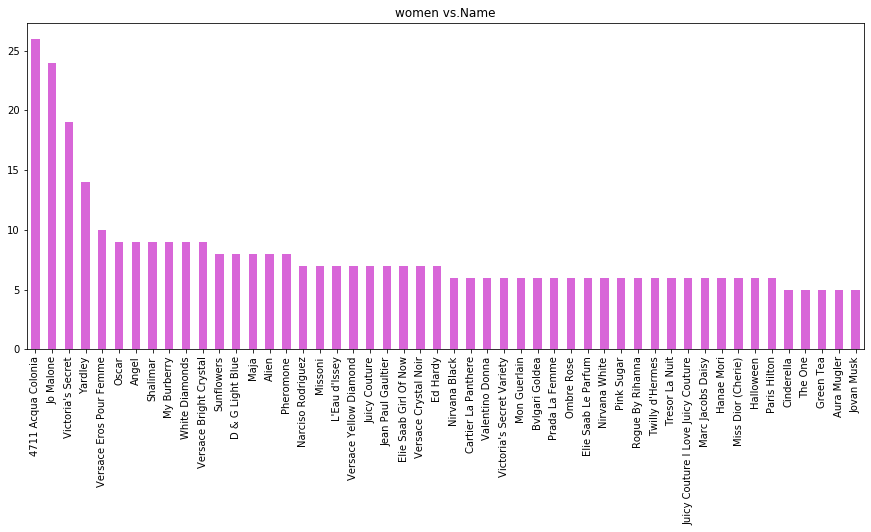

In [0]:
perfume['Name'][(perfume['Gender']== u'women')].value_counts(ascending=False)[0:50].sort_values(ascending=False).plot(kind='bar', color='m', figsize=(15,6), alpha=.6)
plt.title(u'women vs.Name');

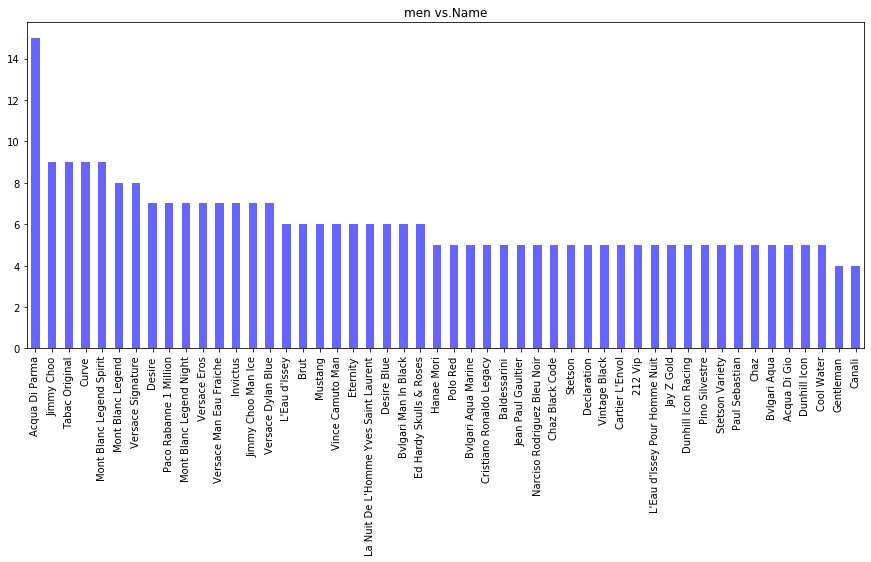

In [0]:
perfume['Name'][(perfume['Gender']== u'men')].value_counts(ascending=False)[0:50].sort_values(ascending=False).plot(kind='bar', color='b', figsize=(15,6), alpha=.6)
plt.title(u'men vs.Name');

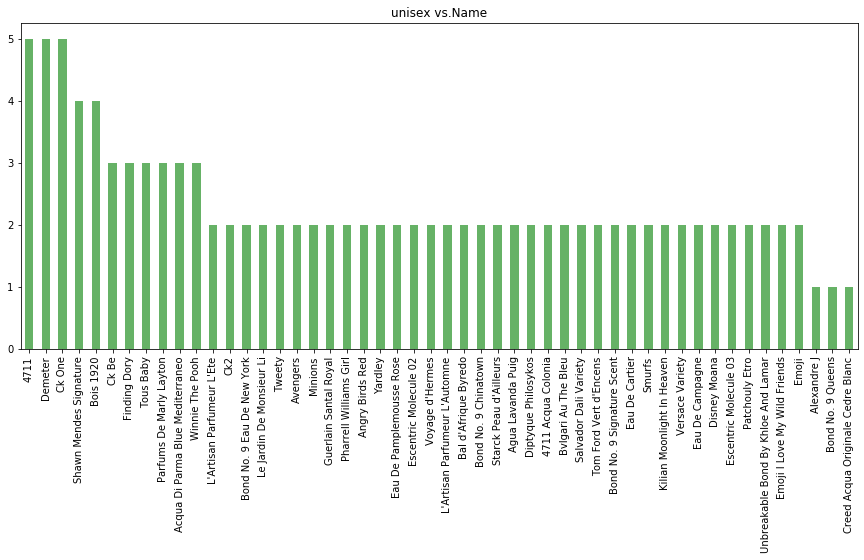

In [0]:
perfume['Name'][(perfume['Gender']== u'unisex')].value_counts(ascending=False)[0:50].sort_values(ascending=False).plot(kind='bar', color='g', figsize=(15,6), alpha=.6)
plt.title(u'unisex vs.Name');

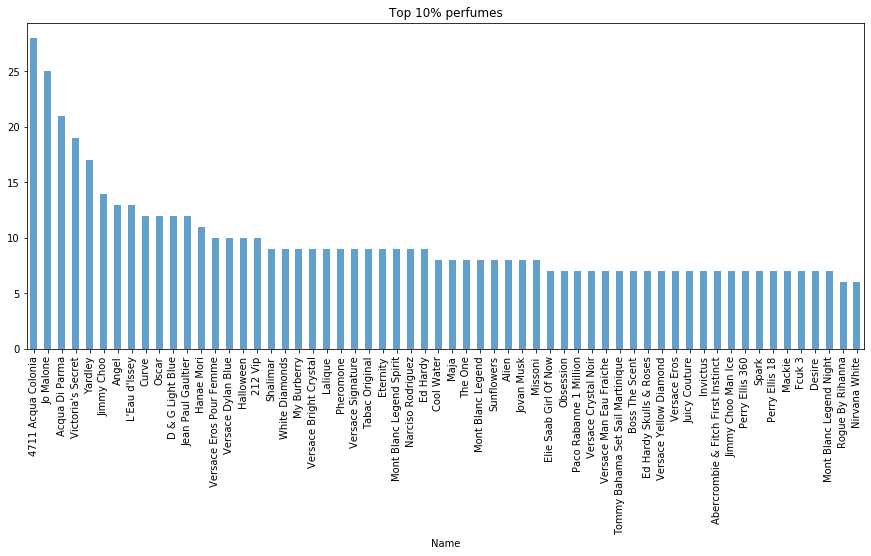

In [0]:
# brand vs. number of perfumes
perfume.groupby('Name')['Id'].count().sort_values(ascending=False)[0:60].plot(kind='bar', alpha=.7, figsize=(15,6));
plt.title(u'Top 10% perfumes');

**Working with perfume names and notes.**


*   First get a dataframe of names and notes.
*   Build a model that gives you information about which perfume holds which      notes.
*   Working with the average ratings of a perfume
*   Create a dataframe with fake users













In [0]:
Perfume1 = pd.DataFrame(perfume,columns=['Name','Notes'])
Perfume1

,Name,Notes
0,D & G Light Blue,"Apple, Cedar, Bellflower, Sicilian lemon, Whit..."
1,Acqua Di Gio,"Orange, Lime, Jasmine, Bergamot, Neroli"
2,Cool Water,"Rosemary, Mint, Sandalwood, Lavender, Cedar"
3,Viva La Juicy,"Mandarin orange, Wild berries, Honeysuckle, Ga..."
4,Eternity,"Lavender, Mandarin orange, Bergamot, Lemon, Co..."
...,...,...
8322,Mexx Xx Nice,NaN
8323,Miami Seduction,NaN
8324,Miracle Secret,NaN
8325,Miss Soprani,NaN


In [0]:
Perfume2 = Perfume1.dropna()
print('Number of perfumes after removing perfumes that does not have notes:' )
Perfume2

Number of perfumes after removing perfumes that does not have notes:


,Name,Notes
0,D & G Light Blue,"Apple, Cedar, Bellflower, Sicilian lemon, Whit..."
1,Acqua Di Gio,"Orange, Lime, Jasmine, Bergamot, Neroli"
2,Cool Water,"Rosemary, Mint, Sandalwood, Lavender, Cedar"
3,Viva La Juicy,"Mandarin orange, Wild berries, Honeysuckle, Ga..."
4,Eternity,"Lavender, Mandarin orange, Bergamot, Lemon, Co..."
...,...,...
8305,Mat Chocolat,"Black currant, Grapefruit, Watermelon, Rose, D..."
8306,Matthew Williamson,"lime, bergamot, tagete, neroli, cinnamon, ging..."
8307,Max Mara,"ginger, magnolia, citrus, lily, orchid, musk, ..."
8308,Mcm Gold,"Watermelon, Passion Fruit, Vanilla And Honey."


In [0]:
Perfume3 = pd.DataFrame(Perfume2,columns=['Notes'])
Perfume3

,Notes
0,"Apple, Cedar, Bellflower, Sicilian lemon, Whit..."
1,"Orange, Lime, Jasmine, Bergamot, Neroli"
2,"Rosemary, Mint, Sandalwood, Lavender, Cedar"
3,"Mandarin orange, Wild berries, Honeysuckle, Ga..."
4,"Lavender, Mandarin orange, Bergamot, Lemon, Co..."
...,...
8305,"Black currant, Grapefruit, Watermelon, Rose, D..."
8306,"lime, bergamot, tagete, neroli, cinnamon, ging..."
8307,"ginger, magnolia, citrus, lily, orchid, musk, ..."
8308,"Watermelon, Passion Fruit, Vanilla And Honey."


* This Dataframe **PerfumeNames** is to find the unique number of perfumes existing in the dataset. **3215 perfumes**

In [0]:
df1 = pd.DataFrame(Perfume2,columns=['Name'])
list_names = df1['Name'].unique().tolist()
PerfumeNames = pd.DataFrame(list_names,columns=['Name'])
print('The total number of Perfumes:',PerfumeNames.shape )
PerfumeNames

The total number of Perfumes: (3215, 1)


,Name
0,D & G Light Blue
1,Acqua Di Gio
2,Cool Water
3,Viva La Juicy
4,Eternity
...,...
3210,Mandarina Duck Scarlet Rain
3211,Mat Aqua Platinum
3212,Matthew Williamson
3213,Max Mara


In [0]:
new_df = pd.DataFrame(Perfume2.Notes.str.split(',').tolist(), index=df1.Name).stack()
new_df = new_df.reset_index([ 'Name'])
new_df.columns = ['Name', 'Notes']
new_df.head()

,Name,Notes
0,D & G Light Blue,Apple
1,D & G Light Blue,Cedar
2,D & G Light Blue,Bellflower
3,D & G Light Blue,Sicilian lemon
4,D & G Light Blue,White rose


* There are **3414** unique notes.

In [0]:
df2 = pd.DataFrame( index=new_df['Notes'])

list_notes = new_df['Notes'].unique().tolist()

PerfumeNotes = pd.DataFrame(list_notes,columns=['Notes'])
print('The total number of notes:', PerfumeNotes.shape)
PerfumeNotes.head()



The total number of notes: (3414, 1)


,Notes
0,Apple
1,Cedar
2,Bellflower
3,Sicilian lemon
4,White rose


**Cosine Similarity**
* Cosine similarity is generally used as a metric for measuring distance when    the magnitude of the vectors does not matter. This happens for example when    working with text data represented by word counts which is the case here.
* First I crosstabbed the names and notes from new_df2 dataframe to get 0's and 1's to find cosine similarity distance.
* The tables gives 1's to the notes which match the perfume notes in new_df2. 


In [0]:
new_df2=new_df.drop_duplicates()
new_df3 = pd.crosstab(new_df2['Name'], new_df2['Notes'])
new_df3

Notes,,,Bergamot,Black pepper,Candied ginger,Cardamom,Cassis absolute,Cedar leaf,Coriander,Cypress,Geranium,Ginger,Golden apple,Grapefruit,Guaiac wood,Iris,Juniper berries,Juniper berry,Kumquat,Lavender Heart,Lily-of-the-valley,Mango,Musk,Neroli,Patchouli,Pear,Pepper,Pink Pepper,Sandalwood,Sea Breeze accord,St. Thomas bay,Tomato leaf,Ylang ylang,a light,figand spices,lemon,rosewood,A Blend Of Mandarin Bergamont Orange Freesia and Jasmine,Absinthe,Absolute,...,tangerine,tangy citrus,tea,tea rose,teak wood,teas,the fresh scent of grapefruit,the fresh-cut fragrance of flowers with lower fruity notes.,the original scent,the scent of jasmine,thyme,tobacco,tobacco leaf,tonka bean,tuberose,turkish rose,vanilla,vanilla surrounded by crisp citrus notes.,vetiver,vetiver bourbon,violet,violet leaves,virginia cedar,warm,warm and woodsy,warm spicy,water lily,watermelon,white birch,white chocolate,white freesia,white musk,white papper,white pepper,wood,woodsy and exciting,woody oriental include vodka,ylang ylang,youthful licorice,yuzu
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Pop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Sexy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Surf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Vip,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zegna Uomo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zibeline De Weil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zino Davidoff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* The table above helped me calculate the cosine similarity since it gave me values for the notes that exists in the perfume.


---



---



* This dataframe represents the cosine distance between one perfume to all other perfumes, greater the cosine value greater is the the similarity.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
recommender_user = cosine_similarity(new_df3) # outputs dense matrix by default. 
recommender_user_df = pd.DataFrame(recommender_user, index = new_df3.index, columns = new_df3.index)
recommender_user_df

Name,212,212 Pop,212 Sexy,212 Surf,212 Vip,212 Vip Black,212 Vip Party Fever,212 Vip Rose,24 Faubourg,24 Live Another Night,273 Indigo,4711,4711 Acqua Colonia,4711 Nouveau Cologne,9ix Rocawear,A Scent By Issey Miyake,A Scent Florale By Issey Miyake,A Scent Soleil De Neroli By Issey Miyake,Ab Spirit,Ab Spirit Millionaire,Abercrombie & Fitch Fierce,Abercrombie & Fitch First Instinct,Accenti,Acqua Di Gio,Acqua Di Gio Absolu,Acqua Di Gio Profumo,Acqua Di Gioia,Acqua Di Parma,Acqua Di Parma Blu Mediterraneo,Acqua Di Parma Blue Mediterraneo,Acqua Di Parma Profumo,Acqua Di Selva,Acqua Essenziale,Acqua Essenziale Blu,Acqua Essenziale Colonia,Adam Levine,Adidas Deep Energy,Adidas Dynamic Pulse,Adidas Extreme Power,Adidas Fizzy Energy,...,Wonderstruck Enchanted Taylor Swift,Wonderstruck Taylor Swift,Woods Of Windsor,Woods Of Windsor Bergamot & Neroli,Woods Of Windsor Blue Orchid & Water Lily,Woods Of Windsor Cedar Woods,Woods Of Windsor Lavender,Woods Of Windsor Lily Of The Valley,Woods Of Windsor True Rose,Woods Of Windsor White Jasmine,X-Centric,Xeryus,Xeryus Rouge,Xoxo,Xoxo Heartbeat,Xoxo Kundalini,Xoxo Luv,Xoxo Mi Amore,Xs,Y,Yacht Man Black,Yacht Man Blue,Yacht Man Chocolate,Yacht Man Metal,Yacht Man Red,Yardley,Yohji Yamamoto,Young Sexy Lovely,Youth Dew,Ysatis,Yuzu Man,Yvresse,Z Zegna,Zegna Forte,Zegna Intenso,Zegna Uomo,Zibeline De Weil,Zino Davidoff,Zippo Original,Zirh
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
212,1.000000,0.0,0.105409,0.000000,0.000000,0.0,0.149071,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105409,0.000000,0.0,0.0,0.0,0.000000,0.149071,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.149071,0.105409,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.19245,0.149071,0.149071,0.000000,0.0,0.298142,0.0,0.0,0.149071,0.0,0.0,0.0,0.166667,0.136083,0.0,0.0,0.0,0.089087,0.0,0.000000,0.000000,0.149071,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
212 Pop,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
212 Sexy,0.105409,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.141421,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.105409,0.0,0.0,0.0,0.105409,0.000000,0.0,0.0,0.100000,0.141421,0.100000,0.0,0.0,0.0,0.0,0.141421,0.000000,0.282843,0.0,0.141421,0.0,...,0.0,0.0,0.0,0.141421,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.141421,0.0,0.141421,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.129099,0.0,0.0,0.0,0.084515,0.0,0.141421,0.141421,0.141421,0.0,0.0,0.0,0.00000,0.141421,0.0,0.0,0.141421,0.0,0.141421
212 Surf,0.000000,0.0,0.000000,1.000000,0.174078,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.204124,0.0,0.0,0.258199,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
212 Vip,0.000000,0.0,0.000000,0.174078,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.106600,0.0,0.0,0.134840,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.134840,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00

In [0]:
# nr=new_df4.reset_index()

**Ratings**
* Working with the ratings of the perfume
* After getting the nearest match to the perfume that the user selected, I am going to recommend top rated one's.

In [0]:
PerfumeRating = pd.DataFrame(perfume,columns=['Name','Rating'])
PerfumeRating

,Name,Rating
0,D & G Light Blue,4.847
1,Acqua Di Gio,4.872
2,Cool Water,4.682
3,Viva La Juicy,4.781
4,Eternity,4.719
...,...,...
8322,Mexx Xx Nice,NaN
8323,Miami Seduction,NaN
8324,Miracle Secret,NaN
8325,Miss Soprani,NaN


In [0]:
PerfumeR = PerfumeRating.dropna()
print('Number of perfumes after removing perfumes that does not have Ratings:' )
new_df5=PerfumeR.drop_duplicates()
a=new_df5.tail(15)
a

Number of perfumes after removing perfumes that does not have Ratings:


,Name,Rating
7960,Bond No. 9 Park Avenue,5.000
7987,Byblos Miss Byblos,5.000
8002,Carlo Corinto Noir Intense,5.000
8010,Carner Barcelona Palo Santo,5.000
8027,Chelsea Dreams,4.000
8121,Floris Leather Oud,3.000
8137,Ghost Captivating,4.000
8140,Giorgio Blue,4.933
8191,Ivanka Trump,4.000
8203,Jivago Rose Gold,5.000


These are the ratings of all the perfumes in our dataset. We can see the variations in the graph: 


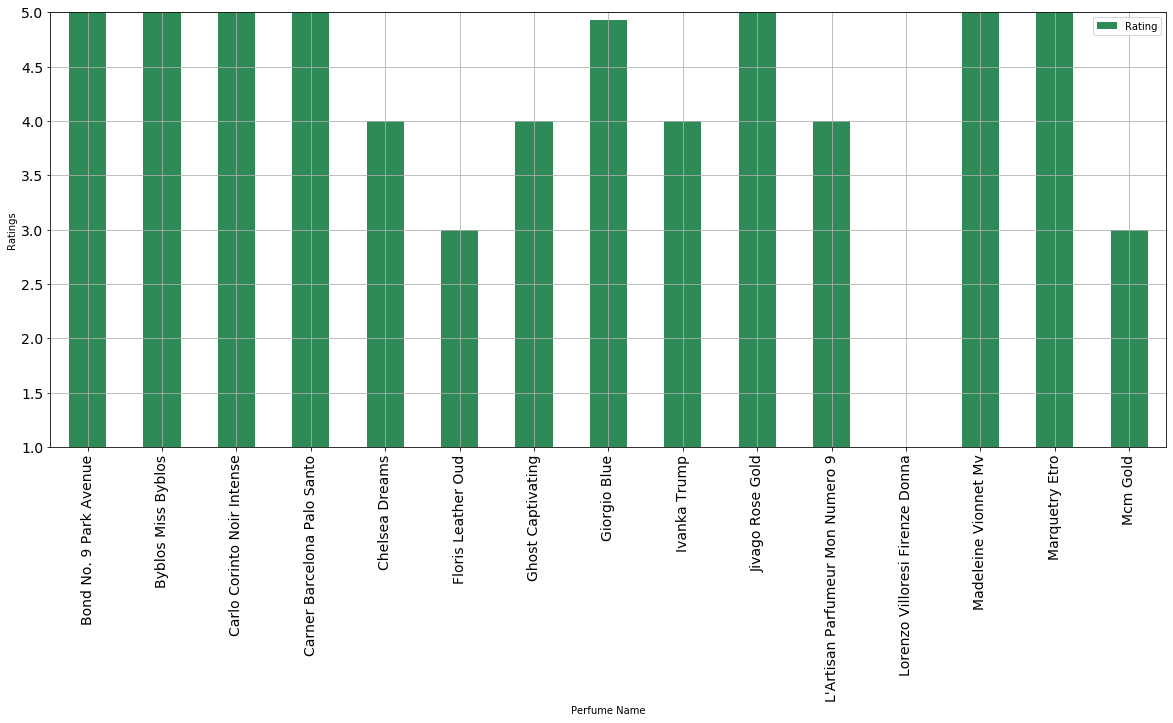

In [0]:
a.plot(kind='bar',x='Name',y='Rating',color='seagreen', figsize=(20, 8),fontsize=14)
plt.ylabel('Ratings')
plt.xlabel('Perfume Name')
plt.grid(True)
plt.ylim((1,5))
print("These are the ratings of all the perfumes in our dataset. We can see the variations in the graph: ")


* To test the cosine similarity and to recommend perfumes to the users I have created a fake dataset with 3 users.
* These 3 users selected 3 perfumes which they previously used.
* So, depending on the notes of those perfumes I am recommending perfumes that are a close match to the ones they chose.




In [0]:
user_id = [1,2,3]
Perfume1 = ['D & G Light Blue','Acqua Di Gio','Viva La Juicy']
Perfume2=['Cool Water','Eternity','Missoni']
Perfume3=[' Missoni','Missoni','Missoni']
d = {'User_ID':user_id,'Perfume1':Perfume1, 'Perfume2':Perfume2, 'Perfume3':Perfume3}
df = pd.DataFrame(d)
df

,User_ID,Perfume1,Perfume2,Perfume3
0,1,D & G Light Blue,Cool Water,Missoni
1,2,Acqua Di Gio,Eternity,Missoni
2,3,Viva La Juicy,Missoni,Missoni


* Here we can enter the user_id of the user we intend to recommend perfumes.

In [0]:
var = input("Enter the userId for user recommendations: ")
ui = int(var)

Enter the userId for user recommendations: 2


In [0]:
perfumes=[]
for i,r in df.iterrows():
    if(r['User_ID']==ui):
        for col in recommender_user_df.columns:
            if(r['Perfume1'] == col): 
                perfumes.append(col)
            if(r['Perfume2'] == col): 
                perfumes.append(col)
            if(r['Perfume3'] == col): 
                perfumes.append(col) 

In [0]:
b=[]
for i in perfumes:
  b.append(recommender_user_df[i])
q=pd.DataFrame(b)
finalp=q.transpose()

* This is the dataframe of the first perfume the user chose and the cosine values closest to the selected perfume.
* Here I am considering only the consine value that is greater than 0.3.
* I considered 0.3 to be the value that will have relatively high match to the perfume that is selected by the user

In [0]:
perfume1 = finalp[finalp[perfumes[0]] > 0.3 ]
perfume1= perfume1.drop(perfume1.columns[[1,2]], axis=1)
perfume1['Name']=perfume1.index
perfume1 = perfume1.reset_index(drop=True)
perfume1.head(10)

,Acqua Di Gio,Name
0,1.000000,Acqua Di Gio
1,0.316228,Acqua Di Parma Blue Mediterraneo
2,0.333333,Agatha Ruiz De La Prada Gotas De Color
3,0.316228,Amouage Journey
4,0.333333,Animale
5,0.447214,Apres L'Ondee
6,0.384900,Armaf Club De Nuit Intense
7,0.447214,Axis Caviar Ultimate
8,0.447214,Azzaro Orange Tonic
9,0.596285,Chrome


This is cosine similarity of the first perfume the user chose: 


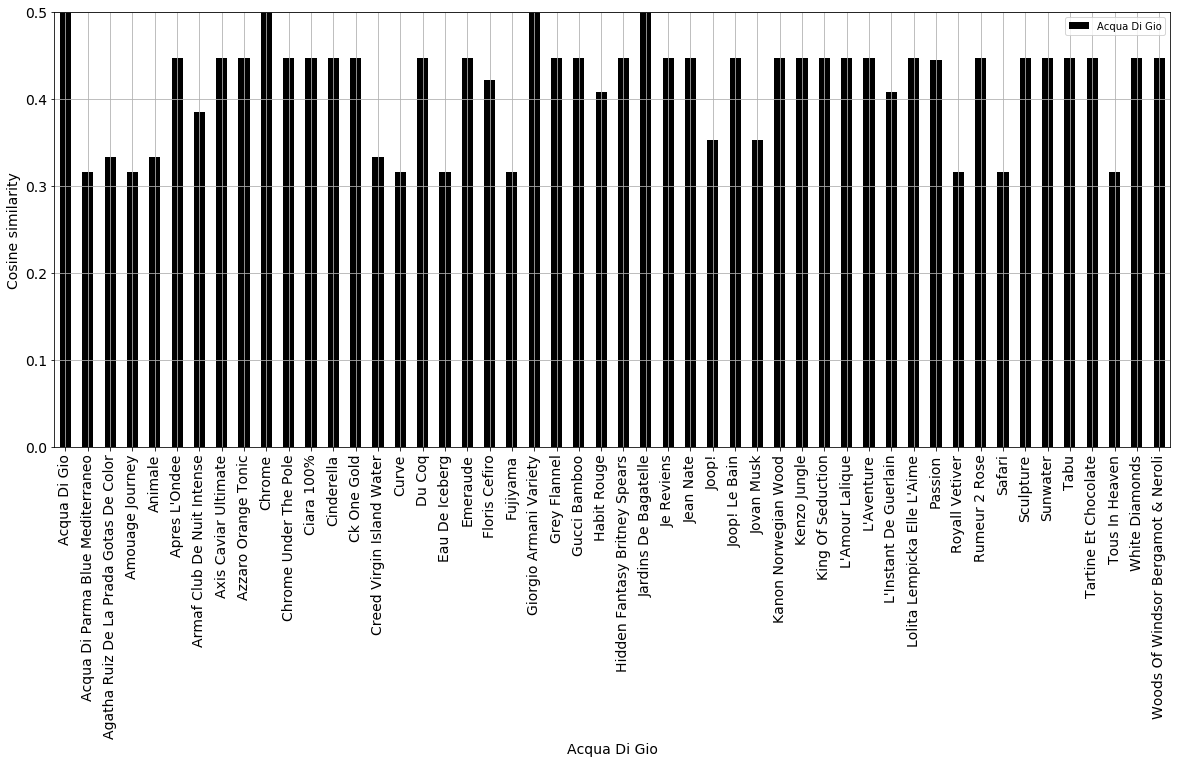

In [0]:
perfume1.plot(kind='bar',x='Name',y='Acqua Di Gio',color='black', figsize=(20, 8),fontsize=14)
plt.ylabel('Cosine similarity',fontsize=14)
plt.xlabel('Acqua Di Gio',fontsize=14)
plt.grid(True)
plt.ylim((0,0.5))
print("This is cosine similarity of the first perfume the user chose: ")

In [0]:
mergedStuff1 = pd.merge(new_df5, perfume1, on=['Name'], how='inner')
final_df1 = mergedStuff1.sort_values(by=['Rating'], ascending=False)
final_df1 = final_df1[['Name','Rating']]
final_df1.head()


,Name,Rating
69,Agatha Ruiz De La Prada Gotas De Color,5.0
53,Rumeur 2 Rose,5.0
26,Passion,5.0
1,Acqua Di Gio,5.0
43,Je Reviens,5.0


In [0]:
perfume2 = finalp[finalp[perfumes[1]] > 0.3 ]
perfume2= perfume2.drop(perfume2.columns[[0,2]], axis=1)
perfume2['Name']=perfume2.index
perfume2 = perfume2.reset_index(drop=True)
perfume2.head(15)

,Eternity,Name
0,0.300000,212 Sexy
1,0.424264,Agua Brava
2,0.421637,Animale
3,0.424264,Animale Animale
4,0.424264,Armani Si Intense
5,0.424264,Bond No. 9 Hamptons
6,0.424264,Davidoff Adventure
7,0.300000,Dolce & Gabbana
8,0.424264,Dreamer
9,0.316228,Eau De Cartier


This is cosine similarity of the second perfume the user chose: 


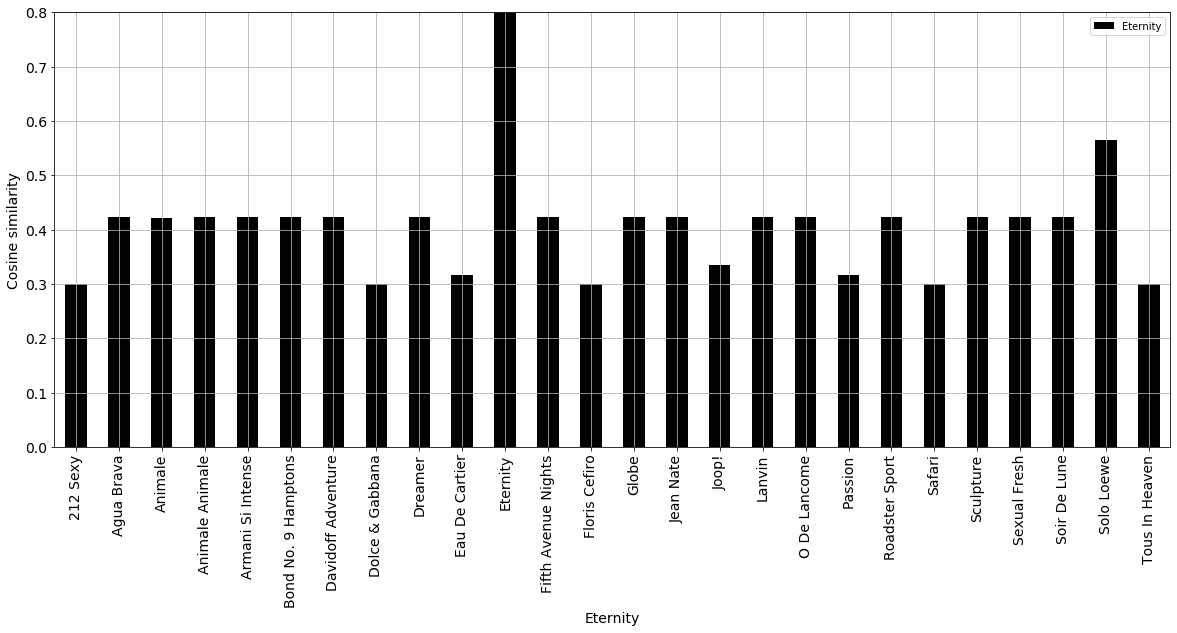

In [0]:
perfume2.plot(kind='bar',x='Name',y='Eternity',color='black', figsize=(20, 8),fontsize=14)
plt.ylabel('Cosine similarity',fontsize=14)
plt.xlabel('Eternity',fontsize=14)
plt.grid(True)
plt.ylim((0,0.8))
print("This is cosine similarity of the second perfume the user chose: ")

In [0]:
mergedStuff2 = pd.merge(new_df5, perfume2, on=['Name'], how='inner')
final_df2 = mergedStuff2.sort_values(by=['Rating'], ascending=False)
final_df2= final_df2[['Name','Rating']]
final_df2.head()

,Name,Rating
33,Solo Loewe,5.0
36,Sexual Fresh,5.0
35,Davidoff Adventure,5.0
4,Eternity,5.0
30,Armani Si Intense,5.0


In [0]:
perfume3 = finalp[finalp[perfumes[2]] > 0.3 ]
perfume3= perfume3.drop(perfume3.columns[[0,1]], axis=1)
perfume3['Name']=perfume3.index
perfume3 = perfume3.reset_index(drop=True)
perfume3.head(15)


,Missoni,Name
0,0.424264,Acqua Di Gio Absolu
1,0.300000,Acqua Di Parma
2,0.335410,Amouage Interlude
3,0.424264,Angry Birds King Pig
4,0.424264,Armaf Blue Homme
5,0.424264,Armaf Tag Him
6,0.424264,Armani Code Ultimate
7,0.424264,Azzaro Wanted
8,0.424264,Bebe Wishes & Dreams
9,0.316228,Brooksfield


This is cosine similarity of the third perfume the user chose: 


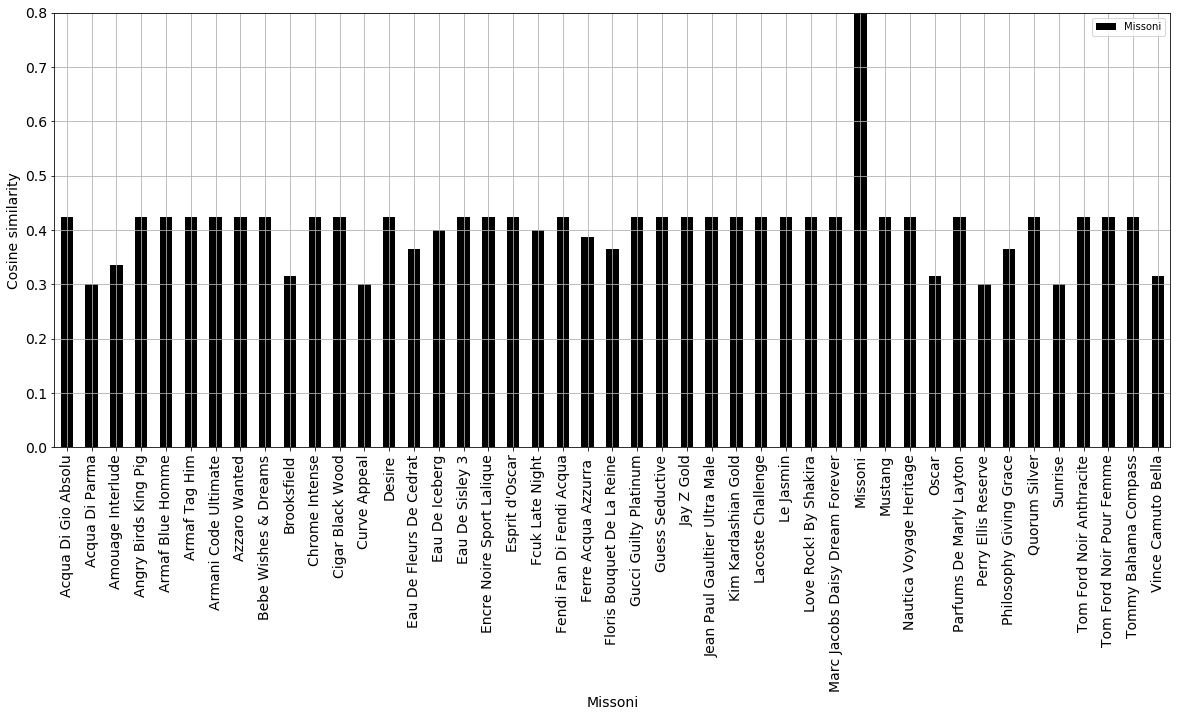

In [0]:
perfume3.plot(kind='bar',x='Name',y='Missoni',color='black', figsize=(20, 8),fontsize=14)
plt.ylabel('Cosine similarity',fontsize=14)
plt.xlabel('Missoni',fontsize=14)
plt.grid(True)
plt.ylim((0,0.8))
print("This is cosine similarity of the third perfume the user chose: ")

In [0]:
mergedStuff3 = pd.merge(new_df5, perfume3, on=['Name'], how='inner')
final_df3 = mergedStuff3.sort_values(by=['Rating'], ascending=False)
final_df3 = final_df3[['Name','Rating']]
final_df3.head()

,Name,Rating
42,Fcuk Late Night,5.0
8,Acqua Di Parma,5.0
17,Curve Appeal,5.0
22,Jay Z Gold,5.0
13,Perry Ellis Reserve,5.0


**Model Evaluation**

In [0]:
frames = [final_df1, final_df2, final_df3]
result = pd.concat(frames)
result=result.sort_values(by='Rating', ascending=False)
result.head(70)

,Name,Rating
69,Agatha Ruiz De La Prada Gotas De Color,5.000
33,Solo Loewe,5.000
35,Davidoff Adventure,5.000
4,Eternity,5.000
30,Armani Si Intense,5.000
...,...,...
8,Dolce & Gabbana,4.860
12,Passion,4.860
4,White Diamonds,4.843
6,Vince Camuto Bella,4.842


Here we can clearly see which perfume has the top rating: 


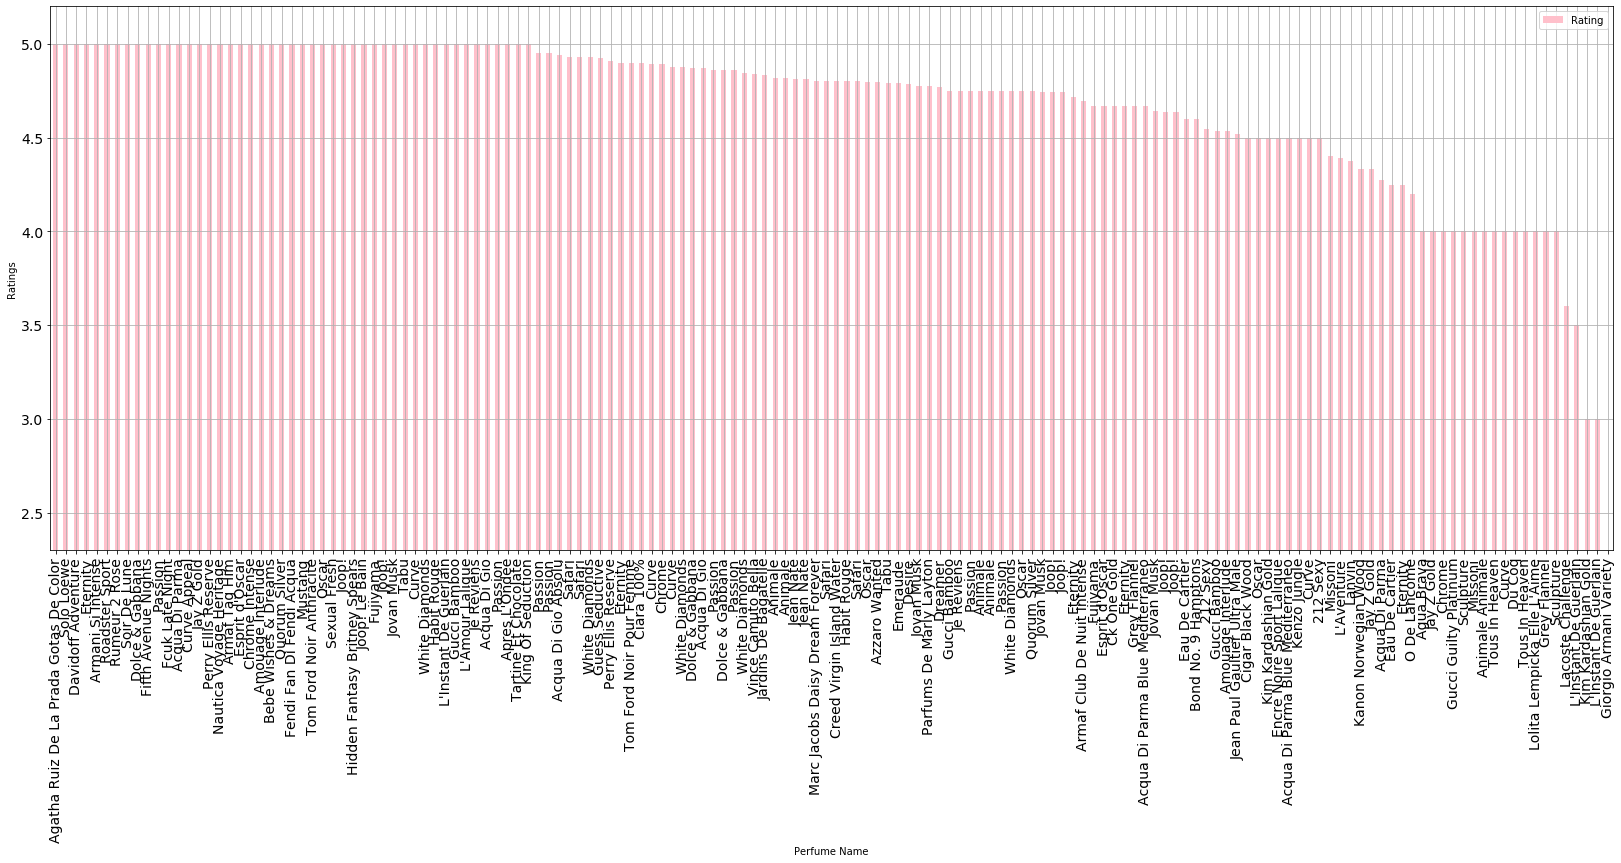

In [0]:
result.plot(kind='bar',x='Name',y='Rating',color='pink',figsize=(28, 10),fontsize=14)
plt.ylabel('Ratings')
plt.xlabel('Perfume Name')
plt.grid(True)
plt.ylim((2.3,5.2))
print("Here we can clearly see which perfume has the top rating: ")


**Summary**

* Project Title: Recommendation System for Perfumes
* Name: Hima Swetha Gutti
* UIN: 01100555


---




![alt text](https://www.hellomagazine.com/imagenes/healthandbeauty/skincare-and-fragrances/201006023628/perfume/cologne/categories/0-8-500/perfume--z.jpg)


* The recommendation system that I built targets the audience who fancy           perfumes but misjudge what to wear. 
* This is a content based recommendation system.
* Used cosine similarity to calculate the distance between two perfumes and was   able to achieve list of best match of perfumes for a particular user with top   ratings.



**Why?**
* Fragrance is not only about scent, it tells your personality, or the            impression you want to leave on people. People with different personality       types will like different scents. So this is what I thought to do, recommend    perfumes to the users.           



**Dataset**

* The dataset which I used in this project is a web-scraped dataset. I scarped    the data from www.frangrantica.com[link]
* The features of my dataset include name of the perfumes, brands, notes(by       notes I mean the composition of ingredients that are used to make a perfume),   category, gender...


**Observations**

* I am using the perfume notes to recommend perfumes to users. I created a fake   dataset with fake users who chose 3 liked perfumes of their choice. With this   data I am going to recommend perfumes.

In [0]:
Perfume2 = Perfume1.dropna()
print('Number of perfumes after removing perfumes that does not have notes:' )
Perfume2

Number of perfumes after removing perfumes that does not have notes:


,Name,Notes
0,D & G Light Blue,"Apple, Cedar, Bellflower, Sicilian lemon, Whit..."
1,Acqua Di Gio,"Orange, Lime, Jasmine, Bergamot, Neroli"
2,Cool Water,"Rosemary, Mint, Sandalwood, Lavender, Cedar"
3,Viva La Juicy,"Mandarin orange, Wild berries, Honeysuckle, Ga..."
4,Eternity,"Lavender, Mandarin orange, Bergamot, Lemon, Co..."
...,...,...
8305,Mat Chocolat,"Black currant, Grapefruit, Watermelon, Rose, D..."
8306,Matthew Williamson,"lime, bergamot, tagete, neroli, cinnamon, ging..."
8307,Max Mara,"ginger, magnolia, citrus, lily, orchid, musk, ..."
8308,Mcm Gold,"Watermelon, Passion Fruit, Vanilla And Honey."


**Cosine Similarity**
* Cosine similarity is generally used as a metric for measuring distance when    the magnitude of the vectors does not matter. This happens for example when    working with text data represented by word counts which is the case here.
* First I crosstabbed the names and notes from new_df2 dataframe to get 0's and 1's to find cosine similarity distance.
* The tables gives 1's to the notes which match the perfume notes in new_df2. 


In [0]:
new_df2=new_df.drop_duplicates()
new_df3 = pd.crosstab(new_df2['Name'], new_df2['Notes'])
new_df3

Notes,,,Bergamot,Black pepper,Candied ginger,Cardamom,Cassis absolute,Cedar leaf,Coriander,Cypress,Geranium,Ginger,Golden apple,Grapefruit,Guaiac wood,Iris,Juniper berries,Juniper berry,Kumquat,Lavender Heart,Lily-of-the-valley,Mango,Musk,Neroli,Patchouli,Pear,Pepper,Pink Pepper,Sandalwood,Sea Breeze accord,St. Thomas bay,Tomato leaf,Ylang ylang,a light,figand spices,lemon,rosewood,A Blend Of Mandarin Bergamont Orange Freesia and Jasmine,Absinthe,Absolute,...,tangerine,tangy citrus,tea,tea rose,teak wood,teas,the fresh scent of grapefruit,the fresh-cut fragrance of flowers with lower fruity notes.,the original scent,the scent of jasmine,thyme,tobacco,tobacco leaf,tonka bean,tuberose,turkish rose,vanilla,vanilla surrounded by crisp citrus notes.,vetiver,vetiver bourbon,violet,violet leaves,virginia cedar,warm,warm and woodsy,warm spicy,water lily,watermelon,white birch,white chocolate,white freesia,white musk,white papper,white pepper,wood,woodsy and exciting,woody oriental include vodka,ylang ylang,youthful licorice,yuzu
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Pop,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Sexy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Surf,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
212 Vip,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zegna Uomo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zibeline De Weil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Zino Davidoff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
from sklearn.metrics.pairwise import cosine_similarity
recommender_user = cosine_similarity(new_df3) # outputs dense matrix by default. 
recommender_user_df = pd.DataFrame(recommender_user, index = new_df3.index, columns = new_df3.index)
recommender_user_df

Name,212,212 Pop,212 Sexy,212 Surf,212 Vip,212 Vip Black,212 Vip Party Fever,212 Vip Rose,24 Faubourg,24 Live Another Night,273 Indigo,4711,4711 Acqua Colonia,4711 Nouveau Cologne,9ix Rocawear,A Scent By Issey Miyake,A Scent Florale By Issey Miyake,A Scent Soleil De Neroli By Issey Miyake,Ab Spirit,Ab Spirit Millionaire,Abercrombie & Fitch Fierce,Abercrombie & Fitch First Instinct,Accenti,Acqua Di Gio,Acqua Di Gio Absolu,Acqua Di Gio Profumo,Acqua Di Gioia,Acqua Di Parma,Acqua Di Parma Blu Mediterraneo,Acqua Di Parma Blue Mediterraneo,Acqua Di Parma Profumo,Acqua Di Selva,Acqua Essenziale,Acqua Essenziale Blu,Acqua Essenziale Colonia,Adam Levine,Adidas Deep Energy,Adidas Dynamic Pulse,Adidas Extreme Power,Adidas Fizzy Energy,...,Wonderstruck Enchanted Taylor Swift,Wonderstruck Taylor Swift,Woods Of Windsor,Woods Of Windsor Bergamot & Neroli,Woods Of Windsor Blue Orchid & Water Lily,Woods Of Windsor Cedar Woods,Woods Of Windsor Lavender,Woods Of Windsor Lily Of The Valley,Woods Of Windsor True Rose,Woods Of Windsor White Jasmine,X-Centric,Xeryus,Xeryus Rouge,Xoxo,Xoxo Heartbeat,Xoxo Kundalini,Xoxo Luv,Xoxo Mi Amore,Xs,Y,Yacht Man Black,Yacht Man Blue,Yacht Man Chocolate,Yacht Man Metal,Yacht Man Red,Yardley,Yohji Yamamoto,Young Sexy Lovely,Youth Dew,Ysatis,Yuzu Man,Yvresse,Z Zegna,Zegna Forte,Zegna Intenso,Zegna Uomo,Zibeline De Weil,Zino Davidoff,Zippo Original,Zirh
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
212,1.000000,0.0,0.105409,0.000000,0.000000,0.0,0.149071,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105409,0.000000,0.0,0.0,0.0,0.000000,0.149071,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.149071,0.105409,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.19245,0.149071,0.149071,0.000000,0.0,0.298142,0.0,0.0,0.149071,0.0,0.0,0.0,0.166667,0.136083,0.0,0.0,0.0,0.089087,0.0,0.000000,0.000000,0.149071,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
212 Pop,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
212 Sexy,0.105409,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.141421,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.105409,0.0,0.0,0.0,0.105409,0.000000,0.0,0.0,0.100000,0.141421,0.100000,0.0,0.0,0.0,0.0,0.141421,0.000000,0.282843,0.0,0.141421,0.0,...,0.0,0.0,0.0,0.141421,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.141421,0.0,0.141421,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.129099,0.0,0.0,0.0,0.084515,0.0,0.141421,0.141421,0.141421,0.0,0.0,0.0,0.00000,0.141421,0.0,0.0,0.141421,0.0,0.141421
212 Surf,0.000000,0.0,0.000000,1.000000,0.174078,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.204124,0.0,0.0,0.258199,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.000000
212 Vip,0.000000,0.0,0.000000,0.174078,1.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.106600,0.0,0.0,0.134840,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.134840,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00

Perfume 1 cosine similarity.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJkAAAL8CAYAAABDI2T4AAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzde5RkZX0v/O+Pm3gBQTQTcUQmGlCU%0ADNi8OW+8gMSQ4CWuGF3RE2+QGCKoJPFEo9HgJdGoTIzoCS/GC4gxYMR4SQTlqKhBE5E2clPBKKCD%0AooJB4JgJCM/7R9Vg09PVU927d9HFfD5r7TVVu/b+7meerq7u/vau3dVaCwAAAAB0sd0dPQAAAAAA%0App+SCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZxMvmarqmKq6vKo2%0AVdVsVT16kW0fU1VtgeXBkxwzAAAAAIubaMlUVU9LckKS1yU5MMnnk5xVVXttZdeHJrnvnOXrfY4T%0AAAAAgKWp1trkDlb1hSQXttZ+b866ryc5o7X2sgW2f0ySc5Lcp7V2zcQGCgAAAMCSTOxMpqraKclM%0AkrPnPXR2kkdsZffzq+q7VfXJqjq0lwECAAAAsGw7TPBY906yfZLvzVv/vSS/MmKf7yY5OskXk+yU%0A5FlJPllVh7TW/mX+xlV1VJKjkuSud73rzP3vf/8tAn/84x9vsW7HHXfMzTffvMX6u93tbqP/N2O6%0A9dZbs912K9/lTVtun9nTlttn9krk+hy5Y3L7zJ623D6zpy23z2yvF9t27kIfu2Thj9+2+LHrM3va%0AcvvMnrbcPrOnLbfP7GnL7TN72nL7zJ623D6zV0PuZZdddk1r7T4LPtham8iSZM8kLcnB89Yfl+TS%0AJeScmeQjW9tuZmamLWQ4htstGzZsWHD9SjjnnHNWJGfac/vMnrbcPrNXItfnyB2T22f2tOX2mT1t%0AuX1me73YtnMX+hiN+vithNU8F5POnrbcPrOnLbfP7GnL7TN72nL7zJ623D6zpy23z+zVkJvk/Dai%0Ai5nkhb+vSXJLkjXz1q9JcvUScr6Q5OdXalAAAAAAdDexkqm1dlOS2SSHzXvosAz+yty4DsjgbXQA%0AAAAArBKTvCZTkrwpyXuq6rwkn0vyvAzeRndSklTVqUnSWnv28P4fJrkiySUZXJPpmUl+I8lTJjxu%0AAAAAABYx0ZKptfa+qtojySuS3DfJxUke31q7crjJXvN22SnJ8UnWJvmvDMqmJ7TWzpzQkAEAAIAJ%0Aufnmm7Nx48Zs2rTptnX3vOc989WvfnXFj9VXbp/Zk8zdeeeds3bt2uy4445j50z6TKa01k5McuKI%0Axx4z7/4bk7xxAsMCAAAA7mAbN27MLrvskr333jtVlSS54YYbsssuu6z4sfrK7TN7UrmttVx77bXZ%0AuHFj1q1bN3bOJC/8DQAAADDSpk2bsscee9xWMHHHqKrssccetzujbBxKJgAAAGDVUDCtDsv5OCiZ%0AAAAAAOhMyQQAAACsSlWVXXfdNVW1Isu4PvShD6Wq8rWvfa3H/93ijjjiiKxbty7r16/PPvvsk2c/%0A+9m56qqrbnv88Y9/fK677rot9rvxxhtz9NFH54EPfGAe/vCHZ2ZmJm9/+9uTJN/5znfy1Kc+tbcx%0AK5kAAAAA5jjttNPyqEc9KqeddtodOo7jjz8+F1xwQS699NIceOCBeeITn5ibbropSXLmmWdmt912%0A22Kf5z73udl9993z9a9/PV/60pfysY99LD/84Q+TJHvuuWfOOOOM3sarZAIAAAAYuvHGG3Puuefm%0Ane98Z04//fTbPfaGN7wh+++/f9avX5+XvvSlSZLZ2dmsX78+69evz4tf/OI87GEPS5KccsopecEL%0AXnDbvk984hPz6U9/Okly9NFH56CDDspDH/rQvPKVr9zqmKoqf/RHf5Q1a9bkrLPOSpLsvffeueaa%0Aa2633Te+8Y2cd955+Yu/+Itst92g8rnPfe6TP/mTP0mSXHHFFbeNb9OmTTnyyCOz//7751GPelTO%0AOeecpU7VFpRMAAAAAEMf/vCHc/jhh2efffbJHnvskdnZ2STJWWedlQ9/+MP5whe+kAsuuCAveclL%0AkiRHHnlk3vrWt+aCCy4Y+xivfe1rc/755+fCCy/MZz7zmVx44YVj7bd+/fpF38J3ySWXZP369bcV%0ATIv5m7/5m1RVLrroorzrXe/Kc57znCX/Nbn5lEwAAAAAQ6eddlqe/vSnJ0me/vSn3/aWuU984hM5%0A8sgjc7e73S1Jcq973SvXXXddrrvuuhx88MFJkmc961ljHeMf/uEf8vCHPzwHHnhgLrnkknzlK18Z%0Aa7/W2pL+L6997WtzwAEHZM8999zisXPPPTfPfOYzkyT77LNPHvCAB+Syyy5bUv58O3TaGwAAAOBO%0A4oc//GE+9alP5aKLLkpV5ZZbbklV5fjjj19y1g477JBbb731tvubzxK6/PLLs2HDhnzxi1/M7rvv%0AniOOOGLsM4guvPDCPO5xjxv5+H777ZcLLrggt956a7bbbru8/OUvz8tf/vLc4x73WPL4l8OZTAAA%0AAABJzjjjjDzrWc/KlVdemSuuuCLf/va3s27duvzLv/xLDjvssJx88sn58Y9/nGRQSO22227Zbbfd%0Acu655yZJ3vve996Wtffee+fLX/5ybr311nz729/OeeedlyS5/vrrc/e73z33vOc9873vfe+2aywt%0AprWWt7zlLbn66qtz+OGHj9zuQQ96UA466KC84hWvyC233JJkUG4tdAbUox/96NvG+/Wvfz3f+ta3%0Asu+++445UwtTMgEAAACrUmst119/fVprK7JszWmnnZYnP/nJt1v3lKc8JaeddloOP/zwPOlJT8pB%0ABx2UAw44IBs2bEiSnHzyyXn+85+fAw444HbHeOQjH5l169Zlv/32y7HHHpuHP/zhSQbXVTrwwAPz%0A4Ac/OL/927+dRz7ykSPH8+IXvzjr16/PPvvsky9+8Yv56Ec/mp122mnR/8M73vGOXHvttbcVTocd%0Adlje+MY3brHdMccck1tvvTX7779/jjzyyJxyyim5y13ustU5Woy3ywEAAAAkC/6FtWOPPfa22y99%0A6Utv+6tym83MzNx20e8rrrgiZ555ZpLBX4Sbe2bTXKeccspWx7LQNjfccMNtt6+44ooF99t1113z%0Atre9bcHH9t5771x88cVJkp133jknn3zybbm77LLLVse0Nc5kAgAAAKAzJRMAAADACph7ptC2SMkE%0AAAAArBrjXDuJ/i3n46BkAgAAAFaFnXfeOddee62i6Q7WWsu1116bnXfeeUn7ufA3AAAAsCqsXbs2%0AGzduzA9+8IPb1m3atGnJZcc4+srtM3uSuTvvvHPWrl27pBwlEwAAALAq7Ljjjlm3bt3t1n3605/O%0AgQceuOLH6iu3z+zVnuvtcgAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJBAAAAEBnSiYAAAAA%0AOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkEAAAAQGdKJgAA%0AAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0om%0ApkpVbbHMzs4uuH41WGhco8bcV665WNnsvnJXYi6m0TTOxbR97k2j1fB6sVpM4/Nt2l6T+zRtY14N%0An3ur5XkxjXPRl2l87ezLNM7FnflzZKl87i2evVJzoWQCAAAAoDMlEwAAABM1jWd1AVunZAIAAACg%0AMyUTAAAAAJ0pmQAAAADoTMkEAAAAQGdKJgAAAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAA%0AAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0omAAAAADpTMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQC%0AAAAAoDMlEwAAAACdKZkAAAAA6EzJBACrQFUtuMzOzm6xDgAAViMlEwAAAACdKZkAAAAA6EzJBAAA%0AAEBnSiYAAAAAOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkE%0AAAAAQGdKJgCAjqpqi2V2dnbB9QB98DoErAZKJgAAAAA6UzIBAAAA0NnES6aqOqaqLq+qTVU1W1WP%0AHnO/R1XVT6rq4r7HCAAAAMDSTLRkqqqnJTkhyeuSHJjk80nOqqq9trLf7klOTfLJ3gcJAAAAwJJN%0A+kymFyU5pbX29tbaV1trL0zy3SRHb2W/dyZ5d5J/7XuAAAAAACzdxEqmqtopyUySs+c9dHaSRyyy%0A3zFJ1iT5i/5GBwAAAEAX1VqbzIGq9kxyVZJDWmufnbP+uCTPaK3tu8A++yf5RJL/t7V2eVW9KslT%0AW2sPG3GMo5IclSRr1qyZOf3007fYZnZ2dot1a9euzcaNG7dYPzMzM9b/bTE33nhj7nGPe3TOmfbc%0Alcqe5Mevr/EmC495KeNdSu5KZPeVOyrbXCwvd5TV/HoxjXPhefFT0zYXfc7xJOdiNc/xqOzVPBej%0ArObPkYWs5tdkX6uXl7sS2dvqXCxkNX+OjLKaX4dWw/NitXx9GqXrx281z8Whhx4621o7aMHw1tpE%0AliR7JmlJDp63/rgkly6w/V2SfCXJs+ase1WSi8c53szMTFvIcAy3WzZs2LDg+pVwzjnnrEjOtOeu%0AVPYkP359jXfUmPvKXYnsvnLNxcrOxSir+fViGufC8+Knpm0u+pxjr0N3zJhX+/dwkxzzan5NXkru%0AanlemIvljbmv3Dv758goq/l1aDU8L5Zqks+31rp//FbzXCQ5v43oYnbI5FyT5JYM3vo215okVy+w%0A/X2TPCTJyVV18nDddkmqqn6S5PGttflvvQMAAADgDjCxazK11m5KMpvksHkPHZbBX5mb76ok+yc5%0AYM5yUpL/GN5eaB8AAAAA7gCTPJMpSd6U5D1VdV6SzyV5XgZvozspSarq1CRprT27tXZzkovn7lxV%0A30/y3621260HAAAA4I410ZKptfa+qtojySsyeDvcxRm87e3K4SZ7TXI8AAAAAKyMSZ/JlNbaiUlO%0AHPHYY7ay76syuPg3AAAAAKvIxK7JBAAAAMCdl5IJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACd%0AKZkAAAAA6EzJBEmqaotldnZ2wfUAAADAlpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkE%0AAAAAQGdKJgAAAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhM%0AyQQAAABAZ0omAAAAADpTMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA%0A6EzJBAAAAEBnSiYAAAAAOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAA%0A2GZV1YLL7OzsFutWi3HHu5rGDMC2QckEAAAAQGdKJgAAAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAA%0AdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0omAAAAADpTMgEAAADQmZIJAAAAgM6UTAAA%0AAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJNAWqaotldnZ2wfWrwULjGjVmYOUs5XPP5x8AALDS%0AlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0omAAAAADpTMgEAAADQmZIJAAAA%0AgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJBAAAAEBnSiYAAAAAOlMyrZCqWnCZnZ3d%0AYt1qMe54V9OYgTvGtL1eLOU1ebWMuS/T+PUJALqYtu8BfN8y3XyvdXtjlUxVdUDfAwEAAABgeo17%0AJtOXqmq2qo6uqnv2OiIAAAAAps64JdO+Sc5O8vIk36mqv6uqQ/sbFgAAAADTZKySqbX29dbay5Ls%0AleS3kuyc5GNV9Y2qenlVre1zkAAAAACsbku68Hdr7dbW2keTPDPJS5PcL8mfJ/lmVZ1eVffrYYwA%0AAAAArHJLKpmq6her6qQk303yh0len2TvJI9OsnuSD630AAEAAABY/XYYZ6OqelGSI5Psk+SjSZ6R%0A5GOttVuHm3yrqn43yRV9DBIAAACA1W2skinJ0UnemeTk1tr3Rmzz/SS/uyKjAgAAAGCqjFsyHZbk%0AW3POXEqSVFUluX9r7VuttZuSvHulBwgAAADA6jfuNZm+keTeC6y/V5LLl3LAqjqmqi6vqk1VNVtV%0Aj15k20Oq6vNVdW1V/VdVfa2q/ngpxwMAAACgf+OeyVRJ2gLr75Fk07gHq6qnJTkhyTFJzh3+e1ZV%0A7dda+9YCu9yY5C1JLkry4ySPTPK2qvpxa+3EcY8LAAAAQL8WLZmq6i3Dmy3JX1bVj+c8vH2SX0zy%0A5SUc70VJTmmtvX14/4VVdXgG13x62fyNW2uzSWbnrLq8qn4zg79mp2QCAAAAWCW2dibT/sN/K8lD%0Aktw057GbknwpyYZxDlRVOyWZWWD7s5M8YsyMA4fbvmqc7QEAAACYjGptoXfBzduo6uQkf9Bau37Z%0AB6raM8lVSQ5prX12zvrjkjyjtbbvIvtuTHKfDEqxV7fWXjNiu6OSHJUka9asmTn99NO32GZ2dnaL%0AdWvXrs3GjRu3WD8zM7P4f2oruaOyl5I7KruvMZuL/nNHZfeVuxLZ5qL/3FHZ5qL/3JXIvrPMxWp+%0ATR6VvRpyR2Vvi8+3UdnmYvHcpWZP21x4TV5e7kpkm4v+c0dlm4vVlTsq21wsnjsq+9BDD51trR20%0AYHhrbSJLkj0zeNvdwfPWH5fk0q3suy6Ds6p+L8kPkzxra8ebmZlpCxmO4XbLhg0bFly/FAvtPyp7%0AqSY5ZnMxHXOxlFxzYS7MhbnoI3dUtrnYtp9vkx6zuZiOuVhKrrkwF+bCXPSROyrbXCxvLpKc30Z0%0AMSPfLldVH0nyzNba9cPbI7XWnrTY40PXJLklyZp569ckuXor+ZcPb15UVWsyeLvce8Y4JgAAAAAT%0AsNg1ma7NoLlKBmcPtUW23arW2k1VNZvksCTvn/PQYUk+sISo7ZLcpctYAAAAAFhZI0um1tqRc+4e%0Ak+S/W2u3dDzem5K8p6rOS/K5JM/L4G10JyVJVZ06PPazh/dfmOTyJJcO9z84yR/HX5YDAAAAWFW2%0A9tflUlXbJ/lRkvVJvtLlYK2191XVHklekeS+SS5O8vjW2pXDTfaat8v2Sd6QZO8kP0nyjSQvzbCU%0AAgAAAGB12GrJ1Fq7paquTLLTShywtXZiRpyJ1Fp7zLz7b07y5pU4LgAAAAD92W7M7f48yeur6t59%0ADgYAAACA6bTVM5mG/jjJuiRXVdXGJP937oOttV9Y6YEBAAAAMD3GLZnO6HUUAAAAAEy1sUqm1tqr%0A+x4IAAAAANNr3GsyAQAAAMBIY5VMVbVTVb26qi6rqk1Vdcvcpe9BAgAAALC6LeWvyz0nyV8luTXJ%0Ai5P8TZJrkxzTz9AAAAAAmBbjlky/leR5rbW3JbklyYdba8cmeWWSw/oaHAAAAADTYdySaU2Srwxv%0A35hkt+HtjyX51ZUeFAAAAADTZdyS6VtJ9hze/o8kvza8/UtJ/mulBwUAAADAdBm3ZPpgkscOb5+Q%0A5NVVdXmSU5K8o4dxAQAAADBFdhhno9bay+bcPqOqNiZ5RJLLWmv/3NfgAAAAAJgOY5VM87XW/i3J%0Av63wWAAAAACYUiNLpqr6zXFDWmv/uDLDAQAAAGAaLXYm0xljZrQk26/AWAAAAACYUiNLptbauBcF%0ABwAAAGAbp0gCAAAAoLOtXZPpn1prN2/t+kyuyQQAAACwbdvaNZl+Nsn3s/j1mVyTCQAAAGAbN9Y1%0AmVyfCQAAAIDFKI8AAAAA6Gyxt8vdTlWtSfLIJD+TeeVUa+3EFR4XAAAAAFNkrJKpqp6Z5B1JKsl/%0AZnAdps1aEiUTAAAAwDZs3DOZXpvkjUle01r7SY/jAQAAAGAKjXtNpl2TnKJgAgAAAGAh45ZM703y%0AhD4HAgAAAMD0Gvftci9K8qGqemySi5LcPPfB1tprVnpgAAAAAEyPcUum309yeJJrkjwoW174W8kE%0AAAAAsA0bt2T6syT/q7X2130OBgAAAIDpNO41mbZP8pE+BwIAAADA9Bq3ZDo5yTP6HAgAAAAA02vc%0At8vdLclzq+rXklyYLS/8fexKDwwAAACA6TFuyfSQJP8+vP3geY+1AAAAALBNG6tkaq0d2vdAAAAA%0AAJhe416TCQAAAABGGnkmU1V9JMkzW2vXD2+P1Fp70oqPDAAAAICpsdjb5a7NT6+3dO0ExgIAAADA%0AlBpZMrXWjlzoNgAAAADMt6xrMlXVXavqV6rqASs9IAAAAACmz1glU1WdUlXHDG/vlOS8JGcnubSq%0AHtfj+AAAAACYAuOeyfRrSf5tePtJSXZJ8rNJXjVcAAAAANiGjVsy7Z7k+8Pbhyf5QGvt+0lOT7Jf%0AHwMDAAAAYHqMWzJdneRhVbV9Bmc1fWK4/h5Jbu5jYAAAAABMj5F/XW6edyV5X5LvJLklySeH6/9H%0Akq/1MC4AAAAApshYJVNr7TVVdUmSvZK8v7V20/ChnyR5Q1+DAwAAAGA6jHsmU1prH1hg3btXdjgA%0AAAAATKNxr8kEAAAAACMpmQAAAADoTMkEAAAAQGdKJgAAAAA6W1LJVFUHVdXTquruw/t3r6qxLx4O%0AAAAAwJ3TWAVRVa1J8uEkv5ikJfn5JN9M8qYkm5L8QV8DBAAAAGD1G/dMpr9O8r0keyT58Zz170/y%0Aqys9KAAAAACmy7hvdXtskse21v6zquau/0aSvVZ8VAAAAABMlXHPZLprkpsWWH+fDN4uBwAAAMA2%0AbNyS6bNJjphzv1XV9kn+JMknV3pQAAAAAEyXcd8u95Ikn6mq/yfJXZL8VZKHJrlnkkf2NDYAAAAA%0ApsRYZzK11r6SZP8kn09ydpKdM7jo94GttW/0NzwAAAAApsG4ZzKltXZ1klf2OBYAAAAAptTYJVNV%0A3S3JAUl+JvPOgGqt/eMKjwsAAACAKTJWyVRVv5LktCR7LPBwS7L9Sg4KAAAAgOky7l+XOyHJR5Os%0Aba1tN29RMAEAAABs48Z9u9zeSZ7UWvtOj2MBAAAAYEqNeybT55Ls2+dAAAAAAJhe457JdFKSDVW1%0AZ5KLktw898HW2pdWemAAAAAATI9xS6Yzhv/+7QKPufA3AAAAwDZu3JJpXa+jAAAAAGCqjVUytdau%0A7HsgAAAAAEyvkSVTVf1mkn9qrd08vD1Sa+0fV3xkAAAAAEyNxc5kOiPJzyb5fn56TaaFuCYTAAAA%0AwDZuZMnUWttuodsAAAAAMJ/yCAAAAIDOxiqZquq3qupX59w/rqo2VtXHq+q+/Q0PAAAAgGkw7plM%0Ar9p8o6oenuRPk7wlyY5J/mrlhwUAAADANFnswt9zPSDJpcPbT07yodbaG6vq7CQf72VkAAAAAEyN%0Acc9k2pRkl+Htxyb5xPD2j+asBwAAAGAbNW7J9C9J/qqq/izJQUnOHK7fJ8m3l3LAqjqmqi6vqk1V%0ANVtVj15k29+sqrOr6gdVdUNVfaGqnrSU4wEAAADQv3FLphckuSnJU5M8r7X2neH6x2UJb5erqqcl%0AOSHJ65IcmOTzSc6qqr1G7HJIkk8lecJw+zOTfHCxYgoAAACAyRvrmkyttY1Jfn2B9X+4xOO9KMkp%0ArbW3D++/sKoOT3J0kpctkP8H81a9uqqekOQ3Mji7CgAAAIBVYNwLfydJquqXk+yXpCX5SmvtnCXs%0Au1OSmSQb5j10dpJHLGEYuyT5zyVsDwAAAEDPqrW29Y2q7pfkgxmURJvfKrdnkvOTPHnO2+cWy9gz%0AyVVJDmmtfXbO+uOSPKO1tu8YGc9P8vokD2utXbnA40clOSpJ1qxZM3P66advkTE7O7vFurVr12bj%0Axo1brJ+ZmdnakBbNHZW9lNxR2X2N2Vz0nzsqu6/clcg2F/3njso2F/3nrkT2nWUuVvNr8qjs1ZA7%0AKntbfL6NyjYXi+cuNXva5sJr8vJyVyLbXPSfOyrbXKyu3FHZ5mLx3FHZhx566Gxr7aAFw1trW12S%0AfCDJvyZZN2fdz2VwTaUzxszYM4MzoA6et/64JJeOsf9Tkvw4ya+Pc7yZmZm2kOEYbrds2LBhwfVL%0AsdD+o7KXapJjNhfTMRdLyTUX5sJcmIs+ckdlm4tt+/k26TGbi+mYi6XkmgtzYS7MRR+5o7LNxfLm%0AIsn5bUQXM+7b5Q5L8pjW2uWbV7TWvllVxyb55JgZ1yS5JcmaeevXJLl6sR2r6qlJTk3y7NbaP415%0APAAAAAAmZNy/LpcMWqxx1i28c2s3JZnNoLCa67AMzohaUFX9VpL3JDmitXbGuMcDAAAAYHLGLZk+%0AmeStVXX/zSuqaq8kb874ZzIlyZuSHFFVz62qh1TVCRm8je6kYeapVXXqnGM8Pcl7k7w0yWer6meH%0Ay72WcEwAAAAAejbu2+WOTfKRJN+sqrkX/r4oyf8c92CttfdV1R5JXpHkvkkuTvL49tOLeO81b5fn%0ADcf45uGy2WeSPGbc4wIAAADQr7FKptbat6vq4Ul+JcmDh6u/2lr7xFIP2Fo7McmJIx57zGL3AQAA%0AAFidxj2TKcMriP+f4QIAAAAAt1n0mkxV9biquqKqdl3gsXsOH5t/IW8AAAAAtjFbu/D3C5Ic31q7%0Afv4DrbUfJXlDkj/sY2AAAAAATI+tlUy/kGSx6y59Ksn6lRsOAAAAANNoayXTfZLcusjjLckeKzcc%0AAAAAAKbR1kqmjRmczTTKLyS5auWGAwAAAMA02lrJ9NEkf15Vd53/QFXdLclrhtsAAAAAsA3bYSuP%0AvzbJU5NcVlX/O8nXhusfksFFwSvJ6/obHgAAAADTYNGSqbX2/ap6RJL/L4MyqTY/lOTjSZ7fWvte%0Av0MEAAAAYLXb2plMaa1dmeTxVbV7kgdlUDR9vbX2n30PDgAAAIDpsNWSabNhqfTFHscCAAAAwJTa%0A2oW/AQAAAGCrlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0omAAAAADpTMgEA%0AAADQmZIJAAAAgM6UTAAAALWAzmQAACAASURBVAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJBAAA%0AAEBnSiYAAAAAOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkE%0AAAAAQGdKJgAAAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhM%0AyQQAAABAZ0omAAAAADpTMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA%0A6EzJBAAAAEBnSiYAAAAAOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAA%0AAADoTMkEAAAAQGdKJgAAAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZ%0AAAAAAOhMyQQAAABAZ0omAAAAADpTMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACd%0AKZkAAAAA6EzJBAAAAEBnSiYAAAAAOlMyAQAAANCZkgkAAACAziZeMlXVMVV1eVVtqqrZqnr0Itve%0At6r+vqq+VlW3VNUpExwqAAAAAGOaaMlUVU9LckKS1yU5MMnnk5xVVXuN2OUuSa5J8vokX5jIIAEA%0AAABYskmfyfSiJKe01t7eWvtqa+2FSb6b5OiFNm6tXdFaO7a1dkqSH05wnAAAAAAswcRKpqraKclM%0AkrPnPXR2kkdMahwAAAAArLxqrU3mQFV7JrkqySGttc/OWX9ckme01vbdyv7/nOSa1toRi2xzVJKj%0AkmTNmjUzp59++hbbzM7ObrFu7dq12bhx4xbrZ2ZmFhvSVnNHZS8ld1R2X2M2F/3njsruK3clss1F%0A/7mjss1F/7krkX1nmYvV/Jo8Kns15I7K3hafb6OyzcXiuUvNnra58Jq8vNyVyDYX/eeOyjYXqyt3%0AVLa5WDx3VPahhx4621o7aMHw1tpEliR7JmlJDp63/rgkl46x/z9n8Fa7sY43MzPTFjIcw+2WDRs2%0ALLh+KRbaf1T2Uk1yzOZiOuZiKbnmwlyYC3PRR+6obHOxbT/fJj1mczEdc7GUXHNhLsyFuegjd1S2%0AuVjeXCQ5v43oYiZ5TaZrktySZM289WuSXD3BcQAAAACwwiZWMrXWbkoym+SweQ8dlsFfmQMAAABg%0ASu0w4eO9Kcl7quq8JJ9L8rwM3kZ3UpJU1alJ0lp79uYdquqA4c1dk9w6vH9Ta+0rkxw4AAAAAKNN%0AtGRqrb2vqvZI8ook901ycZLHt9auHG6y1wK7/fu8+7+e5Moke/c1TgAAAACWZtJnMqW1dmKSE0c8%0A9pgF1lXfYwIAAACgm0le+BsAAACAOyklEwAAAACdKZkAAAAA6EzJBAAAAEBnSiYAAAAAOlMyAQAA%0AANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkEAAAAQGdKJgAAAAA6UzIB%0AAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0omAAAAADpT%0AMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJBAAAAEBnSiYAAAAA%0AOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkEAAAAQGdKJgAA%0AAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQAAABAZ0om%0AAAAAADpTMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJBAAAAEBn%0ASiYAAAAAOlMyAQAAANCZkgkAAACAzpRMAAAAAHSmZAIAAACgMyUTAAAAAJ0pmQAAAADoTMkEAAAA%0AQGdKJgAAAAA6UzIBAAAA0JmSCQAAAIDOlEwAAAAAdKZkAgAAAKAzJRMAAAAAnSmZAAAAAOhMyQQA%0AAABAZ0omAAAAADpTMgEAAADQmZIJAAAAgM6UTAAAAAB0pmQCAAAAoDMlEwAAAACdKZkAAAAA6EzJ%0ABAAAAEBnEy+ZquqYqrq8qjZV1WxVPXor2x8y3G5TVX2zqp43qbECAAAAMJ6JlkxV9bQkJyR5XZID%0Ak3w+yVlVtdeI7dclOXO43YFJ/jLJW6vqKZMZMQAAAADjmPSZTC9Kckpr7e2tta+21l6Y5LtJjh6x%0A/fOSfKe19sLh9m9P8u4kfzyh8QIAAAAwhomVTFW1U5KZJGfPe+jsJI8YsdsvLbD9x5McVFU7ruwI%0AAQAAAFiuaq1N5kBVeya5KskhrbXPzll/XJJntNb2XWCfy5L8XWvtNXPWHZzkM0n2bK19d972RyU5%0Aanh33ySXjjm8eye5Zgn/naXoK3vacvvMnrbcPrOnLbfP7GnL7TN72nL7zJ623D6zpy23z2y5/WdP%0AW26f2dOW22f2tOX2mT1tuX1mT1tun9nTlttn9rTl9pm9GnIf0Fq7z0IP7LBy47njtdb+NsnfLnW/%0Aqjq/tXZQD0PqLXvacvvMnrbcPrOnLbfP7GnL7TN72nL7zJ623D6zpy23z2y5/WdPW26f2dOW22f2%0AtOX2mT1tuX1mT1tun9nTlttn9rTl9pm92nMneU2ma5LckmTNvPVrklw9Yp+rR2z/k/TXNgIAAACw%0ARBMrmVprNyWZTXLYvIcOy+Cvxy3kX0dsf35r7eaVHSEAAAAAyzXpvy73piRHVNVzq+ohVXVCkj2T%0AnJQkVXVqVZ06Z/uTktyvqt483P65SY5IsmGFx7Xkt9itguxpy+0ze9py+8yettw+s6ctt8/sacvt%0AM3vacvvMnrbcPrPl9p89bbl9Zk9bbp/Z05bbZ/a05faZPW25fWZPW26f2dOW22f2qs6d2IW/bztg%0A1TFJXpLkvkkuTvJHmy8EXlWfTpLW2mPmbH9Ikr9O8tAk30nyhtbaSRMdNAAAAACLmnjJBAAAAMCd%0Az6TfLgcAAADAndA2XTJV1T2q6u6rObuqdqyqL1TVvisxrnnZO6x0JqwGVXX3qtr1jh7HpA1fL95Y%0AVQ+4o8cCsFlV7XhHj+HOpqruushjayc5FliNqmqnCR1nTVVt0z9Tw3zb5Nvlqur5Sf4kyf2GqzZm%0AcK2nE1djdlV9P8mjWmuXdR3fvNwfJHl3kne21r66ktl9qqo1SZ6V5IFJ/qy1dk1VPTLJd1prl3fI%0APSbJ85OsS/Kw1to3q+qlSb7ZWvuHjmPeOckTh2N+W2vtuqp6YJL/bK39cJmZxyX5bmvt7fPW/16S%0ANa21v+gy5r5U1eMymOefS/JrrbVvDy/qf3lr7ZMds/dN8p4kByVpSS5J8pzW2r93HPaKqKqDx912%0A87XqlnGMGzN4/l6xnP3vCH3NS1XtNSomyabW2g/GzZqkqnpCBl9H9stgrF/J4OvImXfowBZQVWck%0AeUeSj7cV+Iaiqt4y7rattWM7HuuXM2eOW2vndMkbZq7415Gq2iNJWmvXDu/vl+S3klzSWnt/x/Gu%0A+OtxVR2b5KrW2geG99+Z5DlJvpHkSa21S7uMeZh57wy+nn65tfbfXfOmUVWdleTXW2s/mbf+/kk+%0A1Vr7+TtmZIurqv2T/H4GH7/faa19t6p+I8mVXb5WV9X/SPLYJD+Teb9EX4HXil7G3JdhyXhwFp6L%0AN61A/qr//Bv+Iv2/khzQWrukh/wdk7w2ydFJ7ppkn+Hr/RsyeF50/plyGgzn4dwkz16J1/ZJGY77%0A1zJ4Hp/cWrt++Nr5o9ba9Xfs6La0ucRsrd06vP+zGfxc+dXW2ufuyLGNss2dyVJVf5rkZRn8hbpz%0Ah6sfneT1VbVra+31qzD73Ul+L8mLlzu2Ef40yZFJ/qiqzsvgB4X3tdZuXInwPsqgqppJ8skkl2dw%0AMfjjk1yT5LAk+yT57WXm/mEGF6R/Q5K5H6erkrwgybJLpqp6UJL/k2SXJLsleX+S6zL4wrRbkucu%0AM/p3kzx9gfUXJnlfks4lU1UdlMHH759ba/93eHbef8//pnYJec/I4K9GviODbwY3/3Z7+wzmv1PJ%0AlORtSd6e5DFJ7pLB58y7k/xCx9yV8ukMfqCt4f3NP5TPv58M5mQ5Pp7kl5O8a5n7L6qnkvfTGT0X%0ANWe7lqXNyxW5/ZzeTlVdn+TkJC9Z7nN6TtaaJD/Y/A1Ah5znJjkxyXszeO4mg68jH6yqo1trvXxc%0AO7glyQeTXFNVJ2fwzdqyy/4k+4+53bILraq6XwZjnsngD4okyZ5VdX6SJ7fWvjNy58Vz+/o68v4k%0Af5/kHcPC6dwk38/gr++uba399TLH29fr8bFJfmd4jIMzKMR+O8lTkvxVBt8YL0tV7ZLknUmemsFz%0A4OeTfLOqTkpydWvtVUvMO27EQ6219ufD0vDerbXXLHO898rgB9FR5UeXM253TXJq5nzfM/wh6dNJ%0APr+MsZ6TMT+vWmu/vNT84TF+NclHkpyVwdepzWdjPTCDvx79G8vM/eMkb0zyHxl8Ts/9f3Qqv/sa%0A8wLHWamvIc/I4Ov/T5L8IFvOxbJLppX+/OtTa+0nVfWt9Pez7iuT/HqSZ2bw+rzZeRn8kmhJJdPw%0AFywvG36vvegvW7qUpiv9S+/W2s1VtS4dP88WUlVfXCy3tfaLy8zdO4Ofy9YkuVuSf0pyfZL/lcHn%0A9+8vJ3eYvWOSYzL6NX9ZY07y0SQfS3JCVd0jyflJ7p7kHlX1u621U5cwxuuT/Nzw+/cbsvgcL/9r%0AVGttm1qSfCvJ/1xg/TMyaJ5XXXYGL1Q/SvLlDF7c3zJ3WYE5eUgGZc13k9yQwRenR3bMnMmgSPn3%0AJDcNn8xJ8qokf98h95wkrx7evmFO7i91nOOvJXnCArkPTXJtx7n45wz+HOT287IPTvKNDrmbkqxb%0AYP3PZXCWRpcxr0nyb0luzeCHyM1jfluSEzrkXpDk6QvM8/ok31tG3t8l2WPO/UuT3G3O/fVJfthl%0ALoY5RyY5e/g8+ebcZYk5e8xZHp/BGSrPGH7Mfm54+5LNz8VljvWYJFcneXMGZdBvzl06zkNfn9eL%0AzsXceVti7tOSXJlB+f/Lw+VlGZTUz0nyBxl8E/7qZY57xwx+sLkhg2/oN8/HG5Ics8zMryd5wQLr%0AX5jksq7P5T6WJLsPx/el4Tx8KoMffO9yR49txHg/kORf575+Dp9zn09yRofcXr6OJLk2yX7D20cl%0AmR3efnKSSzvkrujr8Zzc/0py/+Ht45O8a3j7IUmu6fixOzHJ55IckOTGOWN+YpILlpF30YjlwuHj%0An8wSX+fn5X8wg7L7TzMoJJ4zd+k4F7tn8Eulvxne3yuDs8Xek+E7FZaY99Y5y+bvOy/NoMg6dfj8%0A/tHm4y1zzF/Y/No47zk3k8EvKpab++2FXjdXYulrzMOMPr6GfCPJ65Js38NcrOjn3yLH2S3JveYu%0Ay8z5nSRnLnf/Meb5kAWeF/smuW4Zeeck2W14+9PD+wstn+ow5gdl8P3PNfOebxuSvKND7vFJju9h%0Ajv9y3rIhyScy+D70jR1yP5zklOHn39yP3SFJ/qPjmP82g8Lq1Ax+2XS7/0OH3B8k2X94+9kZfM+8%0AYwZfVy5cYtZzMvz+LPO+Js1fOs3FSj8hVvvy/7N31uF2VFcb/y0Cxb3F3Yq7FS8uBYqWkFK8xfPh%0AXggUd4IXKU6huBYN1kJwdwhSoEBxCJas7493T87cuXPuPbP3TBKavs8zT86Zc8+anTl7tqz1rneh%0AjfkcJefnJH1j3ojtHgaapMGm5Dp90EbhG+RYeBHYARgrss1NOIM+z9nK250l8R4PBWYusTsX8HXi%0Aff0Y0WjL2jw0we4rQL+S81uQsCgONi4Lg/DkhTaviqiZsXa/bnOfZ4+5F6G/vg5sEd4fAjyLFmgn%0AIgfDSYn3Yu/wGx4Vno0TUVTzU+CgBLuPAauVnF8NeCLB7vAejmGJ96Kp57qpezGIEscacrjdG173%0AJdJ5g9iCLwDrA1/l7sdGwOBIm99SPo/MgViE0b9fsFOLw7QH+wujAMjQ8Nyclo1/iXanJmIuamPr%0Ac2DRkvOLI6p8rN1G5pEwbs4UXl8F/DG8nrEGu2XtjRqPc3b/DSwWXj9JmKdCH/4y8bd7B1iiTZu/%0AqKN/1HmEvrZUg/anC8/vQLTpvYgIB1OJ3ZPCc2yF8yeTFmj6Cpil5PeblbQ13GeZrQbucSNtDjaa%0AmEO+bPBeNPb8ATMjtthQtAfJjui1CwqIfYHWbi+hQMiII7G9Q9v0i/lSx7mmDpoLejdKhii53oEk%0ArO1R4ObnJb/dLKTv+f4DrNnA/zkfvLkEOCK8ngn4alT3rbJjjEuXA15GEdYi9XlzNACNdrbd/Zcp%0AjeoNQRhvQ+TxXxlR8c9Di5eDUepRWVpWT1gMpXMV8R7aLMRiKHJ8FDE3Sh+IxevAosgpkUfGsEhF%0AmejpTGhQjsV5wMkhT/fucG4VlI5wcoLdzM4q7v6JWT5biddQu2PxLtpwFe/zCsF2Jbj7QDO7Djjd%0AzLZATtFHUT82YA/gmoT2glJVf+/ufzOzXYDTXHn3B6NFUSzmRQu2Iv6F+nMU3L1J8cmmnutG7gWw%0AFGIlFPEssER4/U8gViS3L9LnuNfM8ikOz6J+HoO3kHPt1cL51en+3FSCme2NmFxno2fuDLTxXwFF%0ACJMQ0j1WD8cwREGfC3jOzPbximldZZoXKDWjDs0L7/BcFTQ1j7wKrB/0r1ZHYzyIip+iHVHreJzD%0A7cCfzexx1L9uDefnQ1H0FEyOFvFFTIz63OiGD9CmvxG4+7tmthpat/3d3beqyfTvgF942MXkcAZi%0AOfePtPsx0iwdUji/KOVzQKe4HFiTiilKHaKpNkMzc8gtaO57PbFtZWjy+bsAMZi2pXvKYyxuqsFG%0AOzyHxsohhfObosBZFMK89zZag9etJbUMsLS7Dyus7d9Ce75YzIMcdyBWcB51/I5FXAE8Auwe+f2x%0AKJdemAE5nVLwLc08e28By5rZjUhLapNwfgoUMBrtMCY6mQ4Frgw6AZlQ1rKIIrdJuy+NBrazPNo5%0A0AP7mrt/k2hvUeRY6gt8jyJgu3hOYNzMbkKb9qpoyhl0PXCImWX300Nu7TEoBSIWxwOnmdkEyDnx%0Ai+C02IegLZGA25GzI9ucu6ny2QCUYxuLY9DG/lxaz/IwtMg6MsEuaEP3Xcn5n6GIUCzOAU4NujMA%0AM5rZ8ogufmiMQXd/G1jPzDZFOdZnA3t7oq5BDjOgHHtQv87yky8P57ePtPsc6stbu/tQGFEt6I/h%0As9ERTT3XTd2LN1F6UVHPbns0YYP6dJT4PlqUlTl+xiZ+fj0eGBjG50xXZVnEUNw10maG2h2mZtYH%0A6VJsgzZ5zwKnAJd6EM80sw1QGnZV7aBDqFHzIoe70D3uG8aPTCT+ZNJ04ZqaRw5D//+TgUHu/lA4%0AvzqK1Mei9vE4YGfkHJwJ2NhbOh+LonEzBY8A69EKpGQbmD8QoUNURBh3Zg9vX8vGowQcCBxmZlt6%0ADXqXPehnjAtsbGYbZic8Te/JkD5aseBMp5pp7XAZcFyYrx0Y28xWRM/OBQl23wYGBH3Ap9GadgQ8%0ATey6qTZDM3PIHcAxZjYfCrIU70VK4K3J529J5AB5NtHOCLj7wXXZKsEA4JKgg9YH2MTM5kbEgnVi%0Ajbo0jr6nGecMNBD0bpoMUYKlkTMnFneg9dSO4b0HzdlDkO5RCk4MtlPXa2V2L0ZBizeBrAjOCpQH%0AU9uiNx2mPJLmkVFNpRoVB4rGX4I8zY+F14uMrrbRgHAcLQrp8PD6WGCcBLvDUIRxI2DsNn8zIRJy%0ArWr7HJRSNC7yCs+KaIhPkUZxnARF7D4P7f8Xyiu+F5gw8T5vjx7cLLXoHWDbGvrEdIjJ9hKa7Aej%0ATe0LwM9qsD85EgZeHpi8pn58E3BkeJ39fn2QI+/KRNtHIK97dp+HAocn2pwy/Dtp6HuPUZIOE2n7%0A9cwWWmDtGF6vSZrOyhIoreRjlNY1CEUIPyDQ0SPtGtJlei7c54wGvB+waeK9aOq5buperIOcos+h%0A/Pu/ICfIUGDt8Dc7ASdG2n8UVVTJnpPsXg8gpONF2t0gjHP/CccDwPo19OV82tUHqOoOKHgRpV0W%0AfrdPgTPbPXNhjHo7wnatmhc5uzMi58z3aMx/M7x+HJgh8R43OY8sQU5nBaWpzptot/bxuMkDReK/%0AQAUehqI0sbvRwjt6zA9j2sl0X2edAoyXYPeZ0N6v0Zz/dP6IsLdlp0fifT4e+ATNGyuFYz80Rp+Q%0AYHccVNQgu8c/hNcXk6AhhBhy7Y5U+YBG2hxs1z6H0GzKfCPPX7D9DCHNts4jPNu/RqLOk4ZzsxD0%0AjxJtr4H2H1+GZ/wBYPUa7O4T+lfp3izB7hWoonjW32ZF+6p7svOJ9n+KWHS16DGiYhn546pwj38g%0AYZ5CTrXXaTmk70drmVeBaRLbfFUYO19Bmnxd/g+JthdH68OJcufWoaKOMiNpHrFwsf9hNIaZnYjY%0ARvvRtWrdUShavFek3ZndPSn9ogfbkyDK7oLIUfU+Yt08iDZ3XyXaXxlFRcdCedV3prW4i+2fIu2P%0AFGZG0eb46Dcc0Wb026VGSRuBqUT2vSi/ekXkdJoPOXGWdfeUVApCpH9edC+e98gIr5mtgqKMP0P0%0A6k3c/Z8hyngGikgclHKfzexc4B13P9TMdkBsjIfQb3mlu8cymQiRk360UsJeQALa0c9HSYWr+Vxs%0AlS2A7d19hQTbjT3XTdyLYHdGFK3K7L4InOXub7X/Vse210WBhGMRY2FAuM7mSAC60rhkKrm8OvCw%0Ah3L1dcLMXkfMksdD1Zbz3f1MM1sTjUdTRtjcGlUlrZ2ubWZDgXncfUiIvC0U+vJ86B5NlGDbkMbc%0AiP42Os4jIXViCNIsqyN1u+watYzHJXano7y6zuPl3+jY7gLAXiiol82nx7h7pWhuweb56NnbF6XQ%0Agpx4RwF3unsUE83MDunpc3cfEGO3aYQ0/L1QWty04fR7yOl2grsnpUaFalaLoN/vCXd/JcXeyEAT%0Aba57DhkZaOL5C3ZXRvucndy9mC4ea3M2xFqZAqX0zRXmkBPRRv33dVynboSUqBWRI+9ZpNc1Au6+%0AXqTd6ZBDCZTW9gQKMv0bWMHdP4y0OzFiK29EqDoY7nNS1UEzKzJfhyMB7Lvd/YYYmznbEyGGeL4f%0AX+juSelyJW3uAnfvm2L/x4QxwslkZlN4oGubysm2hUeUbyxcKyvvPRsS50wu721m76Oc7VsK59dB%0A1QCmLf9mR7ZrLWVZYr8xZ1CdCAsqPKRYmdk06L487+5JFOCQPvkPL5RIDxvKZdz9vvJvltq6EtjO%0A3T8Pr9vC3TeNanDrWtOgzXl+AD7d3d9LsVsnzOxFFFE7HTGL9nf3pcJnP0HpVpu4+88TrjEW2iz+%0AEN7/BqUvvYyeme97+v7IRrgne7r7zSUb8/tiHAkl1xjtn2tr6fmc3pQzPVxnDVQ5Kv+cHObut0fa%0A+waY292H1NbIlu3aHaZmdg6wR9ExEZyGJ6Us4s3sUSQaelGhLw8AVnL3FWNt/5hgZu8gJ9MLo7ot%0AncDMFkEb57kRszIPd/cyLYxRitC/NnT3OwrnVwOu9rTUs0YQgkHD3P2l8H41FH1+DlVeqkWjKgQX%0A8JD+OrojbB49NUAxslD3HPJjRXgGx0Ws+W8RW2UEYp7B4Kz5AKXzfUJrDlkRMXfmSGjvz0K7Pgzv%0AF0AVbZ9z96S0YDPrMQ3T3bdOsF170NvMzkBVSXdGZIgFw33+FRKoXijWdhMwsyVRldZhhfN9EJtu%0AcPk3Ry7M7I+d/q27F/Wgq15rZRRsctSHB6XYgzHHyTQMmNbdPzAJ65X9p43ExY+ZLYb0HN5ArI+5%0Aw0N2KPKebx5pdyhKa3ipcH5uFE0ZP9LuHKgU5ERIbC/z8B+PaKTb9WhgFMHMdkID2azA/KHN+yFK%0AdI+Olx5s3grc5u6nhAXKi4ipMRFKdbgoob0j+l/h/JTAB1X6XPCQ/97dv/ixeMvNrONoQ9XojJl9%0Ahir3vBgcps+7+2yFv5nP6xdPjILl9DJ6g0fqJoTxYm53f7OwMZ8LeNLdJ4ixG2wv7O5Pxn6/F9sL%0AouhoNsk9j0riRuszmNmXaIwYUksjRwLM7GHgwCYcd004THsY336KIpjR2o9NRvlDkGZfuva3Y4rB%0AnIo236C9oPg3iIp/XtUIrJntj1IEtysGKyLa2Nh4nLvGIyjN8zBKBHxTnL51zqeF778PrFxkiwVH%0Azj3unlLYoBGY2UPAye5+hYmx+RJKNV4QuNjd96/hGrORe0ZigqVmdmqnf+vuu1W1n7vOzuiZnj6c%0Aegc900li4L21P7bNViNz1cz2AM5w92/C67bwNH2q7HpTUM5SjGZbmtmWPX3u7hdG2PwPErB/ubAe%0AmgWxV6P2T8H2Peg5Oz/Md6+g8W4G5CQ8oUcDIxkh8HYJcIAnZiOU2H4H2MDdHync59nRunPiRPsz%0AkGOju3uS4H5T80jB1vyIwHGHu38dnvdhXsHxYmZFduDMwASon4HS6L8Ghrj7gpHtnB6l9S1WsPso%0A+k3fbffd3jCmCH+vTEvYtUlxsuNRaddDwkOW4e+obHQsngJ2Q46VPPqjdKZYnIxEqXdEmhoZbiBC%0AzLC3iS2P2EnOuqcCZfgXsAvKeY3B4sEuqNLe58iJ1Q9tfKOdTAQHZsn5KSlQYHtD3nHUtBMpMIHm%0Ap3whUWUjVnvaTw43AH8LG6flUCpXF8Q4mEyiyx3Bq6V+/K1Ts5RXvugETVZKfNzMnkdaAZemTvQZ%0AzGw9VAXwflqVqJYDnjCzDd39xkjTf0fj//nprRxpOBQ4wZRm8xjdafLRDFMXU3N47v1fgb/G2Ars%0ABgvHxIGBlaEPsBZpYvC4+40msd0DULsPQVHXdRMdTNuhdNpLgWzjsjxwrZnt6O6x/eUCVOTh4XCA%0A9CmWBM5CjqJrzKxfErKlWQAAIABJREFUuPedYklU8XP1sOgs9omOndc0Ox5nmBdpURZFo+tAkRmV%0AYVzKi1V0ioGo+MBW3rX4wMHhs84baPY50tb5yHoRWE1kSM1Nq6LTxshZsbaZ/RL1xWgnU3i+z0Pp%0AL8Nbp+1qFHirklLSqVh4dNTbzA5A/9/j6SorcbSZTeLuR7f9cu8otn8cdO/7kCC87+4/mNk1wVbq%0Ac7krGsu+oWfBYUcCwlEILMULaN2TbH2b/Ru9OY9xInUAo1zoegbSqjuDnLlZEYaNgVfdfQkzWx/p%0A6I5WTiaXoPjqJIwLPaCRqoNmNhmaOzehNfYPD+PQH9z907Zf7sU05ePN5CRWagsOx6vR+OPAnGhd%0AfhbSweq4Ip67jxh7TNIEv0M6SW+FczOh5/HShCafin6jObIgQgguXBI+2zjW8BjhZHL3e8teN4Cm%0AynvvA9xiZqvSGtCWRp7GtRLs1l3KslMl/ZRJbgekK3Ozmf0pd/5xxB6LxUS0HG2rA9eGAflulIpV%0AGbmIsaMKFPlKCH2QAye5Gk4TMNHuL0YOpiIqLSRSaL0dYFtEg54bDYh1ORMepbVw6glV78VYvf9V%0AMpqslDg3crxuCxxhZg+gfvI3d09ZsP0JUaq76JeY2WHhs1gn013AkYElVeawqcwW64EN2w2R0bCs%0A4uQ1heskL+KhVufxp6E9TvcKVBmS9Wbc/e/IWVgn9kUpfqflzp1nZo8hTZDYcWQ24OjihtbM9kEC%0A3RuGzfB+VHPufYkqqyaj4fE4wzPANLTvF5WRC2I5sENgKWbogxb0LyZcYmmkgfIvM3s6nFsArZMn%0AzDPAOmB47UqrDPYuCW3qDX1oOdZWoRVkeY20NSdIe2lBFJjNV7k8CwUoy9a6pfCRU3lqB8TyzjO8%0A7zKzV1C13WgnU1n7A3P6PBQYScFTSBNnSIoRd5+17HUDOB8FdfsjHZ9a02HMbFy0xhiRtgNc7u6x%0AlcTuQG3N0rY9ZCsMoBXQisX4aGwG6ftlY8TjqLhEEoJToS8Sqf5J/rMiY78CrkGB9OPTWtcNTVUd%0APAeNQ6vTVStvYPiskiyItWRGHDi3ZF+2EK19dixOQmvN6RC7LcOVtO5PDP4I/NpzeqLu/paZ7YnW%0AB7HrltWQ/MAIlmpgoe1GWrXdMcPJVAaTTlJ+sT7M3R9MNNtIeW93vy+kuuxMiy54FaLGRtPYAmor%0AZdnwxJZhZiSCV8T3aMCPxVvAsqb87TWQ1xwkFhjr1c68+oZywfP5zt+haNufI21n1Ned0OKybMO4%0AZKxt5Fi7CTicZhYS46GFlaMy0d/08pVSuPt3VIwyd4iR0ZcbgbtfEGi5RyJa7cWIArtbRfZEme2X%0AEZvkEDNbCi0Gj0Dl4G929016NNAec4V2FnExLYZhDDInQlk6Q6zDJitjDdrIHYaoxvkF0K/RfYpB%0AYxuyOp3HaGFiiA27KRrjMnwHvOk1iKtnCBHN4hgXy+qaifIyxbeStvjeELEIi7gGOAjYCkU4D6hi%0A1N23SGjTqMABwLFmdhDlJdRjfrcsiGXAdnSNjn+HNuk7RNjN8BH6bfKI0tHMMzIaYmdkeBbY0cxu%0AQuuAjKEwPfr/pGA9tKHJO1EGmdnv0XjXsZNpJGEqtNEtYjDpDrduCGlpR6Jx5KwEU4fSEHO1IcyJ%0AdC5rEebOI6Sm3oaqnWVpQtsDA8xsTY/TpNsT9dvngfFQoZg5UXZLlIRJDq8AGwZWzeqIvQTqb7EM%0AGwDMbG/0PJ+NStSfgdbMK5A2R70FHGRmy6NgarG/xRIADgD+btL+HBvYI7xeErU5Fuugan35/fld%0AYRyKCT5l84YRqi3mPhuKGEFnxjQ0h9VQm98vEDheQWuPWExN+T53PFTVLwXt0vyTMMY4mUyCVqfk%0AqGe3oQ1Y1gPczNZN0WNAnsRDzCzbaHnI+z2G7ouXSgjOpANTbJTgdkTtzxYLHijSA2hF00c3NJUK%0AdCLafH0ZbGdi3CvQmuwqIYsYm9kQ4HivX4TydGAz4Dr0f6/TETQtcGSKdkYZgmPsSBTd/Ql6/r41%0As4FIhyZGE2ZCtFhYBkXPQVXPHkQRsMr3ve7/dztYAzpEAO7+Z+DP1kClxNw1HgYeNrNL0SK7SspO%0AER8gJmhx4boYcnJGoQnmmLuPSHkM7Ib9w/3OcL6ZDUaOpspaIA2zbWtzHrv7XQBmNifSw6td4NHM%0AZkZ9ayW6RnJTWV1voYVgsb+tTve5pQq+Royaot3laQUr+tA14DBSYSNBkwlpPYLWGLWw8bIgVtBB%0A2dDdP+nlK1XtjwyGV93YF83/e6GqSNlaZT3kXEnB+JSnv3yMNjVRMFXxK0Net+yvEQHUl9E6oCh+%0AuznSqmoCP0Us+BQ0wlw1s8lRpkMZCyZFIPgBYB66j3F14BSUfriFB5H5sCe5BDFA1qhq0N3fMbOF%0AUEAsE7q+EGkppa7JBwCXo7S4u8KaiNDO6DTKgO0RM+9vZrYLcFpglxyMgu2x2AoFhBYMRx7RWSbu%0A/g8zWwaNRa8hp/fjSA8rpergx5STHj6na2Cr03b2hRH7sj81sC8D6fmWkROmJC2l+w60rt8eOdQd%0AOfHODp/F4i4UKO7r7m/DiDS8k0lkMo0Rwt8wgiI3yIMAYMiT/yWKVBlytszj7hskXKO28t4NasLk%0Ar9FIKcuc/donuUAf/RNiN5yNqJhzhPfbpDA1TMLtMyGRti/DuXWAT2tgudUOk6BhP3cvi8in2r4c%0AuNndL6nZ7omI/rsfXXUTjkIaP3tVtDcvGlwnRo7BzCExdbD7BYooVHJAjqTnL69DlN2L5cIRrUMU%0AUjw3LOaqh/HpOndfOcZuwVamV9YPPX/3AZe4e2Utt2DvYBRxPI6uqRl7IafbEaltbgIhZWfhYlTX%0AVFThKXefsEM7iyJxzOG99b3Y/hauM0KQM9ZGG7vzonSE2VE68/uhf7/p7k8l2L0bFaU4nnIB6SiH%0AnJn9ATEgL6Rrf9sC2NXdz4m0uz+itJ9Pi1WxBFrYH+7uR4e0r7XcfbWKtregferEXBXsdPyMxjpe%0ATJWberLbpCM1CdZV6PqF1GclpKceSOu368Iej0ypzdvvA0ySd7qF4ObXKcEFM7sDbeS2cPevw7kJ%0AkT7lJFX7b87ujWhuHk6LlT4/Woc/hmQPJgKW9wpFJkxFNa5EwufZem1ZlAK5ibtfF9PeYLuoN2oo%0AENcPlVLvl2C79mfFzJZGzqtvgZ+h9LZpw/togeBge3rgXBSof5buLMWOqyWX2P4aWMILOpqmqm0P%0AdTqfFr47ed0O6YL9qVFa1FPeqk69FPCZu0en74Z7MXdIh/oArWOfDGuLwe7eY6X0/xaY2Y4oYLdF%0ANp6Z2VRo7r7RE0X9m4CpkNTDriq+XyCfwBDkkPyJV9NQzNv9Gfp/r0mLgTUWYnRtGbtnNxWNuAGN%0Aw3nh72eA9TxFe9Xdx4gDed3nzb3/AgkzZu8XBt6r6Voro83RPsCqkTYyGt/wXo5hiW0dH+m0nIai%0A7tsB49dwD5ZGUbB30SQ0BE1wnwNPJ9reHkWbs3vwDhKiHOX9rIc2b42iui8iNtaII8Hmu6giYBPt%0AnRQxHk5CTLff5Y8Eu+8jh2vx/Doxzx9ykv4VGK/ks/GAK1BloKp2G3/+gKeBASXnD0MLlli7w4Gp%0ASs5PBXyf2C92RpvyYUhLYm9g+hr6myExxHcKz3V/QjAkwe5OSNfh62zMR07OTWto9xBgv5Lz+6HF%0AfOXfrJe+lzreXw78NvX/XbC5CmLm3BjG+Owe74207VJsZ9UBa2tvzvYGyLn7n3A8AKxfg93NwjPy%0AcTj+Afwm9/n4ZeNVLzb3ROkXxyG2xykooPUpcEgT92d0PlB67QGI5XZ+/kiwOQmSIRiOSqf/EJ7D%0AK4GJE+weE8aJP4QxaA8kpvoBEq4d5fezTbvnR86JT4B7w/FxGJfnS7C7XxiHJsidmwClqeyDHKhX%0AIGZIVduLIdbLY+G4BAnQp96LNwrHa0i35ciUvtHgb3d/6GNG2OugwNvdKDCZYnsltI5rYn76GFi2%0A5PxywH8ibX6L2H4boQ1+U/d8ImDCGu29DiwaXj8C7Bherxl7Lxruc8MoX3dOWbVfhP/v4NzxeZj3%0AXgzHN+Hc4MQ290XOlSdRFsGII9HuAqEvZ2uiK5DD5iNq2LOh+W+9cNSyBwxjxWooLX1XIn0XxWNM%0AYjJ9g36MTJF9HRSByKqIzAy87O7jjsJmjkBoT0fwkZTaUwVmdj9iRvVHg8FCKPf3clTCOUUJP7tG%0AralAIfrQTt8opaxuPrd6dwq51e7+px6+3pPdvYCZ3b1TwfUqtjdFHvNx0cI4P1C4R1bEMbOhiPnx%0AUuH83MATXrGcbIj2LO5tmEqmEqKD3X2CinYbf/7CmDS/d2fBzAk84+6VUhJyDJhHUdpPXsuhD6Jw%0Ab+fus8S0N1zjLfQMX+JpFOierjExgFerXtTOVrEa5XwuyvkWiHGTohWAmf0OVfa4k5Ym09JIBHRb%0A71CPJfS3t9zde+t7KeO9mU2KNnOvUB6FrlxF01RG/VJ3H2hdSxcvDlzv7tP3YqIn288AW7n7Y7E2%0A/htgZi8BB7v7lYV7fAgwnbv/IdH+TxEL7UmPF9gt2lwAOVZmRyzj98zs14jdFp1KEtZuV6P1xWJo%0AQzI7mqvu98gUv8DwWgYx8opC1w+6e5QGkZm9gTaIt4XfbmF3fy1E6Fdx9+jKPb2lPsbei5z9CRBb%0AJ9MCfQE969Hpnmb2HrCyF/R1AhvyLnef1lTB7E53nzL2Oj8WNMFcNbPPECPoZTP7FKUsvWBmSwCX%0Aufuckc3NxqJHEPu8W8q1u0dXyTOzCxHzc3ta4su/QGvnwR7BrDSztVHK5PrIcXw1SpWrhU1pZjuj%0AtNVsnnsHOMYTGTZmdi7wjosNswMK+D6EUv6udPftI+2e2tPnsXsdU0GUaYr7sZAx81qVtb2ZHdXp%0A37p7VKW8sDYcgIITOyJ23pyoGuyp7v7HGLs5+zMiWZDF0H7ycSTZ83aK3bphkjB5AJEHak8rHmM0%0AmZCjYzakxYC7FzWHZiO9nGVtjoqR5TgysxmQs6OsvdFlThE9cNuwaRoGjBsWxfsi4b1kJ5O7pwpb%0AjkBw2ByLGG/FtIxUT2xTudVLAaua2ZqUbxgrVV0o4HjEbjvU681ZfgqJMO9cON8fRROq4hPk1W+X%0ADjcncXnbI+P5q1uHKKuI54g1V8RQOq8A2Q1hMsoKDtRyf4JDaQOUxvc5tJxLwSGyPnB1Qh9sqhol%0AIKdMWHTvhqJKoI3Yst7SZ+gEFyBNq09Resdf69rsF7AGmp/WpsR5jFJhqmJ+yqv/fYSimCnoDxxl%0AZjsVnbF1wKTVOG94+7y73133NWrCjLQ2XUMR6wY0jz6MnDmVEZ6/81GU3wmlls3sLOB9dz800u7q%0AKEJ8K2J2ZxuM2VHq4K9j7AYchhigRwWnzRZozr6YlqM3Bk0JXU9Na376EqV/gtKNjom0maG4oR8H%0ABfRmRKnYSXClyUUXJ2mDiVDqVlHEeRpa+kaf08H+xMym8CCMbWY9pg/56CegnaGskm1+XI5Jp8zr%0AvvwbrTNfQP0vpnJ0HjMgNvpriXbK0B8FN++nazrQDcD/xRh06ezeEhymGyCH0x3B2XlZrJMCwFQp%0AdH+0Xs7LPxxtZpN4ocpoRfyesCdz97PM7BPk9L4aOd1isUDh/TjIidyHCB0pa6DqZ8pvUgE7on3Z%0AX81sO+DEsC87DKWYRsPMLDiT9q2joQXbv6G9j6FyUMFVRX1Wai7ulGFMcjL9E9gS5WuXYRsSyxY2%0A6agIeb8701Ug+Ax3jxbFNbN+aIH5A/Ah3dub4mSqbZILkcCO7p/Hl/Xsj6pvndbrX1bHDLREOPMb%0AhMvD+aiIBPrdatdjCpgMOKtmBxOIVXKLma1K63lbGvWJtSLs/Rm4MEQ+7qCrJtNqaJA/KanFNBaV%0A/zNwdsix76ZDFGFvVrRQfR2JAebzs78DPnD3YWVf7ARhMvo99Vbz2wGVTu3m3HD3zwKjbiriq6nM%0ATDPVKEcgOJOiNTkClkUpI58ih9NtJFQk7QFNOI8/Rc/vkML5RVFUNwXXI4bKS6ZSwz/kP0xgVM6K%0AFusLktMgCMypjTxShyc4PdrOVbHtRekpP0VBsjdRgOFJFByzHr7XG45Bv92itDZJoFTpI1Dlqxgc%0ADuzh7meEe5JhEEr9S8HPUYo06DmewFXp6zCkQxO7bmlE6Br9ZtOFf19Fjt7HEEMjSQC+HbPDzE5A%0AjpokWDOFKa4FzjOzfeiqW3YsLcfYkkjIuzd8aGbTBvbER5Q/e6lFArD2YuXd4O7bVDRfrGQ7DrAI%0A0vGK3Ww/ju7py+iZ+1PYQ/wWpemn4A4UCKvdyeTSkVw/sLlHsOfqCDAEh+mlwKVmNg8Kdu9D/D0G%0ArV9+7+6X587dZWavoFTKSk4m66qn+Vs0zv0Q2v9XWuNeNNy9W/VaU7Xn85BzryqarvrZFIqBm4nD%0A64vD+R0TbL9jZpchxn+0JmURZnYccrbeQ4lGZQIuRPvQvWuyNwJjkpPpRPTwf4QmyUxAbGo0yPRF%0A3sEUNOKoMLNl0abj37Qidf2A3c1sDXePjd4dhqoiHJyy+WyDOie5/P2cCGkaDKZryfAl0f8lFplo%0AexMobhB+gTYIc5BW3alvLa0rx9Uo5afWhYS732dmP0c6OdkiImPHVK0mQ6ASD0XP3pG07qeh+36U%0Aux+b0uYGo/J/Qk7XPdGmDDRxHIL0FCohxy6qvaJaDreje9DxorsX/AY4uIfPT0Ob3VgnU1PVKIFa%0Ao+cvAkeaKmcZsKmZlW4SY1LacmjCeXw5Kle/MXr+xgpz1nFowZaCXVIb1wbn0dJlzFLoZ0KLrXNR%0AH49Bsb3ZhnEj1I9jcQ/wKzSv/gU4KdzvxUljrKwHbOASlM3PRS8gB1Ys5qd8Pv0YSBWs/YKW0+c9%0ANI8+i9azkyfYfRA43MyKQtcDaAUBYnAtWls+hLS0LjdVB5qeuGBCJzgbOQ0HxBqwroUpbg2nlwOe%0AMLPowhRow3ki0kvK9iA/oDklK/zxAp0F31amlRa+Mg1F4xGzYQWkO5Slic+P5tqYjfkItGEFvxpS%0A3g6hde+r4EBam+aDEEN1IFqPp1ZRvA04ITggn6E7g74OBt0rKKW7NpjZ+IgZ3Q/JCbxLRSdQCaai%0A5SjNYzAKdFbFyAo2dUFw0h8ZrndWxe82WvXTzMZGzo92RS8qSWHk8G80F72J9mZLokyLmUkL3ICC%0AN5sDe5rZ82gddFkNqXK/A/p6rsJxTZgQ6Gdmq6EASJf1YWwKJTDmaDIBWUWZU9DCL1vAT4ImuP9z%0A9zMT7X+GRAbrrtzzTzSY7+Ct6gVjocFgfndfJtLul8CCdbc32F4cCSLeY1LEvwgNoC8DW3uknouZ%0A/QVpZx1ZOL8/0lv5baTds5Agee2VCprKrc7Znx6VlHXgRXf/Vw1tPhg5bv6OnILFhUQKy60RmKoC%0AZRP7++7+Rk12H0blobOofKaHshiqbpFKP69VhyjYGxtNmmWTcrSTwsx2QtWzrqB8Mqq0wAxj5gLZ%0ARr/k85nQczlZ2ecd2G+sGmWwP5yemSsdRc9NpX9PCW2bBEXWyux6Ahsm0515yN1T6PZFmz9Bi6iN%0A0eLsB8QauBJVhPmhh6+PEgTH9NLFKKOZLQz80ytqw3VwvW2R/s7mkd8fG+iTpVAGFnI2n57h7lFl%0Akc3sK/T8vV4Y2xZG1Xhjn7u3gc3c/cGC3Y2QXskcMXaD7euAW9z9HDM7FjnwLkKpMB+4++qRdudH%0A890EtAJhC6C00jW8UPEqFqbKX8ugdcxNddgsuca6SPtyqgQbTyPh/kMK5w9DAvkLJbZxQhSoAWm2%0ANFFKvBaE9eUiaO36VTg3IXJWP+MNVD8NbJ4nPaKiWpMIc147eKdzXs7eqcD+7v6VNaAXZGZrIMfS%0Ar9HcdBVimCQ5B4Ptp4G/eaFatkkrb8Oqz4iZPYVS1u5BTqbdaMNITAw2lV17RSRbkOKorx0mmYOt%0AkEP+aESOmBXJCxwaS+oI7MQ33P1wM9s12L4PsYSvb8cSrXiNOVDf2xyNdQ8gPbDzIu19iPTVapUO%0ACA7CdnBPqEg9RjmZYIQG0SZIewC0SPubp5Toa9luxFFhNYsl575/JVpEXN7rH48mCNH9RYsPWXiY%0AH09InzgQ0RBvp2anSnAIjpVttkw5tdkG4Wx3/76n7/dgdyLgTDSAZZ734YgGvGPKos2UotgO7hXT%0AEk358MehiX4cJJS8m9eoq9UUwkZsPncfUtgwzYqo3CmpFLUjjAs30kqfG4Yixt8D3yY6KepeYH6O%0ARGAfbfP54qhAQ0qbt0fR3BnDqXdRRa6oib5ge8XCqYy5siNwkLtfFmGzVECzDjTpPDazuZDjfCw0%0AFkeXby6xPR3lGgSVRXGDvZdQyd+HCueXBi5y97li29rmerOhipET9/rHIxFmNghtLE4OY9uC7v6G%0AmZ2JikqsHWn3GKTFsSliDC6OdHj+AlxQ3JRVtD0bMJG7Px3mlRNozad7tHNYd2i7dqHrJlGyKTd0%0An9dClfZSNPhqLUzRNEzan9MWx00zmxI5H1PS5d5DTuLnC+fnQ2Ll0yTYLjL7st/wUMS07FEY/MeO%0AsMHdwN0/bWKzG/ZPtyDm3M2xDvk2tjdEwZRBiAkJGotWBDZx9+sq2ms82GQtDaURp1B/64fWWtGp%0A/2ENsDHlwc2qaaSZzdeBXV26mvnCCbsBy7j7ZpF2fwKM7S3W6pa05pGBXrMmZlhbnInm2KixyMyO%0AQBWiD62zbU1iTEqXAyA4k5I1WtrgbWCAKVWgzgX8Z2jDWFR+nxXRKmNxB3BMmCgbob02gK9QCdWi%0AJ3clFHGMxXYodWmZcOSRpE/lYp8Nz72vJbca9eNlUOpPXnTwNNTe6IpDHiiwNWIAikZcisqP9kUD%0A7iaphk0VU/4P3Ytssfc+SnE4qZ0DowI+RqkNQwrnozRnTOmCh3pIdwwTZ57yOxw5UmOrt52MWEYL%0Ao/uwMDAput8HRdoEwN3rTsV7FlHX2/1GawJJDAJ3/zPwZ6u5GmWwXVah5s6wMNoOOXyrYla66mnV%0AiW1QulET49zLdKaj0jFMVaYuQZv+IoU9RWdlT+DUsFB9JNhaEj07qZpBZdgMacZEw1R96/coIrq9%0Au79vSml6s8jIqoADgL+HNcDYwB7h9ZIoPSgWByGH0pvod3s+/HsZaWmDeI55HTYIKdoZRdu1C12b%0A2bg5Btr06DecALihBjZFUcR3OBo7dic9pbnuwhQAmPRf+tNevHbBWNNtzo9LV43QGEyEdLWKKdbT%0A0nXujkGZlpSh/cRvOjVi0pPrVLs09h7XDs9pBHmJXlANmNalcVQ73P0aU7Gn3VE6M8gxvaRHaHW6%0A+z+QzEgWbJqtgWBT0fGcjRkXoIqBUbBeqn7G2kVr+mwt/CVay4J0Aw8v/UYHCM7G73LvL0Tp8rUi%0ABEr7oWd5MiAl1W0yYHNTWluZjyE6rQ3AGqgyO8Y5mRpGU46KK2gJJeYFgo9BehixyFImDij5LFUo%0AcXIUifkl5QuJWBr3ScDp4cHNC0dvSbxIaRNOlS4IXvP5Kb8XsVpQGwAbu/ug3LnbAnPjShKcTHkE%0AxpQn0tk3RNUGrwg2LwEeNLM+nqAHZhLfvgpFkk6nu/D3g2a2qbtfn9D2y4DjTCLUDowdGCzHo4m5%0AKnalu97AbsghZGhC2o14QfglgBUD/Xw4itY8HsaPgUjseHTB+cApZvZc8TcKv+3+aEOSBDObHaWU%0AYmbPewMpwgU8SeQm3d3fNLMFTOndtZZ/r2ucM7MTkZbfV+F1T9csRk6r4By02dqeRKFL6y7KPR6K%0APmcBgLEQ6+9SWsUZql6juNEzNBZNQYIzxMxWQYvqO5FTNtvY/hxprGwQY9fd/xGi53sh/b1VkO7T%0ALxKc3AR2bj8z+yNi9o2FWNe16qzUDatR6DoEE64B5g5pNf1QYG8S1Od2N7ONq7Id8mhoU56h7sIU%0AGc5A/fWqYDe1KE7t1a1KcDVwgZntTdd15zGkV/Er/obZpv9Vr5ZqXLdOywiEe3yGS7unx/E8hQ3b%0A5tpzILmJbyp8ZxIP1WqB4WbWdjzP/V0U3P0xpDVbNxoJNjW412mq6uc7yNH0FtLYzOaoxYBKjpAQ%0AqOkIRdZixevMjsb7fmgNdy/SSfubp0lizEurCvfchc9S1kaNVJmFMTBd7seI4KA4DgkmZo7B7xEz%0AYd866Z91wcxuRCXCL0Qb/y4dzRM0QcJmvz9h04giB6e4+5WxNgv2pwY+DAykOuythgbaMsda5RSj%0AnN2vgcXc/YXC+fmAwZ6Yy29mO6PqbNOHU+8gPY3K6aBm9h0wq+f0ogKNeS5PEMMzs2eRoN6RbT7f%0AH/itu0eXqzezcVBUfjO0aRxOKyq/VVUnWWjz1u7+SHg/IgUvvF8OaUDN3oOZnux/DCzuSul7FVU/%0AuTtMfM94vFBiGdW6C2IWmMHhuDliamabgXnQRHelJwjch1SJ85DAcfY8G9qwb+PuZdWkkhCcskcB%0Aq7l7cSHQyffzQvNrA/OE33JPYHl3Tyn/XgvM7H5g3ZDi8ADtFzju7tGMGFOq6iKBJZWEQIfvCCGq%0AGXONQwqnsg3jIE9IHzSzh1Da1kDrmrK7ONKPmL4XEz96dMjUcI/UCrKuQtcZM3i5cFQWug5roPFR%0AYGwz5Oy4i1bwYCCav5eOaW/TMDNDDOE9aVUEfhetRU/1yM1DmJ82dfc7a2pnlto/M1qjlFW3+qOr%0ACmjsNcZHaZnboJRokL7PecBeWcpNpO2ZgLfL7qeZzeQV0z9N8gxzA2+5+5e9/X2HNt9Aa4r/WM1S%0ACoXrHAm85O4Xhv53O3IqfAas5YX05h7sjEidtJp0E6sgjMt/cvc1a7A1HeXpZ/dF2vsjcHyxz4Y+%0AvrdHpjJbTuM3POMruPuzpsrMN7v7TJF2TwA+dWkn9UX6e68iJ9xAd++4IlovfSGrQmkk7Mty13ka%0ABawu8xp0cpuA/IlQAAAgAElEQVSEmZ0BLIQq2D9A63f8FXBE7JwK/3My/ahg0gvICyWmTGzjoM70%0AOy9oPdWBsBBe0SM1M0Y2wv04AkWbx0fOj9dN2hJvxjhWcrZfRoJyh1PucIuiJZry199H2iLfhXPj%0AIofI1J4i1mZ2AGKRHE/XVLw9gCPdvWpp1mFIZ+bD3LkRGiAJ7fwGbbhK+3CIJj/lNehHmLRAMs2Z%0A6Kh8mIzn9qADZ2ZHA8d6qERmZjOjhVZUm83sPpQmeK2pjOqUqPLe9uh+RzOZShaY46CUgaFI9yJq%0AgRkcx5sjx5KhtKvLUh3HZnZtsPkHINtkLIUc9K+6+4aJ9ovsGEMsk6+AflU3psFmo0Lz1oBuQlMI%0AzpV9YhfU/y0IY8b83l0XbhZU7CF2rKhNx8aaF/AtOvDy+BlyAIybELSpVejaJNK6mqty38Roo7xE%0AYD5g0s57yCPE1Xu7vxli7nOb69VWmMLM3kH6RrWuO62h6laFa9QuVl7nMxi+Z4jhMa/XLBDcNMzs%0ATeA37v6Qma2NgtTrIEbIgt4hc8/E/LzX3X8ws1Xp2cl0V2RbV0Os0u+Bc8N4PBdywv4KuCPFyRSc%0AS5chRvQI50eu3bHjXCPaZZbTLTOz54AD3f06U8r7fV6THqGZrUSrcEIl9l7YD3SElPHJzBbwBCZw%0AB/bHo1Wd/DWvwPJrY+8dpIv2SGF9kaXORf92/0uXqxl1LuCD4+MXSET1y+BUeiZ8NrGZrQD8wyOq%0A97j79ybh4qa8jK/RbCl1zGyy4jW885LhRRwCrItor3kdlcGIzZMi5j4tcsyUlapNwR6o5Og7Zpal%0A0CyCoudrJNreATFg8umYd5nZK8hhUbX0qwGXmFneoTYe0soZ4Sx19/Uq2n0NUe/btefXiGIbhfAM%0Avo0mz+dSbOUwDLHD3gFw9/0Kn09DRRpwAUegkqQgbZSbUbWSj5AQbzS8hGptYv5dQIKWSXAm1cJE%0ALGAN9Nvl6doPmlLR6oikF0vWZ8yVhxM2O42Vf7eadRPC8zEEbaaj6eU94ADgWDM7iHLdwNjxHgCT%0A6G5ZCnPS/8XMVqaVcvWcd01pjsGniE0ypHA+Shcuhzp1bBagxfIoagXlEbXmcPcBxXMh+r4nSs14%0ABc3VsZgLMY6LuBhVo6yKKRHzB3f/IrDy8mPCJ7TKzFfFLrTSR9r9hrFMowGIcfVPD0VJ6nAu5XAs%0A0v7aIZYN1QZrUnIvwoZsuNfA+A9Opad7/cNq6OI8yGEipF9ZCe7upsIGP6O7nlZjCA64vu5+boKZ%0AqWmNZ2sjJvPgwIzpWFsz7zjymhhzeZhYsRfQmpO3NbP+SILkGiROnepkOBmtFedF8/Sa6P4chjSg%0AYtGuvy2C/j+xeBixPp9Ha84TzGwhtD6vnC5nqv7Wvzj2hLl0UEwDmyBUtLlOIw6msN46Eo3/P0G/%0A5bdmNhA59aKKSAGTA2Ws/onpygytjP85mWpE3Qt4pLWwlbsX9Z1A2k9HoYEudlC/ELEbOqYbVkB/%0A4Cgz2wt41hN0d/IILI+zkNB33omXDZyxFMe+KH3mXutaQetZtPhMwU3I816rDoy7P2HKV9+KVn7u%0AjYgFkboonAr13yIGo4muKsrSTy6JsFPEH4ErzOyXiFpd1GRaGaUqRCE4Y7+nXmfsM8CqtJg1RayJ%0A+l0U3P3vudevA/OEzfQnNS/qs2v821Sd8Urg2rrtJ+JDxCoq4mvKJ9VK8Mi0ql5Qq9B8AbXqJoTn%0Aw2kuWJFtEG4vXCNpvA/R1QtoOUO6UOUT7E6PnoHFCA4GYDozexRFCt9t++WecTlytm0c2jeWqcDI%0AcZQ7RnprZ+06Nt68gO8ImFKCtkPBoe+Rzt3FieNbE0LXxfbU9ZxchVKA30ApW39LjWbnsA1wMDDU%0AzP4J3I2CFINrWsethvrXmmb2PN0dx1UDTRmuRNonxZTtHdB6sVKasZndgFLtPw+v2yKmzTk2mqO1%0Acj4zoQ8S33+y2xc7wz7A8SbJg6eamPczmNkvgG2RsLERvx8BzclZ2uPqQBaAG5v2ztTe2vcdMH2e%0ARR/OT4H0Zn5S/s0esTtwgLsfHVjYV6B91KLu/lpMO0uwIrCOu78Y5tgP3f3BEKg9HOm7dYwc69qR%0A3k6+T/RBQd+zEtq7B3KMgvRxJ0YaPy+Hz6piS/T71+ng7oLQB3YgFxACzqkheDU26g99KSecxEpW%0AHBNs7kDXDJOjUKBsr0i7j6D55OSsieHfP9DS44vCGOFkCjToFd39E+slrz8llYT6hc+2oo1YeIhW%0AnIA6VeygPiES51wNVaPqshlLpFq/itLOHgcQg7eL7Vhn0AVIYX9bEoVgC5gOVcIpYmzSn5MdgEtD%0AusuzdF9UXVTFWN7DH5xJAxPbV4aXUfpSMT87086pBHffuo5Gldi9OjD6+iOx7Hx1uX+i5z5FdBB0%0Af/c3s61jWIMlOB8YaGZPuvvN+Q9M4s77oP9LJZjZ1qgEbbd+nDppdoCxiHM+No3DgJPNbAsPefHB%0AEXAC3ft2EsxsGrovJmLKqdctNJ/Hz2lVtvwemMAl5noYij7GiLaeDuxrZtvV9Hzk0ZSz4nzgX2jc%0A6JbCnIBTUeRvDg9pwKY020vCZxtH2j0QrSP+BSOqtfVBG+s/RdjLKgwZctaU6djsENnWbBy7qYH+%0AkNk+GjE1jqK+ctNNCF3n2btF5u64sQ1199+EDdJvQ/sGmtkVwHmeWE3V3WcM92Bl5JzZBfWxL0z6%0Aa/egeSZWCuEjmglGLIuekyLuoLy4TW/4D61xoXbtPro6uOehK3PwO7R2Pj7S9pWovz0G/FBgkOPu%0AUYUNMoTUqi3R2PFzNHdsiwKqKbgauMwkMTEFkAXMFiaeldXOQTUeuarPFTE7rXn0b2j83KNGBxNo%0A/5RVJP0YBX5fRmN/zD51F3QfzkfPyWe5z74DhqSslb3+qp9RTsWOjasq4G3IiZUFfHcC9jGzNTxo%0ApkbiULR/Pw7NVYchDakNSShQhfZf23jXYlGvmVKzzyXeydRUldkxQ5PJlMt/nLt/bT3n9ZdSsitc%0Ap1bhMzP7CAlDlqZZmfQYHnP3KSPbe08PH7unafrchyh4Z1GuQ3R1pN0vgaU9otpLL3YfRWKWFxVy%0AUgcAK7n7igm2N0VMnnERgyJ/L7zqhG9tcqrrhJltiBYqg1AFJtAibkVgE0+oiPNjg0nAdUWkO/Qs%0A3Z2xMVHMTOz6RVpOu7kRay5K7NqkT5WlL91DiEC7+3tVbfVwjaKGkaF00J2B1919nbquFYuSQMKs%0AaEGZiS9Oj9IQ3kgMKmBmkyLnwaYUHEwQ50y3moXmC7Zr100w6V6tgti1z9D9+UjSvWoCYR5Z2GvW%0ALDGzz9F88Xjh/OLAXe4+afk3O7Y/Fy1duMc9QUw82GtExyY4UoYixs3F7v5gL1/pxGZWUXcR5Pg/%0A2mssTW5Wr9C1mXXkEK4jABP61zZozHgbVQeM1uwssT83cjj9EqUgT+Tuo1WQOvS5RYvPhJnNg56V%0A8UdNy3pG6Cf9PbHKWcFmj0UOYhm4ZrYGciz9Cm3ML0H6hgt5DenSgQHSH7E//uKhkqqZ7Q584RVS%0A8cwsC9SdhJh5RbbmCsBsHiFqHLIdpsnW4FYo3lIHzGwwEqy/zcyuQ+0/EAUI1nf3OSPtrohkVmJT%0Aq9rZPQCtOx+pI7gQ7vHURQZaXQgO81eA7bP2hv53LgoSLZdg+3VgV3e/OfSNhd39tdAnl3H3qOwK%0AU7Gkhb2Q9hfG5ydSxrjgp9gLMXfHQk7uYzwx9W+0miSaQt5xlOJE6gBfoM0MwHtImOtZdJ8nj7A3%0APmLttNPymTR3vcpomNK+OLBk3c4gRA+PjgD2gAEo6jgjmoA2CQ/u5kh4MAXHA6cBh3oNQpE07OEH%0AcPdrgqd/d7SgAFXxW9ITSqj/SPERirDVBnf/bXBe9UWRQJCz6VB3/2v7b/aIyVFO/EpoM/A7oE+I%0ACmYpD/d4WkW1otCio5S0u9HmbHRAY6WcS3A8qsrxa6TFsA1yYvUn8n54q/z7wdQgNF9ArboJAV8C%0A19fQtrawmivsIKr5PDSjWVLmjKglmufuL5vZ2+H10BrsNbUGmBqxtjYH7jWzt5CT9JIEx9j9yHF1%0ADkpt26bIkIa4Cpfhe442pCdZDULXTbF32+BFlFq1FApU1FYxy8ymQsyJBdFYNwHlqfSjGk+j+bQY%0ASN6chPTzptFEP4l1IvUEMxuCgjMXoypkQ8L5M+u6Rtjsn1By/qQIc5kMiKEgWJ61lLE1U9g265hZ%0AxgYaC1jDzLqk1br7NQn2T6HFzD8MsW42R3qdv4s16pIEGc/MtkBpYqD1wOWJc8paSL7ie1Oa7aBw%0ADE5wOr1fNsbnERPIC1gM6MK+dgnFH0sF/a82mIagn4zWR1lw6SaU6hiLp1CWw86F8/2JT60FRuhI%0AdVyBt1OMEUymIgLVMxO9HpK46crbvQ64xd3PCR11I1RucQOk2r96RXuPI/rz6W0+3xVR5xZJbHrt%0ACMyg3dw9KZ+zxO7KKE93pwai0Gsg2mDek3uYu9+eaPdzVIa7FirtSPDwjw38HrjO4zVERguEKObN%0AnlBW98cKkxDn8rScTougMX+cnr73P3QOU1WOvu5+f3jOF3X3V02ldrdx99Uq2psJ6UR8Vzg/Lnrm%0AY9Lv8nZmQyyEp03VSk9ADMWXEd0/yX7dsOYq7EyPIpa3UZ7CHFse+lqUxtXX3d8O52ZCpYw/TGF1%0AmdkuSNti5nDqLeBEd09Kl7aGqw2G33AztEFaBLFKloiwM4TenXVeday3XvR2An5AgcPb3b1Rh2oV%0ABFbCtigN40mUTvtXTyhdH9bHK6I5Y2UULH0U6R0NAh5MCZaVME27IJZdaqpGdj1iYN8dTq8CbIL0%0A0CqlcnXYL4AkHalMmLw/amtZEYLY+zE1kuyYHTjY3T8KbMB3PaKib2BKX4/2NLdljFqTZmVdTKYV%0AgW/c/eHwfivEnHoO2DOmX5vZ/cB6dbI1ratuazt4ggOk7JqToLTB5939o97+vgc7iyLt1gloOULm%0AR86rdYos3Iq2x6eV8bASIhv8gJhTlYoRhXu8PSp60RYenxXzAaoAfEfh/OqIfRst/xACu791idY/%0AiPZSx5nZJsDp7j5VpN0VUFGYfwEPhdNLI+btWu7+QLvvjiqMEUymDKbyhWfRNcfQzWwQsHORghaB%0AuoXPLgcON7N/FNkjYaA4lOpVvvI2ahczzOEg4ESrvyrQ9YjJ9JIpz7yLh9wTcs1dgsl/7/UPq+Nq%0AJPRcZ752Yx7+4M0/DjEdfuz4Ca1NWRJCSsLsSGvkq+DE+bYOanBDGIpy+T8Jx/d0zcPvGGa2FqLF%0AL1ik9ZtSxp5CtONKYpQ5G7WXPM/ZHg+x8WYHznb3T02lWT9JGIcy5Jmmn6GKUq8iVlAlrTwz2wyN%0Am4u2+ZNbzGyAu18V2dYmdBOaRlMVduZEDo+yhW9KAYndgBuQsOoI4W80B1ZOgc1gZkchvYgTaTHO%0AfoHWB9O5+/6RdusuVtIN7v6umZ2GnpOe+ndvdmapoz0l6CTIOBZytmxjZse4+6ENtaUjmAotbIXW%0AmxcBiycwxIr4AKXcXYycH//wGlPv6M40HQdtnpdF+m5RcPdbzGxd1Mey+eQJ5GC4NcJkEzpMZTgD%0ABaKvQlpgyZF/k/7nXYj5Px9K+fwIia7PhRy+VTETYjocD5xv0gC7pI725nAyQbMm7NfORsL2y6H/%0AQ+X5yt2Xz14HB+rHnsiucPfGKmeb2SrAlK6Ku9m5/dB9GRu408w28/hU4XOQBMbWmbM4rGXPD58t%0AHtv2wIS6MziSn0dZIJuiYGcMbvTmZEGuBM4zpWLmNfhOIL3S8Y1obTEYZbFcZGbbIHJLdFDI3e8L%0AQaGdaRV7ugo4I4YQYC0x+F4uG5/mP8YwmczsZyhi+SlyND2PoqLzIQX1SYD5Yz3Egf2xOipdXRcz%0AahxUVWd5VGXnhfDRPMhp8QAqHR2VW2vdNQPGQXToGYFrUqKYBU9/t6pACRHopnLNXweWKP52ZjYZ%0AirxGM2FC2kt/5MB6mu4Ot0r0/qY9/OEadyGPewrdt3GYRNB7whTAuikRpRARvB6J4Dkwp0uv62wU%0Adesfa7tOmLyOi9CKQC8PfA7chyLQ98Y60s3sZsTSbMeq3BH4lUdqMll3fbhx0CTaB6WKRenDmQRs%0A70SbscmAucJvdzwwmbtvF2M3Z/8ppKcxyMxuRxHXPZADZHd3n7GCrbtRZcjSMSzQ27eOvRfBxnXI%0A+XWLu8eKnrZrW7tKKtHVOUP6wTru/mhgii3uShlbB0Xnl460+xJyqBxFuWZg9BwensNVaS0CX/DE%0AMtpm9h9gx/zGI5zfFDjT43UZH0OVybJiJQuRK1ZSdW4qsf9LoB8KtoFSSi9x9570IEdbmNn6SJ+p%0AlsBFQjuGIybbrRTWE3nEOOfN7E7kwPyIFnvpnhj2S8Xr7g3M7O67NHmd0Q0m/dZNU8eIgs17kMbe%0AIdZVY/QXwBWp/dfMlkep4ZsgRsxAVJXruUS7+bYegPRrfmWSbrja3WeIsDk2CkrshNYB2RrgKOBN%0Ad0+pqFY7zOwO4NZs7DWzJRFr5Ty0B9wbjaFRVcFNuj6LFZlnJqHnRz1S1yfMRSuh9edMKDU/Gz8e%0A8orFGaxh7dkQfDwF9ePMaTgcrY929/qqdWJmK6EK4y+7+8iUc+gRveyn50Ni8eN4QvbDmORk+hMq%0A0bd0MSpjZhMhT+b17n5wwjW+Aeb2kKtcB4KjaXcUeZgTOWleRikEJ3shraKma54AfO5pIug9CmW7%0A+72xtpuAFYT8cuenBt5y92gdKDPraXHmVR1Y7dpaJwKr4kgUESyrPJhCqV0AOXZnRylF75kqBr1Z%0AZOx1YOsHNAG3o0JPAiyX6GS6DFVi3Aot7LNF0KqostE8sbbrRFisfoMimPcip1IdOj6YdGBWbeek%0AClHHu2IWgT1cczy0sLo/diFoZjehTfOOyCmb/XYrABe4++yJbdwdGObup5pSeW9CDrKxkPPptAq2%0A3kN9tZTxGNhXD7r7NGWfd3iNS5F+1GdIXPyC1D5iZnsiYdU/I1HSs9FctQxwUuI88jlizw0xpUv9%0A1t0fMLNZgec8shSwmX0V7NbJLu3tmjN6SKGL+O4nwFLu/nLh/FxI82KySLu1FivJ2T0OpchNhVIS%0ALwFuqLrRGN0QmBBXuvsqo7gdg+gsAh3rnB8HpWH8MhxLI4ZTtmkc5DWKHIdrzo42uTH6pT9amFKu%0AV4kNALWx+TkSCH694LiZBXjR3aO1XAvXmRg5kbdBDJiXUtZDJo2jxd39lRDovNbdTzOzmUO7KztA%0ATJVTf4OkMC4CFgj3YmOkLbVUbHubgJm9jwIrj4X3xyEh/+XC+02AP7n7z3sw05P9J9D/+87C+VWB%0AEzxCCD18fzjS5zweBaiT2I8jY58TrjMZWq8AvOI1FpNoAmb2E5TeWJZae0vpl6rZnxbpRm2J5u79%0AkpzH7j5GHChquXkPn/8WTXAp13gYbcRG+f838f8xF9KQGuVtKWnbdGgjc1o4dgWmS7C3YTiGA1vn%0A3m+IojRnoYlzlP/fc20eBkzV8DWG93AMS7C7OnKEXItywGcL5/dEectV7b0A/K6HzxdOaW+w8W/E%0AcgSJ+2dtnhX4alT3h1w7Xw339j4UuVsZGLcm298gBle7z+cChjbwf5oPeDvh+x+jyGXxt5ulofbO%0AFMaOBSK++zUwTw+fzwt8XUMbJ0FOt8Hheb4PCYmOH2nvJRSJL97jQ1B6YkpbBwNrhtfXIWfFzGgh%0A+0qC3euyNjd9IBHQ01P6G2IKnFhyPlvQx9p9D5g3vH4O+HV4vQiq5hRr98HQx6YYGff4f0ezB0qf%0AXAk4Fjnrf2jgGlsD/0r4/heIuVt61NC+X6J0otuQ5tOII9HubsgxbzXey38jtkpxTF4TBU2b6CML%0AAqck2rgTOYK2QOLcs4fzK6LqtTE2X0MVP4v34ufAp03ci8R78A0wY+79P4CDcu9nAb5MsL8OyuTZ%0ALNiaJbx+FskKTJEdFe1uhxiwb4Ux4ka0rl+0zr5d432eEulcFs9PjdIVU+2vjFKDnwBmCOe2AlZM%0AsLka8D4178uC7UkQseBLlJK/Qh33eUzSZJqDnitiDEbMihQciqr1HEI5+yNV/2NkIdZDvijwpLsP%0AD6/bwiOYMGb2B5SzPS5aOIAejGPNrL+7n1PVJi19AEesiTy+RxUoRpeqWRkary6HHChN4HAkMHxG%0AiLBlGETcfX4cTWIXtfk8EwtOwfhowVPEz9CCIBmBMfehJ6QwufscZjYDrejzecA0ZvYIrUof//A4%0AGvA7aBHZjvWyIBIjrBs/paVzF4syqu9MROpTZQjR/geQk/MlAJdwdqx49hvAErTSootYEo1HSXBp%0Aap0JnBko8tuhTc6pZvZXxJBt14YyzEhLhHIoGpNBYtcPI9ZiLMoq7PRFDuqUSii3obl6Qco1Ayul%0ACYdo6OnIif490kociKrt7IsW9aki2tuaREmze70U6scXmdmItDZ3r6L/2ES1Qdx92djv/jeiTvbu%0AyESB0bQSSqMbF4hmMVl3LVADpkWOzZTqz8U0u3GCzY2AIxLsYhKgPgsFx1ZC6fNzoXXSJSm20cZx%0AeWBNM3ue7mNRjDbq9cAhgfUC0p6dBTiGmivlZnD3p5EsRAr+D2VprA8c4S2m6SbEj0fTUT5v9mH0%0A1CV+D40Tb5sKfiyCmMIZJkbzXyxuDP9eRosNma2Rr8+9r6RN6O7nEnQoAytxJdS3M8dFVEp3g7gM%0APc9Flvz6aP5bK9ZweO7+gvYl69CSEJgAFa6KzeQ5nVaFum5p/jEIY/zOSMvuP8BWXmNK3+j4gDWF%0AiWk5JsrwWfibFGRCyddQokNEjWVl64B1F9vNJvu1kAhcVTyKNgQfhNftNviV74WZrYkesIHAcR5E%0AzkyVa/YFTjezIV6xEpwHAb+Q0raEJ1RtKLT3VGB/l0B0raLG3qDoYO4ab/b+V1GYH1VHKOJjFD2p%0Aij3RorcU7v4UBUppBO5DEYgDMrNm1gf1u7tijYbB/QgU8R8fLVpfN7Nj0ObjjKo23f0dFE26OFxj%0AFlp58tegyS4mxehmJDJ8ixfK3JqqlB1GglC8mRU3xtlY1I/y/tIpbkcaSduG926q0jKARGF7d/8+%0ApG3VlXN+DXCEmd3h7u/lPwjj3OFo4VILgs31UfTyB7T5mBF42sz2d/fjOzT1PnIGvoXEnZdCla5m%0AI9HB6+6X5l4/Hvrz3CganzJWZ8/WASWfxczVR6KCIhcitsBJaIE9Iar6kpoevjDS84NWEOjTcCyc%0A+7uqfbHuYiUjYCoWsAvaiK/h7m+b2XbAG+4ePW7+2BAcgzcg/aSV0VgP2khuhdJXRxuY2TK05oxl%0AUHvfAu5B4889Hpn2GVDUOxuOWHQHVF2/5eHtteweR5XbUqow7gXs4u7nhuDY/q6Uq9PQBjoFH6HN%0Abp3YC82bH6L5/gHE0HgQbSYrw6TzlK/sGa0N2A7u/iwKWBWxF2Lwx+B55MQbUji/CWKZjG64FQXO%0A90MSL1/RtQjDgoi1HotfJny3R5jZWChQthIa65alJfEyumFJ5NQs4l6k1ZiCA4Ed3P1iM/tt7vw/%0AUOApFtMCR9a1PzOzfmhdOT4aF/7soWpkXRiTNJmGofzO0rLvgUnwrqdpt/zYdIiK4ptZTu3dwPle%0AsWpWyJt+y909vG6Lqg9JyM9+xN33a/P50chJNEq1EjKEe7uBq5JVjyKn7t7YoJ+CwIpZgfLc3yhB%0A2KDts5m7P1jQCtgIOMbd50htd90ws3nRxPMkom3fhNK4JgWW9UhdF5NO3EYosnEZLa2AjYB93X3J%0AxHbPSCsCvTJiPQx19wkjbE2FFmTDUZpqVsloHrSRNGBRd/93ZFuLumX5segod/+i+7c6sjsd2hyB%0AnB5PIFbrvxEduHQ+qGD/OACPFOEs2JoIsVRmRtHx/D3uhzZ6S8fei3CNcZBjaRvkBHkCaSld7qE8%0AtJmtB1zkHer8mNl5yCl6mJntjKoAPYg0Oq5x9217NPBfADN7E9jW3e80s9nQJuBUdy9bxP7XIyxe%0Az0KR7R2A+cLY9gdgQ69YzrqH60xG97lptGKMm9nDSND/jMKctxiqnjTdKG5iFwQtlPfQuHkPcirV%0Aqr80MhGex6fcPTqIbGZfo7TSIWb2EbCyuz9tZnMjfaponbwmYdIJXBQ9I497gri4FUSC2zn1RjeY%0AxPr/gtilf0Rp3D9HKeLrpjg2m4CZ/RQFnJZDDswt3f3a3Od3oaIMUc7CpmBmt9JySj9Giz3/gIcq%0AdqMTTLqMS7v7M4XzC6ACXlF6j8FGJn3wZmHMnw143iM10czscqSVmMqezOwNR+zzv9KDs7wqEaLL%0ANcYgJ9Nw5BFu9x82YIJYJ1OOlXB6gyyQMRYmQcCl26VxmNk8qIJBfKlFVbBYhXKnSvRD9mNE2CSc%0AjxgOH9L1uXGPrLYXWDrLo7Kmz6ON6LS0RIgPS2h2YzCzaRDjaDHCgg096+/1+MWebb6GUifuLUxE%0AP0eTXCUx3+BQWYlWutysKM3vIVobhoc8vhrlzCjNag1aDBVHVRN39oarD8XCzMZHKVYjFtvApUVG%0AVqTtM5AD6A3KU6QrjRtmNimKov0GyARwPwWuAA5093YC953a/wj9dpehqNXTJX8zGaro11HKrKl6%0ATx8Pos5h7FgWRS/P8IrFKXpjfuYxuozLZvY9qoyVMWy/RkGPpGpLPVxvOmAiLwiBjy4wVV08yt2v%0AKIxtCwG3u/vUCbZnRg6slehayTCpcm1TCJuZ+YKDIn8vZkWVB2sRYa4LZjbX6NqvYmCqUrZ9p+NZ%0AGxtvA2u7+zOhbx/j7peZ2bKoUmf0ujN3jcURu+2mwICfEPi2arB3VMGU2jW7F6qWRdjZmvaVSmPX%0AnWsjdsliaJx4Ahjg7rcmtHNZxEL8BLg4z+4zs8lRNbyUSrCTIu2lYYXzU4TzHc+r1ot8SR4eWdTH%0AVK1vEGbL0akAACAASURBVKOpU6kIU/GEp7xQHdrMBiLR/OUTbL+Oxpy7CmP+FogFOW+k3UmRDMEr%0ASEOrmFrbTjaknb1BNFhAAsasdLmtmzTuSp3YiRYN/0cDUxWnOVBne81rKt1oSqNZmHKnTSXNC5Rf%0A39OmcCgJ/dnM9kKilq+ialRdnCqxdoPtPwLHe/eqhuOjKg+jo2PlMOAEVCa8TvrkQcih9Caa7J+n%0AtelN0k1oEu7+PoqA1Ynp0H0oYmzi+vI7yKn0KHA5cio96DVVdArO87XDAmoO9Lu9kur4aBrBmXQ+%0AcSnAvWEe5LQCMaW6XLqqMXf/DNgpMIJ+iu7xh15fNGh34KqexnhXdZVeN2RmNoe7vxo2QSM2Qq4U%0At0vbf7NXLNDh36WOy5Oj1PCyzUzVMXksui74hiEh9ySYKiBN6e5n584NROW4MbPnkDD6u5H2h9P+%0APn6D5sPz3L1jx1/AnJRrqHxJS7MrFhcAk6EU2OJcPTriY2B6uqfrLIrG7NEKTTmYrLsWUxl+QCyq%0A2939+t7+uGD/GbrLVEyN0vB3rGKrBPcjvbVngCuRft1qKCh5R4rhkEVxPUrfcfTsvA6ciJ7ByjpH%0A1j39vAs8koneC+ZGc2FKNsjewP5II3AFtJ+aI7zuNH27G1xVt5Irb2Uws3VRiuNjKMV4XzPr663q%0AXj9BrPdohLVA2fkYpmZP8iVdzBP5+7n7/jHfG4U4GLgjMJey9O1VEBtr9UTb5wEnm7TcHJjazJZA%0ALO+jE+yuEdq4NlpfFPeplZxM7r5SQls6whjDZBoZMLOrEZWt9s1McGDtjBb/8wev6H6o4sKVkTbH%0AQVoSu6BB0ZCg3EAUNY9iPATbq6KNbpnYW+Voo6ns5pneRtw70PB3cPdFKjeWEZGqY7xCyfEKtocB%0A03qhFKepHPIHo1vkFcBypa0bsj87EjQcC7Emksqo1w1TifuO4O73RV7jUZRSc1Eh2jEAVUOptEgx%0AaX88UHRmju4IztZ9UOrgbGiyfB24CpXUjWYcmdkRqDrdWYXzOwDTu/vB5d/8H3pDcFDch9Ltrq4r%0AODEyYGZLI02ub5GA/78Qo/JbYIi7l+mC9GRvONpsZg7dtVCKbZdn0SuK+JrZ/Yh1d1Z4vzKqwDQA%0ACcQfjqpbRW2iw7riULRhejicXgpF6I9BGl1/QOm7HWvamNmrwI7ufkdhbNsa2NPd549pb7D9JWI1%0APxtrY2RiZLB3A7OtLJgXxUpoAmZ2QQd/NhbS9VwBrccOrWC/GATKUq4HufuLJV/pGIE9Mp67v2vS%0AndmbFlvz8HYOgQ5tX4a027ZCKdHZs7IqMNDd54mwWWQVj4P63FC05oxiBPVyzYVQSl6Kk+llpM31%0At8K4cTAwk7tvX8HWmyiwdIGrIEdtMLOHEIPtsPB+ZzRebuHu11oN8it1wnqRL8nDEzJxfmzZIMHx%0Asx8tXcMn0LjTU5GwTuwacorugp49R4GnUzxBWsHM3kKpbYf+GNhiAMnl6f53dCkBuBMSQT0ZleDc%0AMH8k2P0/FLHrjyaJrATnFsB9CXZPRFGjLRFNNxOifA8xb1LuxXNoETVdTfd2VxQRXLfks/XCZ7sm%0A2P8su68N9IvhwM9Kzq+KWAopthdAGjm3IkcWaIOwSKLdK4G+TdyPH8MRfrNh5MqDtnkfXTYUWDf0%0AuwPRZnRfFKX/Flh1VN+DkXSfx0aMh29RNPcoFOm5AbGyHgTGTrD/FrBUyfklkI5QXf+Pn6LN+bij%0A+p6WtO0GYJLc67ZHRbtrIUfgt2H8PS113MnZnqThe3I/cCoKrHyBnJtTIw2wfhH2LujkiLD7IaLu%0AZ+9PRSyP7P06iH0cex+uR1pSxfPbAteH1zsAz1W0uw9ygi0b7u+KaJ3xIUqtTfntniGUZ/8xHGiT%0AcWlu/vghvL44ZWwLthdBa6383FRLSetRfM/Wr3N8brCdE6M0uhQb/0aBY7KxKLyeFfiqxrZOjdg8%0AGzR0LxZK7XP/z955h0lSVt//c3dZgiQVEQSRLEkWiYL6BUEBEUUkZyWpgMKiCChKTksQQZJkAUGQ%0AqIDkIMhPQEDJcV1BQEGQIHGR8/vjvL3TU9M905VmenbmPM8+O13Vfaumprre97333HPwPOhj6efn%0AG88+zGZ6KWesiXjd9C5u6d8IGFfR7/oqmfUCLpK9nv6fazh//wpekz3Sc+cx3DZ3U9O/G4f6/Ibo%0AmsyOtbVWBT5QQbxXcUvqkP9unf4bSe1yg4EGC6ZVxrYwDRFP8naUdGVYLLiBe7AAcVFsgTVhmmmk%0AT0bEC1iwc48SsRcA1lNBGn8LHI8nrJenakdDm2kJTC++mJ7rXwTnY1egytodUyVG6d+kiGimDY4F%0AZqSvfWae+JW61kTEBk0vrwMmhi3OS1t8Z46zKe2rHUXseuvAnE0/fwpXJQ6hpwVkFexMtWfRA0j6%0AXURskuK8h9vx7sGJ1MICncMM38QTyOWU0a+JiE/gCcqOWAuqCD6MF7ZZvIgngqUQEbPiaumGNLU6%0ARMTJwD+VoxJfI16kh1addXYqDFnP4vdhodJtcEv6Tkmz5FTgPBWv8P8nIqayP8PaV/uqIvdP7NCz%0AvSQlpukMcsV8L9y6m6vdT1Jd7fiz4AReA5/GBYAGHsAMhaL4PHbozOIWnNACjwW52mskHZH0I67D%0A49xNOBl5lKQTip8u4GLbYRGxs6QyLkuDApkRvmViYzR04api754CPI2fkcOhdbBT3EY5B63BwkLY%0AEr4MY2UmXFDJYk7cLlcJJP0rIvbBz4+q3eyqQtapdBVsuNKQ8+gYkvZKelxfxkYX5wEvR8Q5wGlq%0Ao+/aId7CbZhTmf6SLk4MlrMxO6YrMZA+k4qzH3cDdlUN3SB1IXXzbAwsie+vB4GLVJEOWpr/3FZF%0ArISLMTmhkNnQUGA0yVQhVJ+1/Px4MpnFFHoSC0UwO61v1iex5kEZ/BE7OFTyZZDTuJtFxCU4Odaw%0AcX4ELz4KtQw24WnggCTmdx99kypFetgbrltnYLZK84LrHdyW0Uq3olMcBHxPPa41DdxM64XDQLio%0AxbaqLL4BCLtxTcCLjkonxVVqrEiauhiPiIOA3SQ1ay9MiojnsY7XlUXPWdI1uMo2UrERcEg2wQS2%0AM05ikhtTPMn0FG5VybZ9rko1eigTsbbWcvSeTFyBk5L7V3CMUmhOgNSRDEmJn58CP010+e0xG+2o%0AiLhY0jYFwma1I7bCid6qkkzNi7p/4TH2YawZ1E1uX8/gCfBTKaE5nt62yx+knIX6i7gYkdU7WZ+e%0Aaz0LvceujiBpn9SuuiROrDyk5GBYEpcDMwCPRsTbNOmBpeOW1XyqBXLr+dTnUEQsilshy7iILonZ%0Ag9OMUDdMHX8HdAoeQFMsG7MrWpda4A+4KNiYaykixmJm8w3tPlQQYyhYXBkoOUHPnLwMbsKdCfdg%0AXZtjUiFuOXon1zuCrCd6OS5Oz4Wv87bAhIi4E5tfFJE3uRcXdv+cOd5FqZ2yEvevmtBKnylbAC+C%0A2ahQ96puRMTH8fnOTQ9pYXfgoIj4UpEiQCqGDQhJO+eNnTAJOCTJeVS1Tq0Vo0mm4YFJ+CGb7ZX9%0AEu7xL4q/YtbVLpntu+HqQRmcjBcZ89CaCVMoW56SSWUTSq2wA56sfzr963VYclZyocfiNfXH364S%0AGldt8AlaP9RfwouPXKgxSdqMbXAbXquEVmEMpLGChcyLYklaJySewWKXpRHDwIq7JixF70VzFtdT%0Arir4CzxRnR63QoEXL4fhBFFZrIfbD/6SYSo+TF8h8Gkeku5Ik/cbMCt0S/ydL4uBBEvz4h7cMtmg%0A9h+cFiFb4clbt+Ai4NiUrFkHJ8SaCxPLA4+WiH8AcGrSerozbVsRC5829E/WxMym3JD14XotxCJi%0AM0m/Lna6gIs30wLeh/9+ZXA/XiTVJdbd7Rorm9CzQJ4Lj/OX0ptxvD7Vm3ZUiT2BW5I+zAzYcGUp%0AXAT+TJGAGVY6+Pn5ETzXv7XgeXYiHl22aLgD6T6TdHJE/Adfg4vxWF4Ykv6Fx/yJEfFVXPw9lWKG%0AICfTRthb0oUp0fStoudaM7KmHuNw2+0+WHS9KCrvBqkZx2GXtpUac+2kk3sucCxeX+fFopnXq+Fx%0AtVlXtMx3ZDvcUlvZOrVujAp/V4hEldyJ6gW6twUOxoPRL/DDa5H0ejtJFxSMuypOUjyDbc4BVsaV%0A3HUkFab5pQpTO6iLq0qVIAlFdoSiyYQkVr6ZpD9mRBI3xOJ1ixSIuQ5mjYyX9Gpm3+w4MbljhtWT%0AJ/4LwCpVtzkkgdx7cYL0VawP8Doe+E6XHa+Kxv4zpu5vqyRCncSqzwQWkbRCwbjzM4ysuOtARLyD%0Ard+fa7P/I1ibY/pW+zs8xmE4kdWI8Q4WYCxNaQ/bky+dvnfN38FPYsHZ3IzQVLl9WdK16fW+uK3w%0AQeAb7a5VP/F+C2wl6dUY2OHpv5g1e0LeVreIWARPgrbBC75rcVtC7taMNH7MJemF9Hrqtc0bq038%0AFYBZJd0UEXPiFoeGkO+2ku6v4jhlEbYxPxW3fPwL2EHSLU37bwGulnRYiWOsgjUPGwnzR7AhwZ/a%0Af6rfeNNhVsOUZoZNRKyPkwCLSZqh6PlOK6hIKHkNbN7yY1oX8woXKmIAx12VsLWuA+nZ9jtJp2a2%0A7wisL2ndGo5Z+m+Y4nwEy2Isj5Ms9+BncK5nfVO87PxbuG38Riy8nztup+LRKiAcHXaiPhInBMfh%0A4tKuFbZHN46zFh6jvor1n85VxsJ+pCJdm/0kFU1s7oPnWdcyDFg2ae62cnasT9/pP0qapYJjVDpv%0AqRsRsQNwSzOLKyIOUgmDnBGZZKqyrSYTdwJO/EzE7QJLpQXH1nhh3rFjVYvYO+KJxHxp07P4gXB6%0A0Zgp7jw4KdaYYD4MnKiSWkr9DEiBRY1PyxmvQYseFgvwDmncpX6XqMG1JiKuwg6JLXUzImIn4MtF%0AJ2ypIj9FFWvVRMQrwIqSHouIl3Ei6+FUHTxPUrbCkCf2irj9aRw9LIelsdjquiroRBERN+K21KNo%0A0TrYvJjsIFbHbBFJuWxO60RYD2fuRjKhxf5KXFrSYn3J9PLhitp2iIibgcsk/SxNKMZL+ltEnIST%0AZ7mrYRHxEDBB0rWpReF2YF9cJfynpC1yxjsTT9hfi4EdnmbA1f/71YE+Wkq2boIn7p/FrMGGyPUz%0Aec4zE/c9XGFuuLN9C/g1mbatLmFTjCIhIpbEz8rG+H85Xjz/GrOxT8MJ3qcrOt7c9J3DVeokVRcq%0ASjI1JxOax4/S86So0XG3DoRdBz+ZLWCl5PdfJc1cIGaWEZTFAsCRJa/z2NTWNWIRllHYGWvhvQVs%0Ajos0G1cQewHcIvcN4KO4Je804FJJb7f94AhDat/9S5HvSfp81tGwGVINjoZlEBEv4fn7/8ts/zRw%0AhaTc3SAtjjHckkxPYZLJnzCzbUfM1C90T8AITDIN1FajnNbFmdiP4CrBlZmq9lLYBW6OCs7/Q8AY%0AJUHU4YKImBc/6LcFFsg7KGeTVkWqJW3ifq+T9+XNwkdEx/bzeZIJmWOMwwmlzfCk8r30/3mY8ZB7%0A4pImll+Q1LIFIyIWA26Q9NEcMY9rejkGt9A8ROtqR6FFY2JIfSYlmR7FGkpXR8QSwJ/LPCRT/JnT%0AeTcnY89TCRvRqNCKO3prcoEXXuPwPQG+7lOAt9VFmiXR1/o9ixnw/diVSeU0IbkGL6K3wpPXpYCV%0AgFVVoC04VdiWlPT3sB7YopI2S+yoaySVFiwf4PhLAncN9J2JiFNxgml64DLMWqpEQyQl7waanFTG%0Apgi3U05fNvkYER8DnlZmYhURAczXzQmQKhI2iU0yM3AMfl5uitlh5wHHSMo+p4qc5+y41aFx7/VC%0Atz4rsqgoydTvPKPo3CLFfgXrPVW+QErFg13oEdx9CBc3/1Ui5mTgZEmHZ7bvDXxb0gIFYvbHyG+g%0AbDLvBTx+nCvpjqJxhjMi4klgH6U22ohYCeu6zlg0ARcRW+Lix2rYMfss4AxJ/SVDpnlE3y6LRivl%0A/tgxbyDtrWkCEfErXCzeVtLdadsKWAvsPklbV3CMypNMYS2pjWhNktmugvgfAL6HNeJeBz5XZB7b%0AwEjUZDoSZ8sbbTVr0NRWUzJ2XQLdhHtFF8QD8uSSsTrJ0L6rTLtUgeOMxbTU7bHGw3243e83eWMN%0AlFRK12dTSXn7gb/byeHJ765TeHKX4xgN15p9cU91Fa41c9KTmGh5WCBvsnTpzOuG3ldWz6hMxrtW%0AjZWUTDqlbJwM/oaTKKUhadbGzxGxLp4wTAAak9ZP4Xv4oCqOVyF+2cF7cjOvMonNtijLhJF0e0o0%0A7YFNDj6P78VVsjTsHHgLW2OT4jU0I15p2l4nHqVvv38rrAT8BDhH0n+qPAFJn6syXjMiYmPMqvmT%0ApMtTIm9PYLrELtxMTcL/OfE3PGHPFoE+mPZ1VQJkoIQN+c93JWzpfk9E3IaTTEflZS4PgKNwO/T6%0AwCV4ITkvntMVMbyoBRFxP/2PaaXmhFD7PKMWjZWwucrV9NYX2xLYPSLWzjILcmBf4MyIWL0p7srY%0AjWn7IgE1ODqV+2Azm9sjYhLWhPlVlpHVCVIx7CtNyZoTsbtjA//DLNnCxbGaMB9NWlGS7oyIdzGr%0Aoijr8UzMqlwPtxR3kjAcCfg3fZ9Lga/zpoN/OkOGXXHx466wgQR4DLwWjyVdhzS3vxhLgywP3IXd%0AxGeggNZamgu9Junqps2v4XH8CawL91E8py12ziOQyVRnW82DwI8lXZphMk3Amhi5tVsSc+Rk7IbU%0AgPBCepd2jJMBYnbqyPEmZhl8V1LHTkzpnHfA2hyv4y/yXvh6lBEq7++YlfTGV4lo78bxCvC3bhz0%0AIuIJYC9JF7fZvxFwuAroPdWJqFljJSI+ir+DrQRQC/Wah/U09gYqteKOiIexVluWBrwKcJakKlxg%0AuhoRcVMHb6uMCVMlIuIyvAC9DSdxFpD0bESsjbVyCv/9YgBNpk5a5IYzIuL7WPT9rzjJfQpe4P0M%0AJ9d3xVT5nQrG76Ul1bR9fuyuVopRWTUSG21FPD73Sdgop0FD+v0/0mCkJLbmcqrQ/Swi/oHNI26N%0AiFdT/CciYnP83FuzqmOVQUR0JDYt6YAKjjUPrSvbfygRsxaNlYj4f1g/6tuNOVBYKPlkrGPaSYK7%0AXexP4e/wEmnTw/iZ2fUMoYiYDz+LtsCFuTtxAr+ldEGbGN8B1pC0QXr9WorTaDteBjhe0hFVnntZ%0ARIu2+WhqPy8Y88PDreNjMNCC/fge1ut6QtK7LT7Sadx+C3tlC3p1ISKWpqlDoUxnQWKBN+NOYAMy%0AxkFF18ERcTdwkaTDGjkGLLVxDvD/CnTc3IelFG5u2nYeZuOvhcXPt5P0f0XOF0Zmkqm2tpqoWKA7%0ALZYfAF7GA/BDOOO8VIo9Gx6Uc4njddjKNQZXZL8DvCTpyx3GvhW7nl2MB8hb0vYpjLwkU7OOVBZv%0A45aCn5SgA7dzxRBmQzwBXKAc+loRcSx2E1peSeS6ad/7sMPIdcoplpgmER+pY9BPE9TFsUB05RW6%0ARLs+A1tlv0BfAdRCveZpkJgBswUqs+KOiDeBT0m6L7N9GczeKF1BH0VvJHZoqwRk7uddSmiehBeN%0AxypZLEfEz3CrdOHJWvTVZBqHJyrzAZdUQbfuZqQx/1BJv0yMij8AmzSS6mHjg5MldSRy2xS3McHe%0ABVfQ32jaPRZXBt9RQVHVulB1wia7WEwxl6myRSUlrpaU9FS4vXsj2dVwAeDBbkvk1YmUXDoPF0Cm%0AalY29peZD0VNGitpfPpktkAaEYtjJvaIH59SgfJ0nGTp+G+Y2IOHSroqve7VrpO+1xMkfaqG0y6M%0AaN02vw52tZz6LO2mIkhYruI2YJsixf5pDS0Ke+PwvHws/l53XUGvarQgcDTWfmp6raLP5TT2jU/k%0AlZewJMMDKVF2paSP5Yz3BrC4Ult8Wv+tAqwt6T9hna57VUIEfSS2y9XWViPpzLCzyqHYnvYcnGXc%0ANW+CKWE3TCleWbYCbuDqiPgFFoTdDVe785xnHkHh+/CDtFOsApwAnCLpwTznNQ0iaxXawPsx1fEg%0A4CVM/y+CObHw93v0tGl+Aj/I7sYZ9AMj4v8k/aV1iD44BPf7PhYRx2OnIXBl8Dsp9qEFzrVqC/Jm%0ACLfgLYkTa1XjQGwrXDgh2AZ1WXHfARwXEVsqiS+HNdGOocdFchQVICKWxUmFRktoY5HX+D/3ZCKx%0ARr/SYvuE4mc6Nca2rbZHxNG4fXxax/zYYQnZlfNdere434eLK3nR/PdfAjsYNvAOnncUfc4TER9U%0ACaewfvB+oNGK/gpuhX4CtxsVaXELYFJENCbVswD3Nb0GiifQE54EFgKewkyVzSKiUTGu4xp1M36G%0AW6CWxK0TX8TOjgcCu5cJLKnd/KUsXsFzo+zCfEFcUC2MNJffGt8f+0r6d0omP1tlorMuRMRncevg%0AxpiVdm7OEItgF9IGXsb3RwN/poflVQphfdiFsVh0WQHtVm3zeX/3QYWkKRHRkDAZNkhst5clnZvZ%0AvhUwm/JLjgAgafUWx5oRJ0tzt3INBiLiq1iSoFWBcJMCISv5bvWD1+hpf30Of98fwLmcDxSI9xJe%0Asz8VNmVaBvi8erQTP0zGbCUvRmKSaR96dC1+jNtqfk5qqykbXLZPPTWqEeheG7cmvZHdIem/EXEE%0ApjMXthfsAE+Qrz91Rdwqd1tYiPFs3Ns/4qD2OlJ/B/4abt08gOKLjz9iy/HtG/dIYhudittBvoSv%0A/9H4QdrJOT8f1pg5CSeTmjPx1+AWzcLinHVAkhJDYU7qSTLNhUWNK3WAkdSJHlERbI+FmCdHRMPh%0Aa148qV+/pmOOVJyBzSMaBYFhNeFswi9wMaF0606XY3p6V8vfoXcb0LsUSwyuDlOZYruppJ5hCzyb%0A2ihPl3RdhXGrTtiUnkN1gLOA8bhIeDjWXfkOXiR0pZZGjVgNOyQ9khJ5L6Tk6du4iFXlvVIVfg2c%0AHhF74kIpuLV9IiXmihGxPHAD1j5bCs+r/o2Z2R/HbWhdh7Ax0JbYUW1ekkQFdi19s7/PtsDsNGl9%0ASZovs386zDApjIiYFScONsLj3aI4sXwydj/dP2/MdsWPYYBfYgeuHwz1ieTABFprlE3GBbPKNNgk%0AvRURh2INtpOrilsF0nk1nkHP0jsZWwiDwGi7A7v4PoQNzI5OHQpfo0eHLg/OBs5JLPlZgAuwTA4R%0AMQsmHRRuuYYR2C5XJ8KioRtIejmzfTY8YOSiC0bEf4CV1EbIOawyf4ekIhnMWpEy2BvTY209BuvP%0AnKYCIrExsAvcPMDu3dQuNxBSFeT+olTEiHgO998/nNm+JHaA+0hiWlyvAs6GYZeBRXCi6fEif7em%0AWA29k34XX5Jyizyn+OvgpPEu2K64sgdbRFyI7W4rTZamVocNgYbGzqPAxXnaG/uJHXhy3eyGd32V%0A12UUU+nLfWyzC8R5FTu7/Du1OLT9O5VkgbQ7/ldwAuPDVcfuJqTn0Fr0JFD+gBd3jWTsh4Dfd9s4%0Akp5v22IR23/ixcBZ/RQyOo27O/A/SceFNeKuwIvQMThZ1vX29WFHvxXwGFVKe2+4IT03xkuanIp6%0AW0m6Lc0tHpT0vpLxK3cyCjs5Hgl8m55C9xRc2NpL0jvtPjtA3Juwi/N+0VsTdRXg13lbYJvi1t2O%0A/x7WbvkVPs8XBvhIf7Eewy5tLc11ImIz4EBJHy9xjBMx42EXXJhotO98GThE0jJFYw83pGuxJU5s%0A3o01aKeiTGt7XYiIt3CL1OTM9gWwJlGl7apheZbLum2dmtZP35d03lCfS6eIiIWAWSTdlwgFR9Oj%0APfs95XeDDdzF9R5wPU5wz4GTWMvgeeiKeeP2OsbomqM6pMFi7ix7KSI+DDwjKVcFIVH5523HHEnU%0A4GckdTUjLSIWoUcIfA7gRknr5IzREdW5Rop35UiMoXNLaBu8BnxV0o2Z7WsAl0uaNSIWxlpVs5c/%0A4+JI34036J/poaIL6HQtZsSLo3fpzVYotTCPiB0xW/BsLFiaFUC9pEDMb+FWhxnoSbzNhs97N0lV%0AO9mNogZExNXACZJ+VzLO1/EC4+30c1uUYcBFX3HOhn3xOtjeuRO3zV7tWzGAW2mZNq+I+Atu2/pV%0AmSR3U7z+dPIayKWZEBZT30rSq1GzsHq61lsD38AtejdiVsGlRRfnmfgjNmEzHJFYZ/vKuqKXYWbz%0APpgJ81WVM7Lp18mognv5fSkewJOtGPs5472KE/6TMkmmBYBHJM3Yb4D2cQOPy0uWLSa0ib9ou0Jy%0AgVjH4CT68pLeyuybGbfLXS2pcCtlWMfta5LuylznRuvcYDigdgWif4MR5SUWDAZSMnqCpMsy2zfA%0AGpBZ9luncbNEgMbcYku85tuySNy6EBEvYhLHk0N9Lt2CiJgJF7OWxoW30yT9s0zMrk5O1IEYwFZW%0A0vgCMZtdxMaHBbkaGIvb3p4hP4L+7eQb7+lqpIF577BbyZcxuylvjFqTR2Hr2BWVsa6OiPfjJE2h%0ARFA/x5sLi8TfXCLMpfTQzu9K21YEjsBOQWDB2cqcfUpioZLto/2hLn0jcCsRwI9a7MutuxMRX8S6%0AZT8HjmwwlxKzaS/ghIiYLOnaoiccdtlp12veddW1YYztgdNShekB+iYgO6IaNxJHYU2/FzBD9cX+%0AP1UIS2deN5xldsetf53ihYhoCPm3skSGErpUTbgSU9qPTIvo0yTdUCJeHePIi/T8/nX8zaYiJeyO%0ABY4Na2schS3aX0rtKoeWWaynimXhquVgISJ2xkyKBbH5yaSI2BuYJOnCoT27QcWxwNzp5wNxW8rm%0AOCnSb7K6AxwIHKAeJ6OtaXIyKho0IrYB7koM7Pubts+IRfgLsZlxm0crtsTiQOF5h1RvO36rBFNK%0A9m6HnXHzMLAOAzYBHg1rajbmfovT01J6WLkz5gO0fs7NSgUtR1VgoHVeM4qs+Zo+20eHaBjgPKzZ%0AZI/eXwAAIABJREFU+To964/VcdHzVyXiZgtUjbnFmZS/5+rA6cCmFNOYnSYht+dW1i4JI5DJFH1t%0AZccBn8SUsxMk/bhAzGZF+VZJnzeB7yq5BOWM+zrtH5YBvK8Kan9KerygZCk70tAPC20u4ClJMxSI%0A2W6gmx1n+B8B1iqaKU6VwJ/izHMjYfwuXizuIen1iPgkgDoX/q4FUaO73HBDRNyAJ9l7t9l/OE54%0AdqSj1eLze+BE4xN4UZB1w+u66lqdiB4x2IWxeHtlYrAR8TmsMdKqzSwXI6YpZks6exlExHjggaqe%0A74kC/0dJ78YAbqXKYTTR5liBBY0b7WLP0dMu1vUJkSqRWNHb4GuxIC4mnI7bxfcGnpO0Voexpk8x%0AJicG3SdxsvF9uL2hzIKjNkTEBJx4nIg1mZZKSaatgR0lrTqkJziESHOCxfGcJZfrcItYlToZNcVt%0AzGu3lPTbpu1z4WdyUeelU3DCbWOc+B6Px77LMZOiDHuntnb8pmOMw5qJO+AC0WPAbyRl1ywDxZkf%0A69+sBb00Na8Fdq5gzLsZPx9+lpKP4yX9LSJOAuaX9KUy8atAi3VeW0ia1nUIeyHdZ2fjBEsjKTgW%0AuBDYWtKUdp8tcJwZJP23inhVIKxj3MBYnMi9Bxt+ZAuEew7iqbVFDLGUQlmMuCRTO0TED/ADMjcj%0AIj3UA5iEmSPNPdXvAM+rgGjwQG0TDRRtn0gPgUOAnbBY4MfThGIi7j+vNKPZjUgUUYCLMCuhWUl/%0ALB7sV5e0WPazHcRuN9C9ivV3rilyX7Q4zsz0pp1XrhtQFu2SeDUda2766kd0zWI0LPi+sjJaWk37%0AlwD+pIItjmFb74kaBnoqdSP6isEunp5x++PnXSkx2FThvgtX6voIfxdhI0XEHVhX4/oy55aJ2SvJ%0AGxFXAjtIeq6qYwwGUrvYt4D9cGL9BuAYSVcP6YllkGjnzc/kvAK+2Xjr4QnxOnjsOA04R00thKld%0A5WFJ07eO0ivep4CrMCvhX8BmwG/pEUBdAvi2bGTSVYiIR7CWxpWZdp2lsCZPbv3BOhAR+7bZJUkH%0AJTbWhyQdWOIY6+OETyULw0zs57DT0EMR8SB+Jl0W1nn8Q9G2qDQX2AfYF9hf0sS0vWySaTZ8T48H%0AZsbaZXNhg5QvlZkXRb3t+EvixNJWuCA9L/AVSb8vGjPF/SDW1AR4QhW5U4ZlHq7BxZWt8LNoKbz2%0AWVXSPVUcZzggam6PrhNhGZNl08uHJT3Q3/v7ifN5YI5mBmlile6Px+jrgc2U0SoeCkREpwxMSfp0%0ArSfTIWKQpBTqwmiSKSFN0P6sLhMnqxMRcTAWHt4bUyiXTpO1DbEA40pDeoKDgDThgdY6HVOw48L3%0AJV0xmOc1rSHsurSreqwxq44/O3Acpor3WWTlnbiG+8tPlN0x+hWdl/TTnLHfwPoOk9vsXwCLts6c%0AJ27T518BlpU0qcjnpyVETWKwTfFfx5Xcyvr6U9X8cJxIaSUmmnuxkE3yNl+L8mc89Rjz0Lo9s5JF%0AR0SsjBMtm+J2jTMxI3Qb3EY3oYrjlEFEzIAZNt/Cz6GGnsspeEx9q5+P9xf3Nez8cqqkO9q8Zybg%0AR5IGdJsNm5T8ExeZtsHX9VRJP0r7fwxsJOmTRc63TkTEmzhZ/PfMd/rjWBOmlNh1VUhM5laQpPGJ%0A0bqgSrTip7HkTeA3OOn4x6KxWsS+DLhK0imJAbAhZkB8DRdOO2LMtYj7HmYcLYaLe7/HDl0fpESS%0AqSn+GsBy+Dl0TxXJ+joWdxGxPf69l8TaV2cDt+DnxTKSHipwqoOCxGbbA2t1jcFskIkaYTpuaV7b%0AjHFYMHk+4BIVFMevA22SQT+kp2BTKBkUEddhs4yfptcrAX/CDNuHsfPeuZKGkwNfKSQCx860l6yY%0A5tfWDYwmmRIiYlvgYEnz5vzcBsDvJE1pYsW0hAoIBNeJiHgS2E7SLZnJ2mJYE+T9Q3yKg4awsPiK%0AZSnmg4mwhsFutH+QFe41H26IiFOxHtVeuIVkO1wR3A0nCS/KGe9vwAqSXoz+ReeVd5EQEfcCJ6mN%0AuHdYFPzbkpZttb+D+CcD940EJuJAiJrEYJviXwacpwp1YJoS39CbGRUUb8GrLcmUmA3n4jadbKK+%0A0Pk2xW5uD1sYs21OlXRd03tWAa5TQZfOKhERZ+A2lb3o0a1ZBTPdri+66IiIWVRh20HYufbTkh5O%0A48jrwHKS/pr2LwLcW5StkmLUopuUWDU/lnRp5js9AQuwr1A09nBD2E5+I2ALrKvyFC4YnivpkZKx%0AK3Uyaoo79VmUnsOXYwb5zrgVraucHetC2NjnMOzI9lbT9il0eZKp2xGDpMnUz/GPBl5VF7Xi1ZUM%0Aioh/AutKuju9PhJYRdJn0+uN8do6dzdIHQjrXi6HC7mvZ/bNjFl5d6tEl0m4dXcz4DL6SlYg6YcF%0A4wZmny2UYk7ChZWuTeSMROHvLL2xoYC/LFDkgXARrso8n35uh7ICqHVgHqCVBfJ0jLB7Q8PIla4J%0AJ+Kq4m+A2+lwUJ1GsQ6wuaRbw61Bd0u6IFH+v0X/380+aL4farg3zgAOj4jnlHElC7fFHIarS0Xx%0ANHBAWHeoVa95LubVMEctYrBNuBo4Oqx5VInzIF4sVg3R9/lQ1fPiFHzP7UiLCVVJ/ANri50O/LJN%0AEeBBeowPhhobAxs0J8GASRHxPGYrFEoySfpvRMyJnXoWxm1GLyZ213OSWo3j/WF2knhvYmu+ATSz%0ATF/D2kyFEH11kxp4BgsQl0nKHgUcnxIfAawS1mPak4LXd7giMYPPBM5MTMLNcMLphxFxj6QVS8Se%0A1PTzG1hWoVJImpzar87Dra+5ERHLAB+UdFPTti2Bg4BZcNFpV5VwX4x6HDRPxNf0ixFxDnC+pBcG%0A+MyQYKDfvxkFr0XVyDXfqwG/AG6j2JqyLiyNu1Ya2Bi4XdKOMFVm4WCcbMqD99N7LvUZ3LbawF24%0A4Nst+DrwTWDlFvvexIY8JwFnlTjGhtjEoLI2/oj4P7x2WAh6aa09ERHblWGxpuLYbtlOk5R0+3kZ%0ARt6ISiQkZDUy3sOT1B+pgJuTpDGtfh4meBBYFbeENWMT3KbRdUgTbRqDcaLtboqz0ufnjFVbS9Qg%0AYX1g4yro4NMA3k9PwvQVYA68OP1/WDMgN1Lb0km4HerVzL7Zgb9iodnrWn2+HxyPB+LLI+IxXEUC%0A66AsihejZfSUdsBW1p9O/5ohLBY/UnA5sF+qpgEoVc8n4utcFg22WCXOg1BeKLsNAjg3IhpaIjMC%0Ap6bkQvOxi2hILInbM+twsfy8pFv7e0P6bnaLy8/rtHaSfQZPYAshscVuxEm3xYBj8FxmHay7ktce%0AOpt0bJWELINv42fjleG2/AbuwZXiwpB0ZqpGH4oTYefg5Oauki4oE7tORMU6XVlIejbsKPZ3LFK9%0A3AAfGSr8kqbvgmxQsj7WcCki2n4wcCdwE0zVODozvX4EJx6fwUmnomjnoNlAkef8rmGTjg2xHugR%0AqYUycNtVN2Gg3x+oxE20EnQBg6grWDsZ1JUMeg4/155O7eLLAs0t27OS0TAbYmwLHN2K/SPpvYg4%0ACndAnFXiGG9jllElSHPWq4B7cTHlIfx9WwqYAPw+IsaruFnM13ECMitnMhM97fSFMOKSTJK2Hepz%0A6CIcgBce8+GBYeOIWBxXwtYd0jNrjwvxpPKMiPgQ8Ac8wfxuRMwj6egcsb6LJzxv0dd+sxndujB/%0AAzMIRgFP4gz/Uzhps1lE3AlsABStrH0XODKbYAKQ9EpYIH8CkCvJlAa3zSLiEvxda0xIHgH2Ldt6%0ANUxZeXVhDzw4v4AXpLfRIwab20k0i7oKC2ER3F1wAke4IHCSpH8VDJnVDDm3xOllcT9m81aeZGok%0AmCJiBTyRvSItSmcG3pb0bqexEot5K0mvtmA0Z49bVLD15zip+Y1GEiElF36S9hXF0ST329Qi1sDV%0AWIA3LwK4JbXsgL8bv4+IBtuj7NxwfqCVkOwUPHEtBVmQ/NQ0BxijLnYtjTY6XamlorBOV+YYq+NE%0A44Zp0yVAv4WzNnFqdzJqNQdPY2JR9u5yONHUwGbAQ5LWBoiI+7BrYpkkUzaJPQ4vpneixDiS2FXn%0AA+dHxII42TQeuD0ifo/d5bohcdotSfyuQkQcl92EO2PWwayTbkJdyaDf4wTp3tj99XWguTA0Hhd8%0AuwWL4aR0O9xF+SThT/H6ob91ZR5MwAmm1TLJsUci4lLg5vSeXLqUiaEY6d8HmuYD4JzAutgYpDBG%0AXJKpakTENp2+V9LZFR53nEo6ikj6XURsgqvw7+FB/h7sbNGt7JjxuI8YrEXwhKQVI+KrwJF4Mt4R%0Aam6JAqYKwN0GbCPp0YrDHwF8LyK+3c09uQ2ka/E0Zic8WHH4s/C9cTNuz7gCt2WMwVWJIlgaT07b%0A4UbsklMIKZlUmZbPKPoiJQg/GxWLwUbE7dix6OX0+jCckHwpvf5QOk5um+/U5ng1Htwbuj5b4e/6%0A2pI6dUiZipqLKz/Ck8wf07plsHD7REq2XY6di4SZfpPwJO4t8n23X6Rn0Zzb9a+fc8wmrD4HPJMW%0At+DnyHTY8aoolsftiFk8i5OmeZGt9FfB6mvGJPx9y7bxfQlXYXOjv8SgpSoAO389B1wr6fIix6kB%0AJ2Gdrh3oq9M1KyWqxEn/ZDOsyXg1bgP5raSizIHv0lPNzu203Cki4qOYtZTVkpSkY3KGmwN/DxpY%0AFWhuQ78ZM/8Kow279PqImIT/rueViZ+O8Tfgx2FXwnVS3LOx4H9uJJb/t3BiYTtJzyXG2N8l3Zvz%0A3Opg1w4awpq7mwMfo6/zcGHhffxsb8Z7uKC1O92XZKorGbQvTmpfjxn0X8+0pm5HzkJszXgf0F+C%0AfDZKtIonfAr4QkR8ERdbsnOiTXLGWx23yLdjXx1DsdbMBkNRtB6XyyT/gRGYZAqL+HYqCNfJw+eE%0AzOvpcZWjId46Bt9gb+MBIzciYlfgGUkXp9enA18PC3evVyZ5IekabEc6XDATfpABfAELwYKTY/MN%0AyRn1A1kQfkHq0UtaE/g/3NP/EH0fZF1ln5quxRRquBbNE1NJNyZG3grA4yrueDInPd/jlofFE9yu%0AQ9hpaSNaT6pGlG4J+J7AScGqsDK9r+suwKn0sObGAh8tGPsoXN3+tqT3ACJiDHAyTqJ3hbVuExoJ%0Au2tpIVROufaJY3CybQ7MUmzgN+RkBjUn2ipOumUTVtmETX/GAZ3iLVpPjBfDi5pcGIR2kjp0kzpJ%0ADI7B7YPbRcRESfsXPFaVqEWnK+HTuG3wgiq0cNTkkqaa7LCTXtIZOCH4An3bNvMmhF7AbT5PR8RY%0AnJA9qmn/9PQ/jpfBXyjW4tcW6Zl/JXBl2PggNyJiLTw3/j2wBj3swYWBb2CphTzxhpsm01RExA+A%0AH2KdpFVxi/si6eej+vnogJA0nBhetSSDZJ3EVZOExH/VVzB7Y3rWbN2Ax3GS/742+z9DeebVuzjp%0AXxUWwPIc7XAfZg/nxep4fL4Rs2Cbv7vv4IT0s60+2ClGXJIJMx6+h+lyzVWllXB1NNeXQU3uKxGx%0ALu4rnwA0bIY/leKWoeruSpqIRMSqWDNpC3xTHA18uUTs4YbHgQ0i4mJcHTwybZ8LyGW92YyaNZl+%0AiavQVVt4/hu4tOKYdePnWJR02zytLnkhO98Ucr9pwj9wdefxNvvH01p/ZUiRnkMXY3rt8pj+uzAw%0AA70rV9M0wvSGbfBzstmN4zfArypm/2Vd1aB4MvWTwDcaCSaYWq36Kf6bdhvqnGh/HjMf/9PEVgG3%0Ax+ZmiTUQEXMD00n6R2b7R4EpedoSB6kF/3fAvol5DNYW+xhmbXaVay3Uo5uU5zonZvNxeD421KhF%0ApwtA0mfKfH6IcCCet/6kxYK0CG7GLaq74MIKJH2mhCXpqztaGhExC57rF5IsSHP5qZD0h+x7SrSB%0AHoQdAE/MtNfeDHy/QLxhpcmUwY7ANyVdFBHfAY6X3Sh/QrGFeR8k5vLC2Omrm/SHpqLuZJCkV9ps%0A76qkI24vPzgiblXGwTEilqLn+VQYkjYv8/kWmIX+/zb/Te/JhQZDMREhnm6ec1aFkZhkWhCYKOnQ%0A5o0R8UNgKUlblYh9FKalNrcz/DHstHIWbuEpgnnpqYZ+BfdpXxi26Sy8aAxbybYbON4iufpIyvYd%0ADyUOwFX+o4EbJDWSeWtTbgGW7Z0dh3ur38RieWWSTDMDW0bEmlhQvZdtpqRdiwQdpMVN1fg/YDXc%0ATvIAfa9Fx+yrqF+4/UrgoIi4ShmR1lShPzC9p9twIHCApMPSBHNrvMA7h57E+kjAxbhie3/6F3jB%0AcTZ2Zdyw/UeHFK/gcSrLUF2QEon0ulBzK8VMuKKWxZx4jCqKc3EbyqmZ7WtjI4m1SsSuA9/HldHn%0A8TW5Betg3UmJlt06McS6SbfRPTogdel0kWKNx9pzDf22h3DrbitNrDxx65ofzgWcVlGCCXwdr0/n%0A8z+cyGyeV2xNQee6BlroUwVOnr5OftH9BpqZYsKFkKrwCXqLOjfwEtAxK6kJw4mxk8VH6dHgeZMe%0ARuj5aXurNuSOEBGzYlbehjS1c0fEycA/u4RJ2QvDKBlUF36K19F/iYir6G288yVclO1GDd6sZlIz%0Ainynp0LS3yNirpSor0oHFBiZSaYNaO268RtMqSyDBcgsmhPeoETVFXgV964/jVukGuydKdglqCi+%0Agyt9l9KbebU+FqqcD1utS1LpyVAVkHRJquDOQ2/64PWU0JVopcmU9EDOpO9CJC+WwO180Hci0fVa%0AShXj31Sn/1G3cPshuDL6WNi155G0fQn83Qlcqe82LEaPjsMU4H0pEddIinXjAFopUkvGWsAXlXEN%0AjYi1gYsjYgtJRbU0WrlxVfVd/jVwekTsCdyetn0GP5NzOWgOJsIW6q3aM/tU6HPgD7i9o+Hep9QS%0AsxflFo4r4BbHLG6lZ3wthDr0P2SjgU/j8X+qthhwTTfp8XWLbpKkFzELrhuwMj2FlT46Xc3XLG+L%0Ae0Ssh5lst+LWKIDPAvdGxAaSftf2wwOjrvnhVSlOJe5Lkian9vilgBdatHfsh1nJZZDVp2po79wh%0A6T9FAraaczYjIubHycK8+i3gZNK89GVwLUeBazHMNZn+CXwIM9v/jjtX/oJb5so+OyfitchyOLHd%0AwBV4/rh/yfijqBiS3kkanXvRY3IVOEl9MHBEpo2wY0RERxqrBb7TQf9ahg0WYSHUoQPawEhMMr2O%0AhTmzVa7P4WRQGdwBHBcRW0p6BiAi5sU95n/q95P941pcEbwHPxgbk4mlKKf3sDbwQ0mnN207I+zK%0AtZ6kr0bEo3gB3xVJJoCUWf1Xyry+IOm9JkZTpceJiH2wOHPhtrQ6+7ZrFDSsBVWyr1SzcLuk59PC%0A7iScTGqskoR1zHYpk+WPiJUktXS5iIitJBV1AHuNnuTzc/iZ8QB+3n+gYMzhhq0wY/Xa7A5J1yTB%0A3K0oLtga2JmzQY2fET+jG2PIDAXjgnVrAldIG2P0FHwf7l0ibi1IyaXzsMaF6DvhKdM+sSd2QVsR%0AX9Oj8bg3O068FcV0tP4bzdhme0eoWf9DeC7Q557uIgxX3aQ60aqwUoVOF3hRdIikXuKsqaBwML0F%0AsPOirvnhdcDE1JrSyiggd/tnar1vqVkiqT8tk07j16JPNQDeT3G27XnAkam9VsB0EbEafgadWSRg%0ARHwT+GWjHSz9/R5tyB6EHT/3krRvwXOuCzdioet7gNOBY9J1WY7yxivrAV+T9JeIaB7zHqZaZtoo%0AKkS6hw9M/6pEVezMLOpmEtamAxpdVAQbFKTq8EH4QdtI/KwMfB2rt08sEXth4DJgcXp68OfFbQ/r%0ASypE346I2XBW/GOYvnZ12n4AtnEuxKaIiP8Cn8yeV0QsAvxV0szpd7pfUlm1/UoQdig7BFvHzgR8%0APPVXT8QiZSdWfLzlgZtU0K63TmQWNLuTWdBIOrifjw8pogJL8sFERHwAX9vAYuKFqpeZmM8Dq0p6%0AJLN9a+BkSYXcqCLiMuAqSadExBF4otpoEXteUre1AlWOiHgWu2Te3Wb/CtiFaZ6C8TuaqJdJqqaW%0AzIXTyycllS2C1IJUvZsDM4PuAr6IW2IOBHZXb8HjIvHnxs/75elh8Jwg6bkSMW8AHpO0U2b7L4DF%0AJH2uYNzHgB8l/Y/XgGWa9D8+JqlMa8bymJ2TdeRCUm67+qFGQzdJUiW6KCMREfEW8IkWc7hF8byt%0AMNO9rvlhasNrB0nqNk0fAMK271vSu53kfNWkwRMRy2CH0tzXI82Tz8LOg4GZV4GTT98o0qoYEf8D%0APtJoe42IV/H9MSm9ngt4ttv+fmmxPKYpGbYpLlA8BvxCJVy6I+J1YOn0jG9+3n8SuFnS+yv4FUYx%0AiloREW/i7/Kjme2LA/dKmqn1JwfGiGMySToiIiZj6+MGZe1hrLRfKqst6cnUH78mTjQ1Yl9fhtIu%0A23D3aQfKVq8K4EVMfc5WWNfH1TewmFjLHt4hwn64nzbLQrgT0x8LJZkiYoPsJqzJtAsViCVHxOq0%0AZxytUTBs7YKGVSOqtSQnItbBDI/x6XvSvG92XN3csexCNyWV7ioTowWOBq6NiE8rCRBHxDb499m0%0ARNzv0SMCuD+2yd4QT6qG3WK0IObALK52eI4SfexVMvL6OcYbuNLf7VgNWFfSI6ma+4KkPyaW10EU%0AtC9uKiicUMFYl8U+wI1pvG64Dq4BLItdS4uiFv2PiNgdPy8mY321rCNXYaRn6C648r62pKcjYgfg%0Ab5JKadkMgG7STaodEbEQPQmKhxuL85J4Hidfs9dxedz6UAa1zA8ljRn4Xd2FiFgSt5PMRs8zeUfg%0AgIj4oqSH2354CJASJ1tGxL74mTYGLxbbmZh0gqy5RSuzi27E1AQTgGw8UMh8oAXuwmymnzXCp/+/%0ARU+r+yhG0e2oTQd0xCWZAFIyqSxNsl3sWintqaqbTVIUddE6ALd4rEHPxHhFrGXSmAyviUVGuwWb%0AY3H1WzIVsQeAj5eIe1HmtXDP/Y0Uc+OYioj4BqYdXorbMi/H57ogFqAtitoEDWtEZZbkCd/BugWv%0AZnfIOiYTsQNMqSRTHZA0MSLmBK6PiM/i3vCTgI0lFRYUb168pETFTv28fVrFODJtGBm8m97TFehP%0AyyYL5dRtGQTMRM+i8yXMtHkMawiMLxpU0pSI2JmChYMBYv8pIlbBjp+NAsO9wM4l22vq0v/YHbtF%0A/WzAd+ZAWLvsZOA0zJJqfCfG4lbF2pJM6i7dpNqQmOin40T/ez2b42Jge0mvtf3wwDgV+EViFzXr%0At+1BSW0xhuf8sC4ci58PWzfmGunvei5OMKw9hOfWFpKexE6cIxnPRcQvsUh91cnAHwHXpNbB6bCG%0AzVK4iLpqv58cxSi6B7XpgI64JFPqS+4jZJe2S+VESkmT4l1wAuETiVmyNzCpKFMqMTKOw8yr6Vu8%0ApRA9VdIZEfEwZkk1Fi6PAP8n6U/pPaV0JGrAPHjynsV0lLifa66u7QF8R9JpiVL7w3RfHE8Jy1Dq%0AFTSsC1Vbko+nf3bOjXSp+xKApD0iYg6s5zY3sJGkVq4wo8iPw5o0krLoivbfJnSiZdOteAQzdyfj%0A58+3I+JpPA62sm7Pg2sww+iMknH6ICWTyrjJtkJd+h+zAx0nInNgT8z0/HViLzXwJ6rXqxipOBaP%0AU6vTewJ/Mk5QbF8i9sF4DvF9zBoEM932w3PGwqhrfhge+HeignlyRJwB7CbptYhYFbi9ppb7zwAr%0ANhezJL0a1uwspLfaQWGhkERD2LlwT5zUXAjPBSfhQt7RyjjljgD8CNgW2D2sJ3YacIGkMnNvACTd%0AHtbt3APPYT+Pn/2rSBoOLORRjAJq1AEdcUkmzKRoNXmaDbeWLF80cERMwH+sicDhTbuewYyLopPM%0Ao4BlME35EmA7rPW0GyVZNrJq/HCyNX8QVwgmZ7ZvArTUX+kCLITd7wDepqeV6XjgZop/iesUNKwL%0AVVuSz0lPdbgVhFlTXYEWbZlgt53P44rBjI33KIcAavS1WG6LbtQXqwF/oEfPqL/3dAUGo/2uRhyL%0AE6TgsfVqzDh9G2sdlsENwKGpre1uMu6teb4jzYiIjYF3lHE3SzpB4yRlma2d4pskvSRJJ0fEf/AC%0A9WKsnVcUF2IGycklYrTCorQe//9LwUXuKPpgPazJ2dx2f3NYSPlSSiSZEnP+GDz2z5q2lWFGZePX%0AMT/cjermyVvhJMJrwE1Y4uD5ak6zF97CQtxZzE6xeQsMXFh4kZwC8RExHZ4XLoefw1fixeOSwL7A%0AOhGxWolE3LoR0WiPHAOsHRGNtsyu1B+SdCpm5C2B104HAz+LiN9gdtMfS8a/n/Lj3CgGGWmtdJky%0ATnKpTf9rZeVzhhPSNdgtIn5IxTqgI1H4+3VcOflbZvuCWMBwltaf7Cj2I8D3JV2ZEYFbCviDpEKL%0A3Yj4B7C5pFuT2N5ykp6IiEbr2JpFz7npGFW24dWGiPgKpigfgRkqB+Aq+hZYF+T6fj7eKl6rRX8f%0AFF3MpGM8DXxJ0v0R8VfsenVe2DbyKkmzF4xbm6BhXYiIK4D7JP0ofUfGYybWhcD/lNPaMyKewI4m%0AWfeexv6NgMMlLVLy1CvBAKKnzZByCGhGRMeTHA2NU84oBkBKpDyg5O4xXBEWLF8ceErSvwd6/wCx%0AahEJjogHcfvZNZntXwB+JukTReLWhcTy+D5eNLZy5CrEWknPz50kXZeZs2yL5zJddR2GIxKbcgVJ%0AD2W2fwK4QwUMHjpsr30Xa89dm02m5jjOXMDWuFC2r6R/p3nLs9k5dI6Ylc2Tw0L7v8HyFDdhc4uW%0AphxluhRSu9WKuE2wwVxaBSeO7+yWIkHqpDgA+JykBzP7PoGv0b6STioQu5NxqfAzebAQEWOBnXE7%0A6TjgccwoPKXo2BsRH6S1IUN/tvOjGEJERsi+afsc2CCn2+/jubD+ZVfPF0dikunf2H719swuequI%0AAAAgAElEQVT2z2K3ocJisGGF9sUl/T0zeH4c+IsKOrSFXT6WlPRUSlhsJOmOiFgAeLDIJCXF7bcN%0Ar1u/ZBGxNq5eNbsNHagWduUdxBqIBeMfSlyLiDgPuFvS0YlevTu2Fv48nqBsVCBmsyhuq/bBrkRY%0AQPMW3FazGnAFTZbkSUMgT7xjsS7E8lkaeFrs/hm4TlIuQfFRjGKwkZ30RMSVwA4q4aI2itZIY/US%0AkiZnti8APJR3rI6Ijlp9ixZu0rjfT1gVaTUmaTBsC+yAmQ9fBhbA7On9JZ1QJO4oehAR1wGvYj2f%0AN9K2mbHj52xFioTRmbvlGMwwXBUXtvbPeYzlMZPwb3iMXjzNZ/fHrr5b5DrpnriVzZMT8/A0zFYW%0A7cWoSyU/IuL9wC+x6UzDmW0MbmH9hqSuMMeJiBvxOqaldltEfA/4soqbzQxbRMT0WH9vO9yCfRvu%0AAJgH2BW4VdJmOWMui53Kl25souc+7PqE20hGWvvNJemFzPalcbL7AyVifxq7Zd+dXm+OGasPAnsX%0AbVmNmtzVw86ZO+OW7lbJ0pWKxIWR2S53DTAxItZTsiFPWejD0r4ymIRpqtlF/5ewCGpRPIkrSU9h%0At7rNUm/xBlhotShqa8OrA4kKvBau/q1WRUy10WJKCbi98bUoIwQLpoA3rIQPwxXGz2D2zsFFAqpG%0AUdw6Iemh9BDfCbfTzIgrkUUtyQ8BNgIeC2tcPZK2L4GvewCHlj7xYYSwmDiNwTNd701xQrqUiN8o%0AakV2gbQqnkh0PSLia7SfoORiJw4S/oNbxSZntn8ct97kxWT6b1dtLD6K6ifOV+RzHcQ9Io111+Fn%0A8U34uXzUaIKpMuyO55bPRMR9advSwBsUFIzOw5xJiZjjsBxEHhwFHCtpv5QMauAanJgsisrmyYmh%0AdXlKAr2Ek2GVt8tJehn4akQsSpNztKRuc0dcChudtMP1lNRYGW6IiOXw2mZzzAA9G2ukPtb0nitw%0AQTIvzsBtnrthQ5uRxdoYhoiIu/DfSVi0vbl1dCxuF7ux1Wdz4Od4bXd32JThLOBXeP06Fq9NiqAW%0Ad3VsIPFlbEr1EBXexyMxybQH1uKY3DTgj8cDUxnbcPCgfHxiUASwSkRsjfvPtysR96x0jjfjHvYr%0A8E06hpyW7xmsQ08b3v8w2+aCiHgOW3AW1aWoBZLejYhL8CBfi1BuyhTvglvxXsTVx5atWJ1C0ktN%0AP7+HtQiqQG2iuHVC0j/xw7KKWM+nqsFJOJnUWKgLX59dJJW1cq4UYcvwk4DxyrjipQXfX7EYb1FH%0AvAuBc4AzIuJD+Hn3LPDdiJhH0tHFz34Uo+iNiDgaiwP/EU+0/9f/JzqKOTPwFUm/Tq9PpCdRTzrG%0ABEmvt/p8B7gc69hs0FhsRMRiwE+BywrEW7Hp58BszS2AfxQ8v16IiB8Bx7Rga86I2/4KJ9Il7RMR%0Ah2DdljGYyVVaFHcUhqQHUnJiS3oSFOcAvypa0c6J24AiyZDlaa0X9RwwV4nzqXyeLOnliFgdeFz1%0ACH83jvM4bq/qVnwAuyK3wwt0qXZSjbgLt1N+E7i8zf0xGTts5cWi2A2425KNo2iPhqTKCvjZ2DyH%0AeAffCxeUPMai9JATNgJukLRdWqtcQPEkU13u6usBX1XGEK0KjLgkk6TnImIZPOB/Mm3+JXCeSopc%0ASTozsW0Oxe5F5+DF3a6SCt+0ko5p+vnGiFgcf0EeVzkHg/fTU016BVOOn8BCj6eViFsn/ord0yZX%0AHThs53wwXszsi3u0Cy2YIuKDjeRSYsq1RXMSKidqEcWtGmHXl45QRDchtQt+KSI+gO+NwN+NltoM%0AXYDvAEdmE0wAkl5J1NcJmF1QBOPp0Y3YCHhC0oqpon0kMJpk6k40qmvZbd2Or+OJdiHdlzbYFifQ%0AGxP/rXG1rjFGL4OLAUcUjL8X8HvgoVRUAYsG3wn8IG+wBi2+gTQBvF/SpILnl8VBeEzOJiVmTvvK%0AsjXfB/xN0nB2OexapLnlqUN07Bdxa35evImTFlksTgm2UF3zZJz82Skli8HalBdJerZEzKkYJmzN%0AsZgp3w7vUZBNOYyx0ECSEqlYUYSddxtmzY8mmYYJJP0QICImA7+UVFS4fyA0nhFrYC1FcNHpQyVi%0A1uKujp/npfQz22HEaTL1h4j4gnIKR/cT60NYlLk0dTcitsGWm29ntk8PbCbp7IJx/4rtX2+OiGtx%0Av+j3ML1797oo+mWQWCCHYyZMq8RK7oRNRKyJFysL4yrb0SUq5I2YU/VV0oKj1RetVN/2QHpS3dIP%0A3vT7N7OMaPG6a3XAqkTSV/mCpEfb7F8MVz4+WjD+G1jz4qmIuAj4q6SDImI+4DFJw6IFa6QhfU+u%0Aw+1KYKbpLfQkVgCQtB5dhIh4Cliz3f1cMOZtwKGSrkqvp2q3pNebYybTp0oeZ016ik334u9d6UlR%0A9nwriNdOP2J14EJJcxaI+WHMql2fHie5V7ET3o+qmLuMwkiFoD0wW0y4JeFISQ8M6Yn1g4g4BWs6%0AbYwXIOPxuV8O3Chp9wqO0WueHBEfUgGzgIj4FhZvngHfw+B7+m08xz2l5Hlm2Zq9nhGSNi8Tvyq0%0AGEOymAHPPab5eVYWEbEGTd8/STdVEHNenPy/GrNJsoYMXeNgOwojFb1vV49h0jg1mSQlfaINJZ3X%0ALkYHx7gJy9xcg9vklpL0eDr22ZIWKBj3z8Bxks7O6Nk1xP4LyciEDZK2xvpylRbnRxyTKYv0kNgW%0A03Tnp6Isf5GBsh+ciR9i2UnfrGlfoSQT9bXh1YlGRvgSeg/0hTQvUnJtNeAUYK3sJL4E1qBHL2sN%0AamAktNOT6kI0L4A+hRN5h9BjjbwKFnLfc5DPa6gwJ64otoMwq7AoHgc2iIiLcQ/4kWn7XMDLJeIO%0AO9TIIqwDWde/c4fkLPLjcGDPiPhWha0qi+CiRwMv07sN78+4glwKqSW1KGOwdkTEf+hhuD0WEc3j%0AyFhgFgowZFI74m3AB/H84SE8hi6FKfmfjYjlyxZbRgERsR6er9yK2XMAnwXuTe2avxuyk+sfewBX%0A4Rar9+H7ZS6caPlx3mARcaCkfZu3Nc+Tw65ON2CWYp64XwROwDooRzaYSxExD2YsnhARk1XAGKYJ%0AdbA160AnzrFF1wvDEmmNdxnWAWuw2uZJC/avlWS6LQosS2tttcIafKOoFTdh1nJjPf1iRHyyqSD0%0AfsyuLJxkwkSNC3HH1FGpzRZgQ3rWPUVwAHBuKhiPBTZOnU1bAOuWiHstlsh5PiL+Sd9k6UJFA49I%0AJlPYwvKr2FFlTeA+3Cf5GxWwZY3O7GQLV6D7qWIuiyuvhR3xMvE+RjVteLUhIvrN1ObtKU3X9n/0%0AbUPIxp2tv/2j6AwRcTd2V7gus31N4AhJyw7NmQ0ewrbhe6mN1leqKhwuaZGC8TcAzsdFhBskrZW2%0A74Md/L5U7MyHH/phEQIjgzlXN5KO3W/xJP4x+k5QcjsZhR2olpX0SJv9SwD3FGXlhV2W2kLST4vE%0AbYr/GtZcK2Tz3hRne5z8OQWbcTS32L4DTJZ0a4G4e+NJ5SqyRl7zvo8AtwMnS6pKP3DEIqz9eamk%0A/TLbD8Q6GLmSKoONxABZjuTkW5TtHxGv43Hv+Bb7PojFdpV3DhARNwB3SWopaB0RhwMrSirSMtiI%0AUTlbcxSDg1RsmwfYovE8joiFcBHnWRVwd26K/SjWfDqM1gy30fbjLkOaE87dxJ7MsqTnwvdF5XPD%0AiJgNmKISWnxRobt6U8zLsK7kebS+jwtLbIyoJFNqQ9kB2Aa3WZ2HKx3LSCrs/pZu2r9jRlBbKIcj%0ASIp7P/5jLwU8Su9e67GYeXVVF/WDDztExNc7eZ+kTipE7Y7xF5wZP79CfYDpMNtsC6BZg+BcTKes%0ATfyyDNLicTlJD2e2L4mF56f5Vq6IOBYnt5fPDjZhMdQ/A9dJKswmTAPlPLhV7r207VPAK+0W7tMi%0AWiSlx+HK407Aj8tQokdhRMTpwCaYbdtqgvLdAjEfA/aR9Js2+zfDE6tCYpcRkU3+jMPVzTeB5/NW%0A7loUmiptdYyIz2Nb5SkDvrmzeH8EzpLUkgUVEd8Evi7pM1UcbyQjIt4CPqGMOHBYDPx+STO2/uTQ%0AIiKmq3IeERFfxmYy26rJ5TTsDHcDMD1u+ci1MI+IV4CVs3OKpv1LAH+SNHuJc98ZL+qqZGsOW0TE%0Atpjx+DH8d5uKMqyHOhARr+L76p7M9hVwEa7MffE6LiY8WfI0RzFIGMokU7ci3cdrSLqj6tgjpl0u%0AIm4FPoH1BjZpMF4iYq8Kwh+J+xlXxe1rZ0mqwlWm4e72Cdwm1uz40lDBL+x8Vnc1ty6kSutOuL8a%0A4GHgpCIJnDLJoxy4CrchHh4Rt+CE08Uq6OCTeoavxZT7G+gRaV8S34tfiYi1Jb1T+syrx4PAfhGx%0AbSPBEhEzYaH1B/v95LSDQ7Ag92MRcTzQSPosge+ToKSQr+yo96/MtsoHkG5HG2bj9RExCRccRpNM%0A5bEpbjuosu3sSmD/iPidMsKcqdVrP3pap3ND0oLZbWlyeSbFBJqzC+PSrY4RMZt6zAHuAmZKz8o+%0AUAsTgQGwOG5/aofbcHV+FOXxPE5QZMWBlyfzjO4yvBwRt+Pi6U2YLVQ4wSLpiojYEbueviTpmrCb%0A6nXATMBqBZkf4+ifif4m5dc6p2Lr8GdSArw0W3O4IiJ+APwQ+AVe85yI25tXxVII3YhWbIoqGBbX%0A4e/xaJJpFFMREXfRP4N+pYJxJ2FW5ouZ7e/HLNOiCd6naK/jVgojhskUEe/ivu1TJD3YtH0KJZlM%0AKc5Y3BO5He7PvRk4HVtmlqo+JrbNBdnJdllUXc0dDKS2qsuBp4HGonklXFFZv2Tffa2IiM9i5tHG%0AWOPgd8A5knItliJiX2zH+hVJ92b2LYevzymSDqrkxCtERKyItb/G4TZVgKVxy+K6ku4aqnMbTETE%0A/MBJ+FnRLIB+DbBLwbbdfpPGDXRr8ngwERELA/dJmnmoz2W4I40j65YdQzMxP4yFuN8FjscsTXBy%0ApKEbuKwqFqdOLegXSlq0yrgFz6U284g07/loSka32j838LSkcXnPexS9ERE/wa2OR+I2RIDPYM2j%0AIyUdMlTn1h8i4gtYr/JzuJViCtYTuRm4WdLtbT/cf9wJ2MV3Y2B/YHbMNPlnf5/rJ969uMjYUtw7%0ALAr+7TKt+HWwNYcrUpLtR5Iuit7iwz8BPiZpxyE+xV6IiEuxDubmkp5O2z6GBZlfkLRBidjfBvbB%0AWlj30zf52BUOz6PoQRpLV6VHM/dOYAPs/AZ2f7upDJMpIrIFmnHYYGQFvDYrpD+bZWE1bZ8LeErS%0ADAXjfhGbfu2cZdyWxUhKMi2LK9dbYAbQ2Vi35GkqSDJljjU3bsnbDgtrLlSUtZKJ2+yO8KCkm8vG%0AbHGMqdVcSZdWHb8sIuJhXD3YTU03b2pBWktSaTHYupFa3b6IrafHF1ggPAzsrzZ2v6mVZL9uvRaJ%0AibAlXjCCmWjnaQSKzEbEB3AVMLAWWmFnhxZJ41ZQNyaPBxMRMQtmaawpafGB3j+K/hF2P10PO5OU%0AHuea4s4PnIzF65sTsdfiyVApvaM2x1weTzCHXIMvtcjdIund9HNbSLohZ+z/4clqS6OLkdgyUBci%0AIoAJONE0T9r8LE46HadhMAlPDLpP43F7K2BsyUXYQVhX5EnMYHquRKzvYkHcrysjoh4WXT8Lz4d+%0AXuIY/6V6tuawRPR2r30ez7v/EhGLAHeqIo3YqhAWSf4t7giZKvyNk0Lrlek6iWHi8DyKHrQo2LRy%0Ava7lbxfWRf2QcjpzhnVWwd1N2wOvNO0eC3weWF3SYtnPdhj/New8ORYzmnoxVsvMh0ZMkqmBiJgR%0AV1C2w+1GY4C9gdPKLPAyx1gY3wjb4La2pcssoMPuCJdiWmbzQ7IKd4RWx+uaam4WYU2fZSQ9ltn+%0AceAvkt43NGfWGdKAtwWerC0F3KactpNJ42HRRlWmzTFGrepHMeKRBs/shOJ9WJNvy+yiZBT5EdYO%0AXACPpU/Rt5o7vmT8D+JELMATqsARsGnSNnUTZvHuAkySVMappVKkosR2wO/KLMYzMd/Dbbrt2p+m%0AAxYbXSRVi4iYFUDSa0N9Lp0gMQpXx2ymNYD5MIP8ZkkH5IyV1S1bCy/0e93TyqlblpJ452Om0WO4%0AaAVuP18US0psWiaZVwdbs04kps7T2d85Xav5JD1VIvYkYCNJ96S2oDMknZTYEL+SVMYZtxak3/sL%0ANBU2VVDAfhTDG2Ft5gGhGkT+U27grryJ2KZkpuhJijUwBRNnvi/pioLn1a82sUrIyowYTaYGUsvZ%0AOcA5KfO+A7YbPDgibpS0TpG4qdKzCU4urYCTQl/PW2Fsg+NwO9Ei6uuOcBzWd6kSY7BVbTfiz7i9%0A6rHM9qVxe0XXIbFVNsaJpc9gEfdz8YBcZLB/HVvct0wypX1vtNk35IiIj2K66ofxvTYVo61co6gY%0A38m8fg9bct9RVVFhFFO1A2tBSirdWXHY7DkL3xc3YsZJ1yAxmY7BrbRVIVeCYBT50SKp0ryv8eO7%0AOMlyraTLB+O8OkVEPITNZe7ALXLfxALaRbU7snpL57d8V06kRMpmEXEJvY1QHgH2lXRhBYfZDzgw%0AIipla9aIv9Hbpr2BD6Z9ZZLHN2Lm6j1YEuSYiNgEOxBWca0rR7pHrkv/piIi5mtXrB3FtIk6kkc5%0AsDIFtI8kjYGpye4VJf27ypMqk0QaCCOOydQKSU/py8B2kr5a4POn4gTT4/ihe76klys8v1rcEYZT%0ANbeBiNgcmIjFBv+UNq+MhcD3xgkcALLXa6gQEW/jBcwFwLnK6CgViHc57iXfoc3+04AP560IDgYi%0AYkvgDDy5foHeLJMR38o1ilEMJySWzVo4aTdq11wTIuJG3Fp12VCfyyg6Q0Sc2cHbxgBz46LLREn7%0A13pSORART2O9pFux8PdNWFx2xC0a6mZrVo3EfJgr2w6bWpAfUgktwogYA4xREoGPiE1x8fQx4Beq%0AyAGzTiRJk5/gNV9hxn8MU/OkUdSLiMgmWxtr65WBwyT9ZPDPqjOk70bWMbI483EEjheVIz3Qn8LU%0A3/4U5YvaF7+K+9azIs/LAzeWSDJl+4l7VXOrouZXiQF6oJuRu6c2bFO7C7AgthyeFBF744Rb4QpN%0AWKz8BiUr+bIIW9H/AQtoH0GPO9mSwA+wAP2q6kI3sYh4EifbfiLpf0N9PqMYOah68ByFkdp3F5c0%0AeajPZVpFYgocBhwD3I3ZrFMh6b5WnxvF8EBEfBUnEecf6nNpRmrv+Fz6txowKynpJOmYoTuzwUVE%0A7Nff/rytg3UhIo5LP+6CtVWbGe1jsUnOO5I+U+IYMyk5A7fY99EyGkdVIuy4dQIugkwBDgd+jp2M%0A9wIeAo6WVJhR10IHs+vNk0ZRPyIie081GPQ3SmrLcG0T63vAiZLeqiupGXb5PA6TZabP7i/TNj+a%0AZKoAEXEWHdhhStq2YPza3BGGG1IlpiNI+nuOuBOAPTFL6nBgqZRk2hrYUdKquU+2RiRBy9Nwa1wz%0AXsLn25UV7ySgOV7SpKE+l1FM+6hz8ByFERF3APsMB42LsOnAVyT9Or0+EZix6S3/AyaU0VCsA22K%0AKw19htwFlVF0FyJiDqyD2a/A+1Ahsf1XAnakAuHvUdSDiLgp/bgadgJ8p2n3O1i75ShJj5c4xu/x%0AM/TdzPb58CK6K7Rc07P9K7io+UWs0XUVMDNwgKRbajpuV5snjWJ4ISUyV5D0YoukZjMKd4KkbqwV%0AcfL1EqwBOS+wGyacFJZEGE0yDQPU6Y4wLSEivlB0oRMRj+Av05XR25Z1KeAPZcUMI2JbYHPgY/Rl%0AUxR9MMyEB8/GoP4Y1nboZj2mC4FLy1SPRjGKTlHn4DkKIyLWwYn5/WjNsikt1F0VIuI7wBqNwkx6%0A1t9JT8V/GeB4SUcM0Sm2RGKUtIWkJwfrXEYxMhARK2EG0+q4HWoGrMNzMxb+rlIjbNghFXq3A7bt%0AQgbamdiB+dUaYv8R+LukLZq2zYfvi9slbV31MYsgIv4ObC/p+qRh+wRmC04YhGN3rXnSKAYPYdOu%0AJXBB6BFJzwzxKbVERPwDk1huTZ1Ty0l6IsnTbCdpzaKxR5zw93CEpKcjYjlqcEeIiHXxAmxJ/EV4%0ACGsDXFU29mAgfYm3xYP9/BQXNJwfeKDF9ilAKZe2iPgB8EPgF1h74UTslrQqcFTRuImyPNwqJdcB%0AE1Py7n76ahtcMiRnNY0iUcaz4upds+gfBKxDz+D5P+BuSRdExHPAt6hZtHqE4Mr0/yX0dfIT5URm%0Aq8ZmwKGZbTs2mJVpUjUBtyF3DUaTSKMYAtyGjVZuAX6GnXC7iuE32IiIccD62DDo87iw9//ZO/N4%0A2+fq/z9fFxkyJJlDJBlu15AxIRJpMiQNKEMaVGT40SRS3yiShMhQhvgKSZrIWPhGXGUmdDMPGTNP%0Ar98f673v2XfffaY9nM/e56zn43Eed3/en89en3XP2fvz+bzXe63X+nmVPjWj1aqJEfIB4DJJR9n+%0AQgm2XQJcSXTU7hUWI+YzlAXj54Hjxujcvdw8KalD0tzAmwmtso7oiRWbPyEaEdS6PLwq6TTg8z14%0AHX0dUKv8eZKokLmDyIY8vh3DGWTqE4rY4kzdEdpB0qeJgMcvgJq6/HrAOZI+b/vETp2rk5TU7c2J%0ATn6bANcDxwBntmH2LqI7RmOJ3fsoN6o22AX4jO2zykr6keWmtx8R3JpIHFv+/VqTfb02Ie1LSknp%0AMcQqdH3WXC9O+rtN126eyXQ2rNqBUbAscFPd9hNEiVyNa4iVx55C0qx1QruLEpPcuYDf2r6iUueS%0AcUcR9N+SEPTvaCejfkTSisR3bjtCb2dxomTsD5U6NgiS5iCydd9N8y6+LQuV235c0nuByyX9mHhG%0AvoLopt1LpTGTmHER8xU63HV5mOZJf+nkuZLOUkrnf0J8p18FlgPuknQk8IDt/2nD/A+BdxDfjcvL%0A2HrAkcBhxAJnq36vxeDf691aNHsnsAyhLX0L0a3zamArQoKlZTLI1MOMgX7EvsCeto+sGztB0rVE%0Ap7aeCjJJeitxo/8kUZJxGhFk2t52u4GgQ4EjJc1F3CjWKXpM+xBZUu3wRgZacD8HzFten17Gd2nT%0Aft/g0ooz6So/I4IrOxPltb304DfWdO3mmQRDaVtIWnYsfRkB81GXmWp7iYb9sxLirT2BpLcQ2XaT%0AJU0FtgcuJFqRvwrsLenDoxUTrbO/DfCE7QvK9jeJVvU3ATv0YvOPpPvYflnS2UTmfF8EmSQN9rxq%0A4HliceEM2/cPclwzmzsTz2crAmcDHyUyu15g5gXJXuJoIkh4JpFh1NFnANv3l4Y2lwPn296hk/Y7%0AhIBTFd2dIeZOx0maIdDUakOmQmMm9AzNk9qwm3Sfg4C3EsGg+qqgC4ADgXaCTFsCW9u+tG7sj5J2%0AAX5Ji0EmSXsTWdZ3MPOzfTvf8Z8DU4iS14OJplJfJIJYu7dhNzWZeplu60eUi+9Ktu9oGF8WuMn2%0A7C0732Ek/YXQpDobOKU2sZH0EqGf1G6QiXIB+AZQm3jcD+xv+4Q27d5FXHCmSvobcKLtn5TVoF+0%0Aq/eUJPUUcfW1bTcr/5xQSNoDeMX2EZI2Im6es1Fung0B9qQDlFX0rYnJ2Tt7SSBY0u2ESHnTrFdJ%0AHwMOtL3c2HrWHEnnEh29fkRMcNcmOovuXA45irj/rdOi/ZuJhaoLSkn+lUT3pfcCD9brriQTi34S%0A9AeQdB6RLfAqA9IHk4lgw7XASsDcwHq2/z5Cmy8Tk9H/sf183XjHnju7gaTHgG069bcrc49mk8XZ%0AiWyh6Y0JbM/b5Lgxp+hSDUuXSwuTHqVodm1j+6oGHd5lgantfI5LIPPttm9pGF8JuNr2a1u0ew8h%0AZ9PV59ZSArs68E/bN7RjKzOZeptu60fcDbyHiIrWswm9t0qzDvFA/VPbNw13cCvYPo5Y6XgDMMn2%0Awx0yfTHwIUI08wTgh2UFeTUiqj3u0UBr3UaeBG4DzrT9wiDHJKPjX8TD34THdW22bV8saXk6dPNM%0AZqQEKXYmGhy8QOjFHVClT034HXCApPPqJ40wPXN4fwY0pnqBdYBNbV+n6Bz1BPFg/AqApMOJ0s9W%0AWYq4/kKsvv7a9vclXQBMaGHnhAOAH0jqeUH/whXA04TY87MAJTP9OOAfROnKycAPiHKTkXA08Hng%0AvZJOAU63/UinHe8CzwL3dNDeFztoa0yoOngkaQmXbuBJT7Ig0GyO11IAqIGrgG9K+pTtFwEkzU4k%0AMVzVht15iQ6JXcX23UR8oG0yk6nDSHobkQr3ZkKV/QFJWxDdGK4bpa0HgbVs/7ts30OsDNe230II%0A2bYUcZX0WeDHhB7TlWV4XSIl/0u2f9qK3W5QujV8mhBSm0Y8LJxO3Eg7lcm0ALA0sWIzzfaj7dos%0AdicRQauapsZHid/z7cCx7YrNlQyN6cLtti8Z5i1jjgZa6zbyOkIn5SEia68jF7aJTPk8fAXYtTFL%0AMUk6iaT5gG2Ja/NbgHOJjJueXOWXtBBwHfAyoY9we9m1PAPp4at2cIGhLSS9Cixq+6GyPX3FtWwv%0ADNzfaraYpEeBDWzfKOlKIsv2eElLE9nMc3Xmf5L0G+WzV2MmQf9eylAEKM0cNmqSPbAicJHtRctz%0A5IWjyR6X9Brgw0QA/Z3ARcCmRKbCPzr2H+ggknYjMrc+12M6SeMeSYsA+xHzv7aaBiXdo1TH/K/t%0Ao8p9dYrtf0n6EbC87U3bsL0q8EfiWlmb969KZPxt2up1Q9IxwPW2j27Vt0HsfnOQXfWlxn90NJsa%0Ane28/nQOSZsAvwH+QKyarFDS7/YiUnS3GKW954gH3lsH2b8CkdbX8oVM0pZE7XBN7PQW4BDb57Zq%0As5uUUoyPEDpJ7yQmBV8Bjrf9eIs230oIJa9fN2yiPvULtm9r9r6qUXTWOwd4O1HaB02OFY8AACAA%0ASURBVNFR4xpgy9FoD1SJpHkJ8fn/ZnlG+5Qb5uyEwPcLxIR6Or2Szt5NyoT5fbafKNsHEde1x8r2%0AG4hr55IVutnXlJX9LYiVuVOAs2w/0welJDVh/E0Y6PxiQothV9v/qsq3RspEf+Fa9kT9w3DZbjfI%0A9GtCo+pyYmL0pqK3sinR7vutnfh/JP2HpA2G2j+UFlsVlO/G5rYvbhjfCDjX9jyS3kxc9+dr8RxL%0AE8GmTxG6aH8gsrDPaM/7zlJXOvgk0bimsYtvyzpEkj4CvNg4R5C0OTCb7XHfsVXRtfco4h7yEqFj%0A82Oi1Hhf4nf+A9unV+ZkMiSS1ieygn5GLJIdRQRm30UsvFw9+LtHZH8eYAfqOsIDJ9n+7yjt7Fm3%0AOSdRvXQB0fCq8Xt9WIu+3gAsSWRx1c8lnyE0xpYgsr42qC1wjdh2Bpk6R6lhP8n20Q01nm8HzrO9%0A2Cjt9ZV+xFhTamdrQuALABfb3myUNhYk6vefICYeNxMTj5WIjLR5gcluocOKpMlEPf+2tp9q2Dcf%0AcCqwT+PK2yjsn01cCD5RN+lYpti93/bWrditAklrEpPUnPS3iaRPDbXf9klD7R8PlMn5IrWMFElP%0AAat0KgMkma5X8j3g0PoAf68HmWpIej2RRQlwRw+W/9Q+x38ggsUAHyTKr2ulS7MD720jyPRGosPO%0AksCPXDrKljK8SW69W02SjCmSTiYCK/sAfyvDaxByEn+2/akiMbGn7TXaPNckYDPi+fN97iH9Uhhe%0Aj6idUjJJNxG/w/MbxjcGDrc9uVXb/YKiCdMHgTMI/boViIDFa4Fv9VoANmlOmZvvQyzUTyIkTb5r%0Ae2qL9k4ktD5HFUgaxuZIF71se5kWz7ED0WVvB9v3lrE3Es2/TiUkBH5JJAKMLlkmg0ydQ9IzhJD2%0AtIYg09LALbbnGMZEo70fEpHytw+iH3ENkcK2Rwd8n4OZ2yF2tN1nt5A0C/ABIj1181G+9zuEXtLa%0Ajf9fSXMTZYTn2t6vBb9+Rkxkvz7I/gOBN9puqXtdmTi/q/GCKGl1Ij28pdW6KijBsb9PhCybpPs0%0ACTJ1tMwoAUX75p2Jlb8LiBLm3xJ6ID0fZOoHJJ3KCLrG2N5+DNxJJhjlOvkFBsrxbwJ+Uivf7CWK%0A/tJhwI4M6M2+TEyU9i5ZlqsAeITC3yM870K9Ul47FpQKixVsT2sYfxMh1zDuS2wVotE7276wPLve%0AQWR+frli15IKkfQKUd7eV9eDEsja3Pb1DeOrEDqNb5K0NjEXXng0tlP4u7M8BixOaAbVsxpwbwv2%0ADgK2AW6TNJh+xEEtecr0soEjgA1pLnbWFxMwhwjqueVntGwKHNwsoGb7aUnfJ9ITRx1kInSXPjbE%0A/nNoX/i72QSkHyPH6wCjSsNMBpD0+rpSsNcPdWwvZmwk/YftXwG/KiteOwKHAsdTdI0k3ZJ6IO1h%0Ae7uxOlcpAWlcaMprxQRF0rqErshDDIjLbwfsKWlT2+0Iznec8gz3uSJP8eYyfKftZ+qOGVVwqZTU%0A1J/jz03O21cTyg7wOKG/N61hfDmgYxkcPc5iRNUDJZHgeUJgPukzyvPyQsx872tlkUzDH9KCUWlD%0A4HK3qd87BAsDzZJgZid+NxD3gVEHkDPI1FlOAw5RdA4zMGupaz+UqPscFbYflvQOoozrYJrrR7Rz%0AgzuV+GB9ifgATcQJwbIMpFY342oGHlhGy5LAUOLhjwFvbNE2hADljyV93KWLhaL15OFlX8+g6DzV%0AjPmIVNWvEJ2dktZ4RFJtBeU/NP8uq4z3RfC4TczMv4OJeH3rOiW9+tvAt0vJxKeJYNMPJJ1j+/OV%0AOpgMSp0+1buA19TvYuJcK5LmHEo0V/mc7VdhepnYMUSHtndU6NuglKDS9cMeODLqS8sNtFSOUgWS%0AdiQ6fS7JjN9tWi2rKZxLdEjeyvbt5VxvJbLIft2G3X5iEjPq4bxCZPAmfUKRMzkFmFIbIr7j7d77%0AuvGceRHwvKT/Ay4hSuavKgkWneBC4FhJnyE6iULMy34C/Klsv43oXD0qslyug0iaDfg5kb0iQkle%0ARPBph3Y+EN3Qj5D0NLBGq5pA44GiK7L4YOnfJV38PtujDsgqup1s2yhEWbd/Y+AU24uO1nZ5/xKE%0A0PxkZhRruwH4UK22thco5Uu1C3gj/yEeUL6XmQ+tUYLZV9h+ud8EW7tB+bz9iQEtm82Ayxh4EJwd%0A2DjL5bqDpPkJrbydbK9ctT9JcyRdTHT4PJS4h8xw/Z0I14qkOaUsahU3ND6RtDxwnXusc1aRfNgd%0AeDfNMxOmNHvfeETS/wO+ChwL7AEcTcwf1ic09L7Thu15CZ24tYAHyvCixILsexv1R8cjI3i+ANoT%0AWE+6i6S/En+v79D83jfqhk9185whGe1zp6JhwUbEYtC7iO/bM0TDjouJwNO1rc6fFF13TybkeWpx%0AiklEMsunSsLLhoSw/wWjsp1zus5TPhCrEn+k62z/s2KXmiLpCuCrzVKAJwqlhnYRl+49Tfa3rN0i%0A6X+BuQa70Uj6LfCM7Y+O1nadDQEbU9fBwPaFrdrrFmXFvBlPucWugEkyGMMJn9ZoRwA1SfqdstC0%0Atu0bq/Yl6S0kPUgsjv6xYXwz4MRWF8e6RRHd3RI4k+aTxm914ZxLEV1Lt+m07XZQNA36mu2zGvRh%0A9wOWtL1LB87xHmCVsnkdoQM6ISaU+XzR/xQN5dVaCSYNYfNVYBeikdSg2D67zfMsT8jcbEAEnRYE%0AnrQ9pFTGCOwux8Bc8tZapmJbNifINSFpgqSVCE2mI4gOa43tEO+uwq+xpFwUnmHw6LOIQFErQaZV%0AgL8Sqz4HA7eWXSsQ5WHvBdaxfV0Ltmcjotif7ORFMul/SslkMww8P1hANUmSiYWidfEOtq8d9uBk%0AQqHoMPgRovvSlWV4XaKj5Bm29xzsvVUg6TFgm7FcZJO0MjC11zJiJT0LLG/7bkkPA5vY/ruiI/PV%0A7U5Gk6TfkfQ34Mu2r+igzRkaznSTkn20IZHh9DFgTtuvGfpdTe3MBtwDvNv2TZ31MjWZOoqkI4ba%0A795rBzyJEPw6hxmDLBNJj6FrKw3lpr410d3kyobdjxIPRKMOMBXbL5WuhRklThqZxhCfi9KV8GfA%0APrZfHiunkiRpDUmzdFB/oZ7dgYMk7Wr7ji7YT/qXfYhnwRMZmCu8ROh0fKUqp4bgWWKylMCDwBuA%0Au4F/E41V/k6UzI36mVHSnsDRtp8vrwfF9mGjdzdJxpy9gYMlfZWQGGlMsmhFY6tr8zFJCxBZS7XA%0A0jKEftJlRIOwy1uxW+aSL9El3zOTqYNIuqRhaDYi9WwWomxuo7H3anAkTSXS+n5AE+HvXN3sDJLm%0AJLKWliUe2m4HLmjxIlZv9xAA2/+vbSeTcYOkjwLfJwRaryrDawGfAQ4gNFi+QTw0pth6kvQ4pXTp%0A58AJnSy/L6U0sxPPKC8QLd+nY3veTp0r6U8kzcWM3dp6UuBY0m7ASoRQ+ZhMbHo4k+l44F7bB0j6%0AHPBDIqt+NeCXoy2XKy3OV7f9aHk9GG5TVDxJxoSSdQSDBFdarF7pSiaTpOuJjo7XEEGlywgN1o5c%0AiyXtQwh779jphecMMnWZIkZ4AvAX28dU7U89JaV2lU7UXSZjj6SjgW0Jxf9ribK/6fRg5lwyBki6%0AFDjC0WK+fnwrYHfbG0j6OPAt28tV4WOSJCNH0ueJrNu3E1mxxwNndmCh4lND7bd90lD7k6RXkHQe%0AsB7wJNFevjEzoeMizD0cZJoETKpNGMvC07rEAuexXWyFniR9gaRNh9pv+/yx8mU4ylz9CaIL3KXA%0Apbbv6qD98wh9p+cI6ZzGuWTL184MMo0BRfvoj7aXaNPOYjRvR9qScHeZjB7US1+mZOQ0yZyrx72W%0AOZeMDaUr0JTGjIci6vd323NJehNws+25KnAxGWdImp0IeK9IrAzeBJxu+4Uh35iMitJ2eWfidz07%0AcAaR3XTVkG9MkhEynOxDwbZ377ozo2A4MeZWRJgl/WaYQ+YF1uvBINOSwD2NGV2lUcwSE0FvNUnG%0AC0U3aS2iVG5Dovz1YSKj6VLaDDp149o53XYGmbpPaSn+a9vzt/j+xYDTiPajtTbw0/9wrd7gyurG%0AAUS5XLOa1Kmt2E2S4ZC0OpGC/1vbz0h6LfBCagS1j6RbgfMayyhLeeUHbS8vaQ3gHNtvrMTJZNwg%0AaUWiucF8xH0EIvX6SaKl9S1V+TZekTQrsCtRFjsbcAtwOBFwGvKhTtLrbT9Wez3UsbXjkonDMItX%0AEJOd2XstsNIN+rWLWOmavGhj2U7RdXm43b+dpC2APYlFBYjrz2G2z2nHbpJ0k/KscqvtV8vrQbF9%0A8xi5NWrKot46DGg0rQk8ZPtNFbrVlBT+7iBNBPEELEqsOv6+DdOHA68QF/S/Efo+CwMHAnu0Yff0%0A8u9Pm+ybKMLfyRgiaWHgXOKiaKLO+C7gMOB5Qog2aY+9gLMlvY+4XgDUgnofLttrAL+swLdk/PEj%0AQlR2e9tPAUiaFziVuHcNmZaejJwSXNoC2Al4D6G5dgKwGPBtQhD0E8OYeURSbQL6H5prUkyk5h9J%0AHbY3bDYu6Z1EUBPgkLHzqDp6LXg0CmZYiK5jbuI5q3XD0l7Ad4GTCZ04iAnvaZL2s31oO/aTpIvc%0ACCxCZAHdyEDSRo36JI5evve9WvdT87mtSinozuJ/ZjJ1kCaCeK8CjwAXE2Vp/23R7kPA+21fUzpD%0ArW77dknvB/azvXaLdpcaar/tf7diNxk7JG0IfJzmZZQ9Vy4n6TTgtcAOROeTlW3fJWlj4Me2V6jS%0Av/GCpCWAzxONBwBuBY7JNPmk0xS9gDUa299KehvwV9uvrcaz8YOkKURg6RPEA+UpwHH1WWLl933V%0AcCWwJbP6Ctsvl9eDYvuytp1P+hpJKwAHAe8nAgv72763Wq+CIoi7ge3HJd3AEB2SbE8ZO8+qoa7U%0A8QtEB9l6zbZZiMW9F22v28Y5HgC+afu4hvFdgANtL9qq7STpJpLeCtxu2+X1oNi+bYzcGpayuLQm%0AM5bLzUl0jryk9tPqdbnZ4n+Zlx0LPN9OaXRmMnUQ20t3yfScxIojwGPAQoSA381AyzfOoYJIZdI/%0AoYJM3UoBlrQggO1HyvbbgI8CN9k+faj3DmN3B6KD2DlE2uS5wHLA0kQWQS/ybuDd5aGwfvxOIlCW%0AtEGp3f4f4CjbX6van2RC8DzRsbCR+Whz1TyZznXEYtWXiDLXF5sccxdw9nCG6gNHGURKBkPSokR2%0A3KeA84FVbd9YrVczcTbRFRHgrCod6RHeVv4VsAJQf514EZgKtJtpNDcxqW3kkrIvSXqShsDR44N1%0AgZO00Bi5NFKeIOIADxDfsy8BF9ue1iH7PyQ6zC9ALP7XOBP4cTuGM8jUH9xKZCRMI8oSPifpHmK1%0A4r5OnUTS4kQHm52ApejtdMGO0uUU4F8SK88nSnoD8GfgfuBLkhaz/YMW7e4NfNH28aUV9VdL9PlI%0A4Ok2/O0mczLjg0+NBckJadvYfknSrsDRVfuSTBjOA44rK9l/LWPrAMcCwwnnJiPjLcMJe9p+Bth+%0AOENFFHhEZObjxEPSPMBXiNL1G4hFoZaay3Qb299q9rqR8tw17qmVOhYtqd1r5csd5tfA1sDBDeMf%0AJq/3Sf/wQF3Z+HSKbtkD9Nb8d08iU+mfwx7ZGl1b/M9yuTYZYScOoPWW8pK2BWaz/XNJqwF/JCKO%0ALwCfsn1mK3aL7VmAzYmONZsA1xMda8603Vj+N27pZgqwpEeJDiQ3S/ocsLPtNSRtDhziFtvIlzKV%0AFW1Pk/QfYCPb10tanug2sEirPncLSb8Frrf9tRIYm0JEzn8JvGJ7m0odHAdIOhv4ne0Tq/YlGf9I%0Aeh1wEvBBQjsQYBIx4djB9pNV+TZeKA++2H60bK8IbENkw47q/i+ppuMwLBNB3DmZEUmPAHMBRxAr%0A2U3plcYwkg60/c0h9i9ArPqvPIZu9RSS5gTWBf7ZrgyGpP0JLdirgP8rw2uXn8OoW+C0fVg750qS%0AblHug4s0CTItCdwykcr8G2R4/suAjMmawB9sL9Cq7cxkap+3DX8IMMKHuqZvtH9R93pqaT++PHC3%0A7f8M9r6hKPWonwY+CTxDdK/bhBBv7VlV/S7SzRTgORm48W7MwGrPVNoTa3sUmKe8vg+YTAQJFyjn%0A7EX2AS4r3c1mJzobrkSU1rSsE5DMwEXAd4uOy7XE93s6tn9ViVfJuMT2E8Dmkt7CgAbYLbbvqNCt%0A8caZxD36+DJpvpwQL11c0htt/3AUttaoe70cIeZ8DAMTxnWAzwL7tu110o/UJhT7EvdrNTmml4Rx%0A95L0sO0jG3eU7okXEfqoEwZJPweutn20pNcAVxPPWS9K2tL2H9owvwPwOHHtqF8gfZyohKhhIuiU%0AJD2DpFrzAgPfLIv1NWYhgqU3zPTG8c2fie91TWLDJQFlX+L62TKZyTQBkfQXIiBxNnBKTZdB0ktE%0ABHPCBZkknUKsCh/cML4vMMX2tm3Y/gchwng2cBPwHttXFSX/81rNkioi2tfa/oGkrxOrS+cRqY9X%0A2966VZ+7iaRFCFHqtxMZD1MJDaEHKnVsnFBWaAbDmZ2QJP1FQzbsZ4DP2n67pC2Bg20PKWI6hN3L%0AiIYLZzWMb02U26zXtvNJXzFcQ5gavdIYRtIHCD2mHes1LkuG5UVEQ5R31bIAJwIlM//9ZVF6a0KH%0AaU1CCmNL22tV6mCSVISk2mLKWsTc46W63S8SsjQH1zfVGO+UzOjLCDmeDYDfUrf4b/vOlm1nkKk3%0AkTTiUhfbO43S9svAUcBP6zsCTbQgk6Q96zbnYYgUYNsHtnGerYDTiczBi2xvUsa/TnyB39ei3dcD%0Ac9i+X9Ik4P8R2UC3A98pGQZJkiQdpZSJf9XR5nbIkvFWy8STAcpq6/K275Z0JnCD7QNLF8nbhuso%0AN4Td54h7/u0N48sBf2/VbpKMJZK2B34KbGH7fEnzARcSnWw3qDVdmShIeh5Y1va9ko4HnrS9V6mC%0AuMH2PEMaSJJxTrmP7uQWu76PN7q1+J/lch2iiGZPBv5h+0FJ7wW+StS2/xr4rkcX0VuwYXt9IuW3%0AlsY3mfggtCLIuAZRKne5pGmE2HXLXc76mC81bA+WArwD0HKQyfavSp3vYsA/6nZdyAi6AQ1h97G6%0A168C32vV1lhS0rcnE10SJ9Xvs/37SpxKkmQ0vA2Yre71YOQqVme4gyhJPIsoa681i1gIaEfcdxqw%0AK/DlhvFdmWDdZZP+xfYppYz0bEkfAQ4gFg7fNdECTIUHgcklo2lT4DNlfG5mzNxoiZJBuSHNn+FS%0AVzPpaSTNCmwJfAvotY6ZlWD7QWD/TtvNIFMHkPQ+4FdEWu5zknYkOpRdBvyXuOG9zCiCALY/WGf/%0Aq8BzRDrwM2XstcAJtFA7avs64Aulo9pHiBTa7xM3i/dLesD246O122/YXnoMz/UQ0SKyfuyqdmxK%0AupjoOPDthvH5gbNtb9SO/W4g6T1Ep71mLUJ7SeehryhZeUfbfr4hQ28mUowzaZdaF6PG10nXOJDQ%0AZDqcaOpQ6+K3CXBdG3b3AM4pi2I1m2sBbwK2asNukowptg8vgabfEl2RNigTp4nIiUQDn/uJZgw1%0AXZW1iG7VLSPpB8QC7RXEM+0rQ78jSXoL2y9LupuGAGkCkuYCPkokyFzQbke7LJfrAJKuAq4EvkEE%0AbA4CvmH78LL/M8Aetldo0f4DRHvBmxvGVyLKr9ruIiZpWQaEwGvdODZr1+5EZSzKSYr2zhPEA8Qn%0AbT9XxhcG7u9F7R1JtxPZd98mHlBmuADZfqEKv/odSf8iukM8Wl4Phm0vM1Z+JUnSGSQtBiwOTLX9%0AShlbhyiFabnEXdIbicyl6aLtwDG272nT5STpOpJ+0zC0CbH4OkOZh+0PjZlTPYCkDxPtx8+0fW8Z%0A+xTwhO1z27D7H6JDcss2kqRqFJ3DPwRsN1E74JYSuROA1YhFps8DFzPwLPAcsJntViqm4hwZZGqf%0A0v5vNdt3FEX2F4BVbN9Y9r8JuLkN3YT/EmJ9FzaMbwz8yva87fjfYHMW4ANErermnbLb63Q6ECTp%0AEuJv9kR5PYTp1jKOSpBpdUKLQMAHbD/Q40Gm6e0xq/YlSZL2GUI/0MDzRKnXGbbvHzuvkuGQNBvw%0AP4TuQpbGJX2JpJ+N5DjbOw5/VDIcJQPkPbZvq9qXJGkVSX8jgimzAP9i5i7Ma1bh11gi6RfAisDx%0AwBZEhck9wM6EPM9PgNe3UxWTQaYOUCb7i9h+uGzPMJFud9Jf2pG+mxB2rqW0r02U311ie4e2/gMJ%0ATQJBszFwAbquR0vPXgUWITQ5TgLeSUTm76V3g0ynA7+zfWrVvow3JH0aOL1WUpskY4Gk84D1iIeS%0Amr7BZCLwfS3RpWRuojva3ytxchwg6c1ALTvhNfX7bH+m6ZuGt/k0MNn2tLYdTJKkZygZiuvTXDep%0A5ZJ5SbsS4sCftf1yW04mSUVIOmio/ba/Ola+VEWpktrS9l8lLUhUl6xr+//K/pWJaqk3tHyODDK1%0Aj6RXiCDTI2X7KSLI9K+y3W6QaU5C6HMnBsRWXybS3Pa2/Wyb/4WkCZLmIH7Hf7F9TBt25hssHVPS%0AMq1m9ZTP3aJ1wc39gb2BrwGH92iQaT7gF8A/iQnpDCKUtk+uwq/xQOlA9TLwS+D4Ot2WJOkakr4C%0ArEyUUDxbxuYCjiMaHRxONJdY0Pa7K3O0jymaSecQ18yVic4vyxDBpivb6FB6NhH0H3E322RiUJ5/%0AdicWOJsFKqZU4VcyPJK2JXSZXgYeYUZZgrZK5ksG5G+IEpvbmfkZrucWZJMkmZkyh1y8pl1XFp2m%0AdCpBBjLI1BFKRskzDFzI527YFjBXu5P+Ivb95rJ5Z2YsdJ+ie/VH20u0YePfwPaNda2SdiKCQS2V%0AOzZm0JWxrQnR+Tl7NMi0DZF1NTvwLDM//HSs9HOiIel1wHZEMHoVQlvleOBk249W6VsyfimrYRvZ%0AvqVhfEViFWxRSasCF9peoBIn+xxJ1wC/tv2dWqY00UHqVOAy2z9q0e6uwDeB/yWyzhpLBn7VluNJ%0A31LKYLcEziQEpBv1E79VhV/J8Ei6kxD+3q+m39ZB2ycA2wB/pLmuZmPX5iRJepAyh1y4LkGmo1VY%0AkEGmjlDE9IbF9knd9iXpLJI2IB7u52/DxkHAXsChwH7AvMTk/z3Al1tdRS6+XdGYslwCY6v34uet%0A1POfARyQQdLuIWk1oq7640SXiN8AJ9g+v1LHknFHeTDZ3PbFDeMbAefanqeUek21PV8lTvY55Xe8%0Aiu07JT1OlB7eKGkKcJ7tpVq0++oQu92LCxXJ2CDpMWCbRi3QpPdpzEjogu0tbf+p07aTZKyQNCsh%0AQfNxmpegt6Sh3E+U+/+JxII/wGeJBada5c1cRFf7lp8DZm3LwwQYm+CRpA0Z/MuQ6alt0qTtu4BF%0AgW2B37dj2/ZXJZ1PlIxsSqSe308Ri2/D9FJEKnRjZ6E7iZr5XuR1ROeiDDB1EdtTganlc/1hIrvp%0Ad5Lusb10td4l44xzgBMk7QP8rYytAXwfqGXCrEmUViSt8QyR/QnRNevNROncJKIbbEvYzhbOyWA8%0AS4jAJv3H74G1gG40WHkEuK8LdpNkLDkA2AE4BDgYOBBYGtiq7JsI/JmB6iiAK4kYQ+MxLZOZTH2A%0ApB2AY4iH+S2Bc4HliC/Eqba/WJ1344Mmbd9fJW6mFwMH2f5vm/ZnBY4CdiHq5Le0/bs2bdbKNLe1%0A/Zu68V7uLvcz4K+2j63al4mCpOWBTxOBprlsz1GxS8k4ougvHQbsyMDC1cvECtnetp+RtApACn+3%0AhqRzgd/aPk7SocDmRFn0VsDjtjeu0r9k/CFpN0K0/3POiUJfUdqz70csbN7AzLpJLZfBSvok0WBm%0AB9tPt+NnklSFpLuAL9n+XUOm8G7AO2x/rGIXxwUZZOoDJN1IaPccX18zKelI4GnbX6nYxWQIJC0H%0AnA7MT0TONwC+ARwN7Gv7xRbtvgp8ndDUOMD298r4wsADvbhKLWk/Qkz0fOB6Zn74abnrSTKApLmB%0AjxGBpbWA24CfASfVa3glSbuUINMLwBykZmBXkLQsMI/t64o24+HAukR22O62/92G7fmBzWieJX1g%0A614n/Uxd18gniWzpxnv1h6rwKxmebpbBSroBeBORRXk3M38uUhA+6XlKo5zlbd9ddCXfb3uqpGWI%0AjuJZ2t8BMsjUB5Qvw4q2p0n6DyGyen3JULjU9iIVu5gMgaRniCy0XW0/VcbWAk4Bnm/1plwT/gbe%0ACpwF/IHIlHo9vZvJ1JgxVk9bXU8SkLQeEVjamij5PJPQYrq8UseScYmkWYDniYWPxrLdpMeRtDbw%0AOyJIuCBRBrNo2Z6WE8aJS8k6HhTbO46VL0nvULoYD0oKwif9gKTbge1sXy3pCkJ79xBJHwGOsr1Q%0AxS6OC1KTqT94FJinvL4PmExkgSwAzFmVU/2OpCNGeqzt3do41Wdtn9pg76oiznx4G3Zrtv5Sglbn%0AAhcBu7Zrs1ukHlD3KDfNNxNdovYGTmu3zDNJhsL2K6V75muGPThpmfLdXtv2Yw3jrwOutr1ci6YP%0AAX5BZJc+BWxElGCfDpzQusdJv5NBpKQZGURKxgnnERq5VwNHAieXjt9LAz+u0rHxRGYy9QGSTgOu%0Atf0DSV8H9iC+IO8mHjC3rtTBPkXSJSM81N0SV5e0cavdW2qZTLXyp1JGcRqwNvCGXsxkqqeUdDnL%0AajqDpB8RWUvXV+1LMnEo3VU/TqwK/qdqf8Yjjdf6uvGFgbttz978ncPafRJYw/btkp4A1rF9i6Q1%0AiCD1W9p2PulrSvnIikSr+lu60bEs6QySthrJce1oMpXzzAF8gFjUOtb2E6WD6OONgfAk6QckvQt4%0AB3C77bMqdmfckJlMHaZL+gZfJPQuAA4iRFXXBX4JfKdFmxMe2xtWcV5JixMiPrc+uQAAIABJREFU%0AuTsRHeJaDQadBDxX2ygCu1sQnRHWb9PNriHpC8C+wOJl+17ge7aPrtSxPsf27lX7kExI9iZW/+4r%0A3+UZgsZZctU6kup1bzYtQaEasxALTdPaOEW9HuBDxP3oFuBpYLE27CZ9jqR5iWy2DxONUMqwzgZ2%0AzizZnmQkk2PT+jNnTR/uQmBuolvwmcATwOfL9qdbtZ0k3UbSiYSO4QzXL9uXApdW4VOVlKZUnyHK%0ABe/vuP3MZOoc3dA36PYHIAFJSwIPNgpwS3oNsXp8dwfOMQvREWhnYBOi3PEM4EzbQ+kUtXq+ljOk%0AuomkrwFfBQ4FajpB6wF7At+1fXBVviVJMnpSo6N71An4mtBYq+cVQnh3j/ruoqO0fz5wsu1fSDoW%0AeDtRKrAdMLftdVrzPOl3iibTO4jnzyvL8LpEp+MrbO9clW9JdUj6LXA/EVR6goFGROsDP7P95iEN%0AJEmFSHoFWDQb4AxQdINXbKeByKC2M8jUOST9BbiOAX2DlanTN7D9ixbtdu0DMNGR9DGi09tqTYJM%0AsxP6Nt+yfWaL9t9KrOx8kvgsnEZk8XRcKLcuQ2pH4E29WC4n6W6io97pDePbEkGmparxLEmSpLco%0AixMC/gWsATxS22f7lQ7YX53oWneJpAWJlue1rnU7ZentxEXSo8AWtv/SML4+cI7tBarxLKkSSY8R%0A+nC3N3S7fhNRTpk6sUnPMljp+URG0kXAkbbP6bTtLJfrLFOINGKXaOns5eK7LxFcaCnIBPyVWGHM%0AIFPn+QxwSGOACcD2C5K+R6zYjDrIVIKOk4GzgW1sX1bG923P5RnO0SxD6thW/B0jFgL+1mT8amDh%0AMfYlSZIOIWkjBrRbbirp50kb1AWSluiS/WvqXj9ClPonCURTmUebjD/GgHxD0kOUAOB0bP+5S6ea%0ArcnYksCTTcaTpNfI7JoZOQ74gaSliMSKRsmDqa0aziBTZ+mWvsFxwKGlrKujH4CEFRgo22rGlUQH%0AnlZYBzgK+Kntm1q00ZRBMqQ2Abbv8VbitwOfABr1yT4B3Db27iRJ0g4lg/IcYiGkVtK9mKRrgC2z%0AzLszSHo7ocG0EDCpfp/tPUdpayTldS8DDwAX2D53NPaTccEVwLclbW/7WZjeXORbDJTPJb3FSXWv%0ADSzThXNcQMgb1MolXfS7vkXIhSRJr/Og1Fh9PiO9WAnSRU4r/x7WZF9bGm4ZZOosU4mU9tsJAbHv%0AlO4v2xEZJq3StQ9AwnwM3X57dmDeFm2vQQSCLpc0jShFOH3Id4yAsciQ6iIHAL8sK25XlLF1gQ2A%0Aj1TlVL8j6ZMjPdb2yd30JZlwHEHoAy1b05crHalOLfuy+2mbSNoD+AEh8n0/M67EtrIq2yxDpZFJ%0AwLLATpK+Z/uAFs6T9C97AOcTgv6159e3Ac8Srb+THsP20mNwmj2BSyTdRmS0nUFcJx4CthmD8ydJ%0Au3yG0BNLgq5dN1KTqYMMo2+wo+0bWrQ7pE5NajW1jqSbiM5mTSfeknYA9rG9YhvnmIMIoOwEvJN4%0AeP8KcLztx1uw9zJNMqQkvUQXtJ46TVmR34PIIoPI9vuB7euq86q/KdoI9byGSGmvCQdPAl4CXrDd%0AatA0SWZC0lPAuxozasv98CLb81Xj2fihaNkdZvvwCs69OXBE6uVNPCTNBWwLLF+GbgF+Yfu5wd+V%0A9CplLnGI7baCQZLmBD4OrEY8W0wlPxdJH5CaTGNLBpn6gCJAPavtZ4Y9OBkVkr4N7ACsafuBhn2L%0AAVcBP7e9X4fOtywDZW4LABfbHpUOhqRVi41PECvbtQype+jhIFN2ShwbJL2fyBj7MvH5BViLyIT8%0Atu3fVuRaMg4pQaYNGoPEJZh8cQaZ2kfSk8Cqtu+q4NwLAL+0/e6xPneSJJ1D0srA1G6UAklalOh0%0AuU+nbSdJp8jucs2RNAXYmwFdzZuJgPSNbdnNIFPvIukNRI31JsRqwVXAdlU8aI5XJM1NCKsvRZR3%0A3Fp2rUCs4N1NdNJozBRp97yzAB8gOvhs3qKNjmZIjQXZKbH7SLqF+Fz9X8P4OkTA9K3VeJaMRySd%0AAywIfNz2PWVsSaLRxSO2t6rSv/GApOOAa20fU7UvycRB0huB9WmuA9ZMviHpYbocZOqa7STpFJnJ%0ANDOSPgT8CvgLAxrF7yw/W9k+r2XbGWTqHJLmJzIINqT5TXmhUdo7DvggoWvxPPA54N+239MJf5NA%0A0nzAQcBHgfnL8BPA/wJf79WATT2dyJAaC0qrzKNs/6pqX8Yrkp4D1mpsP14eAv+aLYaTTiJpCeA3%0AhE7cdOFv4AbgQ7bvrcq38YKkrwB7EcK6NxClr9OxfUQVfiXjF0nbAicSAvCP0KADZrsbotJJF8kg%0AU5IkjRTNvXNs798wfiCwue2VW7adQabOIek8YCUi++ghGgQ5bR87Snt3A5+z/fuyvTxwIzCn7ZeG%0AfHMyahTtBt4AiFiB77svRycypLqJpI8B3yUCp9kpsQtIurS83Nb2fWVsceAU4pq/YVW+JeOTcu3c%0AmDrtFtsXVujSuELSPUPstu0lx8yZZEIg6U5C1Hk/269U7U/SPhlkSpKkEUnPA5Nt39Ew/hbgBttz%0AtGy7D+fRPUsR392gUxPlIvC8RL1WkKRngRWy3CjpR0qq6mA4H1DaR9KbgV8TE/77yvDiwG3AFo03%0AkiRJkiSpR9LTwJSUZ+gfJP1mmEPmBdbLIFOSJDVKQsv/s31Gw/jHiMZYLTf9mLVd55IZuJOGErk2%0AEZGqXM/LHT5HkowlY9Fid0Jj+84i4vceZuwKdGE/ZuclvYekPYGjbT9fXg9KarckSV/ye6JhRAaZ%0A+odHR7D/X60YljRcSe4bWrGbJEnlHAccW2RXrixj6xJC4Ie0YzgzmTqIpA2AbxB/mBvbTTEuWR+3%0AMmOgaUXgDuDF2oDtKe2cJ0mSJElGiqR/AavbfrS8HozUbukQJUPxw8CSwGvq99n+TCVOJeMWSbsA%0A+xHda5vpgKWu4gRC0iUjOS7L8ZOkvyhyB18mdB8XK8P3EwGmI9pZnM4gUwcpuidnAOs02z/aNFJJ%0A+w9/FNj+1mjsJkmVZMea7iNpV+ALRObYZNt3FfHgu2z/slrvkiQZDZLeC5xDaDKuDEwFliGCTVfa%0Afl+F7iXjkCxtT5IkmVhImgegUx3VM8jUQST9mehOdgzNhb/PrsKvpDmS7gLWKKvx3wQOtf1s1X6N%0AZ7JjTfeR9GVgH+B7wMHASiXItD2wi+31K3UwSZJRIeka4Ne2v1O0H1cGHgROBS6z/aNKHUySJEmS%0ApO+QNAnA9qtlexGigdTNtq8c6r3D2s4gU+cootxr2r6xal+S4Smt3pezfY+kV4BFbT9ctV/jmexY%0A030k3QrsZft3tQlpCTKtBPzZ9gIVu5iMAyS9Fvig7f8t20cD9V1IXgG+bPuZZu9PRk75Hq9S9NYe%0AJ8R7byzaa+e1I8yZJEmSJMnERNIfgD/a/pGkuQmZntcCcwM72z65Vdsp/N1Zbia6NyT9wXXAiZIu%0AJ0TW9y4dVWbC9oFj6tn4ZWHg+AwwdZWliLKaRl4C5hxjX5Lxy47ARsD/lu3tgauBWjboykTJ5vfH%0A3rVxxzPA7OX1A8Cbie/4JCCDxklXkDQ/sBnNdcDymShJkqT/WZ2ofgDYCniKkNrYltCYziBTj/AN%0A4DBJ36C5UOJjlXiVDMaOwHeALYiyrQ8yczc/yr58oOoM2bGm+9wFrAb8u2H8fUQgPEk6wceA7zaM%0A7VJreS7p44SYZAaZ2ucqotvLzcQ19FBJk4kHwr9W6VgyPpG0NvA74AVgQeA+YNGyPY18JkqSJBkP%0AzA08UV5vApxj+yVJFwNHtWM4g0yd5ffl3wuYUWtGZTuFEnsI27cBH4HpIpcbZLlc55G0Vd3mn4Dv%0AldKt7FjTHQ4FjpQ0F3HtWafoMe0D7FSpZ8l4YlngprrtJ4gSuRrXACuMqUfjl72Aecrr/YH5iFXG%0A24Hdq3IqGdccAvyC+Hw9RWQtPgOcDpxQoV9JkiRJ57gbWFfSecCmlHkx8HoGMtNbIjWZOoikDYba%0Ab/uysfIlSXqFYbrU1JMdazpEaT/9DWCJMnQ/sL/tnBwkHaFo2q1q+9ZB9q8ATLWdJZpJ0mdIepJo%0AjHK7pCeAdWzfImkN4DTbb6nYxaRiikBwYxnl3RW5kyRJC0j6LHAk8DRRAbGa7Vcl7QZsYXujVm1n%0AJlOHkDQb8H7gKNuNZSqdsD8rsCbNa+NbrpdMBsjfcXewPalqHyYato8DjpP0BmBSZuglXeAe4G2E%0ASGQzVi7HJC1SHvJ+avv5qn1JJhwv1r1+iND6u4WYiCxWiUdJ5UiaDzgC2IaG5+RCLhQmSR9h+1hJ%0A1xKL0n+qdZkD7gT2a8d2ZjJ1kCIaPdn2tA7bXR44jxDiElGSMCtRavSC7RQbb5P8HSfjDUmrEwLB%0Av7X9TOkG9oLtZrpjSTIqJP2QqN9/e2MQpHzWriE6luxRhX/jgcaup5KeIrrMpaZd0lUknQ+cbPsX%0Ako4F3g78GNgOmNv2OpU6mFSCpOOANYB9gV8RJfiLE2WVe9k+q0L3kiTpITLI1EEknQ38zvaJHbb7%0AR0LvYmfgQWAVQpPhJ8A3bP+pk+ebiOTvuLtI2oz4XU6x/VTDvvmAfxCiwfl7bhNJCwPnEll5Bt5i%0A+64yUXjedmq4JG0jaSGiQ+fLRKr17WXX8sAXic5nq2YWXeuUUuNF6oJM/wVWziBT0m3KIsU8ti+R%0AtCDRYWhd4nu+k+3rK3UwqQRJ9wIft/2XEvRezfYdpdHDTrbfU7GLSZIMg6RvjvTYdjqJZrlcZ7kI%0A+K6kKcC1hEjidNoQNV6DEKV+pjx0zmp7qqR9iJWlKe04nQD5O+42XwQOaQwwAdh+UtL3iE5UGWRq%0Anx8S5Q0LEIJ+Nc4kPstJ0ja2H5b0DuAY4GAiAxQisHkBsGsGmJKkP7F9Td3rR4DNatulDDuZmLyO%0Agc61TxLPGXcA/wccX5VTSZKMio80bC8FzEXot0KURD9Lm51EM8jUWY4s/+7WZF873eXEgML7I0Rq%0A6m3AvUSHn6R98nfcXaYAew6x/2Lg62Pky3jn3cC7bT8uqX78TkJvLEk6QtEf3EzS6xm4Tt5h+7EK%0A3RpPmBk71TZuJ0lHkXSg7UFXuSUtQCyorjx2XiU9xJ3AMsQC1i3AxyRdDWwF5HU/SfoA22+rvZa0%0AI/BJ4FM14X5JSwI/IzqMtkwGmTpIFwWObyRu6HcBVwP7Fq2GXYgVhKR98nfcXRYEhuoyZ2JFLGmf%0AOZlRtLXGgkAKCCcdpwSVrq7aj3GIgLsk1QJLcwPX120DkJqBSQfZS9LDto9s3FGCyRcx9L08Gd/8%0AnFg0vJTIYP0tA+XRWYqfJP3HN4kuctMrH2zfLWkvQnqjZQmgDDL1B/8DvLa8/gbwO+AS4D/AR6ty%0Aapwx1O94m6qcGkfcSzyY/HOQ/VOA+8bOnXHNn4EdgK+VbUuahRDqvKgqp5IkGTU7Vu1AMuH4KHCW%0ApEdtn14blPQ6opx9FuBdFfmWVIztH9a9vrg0zVkd+KftG6rzLEmSFlmYWJxuZA6grdLoFP7uMJLm%0AJ2rXl6ShvWc74llNzvN64HHnH7Br5O+4c0j6EfAeohPVcw375iI6Uf0pRanbR9KKwGXA34ENiJXG%0AlQgh+3Vt31mhe0mSJEkPI2l74KfE6vb5pTnHhcRC3AZFoymZgEj6JHCG7Rcaxl8DfMz2ydV4liRJ%0AK0g6lyiB3QX4G1FZsiZwLPAv21u0bDvnz51D0tpEBswLRGnKfcCiZXua7Y6KR0taCbjE9kKdtJsk%0AnaauE9WrhHbZrWXXCkSqtYguJQ9V4+H4QtIiwOeJttOTgKnAUbYfqNSxJEmSpOeR9GXgO4RA7AHE%0AIsW7bD9YpV9JtRQZiUUbmzoUra6HbbeqPZskSQWU7qEnAe8FXinDk4DzCZ2mlhcVMsjUQST9hZhI%0A7w48RWj8PAOcDpxguy0BrSbnWxmYmhf19pE0O7ArsCGwEPEFm47tNavwazwhaSngJ8CmzNiJ6nzg%0AC7b/VZVv4wVJsxGln0cVUeYkSZIkGTWSvk2UXd9JZDDlIsUEp3RfXrhx4ilpVeAi26+vxrMkSdpB%0A0nLA8mXzVtu3t20zg0ydQ9KTwBq2b5f0BLCO7VskrQGcZvstHT5fBpk6hKSTgQ8QImcP0dDBx/ZX%0Aq/BrPFJKSpclAk3/tP14xS6NKyQ9DUy2Pa1qX5IkSZL+QdJvGoY2AW4AZggw2f7QmDmVVI6kG4jn%0A4pWIzssv1+2ehWiB/nvbqWGaJAmQwt+dpr6j00PERfcW4GlgsUo8SkbKh4DNbV9WtSPjnRJU+lvV%0Afoxjzgc2oo2OEEmSJMmE5NGG7dObHpVMNM4q/04mZEGertv3IjANOHuMfUqSpANI+ijwbppX8rS8%0AoJBBps4yFVgDuJ1o7/kdSQsD2wHXV+hXMjwPE53kkqTfuQj4rqQpwLVEye50bP+qEq+SJEmSnsZ2%0AdjRMZsL2twAkTSOEv5+v1qMkSTqBpEOALxMd1e+noZKnLdtZLtc5JK0OzGP7kiKkdTKwLhF02nG0%0A7T0l/Zeh/9izAHNkuVz7SNoa2B7YIcu3kn6maCYMhvN6kST9h6S1GHylcbdKnEqSJEmSpG+R9BCh%0Ai3vWsAePksxk6iC2r6l7/QiwWZsmv9jm+5ORcwHwWeBhSQ8CL9XvtL1MJV4lySixPWn4o5Ik6Rck%0A7Q18H7iDmVcac6UwSZKuIekpYBnb/xlu8dv2vGPnWZIkHWAS8PduGM4gU4coq4wfAmYDLrR9Qbs2%0AbZ/UtmPJSDkZWBE4nCbC30mSJElSEbsDu9k+smpHkiSZcHwJ+G/d63w+TpLxw08JWZ8DOm04y+U6%0AgKQtgTOBF4gMmHmAvWwfXqljyYiR9Aywke2rqvYlSVpB0mbAT4Aptp9q2Dcf8A9gF9t/qsK/JEla%0Ao3SuXdX2XVX7kiRJkiTJ+EDSUcAngJsJ/ejGSp6Wy/GzrKIzfA34OTCf7dcB+wPfqNSjZLTcTQQJ%0Ak6Rf+SJwSGOACcD2k8D3CHG/JEn6i9OB91btRJIkSZIk44oViXK5F4HlgbfV/Uxux3BmMnWAUq+8%0Auu3by/bsREenRWxnx7I+QNJ7gT2BXW3fUbU/STJaJN0DbGz7tkH2vxW4yPYbx9azJEnaQdLXiQDx%0ABTRfaTysCr+SJBn/jKAJ0XRSkylJkhoZZOoApZvTIrYfrhv7L7Byprf3B+XvNTvRse8F4OX6/Xnj%0ATHodSc8Db7P9z0H2Lwf8w/acY+tZkiTtIOlfQ+x2NqZIkqRbSPrUSI9NLdkkSWqk8HfneH/RTagx%0ACdi0tAYEwPavxt6tZIRkJ7+k37kXmAI0DTKVffeNnTtJknQC20tX7UOSJBOTDBwlyfhC0m+A7Ww/%0AVV4Piu0PtXqeDDJ1jhOajB1V99pElkxLSNoV+AKwNDDZ9l2SvgLcZfuXrdpNQNKswGuBX9u+v2p/%0AkqRFfgd8W9LvbT9Xv0PSXMCB5ZgkSfoUSQsDj9h+tWpfkiSZmEjaiNByMXCT7Uur9ShJklHwKAMl%0AsI926yRZLtcHSPoysA8h3HswsFIJMm1PdItav1IHxwGlu9yKtv9dtS9J0gqSFgKuA14FjgRuLbtW%0AIDL1BKxm+6HmFpIk6UUkzQb8D/B5YE5gufIM8D3g37aPrtTBJEkmBJIWB84B3g7UFmUXA64BtsyF%0A2iRJamR3uf7gc0Qw6UfMqBU0FVipGpfGHX8lbppJ0pcUTbh3ADcA3yUeBM8hJqfXA+/MAFOS9CX7%0AAx8EtmPGLqhXAztU4VCSJBOSI4BXgGVtL2F7CeAtZeyISj1LkmTESNpR0lLdPEeWy/UHSwE3Nhl/%0AiVjVTNrnOOBQSUsC1xLdAadje2olXiXJKCiZeO+TND+wLJG99E/bj1frWZIkbfBxYCfbl5VGIzVu%0ABJaryKckSSYe7wHeZXt6M4KSVbkbcFF1biVJMkp+AswmaRpwCXAxcIntBzp1ggwy9Qd3AasBjaVc%0A7wNuHnt3xiWnlX+btYJuS08rScaaElT6W9V+JEnSERZj5vs/xDNcPsclSTKWNNNZSe2VJOkv5gfe%0ACbwL2BD4JDCLpNspASci6NSyZlM+nPQHhwJHFvFeAesUPaZ9gJ0q9Wz8kN17kiRJkl7kJmB9YFrD%0A+DZE5m2SJMlYcBHwY0kft30PQKkAOJzMZEqSvqE0CPpT+UHSa4H1GAg67ULEHGZr9RwZZOoDbP+s%0AdED7LjAXcAohuLeb7TMqdW6cMJTgt6SNab6KnCRJkiTd5lvAqZKWILJqPyJpeeATwPsr9SxJkonE%0AbsBvgLsk1Qt/30Bcj5Ik6U+eAx4DHi8/LwFPtmMwu8v1GZLeAEwqIr9JlygdNHYkMsWWsp3lckmS%0AJEklSNoU+BrRoGIS0fjjQNsXVOpYkiQTCkkCNgaWL0O32L6wQpeSJBkl5Xu8KpG1tBGRxfQU8Gfg%0AUuAy27e1dY4MMrWHpOuBDWw/LukGhqhLtj2ljfMsQJR0GZjWTo1k0hxJswCbAzsDmxAduc4AzqwX%0AOUySJEmSJEmSBEqXqkNsb1O1L0mSDI+kx4DniTLXy4ig0j87eY4sl2ufsxloKXxWp41LeitwDKHH%0AUMOSLgW+0G6UMZn+O/40IXr2DCECvgmwve0UVk+SJEmSJEmS5rwO+HDVTiRJMmIeA95IdLBfElhC%0A0t22Xxj6bSMnM5l6GEkLEi2KnyACTTcTIlwrAZ8F5gUm2/5PZU72OZL+AkwmgoWn2L6sjL8ErJxB%0ApiRJkmSskfQqI+zYlOXcSZJUiaSVgal5LUqS/kHSG4lyudrPIkRn6kvLz5W2n2/ZfgaZOksny9ok%0AfQf4ELC27Wcb9s0NXAmca3u/Nlye0Eh6GTgK+Kntm+rGM8iUJEmSVIKkrRkIMi0MHAicA/xfGVsH%0A2ALY3/bRY+9hkiRJkEGmJOl/JL2Jge5ymwOvsT1Xq/YmdcSrBElvlXQJ8DBwFXA18JCkC0s5Vits%0AChzcGGACsP008H1gs1Z9TgBYgygbvVzSdZL2kLRI1U4lSZIkExfbZ9k+2/bZwHuBr9rexfaJ5WcX%0AQgg8u8slSZIkSdIypXvt+uVnA6Jaqq1MpMxk6gDdKmuT9Diw5mBCXJKWA66yPX8b7ieApDmAjxDd%0A5N5JBGC/Ahxv+/EqfUuSJEkmLpKeBlaxfUfD+LLAP2y/thrPkiSZCEj6zTCHzAusl5lMSdIfSFqM%0AgaylDYkqrBeBvwKXlJ+/2n6p5XNkkKl9ulXWVkq5Frf90CD7Fwbus50C7h2kPLjXhMAXAC62nRlj%0ASZIkyZgjaRpwjO2DG8a/AnzO9puq8CtJkomBpJ+N5DjbO3bblyRJ2qfoPr4IXMNAUOmKFP7uMST9%0ADfih7dMG2b8d8GXbq4/S7ivAIrYfGWT/wsD9uXLQHSTNAnwA2Mn25lX7kyRJkkw8JH0S+BlwIQOa%0ATGsDGwM72z6pKt+SJEmSJOkvJG0CXN5Mkqdj58ggU/t0q6ytRBmfYfCaSAFzZZApSZIkScYvktYC%0AdgNWKEO3AEfYvqo6r5IkSZIkSWYmy6w6wzzAU0Psf7IcM1oy7TRJkiRJJjglmLRt1X4kSZIkSZIM%0ARwaZOoOAV0dwzKjIFPgkSZIkmXhIWnKkx9q+u5u+JEmSJEmSjIYsl+sAWdaWJEmSJEmnKM8VI3pA%0Ay2eLJEmSJEl6icxk6gxZ1pYkSZIkSadYo+71csD3gWMYEP5eB/gssO8Y+5UkSZIkSZ8i6S5gDduP%0ASvomcGg3BMAzkylJkiRJkqRHkXQZ8GPbZzWMbw3sbnu9ajz7/+3de7RdZXnv8e8vAVSgKBcVRAnF%0ACEIRIhogB+RWrKVSrFDwCApyaU+Px1bFSwFtRYsdtlqsVRgiSpUCUqW0wNHSagMIKCIC5RaNCCGA%0AIsidREIgT/+YM2WxmoS911rJ2mvv72eMNTLnO+d63mcnjBHGk/d9XkmSNEqS/ArYuqrubE+y36yq%0A7h30PK5kkiRJmrh2Bm5YwfgNwGvWcC6SJGl0XQeckeQKmpY+70/y2IperKqP9TqJK5lGQNsA9BdV%0AtaRrfBrwUpt+SpI0OSWZB/xbVb2na/xvgTdU1bbDyUySJI2SJNsAJwEzgR2A+cCTK3i1qmqHnuex%0AyDTxtQ1AbwH2r6oFHeMvBn5m009JkianJL8N/DNwB3BVO7wLsCVwYFX965BSkyRJI6qtMWy6OrbL%0ATRt0QK02twFXJ9m9azzDSEaSJK1+VXUxTfPv84EN2s/5ND0VLDBJkqRxq6ppq6PABK5kGgnLm3LR%0AnGL3EeCdVfVlVzJJkiRJkqTxSHIQcCiwTTs0Hzirqs7vN7aNvwcsyYbAfsAWwDqdz/ponpX2+3+V%0A5BbgrCTbAZ/uJ1dJkjTxJNkJuL6qlrXXK1VV166htCRJ0ohLEuAs4K3AT4B57aPtga8nObeqDutr%0ADlcyDU6SXYFvAEuAFwJ306xAWgIs6LV5Vvd+ySTbAxcCdwG7uZJJkqTJo/Pv/fa6WPH2+PL/ASRJ%0A0lgl+RPgo8A7quqCrmdvBs4A/qyqPtfzHBaZBifJ5TTHAr4beATYEVgEfBX4UlWd3WPc24HXVtX9%0AHWObAP8EvK6q7K0lSdIkkWQGsLCqqr1eqaq6Yw2lJUmSRlyS64FTqur0lTz/Q5r2PLN6nsMi0+Ak%0AeRiYXVXzkzwEzKmqeUlmA+dU1SuGnKIkSZIkSZqCkiwGtl3ZP1Il2RK4parW7XUOezIN1hMd178A%0AZtDscXwMeMl4AiXZqKoeWH69qneXvydJkiaHJFuM5b2qWri6c5EkSZPGUmC9VTxft32nZxaZButa%0AYDZNZ/ZLgZPaE+DeBtwwzlj3Jdms7cP0S5p+DN3SjtuPQZKkyWUBK/67fzn/H0CSJI3XD4C3A8ev%0A5PkRwDX9TGCRabA+BPxae/1h4EzgszRFpyPHGWsfYPkKpb0Hkp0kSRoU+qwDAAARVUlEQVQVszuu%0AA1xGc9TwXcNJR5IkTQKfBL6RZB3gk1V1D0CSzYAPAH8C7N/PBPZkkiRJmuCSPArsWFW3DTsXSZI0%0AupK8EzgZWJvmwLICng88Cbyvn5PlwCLTSLAnkyRJU5tFJkmSNChJNgcOAZYfTjYfOK+q+l4xbZFp%0AgJLcyCr6J1TVDj3GXfYsce3HIEnSJGaRSZIkjQJ7Mg3WeV33awOzgN2AU/qI292TaW3g1cD/pen9%0AJEmSJj//ZVCSJE1ormRaA5J8AJhRVe8acNyDgGOqar9BxpUkScOV5MKuof1omn8v7hysqgPWWFKS%0AJEnPwiLTGpDk5cA1VbXhaoh7Q1WtN8i4kiRpuJL8/Vjeq6rxnl4rSZK02rhdbs3Yg65/eexXkvWB%0A9wB3DjKuJEkaPotHkiRpFFlkGqAVLG0PsBlN/6SP9hH3UZ7ZhyHAusAi4LBe40qSJEmSpKklyTSA%0AqlrW3m8K7A/Mq6or+4rtdrnBWcHS9mXAfcDcqvr3PuIesZK436+qB3uNK0mSJEmSppYk/wpcXFWf%0AaXdJ/QhYD1gfOLqqzuw5tkUmSZIkSZKkqSHJfcA+VXVjksOB44AdaXZKHVtVO/Qae9qActQQJHlt%0AkouHnYckSZIkSRoZ6wMPtde/BfxzVS0F5gIv7yewPZkGKMntPLN30kpV1VZjjPl6mj/0pcAXq+q2%0AJFsDn6TZM/mtHtOVJEmSJElTz0JgtyQXAW8ADm7HN6LPQ8ssMg3Wl4FjgauB77Vjc4CdgZOBx8YT%0ArO3F9PfAAzR/2EcneTdwGnA+MKuqbhxI5pIkSZIkaSo4GfgHmhrFHcB32vE9gL5qDPZkGqAkXwbm%0AV9Vfdo0fD/xGVb1tnPGuB86tqk8kOQQ4F7gOOKSqfjqgtCVJkiRJ0hSS5LXAy4BvVdVj7dgbgYf6%0AOWHOItMAJXkE2Kmqbu0anwlcW1UbjDPeo8AOVXV7e8TgEmDfqrpsYElLkiRJkiQNgNvlBmsRsBdw%0Aa9f4XvS2r3G9NiZVtSzJ48CdfeQnSZIkSZKmmCR/PtZ3q+pjvc5jkWmwPg2c0i47u6od2xU4Ajix%0Ax5hvTPJwez0NeEOSX3S+UFXn9xhbkiRJkiRNfgd33c8A1gV+1t6/hGZxzAKg5yKT2+UGrO2d9G5g%0A23ZoHvCZqvpaD7GWjeG1qqrp440tSZIkSZKmniRHAocDR1TVwnZsC5qDx86uqjN6jm2RSZIkSZIk%0AaWpIcjvwe1X1n13js4ALqmpGr7Gn9ZucnpZkzyR7rmR8j2HkJEmSJEmS1OHFwPNWMP5cYJN+Altk%0AGqxPAxuuYHyD9pkkSZIkSdIwfQs4PcmuSaYnmZZkV+C09lnPLDIN1jbAf65g/Kb2mSRJkiRJ0jAd%0AQ3Ny/XeBx4ElwJXA3cAf9BPY0+UG61fAZsDtXeObA0+s+XQkSZIkSZKeVlX3Ab+TZGvgle3wj6pq%0Afr+xbfw9QEnOBrYADqiqB9uxjYALgLuq6q3DzE+SJEmSJGm5JOvTnFq/aBDx3C43WO8HNgUWJLk8%0AyeU0q5o2Bd431MwkSZIkSZKAJP8vyULgYeCRJHckeWffcV3JNFhJ1gUOA2a1Q9cB51TV4j7jHgm8%0AlWal1Dqdz6pqq35iS5IkSZKkqSHJCcDxwKeAK9rh1wHHAn9ZVZ/oObZFpjUjyb5V9e0ev/sBmv8A%0ATgPeC5wKzAT2AD5VVScNLFFJkiRJkjRptSuY/rSqvto1fhhNkWlGz7EtMq0+STYHjgSOAmZU1fQe%0A48wHTqiq85I8CuxYVbcl+TNgi6rqq/u7JEmSJEmaGpI8DmxfVbd2jb8CuLGqnttrbHsyDViS6UkO%0ATPJNYAHwZuDzNCuPevVS4Or2+lfABu31V4GD+ogrSZIkSZKmlvnAoSsYPxT4cT+B1+rny3pakm2A%0AY4DDgUXAOcDrgbdX1S19hr8H2ARYCNwBzAGupylcuRRNkiRJkiSN1YnA15LsAVzZju0G7Akc3E9g%0AVzINQHuK3FXAhsAhVbVVVX14gFPMBQ5or78EnJzkEuAfgfMHOI8kSZIkSZrEqup8YBeaBS37t597%0AgJ2r6l/6iW1PpgFI8iRwCvCFqrq5Y3wpTf+kvlYyJZkGTKuqJ9v7t9BUGecDp1XV0n7iS5IkSZIk%0A9csi0wAkeTXNVrlDafownUnTL+lOBlBkkiRJkiRJGpQkzwEOA7ajacNzM/DVqlrSV1yLTIOT5Lk0%0A+xePAnan2Y54HPDFqnqwz9jrArOAF9G1zbFd6iZJkiRJkrRKSbYDLqY5VOzGdvhVwMPAb1fVvJ5j%0AW2RaPZLM5OlG4BsDc6tqvx5j7UuzMmrjFTyuqprec6KSJEmSJGnKSPItYDHNQWWPtGMbAGcBz6mq%0AN/Qc2yLT6pVkOk0TraOq6k09xrgZ+AFwQlX9bJD5SZIkSZKkqSPJYmB2Z0/pdvxVwFVVtV6vsdfq%0ANzmtWlU9BVzQfnq1JXCABSZJkiRJktSnx4EXrGD8+e2znk179lc0AVwJbDPsJCRJkiRJ0si7CDg9%0AyW5Jpref3YHTgAv7Cex2uQkqyU4dt1sCJwEn0zTlWtr5blVdu+YykyRJkiRJoyrJC4CvAL8LPNUO%0AT6MpML2jqh7uObZFpokpyTKaYwTzLK/a+FuSJEmSJI1Le2DZtu3tvKq6te+YFpkmpiQzxvpuVd2x%0AOnORJEmSJEmjLcnewJVV9cRqm8Mi08SXZA/gu1X1ZNf4WsD/qqrvDCczSZIkSZI0CtodU48D3wMu%0AAeYC328PLBvMHBaZJr4kTwGbVdW9XeMbA/e6XU6SJEmSJK1KkpcD+wB7tZ/NgEXAFTQFp0uAH1Yf%0AhSKLTCOgrTa+uKru6xrfGrimqjYYTmaSJEmSJGkUJXklsDewJ03R6YXAw1W1Ua8x1xpMalodkiw/%0AOrCAs5Is6Xg8Hdge+O4aT0ySJEmSJI20qvpRkgeAB4CHgf8NrN9PTItME9v97a8BHgR+1fHsCZol%0Abaev6aQkSZIkSdLoadvu7EWzgmkfYCvgh8BlwCE0dYbe47tdbuJL8hHgU1W1aNi5SJIkSZKk0ZPk%0ABuAVwDU0RaXLaE6bWzywOSwySZIkSZIkTW5JFgMPAd8GLgUurarbBjqHRabRkORI4K3AFsA6nc+q%0AaquhJCVJkiRJkkZCkrWBXWi2yu0NzAHupVnRdCkDKDpN6zNHrQFJPgD8Dc0+yS2BfwFuAjYCzhhe%0AZpIkSZIkaRRU1dKquqKq/qKq9gFeABwB3Nb+enOSBf3MYZFpNPwB8IdVdTywFPhcVR1AU3iaMdTM%0AJEmSJEnSKFrW8SmaQ8de1k9At8uNgHbf5CuramGSe4Hfqqrrk8wErq6qjYacoiRJkiRJmsCSrAXs%0AzDO3yz0PuAO4ZPmnqu7qdY61BpCnVr97gE2AhTR/+HOA64GZNNVGSZIkSZKkVXmIpqj0c5qC0h8D%0Ac6tqwaAmsMg0GuYCBwDXAl8CPp3kEGAn4GvDTEySJEmSJI2EY2lWKv1kdU3gdrkRkGQaMK2qnmzv%0A3wLsBswHTquqpcPMT5IkSZIkySKTJEmSJEmS+uZ2uRGQZI+VPCrgceCnVfXAGkxJkiRJkiTpGVzJ%0ANAKSLD9OEJojBem6XwZcCLy9qhat4fQkSZIkSZKYNuwENCZvBOYBb6M5UW5me30zcFD7mQV8YlgJ%0ASpIkSZKkqc2VTCMgyQ+BD1bVf3SN7wv8VVW9Jsn+wGer6teHkqQkSZIkSZrSXMk0GrYD7l7B+N3t%0AM4AbgU3XWEaSJEmSJEkdLDKNhluADyV5zvKB9vqE9hnAy4B7hpCbJEmSJEmSp8uNiHcCFwF3J7mp%0AHduepuH3/u39VsCpQ8hNkiRJkiTJnkyjIsl6NM2+t2mHfgScU1WPDS8rSZIkSZKkhkWmEZdk36r6%0A9rDzkCRJkiRJU5vb5UZQks2BI4GjgBnA9OFmJEmSJEmSpjobf4+IJNOTHJjkm8AC4M3A54GZQ01M%0AkiRJkiQJVzJNeEm2AY4BDgcWAecArwfeXlW3rOq7kiRJkiRJa4ormSawJJcDVwEbAodU1VZV9eEh%0ApyVJkiRJkvQ/uJJpYpsDnAJ8oapuHnYykiRJkiRJK+NKpoltNk0h8Iok1yV5b5JNh52UJEmSJElS%0At1TVsHPQs0jyXOBgmtPkdqcpDh4HfLGqHhxmbpIkSZIkSWCRaeQkmcnTjcA3BuZW1X7DzUqSJEmS%0AJE11FplGVJLpwP7AUVX1pmHnI0mSJEmSpjaLTJIkSZIkSeqbjb8lSZIkSZLUN4tMkiRJkiRJ6ptF%0AJkmSpBGW5MQkNw0o1l5JKskmg4gnSZKmFotMkiRp0kqyU5Knklw57FzGI8k72mJPtfk/lOSaJB9P%0A8qKu1z8F7DmGmHsmuTDJfUmWJLktyXlJfrPjte8CmwH3D/DHkSRJU4RFJkmSNJkdA5wKbJ9k22En%0AM06LaQo+LwV2Af4WOAC4qfNnqarHqmqVRaEk/weYCzwEvAXYpo11CfB3HbGeqKp7ypNhJElSDywy%0ASZKkSSnJ84BDgS8A5wFHr+CdlyQ5O8n9SRYnuT7J3h3PP5jkniSPJTmz3Zq2oOP5l5P8/66Yz9i+%0AlmR2kn9P8sskjyS5IsmcMfwI1RZ8fl5VP66qs4A5NIWiz69svhX8jC+jKSR9pqoOr6q5VbWgqm6q%0AqlOA7Tve/R/b5ZIcmOTGdvXTnUk+lCRjyF+SJE0xFpkkSdJk9fvAHVV1I/APwOFJ1l7+MMl6wGXA%0AlsDvAa8CPtbx/BDgJOAjwE7Aj4Fje8jj19r5XwfsDFwPfDPJxuMNVFWP0RSY9kjywjF+7feBdYC/%0AXknMla5aSvIa4OvA+TS/P8cBxwPvGkfakiRpilhr2AlIkiStJkfTFHegKSYtBt5Es6oJmlVOmwJz%0AquqX7dhPO77/HuArVXVae//xdpXTzPEkUVVzO++T/DFwELAfcNZ4YrVuaX/9deC+Mby/NfBIVd3T%0AkcP+wLkd7+xXVZev4LvHApdV1Ufa+/lJXgH8KfDZcWcuSZImNVcySZKkSSfJTGB34Bz479U6Z/PM%0ALXOvBm7oKDB12xb4XtdY9/1YcnlRktOSzE/yMPAo8CJgi/HGWh6y/bWfvkmXALOAvYH1gOkreW9b%0AoLtp+hXA5kk26GN+SZI0CbmSSZIkTUbH0BROFna0Dwo0PYqq6s4BzbOMp4s+y63ddf8V4MXAe4EF%0AwBLgP2i2sPViO5oC04Ixvj8f2CDJZlX1c4CqWgTc2tl7qQc2B5ckSc/gSiZJkjSpJFkLOIKmd9Cs%0Ajs+OwA3Ake2r1wE7rKLQMg/YtWus+/4+mhPgOs3qut8d+GxVfaOqbqZZydT9nTFJsj7wRzRb2May%0AVQ6a7YFLaX4/xmsesFvX2O7AXVX1aA/xJEnSJOZKJkmSNNm8EdgEOL2q7u98kORc4I+S/AXNVrrj%0AgAuSHAfcTXPS2qNVdQnwGeDMJD8ALqVpoL0L8EBHyLnAB5McBXwHOJCmKHNXxzvzgbcl+T7N1rS/%0ABp4Yw8+RJJu2188HZtP0Qno+cMAYvg9AVd2Z5D3A55JsBJwB3AZsCBzcvvbUSr7+N8APkpxI8/s1%0AG3gfcMJY55ckSVOHK5kkSdJkczRwSXeBqfV1mtPkXt9uGduTpiB0EXAT8FHabWBV9Y/AicDHaVY9%0AvQo4uTNYVf1b+52PAz9sY5/aNedRwPrt83NpijwLxvBzrAv8HPgZcDVNE+6LgO2rat4Yvt+Z56nA%0AbwIvAL4G/AS4GPgN4ICVNP2mqq6lKUQdRPP784n287nxzC9JkqaGrOLUWkmSJHVI8n7gXVW15bBz%0AkSRJmmhcySRJkiRJkqS+WWSSJEmSJElS39wuJ0mSJEmSpL65kkmSJEmSJEl9s8gkSZIkSZKkvllk%0AkiRJkiRJUt8sMkmSJEmSJKlvFpkkSZIkSZLUN4tMkiRJkiRJ6tt/Af/RD9DfpOJnAAAAAElFTkSu%0AQmCC)

Perfume 2 cosine similarity.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJkAAAJ5CAYAAAANXuGTAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdfZRld10m+udrSAiQCBqYNm0Tk1FB%0A5WUIlWEguXlpMYhRvAyiAQOM3MHcEE1ELgrMMBlAh0FsYwJrMrlGJQZfmhHFUQFtxQRiMgpUhou8%0ABZAk2IGIiSwgQMwL3/tHnWBRVHXv6l3nVE7q81lrr5yz92/v/dShz6nuh71/p7o7AAAAADDG1212%0AAAAAAADmn5IJAAAAgNGUTAAAAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoMy+Zqurs%0Aqrquqm6rqsWqOnE/43+0qt5bVV+sqpuq6jer6ptmlRcAAACA/ZtpyVRVpye5MMmrkhyb5Ookb6uq%0Ao9YYf0KSNyT5jSSPSPLUJN+V5LdmEhgAAACAQaq7Z3eyqr9O8r7u/vFl6z6a5E3d/dJVxr8oyTnd%0A/S3L1j03yeu6+7BZZAYAAABg/2Z2JVNVHZJkIcmeFZv2JDl+jd2uSnJkVT2lljw4yTOSvHV6SQEA%0AAABYr/vM8FwPTnJQkr9fsf7vk3zPajt09/+qqmdk6fa4+2Up758l+Xerja+qM5OcmST3u9/9Fh76%0A0IduTPJlvvzlL+frvm4+5kuXdTpknY55yTovORNZp2Wzs37xi18cPPbggw/OHXfcMWjs/e9//wON%0AtCE2+3VdD1mnQ9bpkHU65iXrvORMZJ0WWadjq2f9yEc+cnN3P2TVjd09kyXJ9iSd5KQV689Lcu0a%0A+3xXkhuT/EySRyf53iTvS3LZ/s63sLDQ03D55ZdP5bjTIOt0yDod85J1XnJ2yzotm5118rt00LJr%0A167BYzfbZr+u6yHrdMg6HbJOx7xknZec3bJOi6zTsdWzJnlPr9HFzPJKppuT3JVk24r125LctMY+%0AL03yru7+xcnz91XVF5JcWVX/obv3TicqAAAAAOsxs+u7uvv2JItJTl2x6dQsfcvcau6fpWJqubuf%0Az8e1aQAAAABbwCyvZEqS85O8oarelaVJvc/K0m10FydJVV2WJN39nMn4P0pySVU9P8mfJjkyyQVJ%0ArunuT8w4OwAAAABrmGnJ1N1vrKojkrwsS4XR+5Oc1t03TIYctWL8pVV1eJKfTPJLST6b5C+SvHh2%0AqQEAAIB7izvuuCN79+7NbbfddkD7P/CBD8yHPvShDU41HWOyHnroodmxY0cOPvjgwfvM+kqmdPdF%0ASS5aY9spq6x7XZLXTTkWAAAAsAXs3bs3hx9+eI4++uhU1br3//znP5/DDz98Csk23oFm7e7ccsst%0A2bt3b4455pjB+5nXCAAAANgybrvtthxxxBEHVDBtFVWVI444Yt1XeymZAAAAgC1FwbR/B/IaKZkA%0AAAAAGE3JBAAAAGxZVbWu5eu//uv3uX2Igw46KI95zGO+srz61a9OklxwwQX54he/uGE/2zXXXJNz%0Azz03SXLFFVfk6quv3rBjr2bmE38DAAAAbGX3u9/98t73vvdr1l9wwQV51rOelfvf//6Dj3XXXXfl%0AoIMOWnXbYx/72Jx88slJlkqmww47LMcff/yBhR7AlUwAAAAAm+y1r31tPvnJT2bnzp3ZuXNnkmTP%0Anj15whOekMc+9rH54R/+4dx6661JkqOPPjovfvGL89jHPja/+7u/m1NOOSUvfvGL87jHPS4Pe9jD%0AcuWVVyZJrrzyyvzAD/xArr/++lx88cX55V/+5TzmMY/JlVdemWOOOSZ33HFHkuRzn/vcVz0/UEom%0AAAAAgBn60pe+9FW3y73xjW/Mueeem+3bt+fyyy/P5Zdfnptvvjk///M/nz//8z/PNddck+OOOy7n%0An3/+V45xxBFH5JprrskznvGMJMmdd96Zd73rXbngggvyile84qvOd/TRR+ess87KT//0T+e9731v%0ATjzxxJxyyil5y1vekiTZvXt3nva0p+Xggw8e9XO5XQ4AAABghta6XW65v/qrv8oHP/jBnHDCCUmS%0A22+/PU94whO+sv3000//qvFPe9rTkiQLCwu5/vrr95vhec97Xl7zmtfkqU99al7/+tfnkksuWedP%0A8bWUTAAAAAD3MN2dU089Nb/zO7+z6vYHPOABX/X8vve9b5KlScXvvPPO/R7/hBNOyPXXX58rrrgi%0Ad911Vx75yEeOzux2OQAAAIB7gMMPPzyf//znkySPf/zjc9VVV+VjH/tYkuQLX/hCPvKRj2zIse/2%0AnOc8Jz/6oz+a5z73uQceehklEwAAALBldfe6ls997nP73D7EyjmZXvKSlyRJzjzzzDz5yU/Ozp07%0A85CHPCSXXnppnvnMZ+bRj350nvCEJ+TDH/7wAf+cT3nKU/LmN7/5KxN/J8kZZ5yRz3zmM3nmM595%0AwMddzu1yAAAAADN01113rbr+nHPOyTnnnPOV59/93d+dd7/73V8zbuWcS1dcccVXHj/4wQ/+yvYT%0ATzwxp512WpLkYQ97WN73vvd91X5/+Zd/mac//el50IMedAA/xddSMgEAAABsMeecc07e9ra35a1v%0AfeuGHVPJBAAAALDFvO51r9vwY5qTCQAAANhShs6dtJUdyGukZAIAAAC2jEMPPTS33HKLomkfuju3%0A3HJLDj300HXt53Y5AAAAYMvYsWNH9u7dm3/4h384oP1vu+22dZcvm2VM1kMPPTQ7duxY1z5KJgAA%0AAGDLOPjgg3PMMccc8P5XXHFFjj322A1MND2zzup2OQAAAABGUzIBAAAAMJqSCQAAAIDRlEwAAAAA%0AjKZkAgAAAGA0JRMAAAAAoymZAAAAABhNyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAA%0AAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRM%0AAAAAAIymZAIAAABgNCUTAAAAAKMpmQAAAAAYTckEAAAAwGhKJgAAAABGUzIBAAAAMNrMS6aqOruq%0Arquq26pqsapO3MfYS6uqV1m+MMvMAAAAAOzbTEumqjo9yYVJXpXk2CRXJ3lbVR21xi4/leTIFcvH%0Ak/yP6acFAAAAYKhZX8n0wiSXdvcl3f2h7j4nyaeSPH+1wd392e6+6e4lybcm+ZdJLpldZAAAAAD2%0AZ2YlU1UdkmQhyZ4Vm/YkOX7gYX48yQe6++qNzAYAAADAONXdszlR1fYkNyY5ubvfuWz9eUnO6O6H%0A72f/B2bpqqeXdveFa4w5M8mZSbJt27aF3bt3b1T8r7j11ltz2GGHbfhxp0HW6ZB1OuYl67zkTGSd%0Als3Ouri4OHjsjh07snfv3kFjFxYWDjTShtjs13U9ZJ0OWadD1umYl6zzkjORdVpknY6tnnXnzp2L%0A3X3cqhu7eyZLku1JOslJK9afl+TaAfv/RJLbknzjkPMtLCz0NFx++eVTOe40yDodsk7HvGSdl5zd%0Ask7LZmed/C4dtOzatWvw2M222a/resg6HbJOh6zTMS9Z5yVnt6zTIut0bPWsSd7Ta3Qxs5yT6eYk%0AdyXZtmL9tiQ3Ddj/x5P8Xnf/40YHAwAAAGCcmZVM3X17ksUkp67YdGqWvmVuTVX1uCT/Kib8BgAA%0AALhHus+Mz3d+kjdU1buSXJXkrCzdRndxklTVZUnS3c9Zsd+ZST7a3VfMLioAAAAAQ820ZOruN1bV%0AEUleluTIJO9Pclp33zAZctTKfarq8CTPSPLKmQUFAAAAYF1mfSVTuvuiJBetse2UVdZ9Psl8TNsO%0AAAAAsEXNcuJvAAAAAO6llEwAAAAAjKZkAgAAAGA0JRMAAAAAoymZAAAAABhNyQQAAADAaEomAAAA%0AAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYA%0AAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIymZAIAAABgNCUTAAAAAKMpmQAAAAAYTckEAAAAwGhK%0AJgAAAABGUzIBAAAAMJqSCQAAAIDRlEwAAAAAjKZkAgAAAGA0JRMAAAAAoymZAAAAABhNyQQAAADA%0AaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAA%0AAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIymZAIAAABgtJmXTFV1dlVdV1W3VdViVZ24%0An/GHVNUrJ/v8U1V9oqrOnVVeAAAAAPbvPrM8WVWdnuTCJGcn+cvJf99WVd/V3Z9YY7fdSXYkOTPJ%0AR5NsS3K/GcQFAAAAYKCZlkxJXpjk0u6+ZPL8nKp6cpLnJ3npysFV9aQkT0zyrd1982T19bMICgAA%0AAMBwM7tdrqoOSbKQZM+KTXuSHL/Gbk9N8u4kL6yqvVX10ap6bVUdNsWoAAAAAKxTdfdsTlS1PcmN%0ASU7u7ncuW39ekjO6++Gr7PMnSU5J8vYkr0zyoCSvS/K+7n76KuPPzNJtddm2bdvC7t27N/znuPXW%0AW3PYYfPRcck6HbJOx7xknZeciazTstlZFxcXB4/dsWNH9u7dO2jswsLCgUbaEJv9uq6HrNMh63TI%0AOh3zknVeciayTous07HVs+7cuXOxu49bdWN3z2RJsj1JJzlpxfrzkly7xj57knwpyQOXrXvS5Djb%0A9nW+hYWFnobLL798KsedBlmnQ9bpmJes85KzW9Zp2eysk9+Bg5Zdu3YNHrvZNvt1XQ9Zp0PW6ZB1%0AOuYl67zk7JZ1WmSdjq2eNcl7eo0uZpbfLndzkruyNHH3ctuS3LTGPp9KcmN3f3bZug9N/nvUxsYD%0AAAAA4EDNrGTq7tuTLCY5dcWmU5NcvcZuVyXZvmIOpodN/nvDxiYEAAAA4EDN8kqmJDk/yY9V1fOq%0A6jur6sIs3UZ3cZJU1WVVddmy8b+d5JYkr6+qR1TVCUkuTPKm7v70jLMDAAAAsIb7zPJk3f3Gqjoi%0AycuSHJnk/UlO6+67r0o6asX4W6vqe7I02fe7k3wmyR8kecnsUgMAAACwPzMtmZKkuy9KctEa205Z%0AZd21WZrsGwAAAIB7qFnfLgcAAADAvZCSCQAAAIDRlEwAAAAAjKZkAgAAAGA0JRMAAAAAoymZAAAA%0AABhNyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQCAAAAYDQlEwAAALClVdXg%0AZXFxcfDYrUbJBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIymZAIAAABgNCUTAAAA%0AAKMpmQAAAAAYTckEAAAAwGhKJgAAAABGUzIBAAAAMJqSCQAAAIDRlEwAAAAAjKZkAgAAAGA0JRMA%0AAAAAoymZAAAAABhNyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQCAAAAYDQl%0AEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIymZAIAAABg%0AtJmXTFV1dlVdV1W3VdViVZ24j7GnVFWvsnzHLDMDAAAAsG8zLZmq6vQkFyZ5VZJjk1yd5G1VddR+%0Adn1EkiOXLR+dZk4AAAAA1mdQyVRVj9mg870wyaXdfUl3f6i7z0nyqSTP389+n+7um5Ytd21QHgAA%0AAAA2wNArma6Z3Nr2/Kp64IGcqKoOSbKQZM+KTXuSHL+f3d9TVZ+qqrdX1c4DOT8AAAAA01Pdvf9B%0AVd+e5P9K8uwk35DkzUl+rbsvH3yiqu1Jbkxycne/c9n685Kc0d0PX2WfhyfZmeTdSQ6ZnP+syTGu%0AXGX8mUnOTJJt27Yt7N69e2i8wW699dYcdthhG37caZB1OmSdjnnJOi85E1mnZbOzLi4uDh67Y8eO%0A7N27d9DYhYWFA420ITb7dV0PWadD1umQdTrmJeu85ExknRZZh/N3rOF27ty52N3HrbqxuwcvWbry%0A6fuTvCnJPyX52yT/McmOAftuT9JJTlqx/rwk164jw1uT/OH+xi0sLPQ0XH755VM57jTIOh2yTse8%0AZJ2XnN2yTstmZ538Lh207Nq1a/DYzbbZr+t6yDodsk6HrNMxL1nnJWe3rNMi63D+jjVckvf0Gl3M%0Auib+7u4vd/dbkjwryUuSfHOSn0vy8araXVXfvI/db05yV5JtK9ZvS3LTOmL8dZJvX8d4AAAAAKZs%0AXSVTVT2uqi7O0mTdL0jy6iRHJzkxS7fR/cFa+3b37UkWk5y6YtOpWfqWuaEeMzk/AAAAAPcQ9xky%0AqKpemOS5SR6W5C1JzkjyJ9395cmQT1TVv09y/X4OdX6SN1TVu5JclaX5lbYnuXhynsuSpLufM3n+%0AgskxP5ClOZmeleSpSX5o0E8HAAAAwEwMKpmSPD/JryV5fXf//RpjPp3k3+/rIN39xqo6IsnLkhyZ%0A5P1JTuvuGyZDjlqxyyFJfjHJjiRfylLZ9P3d/daBuQEAAACYgaEl06lJPrHsyqUkSVVVkod29ycm%0At8P9xv4O1N0XJblojW2nrHj+miSvGZgRAAAAgE0ydE6mv03y4FXWf2OS6zYuDgAAAADzaGjJVFn6%0A+r2VDkty28bFAQAAAGAe7fN2uap67eRhJ/mvVfXFZZsPSvK4JO+dUjYAAAAA5sT+5mR61OS/leQ7%0Ak9y+bNvtSa5JsmsKuQAAAACYI/ssmbp7Z5JU1euT/FR3f24mqQAAAACYK4O+Xa67nzvtIAAAAADM%0ArzVLpqr6wyTP6u7PTR6vqbt/cMOTAQAAADA39nUl0y3552+U+8es/u1yAAAAALB2ybTiFrmzk/xT%0Ad981/UgAAAAAzJuv29+AqjooyWeTPHz6cQAAAACYR/stmSZXL92Q5JDpxwEAAABgHu23ZJr4uSSv%0ArqoHTzMMAAAAAPNpXxN/L/eiJMckubGq9ib5wvKN3f3ojQ4GAAAAwPwYWjK9aaopAAAAAJhrg0qm%0A7n7FtIMAAAAAML+GzskEAAAAAGsaVDJV1SFV9Yqq+khV3VZVdy1fph0SAAAAgHu29Xy73L9L8ktJ%0AvpzkZ5L8tyS3JDl7OtEAAAAAmBdDS6YfSXJWd/+/Se5K8j+7+9wk/znJqdMKBwAAAMB8GFoybUvy%0AwcnjW5M8aPL4T5I8aaNDAQAAADBfhpZMn0iyffL4Y0m+d/L4CUm+tNGhAAAAAJgvQ0umNyd54uTx%0AhUleUVXXJbk0ya9OIRcAAAAAc+Q+QwZ190uXPX5TVe1NcnySj3T3H08rHAAAAADzYVDJtFJ3/1WS%0Av9rgLAAAAADMqTVLpqp62tCDdPfvb0wcAAAAAObRvq5ketPAY3SSgzYgCwAAAABzas2SqbuHTgoO%0AAAAAwBanSAIAAABgtP3NyfRH3X3H/uZnMicTAAAAwNa2vzmZvinJp7Pv+ZnMyQQAAACwxQ2ak8n8%0ATAAAAADsi/IIAAAAgNH2dbvcV6mqbUlOSPIvsqKc6u6LNjgXAAAAAHNkUMlUVc9K8qtJKslnsjQP%0A0906iZIJAAAAYAsbeiXTf0nymiSv7O47p5gHAAAAgDk0dE6mr09yqYJp81XV4GVxcXHw2K1uGq+r%0ArPfOrN5X6+N13dr8zpqOeXpd5ynrPLk3/n69J2SdJ95X0zEvr+s8fbbOU1Y2xtCS6beSfP80g3Dv%0A4y8VAAAAsHUMvV3uhUn+oKqemORvktyxfGN3v3KjgwEAAAAwP4aWTP93kicnuTnJt+VrJ/5WMgEA%0AAABsYUNLpv+U5P/p7l+eZhgAAAAA5tPQOZkOSvKH0wwCAAAAwPwaWjK9PskZ0wwCAAAAwPwaervc%0A/ZM8r6q+N8n78rUTf5+70cEAAAAAmB9DS6bvTPK/J4+/Y8W2DgAAAABb2qCSqbt3btQJq+rsJD+T%0A5MgkH0jygu6+csB+/0eSK5J8uLsfuVF5AAAAABhv6JxMG6KqTk9yYZJXJTk2ydVJ3lZVR+1nv29I%0AclmSt089JAAAAADrtuaVTFX1h0me1d2fmzxeU3f/4MDzvTDJpd19yeT5OVX15CTPT/LSfez3a0l+%0AI0klefrAcwEAAAAwI/u6kumW/PN8S7fsZ9mvqjokyUKSPSs27Uly/D72OzvJtiQ/P+Q8AAAAAMxe%0Adc9m3u6q2p7kxiQnd/c7l60/L8kZ3f3wVfZ5VJI/T/L47r6uql6e5OlrzclUVWcmOTNJtm3btrB7%0A9+4N/zluvfXWHHbYYRt+3KEWFxcHj92xY0f27t07aOzCwsKBRlrTNLJOI2ciq6zDs272+2o9Nvvz%0AKvG6TsNW/z2Q+DMwT6/rPGVdj3vjn4HN/v2abH7W9ZiXPwPeV+szL6/rPH22ynrvfG/t3LlzsbuP%0AW3Vjd697SXK/JN+T5FvWsc/2LF0ZddKK9ecluXaV8fdN8sEkz1627uVJ3j/kfAsLCz0Nl19++VSO%0AO9TkNRy07Nq1a/DYeck6LbLKOi/vq/XY7M+rbq/rNEzjfTWt13Wesq6HPwP3zqzrcW/8MyDr+szL%0AnwHvq/WZl9d1nj5bZb13vreSvKfX6GIGTfxdVZdOblu7+7a3d2XpNrdrq+r7hhwjyc1J7srSrW/L%0AbUty0yrjj0zynUleX1V3VtWdWSqkHjF5/qSB5wUAAABgyoZ+u9z3JvmryeMfTHJ4km/K0pVFLx9y%0AgO6+PcliklNXbDo1S98yt9KNSR6V5DHLlouTfGzyeLV9AAAAANgEa3673ArfkOTTk8dPTvJ73f3p%0Aqtqd5D+u43znJ3lDVb0ryVVJzsrSbXQXJ0lVXZYk3f2c7r4jyfuX71xVn07yT939VesBAAAA2FxD%0AS6abkjyyqj6VpauazpysPyzJHUNP1t1vrKojkrwsS7fDvT/Jad19w2TIUUOPBQAAAMA9x9CS6deT%0AvDHJJ7M0r9LbJ+v/TZIPr+eE3X1RkovW2HbKfvZ9eQbengcAAADA7Awqmbr7lVX1gSxdafS7k/mV%0AkuTOJL8wrXAAAAAAzIehVzKlu39vlXW/sbFxAAAAAJhHQ79dDgAAAADWpGQCAAAAYDQlEwAAAACj%0AKZkAAAAAGG1dJVNVHVdVp1fVAybPH1BVgycPBwAAAODeaVBBVFXbkvzPJI9L0km+PcnHk5yf5LYk%0APzWtgAAAAADc8w29kumXk/x9kiOSfHHZ+t9N8qSNDgUAAADAfBl6q9sTkzyxuz9TVcvX/22SozY8%0AFQAAAABzZeiVTPdLcvsq6x+SpdvlAAAAANjChpZM70zyY8ued1UdlOTFSd6+0aEAAAAAmC9Db5f7%0A2STvqKp/neS+SX4pySOSPDDJCVPKBgAAAMCcGHQlU3d/MMmjklydZE+SQ7M06fex3f2304sHAAAA%0AwDwYeiVTuvumJP95ilkAAAAAmFODS6aqun+SxyT5F1lxBVR3//4G5wIAAABgjgwqmarqe5L8TpIj%0AVtncSQ7ayFAAAAAAzJeh3y53YZK3JNnR3V+3YlEwAQAAAGxxQ2+XOzrJD3b3J6eYBQAAAIA5NfRK%0ApquSPHyaQQAAAACYX0OvZLo4ya6q2p7kb5LcsXxjd1+z0cEAAAAAmB9DS6Y3Tf77K6tsM/E3AAAA%0AwBY3tGQ6ZqopAAAAAJhrg0qm7r5h2kEAAAAAmF9rlkxV9bQkf9Tdd0wer6m7f3/DkwEAAAAwN/Z1%0AJdObknxTkk/nn+dkWo05mQAAAAC2uDVLpu7+utUeAwAAAMBKyiMAAAAARhtUMlXVj1TVk5Y9P6+q%0A9lbVn1bVkdOLBwAA01dVg5fFxcVB4wBgqxl6JdPL735QVY9N8h+SvDbJwUl+aeNjAQAAADBP9jXx%0A93LfkuTayeN/m+QPuvs1VbUnyZ9OJRkAAAAAc2PolUy3JTl88viJSf588vizy9YDAAAAsEUNvZLp%0AyiS/VFV/meS4JE+frH9Ykr+bRjAAAAAA5sfQK5l+MsntWSqXzuruT07Wf1/cLgcAAACw5Q26kqm7%0A9yZ5yirrX7DhiQAAAACYO0Nvl0uSVNV3J/muJJ3kg919+VRSAQAAADBXBpVMVfXNSd6cZCHJ3bfK%0Aba+q9yT5t8tunwMAAABgCxo6J9Nrk9yV5Nu6+6Hd/dAk3z5Z99pphQMAAABgPgwtmU5N8hPdfd3d%0AK7r740nOnWwDgLlVVYOXxcXFwWMBmB/T+F0AsNUMLZmSpXmYhqwDAAAAYIsZWjK9Pcnrquqhd6+o%0AqqOSXDDZBgAAAMAWNrRkOjfJA5J8vKpuqKobkvztZN250woHAAAAwHwY9O1y3f13VfXYJN+T5Dsm%0Aqz/U3X8+tWQAAAAAzI3BczL1kj/r7tdNlgMqmKrq7Kq6rqpuq6rFqjpxH2NPrqqrq+qWqvpSVX24%0Aql50IOcFAAAAYHr2WTJV1fdV1fVV9fWrbHvgZNvgb5erqtOTXJjkVUmOTXJ1krdN5ndaza1JXpvk%0ApCTfleTnk7yiqs4eek4AAAAApm9/VzL9ZJJf7O7PrdzQ3Z9N8gtJXrCO870wyaXdfUl3f6i7z0ny%0AqSTPX21wdy929+7u/kB3X9fdv5nkT5OsefUTAAAAALO3v5Lp0Un2dVvcXyT5V0NOVFWHJFlIsmfF%0Apj1Jjh94jGMnY98xZDwAAAAAs1HdvfbGqtuSPKq7P7rG9ocl+f+6+377PVHV9iQ3Jjm5u9+5bP15%0ASc7o7ofvY9+9SR6SpYnKX9Hdr1xj3JlJzkySbdu2LezevXt/sZIki4uLg8YlyY4dO7J3795BYxcW%0AFgYfd6itnnUaORNZZR2edbPfV4ms8/J5lcgqq6xbPetmf7Ymsq7HvTHrZr+vElnn5fMqkVXW4Vl3%0A7ty52N3Hrbqxu9dcknwsyQ/tY/vTk3xsX8dYNnZ7kk5y0or15yW5dj/7HpPkUUl+PMk/Jnn2/s63%0AsLDQQ01yDVp27do1eOw0bPWs0yKrrPPyvpJ1fj6vZJVVVlmnRVZZ5+V9Jev8fF7JKut6siZ5T6/R%0Axdwn+/aWJD9XVW/t7i8t31BV90/yysmYIW5OcleSbSvWb0ty07527O7rJg//pqq2JXl5kjcMPC8A%0AAAAAU7a/OZn+S5IHJvlIVVUOYCQAACAASURBVL24qv7PyfKSJB+ZbHvVkBN19+1JFpOs/Da6U7P0%0ALXPryXzfdYwHAAAAYMr2eSVTd3+6qo5P8t+zVCbV3Zuy9C1vP9Hdf7+O852f5A1V9a4kVyU5K0u3%0A0V2cJFV12eS8z5k8PyfJdUmunex/UpIXJbloHecEAAAAYMr2d7tcuvuGJKdV1Tck+bYsFU0f7e7P%0ArPdk3f3GqjoiycuSHJnk/UlOm5wjSY5asctBSX4hydFJ7kzyt0lekkkpBQAAAMA9w35LprtNSqV3%0Ajz1hd1+UNa5E6u5TVjy/IMkFY88JAAAAwHTtb04mAAAAANgvJRMAAAAAoymZAAAAABhNyQQAAADA%0AaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAA%0AAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIymZAIAAABgNCUTAAAAAKMpmQAAAAAYTckE%0AAAAAwGhKJgAAAABGUzIBAAAAMJqSCQAAAIDRlEwAAAAAjKZkAgAAAGA0JRMAAAAAoymZAAAAABhN%0AyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQCAAAAYDQlEwAAAACjKZkAAAAA%0AGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIymZAIAAABgNCUTAAAAAKMpmQAA%0AAAAYbeYlU1WdXVXXVdVtVbVYVSfuY+zTqmpPVf1DVX2+qv66qn5wlnkBAAAA2L+ZlkxVdXqSC5O8%0AKsmxSa5O8raqOmqNXU5O8hdJvn8y/q1J3ryvYgoAAACA2bvPjM/3wiSXdvclk+fnVNWTkzw/yUtX%0ADu7un1qx6hVV9f1JnprkyqkmBQAAAGCwmV3JVFWHJFlIsmfFpj1Jjl/HoQ5P8pmNygUAAADAeNXd%0AszlR1fYkNyY5ubvfuWz9eUnO6O6HDzjGTyR5dZJHdvcNq2w/M8mZSbJt27aF3bt3D8q2uLg4aFyS%0A7NixI3v37h00dmFhYfBxh9rqWaeRM5FV1uFZN/t9lcg6L59XiayyyrrVs272Z2si63rcG7Nu9vsq%0AkXVePq8SWWUdnnXnzp2L3X3cqhu7eyZLku1JOslJK9afl+TaAfv/UJIvJnnKkPMtLCz0UJNcg5Zd%0Au3YNHjsNWz3rtMgq67y8r2Sdn88rWWWVVdZpkVXWeXlfyTo/n1eyyrqerEne02t0MbOc+PvmJHcl%0A2bZi/bYkN+1rx6p6epI3JHlOd//RdOIBAAAAcKBmVjJ19+1JFpOcumLTqVn6lrlVVdWPZKlg+rHu%0AftP0EgIAAABwoGb97XLnJ3lDVb0ryVVJzsrSbXQXJ0lVXZYk3f2cyfNnZKlgelGSd1bVN02Oc3t3%0A/+OMswMAAACwhpmWTN39xqo6IsnLkhyZ5P1JTut/nsT7qBW7nJWljBdMlru9I8kp000LAAAAwFCz%0AvpIp3X1RkovW2HbKvp4DAAAAcM80y4m/AQAAALiXUjIBAAAAMJqSCQAAAIDRlEwAAAAAjKZkAgAA%0AAGA0JRMAAAAAoymZAAAAABhNyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAAAACMpmQC%0AAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRMAAAAAIym%0AZAIAAABgNCUTAAAAAKMpmQAAAAAYTckEAAAAwGhKJgAAAABGUzIBAAAAMJqSCQAAAIDRlEwAAAAA%0AjKZkAgAAAGA0JRMAAAAAoymZAAAAABhNyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAAgNGUTAAA%0AAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRM%0AAAAAAIw285Kpqs6uquuq6raqWqyqE/cx9siq+u2q+nBV3VVVl84wKgAAAAADzbRkqqrTk1yY5FVJ%0Ajk1ydZK3VdVRa+xy3yQ3J3l1kr+eSUgAAAAA1m3WVzK9MMml3X1Jd3+ou89J8qkkz19tcHdf393n%0AdvelSf5xhjkBAAAAWIeZlUxVdUiShSR7Vmzak+T4WeUAAAAAYONVd8/mRFXbk9yY5OTufuey9ecl%0AOaO7H76f/f84yc3d/WP7GHNmkjOTZNu2bQu7d+8elG1xcXHQuCTZsWNH9u7dO2jswsLC4OMOtdWz%0ATiNnIqusw7Nu9vsqkXVePq8SWWWVdatn3ezP1kTW9bg3Zt3s91Ui67x8XiWyyjo8686dOxe7+7hV%0AN3b3TJYk25N0kpNWrD8vybUD9v/jLN1qN+h8CwsLPdQk16Bl165dg8dOw1bPOi2yyjov7ytZ5+fz%0ASlZZZZV1WmSVdV7eV7LOz+eVrLKuJ2uS9/QaXcws52S6OcldSbatWL8tyU0zzAEAAADABptZydTd%0AtydZTHLqik2nZulb5gAAAACYU/eZ8fnOT/KGqnpXkquSnJWl2+guTpKquixJuvs5d+9QVY+ZPPz6%0AJF+ePL+9uz84y+AAAAAArG2mJVN3v7GqjkjysiRHJnl/ktO6+4bJkKNW2e1/r3j+lCQ3JDl6WjkB%0AAAAAWJ9ZX8mU7r4oyUVrbDtllXU17UwAAAAAjDPLib8BAAAAuJdSMgEAAAAwmpIJAAAAgNGUTAAA%0AAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkAAACA0ZRM%0AAAAAAIymZAIAAABgNCUTAAAAAKMpmQAAAAAYTckEAAAAwGhKJgAAAABGUzIBAAAAMJqSCQAAAIDR%0AlEwAAAAAjKZkAgAAAGA0JRMAAAAAoymZAAAAABhNyQQAAADAaEomAAAAAEZTMgEAAAAwmpIJAAAA%0AgNGUTAAAAACMpmQCAAAAYDQlEwAAAACjKZkAAAAAGE3JBAAAAMBoSiYAAAAARlMyAQAAADCakgkA%0AAACA0ZRMAAAAAIymZAIAAABgNCUTAAAAAKMpmQAAAAAYTckEAAAAwGhKJgAAAABGUzIBAAAAMJqS%0ACQAAAIDRZl4yVdXZVXVdVd1WVYtVdeJ+xp88GXdbVX28qs6aVVYAAAAAhplpyVRVpye5MMmrkhyb%0A5Ookb6uqo9YYf0ySt07GHZvkvyZ5XVX90GwSAwAAADDErK9kemGSS7v7ku7+UHefk+RTSZ6/xviz%0Aknyyu8+ZjL8kyW8kedGM8gIAAAAwwMxKpqo6JMlCkj0rNu1Jcvwauz1hlfF/muS4qjp4YxMCAAAA%0AcKCqu2dzoqrtSW5McnJ3v3PZ+vOSnNHdD19ln48k+c3ufuWydScleUeS7d39qRXjz0xy5uTpw5Nc%0Au+E/SPLgJDdP4bjTIOt0yDod85J1XnImsk6LrNMh63TIOh2yToesG29eciayTous07HVs35Ldz9k%0AtQ332eATbaru/pUkvzLNc1TVe7r7uGmeY6PIOh2yTse8ZJ2XnIms0yLrdMg6HbJOh6zTIevGm5ec%0AiazTIut0yLq2Wc7JdHOSu5JsW7F+W5Kb1tjnpjXG35n5aQ0BAAAA7vVmVjJ19+1JFpOcumLTqVn6%0A9rjV/K81xr+nu+/Y2IQAAAAAHKhZf7vc+Ul+rKqeV1XfWVUXJtme5OIkqarLquqyZeMvTvLNVXXB%0AZPzzkvxYkl0zzr3cVG/H22CyToes0zEvWeclZyLrtMg6HbJOh6zTIet0yLrx5iVnIuu0yDodsq5h%0AZhN/f+WEVWcn+dkkRyZ5f5Kfvnsi8Kq6Ikm6+5Rl409O8stJHpHkk0l+obsvnmloAAAAAPZp5iUT%0AAAAAAPc+s75dDgAAAIB7ISUTAKyiqg6uqpuq6hGbnQUA4N6qqrZVlW7iXsL/kPswmXD8kZudYz2q%0AantVPb6qTlq+bHaueVZVh1bV06vqxVX1oMm6b62qb9zsbCtNPqBfVFX/vaoePFl3QlUds9nZlquq%0AH6mqJy17fl5V7a2qP62qIzcz20pVdXZVfaCqvlhV/3Ky7iVV9SObnW2lqvqGqvrRSb7zli+bnW0e%0ATb7F9I4k7ivfYFV1YlX962XPn11VV1TVf6uq+29mttVU1fdX1Tur6uaq+oeqekdVnbbZueZdVT24%0Aqv5NVd13s7OwearquKo6vaoeMHn+gKq6z2bnmkdV9etVdfgq6x9QVb++GZmYvcm/XR5XVT9QVT+4%0AfNnsbMtN/s+811TV55PcmOToyfpfmMzjfI8yL//OuicwJ9M+VNVVSR6fZDHJryb5ne7+/OamWl1V%0AbU/y20lOytI/iCrL/mHU3QdtUrRVVdW2JM9O8q1J/lN331xVJyT5ZHdft7np/llVfVuSP0tyeJIH%0AJXlYd3+8qnYleVB3P29TAy5TVQtJ3p7kuixNlP8dk6wvz1LuH93MfMtV1QeTvKC791TVY5NcneS8%0AJE9OctM9JWtVvSBLX1TwC0leneQRk9f02Ul+vLvvMQVuVT0+yVuS/FOSh2Tpl/WRk+fXd/ejNzHe%0A16iqg5P8XZIndvcHNjvPWqrqZ5M8Kslzu/vOzc5zb1FV1yR5ZXf/QVV9e5a+COQ3kpyQ5B3dfY/5%0Ay+Xkm20vSvJbSf5ysvrEJM9M8vzuvsf9w23yl/OfSHJMkkdOPrdekuTj3f0/NjddMvlH8P/P3nmG%0ASVZVXfhdBAEJgqACfpIERXISSYKIoAii5DCi5KwoiGTJSTKigIogUUCiIEhGgoASlDAyAsKQgxIk%0Ap/X92Kemb1ff6u4ZmTrntvU+zzx0nap2ljVV956zw9onA+sQe5V5ksYTiXvAvjn1QSQ/Ojxl2wek%0A93gm2/t3U9dIIu0FLwaWpP/n4CTgDds7ZhXYQCS9C8xi+9m29ZmI71b24J2k44Ddbb+afu6I7e92%0ASdawkDQlsDpxfjnJ9ouSPgm8YPvfedUFklYEzgY+WvO0SzoTSjoQWBvYjTjHLpiuAWsDu9peMqvA%0ACg07Z00ObAesRHwO+hUWdeN9zX6hKRnby0r6NLAZsA9wlKQLgJNt35BX3QCOAd4F5gP+TBzWPwbs%0AD3w/o64B1HxJDweeB1YGPgUU8yUl3tergG2BFyvrlwCnZFHUmSOAY23vkzICLf4AbJpJUydmBx5I%0AP68JXGT7x5KuJPSWwjZEMOmydCNscSfx2S2Jw4lD8I7Ay8AXgVeJjcbJGXXVYvttSU2oEvo8sALw%0AhKR7ifd0HLaLygoCSLqISIz83vZ7ufV0YG7gb+nndYCrbW8laWngPGJzVAq7AjvZPr6ydrKkO4iN%0AcVFBpprgeIsngB2A7EEmQtvHgcXoC9wBXAocBOybQVM763ZYN3AAcTCak9hnFUlKQNYdMO7Mo2gA%0ARwPPADMCYyvr5wE/yaJomKTK9vb3NVuQIVXXK/2ZQVI1KTIpsBrxXpfAgsDk6eeF6LwPKGp/UJN4%0APo84G2ybHpeSeP4JoXNPYjJ7Ue9jGxsCm9m+QVJ1v3IvcSYsiSads34KbABcBNxPhs9AL8g0BLYf%0AAHaVtDvwVSLgdKWkscTB7eeFRK5XAFaz/XdJBp6zfbOkN4nN0FV55fWjSV/SZYClbL8rqbo+Fpg1%0Aj6SOLA5sXrP+FBFwLIk3iJs0RJS9dUh7qbJeArMTN7p23gam6rKWoVgI2Ny2UyZzipRh2ZXIDp2Z%0AV14tPwF2l1RyldDzwPm5RYwnrwLnAC9JOhU4xfY/8koagImDD0RA9Hfp5yeIA2dJzAZcUbN+OXE/%0AK40mBMfXANa0fXfas7QYDcyVSVM/bC84xPMrdUvL+CJpUeAMYF4i6FCl+t3LzUpENesLbXush4jv%0AXVFImh04EfgC8IHqU+R/X59PGkwcKtsxkTDPju0VKz9/IaOU8aUpiec5ga/bHjvkK/MzK/Bozfpk%0AlBenaNI5a21gPdt1e5euUNo/XslMDkwHfIi4iYwl2r32krSV7bNyiiMOvM+nn/9NZK7GEDeaotpk%0AaNaXFPqyLVVmIwIiJfE6MEPN+rzAszXrObkROFLSTcASRCUDRNbisWyqBvIwkWlvvwF+lfpNXE7e%0Aqvz8DBEgGw28QnkB0RbFVwnZLi3wPSS2R0maDhhFBO53S9+1XwLn2X49q8DgL8AeqXpxBWLTDuHH%0A8HQuUR0YS1TaPti2vgr1m+PcNCE4PgPwr5r1aYmq7B7/HT8n7qVbUnYlw1T0v3e1+AiRjCqNU4iK%0Alc0p731dkQh2XUscMKsJ8LeAR20/mUNYJ5rSNl+hKYnnPwHzEMHa0rmPsHp5pG19PcKupiSadM56%0AkzjDZKMXZBoCSUsQ1UsbAK8RnhFbtHyDJG1LlPvmDjL9nfiQPwLcDWwj6THCk+GJjLrqaNKX9Epg%0AJ/qCYk6Ht/0I/5uSuBjYR1KrxN+S5iDaEkqrxNgBOIEILm1T2fisSlntckcAxycjYgFLJz+mHxLX%0AhZK4E/gsEVy+Hjgw+V18k762pNJoTJVQuhd8Erg0+UhMDbxZagWW7ZeJ79gJiul4WwAnAcdJOgc4%0AxvbojBJ3Ilo51wUOtd0K4KxDbJBL4gjgJxX/OAjvqI2B72RT1ZkmBMf/TFQzHZMetw7rW9P3HheF%0ApKmIawDAQ4UEazsxH7Co7TG5hQzBH4FNgD3SY0ualGhRvSaXqEFYkggy1AVxs5LajSYn7ql3l+Rv%0A2okGtc1XKTLxLKlaUHA8kcidGbiHSDCMw3ZJe8L9gDMkfYIo4lhX0ryEdcpqWZUNpEnnrKOI/Um2%0APUrP+HsQJN0DfJo49P4CuMz2u22vmQl41nbWSX2SRgGT2z41bYSvIFoO3gS+bfu8nPqqSPo5MDNx%0AuHievn7si4FrbRfjIZX8DK5LD+cC7iK8RJ4Blrf9XC5t7aTg1++J93NqohrgY8DNwFdtvzrIr/fo%0AgKQtgb2AT6SlJ4F9bBflc5SCINPavk7SR4DTiIPwGMK0+p6sAhtK041p0zVsE6KiaWbCj2cWojJn%0Ad9tFtXul4N3btuuqG7IhaU1gZ+AzaWk0cLjti/OpqkfSpsCBRDD8JCJwM3d6vJntczLKA0DSMsTe%0A6jdEIPyXRCvfksS9tRTPIBST7w4j3scPEAmHN4lqoV1tF1dxI+lW4Ie2/5hby2BImg+4gUiOrkB4%0Acs1PdA0sa7uoSox0LtjEdmkVFuNINhQL2n4kt5bh0KThGpJ+A7xqe/P0Pi9EVGReTAxVqOvS6Ja2%0A9+gb/FTHuKFQJRl/A0j6MhFoXpzwOWsNBrkyq7A2mnTOknQe8CXinH0vAwONE31Cdi/INAiS9gZ+%0AZbu0SqAhSZUX8wJjbT8/1Ou7SZO+pDAue7khkRluXfzOLDWLKemLVLTavjqzpEEpzTyzhaRJiO/Q%0Ao6lyZSZgkvaJLT3+e0quEpJ0FnGd2oQoiV84BZm+BPzE9mcG+/0cpGz214lqu5WJ4PgviAmpr6TX%0ArAGcZnv6TBqvBNa1/VLb+rTA+bZXyaGrHcUY9VWA22zXtXcVSROC45IWBH5A/4PFYaUFxBVj31ch%0AqmtaVXZLA4cQhvWlVbW29gEHE5+BukqG7PfYFqnaYlv6fw5+avuprMJqSO/rbsB2lerLopB0PpEU%0AL2ogQSck/Y4IML5OHIaLa5tvUXLiWTHhbliUFrxtGk04Z0k6e7DnbW840TX0gkydkfSh9g1w5bm5%0AbGftdawi6RvETeXtIV9cCE34kjYdSZOX+JkYyjyzhCyLouH+TWC+UjeTTacJVUKSniH8Iu5NmctW%0AkGlO4F7bU2eWOABJzxPfpbOAX9SVxqfg7l225+y2vvT3vwfM3B60lfRR4AnbdS0JWZD0BjGq+JHc%0AWsaXXnD8vyd979eyfVXb+spEQHS6PMo6o/5Tmqob/WLusU0kfRamINp63gT6JUJK+CxI2g74EVEl%0AeAcDgzYX5NDVCUmDGmaX5ovYtMRzkyg16dxC0mQlJD+bQs+TaXD+Jmnj9nJjSZsRPgLZbyYVzgJe%0AT+Vxp9u+ObegobB9LWFQWBSS1hrua0u6WUv6LnE4Oz89Phn4tqSHgDUckxJLoWTzTCB24ZIeIAxI%0Aiw8yKcYXH0RM66kbWV3S9apFE8ZXN82YFuD7hMF3R322XyQm0HSVNt+I+VIVQ4tJga8Q14SS+CuR%0ArX4ks47xImW2P5N+vr+wxNi7wCw1QcYZCQuCkoIgr1LvbfkEUX1RIisO/ZIykPQBYAHq71u/zyKq%0AMzvkFjAMjk///W7Nc7kn4A2gtCBSJ1KF8BnAHqlKrNhKMUlrAy+1kveS9gC2Iky2N7P9TE59VYZK%0AOlPW5/VFSbcQvqfXAX8uPegkaQGiU+Aq26+l6ux33YUqo14l0yBIOoTwYDgC2JsIKv2SaD/4Xkml%0AqKnFYB3CKG1F4sB2FnCG7b/n1AYgaafhvtb2URNTy1C0ZQAHo6hsoKQHiZvHHyUtTxiTb05MGZna%0A9upZBVaQ9AqFmmdWkbQq0W6wPfDXblyUJxRJFwKLEj4hAwJ3tn+dQ9dgNKFKSNKlwN9s71HxYBhL%0AeBu9242+9vEltffsaPs/betTEy1+2dp7Kr4RUO8d8SbwXdu/6J6qwUnXgUOJ8d91lQHFZFphXKDm%0AZMJYu3U/E+F3s1kJbX+DVLLNSphqlzIFD0l7Et/7TVrVCqma4VfAfbYPzKmvyaRqsNOJAFM7Re2x%0AevSQ9AKweEkB+zok3QfsZPsPkhYBbgX2B74MPGb7m1kFVpB0LZF0PoL6vesNOXTVkWwSViACYp8l%0A2pD/RASdrrddzNCKVMV8PjHFudop8EvgP+6C/3EvyDQEkr5AGOg+R9wEnwRGldw+kzZpGxABp0WJ%0AVrTPZtY03CkXtj3XRBUzQpH0OvAp249JOhyY0fZmkj4D3Gh7pswSx9EE80wYVxo/JZFdfYc4AI+j%0ApOogSS8DK9u+LbeW4ZI0L2F7TFuQaUngctszZpbYOGNaGLRKZCbgadvZqphTdY0IQ/qlCVPKFm8R%0A+opq8W1a61EKOM9DGFW3rgefI6YNPmh72NW6E0FbK+F0ODFV6JXK05MSG+JP2F6029o6UfGMeYe+%0ASZ0LEt0A/Q5AOf1jFENf7rb9Xvq5Iy7EWF3SGGLC3AFEVWv7AfPNut/LicIIfhQxwc9EdcjZJWpt%0ACophBRsSU9qq1SyUdCZIHQKjXdjAjHYkvUpYPTwqaX/g07bXl7QosbeaeYj/ia7RlKRzOynRsAxx%0ALfgmMGlJewFJpxNdApsB/6Bvf70KMV14vomtodcuNzQ3AZcDWxIbjG1KDjAB2H5S0vHE+OK9iL7h%0ArOTy/fgf42UiEPoYUW13eFp/mwiUlMSOwCGSijXPTDShNL7Fs/Q/sDWB4sdX275fYVC8LRFknJJo%0A5yvOmDa1TCr9mUFStYx7UmIccNYy+VZQLvnFvTvU6wuhMa1HiS8TFYJ/qqzdLGlrILf3YWucsoAt%0AgOpn4C2iJXGbLmsaiucZOJ66xPHwfyEmSD6bfu40aaqkFpRZgINtP5pbyHBISYcriM6GlkH9lsB+%0Akr5ie3Q2cRUkrUbcR1uBsPsJU/3S2g+RtAuwOzEJc3ngZ0R78vJEdUtJjAX2kvR54jvWXtWatROj%0AwhvANOnnlYBT088vUpbVC8S1dIrcIoZL8o1ckahm+iIxXONmopqpJFYGVrH9dFjMjuMfRDB3otOr%0AZBoESZ8CzgZmIA5CKxBBm58RY2uLGrEMIGlFIqq6dlq6gGiZu67zb/UYjNS/uiT1GZbTsoiqIUWt%0A5ydMCDcAZrP9b0lfBw60vWBWgRWaYJ7ZNCStD6wHfNtpgljpNLFKqGTaWtHqMDFh7KAuSRqUVHW7%0AHPVeLMdlETUCkPQo8DW3Gb5LWhj4ne2ubDAHQ9J1hJn2C7m1jBSSt8nY5Cc4+2CvLSWoo5iAdJnt%0AM3JrGQ6SrgJeAza2/XJam47w6pnC9pdz6kt6tiDOKWcSiXKICsENgW1LsvqAcdVse9j+bVtF897E%0APnbLzBLHMURXRjGdGJIuBiYHbiQqRue0/USqYjne9qeyCqygBkxsbCHpfmB2okL4emL/emuJVYzp%0Au7So7QfbvldLAFfa/vBE19ALMnUmlRteSHzwWzeTzxH942/YXmiw3+8mqT1qA2KzfgVxw7ukxA8+%0AgKQZgFWpD9zsn0VUDZLmBX5HGOSKyLpORlQHvVlSMCRtdA4i3tMTbF+R1vcjtB6cU18VSd8e7PlS%0A/INSZUhHSvJiSS2IcxCBu0cZOLK6mOtVFRU4vrqJbScAklYgrlPXEomG6ufzLeBR20WYakvagL7s%0A6vP0D445dyCkqZ8BAEmbE8mmjW0/kdY+Dvwa+I3tX+bU11QkzUVfZcjokn1ZJE3ahEpBSR8igiH/%0AIMbXt9+3iknkAUh6Dfis7fva1hckDpsl+Aj+AzjW9vFt698BvlNSgAHGvafz2h4r6Vmi+uJuSXMD%0At3fjMDzSkDQbURk2G/FZ+HlaP45o69o+p74qTUo6S3qMSILeSBh/X0dY0hQXTJF0OXCb7X3V5yf6%0ACFE884FutM33gkyDIOmbddkVSdMQ/YxbZJBVi6SbicDSOSUdfOuQtBRhSv0mMaHpCaJk+k3gkZIO%0Aw5KuIMpLNweeBhYhLjAnAHu5baRxj5HFUJUhhfVf7zPY87b365aWpqOKKXHlM1DbdlLSZ6BFtaIh%0At5ZOKAYVXADsWZoHEzTvM5CCzNV/7zmJ1s7WVLSPEy0U/yzlHpuqxdehPtmUzZy+nZTAOZkI3FaN%0A1M8HNnebwX4JSHqOGGF/hgv26ZO0HhH8nIKoEGoPNhdzwASQ9G+iSvDmtvXlgItdho/gm8D87VUh%0AKWhzn+2iWpMkPQysY/tOSX8GfmX7BElfAc4s4T3tMfFoStK5RfKV/EL6swIwLSnoZPvofMr6kwLf%0ANxCtfKsQRTPzE+ftZWyPmegaCt6D9hihSLoRuIvw5XkZWJjoaz4bONn2mRnl9UPSv4AVHNOvXgKW%0AtP1Aqhj4SSmb9SqpxJqL2wAAIABJREFUBaWu/aS0bHvx5pnp37nK5ISZ/rZEkPGs7qsaWajA8dUN%0AbTtpVOVNMvtcqNRqkKZ9BoYKMlcpIeCcPGPOJ/YCiwN/JsYsT0EMqshmoN2OpFMIg9etgNb0oGWJ%0Asds32948l7ZOSNqKGP7yeeBhIgl5ZmntKJLGAucA+9p+dajX50bSr4mpUlsSE7sgBhicRFTdbJpL%0AW4tUyXSU7RPa1rcjJmOXVsn0S+DxVHGxDXA08d4uBpxbWLvcoG3ctr/bLS1DkfbYqxLX1V/afknS%0AHMCLtl/MqW0koPAPXZK4FhRn/A0g6ROEt2y1U+BY24915e/vBZkGRzG6eHtgLuDLjsldWxDZwCKM%0AaVs0yDvoJaLceIykF4GlbY+W9FngLNvzZJY4jpS1WiL1sT4IbGX72hTJvsf2BzNLHIdiasQZwLwM%0AzLgXkW1voXrzzAWBl4BizDM7IWltYAvbq+bW0mTUgPHVqez8sbqqIEmz2R6bQdYAGlh581vgPNvn%0A5NZSh2Ks8lq2X5T0LaJKuJgAeNORdAfwW9uHtPwiiOm9pwN/cjkGuq1k0zds39i2vjxwYcmVFumQ%0AsVH6syBwO3C67Z9mFZZQTBhd1A3x35M0PVF59TX6TOsnAS4hJua+lEtbC4XB/08IndWg6MZEu9zP%0Ac2mrQ9IkwCS230mP1yf0jgFOKqnSVeElV2VyYs89KXCX7S92X9VAUmvvVcCHiUqbT6VzzFHANLa3%0AyiqwQsNsKZYkKphWJD6jUxCBm+uB623/IZu4NiQpdzV7L8g0CJJGEZmqXxLTTuZPX9Ktic1ndoO/%0AFg3zDnqOMPUdI+kBYEfbV0j6DPAXF9DT3kLSH4GjbV8o6SxiHOTBROR6oZIqmVKZ8b+A/YnNevso%0A4OzZ9hZqgHnmYKQg498K+6x+ANiTvjHAk1efLyGw0I4aML5a0rvALLafbVufEXi2lPe1CZU3kqrV%0AKR8BfgScQgSa271YLumitAGklpM5HdNaaz8DpaMwVB1XKWr7+ryK+qhWsqVkzvKpYnhBwgg6uzl5%0AC4VnzBK2729bX4DwvCjmPjAYqcLxZOJ9L+W6dQrhZXRSbi3jg6R5iOAChD9XaRViawI7A59JS6OB%0Aw21fnE9VHyMpiC9pSuJ7daPtE3PrAZD0O2LK5NbAC/SZPq9AdIzMnVVghYbZUrxFTBW8gQgs3VRq%0ABaakJ4CziJbpv+bQMFmOv7RB/BDY0vZvUvVSi1uJg3xJHAPcQXgGDfAOyqirjjuJcuMxxJf0QEkf%0AI8oN/zbI7+XgIKC1gdyL8JK6jjCqXS+XqA7MR2QEJ3qf7fvAskQ128utBdsvS9qTvhL0IlF4sn0P%0A6Eq56XhwALA+cAhRbr4LYQS+AbB3PlmD0oTx1aJ+AzQN4XFTBNX3sOD386KatR/VrJUwYv3vwMEp%0Acy1gvVR1MYCSKoWBlsn3hUSJfMvofVZJfwHWdBnm7/8hPKMAniJGlt9L7EtnyCWqAzcDB0ja2PZr%0AAJKmJqY23TLobxZA8gsaBaxLVLmXNMntYeCgVBX2NwYGm4upaKti+x+EWXmR2L6QuAaUyrLABwnP%0A01OIyvZGBfFb2H5D0sHE/4cigkxEe+/Stt9R//H1jxL+fCWxYtvjfrYU3ZczKDOUGlSq4TCignVn%0AxVS804luoa6dXXpBpsGZB/hTzforRJtPSXyW8A56NUWFJ3OY6P2QKJstpuKGqLaYNv28F3AaoXEM%0AkL2fvUq19DF5h3wmlXa+kLsMsYZ7gJmJ97F03gCmr1n/EAUd3FMbR/XfWcTG6FVi014S6wHbpKrA%0AIwgT0ockjQZWJjwjSuNSYjNUnC9PxXvBwCGpmqFFqxf/7q4LGyaSPkgkG+q8ri7IIqqtuq5wtgWO%0ABb5OfAYOpT7YaOIeVhLHEdXMc9v+J4xrnzgjPbdORm0tbgOWA+4nkjdHSloYWJP6fVdOvg/8AXhC%0AUisRtiBRjVtk1a2k+Yl71IbEofIq4DvARbZfz6mtjc2IgOMy6U8VA9mDTOlesHvaXzfJk6dVyQhw%0Av+1rc+ppo7FB/A7MRCSeSkHU32//j7ClKAbbN9QsX60whN+CqMYpgnQNmBJYnfC6OilV432SOBcW%0A09pn+zjgOIXh/yjiWnuQpJuIlumTJ7aGXrvcICQPnm1tX9XyDEjlhpsCO9teILPEcTTJO6jHxCFt%0AKA4mAnd17SfFXPzUAPNMAEmb0P9g+R7wHNEi8UIWUR1Q/zHATwGr275D0pzAX0tqmW2hgsdXV7wX%0AViAOvW9Vnn6LGAV7RMpoF4WkLxGDFOq8YorwZGoSVb+r3FqGQzqsfcFtBu+SlgCusf2hPMr6aZmL%0A8Ab5WwqIHkmfD8tOpXidtUgaR1FpkSKMtEsK2IwjfWZvJ66vv7H9XGZJjSXdC9ZMh8l2T54qLsGT%0AJ93zzyeSy+MqGYl94douYNiCpGWIIP7cRNL+dToE8Uvau0jaqX2JqMgeBVxru4jko6RzgJdsb6W+%0A8fXPARcTbfVF7LEHo1BbirmBq4mA4vT0eV0dAUzvgqbO16GY7n4CXWqZ7gWZBiFVAW1KRFKvICKX%0AcwBHEJMwijBOhGZ5BzUJxXSG7YhyzrqKgCVz6KojbSpbtFffFHWwHMI8c1P3Jl+MN5L+ThiP3qqY%0A4Hi57YMlbURcGz6WWeIAVPj4akWd+bnAZi5wTHknJN1HTOvao5DWqAFI2qPDUyaqGR8ErizBp6Pq%0Ad5Vby3BIQaYVbN/Vtr44cRDKHmTqMXGRNE+JAfDBSK3oblA7SpEkv6NJCc/LsWltNuJeW0QgrEqT%0AgviS/tm21Eo8XgscUso+QWH4fx2REJuH8BGaB/g38Hnbz2SUNyTpWnAIsLLteYd6fbeQdCkRuN2W%0AaPVsFZ8sD5xi+5NZBXYgJZhGEZYa0wO/s73+RP97G7Jnyoakg4hS6ZZ3wJtE9roojxNJXwamtn1B%0AyhBeBnya5B3ksgw/ZwD2pXPgpm7SVBYknUYEFy+m3ph49xy66kiGfh3pUJKalZQVGGdMWaB5ZiNM%0AnwEkHQK8YvsgSesQlSyPE60Sh9veM6vAGlT4+GrFiNo3iI3E/UO9vhQkvUokF4qd2JTaOD9OeN61%0ANrwfI1pR/52ee5IIljySQ2MVhSH11kSJ/Ga2n5L0DeDR9mBObiRdSBirb9jyX0iHzDOB52yvlVNf%0AE5G0EPAD+ozU7yeuq/dmFTYMUlKnfZ9VUmXz9sCu9HnFPA4cZvtn+VQNn7SPedx2Ea3+kl4HlnKb%0A2a+kRYjJjVPlUVZP04L4TSH5xo0CFqNvfP3ppe21hrKlsP27LMJqSF1DSzkGV1U7nOYgzjDFfLdS%0AJdio9OeThFn5GcRU164EQ3ueTENge88UaJqP+JLeb/uVzLLquJEIgDXBO+g0YH4iqzIgcFMYawBf%0ALzFA004TNLaQ9CMiWPsgUbHQWp8K2MV2Kcb6dSPgISpv3urwXBaqAU/bv5X0OOFxMcb2pfmUDcr0%0AwImlbXpa2H5X0qOEWW6TuJlIMhQbZCIqbTclKhcfhXGHjZMJI9irgd8QJvZr5hKZdK1CVFleDnwR%0AaG0kPwlsAnwjj7KOfJfQ+7Ck9naZDbOpAiTdw9D3fNteuBt6hoNiKuIFxD7r8rS8HHCXpLVKOgS1%0ASN+lE4lx29XrV2uQQREJklTRuDvRIXBTWv48cKik6Wwfmk1cDQqD5wds/zpVul4JrAS8JGlV2yUM%0ALhlL3zWqypSUN7CEyvV/VmIy7gfanv9jDl11VPaur7WtF7N3lTQ5cCrwI9s/zyxnOOzQ9rhYW4pE%0AndfVbBTmdUXYUPwN+CVh+P1EtwX0KpnGg5QJnIaIVhbzxjUt256ivyu0+0WUiGLE+pq278utZTg0%0AJdteeoVQpe/+cGKCUDWwPCmxCf6E7UW7rW0koQaMr5b0beJg/k3bz+fWMxwkrQUcSJjm1vmzZb/2%0AKkw91+yQbb/Q9pySlk4/z5xFZJ+m24Bf2/5ZW/ZycaLsfNac+upIB+Av0X/M+tUZJQEgaZ9Bnv4I%0AYU46Re57QBWF2feFtvdpW9+fSEIVExBrkVqmpieCN08ysAq7iKRUqmbd1fbZbeujiMmjs+dRVk9K%0AOqyf2tK/SiRLVyOqBRay3T4pq+tIWp2Y2vldom3axKCKY4CDSguKpuDSWcDyhNZ+E10LuxYUvXdt%0AIelFYDEX4L81oUialmjt+31uLS0k/QZ41fbmFa+rfxHdLg/b3jyrwAqSFrR9T04NvUqmGiStD3zY%0A9gmVtROArdLD0ZK+nCMqWEcDs+0P0Va6XTB7EBMwNik0oj6OhmXbO42FX5RolcnNd9J/RXiyvVt5%0ArmX6vE2XNQ2JpMWA79E3UWY04ceUPajQgSaMr/4BMCcxWepxooR7HC7T7+636b91WcxSqhhmpv6e%0A9QGibQ5itH0Jpp8LAHUb3X8DH+6ylmGREmFXpT/FYHu/9rVUBbAzsDGRfd2127qG4FPE+Od2Tgd+%0A2GUtw2VJoq2j9Ha+jxKBkHZup+86UBIfI9r5AL4KnGv79tRG85d8svpxNlFtfTNRFQKx534XOFOV%0AkfYuw1T7GELbfMRn4SvE+7w/YVdSEqXvXVtcSOz5S9hDTShzAb+jjP1Ki52A6yQ9QFQGnkOY1z9D%0ATHguhtwBJugFmTrxHSobCsWknq2BvYlD20Hp55IOmQcQ5cVNyLbvSIwE/wFwr+13h/qFjFxJ/Ns/%0AK+lpBh6C58qiqp4DiKk8rWx7i+uJDXx2Kr3XJlo5qjfrSYmL9ok5tFWxPSeMmyqzVukBRhiX+T2N%0AMKBsHYiXAm5PQdIzsonrTPHjq+kL2DSJOXMLGAbXAidK2qJVZSlpUeBnwDXpNQsSAd3ctDyiHmlb%0AX4y+A2dWNHDqUUcKCd4iaRIiiL8PcW/9DuEZUkyleOJZYHEqrd2JxenzEyuNfxKBhtIZA2xEBBSq%0AbAQ80H05Q/IvYHbie78KsFtan4zO7fXdpr39qHRWAFaz/fe0J3zO9s2S3iT2tdkD5U3Zu1Z4CNhb%0AMcXvDgYmx47Loqrh2H4yVVtvSJ/X1c8pcNKopMmAXQitdW2oE33qfC/IVM+n6RurDvB1YsrNQQCS%0A3gCOzyFsEJqUbX+QqLK5E6CaVYGySmOJQ/t8RKaldP+oJmTbdyA2Yr8C9qR/D/NbwCO2/5RDWB0l%0AlL6PBwcBe9s+uLooaXeidaq4IFMrmFcydZUXJZP8GH5MTJYr2ZNpC+IzeYekVvB+MiL41BoD/Bpl%0AVIqcBRyumIZoYDLFoIUjCP+oEvjO0C8BCgnepjbuQ4kWuUOAn7iASYId+AVwUjJ4viWtLUvsuw7P%0ApmpwWsm87VzYQI029gXOTdWsN6e1ZYnAw7q5RA3C+cBZyUrhw8Af0voiDAxCZsH2r3NrGE+mIoYU%0AQexXP0oEH+8n2pFKoFF7VyI5/grwufSnioFekGkCScGkX6U/JbMv0cVyOHGv3Z+IE6yVnpvo9IJM%0A9UwDVCsXliFK4lrcR5T6l0STsu1nAx8i+sVLD9ysDHzR9m25hQyD4rPtrc2PYgzsLbbfHuJXspPa%0AZ1eifhLiGllE1fMR4Nya9fOIysse/wPYfju1zhYz+bIO208DX5I0P5HYAfh71VfQ9jW1v9x99iKM%0AVB8lDhr3p/+eRQR3s9OEgC2ApGWBw4j2kp8Ah9p+Ma+qITmQOLDtTFRWQPgc7UO5h7WLiUqmB1JF%0AyDvVJwtpk8IxEflzRFvU6ml5NLBkST6SFXYirgOzAT+sDK2YBTih429lQtJHiHHr0wAX2755iF/J%0Awd8J77hHgLuBbSQ9BmwPlGJL0qi9q+1P5NYwUlFzJo1uBGxt+zJJBxKtvQ9JupcYXDHRi2V6xt81%0ASPoH8F3bl0uajoiwr9i6OCffkytsfzSnzqYi6TViA1HaF3IAijHbG9q+O7eWoZB0GGFIvR5x0VuC%0A2PicCpxSwtSLKpKmJC6CLf+g+4GzSyo5lXQ44XF0HfXmqZvm0FWHpEuBi2z/sm19C2Bt26vmUTY4%0Akj4FrEN9Oe9mWURVkPQBInPZKjnuN1mksMpLACSdTBg9H5Fby0hC0lz0lcjfZfsfmSX1Q9IHgTVs%0A/yY9/hnRxtHiHeD7zjjNUdJ7wOtEi0HHSVeltPS1k8xocZdGQE8oaWBBRxpY7dJjCCT9nDjXbZke%0AT00kxWclqkKnBr5m+4p8KgeSWv0nt31q63wFzERMzP6W7fOyCmyj5L2rYiLjy7l1DIc0oGQw5iCC%0AN8XssdR/0mhrGuZy6U9Rk0bTWXte22MlPUW0pN6Z9jF32f7QRNfQCzINRDGidF2ihPsrRKnhXC3v%0AIElbEZOGls+ncnAkzQl8kDhovDfU67uJpL8QQbxbhnxxZiR9hchclV5yXh1bugGRZX+Pvmz7JiV5%0AX6WNxO+Iz2jLnG4BYlOxWilG1ZKeAba3XWSlYNtNehaiBPZ8+tp9lyKVxtr+WXfVDY2k1Qi9dxH+%0AJn8mjOqnAG4soVIsBW/XJ+4HRxNVLXMQ37O9XeBkvDTB6/vADYQZbXv7dJYDvKSjiPfs1fRzR2wP%0A22NoYqKYKvu07bfa1qcAPmZ7bB5lA5G0A1F5u1Z6/B/CQLk1bnth4Ke2D8skEUmPMHT1skvwO5R0%0AyTBe9g5hUH+l7YsnsqQRh6R1gbfa3ztJXycCD0Xde1Ob7But6nZJmxDtvfcBO9t+ZZBfn9jaRgM/%0AsH1Zerw1cd9aFBhLtPfMZnulXBqHQ0ruLwLcX5rHbOl71/bpdynR8KPS3kcYl3AYChcWZGrMpNHU%0A0vvNNJjgZiIJfXi65v60G4UyvSBTDWnSyUnA14Cnga1s31h5/jqikinbRq2iZRKihHsx4mB5HOEj%0AtFF6yQPAV20/kkVgDSlwsy9xWKsbr13MhIa0SZ+CMPYrtuS8SunZdhgXaHwY2LSVVU9Zt18Bn7S9%0ARE59LSQ9ByxdaoBxmDdpKOxG3ULSHcBvbR+SvmsLExVjpwN/KqGaIZXHb2v7iqRxkVRyvC2wku11%0AMkscQNLciWwHeEk3Epn0F9PPnXAJSRxJGxD3qcU6BJnuAPYrJdMu6SZi7Pvv0+P/AAs7jbGWtCHw%0APdvtHh09apA0HL+tSQj7hOWBw2zvO1FFTQCSBkxyLCU4Kuk+YmDJH9rWvwQcY3uBPMrqkXQXkbS5%0AWNKniamoJxOVDDfb3jajtnH3p/T4POAF21ulx4sQZ5ci7D4krQTMaPvcytpuxPlgMuBqYIOS2mlL%0A37umPeHMlSDTy8Rn4uGcukYKCk/mBdrPBJLmAe6xPWX9b3YfSUcCL9o+IN37TyN84+YkPBB3mega%0AekGmZiPpEKLf+irCO+om4qC2D1HJsjfxwR+VTWQbbQfj6gdQFHYYblLJuaQfAUfYfq1tfSpgl5La%0A5SS9Dizuiv9KWp8f+IvtqfIo64+kg4C3Szw4jAQkvQIsZPthxQjo5W3fK2lB4DLbs2WWWFdyvLrt%0AO1K16F9LDDT3eH+QdC3w607XeUkbE4eNL3ZXWT2KCaifs/1oevwYsFzl8TzAHb3P7PtPqrw5zvbs%0AubUASPoQkXRcj7YAE5TT5pv2Ap9pT4RKmoOoZJnoE5DGh2rgVtIewDK2V1f4Sp1v+/8yanuB+P6P%0ASY/HEgGxX6XHc1DQeyrpKuDyVjJJ0pJEsvxkwpdrF+CMbhyGh0vpe9eaIFO/REOP/470ndrF9jlt%0A6xsQSYYirv91SPoCEScY060K0Z7xd/PZgOhZvkTSfMC9RMnm5QCSngXOzCmwhsZM7CopiDQM9iFG%0AqL7Wtv7B9FwxQSbC6HFWope9yizEVJFSmB7YSNLKRMayveruu1lUjRz+Q59nzFPA3MQ1bDJghlyi%0A2hhLfFbHElmgLxMVLEsT3jJFI+ljxEjootqmG8Jn6PNdqOMWypou9iFiUhNQa/46GW2eYj3eN26i%0AkOliiSOIhOM3CA+RzYjBIDsS1e+l8AIwDwMHlnyKuD+UxntEZTvEQJAL089PAzNmUdTHaGBN4DCF%0AOfHHCT/JFrMTw3ZKYUFgt8rjdQlT7Zan1GOE6X4xQSaasXftVY9MPJo4aRQA29cD13fz7+wFmZrP%0Ax4kDD7bvV0wRqW50xlDYJDzbN+TWMBiSPtxq2ZP04cFeW1JrH6kSrGZ9UWLyXEnsBRyX+pir/kF7%0AAbtV3/fM7/F8xLQTiOknVYq7kSvGgu9EnyHlaOAo2xd2/q2s3Ea0GdwPXAYcKWlhYqNcyjjgC4nD%0AxK3AscDZkrYkrr1FbiqSP9tBRJXrVMSB7eHkL/WoM/pzSRpWYNZ2CVO7PkRNFUiFKYCSqoIeIw5u%0Af+/w/MIMYrbdY8Kx/S/iOlEKqxJDS25MPi132D4nVWNuTTkTiS8Gjpa0VqUC59PAUcBFWZXV82dg%0A71SF83lgq7Q+B5EoycmPgXMVXofzAr+3XW2d/irh0VYK0wPPVh4vC/y+8vjPxH22JJqwdz0kVWBD%0A3L/2kfRS9QW9BOkE06hJo5K+CGxHeJ1+zfbjyUfun904i/fa5RrOUKWRKYv9ZO7S6GSWd7ft99LP%0AHSnJOC+9v3VfkmJa+9K/uYnJIa/RX++kRKXIiba3zyCvlg4tk6p5XMR73AQk7QwcTPRdtwI0SwPf%0AJMyWi5s0lvzDprH9N8VkrCOJjeYYwqejCN+QKqktYlmi5PjS3HrqUIyrXZvIEp8FLJjaO9YGdrW9%0AZEZtgwU5TEwVmqKE733yiznM9mkdnt+EGGM+X93z3UbS0cAqRDvHG23PTU2YwF9h+/s59PXoHqkV%0Aeb7U5vsYsI7t21LL1H22p84qMKEweb6cGLDTCtLMQgRDvuLCJmVJWoC4ps5OJHD2S+vHAzPktqZI%0APkerE5VVP6naJygGQtyQKhqyk7wDN7V9ffK4e5FoR78mPb8gcL3t3BVi4yh97yrpeoZOgLqUFu8m%0Ao8qkUUkCpmq3K8mJwuD7VOJMsAkwf9oHbkcEnCb6xOlekKnhpAve5kArSn06UbbXKomdHvhF7g17%0ANRhWCdyo5qXZgwqK6SE3234n/dyREqqykm+UCOPB79H3WQB4C3jEdilVIcC493hYFPIez0RkAu62%0A/WZuPXWkDPWPbP+ibX1LYH/bs+RR1qPbSHoI2Mz2DW0eIp8GbrM9fWaJA5A0O5El3JCYgpLdUF3S%0AAcTmbEnbT7U9NytRiXeq7b0zyBuApI8SkxrfAY6nr31jXmAHwqR60VZSqsfIRdJfgR3TAf5KYvrZ%0ATsTUyZ1yegfVkVrSF0kP7wKucYMOKIqx9u/afnvIF/cAQDH5bAkiGbIGkRCb1WnIgqRRxCTqYgYV%0ANG3v2qM7pAr8O3OfX6tIuhs40vbpbfvArg0A6AWZGo4aMgIyHSDG2nb6uSMtk9Ie40e6+d3S2+S8%0Af6RMxa+IqhAD86SL9InEWPN9c+qrkm4ii3rg1Iu5iSmD0+ZRNjhpc746EcQ7yTF57JPEVJxsrZKS%0AlibKn1dqz6YnU92rgB1sl9R+APQ3023bXMxPBJmmySxxHJJmAPYkSrr/TFRa3Tr4b3UHSdMQLRGz%0AA2fQ14b2GWAU4dO1lO1ivGPS/fVEoqKpmmG/EtiurX2mCCRNTwTAxlFYK3rjkPR9IuhxXGqZuJTw%0A45qECD4dn1Vgj/95UvLuAqJl/hXg29XWfknXEFNm98oksUcXkbQEsQ+81Parqfr2TdvvDPGr2Sk0%0AyPQasQ98tG0fOBcxAGCiT8LreTINQtpgvtZumJr8Lpa2/cc8yvqwPcnQr8pPNXDUxCBSylp/lIEb%0A4aytfVVaWZMmaAWQ9AFgAeq1/r72l7rPYYTJ42L0NwC+lPC82TeDpk5cBKwDHNq2vjZwSfflDE0K%0AgF0NTENUXZ5HlMxvmx5vkU8dOxHTgga0a9h+SdJviarR9bqubGjuI0aqP9K2vh7Jwy83qT3ie0QW%0A+wlgfdu/y6uqP7ZfkbQscAiwPn1m9C8SVcN7lhRggnH311WTN8jcafnB0oI2lWDYF+jve9XyFixm%0As95EbB9d+flaSfMSVSP/IKYOFxNkSi3IK1G/FyjOO0bSpkTF5Wy0ebbZniuLqAZi+3lg+ZS0ecX2%0Au20vWZcIPmVlKIuPKqXts5tAsnW5GFiSlMwFHiZ82d4ghhX0GH+eJvYA7WfuZYn3d6LTCzLVkDZn%0AZwFfAt6U9HMiu/pWesmHiYkNvU3QBJL8VxahflNxQRZRNUhalMhgz8vA9r6iNsIN07oycUj7aM3T%0AJWldA1jT9t2SqmWfo4Hsm0lJO1UePkgYT65InyfTUunPUd3WNkyOISostiUO7i0uAU7JoqiPJYD9%0ABnn+94TuEtkPOEPSJ4jv0rrpkLkRsFpOYcm7YBP6pl3uTLScFTn9zvZLwHaStif8okRM6yu6DDwF%0AlYqrsqtwChFI3pwwTi36/Ww6yd9ubMq4r51bTwtJPyAMqx9k4OeguM+EpF2A3YGTiED+z4iD3PLE%0ARL8e40m6xtatlxIY/wudLT6qlLR3bRJHExYvMxLVwS3OA36SRdHI4GTgmOQdaeBjkj5LDKxpT0ZP%0AFHpBpnoOBP4P+BoxXWZ/YCFJX6uYeg11senRAUlfAs6mftxraRfpnxPTeLak/I1wk7T+lKgGOoC4%0AuZSqdQbgXzXr0wLtWbccfKft8QvEJLFPta1tQt+hviSWIdqN3o3YwzjGEhVkOZkFeHWQ519LrykO%0A27+TtB6wBzFyex/gTsLs8eqs4uBvRID2OCLI+DowTdu/P6UZ/qag0nO5dYwgliS++/fmFtIjKzsS%0AvjvFVFYNwZbAVrZ/K2kH4PjUgrI30VabnZTEfaPUwH0DmTO3gBHOSoQtwQtt+4CHiGrB7GiISeNE%0AwqQ0DiaKYm4hWqVvIs4tx9o+phsCekGmelYHRtm+EUDSFcDvgN9L+mp6TamH4iZwLDGufA/bT+YW%0AMwTzET43Y4Z8ZX6apHUW4OAGtE7+mahmal2QW9/7rYkLd1Zsj4TNz+Q1a7PR38A+B88SVYGdPGw+%0AQ//xy0Vh+w9YQW3SAAAgAElEQVTAH3LrqGH+9N9dgR8O8rqSkg093n/+CUyRW0SP7ExH/7H1pfN/%0A9FUIvk7oh0ic3k4EobIhaVLi3rkwcH9OLSOFBuxTm85UxJCidj5CtMuVwPMMfu7XEM93nZQY21nS%0A/sCCRNfQPbZf6JaGXpCpnpkIjwgAkhHtV4gxq1cAm+YSNkKYA1ijAQEmgHuAmemb0lMyTdJ6KVHF%0A0pW+4P+CPYA/JMPkyYCd0s9LEuXxPf47riS8jzZPj51GWu9HBKJzchWwt6Qr2lujJE1CfDauyqJs%0ACCQ9DHzW9r/a1qcnzClztnqunPHv7lEOOwKHSNqufVhBj/8pzga+QrSdNYGniTPCWMLrZGngbqJl%0ALvshM1UFP0qbV1SP94eh/JlyejINo9pmHAW1IgL8kai23yM9dgqW7gpck0tUGyvmFjChpHbUm4Z8%0A4USgN12uBkmjgR/YvqxtfWoiyDQ9MF9JLvJNIo3TPaYgc+eOpKksBwN7EUGcfpPbSrpQN0zrh4Az%0ACRPSexmo9bQcuuqQtCBh8Lw4kQm4EzjM9j1ZhdUg6VOE+XedIelmWUQNQjKpvy49nIsYXT030UK5%0AvO1s7UlpAsedhFfI4fSfLLYLMQVlcdsP5VHYmTR1dOb2UfXJYHOs7V4FSY+spGk3UxAVa28C/SYI%0A2Z6u7vd6DI6koYY8TAd8vpT9q6Q9iQEAVxKttO17gaL8BCWdDDxme19J2xB+MrcSw0HOtZ21kglA%0A0rcJY/JvJnPtHu8T6d7a7s807iCd83tV0Tboyyhg4ngVSfMBNxDB2hWIJPT8hF3NsiXusUpG0rAC%0A9ra3m+haekGmgUg6DpjV9jo1z01DZK+XLOlL2iQkrUX4Xh1FfTCkmOkM6aLdovplKfFC3SSt6wG/%0AJg4Zr9Fm9tk7YIw/klYDzicCNYsTrX6fJN7jG22vkVFeRyRNRWyIF6MviHem7dezCmPcSN1TiVbU%0A1mdURBvCprb/nElaLenaCvBbojqs2nI4KeF9sKLtT3dbW48eVdJBuCO2f90tLSMJScMamGC7iIp8%0ASZ3akSH2AtkHbFRJgwsmaU1Ck7Q+Ma1pDHCS7bcH+/1uIOkewkdocuBx2rwFbS+UQ9dIIE3FrDI5%0AsCiwJ7C77cu7ryqQtMJwX9uaRl0KkmYGtqP/PvCntp/KKqyBSGqvsF+BaOWt7qlte5WJrqUXZBqI%0ApBmIINN9HZ6fhshgl/YlbcRY1bZgSDulBUMGvWiX9BlomNaxwDnAvrYHM1fOiqS7iSl4Z5V+s5N0%0AB/Bb24ekKoGFCQP404E/FZgRnpyYhrhH6ZkqSYsQY3UFjLF9d2ZJtVSurXWTcN4GHgF2tn1pN3U1%0AnRQUf9H2lenxj4CtgPuATUq/NvTo0eO/I5lpHw58gwgsXE0YlhdXKSRpn8Getz3Y1NQeE4CkVYB9%0AbC+bW0uPHlVa5wHbXbcn6QWZRghtY1W/T9tYVdsHZpTXj5pMwLingC/Z/mU39UwokubueUlMGJJe%0AJkzKSw8uHEwEbv+PKOc9HTjf9itZhdUg6RVgoTTp5t9Eu9m9qd3vMttFTOmoIukFImBfujdXo0jV%0AAZ8t8QDURCTdD3zP9pXJk+MW4EeEl8zTtjfKKrDhpCx2e2JsbIeX9+jRdSQdTlRanEmYEW8IXG97%0A3azCehSBpHmAu21PnVtLO6VfX5M1wTcIywQTU+Uusv1ITl0jhV6QqWEkX4utbRczElzSGKIi4LfV%0AD1QaqzpbCX3inZD0ccJMfVNgjpIqmdqRNCXhebMlsFwJWodr9leYJ9MpwK22T8qtZThIWg7YCFgX%0A+CAxbfL0dt+2nEh6ihgDe7+k+4A9bV8kaVHgj7anzSxxAMnfYrTtI3JrGQlIugX4qu0X0+NDgMNb%0A331JMxHG38UFHEtG0quED+Ojkg4A5rG9Qapw+4Ptj2WW2DiSL99xwHrUmBSXcG/t0R2a4CUo6SHi%0Anvqb9HhJ4GZgylbrXEmkverqRMv8SWmA0SeBF0raCzaNmv22iGnJ+wJz2R7UGLxbNOX6Kmln4BCi%0Anf9Z4v38CPAusKvtozPKGxHkDDL1pstNGDMD+wDFBJkofKxqO2lywNcJ35BVCMPHk4DzcurqRMpe%0Ab05kr94ELiRuKiUw3NGaRdxUEg8DB0langaYfdq+CbhJ0neJ6oUDgEso6z29DViO8Au6DDhS0sLA%0AmsCfcgobhLHAXpI+D/yFgd4RRX0OGsBS9N9Qbg/8AmgdKiYFPt5tUUMhaUbg3y436/UG0ArSrgT8%0AKv38UmW9x/hxBNHS+w3gAmAz4rO5I7BzRl09ushQXoIZpbXzCSp6bN8u6R1gVuCxbKpqkDQ30c43%0ADTGo6DzgRWDb9HiLfOoaT91+W8RnYP3uy+lI8dfXlLz9MXAocGQlGTYjMWzncEm32745o8yOJOsc%0Al2z5kZtekKmGdPAdjHm6ImT8KHqsagtJnyZucN8iDpRnEUGmjW3fn1NbOykTMIrQOw9wMXGgWK4w%0ArU0crbkZ8B9gmfSniglT+KKQ9AmimmkUMfkiy0jQQdiJ2FRCBECnBdYmDEl3yqRpKDYBXgAWSn+q%0AFPk5aBjtvkzFkDy59iNaUKYBPgU8nKqvHrV9Yk59bdxIBG1vApYgqi4gNBd1wGwQqwIb2r5R0rvA%0AHbbPSRWZWxPm9T1GPvsD+1W8BDem4iWYVVl/JgXealt7hzLPUccQ0/q2JYJLLS4BhmUM36Mj7fvt%0A94DngAdtv1Pz+lw04fq6LXCa7T2ri7b/BewuaRZif1BUkEnS9sCupISdpMeJidPDmuo2sUnT+vot%0AAXOn6sZxdOMcW+LFsQSup944tUoxgZvEtcAahCP/ycDRyax0MeDcnMJaSLoRWIDIWq3XMqKWtGtW%0AYTVIOp3IANwGHEsYKr+aJokURUmG3sPF9py5NQyHNARgXSKwtCzwAGFWfWZJPe0A1VJY268RN/Ci%0AacrnoMdEYW8iCLo5cFpl/Q5gF6CkINMOwAlEcGkb20+m9VWBP2RT1WymJxJiEBVhMwIPEoGFRvgy%0A9nhf+DQxBASiovmDtt+QtD9RkVtKokHAGZLerKxNCfxC0muthUKmuC4DLGX73RiGN46xROVVjwmk%0AQfvtJlxflyISzp04lTjPFoOkPQj/4yPoSzR/HjhU0nS2D80mro97GThh/IrKWte6W3pBpnqeJ8yz%0Ar+jw/ILANd2TMyy2IsY+YvvEZKi7LBHQKcX3Zmngp8DPO03uK4gNgcMI0/QXcovpkY2niSzVOYTx%0A712Z9QyJpP8jXQsS79p+IpeeTkiaCvghEWhoGT4+TJT2H2n79UF+vaskH76NiTaOvW0/L2lZ4Enb%0Ag43g7jZmYAKktIRIi1HA5ravl3RqZf0e4uBZDLYfB75Ws/69DHJGCg8R3/uxwGhgA0m3A2vR197Z%0AY+TzHyJYA/AUUX1/L3E+mSGXqBp+XbN2RtdVDJ/Ja9ZmIwIOPSYQSTsQk0bPaFv/JjBdKdUsNOP6%0AOjOx5+vEQ4TfVUlsA2xl++zK2jWS/gEcTLT+5eYzuQW06AWZ6rmTMHD7V92TKYBTVBuC7feIss3W%0A43Poyw6VwmeJ1rObJD1CZK/PHvQ38rEekWF/XNKVhNbe2O/3kSaYfRLGmdek71eRSFoC+LHtL6al%0A0YQ5OaSMhaTlS+prlzQZUX25GBHMv4zQOh8xtWtVSSuUUH4uaXEiqfBPok3ycCIRsTLRLlXSZLH2%0AbHt7pn2KPLJqmRV4pGZ9Unp7k/8FTiVaZK8nNuaXEhVjkxC+IT3+N2iEl6DtTXNrGA+uJFrkN0+P%0ALWk6oj25mGElDeV79L2vVR4hWhFLCTKdSvnX16kIj9tOvEVZexaAjxK+ce3cDhQxAMT2A7k1tOht%0A5Oo5CRhsDOVYYhJaMSRj6o7YvrNbWgbRcBewfZomsC5RJvlj4qK3mqSnSqkasn0BcEGqCtmUKI38%0AJaF1UUmjCzapLZ6mmH3aviq3hmGwAwOrLtcCHieCDtsQBtDFBJmIysu5gcXaqxolLQBcRwwrOCGD%0AtnaOAI61vU/yDGnxBwq7DzAw216XaT+tZi0H9xNl5o+0ra9LXBeyIullItn0fPp373i9tz1dp+d6%0A1FOdGmT7WknzEn5X/7B9Tz5lPbpME70ES2cn4DpJDxCJhnOI++0zRAK1x4Tzf/S1oVV5PD1XBA26%0Avq4mqVN13fRdVTI8xhCJxfbBXxsRdho9Kqh3Th4ZSHqPgT5S4/5xSxlX2U6agtEyAp8RuNb2qnlV%0A1SPpS4TWrxMlxxfaLt73pkQk3UH4XLXMPhemYvaZc6qYpH8yzBYj23NNZDlDIunvwPq2/5oe9xtX%0AKumzwPklja2XdC1wie1jOjy/E7B6pTorGynYsIjth6vvraQ5gL/bnnLQ/4EetUj6OpFtPZSoXtuH%0AaJP7FvA121fmUweSvg38xvab6eeO2K5rpenRo8cEImkK4JOFDVlpDKkdfUOiWngSokPjzJLa0JtI%0A6sL4nu2L2tbXIpJRn8girIGkc+tQuKTza/p3PpeoEGslbpcFVgDWbf9c/K/Tq2QaObQb6E4OLArs%0ASZiUFYntB4HdJO1JtCaV0iY1ANtXA1cnM+hvUbDWBlCy2efxlZ+nIbKCt9NXur80sCRwZJd1dWI2%0A+vfY/5DwkWrxDIWU8VaYnyg778TVwG5d0jIUr1PvDTIv8GyXtYwYbF8saRRxj5oUOIioYPpG7gAT%0A9AWOUmvnc8BtnVroe0wYkrYjqiznBBZIwdvdgIdtFzGwpEc25iUCI8UcMJtCmpB9i+1fAb+qrE+W%0AWuf/mE9d4zkLOE7Sq0SgAWLi3DHAmblEtZMSdR3JmcitaJhk6FeVhe0LJH2O8G1ePS2PBpZsgmdr%0At+lVMnVA0vREdPIForLCleemBna23V4uVxySVgH2sb1sbi093n8kHQfsnibfHTfYa21/t0uyhiSN%0AUV3J9v2S7gP2tH2RpEWBP9qeNrNEAJIh8RjbB7et7w7Mb/ubWYT11/Iv4Ou2b+rw/HLAxbZn7K6y%0Azkh6C5jd9lMdnp+FGGP/gbrnu4mknxMGlesSXkwLEZVuFxOVl9/PKK9HF5D0BjCv7UdyaxkpSPoe%0AERA/jKhmmz8FmTYGtrS9fFaBPbKSfJnuLKmKoSmkkfWz2H62bX1G4NneezrhSJqcaDlfH3g3LU9K%0AVLdsbPvtXNqqpIr8KpMTJtqvE5+B7FX4PUY+vUqmGiTNT2TSP0IqM5W0tu1WH+40RGl/8UEmwqx2%0Akdwiekw0FqRvisiCg7yutGhyI8w+CW+jOr+z8yinQvBO4Bv0jVNtZx0K8LhpY1JgMFPv9ygng/0D%0A4PdENcsHiff5Y0Sp9F4ZdfXoHn8lPE0eyaxjJLENEUy6TNKBlfU7iUrHHj16TBitEeXtzAi82mUt%0AI4oURNpQ0t5EtwjAaNv3ZpQ1ANvt3S2tKbmnAL/ovqLmIunDw32t7VIm9xVBL8hUzyHEQXdjYDrg%0AWOBmSSva/kdWZR2o+RKIiFrvS8+MbMRie8W6nxtAU8w+XwW+ADzYtv4F4LX2F2fip8B5KXN1QmsS%0AnqRJge8Q7SilmX22T0Frp5iJIrZfBpaT9EUq/hapfbbHBJKmtA5mpj3sjV0X2JcIhO8D3EHbQa23%0AsZwgZidG1bfzNjF1qEePHuOBpEvSj2bg/XVSYAHglq4LGwFIWgmYsdXGa/tBSesSBQeTSboa2MD2%0Aizl1DobtZ5I1ybnAhbn1NIjnGTpR3wrslpIcbVXdbQesREzF69eeaHvJia2hF2SqZylgRduvEpvJ%0A9SQdBVwvaUXC9Lk06r4EAh4jyjp7/I+RvESmtP1Kbi3ttEyp08+vAaUaqB8N/FTSEsCtaW0p4NvE%0AwTM7qc3wx8BPgIMltd7bTxJTMg+3XdqGYjhGyaVMQQNiQgtwbW4dI4gftD1u+Qh+g0j0lERr7PcF%0A9L/PFrexbBAPE0Hb9klNXyUqXHuMYIaaiEz4NvYYP1qecSKsPqom328RVbi9KpYJYzfg8tYDSUsS%0APoInE548uxD+grtkUTd8JqE8j87SaVICv8pPgQ2Ai4h7atc7WnpBpnqmoO0fw/ZOkkQYvW2UQ9QQ%0AtH8J3iPaOx60PVhbSo+G055hSWu7EUGQRmRYSsX2j9M0kR3pqwYaDXy7JGNa23umLOZGwDxp+Qbg%0AbNu35VNWj+1Nc2sYDuma/y2iym4u4r7wMNEueWbVq6/H+GH75Lp1SX8hJrWURFM3mSVzBHC8pA8S%0Ah+Klkx/TD+kN1fhf4C8MnIjcTu/6Oh607qtpz3JESpT3eH9YkP7DSNYlzNW3BJD0GHAghQSZ0hS0%0AfktEd8v2wI3dV1SPpEkIk/9HS/282r4ht4YJZG1gPdtX5BLQM/6uQdLtwPG2B2TSJR0LbAJM0zPP%0A+98g9TFvTFSG7G37eUnLAk/abjfX6zqSrgIub02LSBmWW+mfYTnDdvabX2rpGvKi0zMl7FECki4g%0AKmvuITJBAuYj2g4utL12RnkjEklzAX8txfy/x8RD0paEr1lr7PeTxKCS2gBkj5GDpNmH87qKF2qP%0AYZIO7lRa52cmJmHdb7vXLjcBpOEP89h+LD2+Bfi97QPT4zmAe21P0/F/pItIeq9tyUThwbXE4Kra%0AoSvdJiXy3gTmS9PGi0fSFMAoYi9o4D4iodvJ/iELkp4EvmB7TC4NvUqmei4ENqSmXcP2jqkNqaj2%0AnjSytA4DbwAP9Xwjxh9JiwPXEAbq8wOHE62JKwOfooyqtiZlWI6v/CxC11H0lXkXj6TZiEz7praH%0AtVHu0TwkjQJWAb5i+8q2574MnC9pI9tnZRE4clmXAq8HKdmwPf03lifYfiarsAZj+xfALyTNBEzS%0APg2rx8ilFzyaqFwGXAEcK2kaompsamAaSZvXJdB7DMlTRKL5sRRkWBTYu/L8tESwpAhsTzL0q/Jj%0A25IeIAZtFR9kkjQf8d2ajkg+AmwJ7CfpK7ZHZxM3kKMIX9bv5BLQq2QaIaSodesfs1V+XH38HnAJ%0AMWKzyJLEEpF0HfBH2/tI+g+wcBqzvDTwmxKCDE3LsFSpvqe5tQxGMtD7BrAFYaI3BjjP9j5ZhfWY%0AaEi6nAjWHtDh+X2Az9n+aneVjQwk3cVAf6OZic3mDrZPzCKshlS5egXwDH3TL5cmzDS/bLukiZhF%0AUzEnHox3iEPdlbYvnsiSevQYUUh6Dvii7XskfYtIQi5MVF/sZHuhrAIbiKSfAUsQ7+UawDeBWW2/%0AlZ4fBXzX9ufyqexD0mSdrFIkzWD7hW5r6oSkVYmK1u2JKuZiAxOpc+Q14iz9clqbDjgDmML2l3Pq%0AqyLpPOBLRGHEvcRQjXHYnugDgXqVTCOH1Ygqm4OI8fAAnyPGrO9DBJmOBg4lY1SzgSwObF6z/hTl%0AmOc1KsPSJFLWYgtiQ/E68HHga7YvH/QXe4wEFiY2Pp24DNi6S1pGIpe2PW75CF5n+74MegbjCOBs%0AYJtKC8okwInAkcAyGbU1jeFUqU0CzA1sJukw2/tOXEk9eowopgFaHpyrEK3db0u6ljAD7jH+/IgY%0A/HA18Arhy/lW5fnNgKtyCOvArZI2bJ+InjxcT6WvRbkEzgWmJCa3vtM+ddj2dFlU1bMs8NlWgAli%0AAnGa2ndr51/LwjtEciwbvSDTyOFAYEfb11TWHk4ZjcNsLy7pXWICVS/INHxeB2aoWZ8XKKW0/3Lg%0Ax8nsew1iImLV2G8hGlCGWhKSNidKYOcDzicmNN5ABOt6Zf7/G8xIBHA78RTw4S5pGXHY3nvoVxXD%0AIsAm/9/efYdJVpbpH//eiIIgQVCSK0kQJAxIcjGAZFQEFfS3gCjRvBfKKrLKuiZUMCGsAZEkSWBR%0AwioiSQQURYLIgCICigRBkJzh/v3xvjVTU9Pd0z0zXedUzf25rr6m6j2npx+a7po6z3ne5+kkmKD0%0AO6lTZ69uLqzBM5Gm/5J2AA6jJZM8IwbEX4HXSDob2IayBRnKv1ePNhbVALP9D2ATSYsBD9t+pueU%0At1OST23xJ+BqSfvZ/m6txv8S8CHg4GZDm8mHmg5gAh4HFh9hfbF6rDVs79x0DEkyDY81gNtHWL+9%0AHoOyf3SZvkU0HM4E/ltS5x9p1+1nB1OSD20waHdYBsERlDHqr7c97R+O0qOw3SQt0NuAUNI6tn/X%0AVEwD6rn0lBf3eLqeE3Oo9g2ZoYdE953CFngAWAn4Y8/6SkyvGIi571JygyRior4GHE95P/gX4Bd1%0AfROm95GJ2WD7gVHWW9Xz1vbOdavk4ZK2o1QuLQ5sYfvSZqObke3jmo5hAs6m9BHch+mVSxtTrhnG%0AsxV8npKeTENC0pWU6Ud7dy4w69ap71G69q8v6bXA8bZXajDUgVL32v6EUg20MHAXZZvcZcAb29Tf%0AarQ7LJKWqOtPjvyZ/SNpv56lgxih8XdnUl5TJB1Gaep+C+XN2sm275H0FKWH1PVNxjcWSU8Dv6FM%0AFzyWUi7/A9uLNRnXoKl97o5m9Du/C1Gav2fK6GyQ9FLgW8DmlFL5aYco/UBb832VdCjlTvX+QGc6%0A02soNxtOsd37uhYRE1Cbv78MuKZtU5oGkaQNKImF82w/XNfeBNxv+7JGg4u+kXQwZejP05Q+Xa1I%0AMElaopOYq9coo2pTAk/S4sBxwJuBzrXWfJQE0+6jJSH7SdKp4zmvHz2ZkmQaEpJeRcmwzkdp8AVl%0AzPazwHa2f1Oz2kvb/nJDYQ4sSZsD61G+v1fZPr/hkAaSpFvGcZptrzzpwcyCpOcBO1J6cr2WMmVw%0AG2D9NlcF1Z/VtYH3UCptVgC+YXv/RgMbMJJ+zoyNqUdke7PJj2b4SLqAsiXxa5TR9TN8r3u2fjeq%0AvhZ8GXgf0yvAnwK+DXy8DQn8iEEkaRHKDZGdKK8Bq9bhKt8B7ko/roiJq0nboynvXT8MbEqZmv6f%0Atr/RZGwAtX3Lsrbv7hlcNcNptOyGU4ekVYBX1Kc32G5Nxa2kk8dzXj+20yXJNEQkLUxpULxaXfoD%0AcFLnLkZEzB5JK1GSTe+m9DU4hzJd7pRGAwMkLUsZ/317z/oHKP1MHgXWzsjoaBNJDwMb2x6Y7RuS%0AFqJUWwD82Xb6m0TMgTq1ax3KZKlLgSk1ybQdcJDtdRoNcEBI+tR4z7X92cmMJZon6U7KFOTdbP+1%0Arr0N+C5wZdNT0CRtClxm++n6eFS2L+5TWBMmaX5gwVxnjyxJpnmApC1TeTN+I2zpGlXT27qiv+pE%0AqTdQJs690fYCDYeEpHMo22BP6lp7G2Wk6ruA1wGL2d69mQgjZiZpKuUN8FVNxxIRzZD0N+Cttq+Q%0A9BBlO/rNkjpb5xZpOMSBIKk3Wb8CZUv3HfX5cpQbTrfantLP2KL/JB0IfKF7WEVdfwlwjO2tm4ls%0AMNWpfEvaPrVr7QDKUIr5KT1x/812ejR2SZJpSNUXkj0oTZ9XaGO5YVuNc0sXtGRbVzRD0lK2G58w%0AKOk+YKNOua6k1wM/Ana1/RNJGwL/Z3vpBsOMmIGkLSm9It5r+9aGw5mJpHE38bS9/WTGEjGsJD1C%0AqbS9uSfJtC7wc9sjTXKKMUjag3KD6d1dVSzLA8cAJ9o+usn4InrVHsK7UgZVGZhK6YXaiv5sks4D%0AzukUFkjaiNL4+yjgBsp7mRNsf6y5KNsnSaYhIuk5wA6UKoutgGuBUyjbesabOImIASLpAWBT29dI%0AWp8yEXE32xfV46sBV9hetMk4I7pJ+iflTvv8lDvsM0zysz1mM9DJJumY8Z5re4/JjCViWNXed2fY%0APrQmmabYvkXStyk3SN/YbISDp94ofUtv78iauDvT9grNRBb9JGlt4L2ULd572r5T0luAv9i+utno%0AppO0BvBTYFGmTz9cmzLVdVvbNzQVW4eku4A32b6yPv8yZbv/a+vztwOft73aGH/NPGf+WZ8SbVcv%0AIvem3Ll4BDiJkmTarc1TsGLOSVqPUlL+bH08qmxLGVq/BI6qd1reB3ymk2CqdqFMnoxok482HcBY%0AkjiK6ItPAOdKWpNyTbJffbwRsEmjkQ2upYHnj7C+IPCiPscSDZC0NWXi2TmUCa6dn4eXAbsDb2km%0AshF9A7iacs36IEyb7H0CcChl4E7TFge6dy68hjJ5vOMK4CV9jWgApJJpwEm6hDJF7nRKX5aL63rr%0AR60PCkkvpPThWR54Xvexphso1qkMy/RMaNAIp7ZyQkPMOUkrA9+jjFM9E/gSZerVNZQ36XsBO9o+%0As7EgIwaQpCnAdb19LSJi7qkVFx8F1qdO8AUOHqShAG0i6UxgZWAfysWvKUm7I4BbbLcpwRCTQNKv%0AgeNsf6tnG+r6wNm2l2s4xGkkPQpsaHtqz/rawOW2F24mshliuQXYw/bP69a++ymT2y+ox9embO9d%0Assk42yaVTINvY+CbwHd7f0Fjzkn6V+DHwBPAi4HbgWXr81uBpqd0rATc0/V4YNQeAcsCzwI32763%0A4ZAAkPQu4JS27AWfFds3U+5UASDpeuCLwIcoP6/vTYJp9kkac9uW7fv6FcuwkfRiSh+GlwGftn1v%0Afc29syXTEK+mvEbdDSDpx8Detu9sNKqIIVKTSe9uOo4hsjdwHKXK+Zm6Nh9wLiXxFMNvLWastOm4%0AjzIhuU0ep1QK9VqsHmuDc4BDarPv7Sm7hi7pOj4FuKmJwEYj6dXAE11b/Ham3HSeChxg+7HJjiFJ%0ApsG3IeUflEsl3Qp8Hzi50YiGy5eBE4F9gQcpF/OPUL7HRzUYFwDdF2ItuSibJUkfAD4O/EvP+q+A%0AfTsviA06hvIPyj2SngGWbUOD7/GyfSHwqqbjGCL/oNwJHk0qBGeDpFcCF1ASoasBXwfupVSNrkJJ%0APjWttyp0E0behhIRs6Fui9mSUnlj4M/ABbYfajSwAWb7HuCNkl4OrF6X/2D7xgbDiv66j7J969ae%0A9fWAv/U9mrGdDRwpaR9KM20oBRRHULb8tcGngB9Spsg9TGmq/2TX8T2B85oIbAyHA58HrpS0CnAs%0A5Xp2a6kMWxUAAB6wSURBVMr71g9NdgDZLjckJC0IvJ3yg/5ayl2LA4Dv2f5nk7ENstpUeUPbN0q6%0An9Lo7YY6sesk26s2HOIMJC0ErAssRfkZmMb2DxsJqoukjwIfoVTaPA7sR0nYXUHpHbQjpYn1bxuM%0A8S7gPbbPqlsQl65v2mIeJGnTnqXnAq8E3g8caPuk/kc1+CRdCPzS9oE95fwbAz9oQ3Pa7u3I9fm0%0AOJuNLGLwSXoH8B1mrmK4n1KBe1r/o4oYfJIOBl4HvIPSk3MDSlXuscAxTbf66CZpcUrl3ZuZsfLu%0ALGB32w80FVsvSYsBD9t+pmd9ibr+5Mif2X+SHgTWre+rDgA2sf3GWuF0iu2XTnYMqWQaErYfB44H%0Ajq8Zy70pF/Ofl3Sh7Tc0GuDg6n7B+DuwAmVc5cNAa/Y0w7SR4CcDI+0JNu2ouPggZbvJOQCSfkEp%0A6V7G9k/rxKkvUDLtTfkOcIYkU75vd0kjtbmC9Lkafp0+dz3Ol3Qz5XU2SabZsz4jb924g9K4tg06%0ArwG9axExB2oPkxOA04CvUC6EBaxJ6c90gqQ/pC/T7KlVTDsxci/RPRsJKvrpQEpC6S+U36vO79dJ%0AwEHNhTUz2/cDO9Rr11fU5Rtst2r7GcBoCa8Wt03oFBtsTmn9AqWSrS8DAFLJNMQkPQfYjjK6coem%0A4xlEks4Fvm/7RElHUC6MDgfeCbzA9saNBthF0lRKRdAnbN/RdDwjkfQIsKbtW+tzURJ5y9fxqusA%0Al9pepMEwqdNtVqWUx+5DubM6E9un9zOuaA9JLwOubUNTykEk6e+U8cRX91QybQ0c1Y+7bLNSK5nO%0Ao/Tgg7KV72Lg0e7zbG/f59AiBpqkI4GlRntvWptX3207PYQmSNKbKMOArqa8Z72C0vduAeCSvF7N%0AO+pgmPUoyYarbf+p4ZBmSdL8wIK2H246lkEm6SLK9uNzKdvk1rT9J0mbUK5rV5zsGFLJNMRqOd+Z%0A9SNmzyeBTsLjQErPq8OBG4G2jbheEdi+rQmm6kbKONIj6vMtKUmmu+rzJ2i4UqCr8fdUSZ8BTrb9%0A6Kw+L+Ydkl4AfBi4relYBtjZwKfqlhkA12EAX6Ikd9vguJ7nJzQSRcTweR3lNXQ036aML4+J+yzw%0AGdtfrAn83SgVoscDv2o0suirurX75k7ipul4uknaAljS9qldawcAnwbml3Q+8G+10ikm7iPAqZT+%0All/pSjDuSJ9eB1LJFDEkJP0MONT2SBMlWqFeUJ5I2Wv9OLADcLjt/6zH3we8y/arG4zxGcr2vYFs%0A/B1zV32T3v0PpYCFKAMAdrV9diOBDbja2+CnlMa0i1AugpYBfkOpcMpdzIghVV9X1xptYImkFYHr%0AbL+gn3ENA0kPA1NqZeh9lF4s19Utij+2vXzDIcYkmVXihtK4uhWJG0nnAefY/lp9vhGl8fdRlLYk%0AHwNOsP2x5qIcPnXYwlOZLhcRE/Ed4CuSlgN+DzzVfdD2VY1ENWMMp9Y3l++klG5/xPaRXaecVj+a%0AdA9lssVZlITCwGTiJb2B0vdqZWAb27dJ2hu4xfYFzUY3sHoncDxL+Rn5dYYqzD7bD9QGlFsxvZz/%0AKuBc5+5XxLBbGBjrIucxMslxdj3E9KqVOynTOq+jXPO9sKmgoi8OoExHBqYlbr7AjImbT9Y/m7Y2%0AJd6Ot1OGgewDIOk2ynS0NsQ6NGw/2K+vlSRTxBgkvZByB2AzRp7YtlQDYY3mf+uf3x3hWFsaf1Ob%0Afp8zyrF7+xzOSAay8bekXSmxfw/YgjIFDcr/9/0p4+Jjgmz3bpmKuUDSWravA35WPyJi3jKlVtqM%0ApC+NaYfUrylTpq+nNPv9au13+VayXW7YDVLiZnGge5fAa4DunRhXAC/pa0RDRNIVjHGT3PZGkx1D%0AkkwRY/s+ZdrJcZTpcm2+w75S0wEMA9uflnQa42j83TL7A/vY/kGtXuq4nNKjIeaQpGWYeVLPXxsK%0AZ9BdK+laSp+Qk2zf2XRAEdFX51KqhUfT5vdbbbYf0Nlm+GnKduQdKT0x92sopuiPQUrc3ElpSH+b%0ApAWAVwL/1XV8EaYP3YiJO7/n+XOBdYENGLkYYa5LkilibK8HNm3DVrNZGa23QUyc7anAoDX+XpWR%0A71I+DCza51iGRu0ddBjwDnoSTFVrqtkGzJqUbbMfBL4k6WJKwun09GOKGHq5KTZJarPnzuNHgfc3%0AGE701yAlbs4BDqk9o7an9Lm8pOv4FOCmJgIbBp1et70kfZI+VYomyRQxtj/Ts0WuzeoEiY2A5Zm5%0A4uL7jQQ1wGx/BqaNgV2Dcmf1hu43cS1yB/ByoDfZuAnl5zhmz1eAdYC3UCrb9qTcCdwX+I8G4xpo%0Atm+g9Ib4pKTXUCegAN+SdJbtnRsNMCImTW6KTT5JmzP9fctU2z9vNqLog0FK3HyK8p7qfMrN0Hfb%0AfrLr+J7AeU0ENuR+QKlo+8hkf6FMl4sYg6RNgQOBj1ImnTzTcEijkrQ6ZSz4SpQS9GcoieSngCds%0Ap5plgiQtAhxNKTV/trMMnA7sZfuhpmLrJWl/YA9gb8rUru2AFSkX7p+2/c3mohtckv4G7Gz7EkkP%0AAuvZvknSzsCetrdqOMShIWkD4EjKZKRUiEVETJCklwA/Atan3HwCWA74LfBW23eM9rkx2CS9iJK4%0AeS3TEzc/6jp+AfAr2wc2FOJMarX4w73XV5KWqOtPjvyZMTtq/9av2F52sr9WKpkixnYTZcLJVQC9%0ADaBbdiF0KHAlZc/tXfXPxYBvUxJlMXGHUe78bAb8sq69htJg+1Bgr4bimontQ+o/1udRJstcRCmL%0A/koSTHNkcaZXhz0ALEl5XfgVpcl6zAFJywO7UCqZXgFcBryv0aAiIgbXYZSbjKvYvgWmVWOfUI/t%0A1GBsMYls/wPYZLTEDaUReKu2o9t+YJT10YYCxDhIOrV3CVgW+Ffgi32JIZVMEaOT9AvKyNfvMELj%0Ab9unNxHXSCTdS+kfdZ2kB4CNbP+xVmMdbntKwyHOkqQdgMXasrWvfk/fYvuSnvVNgB/ZXrKZyEYn%0AaSFKifx8wPXpbzNnJP0O2Nf2zyX9DJhKaZ76EeAjtl/aaIADStJ7KYmlVwN/pFwAnZhG6hERs69W%0A3L6+t5dorRS9wPZizUQWEf0i6eSepWeBe4ALbZ/VjxhSyRQxtg0oyZrrmg5kHAR0GlTfQ+kb80fg%0Ab8AqTQU1QV+i9BVqRZKJUsV27wjr91GqhVqjTj6b3/bfKGXxnfV/AZ6y/ffGghtsx1Kq2X5O+fn8%0AP+BDlCTevo1FNfg+RekNsK/tq5sOJiJiiIxUQZCqgoh5RBv6WibJFDG26xmcyVzXURoU3wz8Bvi4%0ApGeAfWhPo79Z2YIyZrMtLgM+J2m3zoQ5SQsDn2H69rm2OAE4hdLTpts2wP8Dtu57REPA9te7Hl9Y%0Ae59tAPzJ9u+bi2zgvdT2syMdkLRSZ5tHRAy3urVn1fr0Jtv3NxnPELgAOFzSzrZvg2nbkg+txyJi%0AHlF7tL2CkmT+g+3b+/a1s10uYnSStgU+Telp9HtKE+1p2rRnWNI2wMK2f1j33/8YWA34B/COTBaZ%0AOElrAecCCwHX1uW1KRVj29ie2lRsvSTdD7zK9h971l8OXG57iWYii5g1Sc8D3kZJim9qOzfBIoZY%0ATXx8E3gDpRIbyoXQT4B/zwS62SPppcBZwFrM2Pj798D2tdo5IoaYpBdQevLuwvTX12eBk4D3235k%0A0mNIkilidJK677R3/7IIcMsaf8+kTmf4p1v4iy5pAUpPlmkjdoGTbT/RaGA9ao+jXYHV69INlN4x%0AjzUX1cwkPQy82va1PetTKNNEFm4mssEk6ZfAGzt31SV9EfhyJ7Fcp7hcZXv5BsMceJLWpkxE3JXy%0ABugM4DTbGV0cMaTq3fUrKL/z36JUjQOsCXygPt4wk9Bmj8qUmi3pet9i+/wGQ4qIPpJ0JLA55fX0%0A0rr8OuB/KL3Z3jvpMbTw2jOiNWrT7FHZvrhfsQwTSWsA51Cm33W2HK1Nmd61re0bmoptUNXRtDfa%0Afn/P+hHAarZf30hgA6ommJexfXd9/iCwru2b6/OlgTvanmhuI0mLADtTqpbWAM4GdgTWsX39WJ8b%0AEYNP0ncpCaUte2/Y1Bs7PwOm9uNCaF4i6aWdLXQRMbwk/QPYqXcXi6TNgFNtv3iyY0g5esQYBimJ%0AVCuDPgBsBixFaUw8je2NmohrFN8ArgF2s/0ggKRFKX2FDqX0EWqEpHeN99y2TMGrPglcWCuXLqxr%0AmwOvpNzRjDmjWZ8SsyLpGEpC6SrK1M7TbD8o6amxPzMihsgbgV1Hqgi2/aikAynvB2IuqINB/gvY%0AkzLQJCKG20KUqei97q7HJl2STBE9JK0HXGP72fp4VL0jYht2JLAdcCal9LzNZYqvoZTCP9hZqBea%0AnwQuby4soPSI6PY8SjPyztbJ+Si9uZ6gPVPwsH25pI2Bj1F62wBcDXzA9u+aiyxiBrtRpvQd0v37%0AHxHzlBcDfx7j+E31nBgnSYtT3r9sTXmP8iXgcMokz49T3hfu2ViAEdFPvwY+Jendtp+EacUIB9Zj%0Aky5JpoiZ/RZYhpLt/S0lWTNSFYOBNm2V2R7YYUCqrx4HFh9hfbF6rDG2F+k8lvQmSuP3DzP9RflV%0AwNeAz/U9uFmoyaR3Nh3HkDAzJ2rbnLgdFLsAewF3SDqHkqg9p9mQIqLP7gZWAUZrQr1qPSfG7wvA%0AJsBxwLbA14GtgIWBNwzIe8OImDv2A34K/E3S1XXtlZQb5n3ZLZKeTBE9JK0A/NW26+NRtWn6iaQb%0Agbe2aeLZaCQdB2xI6cnSqVzaGDgC+I3tPZqKrZukG4A9bf+qZ31j4FjbqzUT2bQ4xj0xrk2TEAdB%0A7cl0HqViDcoEpIspkwUBFqD0E2lTonlg1NfWPYDdKRdBSwC72D6lybgiYvLVnkxrAFv0DvuQtCBw%0APunJNCGS/gLsZfv8OmH4JuAw2x9uOLSIaEDtf7k7Mw4uOs72Q335+kkyRQwHSTtRtqLsbvufTccz%0AllrWfRzwZuCZujwfZezu7rYfaCq2bpIeA141wsS2dYDLbTfa26AmQmb1Ij4QkxDbpvYOmqW2JEQH%0AVZ2CtA1lwtybgXuB023/e6OBRcSkkbQcpVL8Gcq0oz/UQ2tQekvOD2xg+/ZmIhw8ta/dCp2JfJIe%0ApbQlaP2Nx4iYOyQdDezbr0TSmLEkyRQxtjrpZF1Gbqb9w0aCGkFtnH068HrgLsqe/Glsr9xAWGOS%0AtArwivr0Bts3NRlPL0k/rw937bzZraOXj6e8fm7WVGw1ljGnH3ZLqXy0naQXAe+mVA+u2XQ8ETF5%0AJK0IfIuSZO60JDBwLvChziTPGB9Jz1Amot5Tnz8ETLF9S7ORRUS/1NeBZTuTkRuNJUmmiNFJ2hI4%0AGVhyhMOtqg6RdAZlC9pJlIkCM/xy2/5qE3ENMkkvA86glJp27qi+BPgj8Ja2JcUiIiIGiaQXUnow%0AAdyUrd2zZxxbvAGwvX2fQ4uIPqmvA8skyRTRcpKmAlcAn+iUILeVpEeAzW33ZWrA7JC033jOs/21%0AyY5lvOp2nq2YcU/z+W7hi2edHLErZcuBganAyb09LyIiImJ4ZIt3RNQk09KdisZGY2nhdVJEa9TE%0AzRTbY43abYXapHpn29c0HctoJI1Vtm3KVL8F2lQhNigkrUGZJLEo8Pu6vDbwALCt7Ruaii0iIiIi%0AIibPOHu10o/rrPkn+wtEDLjLgNWA1ieZgI8Ah0j6QFu3cdleaaT1OgnlIODtwGl9DWrmWPYDvmX7%0A8VlVXrWp4gr4BnA1sJvtB2Fan64TgEPp08jSiIiIiIhoxHuA+5sOIpVMEWOQ9Dbg88DXKNUhvc20%0Ar2oirpHUJo8LAM+h7Ml/uvu47UWbiGsskpYE/gt4HyWh93Hbv204plsoU23unVXlVZuaqY82SUbS%0A2pRJeAs3E1lEREREREymNvVkSiVTxNj+t/753RGOmZLQaYsPNR3AeEl6PrAfsD9wK/BW2+c0GlTV%0AXW01WuVVSz0OLD7C+mL1WETrSFqKkSd3XttMRBEREREDqTXVQ0kyRYxtIJIMkuYHFgbOaHODcknz%0AAXsBn6FUhf07cHwbm2gDSFq3zT2uepwNHClpH+DyurYxcARwVmNRRYxA0hTKVs41O0uUN0edP9uU%0AwI+IiIhoOzUdQEe2y0XMJklb2j6/6Tg6apPyNWz/pelYRiPpemAF4DDgcEapsGnLCONadno9cDxw%0Aku3bGg5pVJIWB44D3gw8U5fnoySYdrf9QFOxRfSS9BtKU/rPAXfQc/dtEIYtRERERMTMkmSKmABJ%0ALwH2APYEVmjTFDRJFwDftP3DpmMZTU3adIz04iNKr6NWfF8lvRzYFdgZWBm4lJJw+t+2Jm0krQq8%0AgvL9vaGtTeBj3laT4q+0fWPTsURERETE3JMkU8QsSHoOsANlm9fWwLXAKcBptsdqDN1Xkv4N+AKl%0ASuhK4JHu421oUi5p0/GcZ/viyY5loiS9ipJwegewKPBj229vNqqIwVQrmfazfWnTsURERETE3JMk%0AU8QoJK0G7A28i5KwOQn4OLCO7eubjG0kPVVCvVpTHTToarLpO8CUtnxPayP1/YEdKRVXBm4GTgO+%0AavuxBsOLAEBS94TL9YGDgE8w8uTOB/sYWkRERETMJUkyRYxA0iXAWsDplMbUF9f1p2hvkmmFsY63%0AuVdT20laiVLFtCuwCvAL4ATbxzQaGNOavl8CrAf8lNJDSsAawLbAFcCmtp9uLMgIpiXCu990iFEm%0AobQlgRsRERERE5PpchEj2xj4JvBd21ObDmY8xkoiSdoSSJJpgiR9kJJYehVwHXA0pQH47Y0GNqP3%0AUBJf6/X+rEpaC7gI2Af4dgOxRXTbqukAIiIiImJypZIpYgSSXknZKrcLcCvwfeBk4DZaWsnUq81N%0AygeFpL9S/r+fYPv3TcczEkkXAmfZPnSU4/sB29nevL+RRYxO0nK27xhhXcCyIx2LiIiIiPZLkili%0ADJIWBN5OSdS8ljIS/gDge7b/2WRsIxmUJuWDQpLc8hdJSX8HtrJ97SjHpwDn216qv5FFjE7SM5Rk%0A0t0960sCdycpHhERETGYkmSKGCdJqzC9EfiSwIW239BsVMWgNSkfNJKWA5YHnte9bvsXzUQ0naQn%0AKZVqd45yfFngL7afN9LxiCbU/kzLjJBkWh64wfbCzUQWEREREXMiSaaICarVQtsBe9reoQXxDEST%0AcklHj/dc23tOZizjVZNLJwOvozQonqFRcRuqLWpFyDK27xnl+NLAHW2INULS1+rDfYEjgUe7Dj+H%0A0v/sWduv7ndsERERETHn0vg7YoJsPwOcWT/aYFCalL+45/kmwLOU8eVQEmXzUSa3tcWhwNOUSW1X%0AUKa1LQ18FvhIg3F1E3CCpCdGOb5AP4OJmIUN658C1gWe6jr2JDAVOKTfQUVERETE3JEkU8Tg25Cy%0AVe5SSbcyvUl5q9h+c+expP8EHgP2sP1IXVsYOIrpSac22BR4k+0/SDJwj+3LakLnc8B5zYYHwHHj%0AOOf7kx5FxCxIejWwme2nJR0PfMD2Q03HFRERERFzT7bLRQyJQWpSLulOYIverXyS1gQusL1MM5HN%0ASNKDwBTbt9YE3jttXyppJWCq7YWajTBicHRv7ZR0I/Cvtu9rOq6IiIiImHvmazqAiJg7bD9u+3jb%0AmwGvAL5M2dJ1l6Rzmo1uJi8AlhthfVmgTYmbPwCr18fXAO+TtALwQeD2xqKKGEz/BFasj1eh9GCK%0AiIiIiCGSSqaIIda2JuUdko4FtgA+Blxel/8VOBi4yPbuzUQ2I0m7As+1fayk9YCfUiYLPgG82/Zp%0AjQYYMUAkHQnsSknQrgzcCjwz0rm2X96/yCIiIiJibkmSKSL6TtLzga9StvY9ty4/TenJ9FHbj472%0AuU2StBClsumvtv/RdDwRg0SSgO2BVSnNvQ8CHh7pXNsH9zG0iIiIiJhLkmSKiMbUZt8vq0//3GkC%0AHhHDLY2/IyIiIoZTkkwRESOo1Vb7AztStvYYuBk4Dfiq7ccaDC8iIiIiIqJ1kmSKiL6rk/D2pfRl%0AWoqeIQS2pzQRV4ek+YFLgE4fpusBAWsA2wJXAJvafrqxICMGjKQfArvbfrA+HpXtt/UprIiIiIiY%0Ai+ZvOoCImCd9C3grpSrol5QqoTZ5D2X61Xq2p3YfkLQWcBGwD/DtBmKLGFSPMP13PVtjIyIiIoZQ%0AKpkiou8k3Qe8w/b5TccyEkkXAmfZPnSU4/sB29nevL+RRUREREREtNd8sz4lImKuexS4rekgxrAm%0AcOEYx88H1upTLBFDQ9IUSXnvERERETGk8kYvIppwCLBfHWneRi8E7hnj+D3A4n2KJWKYXA28qPNE%0A0o8lLdtgPBERERExF6UnU0Q0YSvgdcC2kq4Hnuo+aHv7RqKa7jnAWE29n63nRMTE9CaWNwGe30Qg%0AERERETH3JckUEU34B/CjpoMYg4ATJD0xyvEF+hlMRERERETEIEiSKSL6zvYeTccwC8eN45zvT3oU%0AEcPHzDxNMhNIIiIiIoZEpstFRGMkrQysQbnIvMH2zQ2HFBGTSNKzwHlAp0rwDcDFlGEA07Rgy2xE%0AREREzIZUMkVE30laFDgK2JHS36gu63RgL9sPNRZcREym3irBExqJIiIiIiImRSqZIqLvJB0DvBp4%0AD/DLuvwa4DvAZbb3aiq2iIiIiIiImD1JMkVE30m6F3iL7Ut61jcBfmR7yWYii4iIiIiIiNk1X9MB%0ARMQ86fnAvSOs3wcs2OdYIiIiIiIiYi5IJVNE9J2k84AHgd1sP1rXFqZMbFvU9lZNxhcRERERERET%0AlyRTRPSdpLWAc4GFgGvr8tqUCVPb2J7aVGwRERERERExe5JkiohGSFoI2BVYvS7dAJxo+7HmooqI%0AiIiIiIjZlSRTRERERERERETMsfmbDiAi5j2SFrD9RH38EuA9lK1zZ9v+RaPBRURERERExGxJJVNE%0A9I2k1YAfUrbIXUvZLncesCjwLLAwsJPtMxoLMiIiIiIiImbLfE0HEBHzlK8AdwLbA9cBPwF+CiwG%0AvBA4AjigsegiIiIiIiJitqWSKSL6RtI9wFa2r5G0CPAAsKHtK+vx1YHLbS/eZJwRERERERExcalk%0Aioh+WhK4A8D2Q8AjwD+7jv8TWKSBuCIiIiIiImIOJckUEf3WWz6ZcsqIiIiIiIghkOlyEdFvJ0h6%0Aoj5eEDhS0qP1+QINxRQRERERERFzKD2ZIqJvJB0znvNs7zHZsURERERERMTclSRTRERERERERETM%0AsfRkioiIiIiIiIiIOZYkU0REREREREREzLEkmSIiIiIiIiIiYo4lyRQRERExICStKMmSNmg6loiI%0AiIheSTJFREREjELSsTWp0/txeT1uSTv1MaTbgGWBa+rXf32N4UV9jCEiIiJiRPM3HUBEREREy50P%0A7Naz9uTc/AKSnmd7ln+n7WeAu+bm146IiIiYW1LJFBERETG2J2zf1fNxn6Rb6/HTajVR5zmS3izp%0ASkmPS7pF0kGSntd1/FZJn5Z0tKT7gRO7tsLtKOk8SY9Kul7SVl2fN227nKQVgYvqoXvq+rGS3iXp%0AXkkLdP9HSDpR0lmT8y2KiIiISJIpIiIiYnZtWP/ch7KFbUMASdsAJwL/A6wJ7AnsBHyh5/P3A/4A%0AbAB8omv9IOAwYB3gCuAHkl4wwte/DdixPl6zxrAvcBrlPd4OnRMlLQa8FThq4v+ZEREREeOTJFNE%0ARETE2LaV9HDPx8G276nH76/VTZ3nnwS+bPsY23+2fRHwceB9ktT1915s+xDbN9n+U9f6122fXdc+%0AASwBrNsbVN06d199eneN4QHbj1GSXHt2nb4L8CDw4zn8XkRERESMKj2ZIiIiIsb2C+A9PWv3j3H+%0A+sBGkj7etTYf8HxgGeDOuvbbUT7/2q7Hd9Q/lxpfqNMcCVwl6V9s/42ScDrO9tMT/HsiIiIixi1J%0ApoiIiIixPWr7pgmcPx/wGcq2tV73dD1+ZJTPf6rzwLZr8dOEqs9t/07SVcDuks6gbMl750T+joiI%0AiIiJSpIpIiIiYvY9BTynZ+0qYPUJJqZmV2ciXW8MUKqZ9gdeBFxm+499iCciIiLmYenJFBERETG2%0ABSQt0/Px4nrsVmCLuvbCuvZZYBdJn5W0lqTVJe0k6ZBJiO0vgIE3SXpxT4Pwkynb895PGn5HRERE%0AHyTJFBERETG2LSl9lLo/rq7H/gPYjDLp7WoA2+cCb6rrv6kfBwB/nduB2b4d+G/KRLq/UybadY49%0ABJwKPFH/jIiIiJhUst10DBERERExCSSdA/zN9j5NxxIRERHDLz2ZIiIiIoZM3br3OmBrYJ2Gw4mI%0AiIh5RJJMEREREcPnamAJ4BO2r2s6mIiIiJg3ZLtcRERERERERETMsTT+joiIiIiIiIiIOZYkU0RE%0AREREREREzLEkmSIiIiIiIiIiYo4lyRQREREREREREXMsSaaIiIiIiIiIiJhjSTJFRERERERERMQc%0A+/8fowJ1+oIM7QAAAABJRU5ErkJggg==)

Perfume 3 cosine similarity.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJkAAALNCAYAAACMBbDwAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzde5hld10m+vdLLiSQCBqwSWgiQUdE%0AwiUWB0aYQPpgUKKiAgoaZCIDEQIEJieO4HACRIygbSTwmBONIyGRoRm5DQpIuIS7gClADCAEcoEO%0ABEjgAJG0ufCdP2oH2krt7l29qnbvqvp8nmc/2bUuv/e3anV1dd5nrbWruwMAAAAAQ9xmb08AAAAA%0AgLVPyQQAAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYLCpl0xVdVJVXV5V%0AO6pqvqqO3s32v1FVH6+q71TV1VX111V1l2nNFwAAAIDdm2rJVFWPS3JWkjOSHJXkg0neWlWHj9n+%0AIUkuSPLKJPdO8stJfjLJq6YyYQAAAAAmUt09vbCqDyf5RHc/ZadllyZ5bXc/d4ntT03yzO7+kZ2W%0A/VaSl3f3QdOYMwAAAAC7N7Urmapq/yRzSS5ctOrCJA8es9sHkhxaVb9YC+6U5PFJ3rJ6MwUAAABg%0AuaZ5u9ydkuyT5CuLln8lyZLPWOruf8hCqfSqJDck+VqSSvKfV2+aAAAAACzXvnt7ArtSVT+Z5OVJ%0Afj/J25IcmuSPk/x5kicusf2JSU5MkgMPPHDubne727Lyvvvd7+Y2t1nd3m21M9bDMciYnfFlzFbG%0AejgGGbMzvozZylgPxyBjdsaXsXcyvvOd7yy5fL/99suNN9645Lrb3e52g3OTtfV9Wu8Z6+EYZMzO%0A+LOa8dnPfvaa7r7zkiu7eyqvJPsnuSnJry5a/mdJ3jNmnwuSvGHRsv+UpJNs3lXe3NxcL9dFF120%0A7H1mLWM9HIOM2RlfxmxlrIdjkDE748uYrYz1cAwyZmd8GXsnY/T/KLd6bd26dey6lbKWvk/rPWM9%0AHIOM2Rl/VjOSXNxjupip3S7X3TckmU9y7KJVx2bhU+aWcrskNy9adsvXU/1kPAAAAADGm/btcmcm%0AuaCqPpKFh3o/NclhSc5Jkqo6P0m6+5Zb4f42yblV9bR8/3a5lyb5aHd/YcpzBwAAAGCMqZZM3f2a%0AqjokyfOyUBhdkuS47r5ytMnhi7Y/r6oOTvKMJH+S5JtJ3pXkd6c3awAAAAB2Z+oP/u7us5OcPWbd%0AMUsse3kWHv4NAAAAsCJuvPHGbN++PTt27Nij/e9whzvk05/+9ArPanYyDjjggGzevDn77bffxGPN%0A9KfLAQAAAKyG7du35+CDD87d7373VNWy9//2t7+dgw8+eBVmtvczujvXXntttm/fniOOOGLisTw8%0AGwAAANhwduzYkUMOOWSPCqb1rqpyyCGHLPsqLyUTAAAAsCEpmMbbk++NkgkAAABgL6iqPOEJT/je%0A1zfddFPufOc75xd+4ReSJG95y1vy4he/eNXncdppp+Ud73jH4HE8kwkAAADY8Fb6qqbu3u02t7/9%0A7XPJJZfk+uuvz4EHHpi3v/3tuetd7/q99ccdd9yqP5MpSU4//fQVGceVTAAAAAB7yXHHHZc3v/nN%0ASZJXv/rV+fVf//XvrXvVq16VZzzjGUmSv/mbv8mRRx6Z+93vfnnoQx+aJPnkJz+ZBz7wgbn//e+f%0A+973vrn00kuTJGeeeWaOPPLIHHnkkXnpS1+aJLniiityr3vdK095ylNy73vfO494xCNy/fXXJ0lO%0AOOGEvPa1rx18LEomAAAAgL3k8Y9/fLZt25YdO3bkE5/4RB70oActud3pp5+et73tbfmnf/qnvOlN%0Ab0qSnHPOOXnWs56Vj3/847n44ouzefPmzM/P5xWveEU+/OEP50Mf+lDOPffcfOxjH0uSXHrppXn6%0A05+eT37yk7njHe+Y173udSt6LEomAAAAgL3kvve9b6644oq8+tWvznHHHTd2u4c85CE54YQTcu65%0A5+bmm29Okvz0T/90zjjjjLzkJS/JlVdemQMPPDDvf//78yu/8iu5/e1vn4MOOiiPfvSj8773vS9J%0AcsQRR+T+979/kmRubi5XXHHFih6LkgkAAABgL3rUox6VU0899d/dKrfYOeeckxe96EX54he/mLm5%0AuVx77bX5jd/4jbzpTW/KgQcemOOOOy7vete7dplz29ve9nvv99lnn9x0000rdgyJkgkAAABgr3rS%0Ak56U5z//+bnPfe4zdpvPf/7zedCDHpTTTz89d77znfPFL34xl112We5xj3vk5JNPzi/90i/lE5/4%0ARI4++ui88Y1vzHe+853867/+a97whjfk6KOPnspx+HQ5AAAAgL1o8+bNOfnkk3e5ze/8zu/k0ksv%0ATXfn4Q9/eO53v/vlJS95SS644ILst99+uctd7pLf+73fyw/90A/lhBNOyAMf+MAkyZOf/OQcddRR%0AK35r3FKUTAAAAMCG193L2v7b3/52Dj744EGZ11133a2WHXPMMTnmmGOSJMcff/z3Ml7/+tffatvn%0APOc5ec5znnOr5aecckpOOeWUf7fs7ne/ey655JLvfX3qqacmWTiO8847b08P4d9xuxwAAAAAgymZ%0AAAAAABhMyQQAAADAYEomAAAAYENa7nOYNpI9+d4omQAAAIAN54ADDsi1116raFpCd+faa6/NAQcc%0AsKz9fLocAAAAsOFs3rw527dvz9e+9rU92n/Hjh3LLmHWUsYBBxyQzZs3L2ssJRMAAACw4ey33345%0A4ogj9nj/d7/73TnqqKNWcEZrP8PtcgAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAAGEzJBAAAAMBg%0ASiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAAAAAYTMkEAAAA%0AwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZAAAAABhMyQQA%0AAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMNvWSqapOqqrLq2pHVc1X1dG72Pa8quol%0AXv86zTkDAAAAsGtTLZmq6nFJzkpyRpKjknwwyVur6vAxuzwryaGLXpcl+V+rP1sAAAAAJjXtK5lO%0ASXJed5/b3Z/u7mcm+XKSpy21cXd/s7uvvuWV5EeT3CPJudObMgAAAAC7M7WSqar2TzKX5MJFqy5M%0A8uAJh3lKkk929wdXcm4AAAAADFPdPZ2gqsOSXJXkYd393p2Wn5bk+O6+5272v0MWrnp6bnefNWab%0AE5OcmCSbNm2a27Zt27LmeN111+Wggw5a1j7LtdoZ6+EYZMzO+DJmK2M9HIOM2RlfxmxlrIdjkDE7%0A48vYOxnz8/NLLt+8eXO2b9++5Lq5ubnBucna+j6t94z1cAwyZmf8Wc3YsmXLfHc/YMmV3T2VV5LD%0AknSShy5aflqSz0yw/9OT7EjyQ5Pkzc3N9XJddNFFy95n1jLWwzHImJ3xZcxWxno4BhmzM76M2cpY%0AD8cgY3bGl7F3Mkb/r3Or19atW8euWylr6fu03jPWwzHImJ3xZzUjycU9pouZ5jOZrklyc5JNi5Zv%0ASnL1BPs/JcnruvvrKz0xAAAAAIaZWsnU3TckmU9y7KJVx2bhU+bGqqoHJrlfPPAbAAAAYCbtO+W8%0AM5NcUFUfSfKBJE/Nwm105yRJVZ2fJN39xEX7nZjk0u5+9/SmCgAAAMCkploydfdrquqQJM9LcmiS%0AS5Ic191XjjY5fPE+VXVwkscnOX1qEwUAAABgWaZ9JVO6++wkZ49Zd8wSy76dZHUfpQ4AAADAINN8%0A8DcAAAAA65SSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZAAAAABhMyQQAAADAYEomAAAA%0AAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAAGEzJBAAAAMBgSiYA%0AAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAAAAAYTMkEAAAAwGBK%0AJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZAAAAABhMyQQAAADA%0AYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAAGEzJBAAA%0AAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAw29ZKpqk6qqsurakdVzVfV0bvZfv+qOn20%0Az79V1Req6uRpzRcAAACA3dt3mmFV9bgkZyU5Kcn7R/99a1X9ZHd/Ycxu25JsTnJikkuTbEpy4BSm%0ACwAAAMCEployJTklyXndfe7o62dW1c8leVqS5y7euKoekeThSX60u68ZLb5iGhMFAAAAYHJTu12u%0AqvZPMpfkwkWrLkzy4DG7/XKSf0xySlVtr6pLq+plVXXQKk4VAAAAgGWq7p5OUNVhSa5K8rDufu9O%0Ay09Lcnx333OJff4+yTFJ3pnk9CR3TPLyJJ/o7scusf2JWbitLps2bZrbtm3bsuZ43XXX5aCDVre/%0AWu2M9XAMMmZnfBmzlbEejkHG7IwvY7Yy1sMxyJid8WXsnYz5+fkll2/evDnbt29fct3c3Nzg3GRt%0AfZ/We8Z6OAYZszP+rGZs2bJlvrsfsOTK7p7KK8lhSTrJQxctPy3JZ8bsc2GS65PcYadljxiNs2lX%0AeXNzc71cF1100bL3mbWM9XAMMmZnfBmzlbEejkHG7IwvY7Yy1sMxyJid8WXsnYzR/6Pc6rV169ax%0A61bKWvo+rfeM9XAMMmZn/FnNSHJxj+lipvnpctckuTkLD+7e2aYkV4/Z58tJrurub+607NOj/x6+%0AstMDAAAAYE9NrWTq7huSzCc5dtGqY5N8cMxuH0hy2KJnMP346L9XruwMAQAAANhT07ySKUnOTHJC%0AVT25qu5VVWdl4Ta6c5Kkqs6vqvN32v5/Jrk2ySuq6t5V9ZAkZyV5bXd/dcpzBwAAAGCMfacZ1t2v%0AqapDkjwvyaFJLklyXHffclXS4Yu2v66qfiYLD/v+xyTfSPLGJM+Z3qwBAAAA2J2plkxJ0t1nJzl7%0AzLpjllj2mSw87BsAAACAGTXt2+UAAAAAWIeUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAAGEzJ%0ABAAAAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAAAAAY%0ATMkEAAAAwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZAAAA%0AABhMyQQAAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkA%0AAAAAGEzJBAAAAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMp%0AmQAAAAAYTMkEAAAAwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGCwqZdMVXVS%0AVV1eVTuqar6qjt7FtsdUVS/x+olpzhkAAACAXZtqyVRVj0tyVpIzkhyV5INJ3lpVh+9m13snOXSn%0A16WrOU8AAAAAlmeikqmq7r9CeackOa+7z+3uT3f3M5N8OcnTdrPfV7v76p1eN6/QfAAAAABYAZNe%0AyfTR0a1tT6uqO+xJUFXtn2QuyYWLVl2Y5MG72f3iqvpyVb2zqrbsST4AAAAAq2fSkumeWSiD/nuS%0AL1XVX+9B2XOnJPsk+cqi5V9Jcpcx+9xyldNjkjw6yWeSvHNXz3ECAAAAYPqquyffuOo2SR6Z5LeS%0A/GKS7Un+Kskru3v7bvY9LMlVSR7W3e/daflpSY7v7ntOOIe3JLmpux+1xLoTk5yYJJs2bZrbtm3b%0ARMd1i+uuuy4HHXTQsvZZrtXOWA/HIGN2xpcxWxnr4RhkzM74MmYrYz0cg4zZGV/G3smYn59fcvnm%0AzZuzffvS/6s0Nzc3ODdZW9+n9Z6xHo5BxuyMP6sZW7Zsme/uByy5sruX/UpyQJL/mmRHku8muSHJ%0AtiR33cU++ye5KcmvLlr+Z0nes4zs5yf59O62m5ub6+W66KKLlr3PrGWsh2OQMTvjy5itjPVwDDJm%0AZ3wZs5WxHo5BxuyML2PvZCRZ8rV169ax61bKWvo+rfeM9XAMMmZn/FnNSHJxj+lilvXpclX1wKo6%0AJwu3sT07yYuT3D3J0Ul+MMkbx+3b3TckmU9y7KJVx2bhU+Ymdf9RPgAAAAAzYt9JNqqqU7Jwi9yP%0AJ3lzkuOT/H13f3e0yReq6r8kuWI3Q52Z5IKq+kiSDyR5apLDkpwzyjk/Sbr7iaOvnz0a85NZuBLq%0ACUl+OQvPaAIAAABgRkxUMmXh4dv/I8krunvxg7tv8dUk/2VXg3T3a6rqkCTPS3JokkuSHNfdV442%0AOXzRLvsn+eMkm5Ncn4Wy6ee7+y0TzhsAAACAKZi0ZDo2yRd2unIpSVJVleRu3f2F0e1wr9zdQN19%0AdpKzx6w7ZtHXf5TkjyacIwAAAAB7yaTPZPp8kjstsfyHkly+ctMBAAAAYC2atGSqLHwCwmIHZeET%0A5gAAAADYwHZ5u1xVvWz0tpP8YVV9Z6fV+yR5YJKPr9LcAAAAAFgjdvdMpvuM/ltJ7pXkhp3W3ZDk%0Ao0m2rsK8AAAAAFhDdlkydfeWJKmqVyR5Vnd/ayqzAgAAAGBNmejT5br7t1Z7IgAAAACsXWNLpqp6%0AU5IndPe3Ru/H6u5HrfjMAAAAAFgzdnUl07X5/ifKfT1Lf7ocAAAAAIwvmRbdIndSkn/r7ptXf0oA%0AAAAArDW32d0GVbVPkm8muefqTwcAAACAtWi3JdPo6qUrk+y/+tMBAAAAYC3abck08vtJXlxVd1rN%0AyQAAAACwNu3qwd87OzXJEUmuqqrtSf5155Xdfd+VnhgAAAAAa8ekJdNrV3UWAAAAAKxpE5VM3f3C%0A1Z4IAAAAAGvXpM9kAgAAAICxJiqZqmr/qnphVX22qnZU1c07v1Z7kgAAAADMtuV8utx/TvInSb6b%0A5HeS/FmSa5OctDpTAwAAAGCtmLRk+rUkT+3uP09yc5L/3d0nJ3l+kmNXa3IAAAAArA2Tlkybknxq%0A9P66JHccvf/7JI9Y6UkBAAAAsLZMWjJ9Iclho/efS/Kzo/c/neT6lZ4UAAAAAGvLpCXTG5I8fPT+%0ArCQvrKrLk5yX5C9XYV4AAAAArCH7TrJRdz93p/evrartSR6c5LPd/XerNTkAAAAA1oaJSqbFuvtD%0AST60wnMBAAAAYI0aWzJV1aMnHaS7X78y0wEAAABgLdrVlUyvnXCMTrLPCswFAAAAgDVqbMnU3ZM+%0AFBwAAACADU6RBAAAAMBgu3sm09929427ez6TZzIBAAAAbGy7eybTXZJ8Nbt+PpNnMgEAAABscBM9%0Ak8nzmQAAAADYFeURAAAAAIPt6na5f6eqNiV5SJIfzqJyqrvPXuF5AQAAALCGTFQyVdUTkvxlkkry%0AjSw8h+kWnUTJBAAAALCBTXol0x8k+aMkp3f3Tas4HwAAAADWoEmfyfQDSc5bLwVTVS35mp+fX3L5%0ARjWN79N6yBg3/jQyxo0/jYxZtR7O9zSsh2OYBj/fs2W9HMdqm8b3aT1k+PneWBnTON/TsB7OxTSs%0Al/M9Devh++Tv89kyacn0qiQ/v5oTAQAAAGDtmvR2uVOSvLGqHp7kn5PcuPPK7j59pScGAAAAwNox%0Aacn020l+Lsk1SX4st37wt5IJAAAAYAObtGT6f5P8P939p6s5GQAAAADWpkmfybRPkjet5kQAAAAA%0AWLsmLZlekeT41ZwIAAAAAGvXpLfL3S7Jk6vqZ5N8Ird+8PfJKz0xAAAAANaOSUumeyX52Oj9Tyxa%0A1wEAAABgQ5uoZOruLSsVWFUnJfmdJIcm+WSSZ3f3+ybY7z8leXeSf+nuI1dqPgAAAAAMN+kzmVZE%0AVT0uyVlJzkhyVJIPJnlrVR2+m/1+MMn5Sd656pMEAAAAYNnGXslUVW9K8oTu/tbo/Vjd/agJ805J%0Acl53nzv6+plV9XNJnpbkubvY738keWWSSvLYCbMAAAAAmJJdXcl0bb7/vKVrd/PararaP8lckgsX%0ArbowyYN3sd9JSTYledEkOQAAAABMX3VP57ndVXVYkquSPKy737vT8tOSHN/d91xin/skeUeS/9jd%0Al1fVC5I8dtwzmarqxCQnJsmmTZvmtm3btuRc5ufnl1y+efPmbN++/VbL5+bmdnlsy3HdddfloIMO%0AWrHxVnP8aXyf1kPGuPGnkTFu/GlkzOrPxXo43+Ospe/Trqyl4/DzvfEyxvH7e/1l+PneWBnO92xl%0AjLNSfxeul3+vTSPD+R6WsdZ+vsdZ7rnYsmXLfHc/YMmV3b3sV5IDk/xMkh9Zxj6HZeHKqIcuWn5a%0Aks8ssf1tk3wqyW/utOwFSS6ZJG9ubq7HGc3jVq+tW7cuuXwlXXTRRSs63mqOP43v03rIGDf+NDLG%0AjT+NjJW0lv7cTuN8j7OWvk+7spaOw8/3xssYx+/v9Zfh53tjZTjfs5Uxzkr9XTiN8z3Oav++WOkM%0A53tYxlr7+R5nueciycU9pouZ6MHfVXXe6La1W257+0gWbnP7TFU9cpIxklyT5OYs3Pq2s01Jrl5i%0A+0OT3CvJK6rqpqq6KQuF1L1HXz9iwlwAAAAAVtmkny73s0k+NHr/qCQHJ7lLFq4sesEkA3T3DUnm%0Akxy7aNWxWfiUucWuSnKfJPff6XVOks+N3i+1DwAAAAB7wdhPl1vkB5N8dfT+55K8rru/WlXbkvz3%0AZeSdmeSCqvpIkg8keWoWbqM7J0mq6vwk6e4ndveNSS7Zeeeq+mqSf+vuf7ccAAAAgL1r0pLp6iRH%0AVtWXs3BV04mj5QcluXHSsO5+TVUdkuR5Wbgd7pIkx3X3laNNDp90LAAAAABmx6Ql018leU2SL2Xh%0AuUrvHC1/UJJ/WU5gd5+d5Owx647Zzb4vyIS35wEAAAAwPRM9k6m7T0/ypCR/keQ/jZ6vlCQ3JXnJ%0AKs0NAGBqqmrsa35+fsnlAAB836RXMqW7X7fEsleu7HQAAAAAWIsm/XQ5AAAAABhLyQQAAADAYEom%0AAAAAAAZTMgEAAAAw2LJKpqp6QFU9rqpuP/r69lU18cPDAQAAAFifJiqIqmpTkv+d5IFJOsl/SHJZ%0AkjOT7EjyrNWaIAAAAACzb9Irmf40yVeSHJLkOzst/5skj1jpSQEAAACwtkx6q9vDkzy8u79RVTsv%0A/3ySw1d8VgAAAACsKZNeyXRgkhuWWH7nLNwuBwAAAMAGNmnJ9N4kJ+z0dVfVPkl+N8k7V3pSAAAA%0AAKwtk5ZM/y3JU6rq7Ulum+RPknwqyUOSPHeV5gbAGlZVS77m5+eXXA4bwXJ/LvxsAGxc/i3FWjRR%0AydTdn0pynyQfTHJhkgOy8NDvo7r786s3PQAAAADWgkkf/J3uvjrJ81dxLgAAAACsUROXTFV1uyT3%0AT/LDWXQFVHe/foXnBQAAAMAaMlHJVFU/k+TVSQ5ZYnUn2WclJwUAAADA2jLpg7/PSvLmJJu7+zaL%0AXgomAAAAgA1u0tvl7p7kUd39pVWcCwAAAABr1KRXMn0gyT1XcyIAAAAArF2TXsl0TpKtVXVYkn9O%0AcuPOK7v7oys9MQAAAADWjklLpteO/vsXS6zz4G8AAACADW7SkumIVZ0FAAAAAGvaRCVTd1+52hMB%0AAAAAYO0aWzJV1aOT/G133zh6P1Z3v37FZwYAAADAmrGrK5lem+QuSb6a7z+TaSmeyQQAAACwwY0t%0Ambr7Nku9BwAAAIDFlEcAAAAADDZRyVRVv1ZVj9jp69OqantVva2qDl296TFOVS35mp+fH7sOAAAA%0AYLVMeiXTC255U1U/leT3krwsyX5J/mTlpwUAAADAWrKrB3/v7EeSfGb0/leSvLG7/6iqLkzytlWZ%0AGQAAAABrxqRXMu1IcvDo/cOTvGP0/ps7LQcAAABgg5r0Sqb3JfmTqnp/kgckeexo+Y8n+eJqTAwA%0AAACAtWPSK5mekeSGLJRLT+3uL42WPzJulwMAAADY8Ca6kqm7tyf5xSWWP3vFZwQAAADAmjPp7XJJ%0Akqr6v5P8ZJJO8qnuvmhVZgUAAADAmjJRyVRVd03yhiRzSW65Ve6wqro4ya/sdPscAAAAABvQpM9k%0AelmSm5P8WHffrbvvluQ/jJa9bLUmBwAAAMDaMOntcscmOaa7L79lQXdfVlUnJ3nnqswMAAAAgDVj%0A0iuZkoXnME2yDGBJVbXka35+fsnlAACsP/5NCHvHNH72Ji2Z3pnk5VV1t50md3iSl8aVTAAAAAAb%0A3qQl08lJbp/ksqq6sqquTPL50bKTV2tyAAAAAKwNEz2Tqbu/WFU/leRnkvzEaPGnu/sdqzYzAAAA%0AANaMiZ/J1Ave3t0vH732qGCqqpOq6vKq2lFV81V19C62fVhVfbCqrq2q66vqX6rq1D3JBQAAAGD1%0A7LJkqqpHVtUVVfUDS6y7w2jdsZOGVdXjkpyV5IwkRyX5YJK3jp7vtJTrkrwsyUOT/GSSFyV5YVWd%0ANGkmAAAAAKtvd1cyPSPJH3f3txav6O5vJnlJkmcvI++UJOd197nd/enufmaSLyd52lIbd/d8d2/r%0A7k929+Xd/ddJ3pZk7NVPAAAAAEzf7kqm+ybZ1W1x70pyv0mCqmr/JHNJLly06sIkD55wjKNG275n%0Aku0BAAAAmI7q7vErq3YkuU93Xzpm/Y8n+afuPnC3QVWHJbkqycO6+707LT8tyfHdfc9d7Ls9yZ2z%0A8KDyF3b36WO2OzHJiUmyadOmuW3bti053vz8/JLLN2/enO3bt99q+dzc3LipLWv8aWSMG38aGcsd%0Af71kON8bK8P53lgZzvfGynC+N1aG872xMpzvjZXhfG+sDOd7+hlbtmyZ7+4HLLmyu8e+knwuyWN2%0Asf6xST63qzF22vawJJ3koYuWn5bkM7vZ94gk90nylCRfT/Kbu8ubm5vrcUbzuNVr69atSy5frnHj%0ATyNj3PjTyNgT6yHD+d5YGelvv6AAACAASURBVM73xspwvjdWhvO9sTKc742V4XxvrAzne2NlON/T%0Az0hycY/pYvbNrr05ye9X1Vu6+/qdV1TV7ZKcPtpmEtckuTnJpkXLNyW5elc7dvflo7f/XFWbkrwg%0AyQUT5gIAAACwynb3TKY/SHKHJJ+tqt+tql8avZ6T5LOjdWdMEtTdNySZT7L40+iOzcKnzC1nzrdd%0AxvYAAAAArLJdXsnU3V+tqgcn+f+yUCbVLauy8ClvT+/urywj78wkF1TVR5J8IMlTs3Ab3TlJUlXn%0Aj3KfOPr6mUkuT/KZ0f4PTXJqkrOXkQkAAADAKtvd7XLp7iuTHFdVP5jkx7JQNF3a3d9Yblh3v6aq%0ADknyvCSHJrkkyXGjjCQ5fNEu+yR5SZK7J7kpyeeTPCejUgoAAACA2bDbkukWo1LpH4cGdvfZGXMl%0AUncfs+jrlyZ56dBMAAAAAFbX7p7JBAAAAAC7pWQCAAAAYDAlEwAAAACDKZkAAAAAGEzJBAAAAMBg%0ASiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAAAAAYTMkEAAAA%0AwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZAAAAABhMyQQA%0AAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAAGEzJ%0ABAAAAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAAAAAY%0ATMkEAAAAwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAg029ZKqq%0Ak6rq8qraUVXzVXX0LrZ9dFVdWFVfq6pvV9WHq+pR05wvAAAAALs31ZKpqh6X5KwkZyQ5KskHk7y1%0Aqg4fs8vDkrwryc+Ptn9LkjfsqpgCAAAAYPr2nXLeKUnO6+5zR18/s6p+LsnTkjx38cbd/axFi15Y%0AVT+f5JeTvG9VZwoAAADAxKZ2JVNV7Z9kLsmFi1ZdmOTByxjq4CTfWKl5AQAAADDcNG+Xu1OSfZJ8%0AZdHyryS5yyQDVNXTk2xOcsHKTg0AAACAIaq7pxNUdViSq5I8rLvfu9Py05Ic39333M3+j8lCufS4%0A7v7bMducmOTEJNm0adPctm3blhxrfn5+yeWbN2/O9u3bb7V8bm5uV1ObePxpZIwbfxoZyx1/vWQ4%0A3xsrw/neWBnO98bKcL43VobzvbEynO+NleF8b6wM53v6GVu2bJnv7gcsubK7p/JKsn+Sm5L86qLl%0Af5bkPbvZ97FJvpPksZPmzc3N9ThJlnxt3bp1yeXLNW78aWSMG38aGXtiPWQ43xsrw/neWBnO98bK%0AcL43VobzvbEynO+NleF8b6wM53v6GUku7jFdzNRul+vuG5LMJzl20apjs/Apc0uqql/LwhVMJ3T3%0Aa1dvhgAAAADsqWl/utyZSS6oqo8k+UCSpyY5LMk5SVJV5ydJdz9x9PXjs1AwnZrkvVV1y7Obbuju%0Ar0957gAAAACMMdWSqbtfU1WHJHlekkOTXJLkuO6+crTJ4Yt2eWoW5vjS0esW70lyzOrOFgAAAIBJ%0ATftKpnT32UnOHrPumF19DQAAAMBsmtozmQAAAABYv5RMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAA%0AAAAYTMkEAAAAwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZ%0AAAAAABhMyQQAAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACD%0AKZkAAAAAGEzJBAAAAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAA%0AAIMpmQAAAAAYTMkEAAAAwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMA%0AAAAAgymZAAAAABhMyQQAAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAl%0AEwAAAACDTb1kqqqTquryqtpRVfNVdfQutj20qv5nVf1LVd1cVedNcaoAAAAATGiqJVNVPS7JWUnO%0ASHJUkg8meWtVHT5ml9smuSbJi5N8eCqTBAAAAGDZpn0l0ylJzuvuc7v70939zCRfTvK0pTbu7iu6%0A++TuPi/J16c4TwAAAACWYWolU1Xtn2QuyYWLVl2Y5MHTmgcAAAAAK6+6ezpBVYcluSrJw7r7vTst%0APy3J8d19z93s/3dJrunuE3axzYlJTkySTZs2zW3btm3J7ebn55dcvnnz5mzfvv1Wy+fm5nY1tYnH%0An0bGuPGnkbHc8ddLhvO9sTKc742V4XxvrAzne2NlON8bK8P53lgZzvfGynC+p5+xZcuW+e5+wJIr%0Au3sqrySHJekkD120/LQkn5lg/7/Lwq12E+XNzc31OKN53Oq1devWJZcv17jxp5ExbvxpZOyJ9ZDh%0AfG+sDOd7Y2U43xsrw/neWBnO98bKcL43VobzvbEynO/pZyS5uMd0MdN8JtM1SW5OsmnR8k1Jrp7i%0APAAAAABYYVMrmbr7hiTzSY5dtOrYLHzKHAAAAABr1L5TzjszyQVV9ZEkH0jy1CzcRndOklTV+UnS%0A3U+8ZYequv/o7Q8k+e7o6xu6+1PTnDgAAAAA4021ZOru11TVIUmel+TQJJckOa67rxxtcvgSu31s%0A0de/mOTKJHdfrXkCAAAAsDzTvpIp3X12krPHrDtmiWW12nMCAAAAYJhpPvgbAAAAgHVKyQQAAADA%0AYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAAGEzJBAAA%0AAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAAAAAYTMkE%0AAAAAwGBKJgAAAAAGUzIBAAAAMJiSCQAAAIDBlEwAAAAADKZkAgAAAGAwJRMAAAAAgymZAAAAABhM%0AyQQAAADAYEomAAAAAAZTMgEAAAAwmJIJAAAAgMGUTAAAAAAMpmQCAAAAYDAlEwAAAACDKZkAAAAA%0AGEzJBAAAAMBgSiYAAAAABlMyAQAAADCYkgkAAACAwZRMAAAAAAymZAIAAABgMCUTAAAAAIMpmQAA%0AAAAYTMkEAAAAwGBKJgAAAAAGm3rJVFUnVdXlVbWjquar6ujdbP+w0XY7quqyqnrqtOYKAAAAwGSm%0AWjJV1eOSnJXkjCRHJflgkrdW1eFjtj8iyVtG2x2V5A+TvLyqHjOdGQMAAAAwiWlfyXRKkvO6+9zu%0A/nR3PzPJl5M8bcz2T03ype5+5mj7c5O8MsmpU5ovAAAAABOYWslUVfsnmUty4aJVFyZ58JjdfnqJ%0A7d+W5AFVtd/KzhAAAACAPVXdPZ2gqsOSXJXkYd393p2Wn5bk+O6+5xL7fDbJX3f36Tste2iS9yQ5%0ArLu/vGj7E5OcOPrynkk+s8xp3inJNcvcZ7lWO2M9HIOM2RlfxmxlrIdjkDE748uYrYz1cAwyZmd8%0AGbOVsR6OQcbsjC9jtjLWwzHsScaPdPedl1qx78rMZzZ0918k+Ys93b+qLu7uB6zglKaesR6OQcbs%0AjC9jtjLWwzHImJ3xZcxWxno4BhmzM76M2cpYD8cgY3bGlzFbGevhGFY6Y5rPZLomyc1JNi1avinJ%0A1WP2uXrM9jdl9Zs8AAAAACY0tZKpu29IMp/k2EWrjs3Cp8ct5R/GbH9xd9+4sjMEAAAAYE9N+9Pl%0AzkxyQlU9uaruVVVnJTksyTlJUlXnV9X5O21/TpK7VtVLR9s/OckJSbau0vz2+Fa7GcpYD8cgY3bG%0AlzFbGevhGGTMzvgyZitjPRyDjNkZX8ZsZayHY5AxO+PLmK2M9XAMK5oxtQd/fy+w6qQk/y3JoUku%0ASfJfb3kQeFW9O0m6+5idtn9Ykj9Ncu8kX0ryku4+Z6qTBgAAAGCXpl4yAQAAALD+TPt2OQAAAADW%0AISUTAMyQqtpUVSv6+7mq9quqq6vq3is5LsBaUlX7VtVJVXXY3p7LWlJVh1RV7e15sDr/RhiN698J%0Ay1RVd/BzsbR99/YE9paqOmVX67v7zBXK+cEkj0xyeJL9F2WcvgLjn5Tk6UmOSHJkd19WVc9Jcll3%0A/68VGP+0Mas6yY4kn0vy9919/cCcVT2OUcYjk2xJ8sNZVLB29xNXKOOAJL+Q5EeT/Hl3//9V9aNJ%0AvtHdX1+JjNV0yy+t7v7u6Ou7ZOF4Pt3dH9ibc1uu0fl+epJ7JPnZ7v7i6MMDLu/ud+7hmON+Hm5l%0AT36+q+qnljH+R5c7/t5QVZcl+b+6+9pFy++Y5KPdfY8VyDh8zKpOsqO7vzY0Y4nMuya5bXdftkLj%0A7ZfkD5I8LcmBSX48yWVV9ZIkV3b32UPG7+4bq+rGLHxPVk1V/VWSZ3X3txctv32Sl3f3k1Yo50eT%0APCZL/249cSUyVltV3SfJb2fh98WTuvvLVfXLWTjfH1uhjE1JHpKlf+8N+jO1KOdOWTiOj3f3vw0c%0Aa1X/nt1F7oodw2i8if9d0d3n736riTKn8W+p2yW5f5b+M/X6lchYTd19U1X9cZI37+25zLrR76UX%0AJjkpyUH5/u+lP8zC31ODn5FbVfsmOTHJG7v7S0PH25tW+u+QRWOv6r8Rkun9O2FaqurILJyPt3f3%0Ad0Z/1m7ugc8KGo1zWhb+rr1Dvn8u/iDJFd197sCpp6p+O8lXuvuNo6//LMmTk/xLksd09+eGZozG%0A3TfJA7P0v6WG/V7q7g35SnL5otf2JDcnuS4Lv4xXIuM/Jrk2Cw8svzHJFUn+Lcm3knxiBcZ/9mjs%0AZyW5Psk9Rst/M8l7V+gY/jnJN5PclOQLo9dNo2WfGx3PF2/JnuHjePFo3v+Q5I1J3rDza4Uyfmz0%0AZ+maUdYtx7E1yV8O+HN62SSvFTqGt2bhfxCThX9QbE/yjdGf3yeuRMY0XkmOT/LtLHxowM5/pn47%0AydsGjPvPi17fWuJnY49/vpN8d/T30Hd387p5b3+Pl3lMP7zE8k1J/m0FM27exesbWfh00333YOwf%0ASLItyVVJXpXktln45NNbMt+f5A4rcAwvSv4Pe2cdLld1tfHfCgnu0uKW4Frcg2txKwSH4JRSKE4J%0AFCgSXIoWKBCKU6A4wT4ooRSHkGAhuENCEgIk6/vj3Sdz7rlnrszeZy4Q3ueZ586cmbvW0b3XXvIu%0ABgObA6Ny9+zWwNOJztPhwDWNnIdO6BhX53rPDPyQSMeG4bn+L/Ad8BTwCfAVcHdVx5b4PK2PAjW3%0AoXk0u96HosVWCh07BR1jgY+AD3OvDxLpmAa4Mfc8ZMdxMdCvQZmVjrPNOIbw/yMLr7FBxw/hNT5s%0AG5HoOJphS60LfErF8xIKCF4K3AsMzL8SyX8I2DLV/v5cX8CJwJAwD+XnpW2AQQn1jALmqfA4ZgT+%0ABgwN88SI/CuB/ErGkIKOym2EIK9yOyHoWQK4AK07ZgvbtgB+k0D2zMAjJdfjcuDsBPKPB14Hti9c%0Ai22BpxKdn6HAmuH9qsg/sQtwK+lshIXDcfwQztN3Keelym6en+ILLXruTjXxAI8D5wGGDIz5g46B%0AQJ8E8l8DNgnvR+Zu8sWAzxMdw27Ag8CcuW1zAveHm32mMFk3fMM36Tg+Bbat+P65CxlFkxSOYw3g%0AzQZlHpp7HY+cew+gif/E8P5r4M8Jz9MS4f0uwKtAj3AfRBn0yEveoVeC43gB+F3JPbUUigykOFe7%0AAw/n9zfs/0MoK6ERmfN09FXB/Ts5MhyPAKYP23oCMzYob6vwGh/O1Va517bI+BqSaN+3B94BjgLW%0ADq+jkJN2V7To+hQ4oQHZFyDD7qBwvf+FFr6rhmf7FeCUBMfwJtC75J5dCPgq0Xm6ExnVH4f79I78%0AK1L2jGg+GB/2ecbca5Ywhryf6DieAY7NnytgSmR8HZxCR9UvYBCwf8n1XpZ0DqB30DxRpVPxIuAJ%0AlNnyTe44fgu8kEB+8nG22ccQZG2CnKKroiqC7uH9IOC3iXQ0w5Z6BbgKmL3Ce2o35By9Pvy9AXgO%0AOQcuSKTjdyhA9wdgdWCZ/KuqY6vofNWzpeYCZomU/Sa1hW4l81KQV6nTDznzhwFHh/tr1/wrgfxm%0AjCGV2whBXmV2Qk5HpUEW5CS7G5i1cK7WB15NIP8NYO2Sa7EwqlxJcY7GEOY94DTg6vB+MeDTRDru%0ARUHUqcJx9Axj4CBgvWj5qW7Kn8sL+A3weiJZXwMLhvdfAYuE98un0BFuwHnC+/xNviAwOtExvA0s%0AWbJ9aZQSCMrYanjh3qTjeC+7FhXeO1/krnf+OOYFxiSQfxVwdMn2o4BrEx3DGGCu8P5a4OTwfm5g%0AVKTs9rJNJrwSHMfoOvdUzxTXIsh6G1iqZPvSKHW5snst9YtqsvAmRLdpHfEei6KjqRZXjwBblWzf%0ACng0vN8BGNqA7OHAWuH97GH/f5v7fhPgtQTHMAaYN7wvLhC/SXSermzrFSm7vef7B+CYRMcxEugZ%0A3n+JyoIAlvypPHso+ll2vedDJZ4pdHyZya3wON5D5bBlY+3IBPIrH2erPoYgazCwcsn2lUnnbG+G%0ALTUqe/YqvKdeBvYqOY4LgFMT6agsUxgt0GfO7f+Ieq+Ex1JVJm+9eWlREs1LQV6lTr9wvles8J5t%0AxhhSuY0Q5FVmJ+R0VBpkQZm7S5bIny/FuWpjrF2UyLVSTscnhKwu4FlCNUm4p1LZhJ9Ts5++BhYK%0A73uTIFN4ouVkagPdULZRCnyXe/8xykAYjLzcKQgH30ID8DuF7RujDJQU+DXKcChiMlSPDzq2KSN0%0ANOM4+gOHmNkBHviGKkKPkm1zo4c3Fluh81TETcjRlALDgVXN7E5gA5RxAspGGB0pe/nc+wWB01E2%0Ay3/CtpVROdsRkXpAJQML0vqeWgNFg1Lg16guvojJUapuEgRy0rJa6cdS6QDOQVlx+yGHeIY7kGHR%0Aabh7NwAzexsZX5/F7mQbWBFlFxXxMrX77j8oC7Oz+BWKWuHuH5jZGJTGnNcxVwNyi3gF3Z/DCtu3%0AA/6XQD7uvnsKOXWwFsraHYjS9/McdN8hh0Aqvo1RaA4ClX71RNehG8qm+ingC2AOWl/vZdCCJQWu%0AQ07Q8xPJK8MMyFAtYhq0wI1FM8bZqo8BFGwaVbJ9NBrfU6AZttQTKHMi1TxahvlRBj0oIDF1eH8B%0ACigcmUDHfAlk1MNBaOEJcGCFejLsQM2eGhS2rYh4jvoB0wPHhn06vpOyX0VOn2GF7dui7LJUGBD+%0AlvHhOqoQiMEnaO1VFZoxhlRuI0DldkKGxVGmURFfoPVGLKaifM0yEy3X5o1iMLAarcfarUn3XDwI%0AXGxmz6AMqex8LVqit1EYtfP0KbJJhiAbpFes8InWyWRmWxU3AbMhEq/HE6l5Fi1whqKJ8aRAwrkT%0A8GIC+f2BCwIJowErm9nOqJ42CbkquskvMbO9qQ1iy6La5gfC5yVQtLFRNOM4zkflbO+Y2WuIY2gC%0A3H3jBDruB/4I7JmJNbNpEWliCoLJUcCahAVvDmsS7wDKcBZKM/0GDWKZI2MNyhfxHYa7T5gEzews%0A4BB3vzn3k4FmNgSVNl0fowuVLZ4XiL4B5jKz1ZEh1i9SdoYHgMvMrC8qg3BEnncJtWejYQTn0gB0%0A7h09G577SazRlccqwEruPq7QJGM4kQ5xd6/SmM/wDjKo/1TY3hcdA6hkqxHy/c/RYvbd8PlftHTE%0ATY0WQrE4AbjWzOZC13ZbM1sY2BE5Cn7UcPdHAcxsPuDdip35g1Cp0avI8OofCD63QvxMSWBma6EF%0AXJmTd+1I8QOAM8xsO/Rcdzez3mg+bMixW4I/Areb2Tpo/C7OeylIs/8LbIYc1VAbo/YBnkwgv9Jx%0ANqDqYwDds+eZWR93fx8mNA84m3T3bDNsqYvR8zY75fdUioYUn6PFOYgLb3FkM89EucOx03D3VIu0%0AMtlXl72vEPsheypPuj7BnnL33mb2CZpjOutkOhG4KlzvbsBWZrYQolPYNMG+Z6jaTjgGONHMdnX3%0AKpxNzRhDmmojmNlyKIBzl7uPCs07xrr7DwnEVx1k+T+01u4XPnvoAHcYWo/H4iTg8tAcqRuwWXgu%0A9kCcWSlwICqT64XoP7JA7UoouSAFXkY0Im8BTwNHmNk4ZDvHE4unSLf6Kb4oSY9F6XUDCARkCXQs%0AR63MYhZEbjYC8UkskUhHX7TAyo7jPWDPhOfpV6hmczwyJr4P5+oeArkrimCv/yM/jr8hR8ydiPjt%0AsvwrkY7ZkQd4SDhPT6OBdDCRdfFB/uFoMXsxqinfLbwfAxyR8FwtC2wJTJ3btgmwakIdYygpXyRt%0AWv/J4Zpn99QY4C8Jj2EWtMAtPht3J7reN6J6+IVRBHJVtIh+mQS10gVdXwCLhfdFPrGPEsifARlC%0AR6KOHBNeifZ/E1Tfn/GFXBXO0xhg4/Cb/YGzGpB9L7B3G9/vAjyZ6Dg2AB5FTt7RyFCKGltLdOyO%0AHOKvUUHzgKBjSuS43IKWXFytShoblN+LWhr5VGEcfxU1dZgnkY7dqJAXBmW9XketnDQj3rwGmCTR%0AMRwUZH8Snoc8mXYq0uxVwphxWXjezkfZbN+Qpsyl0nG2GccQdPSk5pQZFl7fh+vSK4WOoKdqW6ry%0AhhTIDj80vD8GlXFfiQIGNyc8lo1Q8PFVajQBewHrpNJR0Dc9LbnqGuI7LJE7BligZPsEewpl0jVk%0AW6FMuCeoNRF4CtioinNU1Ss8eyPRvDoYOS0nvBLIr3wMCXqaYSP8OlzjImn2JcC5iXSchpxvc6J1%0A8YKoROttEtiFKPnhC7TmG4t4h14KY0kS6hTkVByEMqN+QGv7Tau+lxNf6w0IdhnKIB1MzWZYM1a+%0ABcG/4CeO0Dazm7t/UpH8hVCKNIh/ZGhbv4/QU8lxmNlIYDt3vyel3BI9U6DI9zLIu/0scJ27j0kk%0AfzuU6bNI2DQYDfpJWhM3C2Y2GHV5+0Nh+znABu6+SPl/dlrPlCi1tBsi+0sewTKzBZEjCBI+G2b2%0AMSJxfcbMRgDLuftQM9sEOM7dV0qhJ+j6J6oj3zM8K0uiaPK/kPNhzzYFtC17JZTJNxYtGN9HWaNj%0AEa/bkrH7H/TMhSK6E64FcLG7D6//Xx2SOzMw3t1Ls6DC9fjW3R+K0dMMmNmfUGntJcAhiKy0F3Im%0A9nf3kxLoWBc5ZsrK1tzdU2bgVQYzexk4x90vD8/EUq528BcgPoQUJTuYWU/EBdkNeM7dX08hN8j+%0ABPiru5+dSmYdPUugCPGy1Oa909w9Kvu1oKOScTYnvxnHYMB61I5jMPCgV2CIV2hLzdPW954gQ8jM%0AZgQmd5Und0MZqquiqoCT3P2rNgV0TEcfFKS7HNgXBVneCm3Dt3L3DWJ1BD3zBD1r0jIb0kg0Hobs%0A/Dvd/U+F7WegRe/CZrY86qTcSMl4U1BlK3UzazODy91PiJEfdFQ+hjQDZjYABW92Q47dbO5bFzg/%0AhX1uZj1QMPB36FkYH/4OAHZz9+gSQzObEwVa8tfjXHd/t81/bEyXpR7HzWwBZHu+GT73Rp1CX0G2%0ASSUOnDD+fplC/i9Opl8wUcDM3kHOi9cq1LEGymj4obC9O7CKp+XQqQxm9huUnfYrNDBPgLsfnkjH%0AhqirxDvUSgVWRNG2rVI7A4Pzb1VEuJ88Td7MpkYGYxnnRqMyRyDiwmFmNgzYyd3/L5QjveLuMTxo%0ARV2zow5OoGjGc8j58DGwhrt/GiH78SDvYBSxWgqVfl4PXOHu10XsemasnAxcWMW1/TnBzIai5gE3%0AFxwnx6EuJn0T6HgFlQ4c7ek4mJoOMxsNLBqev89QJ5kXQ3nCI+4+axfvYrsws8+BFTIj9Rf8gh87%0Agr20N+owVdn4YWYvIAfsPwtj4VLA/e6ehJvVzAaiDKb+iCuyxaLLQ5lxpI5NgFsQT9Z/w+as1Glr%0Ad7/bzPZHGXN/jNVXBcK4eicqmzOUQdMdZfuNdfdpu3D3fhQIToZW90zY7qnWGCHAuY67v1x4NuYD%0AXnb3qVLoCbrmpxaUTxZkMbNf1XOwt/Vdg7oM3bMT4AnoAszsSWTXXhds9NdR5tSiwKXu/udYHVVj%0AouJkMrMOD67uXkY+11l9M6B60HoL9l+V/Ft7Mt+mMEnVg7vP31n5Qcd5wFGuGtzz2tHx+0Z0FPQl%0AP08l+AtwvJnt7u7fJpBXhodRhkZx8JoufJciYjU5aonaE7jE3b8KkfAv62VadFL+4cCpyPnzMS3v%0AtWQeaXe/N0Sm85knt6LMk+gog5ldBTzt7heZ2aRoYF4c+M7MtkzlxDKzAxBR+Rzh83socnVRAvGv%0AoXMzDHge2NfM3kW8ce8nkD8BIWK8NC2z8C4lTRbekqhcw0Ot92TBYDkCRa2inEzu/n0woFOc8y5D%0AMObqPmOJjOw5URkvKKU/k3l92B7tZEKO4s0qXiB+SdvnKgVxaOW8MGa2PbAO5fPeZglUXAn0Qbwq%0AlcDMnkclfgPc/cNEMtu0O/Jo1AYJ0dqO6mhobu0Cm7Oefeio1OkN5Ni/o5Nyt0KZMt9baz7Tlopa%0A8gJ1Gu7+Q8jAScFj2RYWoNZ0JI9vqI2LKbAC4jt8OaHMFnD3f4esh/2pVRzcQS6Tt1GbxMy+p2P3%0AVOz8ew7ifV0aUZcsjWznvyHS8iQws7XRIt1RsO6RRHKTj4MlOJvysXxatIZaNpGeKSgnx54FXfNk%0AcPesXB8z62Vmkydao31oZrMVnUlmNhNqFhK1HjPx6Z2F1q1lWdspMrYXQSV4IKL9/7n72iGj7FJE%0AOdFpmFmHx/9YO2SicjKhtLmOwCnvcNBZ/AO1lrya1gv2RnFB7v3UiNjzaVp26FoBODNCxxLUuqQt%0A0cbvUjkdqjhPReyDui02hwAAIABJREFUJt+PzewtWpNVrpBAR5GYOcNMlHeV6Zxws16IiH1qFBm7%0ACfGD7Bc+71X/vzuMQ4D93P2SBLLaRHAmHV2R+A2AbKGyGTJWZkWkfP0Qp1gUzOxoVHrUH9XFg7qw%0AnGpm07r7qZEqzkX7DDIs7kVOoLHArpGyJyBkAl2LMk/+Dvw9leyAqrtsAtwHrE36fW8mil2IeqAy%0Aqq1RplYKfIRIzIcjR/LKyIHZi3TjbjO6Tx1W+Jydqy2AvybS8TiwPuJxuBGRNq+HnEIpiP3PQO26%0AH6YkwyERpgT2MrMNkIOsOO9FB4kQN9KBaNx7FC20bvG40uS27I48Ys7ZZx34/2xOb3TB0Gyb80pk%0AEw6iZZexFVDJ1kLArSby8Rs6IfdmNBd9Et7XQ4ouYKDs5mVJ10GpDM3oQAvimJms3V9FIthTqboM%0A5/FHtJi9g5b31Kaokco8iAi+YUdWwPJA7xDcHg90d/dnQ+DzfBSsahjBKXAbuq+yAMjsps5dWyYI%0AilQxDhaxEPBCyfaXqTkXU+AxVCqX2eduZpOggGoSWgAzOwUY4u5Xh0yg+9Hc+rWZbejug9qW0L6K%0AOtunIo2j7FrENXoc1a1be1Db13WoOd6HooSGRlHWBbES/FIuVyFCZLq3p+m2USb/KmCou59S2H4U%0Aqi/fqQq9qVH1eQo62lx4uHvDk3POK7wJcgLlO01NgiLgg919w0Z1BD13ockxazOfpbCuAVzp7j1j%0A5AcdHyOC7/iuAq1lL9PR38beC2b2LUoNf8/MLge+dvdDzWxe4CV3n6ZNAR3TMRwRrl9f2N4HOMXd%0A2+SuaEDflCizabjXukykkv0lsGyIKiWFmd0H/COk/F6CjLzzUeePqd195QQ69keG8D9RNLSFUzc2%0Aut6VMLM9Uer6jglkXQ685+79zGxfap2tlgFubLRcrvBsz4s6r5xFdd2n6u1HXzSXRM99VjEvTBhr%0AD/CWHTaTwswebuNr9/gOeXldqyFy/22Rc+tO4Bp3rzojpSFkpScdQYqSpmYg2ISvFQMcYaG+qLvv%0AFoIj27r7b7piHzsCM/sdcAoKFJWN59FjSDgnu6Pg3L0oQ3xeFDTq5+4XxuoIetZGDS/2r8KuyumZ%0AEmX/lGVFNjz/mdltwN3ufllhe1/UVGPLMP/u7+6LR+j5AvFOvmVmb6BmGwNDpv5LHkkPYGa3oKDW%0Aju7+dtg2P3IWfODu28TIz+mpbBw0lW1v5u5PFravBtyRKIMXM1sUkYs/j8i470KJANOh9UG0E9ZE%0AYbK9uz9lZhujJINNUObtku6+VoNyTw9vD6XW8CnDJKgz2yQeyWlqZt8AK7r7KzFy2tExCDnf7kDX%0AYxV3f97Ec3qz/4j51TL84mSqECF9ci93f6bdHzcmfwTqWvBGYXsv4NnY8gozmwY9kD1Q6VHShW1O%0AT6XnqWqYWdZuelcU8c6XF32Hyp0uiz1/YRJeyUX+nK+Tnhc5saJLOMysH9DD3Y+JlVUiezzy9teL%0AMGRwjyTDNHEY7YsyDoYhg+UeU5vzx1JMxsGRtXjJ87cAMoomj9WRk/lr4FOvqC28mV2B7qH+Fche%0ADpjG3R82s1lQ5mK2WN/dE5BihnurHqLvp65EMIRfSOQY7YbIgH8In7endi0ucffv2/r/NuQ27dlu%0AZz+SnCtrAi+MmX0KrFzlwrMrEM7dhqhEfcmU19sq4L77OaEjNqGpicv/3H3qLtnJDqBZ47mZnYyy%0At7O5eixqgHBcCvlBx0iUyTRJkN+CszPWTg86Kmu2EBbTS9e5p55396mDI+hFj+DqMbPHgLPd/TYT%0A8fRMyNHYF40jsZlMI1C3rGcL25cDHnL36WLkl+hLPg6a2XWIFH0zd/8ybJsRNWh5z913iNWR0zUb%0AsqHzpNkXerqS6Hwg+ALkjzgg3FfPuPv0DcrNqnpWDPuct2my9dip7j648b0HM3sKdcB8IkZOOzrW%0AQdl3UwE3ZIFGMzsJJZJsWZXuVJjYyuVawESWdwS1+txXEZ/K3YlUHAz81cwOQ2Rp0Wz5BYxCHSuK%0ARuqatPTedhpmtiQqKcpS8kaY2Tbu/mCM3Dqo+jxVCnffHSY4NvpXbAD3KNk2N/B1IvknAHeb2XMo%0ABbeYhbBHhOz5Ynask/g7ajn+ASKQzFJ8V0RcRykwFEWsijXyOwJDYoVbjdB6P1QjvyDwlpmdBrzj%0AaXifMgwHjjWz1VENeDFy3FApR3BqZC2DcRGIbxS3q63h7t3a/1UczOwPKCMrmvusk/gdKu2JRnBS%0Ajs99vgE9J7Fo5rPdFrYlQSq4N4cX5lKUzdevQh1NhanD444oGr0YtTLiWLlVct8Vdc1K685WUR0q%0Ac7KrtjlHo5Ltok24OjWbcBJaBsI6jRD0WJXyrJkU16Qp44m7HxMcTVV2oC2WQVeBc9FYVUWzhS8Q%0A5UDRBtg0fAeicBgZqedktJgGcTD9G5USfwZsFyk7Qz1uqaSoahxEZeKPAcPM7MWwbUlUxrp9Ih2Y%0A2STBmdRmR75IfI5KLd9DZelZt9butB+sqossM97Mrgf2cfcRkftZD/sCZwV7vGytFE0s7u4PmbqE%0AzlRw7v0D0U00BPuFk6l6mNleiCj2OpSmB5qIbzOz/VzcJLF4Ay0Onw06W3yZwLN9NnBh8MRnHbpW%0AQhk1/SJln4oWntuimtDjER/Uwm39U4Oo5DyZ2jcv6u6fhahxW0Sx0eTinqAFaju4H9XHZ+3k3cym%0ARY6hVIuhk9GA/yyqN05J9t20zl/ufqKpy9XcwE3unvEC/QCclkhNP+BGU7liFs1YFaUXb5tA/vHI%0AkNsJEWRneBotVFIusHYDvkQGSzFiGMMX4ijlelFaL3x+ajgE8S3cAVzu7venFG5mL9HyeTPg18CM%0AyNGYQseBwFfufm1h+07AtI0uEJv5bAMEJ3jxXM2KiElTLeqq5oWZHtjRxPNUCV9Se8ZkrAEZdMyA%0Axrs+aPwbgkpQrkvhnLHque8ws+lQadZ2FBxMASmyEJphc54LXBRswqzL2PJofP9L+LwhGpMbQhgr%0ALkfPXJGA30kwLzVjPAlBgwFhMVhZFr27X93+r6IxL9U1WzgRuNjM1qTWNGJ5YGO00AbZjI/HKHH3%0A+3Lv3wIWsYSt1FGg8Xwz28FDcxkzmxsRjkfzDFU9DgK4+4em7od9UGkkaCwZ4O5RiQUFfGRm/wSu%0A9XhupHq4BRhg6ng7I+LVBB1XtK2YMqurDr5Fa6RigCCWx68Fwtrlw8K2oZFif+Fkqhpm9jpwrrtf%0AUNh+EHCQuy+YQMdj6Ca8mBJiMHe/JYGO7VAm0CJh02B0XDdGyv0E1Vs/Ez7PhLzl06WO9FR1nsxs%0AH+Aqdx8b3teFJyK6NrPdETnz3LSOhjbU7S8nu7I28zkdXyHvf4rshvZ0LYEI2XsCe4QJdAuUpfNc%0A1fpTwMyWRc6H/PN3Zor9N7M30Xl5tFAeuRAwqNF04mYjOE/2dveyTj6pdBhyxByAouCLh3N1JPBW%0A7HiY07E+4vHYHI2HVwN/d/dhCeQXo4bjgU+BR9w9SfadietiT2/dAnk1xOu2QAIdu9T5akI3otjn%0Aw8z+UtiUnauHPRFHglXMC2NN4EuyWil3hh7AUsBcwK2RmamZjrHo3N+AFiVJx25rAvedmV2GFs5H%0AoC6ne6CsqYNRSUQ0b1YzbM4g73fA76kFBF8Lem8I30+B7q+GyG9NXCpXAyd6KLtNAWtiB7ugbzhy%0ATA9EJM23JV6o53VNhhwDE7qaAde7+9g2/7Hj8u8HzkmYEVeUvxrl91SyUqGQQdjd3d8rbJ8T+N7d%0AP46UPxfitlmcHPE34g3crKi3AfmVjoPNhJntjTKxVked3zJnWbJAYSgnPBitla7KzpeZHQKMdPfL%0AG5B5I6JeGRHe14W7R2XHmdl/kT1zDuXr1iTPhpmtgrLZy9aUG6fQUSUmZifTWFTTWFZn/Iq7R3eD%0AMLPRwApeYevSqmCqiZ81n/IXFrpLeiDNS6jrJ3ue8jCzP6GI6yXI8XARcgKtgcroTkqgYwpatpl/%0AljRt5jP5HyLi3FhPeXt61kcT/j0oIrZIcAocCqzu7lsk0DEnOvdlKf0pOvlUCjMbg87LsIKTaTHk%0AZPrRcmrkYWYbofT3AxBfThXp6X8ADkdZaqeisf0tM9sZ6OvuayTWNyNaNOyOMr8eBq5AWXM/2nJf%0AEw/CwkWnmKXldRuJjKEe1ErzulHL1OmBHOQbpnCMVwX7efN8nQmMSJF9GzKxHvLq+OIq574zld/t%0A4O6PW47XyMx2QI7+9RLoqNzmbAasoiYReZuzGc9eCBqsiRbTW6Nx6V9oQX1/qvvZRKJ8L2ozn/EP%0ALoEoDjb0SG6YoGMruqjZQiqY2YOId6ZIML4nIoheP4EOA9al5iwb7AkoQEy0AAcAV3t15VmZru6o%0AW2SZ0+EfiXVlZX87onv2aURinoQUPzVMJXJ7u/vI8L4uYjOdwrr1N+4eTY3Rho4dgatQpcrGaL20%0AIHKO3uQNNmqpo2tmFPB/PpXzGwB3nyhfwOuoVXtx+/6oY1sKHc8gNvguP94G9n08aok5Y+41Ajk3%0AJmyb2M9T4TiGAtuE9yOB+cP74xDxd6z8NVCkp7i9O8pkSnEMhyPnmFV8rgahbiTFc7Us6vQRK78P%0AItkchYj+3s693kp4HJOhqHd/4AxUljBZItnPALuUnKMTgEcTyD8PmCr3vu4rUs9IZPSOC9dkRP6V%0A6Fy9BmxScq4WAz6v6B5eBTmWvkXp3Z8D76JOcMn1JdrnYcAWJdu3At5NpGMjVGq2chibuof3TyJD%0AaSnkHL+mq89HO8cxT1uvrt6/yGNbEPikq/ejg/v6IvDnku3HI6d1Ch3fAHOH9++irkGgMqRRiXRU%0AbnMW5E5PS/stlb12Acq86vJ7I+G5mjSMgTcj7qpoGyQn+wHkvJo2t21aFGS7L5GO8W28xiU8lpnR%0AAnfCK6Hsr4CFSrYvCHyRQP4ulNhm4drvEinbEKl0r1Tno46ehcM48gOyp74L13gsiWypNnQvg4JD%0ADd9PQUa33Pu6ryqPJdH5eBxYt2IdL2VzBsGuDffapcBfEumYBrgpGyuo2c4Xoy6bUfInWk4mtCg8%0A39R6OWsHuSqwM3BQIh3HImKwYymPLkQRyIaIcVs8Q7FdK14tqqRW55+y7rSy82Rmg+kAr5C7L9qo%0AjhzmpFazPgYZEqCuH0+jLhkxeBgRsRcJ5aYL36W4FqsjZ9YmZvYqra9FNIdHwOK0rmUGEUmmaMN6%0AInAmcJxXlFlSJ0LZFzjBzFJEKE8Arg3RpEmAbc1sYRRV2iRSNigy1SP3vh5iM4+aQXw6DyJfLOJ7%0AxPeWBCbC211RBtM8qLRmQ3d/xMwmRw7lv4fvOis769DWLrzxSP4A4DwzGwU8ErathVK+r2tQZhFn%0AAbt5Sy6H/5jZH1FJ3iIhY/GaRhWY2fd0/FyVcey0J78HcDoi0o1u15yTewewkyudv3K+pDawUMw/%0Am0hne7v7l9aaS6wFPLIrFNVz3wG8iQz44ajk+Xdm9jRyPKQi+q/c5jSzedDiYE1aZjmktNf+CNxu%0A6nxUZq8VG2F0GmY2s9fpxmtmS3iCjqR5uPt3pq5U86HARNTzUcCqwPKey3AJz/8x1LhUY1EZUbqJ%0A9/NsRCxdNpemyujsjoJ2RUxeZ3tncSWy14r28zThu4azgNzdzWwI4gSsknvyHFS6vTTwUfg7HfA3%0AtI5KjlAq2QeNtZOiTL9G8QwqUc140Op1pI0eq0wUL929UGYZbLgf3D2Wl+gc4GwT8XfZOFhcPzeC%0A+VH2EsihOFW4185GZb4pumCehhzGy9CSoP4uxNHbL0b4ROtkcvdLTLxDhyJDAmRcbOfu/0qkJltE%0A309rktIUE35x8dYD+A1K/T05UvZakf/fGVR5nvIDoqGB+ELSGY55fIQiPcMRWezKiGCzF2kItLPz%0AUcRMFPhCIvAZWjhXjS8Q58WwwvZlULeJWPwakTNXWbp0Lors7JwZkMEguxZNQBvECHf3O02ca0ej%0AKMPxKANkU0+Q4u3ua5W9Tw1vDvHpW+jeKRLGbkxrZ3lDMLM70TUdgoy6azy0EQZw92/N7FxUMtsI%0ADkKOxduAjL9qZWALdO2jOCkCjkcLkvtQ1Ao0vt5IGoMFlP1Rxm0yOnwHyiicIULHocCfgTtpea42%0ARUZRVBmeixdmfRq/lvXwObUxvHLyTTM7r7gJBSo2Qs7QRnELip5n7yvjXXD3W81sRVSC/tuweTAq%0AsU/Fe3IVKnt9BJXb3oXsq26INyQaTbI5r0QZTHsi3pkqrss+iDz8M1rbNk7rbquN4F4z6+2FTr2m%0ArscPohL4aJjZNMA2aBHdGzkIBhC3kC7iW3RNipgufBcNr5Yo/XTEV7Y9mif6ooDqgcCfEuoZhHgV%0Ai00uDqAW3I5BPfs5VXfmw4H+pk6YldACoOvQ291HhaBUd3d/1swOB86nddOWhhAoGfogao45UDbe%0AQcDtHkfNMR+1ubnqDpIDkC11cWH75sCWxHc5vin8zZyT2fVO6dD/EjlBAd5HnG4vobFjqnr/1Els%0ABmzp7s+bWf6eHYycXFGYaDmZmgEz693W914gX02od09UsrFjFfJTo5nnKc9tk0pmTvblwHvu3s/M%0A9kXRn6fQ4vdGb7B+Nhfx3gQZWPl62UlQVtBgd9+w4Z1vMoL3f3XUzedVYDm0+LkKZTtEGaqB9O82%0AL5DFpkSoyV7eC0TDJkLzp9w91STQJQhcIe95AwSxpq4tHYKn6UC1O+KkOBxxou2DFkCHI06VaCJ7%0AM7sClb3WjT4Hzoe5GzH6w3N+p7fmpOiLStxSZK9lMnuhgASoBv/1hLIfRVG3nd39o7BtVmSMTeru%0AawYenwvcvaGMATO7HbjHCw0bwri7cYosoHC9B7t7/1hZXQVrTS6eEaQPRIT1yYibf04I49dywOup%0As2aqhJl9A6zkFfJbBkfZX9397Ap13IYWUht66Axr6qr1AAoeHZ1Ax80oCDGCGllzCmdGUc/VyDnQ%0Al1rm0sponnra3XdPpKcSrh4zexfo4+6PFfjK+qAys6hgWk7PSmhcei78BVgbzVPruvuT9f63HblZ%0ApuViKECUH/MmQVnHd3s8EfRIlHXVLehowWuToLIEM/sCWM7FN/kG4h8aaGY9ET/dlLE6gp7xqPri%0AOuCfnpg7MWQKnwxcWJWDNHDHrVKsKDA1znnS3WeKlN+m7eIJuJpMHf7+4+7nmhrD7IccZxsAL3oa%0A7tpRwBLhnspzvy6Nms5ENRiaaDOZzGwWgOzhCQvD7REBY/TCNDxEm1DhQ9QGHkaZFD8JVOVs6wLs%0ATSCYdveLwyC3Kor0xnSvyyLeWcvgfCThO5TieFnxn37kOBY5lN5Bx/Vq+DuA+Cw8kDF6WojIlKWy%0ApsjWqjxCCWBma6MIBsCr7j6wrd83qOMUYIi7Xx0cJfcD6wBfm9lGbTlW6mAYHY+iR0d83P3KYGSf%0AAkyJSrE+AH6fwsEUdOzZgd84jbe8XxuVohSRfDx3kQ+/AXI4mdnkjTgT62Av4HZguJnlu/gMRVlZ%0AoChcTCOEdYHDSrY/iMpkU2A4cKyZrY5S+4vd5ZI0D6iMcJNqMxQzmNlAYCt3/6qwfVoU+Y7ukhfk%0ArUrLsWKcJ+xulUdwfCdpO16EqSFFvhHFOHd/P5H4t0lTWtQWJkF8QlVie5RteYOZbY3KuR8CLnH3%0AYxLpGIuy/u+vOOP5YNSN73Fq2aPd0Dn8QwoFoYz+TpQdYkFPd2T3jCWiFAxlnGZz2ghqdAZPIG6Y%0AJHD3p8xsZZQdlWX6PYe4O1+IEJ11hlwcESjnu2N/h2yV6E7fNIcW4GXEafgWcgIdYWbjkAMzZZne%0AQikDT0WETOH9Ef9rVZiUch/HpCSgUEjhROoAfk9tXzN7aVVU/XN8Ih3/RdlMmY2Z2e37UCvrbhgT%0AbSZTiPBd4+5/D0be62hRMidqzRptqIao0uKeoL11J/UejToqVZ2OmAxmNimaBMo6gSVry1plJlPV%0ACJ7s/sUU8gr07I7SZMsiYtHpkwVdPVGkqhvwXKqJzZrTnabSCKWZzYeMnyVp3XJ365T3sKkt9fbB%0A0NsYGcWboJTpJTu7WDWzZXMfF0Qp9xfTsrRpH0pak8cijOfdPNcZM6Hs/VH6/nxobH/LzI5EZPJt%0AtsztgOxhwMXufmph+5HAvu4+b4z8IKuuMxFlDQxqU0DH9RiwPjVuk9eAB1KVEIT79UJ3P72w/U/A%0AgZ6mrf3bbXztsWNhKNX5O1roOrBAuJ8uBj5y934x8psFK+lEG7b/Cnjf3XuU/2e7ctdGbdKXCJ9H%0AIgdyxuHhqHS4YfvA1JWrXcQEJcxsOeD0zNmWOw6olVaskcJhFs7ZkWhhXgk3jJn1RyTDKcri2tIz%0ALcpoeRdYDTmYKuGdaQZC9ugi4ePglNfHzO5FxNl7UsLV4+4PRMh+EY2pj5k6wD3v7oeZ2cHAYe4+%0AV/wRVA8z2xVl5SR15DcTZrYB4uW51czmR06zhVDp6nbu/khX7l9nYGa3AP9295iy7bbkP4LKFg8u%0AbD8fWNrdV0+gY0ZgJcrXrZUcV2qY2SrIof9PYCfgcpT1twKal6I6U060mUxo4ZYtDLcB3nD35c1s%0Ac9QlKkU09D4Una7qISoSbhriopmR1nXNP1qE0olrKK+zT1Xb2hRU6SzzBO2m20NYpB2FHCVroEhD%0Ar/A+edmIi1Q3GbFuTm639n8VjaojlFdQ65Q2HCaUcVyNJoIkGQIBv6bGhbUxKu98OqRnP9NZYe7+%0Av+y9mZ0FHOLuN+d+MtBElHkwIsZPguC0XCS8fzWxI+4PqPzuNMTbkuF9FMWMcjIhjqErzWwtas64%0AlVDWTrtZVB1EH5QlAOIkWDro6IOOKUnmS3Am3RdeVaAfcLmp1Dp/rjZEGaXRaEKQplLCTQATGf3B%0AyJFYNic1zOFhIrDOsGQYKzJMglL6YzJ09kWL5DxWRNk6hrL++lLeQKKjuJmWXBpliLVBDkSEw3ls%0AhcZbQ8d5ADVS8xj8C2UyDTGzsbQsDUpSsoMcZHuFBe+LtM4S/n0jQsOCrYid0RhyI2oOM2PQkYRT%0As8qgQREVZ49WydXzDzRGPYbmiDvN7EDEAVuWedsQTI1UxmUZImFdsCvwCnLSxmabbQl8bmZ3u3tb%0AQciGYSKV3hllph7n7p+FDMwP3L2toEVH8TihDC/YNouEZ+LL2ACOtdNIKo9E48hDwCkmnrX/0TpT%0AOLba4DjggVCl9FDYtg7qCrx+pGxMfKlXohLJ4rlzEq37Q1XUtuSqGYCbPZQRx8LdnwyOpsPQWmwd%0AxP26sicoFZ+YM5lGAwu7+3BTbfYL7v4XUyenoe4enU4XJrA/Iw9h8ocoZLbkkfEtPOLur8XIbibM%0AbCiawP6CyG1b3JQxkYdwDfI4E/gr8vzndUSnbbbnLIvNngmTycnUXzCkqPkeijoq3Wwt63OPQ1wz%0ADXfIM5HQHhUMoSIhbQs0aqh2BaqKUJrZGMSv8UJh+9KoTjtl17T3USTsiXAPHBmiZQsDg9x9ugjZ%0AY9B9NLSwfUEUFY3mETB1ErkCpf1mBqShBfseHt9JBDN7DTjU3f9deDYWAx7zyBr/oGNFlCI94X4C%0AzkuYYfQtarP8npldgGyAA8I9/Iw3WH9v6hx3kYv8vM2Fh6crM1sFOVCK56qSEqrUMLP3EOHmfwv3%0AU1Y6N007Ijqi4+9ocXUTJUTQMYELa9kNscxBMwa1um/I2DZxjmzmoUtPMQs5jIP3uPtsjcgPMt5H%0ATpIrERdg8hK5MG5sn43jJcexPHCLu3eYx64NXbu29b0naMJgrXm+CioaK4+0+t0185lrRrpM5GLQ%0AYLHw/O2MKgHWiNUR9FSePWpN4uoJuuZDTq3XPR3xPmb2FHCOu/8zrMOGICL+JVHVSVQTBjO7DpVr%0Af02N+zMlF+GyyJnxNsoEWThcj37Agh7JkWtmkyAahqU8Teeyovw2x448Eo0jzag2WB44ghr/5HPA%0AaZ6Ae82Uef5PoF9CZ3FRx5IoaD0Tsm9A9s6XwCYpnEBVY2LOZHod2Cqk7K2PspdAEf2v6v5X53BB%0A+Fu2YI7O0GlGZkuTMBtwilfDXVXsmPQVrbO8nDS1wReiRW2psywBrkCD5aVU1zlmTlTrDVokZI6r%0A68P2hp1MiFchK51Ykvr7H31cwZjbjwqilCHT5IkskpCPUCbGcMprxydHJQQpcQswIDiYZqSWgbI0%0A8cc2DNif1tld+9M4f1ERl6OMu9VRlxpQ1sPfEF9Zh8pi2sE8iBOhiO9JUOMPEBYcfVLIqoPP0XG8%0Ah+a9I8P27tTP5OgIDkIZdt/Sdjt2B5I4mVxEsNGcAfXQBEf4DJR3mJuGWmZkLLYAtvUE3ShLkPG/%0AvIVS6/PksN8Bn0RmH8xJS/6U3wEf5j5/SY0fplHMhTL69gReM7P/Q2PJ7akixajsPJ95czgtz9XH%0AyO6MRorFXwd0VMXz1cyOxqAMsr4haJDnh3sWOQlSoRnZo5Vx9ZjZjuQyJ0JGzttmNqmZ7ejuA+J2%0AfQIWRuceVF0yyN03DvbWlUR2+nT3PqYSzD7A7sCRuef9Jo/rmgbK9D/X3Y8PjuQM9wV9UXD3caYy%0A8Unb/XFj8pvRBTivr/Jqg+BM2qYi8dOjRjCVOJgCLkUdynd1968BzGw65CS9DI0jSRGetykROfqX%0A7f2+PUzMTqYT0ML5TOChXDRhA+TtjEYzHqKqESKhZXC0oHgDuMHdP6jzu47gLpTCmJwnKSbK2QCq%0AdJaBol/rpcpqqIOPgJmRg+MdxJ3zPK1bFTeCXQmtYt19zUhZ7eFgqittegj41sz+g0iZByKDKDV5%0A6KHAeWb2e0TO52gxd074LiX+iK733MDhXuP9mo3WJSudxSHAbWa2IbUS5RVRO/sUzh/QuL2Ou/8n%0At+0JM9sHkUGnwFuobKD4fG+MUpg7DTOb0UPpR51ykQnwNCUilTgTPVda5k3gAjRx6Xzv7ncWtm+K%0ASkVuS6BmicLJdF3vAAAgAElEQVTnHmghNAlpbIRKCTcDRpPeIQ20aJtelZ0zArVQHh70/bvw/fxE%0Ath53lc38G/i3iUNqF0SoelHIfDjM3b9vS0YHMAY5dt8NOovj6dy0dKZFoQklO0V9UyAy2tdjbB9v%0AfgOYyoMGAUlL0evgZGotzY9F9/TDKGN/+3r/1EFcg+bQIsfhNOG7VE6mSZBzGmTrZmWwb5LOCTsC%0A2TN/CxnIeyFqiPPM7AaUSTW4LRltYFnKy9o/JNH+owD2qWa2k7t/1u6vfwEAZjY9rfllYzk7b0CB%0Aulj7uC0shTLxJ8xz7v51qCyJysYys6nR+mgZZJcfg565LIPzEzNb391fjNEz0TqZQinI3IgTIV+O%0A8iBpOg1Ugi6om50FZQeMpzYhL44imP9Di8QTzWx1d3++QR37AteFdNOXaV3jH9MZo5mozFkW8AkJ%0AjdE6GIgWPs+izKmzQ+3xMsRzzryNnBafWJ2ORAlRZZRyAcSHtCbKljoRGBWiYgORcfc/9+ha5OsR%0Av8YT1ErAuqEsh+uUrCXEPuuuVuateOg8QZtqd7/XzBZAmUsLh823IpLrVAvgTymUIweMpjxbpBH0%0ABy4ws4x8eOVQWnE4sEeDMj81s9mCwfMZ9ctFUnHTVelMbCZOpLy73LcoUyrayVSWsWHiOLoCcWPE%0A4mjgvrDY6Q78MbxfgZqhF4vTg9x9E4xHpTCzk4F33f3iwvZ9gTncvZhN3FH8BwUmHqnz/R7UnNbR%0ACM9gfzO7AzUpOBAFI2Odu8+ijLL/q/P9NiQKbJaU7JyBxpX1UAOGqJKdoOMq1NjiIhMH5dNB13dm%0AtqW73xOrI6drdsobkDyWQHzyoEEdVJU9OgHufl/ufVKuHmrzTxFzIkdwKrwM7GdmdyEnU5a5NAcF%0AeotYhPtqc+C3iLfsFpTV+KKZHeXujfCPjkHZqUUsTGsHXaM4DGWQvh/KrYsULDEceyMQ/+dn7a0z%0AE60tM3qAevQfUZnCpsYa/VEG7NQlP4m1pw4GbjHxQpZ1sD699L86h6Ho3BTHo1mI57I9g+D0RkHa%0A36D1xspovXE6cl5vGqNkonUyAbj7x8DHZja1meHu36TOEjGzGVCKbNlE2Uh3jma0yczjCeTY2NPd%0ARwOERdZlyDm3MSIGPBMNFo1gg/C/G6NFYZFA7afiZKraWXYMcujt6u5VOZv2Jgz27n6xmX2JopS3%0AoIhPDEaiLKlPkIOmoa5DHURlUUqvkZVfBmDiLVoL6I0yjE5FEfbYUo6mPusmgsR9UAR8D3f/0My2%0AAN6J5V5w9/fQoroqnAicY2Y7e2gHbmZzoHEpSRckd7/SzLoDp6B04mtQ2erv3f2GBsWuTW0RW3m5%0ASJXORGtCp64ceqKOdUW8Hr6rBC7OqVMQkfPF7f2+HVmVEm4GrIeCRBua2au0npM2S6BjZ0RMWsT/%0A0EKxUSfTWcBDZvYZcEYWeQ6ZOkehDqiN2hwtEGya7VEmwtLISblOouzBC4GbTN0K/xaypzKOlYNQ%0ASfd2CfRAxSU7ARsAWSnpZiijZVbk9OsHRDuZghNgAHK2TuBiyv0khcO9iqBBGaosRQcmVBwc7O4T%0Arrm7f2FmU5nZ+e7e6eMxs+fQOXf0HOZJ5CdBzo77I3c9jyOA29F4eFVuDNyMGoVDwzARKG+Oru16%0AyLF7OnB9Zk+b2WZovdGIk+lfwPFmlo2FbmbzomyRVIkLN7f/k4ZxELLRoQm2p5kdhs7/G7Sm/0gR%0AEDkNrV12QWPJvsiRuB96xmOxK2o0MhJYjtb7n8LJdATKsvsztYDKSij48acwdklhWJ93ApsCu7i4%0A285HtBZrZz4QMzsC8UFFYaIl/oYJxH9/RJ5y0I1+FkqZTMELsxJKWx2LPI/vo4jxWGBYpNe5O4qK%0ADPIEpLZt6PkQ3XiDC9sXRWWGs5nZb4AHvUHiWzMbjlIP++Ui6z85hIyfq5E3uJWzLNb7b+omOC+a%0A4N+h9YIhpoNI5TAR7K+GCOx6o5KQUt4Lb5A8NKfrFdS69zZrSar7B2And18uRn6Jvl8hJ8HaKHIy%0AhbtXUjtfBcxsfTSh3IOcvYuE83UosLq7bxEpP3NgzY8c1tEOLGvdXXM+xFeVdbSaA2W2vJ362TCz%0AmYFuCVKumwpTO/UdUNtjUKTsOs91A4yQ3SaR54Q3aQg9P0TP8UOF7esB17p7qvKEMt29EWdPWdT6%0ARwUzu7Kt79092vFgIpNf1AudHE0ttl9198kjZO8DnIsCElnWxLQo++APJaVnnZW/Klp0bovmpSuB%0AAaGsJhlCttdRaEGSnaeeqMTpDHc/st7/dlLPCNSe+63CvDcv8FrMtcjpyDcPuBz42t0PDTpe8jSE%0A9TcistsDUFnIhqjk6ETUqfSBWB1BT19UXjZX2PQBcLy7X5FCftDRHWU9zI2cJ8+F7YcAI9398gQ6%0AxgGzFeejME995O6dTigws7+Et8egkt68bf4dWpTe5Ak5acL+zofmizfc/atwX42OnWuDs9qQw+Gy%0AsjKgUFb1nDdQ8m3ie7ob8Y1Ohagnfo0C9Rv/lNc2VcDM3kUk3Be0++PG5A8Hdnb3R8O4uIy7vxEc%0AyTu6+0aR8j9G/oLTK8wSzttUxSYbxSYenbKrgtN4Lnf/MHweDSwRguiY2azA+7H22kSbyWRmp6Os%0AjTOotUBeGXWDm400ns4zgOvQBDMCLUBHoTKYqEnM3X8ws1tRKmZlTiaUZjgbNWb7DLNSS0EcQdy9%0AND0qnfmpD8L9Edl7Vc6yKqMYE1BhRsvOyKDvhZxMQ5AzrgpUGqU0dTNbk5pjaX4UuX8URaXrlUZ0%0AVs/kqMQh3770eo8nqSziL8AfQwlEPgL+CJH8TwUH1jrUMsl6AruhUpJG0JTnoQyeiA/B2uFhKuiM%0AyqoIGThHojkoS7XuDRxsZqe6+zEx8r0OB6GJqPJINA++UPabBnAHKuXdMmcU9UJZWtHRtyCv2CXP%0A0FzYhxpfSHIER+BJ7r5hrKwUTqQOYDjKliqWia9BjYumIbj7JWb2b+QEWiBsHoqIiKNkBzyO9v8s%0AIFt0rmvWsoopNvvO3Y8xleHtSO04HkVjecrs+WaU7HwELB4cvRsgOxpkD8byV2XojbonvWZmDnzq%0A6nw6Fs1VUU4mM+uGzskAd7+syqBBxdmjM6JxyYAZSrKNNkHE8p2GhzJXUxet61I6k4owUZdciKo+%0AJiyizexu1KEyxXU5hHacYi76hoY4BYNjejUzWxuVYXYDnvUKmi6Y2Zy0LC8bl2VwV6BrcmTTTg3c%0A74m6J6NgQWXzKMoazDjoRlCrLHicNNQAk6J5qMpMnShHWDvIqDcyjCN9Nhm4+0T5QiUK25Rs3wb4%0APJGOr1HrSlBXs0XC+6z9Z6z8QcC6FZ+nf6AHdVuURTNveP82cHX4zQ7AfyN0XAns09X3RIJzNQLo%0A2dX7EXkM66Psj9tQxt38YfuhKHqfSs/DwPQVH0tflPE1PrzeQ1k0sXJfRMb848BJKPV6ygr2fxkU%0AWf0SeCy8vkBEkssk1jUKmDe8H5m77vMB30bKHgTsXyJ7WURGW9k9kOC8vBSud7uvBuWPR5N7W6/x%0AyIiMOY4+4bk+GJg0t31SZHx/i6J7Kc9dD9RR8FNU2rZ1QtnTofTx78Nc9HZ4PyjVuJKTm73eDDpP%0AAaaJlL0eCkKdknseFkQlF+OAe5t9r0ccy6FhXOqLHMc9kePhc8T71eX72Ma+j+/AK+rZa/LxXIqc%0ArJOFsXY+ZLO9AJydSMefkW07GGWzTBq274k6EqXQMSI3Hw0DVgvv50NZLbHyDWXj9GrCNekNrJj7%0AvBsKQl0CTB0pu7354wfgmK6+L9s5hjmQnZOV1G8RXsegrOT3gNm7ej8bPLYeieQsBwzMfR5JwT4A%0AVk2g50Sgf+5zdxQ8zcbCkcBKiY7pYoJdWNG5fwll4YN46k4P7w8A3ksg/1zgyK6+xyL2f3wYy/8Y%0AXmMQB1P2+fgUc99Em8kUUMaa/iLpuqXkS4E+RjwxgxHH0ewJ5PcDzjSz49FAUCSBS8EnsC+K8l1L%0ALVvpB+Dv1IhXBxPX2v4t4GQzWwOd/2IZWJKW103ALcC6xBOydSUqy2jJw8tJdXuhwT9JxMzdLwOq%0AiFL2Qo6ft9G9+6Z3vh66I7gUGaO7e8iMM7Op0LN3KTI8UuELZOwNK2xfhshsBNQooCxi9QXxvFUT%0AECJuv0WL3EtcqfY9Eflpo2Nh1dlSzWrbfRDqNHVufqOrLfXZga/iIBJ1CjKzPsgBOzkyZC71hN0X%0AXR1WVkZlNEuHzc8B93mwoBLoqKRLnpntigIr2f2/p5kdjBadt6Jyp4Y5mczsRaC3u39ZUlLaAp6g%0AjNTdzwxj7HnUeCe/Q9xAKXgpKoP/DDoAF3AYGms/Rbxx/0etZOfYFArc/cRQjj43ygzJ7NwfEA9K%0ACryGMo2Goe62+4bymgOolUM3DHd3MxuCaCxSZWbUwznIVsfMFkLP+RWIOuAMxBHTKNZCDrOBwNa0%0AJKn/DmWfd7rzs6nz3YIuEugvaXsMiZ3Dj0e21LreMkP7djM7G/E+HY+y66Ngas++A+UcubEUDb9H%0A5UW3hM9XALua2ZvAZu4+JEL8gYgHMI+tkG1maJ12AHrOY7A5LTksdwAWQffqayjp4GjEkxWLd4ET%0AQslyFeu+a5CN/Dgal+4wswORA/5PkbJBTpojQ4l+2f6nqIbKym0XpJwcfWCE6OG05On7iNaNIYZH%0AyAcmYk4mMzsHHf/Bhe1nA5N4JLN9kHUf8A93v87MLkGR+/OBnVAEY+VI+WX1mhBIEj0B90VO11TU%0ACFXf9ITlYCZCzHpwd58/gY4xlE+UjqL4bwBXuPulETqOQ5kC91HBoGnq5HIMtUmyBXF2iuttZqOA%0Axdx9WIHTYT5gsCfgdAh6TgGGuPvVptqE+1Ep1dfARu4e1TXI6nSvC3Xzt8cYFGFBviIy8NZCZbaf%0AoPKHR4BHvMBP0qCeMcCy7v5qYftiwDPunqzNspmdhkpetkMlecuh0qCrgCu9sSYFmex3gd+5yh3y%0A99TWqCa/V4L974U6g06Nym8XDDr6o8yWvWJ1/JRhZt8g50Xpgiqcv+fdvawLS2f0rIcIL3uiktUz%0AU84VHdA/BbC9u1+VQNYaiMemyHPSA5FzN9ThysyeB/7p7qeaePz+iRxk23ko/Yvc7+MRz89oM+tH%0A2wvEE2L15fRORa2sd7BX15ziF7SDZpTsVIngpO7h7leZ2TJogT0Tyq7e1d1vSqBjI+R4OwB4IZVz%0AukRPfs47GljF3X9r6qx1i7vPmUDHPMDwVMdgZnsibrux4X1deCR/lalLWh93f7TO92uGfYk6T2a2%0AG8qeuQ3YEmWNLoiy46519yiyazN7A9FLPBbmjn+j7L6tganc/bcRsl9D89oL4fOEeyp8Xh7dS3NH%0AHsNXKOtuSPh8DYC77xw+rxT0zFFfSod1Vb7uK+jrhTq3vu7u/00g7z9tfO3uvkoCHb1Rgsfs0KoT%0AZdI1flWYqJxMZnZe7mN35Oz5gBpr+4roYl7n7vsn0LccSqt/2MxmQV7gVRGnwO4x0cogv3db39cb%0AtCdGhEjxcWjgzzgQVkQkx/1RSvluiFSyoa5BVQ+awRGwPfBX4GxkIM2LiKaPc/fY7m9NcQgEPe+g%0ASfMpM9sYEaZvgsp6lizLdOqk/PHArCULxF+haFOyznZmlrX9XBM5nVYAPnb3eSPlPgf8qbhAMLN1%0A0eJ9qRj5BZk9kEPpd2gyG48WKNcBu8VkoVTpwMrpuAuN5fuh0uTsvl0j6IjuOBZ4PPBad6hZUebU%0Aq+7+ZKz8gq5ZaR1pbTiqFJ7lZdz99TrfL4AITxt2MpnZ/ag05FLgRHf/tFFZDeheHhn0O6DF6ZTt%0A/EtHZI5H0b3N80apqbvZB40aeOFaLOnub4d7aiyK4v8yX/+CnwRCdH0FyjNCkncDNnErLowcKan4%0A8EaiTMtuKAtrbP57T9em/WtgOXd/3cweAm5z9wuCY+i1FMGisBb41mudoXYD9gJeAQ5t1OEbrvPa%0AKKiVojKiTMdYRDNRmjFt4h96090ni9TzMmrqdHnBtr0A+MYjyfdDUHBBd3/XzM4AZnL3PcxsEeBx%0Ad585QvZoYCF3fzd83g85xkaGz3Mj50nsOSo6r4aiMtu/5fQMSRngrALBnn0Q6OvuQ7t6fxqFmQ1G%0AjQ9ORtVQRbLvr7tivzqDia1cbonC56yjzjzh70fhtXAKZe7+TO79pyQm8WqGUWoqQTkYZZmUpeul%0A7to0tcQmj36vgbqN5R1IF5m616zv7lubUsAPoMHW1F5ReUUO2wH7uvu9IUPjX+7+ZhiI1kNp2LEY%0AAJwRIuwOdA8GTH9U4pEKv6ZWhrUxcKO7P21K036m/r+1jRD1zLBkkJdhEkRUmpogMc/f4chJM1eb%0A/9ExHIval55Iy/alx6I03Qlp6rEGoLt/D/QJ2XhZBPy5ek6JTuJY5FB6B52bV8PfAWjyTIFVEFfA%0AOGtJ2jucNKXJIAf1vcC5YZx6BnWRmdrM9oxdXJkIss9Dz3lZZ8KYqNVLiOfijDrfb0l5+XhnsC7i%0AhtgVlQmU/ijh4m0G1ExgL2AxdG32A+5MIT/gduARM9vD3W/Iq4+QORWhtN3dx5u6db0bIa8uqszo%0AzMlqk2jd3VOUVvyCOrDWBPV14QmoB8xsYfSMzYeeg3FoLfE9ctQkdzK5ytGfTSy28jbtAf8FjjOz%0AB1CwJSNKnxfxK6ZAJSV5rgZDd6A1USVOJpQF3ov6ZfkLkIa0fn7keADdp1lA5QKUgR7b4XEEWiO9%0AS41zD/RcxFYAjEHr1HcBvHVXzbkRDUssXkdOxax6oSfK0M8wJ5DEyVsl3P17Uwf0tjreJkGwBXui%0AYGOqxgcZ5gR+myLDuaswUTmZYrMjOoOQCrsZKml60N3vr0hPVZ3AMlyEFiA3oZbzVaUUHwAcgXhh%0AshTa09z9okQqNgjyi3iIWuePe0jHKVAFfo0W6KAJZfrw/l7S7XczHAIgUth5kGGxPrUJvjtxC7hn%0A0D3qqASviDGIe6Zh5KK4+XK5KdA5exgZdw/H6AjIFssDaN2+9F+5z06EA8JUYnQ4SuueP8h7C7jJ%0AzM70yE52FTuw8ijLTpsblWCmwHLUuo5uhYzK+VD23WHEL676A0shZ9CtqAviHMjJH8uHdgFwRXBo%0A/M3V8SiL+O0HnICcNTFoRiczzGwdtK9boEDRRagM/U9eKC2NhKOF26Po3C3i7v1y38Vgk5DhAHoe%0ANjC1RK4pj+xoFrAm5Q7LydGCNwWK3W17oPt4LnQfNwQzWx0Y5DXOn+L3U6EsjehMyJ84OjqfOeLX%0AjMU56LlbGgVll0ZE/H8jEe8TgJltT/3gZrTj0t2vjpXRQfwBzeGbAyfnFozbUutsHYteKJAAmscf%0AcPf9s5I84nifXkLri2FRe1gf9wAnmdk67t4imywEuf9Cmi5knwPThPfvI67IF1EZZorMnPsRB+iz%0A6HrcE7YvRq3LWaN4Fs139boWb4NKrmNxEQqirYFs3KcKc+raifQUK4taweMpa65DNklU19x6CPPP%0Axcj+c+QMzTLjPnT3FOule1GjsF+cTD8XmOp/93L3nSJkZE6ZsciLfaiZHeru56TZywl68q3B1yZd%0Aa/A8tgC2LZbspISpTv0otMjKBtHVgVPNbFp3PzWBmi9QOda5he2bUIvQTIW6J3QYYaA8yt1HNWHQ%0AzLIyhiMOqQ2Qsbcycp5Eo4kOgVuAASEdd0bEYwUyWGOIOLPo6ltoksyX7HwHfBJT+hXwFXrWPkTO%0ApINQ549hkXKLqNwpHhxmA9G1vhdl6xjiVvkzsJGZ9c6cEg3Inxv4yN2/CynYWRr2ZGY2d0wJWAH3%0Ao44YGX+Eh2yNE9AxpcDU6NqDHKO3hYjZQNR+ORYbATu4++NmNg74n7vfYGoVvg8RJOTuPsDMlkLj%0A30lmlnGG9UTj3lnufl3Mzjdj0WYiUXVE6rl4tmAzs/OrUAcQrsGbiIh2YeIj3iBHdB7F+yfWcdy0%0AjE53L3UumtmZyBHbKB4FnjazLd29LONjakQI/JNwMlWVFd6EDOoilkfE8qNCSWl3d3/WzA5Hzt7o%0A7PZQbvQHNL9+QHXBzcnQInHRoOMV4PqisyMG7v4y5efkMFq2EI/BeGrjxTqIdwjkBJwpUvaxQP9g%0AE5Y1GIp5xkGO/GeAN8IC/bWwfVFgf7RO3T5SB4gAen3kNLsRZYmvh87XAwnkH4ACsXOjzuXZmLsM%0AcH2k7AtR0O9tFCTKSvYnQfbnASgDOgqhlHA8sCl69oqcfbOjxjMpUKws6oEy5iYhkSMLONBEL/EM%0Are/bWGLuvyJOr1WoZciBbNETSROU3xu4JthuL9Oa5/fGBDqqhf8IWul19QuYFTk5Xke12Y9Eyvsv%0AcDmafEGD9GcV7HflrcFRpslCFZ//4WhxVdzeB2VkpdCxT7i2t6JFwpHI0fEdsHf4zeFo4dgZuQ8T%0AWmaH93VfCY7hr4R2tChykbXv/g5FyGLl90BGyWJVXu+gqzvKzjgX+E1u+yHIyVup/sh93xtYoIv3%0AIUnrZWTEfVp2zVGk71NgvwZl/w5NjJOWfDdZ+G7bRMcxOzAkvL4HnkbO48HALIl0DAnHNFU4L2uG%0A7UsDnyaQ/w0wd3j/LqHtNSqrGJXoGFYIz9zd4XUOufbaP/YXCtxch5wk3XLbvwcWTaxrPPCrwj02%0AKNxTP+q29rRsbT6+5DUKZT5XuQ8LIqd+zDG8iJxhre5RlNn7o74Ohf39O+pKeilaWB+ff3X1/nXi%0AOL6gZmu+Aawd3vcERifS8TFaqFd5HIsi2/Mr5IB4PLx/B1ikq89zJ4/lQZRJuzOyB3uG7b2BtyJl%0A58eNccVXov2fN8xH4wq67s7utQQ6ZgRmD++7ocqGO1Bwe7quvoYd2P+Tw3n5GjlhnkNO/HHAqV29%0Af4mOcfIwv++bQNZ/2ng9mUD+O9RstPz6uxcwItH52BLZheORjZN/fdfV16sjr4mK+DuPQLj5W5R2%0AvxEadE5ArZY/ipQ9AhH9DQ2fJ0NG3ayeiLQwyK28E5ipLedi6KGvKpr0LYpKv1HYvgDwUorjCPLW%0ABH5PjXPrNdRm+SdJuBpSoVcFhrr7XYlkvgts4GnLTsr0TOF1yrDMbE6vQwLZSR1zIi6usqhxirKB%0ApiJEwrcB+gKreZpuggOBO7xOlmXg+/itN8DdEmRf7XUyXMxsZ9QAIZoXJsibAhE/T+iqhJo4JMny%0AC/xtF6BJ/x1EpD0+jJFbxB6Hmb0AHOzuj5hItF9B2VmHoIYEKXi+ftIwEaLvjkoJp0ZlKNci58/S%0AKcctM3sY2NJzfEZhLr8UWMObn0HSYZhIhavO6GxvHzZFHVt/1eD/j0OLzz+jJi37u/uVue+jCNhL%0A9O1O/fbmKTrcfoE6CCbNCu8CTqbHEBnwbWY2AGXKnILmpSU9AU+nmX2KOjjGZDW3p+MBYDSws4ds%0AnJD9ei0wmbtvECH7RZTt9aWZvUTbHR5TnK/F0Vg4D8pKPSFsvwCYwd37RMhep63v3f2hRmWX6JoB%0AlR0BvOEVkY0XdE4DrO7u0SV5YUzaGTlcj3P3z8xsVTROxZbMZTb/jtTO0VCUeTeo/n/9tGDqnnzv%0Aj93eMZGxL+Zq4JFffy+FiN6juSfNbBiixjjR3Ytl6Ulh6kiaZXS+6u4pKD8mPieTqY3hXsAuqMTo%0AGuQ5fRXdJNFGqpV0trICa38KWHNag9+JSte+RueomK4XXRsfJuSbvcCtYGrFvJUn7KJVJczsz0B/%0AF0llfvsUiC+kobR+M5vME6Zvt6PrcJTGurs3WCLVQT33AJsWdZjZXKj0bIHy/+yw/D4ocvwDWmDl%0ABzpPsWhoFkLpS9Y5ayxKhb8pxSQQeGDWc/dS0mczWxJxynV6oRjKvFbzOqSFZtYTeMLdZ+2s7K6C%0AqWPoXIjz4puwbRPgK3d/IlL2ISgyfF6Y8O9C2YXdgD+4e8MlYaFscQI8XZlil8HM1kLOpq1RBPRs%0AFCQa0qU7NpGhpEzcUPfIjYC/u3tDHHh5O8rM9kfX92LkcB2f0slkZn9C2eyXIKfuRSgivQaa009K%0AoOM9YJ3U96e13dU2jyTznpltgFqy32pm86Ny5IUQIfB27v5IAh0nA997jQMtOcIicXl3f6WwfQnE%0ARTNVhOzjgTPcfbSZ9aNtJ1OxJCkZQmBqnKcnJP7ZIDgFno0dR8xsWcTx+jYKzC8c1mP9UNe5HaN3%0AdiKAqdHQ7e4+Q1fvS1sws8eBf7r7hdayY+y56No37KTO6UjuNyjRMQdaUyyLSpNBWdvPoCDbB/X+%0At0PyJ0In03corfQqd/+/3PbvSetk2pOWhLPXoBrsCeSeHknsac1pDd5mRzGvw8fQSR1boRrpR4Bs%0AobYqSvXd1t1vj9VR0Dc9rSOV0d0rQuR1tqIsM5sJRY4bbXn9LUrxHIhK756qygEUnIq9kQP2ZVrX%0AMSfpFGRmT6BSyB1z2+ZC98CT7r5zpPw3gRtQNKnSiH0VMHUa64Mc4gugaMb2JBqjcnq+A+bxcs4T%0AzGw2dJ3KyIPbkz0aWNbdB9f5flHUGjlFu/mTgXe9ZfdIzGxfYA53Py5WR7MRHEPLodbEL7X3+3Zk%0A5Tsfeqrsjx8DwrOyM3I4LQ284u5FvodG5L6Fxtv9PEc+bWYzA0//VBzVVnG7+ZDxlcd45NgfiJxM%0AjfK5tQjWmchob0KcKtuiY0nlZBoKHO3uNxcCdsehEta+CXRUnhXeVTB1Ov0y5rgKzspuaP57FZVM%0AFoObsfyWWWbZpsXggJmthjr3xnIZ/WwQ5uq9UYZOX3f/yMw2Q7bBC127d3FI6GR6GHjM3Y8vjCEr%0AI2fEPCn29+eCkgzMLDjRBwWaG86+C/J7IDqIehx4K0TKXwOVc16J7PQL0fi+JspifDpGftBxDaJa%0AScWDVabjFuRU2jHLtgvBg2vR/LpNlPyf2VzXLkwlCTOj1NJrsgh+BU6m9hBt6IeH6CrEE2LIuMs6%0Age32U9Wog2UAACAASURBVFpchyjAIcAiYdNg4ExP0yEvS4ntj87V1MXvExmq44Ffu/unhe3ropTW%0AWRqUuxcauNZCg/Bo5IwbGF7/80AEGItmOBWDnhkQsevj7n5AWFA/jDoY7hJrhJvZNyiyUFkEoCqE%0AiWULVAJ0DcryG5VyjMrpGocWcp/W+b7hbAEzewVlVJYuZM1sN+Bwd1+0s7JLZA1HDulBhe3Lo/PX%0AkIEXDKGL3P3bEqOoBbyiEkxT6dMZ7h5N7PlzR5hH9nD3AxLIGo/KIj8ANvdQ6h6eiQ/dvVtb//9j%0AgLXTbt4TpPRXhToZ4XOjqOt0qGPWvYnm7tEo+jzczD4B1nf3502Z70+7+4wJdFSeFf5TRomzsh7c%0AE5RYm9nViMS8L/BU2LwyymZ7OtbWMbM7OvAzd/fNY/QEXZWV5JnK5e5CvE/rI76qt0L23yruvmWj%0Asn8MSOhk+n/2zjtMkqrs4r8XWDISFRH4JOckOUiQHI1EQaKgSE6SBJacJScJAgIqShbJsCCgICAZ%0AQVlgiQJKjguc749ze6enpntC162emZ05z7PPTld131szXXXD+573nHdxyfboQpBpNuCfyiT7Mb6g%0AAQOzPjlxtKQ+mTA1aP9XeL93NQ3MAyTtX6b91McSWMt3CTokGo6S9FDZtlP7+2HJhGtxcqU4Z5R2%0AX0/37SrFaw6z9m+TNHWZ9oecu5ykRdPGYzvgrrQ5+U3tdKY+2rL4VPucwCqHpAex7kJVOBazo7bE%0AQbif4rKXHemwJW8JaUJR+jc6IurvowlxKcfZjT7bG0g6DwvJExHz4mDTKth95SjgvYi4M8diJVcQ%0AqRf9vBURawN3h52h1sWBs60yZXn/DCxDcjOrAlGdrtRm+H49QdJbLV9g7xDAJRHRrBxzkhJtXwkc%0AGRG3FJlSEfE1bE18YYn26/EVOuvO1PBfLBDcKnYBLgI+pnurcJHHHrwRpsElYYMG4fKmnXBwY6G0%0A2N4Pi9BW5oiS5pEHczUHrIHF0R+IiPVlp6jaucGAttjNtwspCLQCdufLokOY8BpOPo7BgcXlgIdx%0AyVyu7/pNOly/KkNK4KxDY+Zay+z26ME9N+Ez7Lp6a18ThJIqd1MtYDc8tv+FDpe3CfCGbvcM7a+P%0A76VRGdrqCUXn0RH4WV+B8s6nR+Jk0GlprVvDHeT5O40v+AhoVOI1H1C6UmJ8gwqahok0MYmSDEEG%0A/ACX796Yqb0uSOuNHM6HzbAbHpvWS/86dY/LunOg0RyXZd4bckEmAEl/B/6eMtMb44DThMD5EXEp%0AcGWz8pGBhOjQABpnDZ6Ol9UAaqtoYZuwPhZ4vDOxN/4q6TdhXastKWcxujPerF8AHEjnMslPgecl%0A/bVE++Mg6zk8DZwdFsHdCYuZr5+jfRhX3jc7/t6fV0WCc5JeCVvI3g3cJGnrjM3fAhwbFhFslAEo%0AVaqacGVENNWVokOcsa+ojUkvhQWgLybvhqoevbGdb7Wk5ljsjvFMRFxChzXx/JgSPQY4rsW2ixiD%0AWQLFoOJK2CGzJdQvhIqLosGCiNiyt+9txjrrY3+748D9scAxdadexmPlwLfdNQK792yA79N7wlpv%0Af+/Xq+obKrGbT6yTXi1CS7BO7sTzZ7G9j3Fy7WGcJMqB24Fv40z0+cBJEbExTt5luV/bkcCJiGWx%0ARtInwJfxMzdTev08ttZuFb0pQZ0AuzUfExE7SzqrRH/jkBhsU2JDm1zJ4LeB74QNZmpmME8pn9j4%0A8biMdyVcUnNhicRTt1ATXafENipbprUQZkMW8SYWfR/QCMtxdIfZMnV1DXBIRGyUXiuxmI7FTtaD%0AChHxPZzQblRq1jKrOjHjpq9PNqUE1Ehgooi4FWsNv92kid7iEypIMkfEUcARStq74fL5/+Yal+oh%0AaabcbTbAbcBpEbGZpBdh3Hh7cjpXCkOuXK4ZEkNkOxxwmEHSgA/ARXUaQPWihYd0995mk1sv+6np%0AhHSLTHT497HF9ZiwAOf3Jd2fJoHHJXUpoWuhj5WxnlAlIotpMFsFD/zfAubAWeq7gFGSbirZ/ryY%0AcbVS3WHhTNxOKilYWsf4KmISHAQaV/JXtoyjh5JVZbqnqtaVmgU7aW2N2SzTkJh4VUxoVSCsl3M0%0AzvbUsnxvA78DDszF1IqIvXCAd1+8YQTX4h+NS/ZyBbPajrJ0/kL2GcxuGEHH8zYBGcunIuKfwF6S%0Ari+UDSyINSsG/MYEus6vEbEVZgWciX+/HGNIOxzNlkx//38DO0i6PSy6/5ha1ENL7NMaJsRB49dw%0AiS9YA2om4BJlKF2sGmG34QlqCYOI2ITk3AqcU9WcnhthMdp/4Az4u8CiWFfxt9jp79I2Xcd2wH7q%0Ao4FH+rtPVx+cioizsB4QWEZhLUkvl7i2Lym5yVWNiJgQMxC2BdbCa4PzseZT5fdUes4fUAkR5bRe%0A3ljSvYXx/PvAccpgMFQlelgL1lB6TRh2JvwzDtxPgcfDGTFDf11JH3Tz8QGFiDgRM7fvwTrCxVKz%0AzUq0fQtwg5K8QEQsjctVz8fP9z543tin1T5Su3tjvdGWjCe6abe4LhhXJpmznwb9joBxFUw5250V%0AszcXorPw92PAt8sGxoeDTAWERTI3kFQ5rbksoiINoD70P4OSTkWLn68vAQnMmNgHD87jIKl0FiAx%0Asn4m6S8RcRvWMfp5ROwE7C9plhbb7bVWg1q0Y0009VUwM+ZBnOEdhZ25Pmz+yT718WUs9P02DjQ9%0Aib+TBYGfAF/CZS9lvu+tevteNbG9H0iIinWlCn2tjsUFv4OZcldJypXFrxwREbgcJYA3qgiSRcTR%0AmL5f26x/Cpwiab+S7S6KNz531B3bHJf7TYnLAndVnTh0TpQNMhXaWg9nDHenIyCwDC71O1xSacZc%0ARHyE9W1eKGxK5gEebjWw0W5EY02g5fH3/eUMm5J2OJq1w27+JBxo2q3+uY6Ik/Eac7eyfVSJtHg/%0AEjhD0gsV91V1UPEd7Jj2TES8DSwn6amwRMRlfQ36lLiOGfH6pE8BiIi4G2ulnpNerw7cDByEN6BH%0AAndK+mmJaytuEs8EDi6ztullv1/FSaJtgemAOZSvNKhZn9tg1sXMJdo4HpePboiDrovj4MnF+Lsa%0AmeFSxxuEnWFr8iUPSbo1Y9vNGKTCJf3/Bi5SSU2giHgT2E7SNWXaadL2a8B6cqnZuPtL0jfT643w%0APTtvC20XWadrYhmFx+lazdASG6u4LoiKHeBSwH5fXF0CZmcdq4xi4Gl9vjqdGZ1Z7tvhINMgRB0j%0AZAosAt1QA6hMBjEiDpN0cDfnp8cOAIu22keDNit7WMPlAWMlnRQRa+LI7ReYRbOPWhTt7SUbq5Sj%0AU+pjDBYu/3NFf58jcLnAssXAVURMiQMn12gQunRVibC20N24RCG3rlSj/qYlLVRzPnvjCyJiCqAm%0AJP5UjkV8WLD3fkmHp9cLYL2WO3AJ4LY4o3t4i+33JBD7JWDFTEGmp/C989fC8eVwOUefF3YN+ngC%0A+EUKbNQHmXYHtpC0ZNk+2oGw4PqY4rOcNtDzSbqzZPvtcDRrh938f/Em4ZnC8XmwE2pp0eyqEWY6%0ALyTp+Qr7aEdQ8Q1ghRRkehoH/m6MiPkxo2WKsn1UiXT9qys5liXG3NyS1k6v1wVOLxOQa7BJbBcT%0AYU46qiU+BRbOxW5pMIfUnLq+ARyqclpcE2Pd2g1Tu5/hfcblWIKiEqfj8QkRMatSKVLJds4EfogT%0A8TX3sqVwierVmLm4MLC2pJZLncJaxWuoZPVCk7Y/xs90rTTrXryvOSK9no0Wq0sioteyJ62ysdoZ%0AZEpzxkjgVLzPAMtC7IID4ydm6GNL4PeSPikcnxiXLZaSUBjwJWHDaIh2aADtFRGvSzq9eCKxd26j%0ArrxpoEN15TKSbo6IhTCl/1+yRleraIdY5Yqpn+8Bx6WFWI3NNCrT4LYWcEwjZpSk9yPiOMx+yBZk%0AiohJcJnFAjhQ9wRm4DUToe5Nmz3V3wPZNJmq1pVq1N9bwCnp3zAKSIv23Jo5iwP1G8BNgSclrQUQ%0A1rDbAzObWkFPmmf/BYpOLK1iNlw+U8SHmF2RAycAp0fE5HieWi4ifoR1mrZttdGwZfYNksamn5tC%0AUm+cnbpFI1ZLWO9wHcwq/GbJLmahY6PwEQ4mgkub7sdso1JQXQl1mifmjwx28wUE3tg8UzjeGw2f%0AgYKbgFXxmqoqbI/LFf8YETvjYEktqJjL3vwhvOl8Bq8PjkhB0S2ARzP1USWmBOpLqJcHfl/3+gm8%0Aoc6JyNxeR8MeL2oai0ti4fetygQAmuB/dE52foH/VgdIurlMw4mhu0kKGtczdP7Z/SeHkdhrB+F5%0Ab7IMTX6Mk0GdBNfD5W2StHhEnILXK2XusWOAn0fETyoIIr4KzAm8mPYA36DzvmIqrKfUZ7QaOOpr%0AN8Bkdeub+tf115KjymQnYMdCoOf6lCw8FCgdZMJ6cTfSVZx+qnSuVJBpmMk0iBEVagBFxPrYsWIb%0ASb+tOz4NHrwmxraH2UShq4gIR8TtWH+prIjcgECKLi+Py+dWwaUur+NgU6/L0Rq0+xawtJo4E6YF%0Axn0qUdtfaG8BPLB9Cdf+gjcl7+AszFMttltp/X20UVdqGD0jeud4hKRdS/RRzLyNwiWSB6XXc2JX%0AzwH/fadrB9hcSdckImbGmepQJoeniNgeu5fNmg69Ahwi6fwSbY7LIPbwnLf8fHfT91I4sLQJfv6v%0AKRtQjojRwIayEPffgQsknRV23bxUg0e76gS8iT6WDiv4ZXFQ8deS9uqva+stwm6IB2OtuAcpBGJz%0AJCUi4kPMgBsTEa8Da0p6OCLmwkzJ0oyvsO30VJLuCJfAX0yHttQ2kh7rtoF+RkT8C5ce3xDWuHkT%0A+Jake9L5xYEbJX2lRB+dZCaqYiJExLk4wPQvrDfz2/FlHTqMDqQ90Rm4NGssDtCchseTfbH0xIn1%0A+6gSff0XVxv8q3B8HmxmNH1KoN+jEtbz4RLia3FQ8Rm6lpq1auZQY2MtCeyHqye2AL6Wgpk1KYJd%0AJS3Tah+pnT8Dm0l6p3B8KszcWbfFdovVK0GDPUEm5vknwIIqmBGkOeNxSZNm6KOZ7M43gNvKzkvD%0ATKbMiDY6s9Xo+qlkp5EDQMt1uZL+lDYKF0TE/yTdFBbxvQVH5FfOGWCqEKtQ0D7IjbTwaYR3gOck%0AZWN8pYF4VKKY3oFLtH6KB+qWg0w4at2dGOY76T25cAoWKP2RkghnWlRegl0N1mqlUUkT9PyuUti5%0A4vaH0Tf0hi1RNpPyBjAzzrxNCCyB2To1TMzgYXVuh2n1z0dETTx3ZuxY+d1cnUg6Fzg3bFYwgQrm%0AFC1ihKSa1fiIDO11i3Bp6o/w32wuXIb+E6x5kSOxU4mjWYPSmaaQ1C0jrJf4OU507Ib1nsDZ6mPI%0AkGkNl1lerBY1DXuJGmO7UTBauDyoLF7DunRjsLX9crjsdi4y2UVLeqDu5zcw624w4Q/AqWF9vbXx%0AffS3uvNL0uFSWgZHp6AfePw+JKxnNQ5lEhMJ2+Hv+lX8PawT0ZU0VeYZ7O2z3kofEXFAL9s+qud3%0Ajdc4Cpe8XoTv2ZOANbCcyToqWVZdQE0ntZgMXoAORt6nlF+PnI2ZujfSQPi7JA7Guoa3Au9jZl+9%0AnuW2eJ9ZFmvj5G8Rk+Lvp1W0c0z9Ny5TPaZwfKN0rmXUxScE3BkR9Yy1CTG79s9l+oDhIBMwTnNG%0AylMffQUdVL8/ZmivKVKk8RIs1lWcvUovjCT9Jqy9dEVYjG0kDjSsUox6toIGLISqJvuq8QD+ezei%0AXX8SFkY9qG6D1GeEBemXocNZbjk8gL6A77M7mn+6d13Q88SUk1a+AhYoHRfYkvRuRBxI50XlgIIG%0AgSD5UEIu5k0PGIXHpZ3whA+dn7cFsD34gIekZyNiEbzIGifyCNyaq3yqnj2qOjHdFES+utUsaP34%0AWWYs7Qlhi+XtcQDoPhz0vgKXLeZkDu9ASgxJOjuxSVdIfZ1dot22Jn9SEuU4XMr9pXQsp3vXHsAx%0AaUN9Xtnyn0ZoQ3ICKgoq9gdSCd6PcNnLQZLejIgVgFcklSntPRyXkZ6Ig3JbFJ71zbCuWBncha+7%0AhnvpWiqcYyy8OFM73WF9vAYcVUHbRXfcufE8Vz/+iY7A8lDFepgleGti6fwbeLZY0pYJFwHnR8Tc%0AdMgCLIUZUxem1ytjoesy2AT4nqQcwZ5OSGuClRJp4f0Gc/lGOPjUElKVRA3zpERXDRPi4NMrtAiV%0AdPHuIw4DLouIb2K9V/AaYW08FpZBLT6xEB5T6//mn+Jnvbzp1lAul0ubhn1xJhfgJazafmb/XVXv%0AkSj2/8U34it0tZnM4pQSEYcDBwDPYgbTq5na7U1gRCWpmV/g7Fe3ziGSxpToo5mewjSY9XA4dvg5%0Aocn7emr/FhxUmhx4GW9wbwfuyPgdf4FLBJoNCAFMnqsMJWytvUGNBl93/Ju4FGXAl4qkwOunKjhw%0ARMR3MOui0iDzYEJErIPry+fAFtQvRsSPMdMvtz5FVoSFKG/F1/45pnLXW2xfjReVA74sqB2IBq5s%0A6fhXgJcltcRCiogf9va9ki5rpY/Uz2fYbe/0+nkhIsbisponW227l/1PD2wyWNYhNaRSrTmBP0n6%0AICzC/4lKanqE6R9rAttgd83X8WbrAmUS6o6KxU9TWxNgVt9n6fUmdJSynZMjeBnW2zoSWI3G7PbS%0AJb0RsQSWTHgOsyrmk7WlRgLzSOr1czqMcoiIY3Ew6COsn3KhSlqOd9NXpS5aVSPsdnmepLIBmGK7%0AY4GvS3olvf4QJ1CfyNlPantC7MC9Kx3aZK/hyoATJH0edjn+osx9EBHPYQe4Sue6KtCgnK3TaRxA%0A2V1SmURO2xB2tN0TmD8degp/11mS8WHX799L+jhHe13aH6pBpkQF3R+XPdSrtu8JHCWpSE9rtZ/p%0AgdnxTf98zhKziPgA+IYKri6Z2i7ScNfE2jmdAkyZ6PaVoYcBByjn/NbLa/gBdvhYqMXPX4YDS3cU%0Aa3NzIQ00PSIXkyciLsIZmO3pYC4th5137pe0TY5+qkTYRWvPYmYjbLt8cqvfd6GtqjLGbUOqsT8b%0AOA+Xdi6YNiU/wYyXlkoj24nEJFwQeKO2mKw7tyjw0iApH64MdWXDD+D5or68aUJcAvtjSbO12P5H%0AhUMTpXZr43vgIOBYSZPTItLctypwA9aquj4t3tsVZFoUC+uWmpNS8mNNXFo4qqrrTmPUNdhIQ1i/%0AbHREnAN8LGm3jH1Nh80itgEWwfPi+cAfSjKFO9na1x2fHni9yvVBTkTEVVhI91c0TjyWnr9TcvAu%0ASYdEZ1fE5YDfScolYj6MXiAFHtbDZUZrYVbT+ThZl02vdTwIMt2DteIexGuR30p6L0O7n+OkSr3G%0A1yJVr88qYo3W2t4Ssy63VgaH3nYiIubFa4En8Z6+nmDwKfBqVQGVYXTFUA4yjQH2VUGMLW2Ijio7%0AUaYb/Wxcq1uD8ASwkzJYQ0bE34CfS7qrbFsN2v51b9430IMBKci0Nj2UEEh6sMJrmB14TC1Yco6v%0ACIslXgRsgDeG4KzrtXhie6fZZwcK0qZ3/mI2PTFfniyz0U3tjBcZ44h4BDha0u8Km5JFgZslzdjP%0AlzggkDKQL6owKScmx6xl2JbtQCGg36i09iNgF0mlHbzC4tiHA3vTWWz6eCwwfkPJ9r8KbI03btPi%0AcqYd8OahJVOCPvRdOsgUESthPYXaGPQZ1r4oLT7boK/LsP7I1liDpvZ8rw6cJmn+7j7fQn/LY72b%0AzTH7fFrsjrh1q6zIqEj8NAVeH5b0RTTXbgTKaWjW9fcuth6/r2xbPfSxWPqO68fz2YB/KoMY7TBa%0AQxq3tsTj1nTAHLmCBIM9yATj9mXbYg3TqbE20PkqoZuUxo5b6JBJWQe7P3dyFxvoCfl6hPV6ZsNr%0A8jF0Ff4upSfcDkTEJEVm6mBBRMyCq6wOLAYRw2WGR+A1dctlf3XtNTMzAsqzX4eyJtNXaGx1fT9Q%0AatMTdvW4C3gbL4KfhHGCbT/BIlsLqU6vokUcgHUQfoFZRsWBoGWhzIEePOojHi5mKNuMmehqDzmk%0AIbusfCdcWz5OG6YqplZFeIsOnYJ6zAOUzpBhluUpdRnjGm7CmfzBgrmBvzY4/j4dtu3DcDCx0Vgx%0AXTo30NkUs+N5bjRmtdRv2D/FjJBcWkq/xKyoe+uO3RkRe+Asfqkgk6TXsNjmMRGxCg5qjAVuiIg/%0AYuZMZRv5DDgcl1T/FNteH4V1k7IHmXBp1mqy2Un98WfpqnXTEhJbais87n0dbw7XljQqIibFFtgX%0ApHN9abdq8dMHcFnL63Sv3ZhLXPx1SuiZ9BIf4cBeEfMxvM7pb0yBZRqmxPfB0GQRNEFK7u8bEftj%0A05xtgZsT6eB84Fct7JuK7MBLyl9pY7SjHDZh0Es9SPokzRsr0PhvNZDL0fcCJmrEUpP0TmIv7pX+%0AlcUudB4nRmA27A/wvVYKQznI9AzwQ6xnVI8fYqedMtgNK/IvK6k+mn1jopDfm95zUMl+bk3/30xj%0AS8WBvikZ75EGuSOoRphx0EPSvyLiVfIJ73dCVKQTknANFm/9fq1kNWXKfokdvMpiCby5LeJVSgbC%0A24xXcOCtqB+2Et6IDsNoaIWLNwwDnt6tDn24dogoz07jQO579DHQ0BMkjcKOnjvjDPi2WIx6IM+v%0ACwMr1emE7AVsHxHTSnorc1+T4SBiEV8mw30bEdfhMqCngbOA39T/DpI+johTsPxBX1G1+OnsdARb%0AZy/RTm9xIHBYRGxVYZnLNdgIYaP0WonFdCwZhGKH0TdExGTAxnitsCRwFWYtltI6rJVj1UHAlMXj%0AVZRrtQEjcIJrajyOj8GyBL+IiB3UB02/Nifkz6ebcthckHRoFe22E2l8uhh/v/+j899KQMtBpogY%0AgQXe16moDH1NzJxuhktwyWfpIJOkCxsdj4iHcDDztDLtD+Ug00jg8kQrr1dtXxmr25fBWsAxhQAT%0AAJLej4jjgN0pH2Rqh7PSYMcLdJRjVYK6bGgRU2Nmwj9x8HIYdYiC8H5EZBPeb6QTghkWv8Qbnxw6%0AIftixsSTKVAG/r7vx+KMZTG+ZIx/hW2pf5xezxoRK2JmxchcnQxW/arocNkUna21wQukpbHVeY6+%0ARmNR0v8Wjk+DS7TmyNTPRPi6/w+7ho6DMogoYxbySRGxRWId1UpFfomfv+xIJbxnAGekMqqWEBF7%0A9vCWr7Xadh2moW6MSAH2D9Px3EGmu3CpXM3yXCnTui8u9y2L13HArDuh0zdoIYhT20xFxPNUIH5a%0AF3jNZsRSRIP1x+zA6xHxAtWUueyN2V1v4HLMu3HS417gFxnaJyK+XCxdHEZXRMS5OMD0LxyA+HZi%0AiefA23RNXv+jwfsGcrC9E1LScVtgU1zOdhFmxD6Xzu8InAS0bBxRMVaj4nLY8QhH40DS/pIaJUFa%0AhqSxaY1TFVNwduDFbs6/ROZkWgPcgZ11S2HIBpkkXRkRy+CM5Prp8FPA0pIaDaR9wVw0LsWr4X46%0AW6i2hDJ1xEMFktqRPWxGLX0XZ19vylgmMl4gmgvvHxMRX1J54f2TMJtwepylquEPlIzM15AyeCtE%0AxBrAYunwP7CGR47JZ7zIGEs6LtWR3wJMiievT7BDxhk5+migX3U8FnxcA7OoBnKQd+H0f2AHkfoF%0A0afY8rwlZ8oGmI3Gm4JJ6HBZLYWImA+4jo7yuc/xWmMs/t5zBJm2w/ptY1KpAzig9Sx2IKsUJdcI%0Au/TiPTn0txYJu3jWEMBCETEucJ1DBwj4OS41WwrfRyfiZ3BqnLgrBUmN2JzF94iuTMm+9JHF0KIn%0ARMTkeK5oVL5xZYvNtrW0Jc1734yIVYHF8e/xkKRbu/9kn/ByWID/fODGTPNpQ6QSpEbfx2Bw1toO%0AjxWvYi2gdQolq0DLekBrlLu0gYUUjJ0Xyw1sTTJ0KLztDziRMFDRjnLYynV62oSZgDNyB5jqcBaw%0Ad2K+5d7ffYiDSM3WAV/HSegqsSk9uLL3BkNW+LtKpLr+mSX9p8n5GbGVc0tBvjQp9ogymkztxmBl%0AIfQH0uJuATwJPCnpjjb1O5UyuHGktqoW3v8P1gl5vCBOOjvwuKQpyrTfDiRa+p+xi9IU2Kp2Rsy8%0AXLeK8sIqkTZYC+DF/JM5yzmiTY5HVY1T4Z3B5cC2uZ6xQvvfTz/+EW9M6oX1J8QZ0m9JmjdDXzfi%0ALPh2+J5dDAcczgJ+IemWsn2kfibApg7jNN1wQP+LHO0PZkSHCHsj/Z8apEyuaYlFtiMu8Z0AB0bP%0AkPRqtx/sffvT4k10I2ZcUfKgt212u5Eq9FF6UxUWQv8tTnw06GJwONg1Q9jN8HhJG2doaw2sv/Vd%0AbNpyIXChpGzl1YmN+Gs6gvzjTjFIvo+IuJBe3MPjmcZqS4iIg4ALJL3c39fSKiJiE8xcq7Iclujq%0ANt1Jp0dSlkRtlYiIK7GD4B8qav8PuGrpHeBRoNN6vMw4GBF/xiYwP2ly/lwcY1i31T7q2ioyYQPv%0AM6YDdpR0bqn2h1KQKSKmqwVeegrUlAnQRMHSssH5GfGmpKVJLDq7+DR8C4NkkoTxx0WrakTEzLje%0Afglcjw0urXgA+J4yOA3U9XU3LoO4UNIzYeerP2Wi2xMRHwMLqSD0HRYCf0wlHWrCDjhLpmuvDzos%0ADdwgqdFCv5V+sm9+GvRRZca4bYiIGfC41K3TY4ttV+54VOU4lcqLPk7XnT2DnuYMaBx4GIu1Z/aS%0A9KcMff0XWDkFeN/B7OCnI2Jl7DY24J1pBjvShr9HVFXClRMRsSwOtn+MdZ5exlnqT4DnW72fGmyk%0AmiIH0ykinsAM9wNyztWp7S9jkfdT1NiNaFfgzCrG3rp+SrsiNmhzGuwiuA3e5N6J2U1XlC1tjIh/%0A4HXUcZj13GlNrQwO0MMYRk5Eh+vbhJi52VbXt4jYDidvB/yeLCK2xnIM59HYGKuMoQMR0a2JhqTN%0A6fsL2wAAIABJREFUSrS9OmbcHYclRN5Ox6cB9sMly+vkSNhFxCGFQ1/gUuhRkv5Zuv0hFmT6HJhJ%0A0uvdBGpKB2hS2x80ab/Wx+Qlgkwr9+Z9OcrpUl8fK9UApwf3x8ATeFNSOpreLhbCYEdEXIGDSj9U%0ARw35HFgE7hVJG2bs6zCc4Vsb+B0WontO0jcztf8o8MdiICYNeN+XtGjJ9v8EPCrpgHRPLYKpp5cD%0An2fKti6LxWI/IePmp679xSRl0eLpL0TEV3B533fpcJJ7F5f7HaBMro+JubaupAcLY8ja2DGmtMtV%0A1eNURPwb2LDK7zwinsOaTKVp0N308T8c4B2dfqcdJN0eEXPiAPLkmfpZguYuOz3pHg2jJCJiSmCS%0A+sBFRMyP9eimBK6U9LsM/fwFlyHvhseORfH66rfYfvzSsn20AxHxAbBITjZOXdtHALNJ2qLJ+YuB%0AFySV1QHt7hqyB5kK7e+ESzEnxkzJXwFHtLoGjYj3cWJiMDnaDqMPiA69wx4hadcqryUHGgQEOkEV%0AC3an/cYjkqaqsp8cqEusNcKAJ2FExK5YJmFCOvQVv4KDQPtIKq2X1A4MNU2mVbHKPFQrml0pNTVH%0A8KgPOJkkzht2zjoHZ5K+iXVPdszQRyUuWlEnchsRB2MNmC5i7IMIawCr1JflpI3cruQRWB0HSQcD%0AhPWAfo/rwNfv9kN9w0iqE96HinVCEo4HLqVj87MqdZufDO0/FBFPAr8BLpX0UoY224awk9/dmHZ7%0AMfAkDrAvCGyGdT2WUJ6yv3boV1Xt9nc41iTboqogkNqjUfc4DgSMxvqD+6YEz/bYkaU0ImIP/Ew/%0AT1eXnaGTOetfnIVLBXaGcUzFv+BF8KvApRExgfrg1NQEiwDbSVK6jyZJ896+WKC35SBTN4z29ySN%0AbXKuVdyDNWGqcNTcgO7NLC4ATqW82UxbEREzAVthDZ1ZcMLrfJxs2x+7qa3eYvN3Yw284SDT+Iti%0AKWQzlJ4z2pGQrzqI1Atk0elpEybr7wsoA0mnhp1VN8U6zwE8A1wuaXQVfUbEpHRN2JXaMw+pIFN9%0AcKbKQE0OavUAwlyYagiux71F0s/CoulXkCfIVJWL1kzY/eS/wCHA2VhQbTCj0WSYY4I8H/i7pLPr%0Ajs2H3RlOw4uxvci0SFW1wvtIejIiFsb35ydYcPoPZNQJocLNT8J8uFRgO+DIVML4G8wAe6fbTw4M%0A7IJr+RdScgCrISKOwm5EO+NAUFk0czy6h0yOR1Tv9rc3Fst+Oey0WKzxb7UsaE9cKvNx9OBsJumX%0ArfRRwJFYQwz8t78ei72/CWySoX3wuLFn1dm8iPgWDog2Koddtcq+BwGWA+o1I36Ehernl/RORByL%0An++yQaZ64db/YNHTp3Dio6wT35s0nj+/CLuzHSfpV602HhGL1708GzghIr5G4/KNMiLsc9J98Go0%0A9N19r78Q1pDbFjOoH8cBskvr572I+Dt27m0V2wHnJXbG43T9Pu4q0fYwBgAktdOBux0J+bYgetDp%0A6ZeL6iMkfdLoeERMghPZl5RpP40/3YmjL12m/dTGc9glrzKk0vpTMfGmkVZtKcbXkAoyNUJYtLX+%0Aj/i5pHuavX8I4gs6/j6rYU0gsKBrFl0bqmMh/AO4IG3OAzsBNMwmFMu2BihuA06LiM0kvQgQ1ko6%0AmfJMprWxIxup3VmAm3Gp0YERsRqmp5cOMoWtP3cArm5G78+BFNjoll5cElVufpD0DL7+Q1JAbnO8%0AgT8tIq6XlIPxVSU2wCLurxVPSHo1Io7GWerSQSa1x/GoarZUVS5Ru2Cr5o+xNkuzhZGA0kEmSTfV%0A/TwamD8xRt5Svvr8qbG7XGVImeiz8Zy3Cv7+58Gb9VIL1PEEM9E5sPEtrJVTCwRchAMFZfEQsBTO%0A4o4CjgjrWm6BBVfLoNkmdBrMXDwuIsZK+nWL7T9AVx20RkErUW4xPxaYlea217MAn5Von7DbW3fI%0A6Tj1a8wIXk7Sg03e8yqeD1vF3Fjnaa0G58p+H+MlImJ64H8Zx/G2ICJG4GdjNUlPVNRNJQn5sN7k%0AHLLJSLtc34prkaw6Pf2BsND/dngdPRnl5/Di2nIENjlZksZj/EDFJTgJvwsNtOnKYkhpMsE4Ed1T%0AJC2cXr+HM9+1RYCADVRSFGx8QUTcissRbsFR+fklPZuoob+WNEeGPipx0UrZhCPw4L8IXqQ2Wmip%0ArH5OXZ8/A3bCG5GFErNlP2C0pMtLtj0r3lgtRGfh78eAb5cpp4qID+uudzpc9vAbScek83NgV7Zc%0AeiofAAuoQuHZiJgY/60aabaUfr4j4ibgYkmXRsQ5eFNyGt78TClpubJ9NOhzGbzxXWQQ1JT/F/im%0ApKeanF8A+IsyibBXjarGqaGCiFgQuEPSVzK0dS7wYD3zMjci4nHgZEnnFTS4Tgfel7Rfhj4mxUzO%0AOYFzJL2dtKve0gB3h42IN3D59hPp9Wu4LOTS9HoOrMFVyskzIpYEppJ0R1jg+mJc8vwMdmMsG2jq%0Aru9tgF0kLd7jmxt/vtc6bWXmwoi4DQfV92ly/kTgG2XYdxHRq0CbMjiZRcTkVUsbRMTTWIj9aBoL%0Af1cmkj6YkAI0hwI/w1pr86Rx8Gis81XZGJwTEfEisJYqMNZI7b+DtQj/lZ7HqySdnsaAf0pqqXwr%0AbFDwO0mfpMRHd0GmHAYFE2EG4X2D/RlIa7YtcNniojgwdClwTVXVABFxIDCDpD2qaD83EvFiqWbr%0A9NKQNKT+YeHfn9W9fg9HHqcHZgCOwoNDv1/rQPiHN+mPYu2FQ+qOn47pyzn7WhWXjPwcWD1z218A%0AX6n4b7U7Dv7shktr5kjHf4QFg3P0EVibaZf0L8vfCXgQZ57XBh4BDi6c3wrbzuf6W92GBb6r+i7W%0AwEGALxr8+zxTH0ti23ew8PcNWJvpAWDhjL/L7Ljs6Cmcsb4N2Kaqv13G6x4LzNjN+a8CYzP0E+n+%0AvBaXPTyGWSdbkBIpmX+vysapuvZ3xsHqVTK2OwK4D5i3n+6HRTM+e/vhzOqFuIx31/p/mfr4EIsp%0Ag8uqFkk/zwe8lqH9ubBT4Zs4+VGbL04Azsv0O+wOTFfR93kr1jkEM71qxiq182sA/+qPey3j7zgn%0A8G5/X0cvrvP76R7aDZiw7vhE6R4YC/ygv6+zxO/3LWA9YNqMbX4AzNnfv9tA/wccBjyN2Tkf1I1T%0AG+JARL9fYy9/j59juYGJKmr/VhwAr5UNz5mOr4yTzP3+N+jD7/Jxbe4bjP/S3/w36X79W1pPjcWJ%0A7ar7nhOz/fr979DL670HWKmq9ocik+nfmPXxZHo9LkOZXi+GLc5n6sfL7DMSffwNSd0p6ufsb1K8%0AYcgtjjloERH/xJnc6wuZ7wVxkKllxkbKJt0NbKkKrHUjYk3gSrxRuBmzcnYBHgZWwgyd4yQdl6m/%0ATXFA91Qc4Crqz5TRpyAingHuwmLKjbKUDeu1BxLCbjqbA8vg4MklwGWSXu7XC+slkk7VVyW90eT8%0AjNgVsRQjKyKuxO51j9EhLr4ADpBfJekHZdpvFyJiZlyatQSdmYoPAN9TBtvziHgds8ueKdtWC31n%0Ac59KWelmkPK4Cb6IGWqPRcQj2Er4slRi/2dJU5ds/0/4e94Ru2XV5ouVMEt4zgy/wwuYbXctDlzd%0AXLbNurZXxoH1N3GQ/TJJ29WdPxOYTC0yW3pRngUOrLwK3Czpmlb66eEaFsdZ71kztLUx8HbtOwib%0AkeyAhYG3VkmtwIg4Eothv09HGeOcmHV5vDIw76pG2LHwWFzy/DfgQMweXSm95XVgTWVgr0XE1fie%0ALcUwH98REc9i7clRhXXtvDjINE0/X2KvEBZRXhkngB+n65rz2yXbXwjrz30d+KWSSHdivk4rafMy%0A7ae2rsbBk+skfdrT+0v0cx9woPLKDbQFae0/Aq+XL6ntlyJiLL53K2Gy1fW/OU6+DIoYQtqfnpr+%0ANdKmG1Om/aGoyTQLnoRr2BQvUmp4C4ubDXikwMOReJE6GdaLGB0W3HxB0plV9S3p41xtRXvEaGs0%0A0KVpLOJ6cYYuvo4f0iLGUtLpQNLYiJidipyTJN2c6u2RabkH47rsifGm/VLs5pQLNTHYRt9tDj2E%0AmbAeUGXleG3AvliX4ieSHuvpzQMQgR3+mmmBlJ5/0oS+JrB2cQMdEWsBV0TED1XS4SoiAtgSZ3Pn%0AwPfoaCwmf6nyZGtOxUHeuZQcJFPJ0SXp3IYZ+rgIu7w1LKsZLMix6e8F/oLvrccwA/rUiFgDaxPe%0AkqH95YFlJX3u22scxpBB0y1hNvw7bANck4KMFwEXSHq+TMOS7oyIJVL7r+FnoR4PY3fBVtGbUo0J%0AMCNs24g4VtLIEv11Qlggdl/M/suBkZhVVAteHQAcjNnDJwI/LNO4rJ14DU5M1NyI7sSBlDLfQztx%0APLAuft7WwppJk2CR+S+A4/Cad4MMfd0InBgRi9BYiP3KDH2MD/gadvEsYkIG1x7yTfI5zXaBpMdx%0AKX0Re+N5PQc+xOP32Ii4AktaVGFiNRI/G4fQOAk8kEu5Z8MulKOqSMjXEBHF4HTgfceyVCzWnRkT%0A4ETUVXQVey+9FxuKTKbXgY0ljWpy/lvA75VBNyK1Ny2wDo0DG6XEpiPiCLzp2Q9v2hdOGYYfAPuq%0ARXX7iHiOXgYzlEeT6bnCoRH4Yf0IeD1TH/MB1+HSo8CD/kR4YfGJMgjmRcQTwC8kXVXI+OwObCFp%0AyZLtHw+gJroLuRER02DL5ZdVQu+pSdvdalWUDQ5FxG+B6yVlFeiNrq4bTaESOl8pgHwMcOpgDZSl%0ABUqPUAlb3oi4AbhX0uHdXMMyktZttY/UTuVsqbDA5ypFFl/SpLmtLHMmtXUm3oQ+R+PF465l++im%0A72xMpkK7lYjRhrXpJpX0SkRMgANzNS2gIyS9XbL9/wErSnqiMF+shG2Kv1r2dyj0Nx3+7rfBm6E7%0AsM7iHyTl2gT1CyLiO3is7LUGUvpcM7bU1Pj5/gx/R6Vt7qNOhzAiDgfmlrRpYs/fJGnGsn0MdoRd%0ANbeUdHvY1OR5YNXaej0ilgauzfFsRER3rH/lHqcGKyLiQaxN95vCOHUILhdfsZ8vcUghIqYAvoeD%0A0qtjksRvMWunUZK7lT7qn40ugYeB/GwkRvi2eJ6bGCfIL8HrncVyMZnSHqMeNXH02yVlMyWJiM1o%0A7nC7QIb2H8JM6hNpXPXRzHihVxhMUehc+CvW7xjV5Py2mKZbGhGxLLZv/gTTyV/GwZNP8ORZ1tFs%0AMyx8eWdhUHgcs5paxel1P08J7Ikzkn9Nx5bDjKAszBZJXax1UynNr4Fzc/SBHdgexOr/r6X/pwbO%0AIp/F+QnA6RFRE5JfLiJ+hGvBc7jsTAFsnrLplW8Q0yYqVxa3iNdqJWtpUtgBC/BfK+kvGdr/KXBp%0AyrQ3ooC2ylyrygGsExJzbQdcpjgoUSZ41AcsSvfP7/V0tlnvM9rFlkpoFCjJGTyZH7t1gRlZ2fqJ%0AHpxvyOjWFA3EaDGLN5sYbX22Vi5DL+2CWMDNeG6tlZgpLFR6KL5vs0LS/9KGcTEcQJkdOAM4PiK2%0AllTWobQ/cTfQSiCoGVvqOeD3mKWYSyD2Y2Cq9PNqwAXp53fqjg91fBVrDyJpTER8TGfHvDF4LV0a%0Akibo+V3DwPuUCyPia5j18P1UKrcleRhlgxYR8SiwsqS3ekpAlkk6Ftr5gFQKFjZC2ASvd/cm356+%0AmevmgIcsJ3E4cHjaK22L968TAVtFxLk5kgaSNivbRk9IBIVD8VyxJnAedsVcBrPbc2A+HHyrREJh%0AKDKZVsbCuSfhOvXX0/EZcT37ztjmsjQFMSL+AvwDizG+izdEH+Co8/lKLiwl2v8Iu709H101gO6T%0ANGW53wAi4kLgGUlHFY7vDyyoCi3ow5aTl0uaO0Nb/8WTweNhF4ilJT2d7ofTck0AEbE93vTWyjle%0AwYLp52do+45uTkslnGPahbQ4uRIPbI/izPot2P74CxxI21DS1SX72RjTiifBFOP6gU45mGtVI9Gh%0Ar5d0QY9vHqKIiE+A2dVErygFMJ+VNGmJPtrFlroKb6A2k/RiOvZ/OBP3hqTvl2m/aoRdcHqE8jjg%0AHIYX1wdgsdUai3dDYB9Jy2Too9uy+bIlA2nTVhvT58BrhblwNnElNdEya6GfGXFibRtc0n0l1mca%0AFdZWPAgzbfvEAhpG3xDWU5kMB8QOwsK6r6RA9amS5u3XCxwASMnSr9aty4uaqVl0/IbRN0TEulgf%0AawmcQP0HcKikG/r1wvqIsFtkM1ZInysm0tx/vKQPe2Ju5066pbH7O9jgZC1ccdAlYT+McXP5ljjg%0AtBDwiKRvZGp7Zpy8E3YRzKaZGnbAPFjS7wt7/MOAL0vaMUMfo4CjJd1Utq2G7Q+1IBNARPwEOAWX%0AZb2bDn8JU6N3l3RWpn7ewdaAz0TE28Bykp6KiKVwnXyp4ElEPIAXJxcXbsBDcdnFyhl+h3eBxYuR%0A34iYC5c+VLZZTyyUO3L0kUoTlkx/n38DOyRK9pzYZnnysn0U+psBmKC2WBqGERZfnAwHeTcFVsRB%0A3+3TW04DlpC0bMl+xuBM9Ei1yVo+IiYGJpb0fo9v7l17P8OaHb+jMXNtyGtGpE3JjM025Dk2JRHx%0ACrBBM9pwKme7VlIpHZ2ImBULNC9EZ+Hvx7BZRbaS1YiYDIsCg4NwH+Vqux2INojRpnuru8x0DgHz%0AyfCmZ3HMEngIs2eyfB9pvF0Lu0OdizU83iq85yuYWTrM7KgQETELZk7/H3BKLXkQESfjtUJlpaqD%0ABemZG0mHbuqRWLexxjibCm+6sgSZokI5i2EMLETEPphIcA6wB3AmDuqvhIWaj+jHy+sVIqLmLr05%0ALt//HGvhXZKpAqC+rxmxw+0CeB58AjhL0n9y9tNuRMQyuAKoLMN9Sjye/xAHXsGJ8suAHXPsOyLi%0AQ0wkeSEs9bOGpEciYm7gbyphJlXXxyYkDS4aa9OVMmEaiuVySDonIq4HNsLUM7DOwh9zLuSxjWUN%0A/8FZxKfwBJpD2PNQTJmcFZcibBTWHvohtnvNgQ+wPXGRXrgKZoiURkQUM/Q1AbWdsPhqDjyOmWSj%0AMXVy37D71fa0RrPvFpLezN3meIJl8UD5cETchUsFzkzlKETEaeQpV50GOLuqAFNEbERywJF0TVhj%0A4+fARBFxO7CppN4I13aHWtlqo81HDnH08QVHp8m4EXIEj6enszlEEa+SwSxC0othQeDVMdMP4Cll%0AdHgJixkfi0sIa6L+n0TEr7COXzZDh4rRDjHaYsnACCxEvCOZSqxTMOkCOkqncuN1zIrqbkx9A5fO%0ADaNCpLVll/IiSbv3w+UMVIzBjLsaXqOrIHopt6Maono5i2EMLGyPk8t/jIidgdNTYuIgvDcbDHgV%0AEyJuALbGTPfsLnNhB9Ub8b61JpOyBbBnRKwl6a9NPzzAIek+8siAnITNO9bF7FRw0vx0HBgvFcRK%0A+A9eW76Ax72lgUfw/RrdfK4vqGlL/arBudL7jCEZZIJxE/5JFXfzELAUDmCNAo5I0eEtcKlQKUi6%0ALpUFHYAjqIekPjfIuDE5CTgjZetrC9VlMf1+ZKY+ijo3IgmoAXtl6uNIXIoF3iBcj0sV3gQ2brXR%0AaL9I+rdoTvcd8OVyeMP+CoCk98JiqPWZ9bfIo09xBd6sP9vTG/uKiNgLu0c8AuycNug/xKyjL3BQ%0A6Ai8GW0Zw8yCXuEuOhg53b2nDEZQyO4U8Fl6T2nI1OJbyONe1ghn4dr+H9NZY+9o/Nzl0I5rB57E%0AC7rnC8c3wqUcpdGkZP7WiBiN/35lHQtXprNb4bM40XV3tx/sG+6kwd8jsS43lXRxuudaNhcIi6JT%0Alyj4KrA+DpDe02q7w2gdiUk9J/CwkvbhYICk2drY3fG4FLkmZ7EqdXIWbbyOAY2w9XszrcCPcZL2%0AfFXoZp0Js9DhdvkRDtaAv+/76WDT9xrRJiOYOhyEjRpKmU70Aifgv8tP68b1CYCzMeNl+Yr7Hwz4%0AHpb2GFV37MYkmXI5eYJMd+C59B9Y/uPkRMpYBrgmQ/tQcYJpyAaZ2oQD6dgw/wJrR5yGg07bNPtQ%0AX5DqKCuppUztHxcRz+OJuBaMeQrYSlLRwrHVPirfTNfXm6b6/vlTne5bKlcz2jaR9IjYGg/yV2Em%0A2TVY8HZ2LARYGhGxAPC5kvVnWDhvK0yVPU55XIiKf+8qanZHA0eGnZoepSsF9Jcl2t4B2F7SRSnj%0Acxd2rLwCICIex9/TMCqGpFXa1FXVbCkAIuK7eAypuYY8BfxS0lWZutgI+L6k+iDW6ETFvoLBE2Tq%0ATzHah3GJRcuIiFOx/uNbeD0Q2Llul4g4LSO75dc4I10s254qnWvVAKEe16c+TkklBA/ghM6UEbGd%0AWjdZGK+QAnsH0pEk6hSYzlR+ORUOkGyI59W58fN9Ni6JHFm2j/EIi+CSWyVW+ySJ2bIvDiCX0kwd%0Aj7AnTqBdSwcDZBk8zh6HWRUnRAQDPND0GjADZoS8gNfmD+OSuVbXoG0xgqlBUi4jpJ6wGLB1LcCU%0A+v4iIn5JpiTOeIDJMdOoiNfJtyb8KSlOI+m0JF+zApYYyWIKpIrdq4eDTBVC0gN1P7+Ba78HDSJi%0AIpz1vi1XQGkgQSWFW1Mb44JHYZH0Y9VEJL1sX9g9YmdJ5yUdkv3Touh0OjQMyuIC7MT3dCrDvAaz%0A8HbCmZ/9M/RxSViwGWBS4Ny6DfwkGdoHb5bfwxmXYtZFmM7aKr6OWXZIuiciPsPlmDU8imn3pRAR%0Ae3Z3vmSgrG1IbMu3lZzZIuJgHKh7Ai9kuitFGwhoB1uqxpA7Cm/8L0yHlwMui4iDJJ1Qtg+cqW8k%0ATPkyzu4OCqQS1c3xpn1CzFT9B/BdFRwAcyIFUXans+NVX9tYH7Mcf4IZAPWZ4u2B0yLiFkk5HOaC%0Axhuo/8OlyjmwJC4VBvg+ZoXMjnVD9iZPIKsyhJ0KLwEOkJSd+VqHw7FY/dGYIb4PMBvWJjwoUx/H%0AAjPjUu56Rtyf8DMyMlM/4wOqlrMYX7AqfjbqAxy/SoyNdSV9LyKewk6fAznIdDvwbVztcT5wUlqb%0ALI6ZJ32G2uCgGxHXYmOGd9PP3V3PtzN1+w4ew58uHJ8d290PwwHXgyNiq1rJYpIj+AWZXLlTu5/W%0Avb4IM5qyIu31l6ZxhUyp+XtICn+PL+hBmLSextqy1WHYQnY+Sc+32kaTdrvdQNcjx2Y6Pfw/wzob%0AX8HZ7/o+ls7QR6Ui6SkQs4DsJvgmsKqkR5MO1yhJXy3Tfurjbey890xE7IEFh7+VyvR+XZbOHhG/%0A7s37JGVh+lWBaJMDTirFrMcIHLz6CHg9R/llOxART2JDhZuT5tC9ODO6Ns6uFzU3hiQi4lUsantu%0A4fj2wGGScgQuD8QZ/K2THlBNfPoC4AllED+NiDmbbdYjYjVJt5Xtox1Iz3X9/Bo4Q/kBsLmk61ps%0A90rgOUkNS8Ej4iTg6yrhJlhXxrEg3ih8Vnd6Qryh/rOklkvF6/r6CJgnaYpdArwg6cCwM+JTkqbo%0AoYl+R0S8hQ0nRlfYx3NYEPbGdG8tJunZiNgROxpvmKGPl4DvSfp7dBbEr5XO5ShFHy8QETcBF0u6%0ANCLOwc5pp2E5iyklLdevFzhAEBHv43u10br2YUlTpvvr0YH8rKcg/gSSPkuvN8GskGeAcyR1VxLf%0Ab0hr5l2TvES36+dc6+awGcFGOHlwbzq8Ag5i/15Sr/dv/YGUODgfG/9UMqaH3c9vpMNtEazZ+AWw%0AlqRHMvUzEa5YabRvvT1D+/MB1+EAYmAx+Ylw9ccnZfetw0ymCtFTvW6GGt2dcWbqKjrTWL+LB4NZ%0AgWMiQpJapdY9gumkz5e60q7YpZfvK8s6qeFcXNt6DdbzqCK6WrVI+n/pKL98GbtQPYp1jibL0D54%0AA1KLnK8G/Dn9/CwwY9nG+yN4lNgHUl4R8EXCjoXggXnBiKg5Ws2QowM1sKNNAaxf4/t5sODrdGTE%0Avgdcncpwb6bCUt9BiCnpsLSvxx3pXA4sC6wMvBwRNV3AhfFaYIr6TGmJrOjNEbG8Ci40EbE6nqta%0A3uiGHRcvUHsEyneh8zzxBdYKvE8Fh7Y+YkmsB9MMl2NnzDKolXEshMvZ6pmun+L5/IqSfdQwBlgh%0AOpzsNkrHpyOTOUgbcCVmYeVgCzbDjHjtAf4+avPFjXi9lgPT0uHEVo+p8OZhGB2oXM5iPMH/MAOo%0AuA7fIJ0Dz0/vtfOi+orEGK0v//o9JcfZdmgy1a+Z27h+/jle115AR5xgLNZ03K9N19AyJI2NiO9g%0AneKq+vhHCrRuTYdRy3XARZKyPAth3cZLMLOyKPSdy/znZOxevRguKV0MmBp/16UNToaDTNWiWK87%0AAn+BKwBnZGh/LVwyVS9SeEFE3I8ZKN+JiKfxYrnVINNI4MSIOITGNuotlZw12kBXjG8D31FjMddc%0AqFok/S+4fPExvBE5NWkmrUY+oeDHgR0j4k+p3Vp53MxYJH3QICJ2AvbF117L8h6bSTfgJjoP+kUR%0AvkooopL+k9gol+MN+2DAx3Qs5lejw0nrHfKIvI8vuBprqRxTOP4DrIeRA2/SNbhQZMyVxY3ALRGx%0AoqR3oFOAae+SbZ+G59WPU7v/wwyU3L8Dki7M3WbCl+m+3O7F9J6WUSvjCOsp/r7ioNwvgd/gwMkL%0AdJSOroTnqsGAMcAvImJFrClVXOfkSHSNwZuFMTgRtRZeUy1HvlLVv+O1zsnpdW0e+gkdjIRhMPjl%0ALNqIw4CzI2IVOoSzl8KuWj9Nr9cknxN0VoS1V3tEi3uZtmoytQupTGu3JPVRkwp4VtJgSRqA11Pf%0ABk6povGImBAzfbJoIzXB2TjJeCQu6a1iX7EUsLKkD1KVxkSSHoqIn+P1VikyzJAql0uZ25UlvdUG%0AllF317EPpsPvXLKd7misj0iaItFYH5PUkhBZuulqKJYOqGxJULsQEc9gGvkTFfezMRZJnz8NE4B/%0AAAAgAElEQVQdego4RRk0rdJkOamkVxL1dx866L5HKIPjRFgo+2ocyb5I0rbp+NG4JOIHZftoByLi%0AABwgO4HO9qJ7AkdJKm7k+9J2r+xuVZGgXkQsAdxRlsbaLkTENVh7626sPTJbuofXAk6VNG+/XuAA%0AQQrk74FZqTXjgGXTv19Sx0bJtOmtBBERWDj36zio+E08puwhqZFNbl/a7rZUNSdSuVevIKnXturF%0A36HB+Szltu1ESqzMCtwi6f10bD2sxTbgHeYalCbXQzlKk9Mc+r6kIyNiQ+ze9BJOghwv6cAMfSyP%0AEyC/w2Vf5+GSyaWBlSQ9VLaP8Q3p3p0T+FPaaE2BN4+f9fDRIYOI+CZ2za0xNv6J17WD4dnuicE3%0A4PcyETELsGetTC3tX+tLEz8H1lBmWZPBjBQg2we4mcYEiZaSzRExLR5X18Pla3dj+YFerwH60Ne4%0Asurcbdf18T9gyVRW/W9gB0m3l40djGt/iAWZDsGT+Yfp56ZQhYJu6ct7QNK0Jdt5AThNBUHYiNgb%0A2EXS1yNiUeBGtajnkeh6TVGWGRR2XJkdeF7SJxGxGN5oTY7LarI4fKRF3Y/wYFCm1GG8R4rQf6n+%0A7xQRswEfNtsYDTRExBhgX0m/LRzfHAeZehUo6k+ErUo7HcKaTDsBoyWt1/6r6jvSAulMHHQ4RdIF%0A6fjJWCNh1wx9dJutbJVx2U70sNGtR8ub3mhuN/+kpGxMh6QjcB0u31kIB5hKl3i2OcjUnebhuLfR%0Axw1Kanckzc0apsLaXC1teqKrllRTVBWojogRGqAaJwMFEbEsNqV4RtKfMra7MGYMLoE3QQ9hBu+A%0AZ5V1F9iVNCYiZgJG5NjQpWDuNTgAJ2DutNE6B/hY0m5l+xhG/yONty9gM407aTI2trqXiYh5gH+p%0AyWY66QOtqBL6OSlAPZmS62ga40+jozT2O1j3NYsrabRPYLwyhDUum0GSWhL3j4izcEn4mZhRvT3w%0AtKS1W2mvh77+AFwh6Xe5267r4y7gJElXRcRlWH7lKPx7LVKWcDOkgkwDBRGxDWaezFyynW2xNstN%0AdKaxrokt1i9MAaclJW1apq8qEBHLYM2faTEVcFNcFvIKjszPD/w00+bkS7hMZBVcd1q0tM8mohwR%0Aq2ILcmEx3VGZ2r0dM1gOLxyfFg9Eq+boJ7U5A87uPSzpk57eP9AQFqxfqAHLb24cnZ+0f66s9yiw%0ACMH30xvYJWUvDXxXtlqwYU3gfkmVlVv2FBAYyFnKdiIibsBJh5rd/D9JdvPYzrslJ5GwoHsRU2I9%0AgT/hzB8AZdgUKSv91VTeQthsYVFVUC4XEZthi+6z6WCWLYdLj/bFDFIAJD3Yh3afpxdBILVYUh4R%0AW/X2vbJbTSlExK7Ay5KuSK/PxyXiz+Ky/aJD0YBGCj68oTr77mG0B03G8XGB3LCL2Tw5xvO0oZoC%0Aa6qMoUMkfXWcvJ2/u88PRaR1YdF96pV+upxeISxsvB1OMr+HNS0vzHXdaU6aqS7xMQYHlV5Ir0sz%0AUyPiYeBntURQMbkSls04Ndc9G10FxkcAi2K26pW1CoehiETu2EXSten1gli7eLLciZW0t/sNLjt/%0AnK771hwVMmsBU0i6MiLmwBqO82JphY3L7l+HdJApIqbHLBphJk0jwcQy7RejwTUmwjeAQyUdlqGP%0A5bDmUj2N9VRJf2v+qR7bXBwHF75osnkYh5IbhttxwOdIYEtsO3+upAPS+V8AG0parNU+6vq6Ggfg%0ALqNBbaukEzP0MTPWHVkCB8rAGgwP4FK9UpNaWoC9DdwGbKkOd6hs5RURMRXWzPkBnbN7Z2MnsJFl%0A+2gHwqWxfyw+Y4nB+H1Ji/bPlQ09REUOlYU+iozLEXic3RH4haTLMvTRVrZUCtBNqlR+lKnNN7Ar%0A5WMRsSUW8VwU283v2WrWqm5zWK9TVv+69nOpsoTUzzt0jN/TAO9SJ+iKO+mVDkcPfd2JN5t/LBzf%0AENhN0opl+xgfkCj220q6K1xufT3e1P0AL17X79cL7AUS2+BIPF5MhgMZoyPiWOyW12ppxZa9fW+r%0AAd5Cf502vHXHp8eOpAM62B4uBW8ISQ9GxFLA5GUZ9Kmv/2BXv8ejsxPf7MDjGsBOae1EStCeBGxC%0AA4OZgX5P1ZDm0w3wPmMNvI4+T1Ipbcue2LVpff6qpAm6aaanPt7GSdOX0uvLsGNvrc/ZsJNnLgOg%0AZtdxIvCuKqz0GeiIiM+A/6vfz4Wdv+fLwbAs9PU9HGSanK7GDZI0cddPZel3OuCtZuy8vmBICn9H%0AxLw4O7lS3WFFxChgp4yZt2LQ6gvgCeAASTfn6EDSX+nIsubCA8BXgdfTz8XNw7juKadu/w1geUlP%0Apc3/3nR2e/gdzhjnwBp4c3Vfj+9sHafigWCuWmY9RYYvSedKWxQDqwO/Au6OiPUrYLMciwNji9Oh%0AZQRmIxxJHgHzdmAkcHna9NR0A1bAzlobNfvQMCpBVQ6V49Bk03FrRIwGfoyDy2XxJt0zUFotb1oN%0AmL4+KxUR++F7eKKIuBXYVBk01zC7qNbOmsBVshPL7ZQzo2iXkcP2beoHXEbzaIPjj+JEwjCMmekQ%0Aj98A+IOky8O6IQNSDLgBDsHXvgWdx4r78RqkVbOI4jM1MQ6A14KiE5CsorG7WVk0WqcBTEKHa+yA%0ARU+MQEl/z9jdZDT+m3yZZCwwDMBszqVwkOlyPAbPgt2t9+nH6+oTZI2tq4CrwiX8FwN/jIgv504Q%0ANeq+5OcnxBb2LwFI+mHh/PS0xz3yHLwvGJBBpog4DhM4Pkg/N4Wkn7faDQVGEf7bVxFsPQk4Hzis%0AAhLMCMzMfqhBInMssGJE3KuS2nRDLsgUEV/G7idv46DGk/imWRDT4O+MiIVylHaojXbtYW2NIo21%0A1ajq7Lgsp/ZzVZiaFIiT9HGKBtdbP76HI7g5MAYv5KrEGsAq9aUbKTO2K86a5MBLWEj3IuCBiPh2%0AOpYL38asq4cjon5ifArIVlJYNRL1cxms71XLpD8FLC3pHzn6iIjJsXZD1rKKiFgH24cuIundwrmp%0AcdBme0m5HAWrxkgqcKjsJR6mczKhDL5VeN2JLVWi3f2AG2ovImJpXBN/Pr5n98F22zkW9JXYzasi%0AkfsG/Zzf87uy4XngZ0BR5+JnWONjQCKVEM4h6c3oQZ9JeTSZ3sUboBfxHHh8Oj4WC/4PBmyG2Vh3%0AFsqUHwfmabVRSePcM8NC6CPx/VRLdi2DRf0P7/LhPiAi9qx1Cfw0bApTw4TY9OKfZfpoJyJihmZr%0A8IhYWHn0pe7CpXIHpNcK61HuS7712viA9YDNE1Pxc1z6fllEvIxZQb/v/uMDB4mlti2unBB+7t7p%0A14vqHZ7GSdJmlSMrpvdUjYFu0rIiXpfVfm6GMkG/AG5KjKYaJgOujohxe0xJS5foo4bpsY5p1gBT%0AwjZYo3j5BufeB47GpaXnNTjfawy5IBN2/voPsKw62zHeGBb8uze956D+uLi+IG04TwU2phBgSmgp%0Aslq/Yah48yA6P+zF1zmxB3BcRPxMBZ2ezGh0/bl+J4EDcsAmadM+io5FUg5MS1cGHliMth2ZktJI%0AtOgdsHD8FhX1MSFenCyKA9U5sTM2KHi3eELSO6mEY3dgsASZrk//X0kDh0qqyQAR1hzane7t4nuN%0ACtlSC+NAUw0bAfdK2h4gIl4EjiBPkKlyu/noKljfCZKuzNFPG7AHznqvDdTKz5cBZgO6/R37GbvQ%0Akawp5WDbS9wMnBsRD2HGYi1guiAdDKeBjq/ROHA4EfnWySfgQFY98/yeiNgdixKXEf/eJf0feCyq%0An6s/xQHTnzJ4cGNErCypU0IiIhYBbsVBzbL4OU4qL4WZXifie3ZqvKEfhjEtHc/GuzghAWaIl3IL%0AbQciYlI8p26H2anX4mfk1hzlQHgNM21d0EHANHXl9aVLt7ET5ciIuFNSJ3ZtkjQ5GFcaZEFEnFo8%0AhKVe1sFyGgMSkpZr9HNmHNvgWFVB6auxjnB2YxMcYG/oUixJqTRyb4aDTH3GWsAxhQATAJLeTxS7%0A3ckQZAq7BfXW5aUVlsgJeJP7XbyB2xZT13cD9mqhvW6RmBubYHbRzZL+VbZJPMnXBufJgRsiokZh%0Aznl//gEvJJ5O0eZOFMBMGd3bgNMiYjNJLwI1t5STyTMIdaLCSzo0Ip7AC9Rc+DtmM51c6yb9/xMc%0AgB3wkPRZRBxPR3Cjij4+DwsAVlETvQiwZzfnb8fMlsGCIgMoOxowNgKPJx9gvaEqUZYtNQ0uTa5h%0ABWyIUMPf8bheGpLOiYgHgP/DdvM11saz5Eus/LHJ8dr3Myg0PCTdGHYO2pEOzcMrgbNr4/tAhOrE%0AvJVB2LsX2AlvcP4PayjWmImL483RYMAT+Bl+vnB8Y8y+zIHZKLA4Ez7Ef7uWoSQSHxF3YM3Bwe6g%0A+yJwXUSsLelTgLBT8i2U3PTUIOnJsBPfjpjlPileJ55RgQzBYMZo7Az7AmbDbYzLSL8DDHjXVqz7%0A+jZeJ/+YjmueNqJjSV2CUR10TjQGnrPrX5cNZp2CGfkPRsQtdLCW5sPs0bvTe3Jh4cLrL3B1yx4M%0A4CBTM6TSMJRBmFvS/uWvqNd4AjgmIpbHScCi8HerZdxghm535ccPkYG5NuSEvyPiLVwy0zBAkhaV%0A90maNkNfh+DN4v10dqdZGkcQx1Ga1YLwdES8BGwm6S+JIr+4pH+HXXG2lbRGiWv/Ki7XWBxncXfE%0Am9vaYvsjYB1JdzVuoVd9HNKb9+UQmYseHHdyLMYjYlacJVmIzsLfj2GXnVJlbWFx43uKNbJhd4Ml%0AM/0Oy2O3wt9hfYrzcHZvaWAllRB6byci4ja8WKyMNZHuqc2ALXKU19a1+zGwcA9j1CNVizwOJjR4%0AvmuLovuq3HAlttTRwBqS5uvp/U3aeA7YRtKoiJgEL4jXl3RbOr8wMErS9Lmuu51IzMJv4DKqAyXd%0A08NHhjGMtiIiNsDaicfhAP6heK3zQ2A9Sbdm6GNU+nFzSS+nYzNjZmFIqiQYHxFzAS8lBvSgQERM%0AjNchb2MB+YVxou4cSaUTLNEh9H5Gu0p9ByvCDtWfSTo57Lx3HQ6cjMBmETmDG9lRKH9ttOEtZUgR%0AXU1HGqIJE7ov/YzA+8nN6CjhfQYH8k+qBWOH0YGI2A6Xv9ZkX0YDx0oaFIGyiOgu2C1JXyvR9gdY%0AE/mRJucXxYz6UgYIQzHI9Bkws6T/NDk/I7bjLc2iiYgLgWckHVU4vj+wYNlSnlR3v4CkMamkYkNJ%0A94WdBp4oc3NExKXAAjjI8F06NBe2wxu4s4DpJK1a5ndoBwrlU5XarYZTI6vTEYx7KscCNbW9JfCA%0ApCcLxyfFVpM5hENrm9q9sbjtBDiifWwmHYS2ICI2xbo2p9JYB6h0sCwsbDs7Xmy91KCPVp26/g3s%0Aq2QJ3uD8hpiNOVcr7bcbUaFDZTvRE1tK0nUttnsmsCQumfs2Du5+rS6Dvzmwq6RlSlz7vcC6SuLh%0AEXE0Lsn8X3o9AxaALMWo6OEalgfO0iBxdoyInYG3JV1SOL4F8KWSWURSmeVSRb2FiJgGfxelNfAa%0A3LOdkInBW1s3/QiYEzhI1oNaAbueDoqSubCV8wF0nvcOUyaTlhTsuQqvDV5Oh2fGrITv5ijjj4ij%0AgKclXZTWIrcAq+LS7rVVrfFJVoRdzW7H685v4gBTGe27YvvvY8eu53O1ORQQ1jVaCviXMulbVol2%0ABYHGN4TlWObG5bbPSXqvh48MKETEPlgD71Q6TIxWxKXFB7dC7BifkMrbz5fU0PAlInbBZJVvlOpn%0ACAaZPsd2k280OZ/TDn4cu6hwfC68iCy1wIuIR7CV8qiIuBlT6/bElMY9JM1aou1XsQD038Ji6f8B%0AVlDSE0hRztskzVDmd2gXUtR2gcGctUoZmdqG9tq649nu2fEFhexVES1nrQp9dMvEa5WBFxGnYAr0%0AEpI+KpybHDs+3iJpt1babzeiub29f8h830ZeE4T6dithS6UAz5V4I/U+sJXqbJUTK++vZTZY0dVm%0A+V1gMXW2Wa50DImIBbBo7JRV9ZETKdi7XXHzERHfBH4tae6S7Xf6TuqOzwiMkTRJmfZTW8V7tiZW%0A/wPgSEmnZehjCcwyeQ6zXueTDS9GAvOoqxPSkEUK/KxBXRKKfNowhEu4N0nrtnWxQch6uGR4karY%0AUjkQHRo29ZgRM5quo66cVxnMIiLiCuD6wcJq6C+EjZAe7+/rGEZ7EJb4OAPrL9XWbJ/hNcpudWuI%0ASSRVbabUMiLieRxMurhwfCvsQDdbf1zXQEEKwu0PrFYMFqfE8C04mX18o8/3FkNRkymA0dHZOat4%0APhc+wKJdxQzVKpRw8qnDhVi/ZRRwDBaO3Bln4cpuQL9C0ieQ9EbY+a2e/fUaFgQcLPgbzlBmDzJF%0Ae93AjgJ+HxEjJdUL0OW8b4mIr+F7YIL644OFdQLVW6q3GkTqBY4ENgSeiYjT6XAFmh8/34Hvg8GC%0A4ndR2+geiCe50oiKTBDqoYr0bVKp5Urpd3hfUlFgfyPqSqszIet40anhrsy1mmjovkDLme+wS+ev%0AZCfSXbt7r6SicGkrmIXG88VL6VxLiM7C6OtFRL270YTAanTVBmoJze7ZlMVcDSgdZMLakKdIOiQx%0Ap2q4CTvYDHmkUpe7gS0TMyoLO6oBZqTDbXZd4HJJ90fE/3ByYiDjTZqXM/0/e+cZJktVdeF3ESQH%0ARQVEQZAMkkEQyTmIiIAEUS45qIB+BAFJSpAgSBIkSUaCJJEMAhIVBC5JkmQQJIOAhPX92Kfv9NTt%0ASV1VHabrfZ557nRV9znn9nRXnbPP3mttTwiXF2kWcT1wkEJMvFG2c7cYFJTN/ZL+RlQ1nNdtGS0V%0AwyeV795BbKDtQ5/W1HyEq+odkhYmMoLmo7EIdqcwI411ZG8FZmjxWJomVSatR+j2ZTdPd8jR9FHE%0APeJvkq4jNjwg1hkrE/erowZ47bDpxSBTKyc9RwLHSVqMPneaJYEfEGl8ubB9ZN3vN0iamyi7eKyA%0A0ibR36Gk21PeTgIOT1H6osunWukGdgrx5b9Q0jzA1rWuCmibdAM5i9hpzS5ES3MCK5puzliz/XKt%0AtIgIJtX+DiYWbjsOVO7biQzwt3g8La73pc+NKg+tNkEoPFvKdkMr5SJ27VvM3xk/cw3iHpjn/rsr%0AcDbwPoM77ZkIOOblJWAhxg/4LEIsiJulJoxu4npez4epv8I/sxlupIAJZGJRoow+y4tE0KMjSdl8%0As6XSvlLLCm1/mMqMyp5HvUqIND8HrEqfa+VElBhYLohWZ1kdm/5tFLDumrlOC5iPuJ8eABwp6UKi%0AzOaW9g6rogT2JTJSV85k0V8i6UgiOH4ZodG6WRvGNxIeJzZrD8kc34DxEz9GRNo0OAXYr5YNXgaS%0AVgEuJUqq5yMSFmYjrk135Wk73ZNWJSqfNiEChyJ0vvYEjnIBQuk9Vy7XaiRtSCx05kmHHiZ2/c5v%0A36iGJqXyn0pfxtW2hBh0bSE0OSFW2xU34jLLpxR6WCvb/ucA5+ciSgub3v1O7Ywrr0jR7UuJv8cO%0AhBB0ESVgfyMmqgcQ4uX9LhDdFLyR9EXCMahRRlZD684Rtv8pIhtnY2KXYeJMH0X8PT5N2IKLCB53%0Au2vQOCTNAdzrnMKCqa3STBDq+hg0W6qTr4XZMvG0qF6gppdTcJn4LJlDnwCvuIuEh2Gcvs33iADK%0AX9LhFYgd/XNs7zHAS4fb/r8ITabCTANG0PeeRHZt7oxPSf8m9L7uTp+rBVO53OpE5llpOl95SGUT%0A59n+QNLmDB5kKsJU47DU1mAB0rx9HE24fj1KZIvOYvtdhUbhrrYXLavvitGNpAkJh7MxRAbEU8RC%0A+wxXbnyjgjSP2jRbIl53fnlCJ+1HA2n5dAqSvgucQ2xi1sxGlgZWJ+aKF+Rs/01CcqA0zcG0HvuT%0Aw0n8bWIj9d/E/+ta28cO2kAHUAWZuhhJg9mc51pIK5xQhvxwNFvjrzrRU0n7AIfbLqKEcKD+sguf%0AfuQJnqhFbmANdFWmIC42SwKfLWiB+C6wsO1H87bVThRiyacSteSv0P+zbBcjqvsr4LuEu9iRwN6E%0ATfVGhPjtiXn7GA000NqolU/tR2QSDCoMPsw+SjNBqOvjJELwdHcaZEvZvnCQl7eVdO24lrDqhtBb%0AuIm+TYRJiEB5xwbKWk3arTyD+I7XsnonIGzONytil69sFOYEWbH66YHPANvbPqmAPn5HlB9sQGR4%0ALZD6vBS4wfYuefsYDSgE/jclMgUaZVMPWgI6zD4mIq5HMwO/r2ltSNoFeNv2yXn7aAUqWXS/onnS%0A5toORIbIp4jsywuIIGbPBpskrQtc3qDcvcg+FrJ9b4ntfwB8xQM4YaeN23/ZnrjR+U4jVQT8hP5J%0AHofbvmPgVw277dMJbeXS3BVTYGkh209Ieh34hu0HFZrIl3aDrlQVZCoRJVeDbFQ4Hbftm3O2n42g%0ATkws3t4DXi5iIV0Wkt4jREGfTbvsMzojgNrCsazsHA5wapEbmKTTCJept+uOiVisL9tswC/Txx3A%0Abnk/m+1G0hPAH4hgTyk3/fT92972VZmbwfaEmN76ZfTbbahP+LvfYcI16LsF3fBLM0Go66P0bKmy%0ASNeOIbGdu5xc0oHAs7ZPyBzfjnB2/XnjV46oj00J8erZiM/Wk8AFts/L23aDvmYnskIgMu8abiY0%0A2fYOwI6Ebtn8KQNoD+DJIrKdNb45QU2s/i+2H2nwkmb6mBr4MxFcmoIoM5ye2D1e0/a7g7y8I1Br%0AnP5uHOS03QVOva1C5YvuC/g+Da4hwNmuFkbjodDa24LI3H6P0IQ9BfgCsD8R/FuibQMcASlz9xXb%0Ag1U4jLTNd4G3CbH9U8rYqE1zqX/Ql03bsMQ+R/vPEhsofxng/ApE5lru+VS3o3CJ35UoIWy0aZA7%0AEC7pJWAF2w9LegjYw/ZlCh2529wFJipVkKlEFOKaB9i+JHP8m0QtZ+Gpy+nieRpwkuscijoNhaX2%0Au4S+0L6EpkpDcVvbB5TQ/0xE2u8WREp5nnK5truB5QmUZTJNFiJ0gPYGxhK7VONwl+jDpMyWBVxu%0AvfR/CSelZxRujGunkpFZicy1QuzBux2NbyFcW+g+bvujgvrYBfjY9tGSViRMECYmmSAUkVbcimyp%0A0YCkZ4ANnLFLl7Q4cKHtQbNKh9H+BcTi8GFCmFTAvISO3IW2N8zT/jD6n5VYAOeyU5e0M7AbIZ56%0ACDBfCjJtRpSyLZt/tK0jfe8WIb5z9+TZuGk12SzhuuPTEwHTRmYCHUka847Ed8LEd+S4dm3iNUPK%0ADp/b9lOZ418GHi4gK/yPhH7fWPpfQ+YHLrb9nTztjyYUJgtjCE2Yq4gAxxX1m3eSvkRkuHSszm/K%0ATD2QEJGfjNjkfjJlpD+dNyggaSpC22YMkfF8OxGEO7+oQLtCYmALQg/p08DFREBrsAD2SNr/HfE9%0AWMkZ5zhJkwLXEXOdbYvor5tJc/6BsO0vFNDHZUTG0imSfk04hZ5KzH/e6YaNiSrIVCIpsj2/MzWb%0AaZI6tqwopEK8+fy8uz1lotAp+iWhN7MAoSHQaMFp2wsU1OeEhF7BloQo5v1EtssF2b/RCNv9PLG7%0A8AkhJtnIDWwRFyzWXBcoGwN8udlAWYNMk3qh6fpj7pZyGknnE5PFc0vs4xFgc4dd9C3AlbYPkrQJ%0AcKTtjhW9He0oBP6LMkGotdmKbKmvEvp3XyGyo15MafhPO2Mz26mkBeK82QCvpNmAh2xPmqPtTQgT%0Ah/VtX5k5txZwPrBV0d/7VCLyHeLesQLwjHPqGaXrx09tX6H+WkbzATfbni73wPv6+iL9dek+tv18%0AUe13K+pz+ruQ+Ns2cvpbwfZcrR5bM0hamggE/JtY5AIsRegSrmb79oFe20ko7Md3brBBux6hadr0%0AtTZlQZ4IrOdw+qs/txpwEbCN7XOa7WM0kTK2TwFOtf3CAM/5FJEBkzUy6Bgk/ZK4hu9ByEx8NV1v%0Av0NUIhSWhZWu4VsQ5bGTE+uMU4rI2k7tT0CUvI8BvkkI/Z8KnO4BSt2G2e4XiE3xj+m/lpmXKJGc%0AEFhsoM9BJyApK4/RCHfD/Dytk6dMm9dTEZqgSxPr5R/lWbe2iirIVCKS/gOsY/u2zPFvAJfZzmqV%0AFNXvosCN3ZJJMdAuYoHtzwVsRaRHv0vcYHYnJvUPDfbaEfQxC+EGtho0dAMr5GJQRqCsQabJgGTT%0A1zsJ9bcGnw74OaGp0igjK7c9saSDid2EAxUlkecSN/uZCLfBvfL2MVoYJcGTUrOlFE4flxFClWsC%0A86RJ8E+BZWyvm+9/0BokPQoc6IxYskJceW/nKBuW9GfgTtv7D3B+f6Lsac1m+8i091XCwfN7wDTE%0ALv4ptnM5u6S23yOyNZ7OBJnmJMryJs/R9mLAobWdztR+rb2aDfyytm8doImR9FWaNmTZqM8QpJEb%0A4jinP9t/Kqi/Fegzisi6U+belZZ0O3G/286pFCgtSE8gNjy/nrePVqASRfclXUmUmvxigPP7Al8r%0A6hrS7UiSR8FCUSGhsIXtmzLX27mIe8q0Bff3RWAbIlv1f0T21D1Elur9BfUxKZGZdTBxPfmI0Iv8%0AabObCClb8HjGX8tcRaxlnso16JKRNFiW1RxEsOxTnZx1N5ro6SCTwrlpDRrf8HOXaEk6O7W9jpMr%0AVCpNuhR4zvbGOdtfL3uI0GTakdB0WCtP+6OBlGEyP7E7dWYtSCLpQwoMMtX1V4obWCsCZd2OBncQ%0ArKeUjCxJSwJfBx4talEyGigzeKIou13T9hvp8cFEgO+19PizROlO4Q5XRWdLSbqT2Ik8PjMJXpQQ%0AFM2dft0K0t91L+L6dEM6vBIxEf6V7UNztP088C3bfx/g/GLEBk7T71Vd2cNWRAneRcDZhO5QkRsT%0ADxJBt4szf++dge/ZXixH278nssYOTY/fJhbtzxH3pu2AyW1vUsD/o2u1IWuoBU5/KeuDBw8AACAA%0ASURBVMh6AlHi8m1iHjgnMCtwlu0fFtDHe4Q24D8zx+cG/uGcZWatQiWK7kt6Afim7bsHOJ/7GjLa%0AkPQ5IphRK8F8EDihzO9L0aTvxjy2n2qQOXqnC6gsSZ/bbxNZTCsBdxKB0T8Q5W0HEQHMeQZsZHj9%0ALJH6+C7wFiGRcipx3T0A+IztxXP28WkiKANd7myc5oH7EUG/m4jMtXuaaOdQYH+HY+eg8xjbuzUz%0A1kH6npTxXbILMctSmdqQtnvyh3DkepWwaa/tWH1AfGHvL6iPGYHHiBTsW9LPm+nYFwpo/5PMz8eE%0A6OY5hJB229/nEfxfJiIW6BsRgZRxPznb/Qj4DaF3UX/8Q6Kko+3/92H8H24BXiduVsuV+X8AliNu%0AgrXHmxO6WScSaZttfz+qn+76ISZaO6Tf3yYc5QAWBV7I2fYnwOfrHr9Vaz89np7IPmr7+zCM/8u7%0ARNlr9n2aFXi/3eMb4f/lYCLI8HH6eY8wP8jb7vuD3TuJLMJc71X6DF1NBGUmrzte6PWWKHV4niip%0AeCf9u2/6HHw3Z9uPEIuo2uNxn6f0eHGi5K+sv//0RFDu2+36DHbaD/AAUcqZ/X4fW8R3I7X1ErB6%0Ag+NrAC+2+z1o4v8zB+FauAEwR0FtflD2NWQ0/RDllm8Srojnpp9/AW/UzxU7/YcoA/t++r3++7c/%0AcFMB7R9DuGu+Avy60b2CcOH8JEcfPyEyFT8gMpbWBCbIPOeLwEftfr874YfI3t0nfX7vAVbN2d7t%0AwLR1vw/0c1tB4/8isSnxZt1catxPQX3sTMRBdiLmabXvxWZE2X6u9ns5XewwYndyJ2JSuSIxuTuX%0AqD/OjaMkZEFi8rhQOnw6ke6bOwJpe4Khn5UPSfcSwY2zXVIkO+2yXU4spkR8gSYiJvUfEDtazbI4%0AsSP911TnfwbxN+4mlgKOA35n+8GS+zqKiPjXsqdOJL4P3yC+M9uX3H/XIOn7A5wysRh+3F1SClYy%0A8xMLziyvEVbqRZItecnfYOuypV4jFjhPZY4vQmSgdA22f5Y0MOZNhx623dDYYYTULLMH4iMikyYP%0AHxClcdMAkwKF7BZmsX2awnL+IGIyfCYx2fux7T/kbH5m4vNUYzdi8VPj30QgqBRs/1vSXoRGVkca%0AkAxV5lePiyn5m40QzoX4jNUyJ44lSsKaLgGr4zzgFEm7ATWZhqUJcflum/dg+zGFwK5dnEvhxJR/%0ADRlNHEFolm3jJPadZBt+RwRTlm7j2EbC/sBZCpHyCYEN0tpjE0JQOS/zEhqsf7T9vwGe8x+i7LNZ%0Atifm46d5YI3Xl4ky054llQhvQ2zavE9k6eR2jbS9VKPfS+Q0IjC5CzE3KKP0bDuihPOKNGercQ8h%0A9p+LXg4yLUA4xFjSx8AkjhSx3YlMoLOL6CQFk07KHlcON7AWcwUxQT1M0iXAybavL7iPowgLyIWI%0AnbiFiAn+bwmXs6ZJi/wdUwnHBkSK6aFE2uFakl4sK3hWIK0MlM1O7JRAiCRea3sHSV8jykY6Osgk%0AaQ3ic7OA7bcy56YB7iMuqNcW0N1xxKJ3YiKjBuJzVZvATizpH8TO8isNXt8rdHvwZEn6l1PvSFzT%0Aa4v4CYn/X17OIa6zGxKTiYmSXtrhxGSjo1HY6j7gpAWTFoV/K6GrXyicHRvRtI5RHV8gnKe2BA6X%0AdC0RACp8gmf7JOCkFKicwMXpEr4HzAI8m/r5beb8zAzg5logE1BiIKsAfjTM55lYTOflVWCq9Pvz%0ARPD9fkI/sKgytt2IQPup9M3vPyTuiUUEsVqGpB2JktuZ0uPniHLb3NbgwMElX0NGEwsTWkbj3ORs%0AfyzpMMLwpiuwfXm6t+5JzNf2JRbS38y7Fktlcv8B/jZIgAmHm27TuqYehplT6v/0oZ43WlEIuR9I%0AXFcPBI4f7G9SUJ8TAzhHGe8ALAl8w/Z9BbdbzyxElm2WDyngvtTLQab6D92/iTf6YWLiVUottvrc%0AwLZI/eXWhVE46uxOf7vaX9lulDkwYmzvJWlvYHVi7FeknaXTgN/bfqaAbhYnysDeTbo6E9m+J+3G%0AHUMEBHNh+31ioXCmpNmJoM0uwC8l3WB7jbx9lEWLA2Wf0Pe5XIm+XeiXiIt2p/NDIsvkrewJ228q%0A7Gp3BooIMm1ITFR2oW8xvTix8/dLYiFxGrFA2ayA/rqVMoMnZvzFf9lCg4VnSyX2Bn4PPJ36qFlr%0An0NMljqdfxAl4i8DSLqCKA8azOp3pNzG0Ltrtw1xflDSRPEC4AKFocPmRBbnRMD+Se/omiInlC5e%0A2+QeIlD21wHOr09BC8QhtCFvKaKPMnBOd8AmuIUw6xhLZHgdLWkV4j5bxP2otsDcSdLPCJMFgCeK%0AyJxvJZL2BH5G3CNqn+FlgEMkTW37kBzN30zfezPYcyqCt4j1yiOZ47PQ342x47F9NVEKXXS7Hybt%0AyZ8V3XYWSZMTG/GfZ3yNntyGNqOAC4hNlrOJtfwvpfGnbC5AM0nSlsT6e9b0+Eli/X1q3rYTz5D5%0AG5fAk8SG79OZ42sSc9Bc9Kzwt6SrgTNsny3pREIf5BhCh2HKolLh1OcGthWwCgW4gdW1vRXhAnA2%0A/W/EGwPbF/hBr+/zM4RL1L7EpPt6wq79qhxtvkbYYj4p6XEiLfcGSV8BxjqHy84Q/U4IrE3s0nyr%0AjD7Koi5Q9n0i+FNIoEzSdURa5rVEWu48tp9IQYHT3OEirpKeBVZ2Rvi07vxcwPW2v1hAXw8Dm9u+%0AM3N8SeK9mkfhJnRmEf11K2mX5/eE3pqIQGYteLJ5/Q5pE21/QnxWP0iH1iB2CmuLqkmIz0PTAX1l%0A3C/rRUPT4+kJbalCxOQlzUbc9CcgxHofK6LdshnqfepmFLPUVYnspnUIzZZcbkSSxjJIQNR205sr%0ACufGC4iA+m/d5zQ2IZHBcxiwoe3cpWwa33DBRGneDYTLUZFBxq4lzZ0mtf1CKufYlT476l/WynFz%0A9jEDsUn3XOb4F4EPBymx6SgkPUOI856bOb4pcJDtWdozst5D0tGEmPX/0b8E8zCiNGyndo1tJKRr%0A+MJE2aqBJ4D78pZQ1bV/ClEWfngR7Q3Qx8pEFUOjDV8XNQfpZiTdwdAbjXZOp01JuxLSIkfTf/39%0AI2Af20fkaT/1sRpxD986e00vCkljiE3x3Qh5lG2JipbdiLVxrtL9Xg4yLQZMZftGhXPCGfTd8Mc4%0Ap1uQWuAGJukx4DfOWGdL+hHwI9tzFtFPXbtL0udo8CqRhTAj8X882fbOTbZ7MxGouljSOcQF9CDC%0AOnqBPJPtspG0CGE3/Un6fUDchJvBMPovNFAmaX7iszoL8Gsnq3BJxwKftr1p3j7KRNL7wFcHWpgr%0A7MHvcwEuOwq3kiWy14pUNnSn7ckUdrAP2p4ib3/dTgoaL0yBwRNJw8qEsj0mRx8fE8GTV9Ljt4nr%0A0r/S49xBphSIexZYyeXrrpXCaA4y1ZPmC9+zfWTOdvbNHJqY2KFeGjjOdq5ScUkHEjvrbxO7lRAZ%0AHFMQ2Z5dVT5VJhpCn8k5NJkkTWb7vSGes4Ttu5rto66d64A/pDLM+uNbEmLyq+btoxWk+/j8th/P%0AHJ+D2HictD0j6z0kTUJkY29NX5b7x8SCdNdUJdDRSFqGKCGdjb5M5FqgaYztWwvoo5bVfhMhMt5P%0AQyzPNaSujweJrPk9bb+Qt72K5lFIl+xj+4zM8R8QDnRfbrLdV+gfJJuamBu8RUZLzvbnm+mjQZ9b%0AE5n0X0qHXgD2tZ1bn7png0xlIukWot7+IiKL4aZ0/EOKDTJ9QLimZW/EsxML20kK6OPzRBBpDDFB%0AvQw4yXWaNpKWIrR7mrIATdHaKWz/Me3iXwHMRdQ4b2j7L/n+F+VRv7BKv5vG5TRdvcugsM/8uMgS%0AkTJImXC7275ogPPrE04+sxfQ101E2e1mtl9Kx2YgAtafsr18Koc41vZcefuraA+tyJZK/TwLrFbU%0A/aHVDBWMqxgeaYd0Fhdjaf81Qti2puXxKHBuNvuy15GU/YxOTGygvQe8nCeDV9KVwNoDZWxKWpwo%0Av/x0s33UtVVz/Ppn5vicwB22izZaKAVJ9wMX2j4gc3xfYD3bC7ZnZL2LpKmIDAcIU5O32zme4ZI2%0A+sYS5cFH0leGPh+RJbIgcZ96Kmc/g93nXEQVgKR3ibE+kbetinwMsf5+oNlAuKRth/tc2yc208cg%0AfRetDdnTmkxl0io3sGeIErzHM8dXZfz6ymZ5LrV/CnC6G2tH1KLrTeGok679/iQwT0otf72oVNYS%0AmZU+155Wazy0jG7YrUpcQQgD/zm7e6yoZT8gPacItgIuAZ6RVNtV+gKxkFs3PZ6CSEXtKVKK/bCw%0A/eMyx1IAWRHNsxo8J48DZo1jgJ9JGuMQCO02RLj31IJxkxKi1v30YGyv0/KRdRd/JHbCcweZUjCp%0AlICSpCkI0dzz0uPjib95jY+BnV2cK1hpuIE+U8pQPI0Gxi0jZE7i+jBeFnDKfr6acNctgomIoHeW%0ASQc43qnsB5wvaVmglmWyNLAcoUtZUTKSziI2lG8CSEGlrhH6rmNnYtzLZdYTj0i6mHB23Dn9NE2j%0Aa0gJ3EpswFdBpvbzOKFtmNWH24Dx1+TDpujA0VBImg+Y0Pb99ev7VJHxUd5Nz57NZCpZD2FhYgG6%0ACeGoVHMDe5ZiM5m2JRYmp9O/VnozolzudznbnyC19w8XYz9d0YGkXcPlbL9e5veiFaTMu38Quj/H%0A0idWOQ+xaBOwiAvSpqjTaqllKj1CZPX15oU1IenGYT7VtlcsdTBdgqTLiUXUe4TbRzbdvqODM60o%0AXewFahoJtotwLCwNST8EVrS9Xnr8NnAXfRl+CxJZnIe2aYi5SXO58z0MV6dB2pidEP2+oD6gLmkh%0AQtPyamDTIu4Zkq4HHrW9feb4icBctpfP20erkLQoUX40Tzr0MHCEwwilomQk3UkYmTxBbDL/vpax%0A3U1Iug/YzwPoz0n6NlHelGfNV1q5e0aG48vEpuWvieysbPlU4ZIcFY2R9F1CWuRK+gfCVwc2tn1B%0Awf1NS3+XY4rIOJJ0K1Gef07m+EbAD21/I1f7vboWKlsPIfUxKX1uYN8gtEj2IPSLCnEDSxfIn9L/%0ARnyY7UsLaFtEici82ZTAIkk13zsAK9DYMWGJsvouGnWh80P6Lhxm+78Nvhf9cNJo6mQUjlC/BVaj%0Af/391cCOVflORScyVJCmCs6MLiRdlj1ElGgtTCx6Dhj/VZ2DpL8SIsx/To+zgvgbE5lMX2vjMHOR%0AAh032p46ZzsLATcS2pMHpF3iG9LPRk7C7HlR6GbeQGy03JAOr0h8pla2nct5saK3UGh0bklk4U0L%0AXEVk9l1R1Ge2bCS9CSzsAbQBFVqR99ieJmc/pZS7DyHDUU9XS3J0I5K+DvyE/uvvw23fUVD7UxEO%0AmxsB48nRFPH3TvfthRuU/RXzvejVINNAFKmHkGm3FDewskmZLdvYvr3EPs4gxKsvBf5NJpPGdum2%0AoEWgyvmho5D0aUJDQMBjRQR2FQKxx9t+XyWKxY4GFFbTb7V7HBWjl5S52Cigf397RjR8GgQVPyG5%0Astm+pg1DGhGSXiL0f55Oj58FvlH3eA7g7rwBmlYgab3sISLgtyPwpO21CuhjWWLX+1hgc2L3e8Oi%0AS2MlLUg41y2cDv2D2ES6r8h+2oHCsOeXtlcvoK17gZOBs4va9B2tpEyddQlt1lWBlwnH2FPL3IAu%0AgqQVOONAWR8qyB1W0m7AVwkh8cK+02nTdFjUrr0Vo4NUgr4ssBeRNbUdIc69PbCbM+6bTfbxBpGB%0Ad3fm+GLEXCTfBksVZOpPit793QWIMA7QfqFuYHXtTsr4E+3/DvD0kbS7BqE6vyMF2n1m+ngD+Fat%0A9rtbURc7P0jan0jdv90dLu7dTpK442K2X22F0GM3k53cpRvmPm6s61ZRMWxSJshZhHgrRFCgtttb%0AWEBf0g7EvW9Wwu3qSUl7EIGH84voo1tRuGsubPuRAc7PQ+yE5nbyLJuULVCPSQE/4Ke2Xyyon7UJ%0Aza0rge8UHWAaDSjMMlYlSoFOTt+5OYHDiLnztQUFmQ4kpCU+R2grnmz7+rztjnYkfZEIku4CTGO7%0Ao7V90zxkXvq0U7NMTwg15w0ydXW5+2ggbToNiyJKzcpG0jOEsdBNkt4ipD4el7QZsEkRiSqSLiX0%0AEzdwMqeQNBFwATCx7bVztV8FmfrTLXoIMC7CfTRRZjaeRXqBqXS1ANZH9Dks1frIvUsp6VHg20XX%0AMrcadbHzQ9qFnom4Qd5OTK5vBO7yAK44FRWDofEt7d8CFhoobb0XGU16aK1E0l3Am8AvCLvdbPZr%0A7muwpJ2B3YBfEeKe86UF72bA1raXzdtHN5Pu23sNpD2RNB0OsD1na0fWWaQ5VP3nc3JiHtXvvlp0%0AxpfC6TSr4fFMkX0UjcL++zTgNeAzRGBgJ+BEIjj3a9tjC+xPhIbKGGAd4MXU/+87/b1qB5KmJrRm%0AtwIWAca6w53+6srNBnwKBWxMtKrcPWk07UwEziBKtI6s9JiG9bceR7N/b0mvDKMP256+mfYzfb1D%0AyNU8I+k5wlnzLoVj4gNu0tE908dcwF+Bd9K/EPI+UwLL2n44T/sdHYEuk6H0EFo/oqY4iwgA/YgG%0AZWYFUWjZ4ADsCRwkafMuT1vuWucH219KJZ0rAssTf/dfAm8n7Y0bidTJnr+RVTTNUJoCvchF9AXu%0AL2znQLqM+YgsmkdL7GM7Iph0haR6h8h76MugapqUCTncCfGwsyLT3OZ7tt9qMM/Jtptnd/0KYD9J%0AlzvjPqpwntuX4pw8u5lWzKEAkDQNsfG4IZkAU6LTS/Z3ITLBD5G0IXAeUfq3SBmbdykz/0rgSoWj%0A8bbE53YfhYj6kbavKrrfbkPSCoQ207eJzeZzge1tN+0q3UJWaEUnRQWRBkPSpoSR1A3An9PhJYG7%0A0vqpkfNtL7FM3e+zEZtDpxIb5xDO72OAPBIsg+k1z0HoCze69jbDv4BZCCf5fxJudncBawFvFNGB%0A7X+mzPAfEnrCAGcTsiC5K3J6NpOp2/UQYFyUc/G8kcZ2k3ZHLiKCGy8xvmNCV5QdJV2HUeP8IGlu%0A4m+yAiGiPWWnp0a3glRC+lsia+2tzLlpgPuIxem17Rhfp5B2laa3/Up63E8YuKKiWVIm009s/3XI%0AJzffx3vA3Lafrv/sptKde21PnrP9fQnR0LvoPwlegriHjHN0tX3ECNo9Dfix7bfL3F1Xn5PnR4TO%0AUC3gNzcxYZ2ACAR2fFkCjNPwWwOYmfEzgDpahL2GpJMIR7DdicyfLYgM5Z2Isr+ODmSn79kCtv+l%0AcDf+gBAsL1VKQSGYvgXwXeBVIptpRkJD9WTbueztu5FUFjeGKI2bldhEPZlwScwtxTFaSVo2XwH+%0AZPvdFHD/oIjSWElPAb+zfVDm+M+AbW1/OW8fo4UUJD7J9nmZ4xsB27lAp01JnwX2A7YBbgJ2L2K9%0Al3S+PrR9pKRVgcuIWMUkwK7uAt3Xng0yjQYU1oM/s31ziX3MPMApA+/XFpA5+7iEmBidQ2Ph72FP%0AsNtJA12HegrTCWkFaQGxfPpZkdgVuNv2Um0cVkcg6Qrgz7aPG+D89sDaLkAstptJ34dT6bM035bY%0AmX6z/nmus/WuAEmzEanwBh6ugnLjk3bWDySyYBsF9HMLzieNvb1tX5wJMu1MZAotlrP93xN2840W%0ADPPZ/l6e9ltBKtk/gdDQqXfyvAbYwV3i5JmCDFcQQY3PAc8TQYYPgKe6pVQ1lVRsbPuWjIbHxoQO%0A6CptHuKgNCixLm1jIs1xvk8EUr5CLOBOqt8ckrQUoQGVuyyl25D0EfAfInPmFNv/bPOQOhqFgPil%0AxCaBgTnS/eJEYq20UwF9vEt8H7JOYLMD9+fd+BhNpE2iBWw/ljleyCZRamty4P8Ih/cngD3KTFJJ%0Af+clCCOjwrIIVaIres9nJXQ52wBHSzqaEJrLTrSLqCl/ikFS+tNE5jRC6b7ZSP0qwIq272zy9Z3C%0ArO0eQLNImo4QLVyBCCrNDvydiMr/GLjV9rsDt9BTLEBkIAzEDYQbRK9zMzF5r3EbkSVQT7XLkUgZ%0AnacA3yF2q9JhXQRsafvttg2u87g+82+WIgL6hwPHpgmYgKWSHtNuRNZDXtYjdE2yXEC+dP5xJF2e%0AiWw/lzn+RWKH9N952ne4Ga2RSo1mT4cft/1annbbwGFEicBOwFvEPfBdoizolDaOa6RMC9Qcpt4k%0AnG4fJzLlTm7XoEbIWgrbeYgFz2qS+n1O8y58Es8R780pwOlubEhRM3PpRTYALi8iA6dHOJLYJJ+O%0AKG+qcQFwTEF93Ehs/GYd/ZYn5uoVfTwLbE3cr+vZivjuN03KstyGKK19nzAHOdslZ+2k4GKhbo4a%0AwhWdnHOpng0ylaWH0GImIJwRLqb//6XmtFPERHtj4FBit7IWBPoa8QXbj5jU7A28TXzhmuEZMoLi%0A3Yi72z70ZeKifCYx0b6tSokekM/RFwRohGl8we4pikxH7hF+QwQwVyACcgBLE9feowhNjIqg9IwM%0A26cpXFYOIsSazyRExn9s+w8FdPEuAy8Yirr2ngX8ATgpc3w1ojRo1SI6SUGlu4poq00sQARyrXCj%0AmiRlIexOZFif3d7hDZsniKzjZwhB4I1Sael6hJh2N5AN6mUzhoua265k+5bBnpAyIlui6dNp2L64%0A3WPoMlYiPlOvh578OJ5g/M21ZrkSODiV5N2Rji1JfL/3S5IdQGGB2G7mp8CFklajrxx9SWAeIoDa%0AFJK+Q2RRT5f+Pd72/3KOtVE/EwBfAp6z/bGkeYm12eTAJbYvKqir3xBZvKW4ovdsuVxZegitRNI9%0AhPjXETQuM7u7gD7+AhydvWCli9lOtpdLqdj7u0kXGUmrE3+LHbJpoN1GWpQsQWNdhzPaMqhhIOk6%0A4vP/H2JH5C/Ajd1S7tBKJD1O1Fw3vMhLWh84xPbsjc5XVDRC0qvAutmFj6RlgYtt93zgslWkCd7c%0AwNNJV+OzwARF6gslvYVfEJnA9QuGHwD72f5VAX28AXwtW+qSSgbusP2ZvH2MBhSOQUvbflTSP4m5%0AzVWS5gH+bns8995ORNIuwMe2j5a0IvAnYGJiQ3Jn20VlVHQ96TuO7U/S4xmAtYkS5VvbObaK7iNV%0AdSyWriH15dVLAFcWcf8eQpKjnq6S5yiLJD2wIxFYggi8H+8cJgLpb/AesfEwoPi27WwG1Uj6WJQQ%0Adv8skXW1EREIepNwJZ2VKH8+vdk+6voq1RW9l4NMv6f79RD+S1iCl+awM5y6VoWd4kPN1rimC/Ik%0AxO7UB4SQ6DhcsLVvWSiEsi8nLgAiLgYTEWWMH3T6/0PSxMQiZ4X0sySR4VQLOv2l0ocBSb8hMikW%0Atf1e5tzkRJnhtUXU4Ff0Dul6vpjthzLH5wfu7JaFbitJuiqNAvq3NX7FsNsVcS+at8yND4WD1k70%0AnwT/xvb5BbX/DvB12/dnji8A3F59pgJJVwNn2D47aagsSpS4fI8wvOhKLcKkqbkYoeExtt3j6SQk%0AXQlcZfs3kqYEHgGmIKy7t+zkTcGKYkgaN885447ZZFt/InSR9kxrmgWIjMLzicDvhnn7qBgeaS3z%0Ac0Jj7dmC276DoaugbPvrOfq4jghgHQxsRlQUnWn7/9L5XwBr2W5Ubj/Svq4BjrL95yGf3Ez7PRxk%0AGieKmDk+O3BPpwcEYFyW0cG2ry6xj0eIuuxdM8cPA75pe25JixM77V9sso8fDHa+iGhtK5B0FXFh%0A2JJwyVsImIZwItvbXeY2JmkSIrtpTaI8snKXo5+r0ieEq9Ij6dQ8hKuSiGtLLr2Tit5C0rWEHsxm%0AtVJVhTPNGcDU7nDR3laSsg7OIXTkoK9EHIAidnEljQW2sX37kE/uUBQOO4/a3j5z/ERgrqqkNUjl%0AJ1PZvlHS54jv3NKEY96YogI0khYmNnAaCaw2vfM9jH5nAQ6rFrp9pOy1FW2PlfR9YA9gQWBTwrmy%0AK8TeK4aHpIOAf9o+PW0iXEOUuL0JrJ5XEzaVM90E3Evcl/4EzEesAZYuK1OkojFpg2V+20+1eywj%0ARdJrwDK2H5Q0GVFZtajte9P5OQgjptxxCpXsit7LC8ZW6CGUzW+BoyQdQQkfjsRPgYskrUmfAGLN%0AovM76fHiRLR+xKTysimIGtPC60FbzOLAcqm84hNCcPWeVBZxDLGz0fFkMpqWJwJNkwA9n8UEYPtl%0ASV8nvn8H0d9V6WpgxyrAVNEEuxCfn+cl1TJPvkrcj1Zr26g6k6OI792CRKnZmsAMhE7gLgX1sRtw%0AuKQdgfvKFvUsib2AG1Lm0g3p2IrAwsDKbRtVh2H773W/vwKsUXQfaR5wCCHMnZU3KPuzNS1987WK%0AYEr6yl1WJTZKP5R0A+PrQFV0P5sSOnQQ3++FiHnupsT3Mpf2lu2H0nV2eyILdlJC9Ps42y/mabse%0ASWsBu9PnQPsQ8KuyMlG6mOuBZQnzqm5jWuAVANvvpSz3esfct4h1cxFcmP79XYNzufXvejmTqXQ9%0AhLIZoj63sJpcSV8CdgDmSoceAU5wMe51tZrQed3dwtm16PNiqQ77cWIX/AZJXwHGNltO2ApS0GR5%0A4kb7dWAyItX3xtpP0WmnowFJnyZclUSUJLze5iFVdDGp3HJTQg8Ionzq7GxZZq8j6SUik/ZvGS2M%0AtQkBy6ZT1ev6eJtYKExAlHD3M6fIu4uY2h9wAlZUNrWkBYFdicASRBbmYbbvK6L9iuEh6UVibnli%0AG/pekMjQ73mdlhpJe2tfQuLgKWAD23+RtBBR7v65do6vk0jyGOvTuDS5CKfN0pH0PjC77eckHUus%0Af3dM1St/tz1tm4c4JJK2Ao4n9ID+mg4vQ5RTbW/71HaNrdOQtDWwP5GVejeRWDKOTg7KKcwnZkgb%0AHrXKqwWdNHIlTQ+8UFDG9iyDnc+7Lu/ZTCbbh0p6itBDqKUQPwz8oCg9hBYwZU9+LwAAIABJREFU%0Aays6ScGFQiyVB+AOQgOhq4NMwAPEzvqThKD87ulisTUF206WwF+BF4mA0o+JoFKVuTQEKajUqxbH%0AwybdFDcjMiB/bvs/kpYmbpSVuHwilcllncAqxmdy0k4f4Zr1OaK06QFih7oIflhQO8Ntf2IiEFRz%0ArymEFEzqeI3JdiBpLiLws3F6nN0h/oQofS6iXG4CYne9ojP4NeEY+Q4x97w5HV+WqAyoYFzmzEVE%0AcHpRYr7zFSK7fVB3vg7jVWAWQkh5VaI8EmIdrIFeNBRpY+gwYF3iGn4d4UD6n1yjbczuRCnnsXXH%0ATpF0N/H/qYJMfdSC+Y3KkItyqCwLAVdLqukTTw5cIqm20VVY7Kbs5I6eDTIBpGBStwSUxmOwD4ek%0AlSkoaJMuogvRWEegCJvMk4iyhJlpHHEuouyvFRxI3wR1b8IN4EbCsa3TtRDmdokC8hW9S3LKuB74%0AF6FRcBjxnVgFmBPYpH2jaz+ShiXe2EXXwVbwTyKz9ingPmDbtGm0PZC77LoVZdwDaQ0qXGNXIkqs%0AcyFpA+B/ti/NHP8WMLHtCxu/smf4EVBvaiJik+Wl9Pum6fHWBfT1W2AMUcJYMQySVtZXgD8lGYIp%0ACBOVj4Z46ZDYPjEtzr9EZC7VKgOeIESDK4IDCPfog1P25WbENfZM+py5u4GLgHMkPQp8hihNh1jb%0A5NkE3h/YnMguep/IKvotsEGONgdiZuCqBsevBA4vob9uZrJ2DyAH2UqqRpsTTWsxJx2my1N58HqD%0APTfvGr+Xy+WWA7B9U4Pjtn1zwxd2MJJmIiYxWwCzFJRKtzJwLtDIfrOQkrxWlf21A0mfAV7vUj2P%0AiorcSLoRuNn2vupv7bsUcJ7tQdN1Rzvp+mca76bWrhuuRPf7SEK9E9k+NS1ErwI+DfwP2Nz2Hwro%0Aoy1l3Arb5ftsT1VAWw8SO99XZ46vTDjKzJ+3j25G0gOEsPff0uNx16f0+BvA6ba/UkBfImypZyAy%0A7rIamk2XHUm6bIinTE0IyXbFXCplvl4KLEFcA+dI94wTgfddObe2jCSgvEB6/18DlrX9gKSvAlfY%0AnrnNQxwWaeNgJyJQ83vb/0jHdwHetn1yk+0+Aexl+7z0eAngVmBS2x8XMvi+vh4Dfm37t5njOwA7%0A256zyP4qRidpzjlD0pctdf3dy5PWI4kIfZapCfHQRVs6miaRNCHwLcLRbFXgfuAEQnCuCH5DZOTs%0AWaIwd0vK/tqB7dfaPYaKijazKHF9yvIiMH2Lx9KJDHT9mwjYipgYv9y64XQ+rrMXt/13SV8mhFCf%0Asl3Ue9WuMu6NiEy/IpiNyPrK8ng61+t8mbgO1TiOPjFogGeBmQrq60BijnYPERAtcuPp1WGc76ay%0A5CMJcfTpCG3IGheQI8NP0k+A422/n34fENu/brafUUZNmw7iuzI7ESSdiPgcdwUp++2IBsePzNn0%0Al6grG7R9Vypz+gJx/SiSw4FjUvbzbenY0kR22Y8K7qvrkbQSjUXSbxj0hQO39/nhPrfAeUjh2J6g%0A0e9l0MtBprmINPssD9AncN2xJC2BrYDvE+Vl5xATmM1sP1RgV18G1ikxwNSysr+ykTQJIZA+kEXx%0AEu0YV0VFm3mPxpPRuamCJw2vf5LWBQ4mtIZ+TgGlU6MBSVPbfit73PY7hA5ekZRaxi1pLP0DDSKC%0Arp8hyv6K4HVgDsZ32JmTWDz2Oh8TQaTnAGzvkTk/AxnB9xzsAGxSRJZdFttjim6zzawErGT79UgA%0AG8cTRCZKs/wIOJ0oaxpsUW5Cs6kC7gS+QSzQrwCOSELy36a7yuWQ9ClgfhrPz5sVgp6QyKCt5yNK%0AWF+nEs+XCdfvWpnTw8CG2ZLoXidlO59KBKYPToeXIbSOtrB9ZhPNvsTwNwc6OmtU0sq2ryu7n14O%0AMr0HzMj4uzszMf4Fo6OQdAtxobyIuLjclI7vXkJ3txJBtydKaLsh2bI/OvzLWsdJwNpEmvdDlG9L%0AXFHRDVwK7Jv0YQCcMk9+RVzDKhJJDP0wQifiGOBg228M/qqe4nVJM9Z2CSUdD+xTksjqOenfRovN%0AIoRDs3pInxBi5n+x/UjOtmtcChwpab2a5l7aoPo1cElBfXQzY4GViYV0I1YnNh6L4D1CPLliaCaj%0A8Tz8c0SAqClsz9ro94pB+QkwZfp9P2Aqwpzg0XSuK5C0CqEj1SgbJc/1XMBZdaLMEJlfJyXr+ejA%0AXqfJ9vth+2Lg4iLaGuXsBeyayVQ7LmUw7kV8FkbKMnW/zwYcQgSyasHWpYi1a5lGWUVxTdKxPIUo%0AH32+jE56WZPpbGJHZJ3kEFXTz7kUeK7mNtKJpFTM44Df2X6w7viHhJ5AYZlMSRTsl8SkdCzj6wgU%0AIkY7QNnfH4ALusV9StIbwLeyOl8VFb2MpKkJLZIFCDHll4iMjVuBNW2/O8jLewJJcxNBt7UIy919%0AbD/X3lF1HvVaAunxW8BCZThhlm3t2wrSd+9K4Gv0lYXNSGR9rd4oK6yXkLQFEczd0PYVmXPrEmK+%0AP7Z9SgF97UZkhu9YaTQOjqQ/Affb3jPpZC1AlM2dD3xsu9ONVCo6jCT4fTPwC6IUs9930HZTGYuS%0AThvO84rINpT0udRWzdr+q8B3gQdtn5u3/dFECvrNZ/vxzPHZgQdsT9r4lcNu/3rgpJoWV93xjYDt%0AbC+fp/2ykTQPsd7+HlGWfA1wMnBZkVpivRxkmpG44HyeCGhA3MheBpYrszwsL5IWJkrlNiHS4M8g%0AxLmfpfggU6miYAOU/e1Owf+PVpBuYt+uD/x1I0lEcEdCK2b+JPi4B/Ckw5GxomLESFoRWIRIU7+n%0AFam63YCkk4AfEG4he3T79aNMGgSZ+gk1dyPpe1HTjHjQ9l9K6GMVIjsOIpvm+irQEUg6i5hLPUKf%0AftXcREnh+UVtOEq6HFiW0Hx6iPE37ArJdBgNSJoXuAm4F1gO+BPhTDoNsLTtQjLrJX0aWIPYcP5U%0A/TnbjTRbe47RYpI0Su4VNwJnJsOLzxLOmC8AXwQOsD2e5lSvkgTZD7F9Uub41sDutmfP2f57hCD+%0AY5njcwL32p48T/uprWnLzmRPgvjrEJVDqxH6facDp9pupOc4svZ7eZ4haXLCorZ+8nWO7f8O/KrO%0AQdKkhE3mFkTN9ATAHsDJteysAvoobTc3U/Z3Zl3ZX+EZWa1A0vqEAN/mRb3/rUbSzsBuRFbFIcRO%0AwJOSNgO2tr1sWwdYUTHKSIGT9xnCRtn2Aq0ZUeeS3qvp63ZyS104SFqDCLjPBqxm+1lJWwH/st3I%0AVngkbc9ElD0sSiwUIMRi/05sVnTsRtdoQ9J3CevxmjvTo8C5ReonDZXxMAp1lXKRNoK3I74fExCC%0A6cfZfnHQFw6//SUJjaEPiDK854ksvw8IA4Gev94CSLqHCGBckjn+TWA/291iknQu4YZ3VrvH0iyS%0AXiVcIh+StB2wpe3FJX0LOMyVu9w4JP2IkB44if4i6VsC/2f7uJztPwpcYnu3zPFDgXWL+FukQNZF%0AwCm2b8zb3jD6+wKwOVHyNxtwa941X08HmQaiVYJYRZJSAGsZQdMBN9heo+Q+c71PrSz7awWpNOEi%0AYHmiJCi7U9nxbj6SHgF+avsK9bebn4+woZ+uzUOs6CIUqq3fJzQcZiOyNZ4kxBjPrrIpQNK+w3me%0A7f3LHkunk4JMpwK1jaBtgfOAN+ufZ/vHBfS1KeHUejKx2K0F3LcF1rO9Ws72LyKCSpvUSsIlzQac%0ABbxge/1c/wHGuWkNiCsHrYoORNKERZZsDNDHLcTG8k7AW8CCRDb9ucSi7uwy++8WJL1LZLT/K3N8%0AVmCs7Skbv7KzkDQNUf76GKGzlp2fn9HodZ1E0nia2/Yzki4E7rP9C0lfAh61PVmbh9hRSNqYEEmf%0AOx16hAjG5d48SEHWC1ObNU2mJYF5gA1sX1ZQH2MIGYXniLnP6WVKKUialkiW2A+YNne1UjXHD7Ji%0A03nf2HaRtI3WBraw/a0S2i/sfWpl2V8rkHQJsDhR8teo5rvjU1lT5Hxu209ngkyFpYBW9A6S/gis%0AS+i5PUSIZM5LZDBebPs7bRxeRZch6S8Mbahg2ysW0Nd9hPD6eZlr4YLANbanz9n+W8DyzugaSlqM%0AKGebJk/7qa2snuHERLbGe8DL3bDxUdF7SHqFCB6fZXsgUfa8fbwJLG770aSnuZTthyUtTlQ0zFFG%0Av92GpP8Q2rW3ZY5/g9Bv+Ux7RjYyJG1IlAFNQmxS1N9HbHvqtgxsBKR70mnEZvaDwCq270z3jMtt%0Az9jWAfYYaVNoRyKwBOH0d3xR5bx1/XyO2KzdnAiYXUsIdl9m+8NBXjqSPlYm1vXrEpn15xJVUbnM%0AKnrZXa5ebHorYBVCm+kEYpe9K0m7P5emn0JQY1Hu3O9T+vDuKOmn9JX9HUqkRq8l6cUuKztbBVix%0ArElRi3iS0M3JlkGuSQQJKiqGRcoEWZUQGL4mc2414CJJm9g+p2EDFRUZ3FoxzTlobNH9DlDUgqRR%0AwKywnT83cNCSND2xUDlp/FdUFImk+wmNz9cljWWQv21VntWPvYjNx9skPUlk953tjIhvTurd6/5N%0AOBk/THy/v1BgP93O1cCvJGVNkg5O57qFw4FjiRK/bjUb2Z9Y/B9BbETU1hqrUTlXAiBpGyLbpykh%0A92H2MTHwc0L4+6dl9VMjyQMcARwh6YfEZ3k14FWFw+6vbL830nYlzUwkjWxOXP9uArYBLrTdtItn%0Avz56MZNJo0hsukza8T61o+yvKCQ9DGxs+952j6VZJI0h3AR3A04kylFmT4+3KFKjomJ0I+lK4Dbb%0Avxjg/L7A12yv2dqRVVQMjaTHge1tX5vJZBpDlBTPn7P9iwktmI1tP5uOzUyUdLxie72c/4XB+l6Y%0AELWusjVKJF3jDrP936HKYqty2PFJZUCbpJ+vEq6IZ+bVU0ltXw2cYftsSScS2k/HEG5LU9peKm8f%0AowF1sUlSPSlzdOGis0xaTdok+AJRKvdJOvY14E3bj7R1cB2ApI+BGd1nDvIysITtpwru5x2ijLTQ%0AdgfoazqihG0MoRt4KZHJ9AViTf6M7dVH2OZ1hLTLy0SG3ykFB/Gjn14LMmmUiU2XRbvfp7LL/spA%0A0urAT4AdyviytgqF+8LewJfSoReAfV2AjXNF7yDpBeCbtu8e4PxiRLpvtWtc0XEoLOfHEJseVxH3%0Aoy8Tu4j75V3opgX0ZcR9tl74eyxRnlKm7sKiwI3dUCLSC0j6rO3/tHscnYykRYiF1QJFyFmk+89U%0Atm9M5ShnEMLAjwJjbI/N28doQV1ukgTjhPfvsH1iu8dSBJKmJMr8ujUrqxTUIgdaSZcCF5Wp5SVp%0ATaLCZ22iyuRkIkvr1brnzA48ZPtTjVsZsO1aoOqKMvXvejHINKrEpsuiep9GTrqYTQJMSDiUfFR/%0Avtsm9AqL1AlqF+uKipEg6QNg1oF2OpO+2xO2J23tyCoqhoekA4FdgNpn9APgcNs/L6h9ASvTJ0z6%0AsAs0HZGUzYYSocm0I/Ck7bWK6quiMZIOsL3PIOdrGdsLtnBYXUPS/tmUkFT4FKHl94P2jqqi25D0%0Ac0Lk/WoiIysr/N0VJgiSdiSyV2ZKh54jyqWOb9+oOocWBpm2JsoXzwDuJqp9xmH7zwX08S5wPqGN%0AdOsAz5kM2Mf2z/L2Vwa9GGQaVWLTZVG9TyNH0qATH9unt2oseZH0FfrE7B4q+gJdMfpRxm6+wfnp%0ACRetrjRZqOgN0i7+vIRW4EO232nzkIZN+g7WY+AV4Aai5K8QO/huRNLRw32uc7gVpoXC7raPbXDu%0AM8TfwrYXbraP0YbCzXZTYGNiMX0toct0STPaI4P0Mx0wK/G9eKo+Q6CXScHpy21/2CBQ3Q/bf2zR%0AsHLRwAShHrsLTBAk7Qn8jMim/Ws6vAxRQXGQ7UPaNbZOIZXLzVCbd6YyyQWdcUcsoJ/svbUeF5Rt%0AObXtt/K20056LshUQ9Kk9IlNf4OYQO5BRAy7SWy6VKr3aXhImogQTLukW2rUG5EmXacA6wC1i6iA%0APxGli9UkrGJYaHy7+SyTE2UJVZApIWkNIstkNmA1289K2gr4l+3r2zu63kDSAsADNb2Lkvr4FLG4%0Afcr2B5IWIjKmJifuIZV9eslIunGYT7VzuBVKWpuwuh5j+9y649MC1xPZOctX99Y+0r3jLkKf7LyB%0ANipytD8XYV6zbN1hA38BdrT9zyL76zbqs0FasZiuGB6SniEC1udmjm9KBJlmac/IOof0eX2VPpOF%0AzwKv0beeAcD253P2M8lg512g8Hja6Po8sf6u76PjN/97NshUTzeLTbeS6n0anLRjOa/trDNb15DE%0AaOcgBL9rzhVfA34LPF6mGG3F6ELDs5vH9grlj6bzSRPFE4i6++2A+ZLQ9LbAerZXa+sA24ykz9h+%0Arfb7YM+tPa/JfrLCoVcAWxWV9ZNEWv8MfJpwtdqI0GZ6AfiYyCDdznbl/jZKkLQZ8DtgXdtXS5oG%0AuA6YghBPLjSI0u1ImsP2YyW1/TngAeAN4nr7ELGRNh8x75maEPStNLIqOgpJ7xOfzcczx+cAxlbS%0AA5DmS0PSDdpckuYnNv0Xy56iSwK8VZCpjm4Um24H1fvUGEnXA8d1S/pwIyT9F1jJ9u2Z40sB19me%0Aoj0jq6gY3Ui6DzjY9nnq72a2IHCN7enbPMS2Uh/8SbuVjSYvuSdfZWs6SLoBeAk4kNiw2YKwQt4z%0And8bWN/2QgO3MmQfUxCi++elx8fTpysFEczauRKNbR2SdiacWzcA9gOmITKYXmrnuDoZSSsSpaom%0ASlWHm302WJu/JDK1l8wKVycx5duAS4vSXet2JC1LuMR+lDk+IbC07ZvbM7KRMVR5bJ6S2FYh6X7C%0AXv6AzPF9iY2oStethUhaidDHGneNIvSxbiio/b8DrxPlkf8mM+exfV8R/ZRJFWSqqCgISRsBBwFH%0A01gI7p52jGskSHqaWJzcnzm+IFGjP3N7RlZRMbpJAd55bD+dCTJ9hSjfmqzNQ2wrkpYDbrX9Ufp9%0AQJzcUJvsp+wg0+vA120/nMrR3wUWqU0YU8bwP2xPlaOPHwIr1jJP0//hLvpKVxcEjrV9aI7/yqih%0AVQtQSb8A9gSeIDKYelYTazCSKcQlwCL0d178O/DtPJIEkv4GHGn7nAHOf48IwGazB3qSbGZn3fHp%0AgJe7IZsCGpbHTkwYLkxIXG+bLoltFUkf63yirLMmBL00sBywge1L2jS0nkPS9wk5iAvor4/1HSIB%0A48wC+ngHWLisrM5WMFG7B1BRMYqoTVoauVSYuJl1OgcAR0nazPbzMG7Cd0Q6V1FRUQ4vAHMC2XLb%0AZYlFaU9THzjKE0QaTleMnyVV5G7cNIRmBLbfT8HFt+vOv01oM+WhtuFRz9a1QJmkjYGdgSrIFHw1%0A87jfAjRPw5Iuyxz6EHgTOFHSuIO218nTzyjjaMKdd/aaYK+k2Qjx76OB9XO0PTvwt0HO3wV8JUf7%0Aow3R+Po3HZmN1E6mUVl+CvKfAtzS+hGNHNt/TOXWuxDVJAAPA0vYznWdqhgxewG72j6y7thxkn6S%0AzuUOMgG3E9erKshUUVHBrO0eQDNIGkv/ScSswFOSnk+PZwLeJ4TnTm7x8CoqeoXfAUcnoW+AL0la%0AhggE7Ne2UXUIkoadRWn7mTxdAWdJqgl3TgqclIJB9X00GxTIBrEaBbXyMjvwYN3jN4gSuRp/p889%0AtOcpeQGaFfQ+t+GzKupZhSglHOcIlbI6f0yIpedhKmAwx6Y303N6mrrgqOl/PYQIvs5PlBZ2LSnI%0AfxBwFaHP1fHYvhv4XrvHUcGXgcsbHL+M8Td4mmUr4Hdp7vMAsUExDtt3FdRPaVRBpoqKghhM8FvS%0AyoyfodApXNjuAVRU9Dq2D02CwNcSgY0bgQ+Aw20f19bBdQZPMfxgTJ6s0dMzj8/K0VYjBNwkqaZx%0AMjlwpaT/pcdFzMumAcaVV9r+Uub8RES2TsUAFLUAtT2muFH1FI2+60UEY0XGaWqA5/Q6teCoCF2Y%0A9+rO/Y8oERoN5gSfBaZs9yAGYiiTi3ryGF5UjJjngBWAxzPHV0jniuCLhN7TKg3OdUV1TBVkqqgo%0AiVRmNoYQdp2FDr0g2N6/3WOoqOh1kk3tPoQg9LyEXe1Dtt9p68A6h8Xrfp+TyPA6gUgpB1iKcIfa%0APU8nLQgKZK+3F5XQx7NECdgjA5xfMD2nYnA6egE6irkeOEbSxrafhXGZjEeRP5NJwJOSBgpYVQEm%0A+q6Dkp4iNjq6pjSuEamMqd8hYEZgU8Lts1P5D0MHV2sljR25xhilHEVcoxagL6NvaWBL4P8K6uNk%0A4A7gEBoIf3cDlfB3RUWBJMeNbxEXmlWB+4E/ABfUp353MqlMYG1Cl+BE228k8eHXq52SipFSpt38%0AaCFdN94nBKYfavd4Oh1JNwHH2L4wc3x9YCfby7RnZJ2BpCOJ+8+itt/PnJuCKJe7yvYu7RhfpzHE%0AAvQG25u2flS9i6QvEWUn89Nf+Hss8K1a4KnJtn8wnOfZzmY0VnQxkrLz70+AV4AbCFfXt8d/VfsZ%0AyuSinpK1CrsOSfMCyxNSHxPUn7O9TwHtbwz8lNDvg9jUOcz2H/K2ndp/l5gTZrOluoYqyFRRUQCS%0A5iLqZ79PiCGeQ+yod9WiMTkbXUfs3k4LzJm0EA4HprW91aANVFRkGMRuHoBucacpG0mPE9b197Z7%0ALJ2OpPeIa+ujmeNzAvfaziuc3dVI+jwhWP0RcCxQe5/mBn5ITLgXzjpG9SrdugAdzShU0VembwH3%0AsO3r2jiknqSBZmc/bC/QwuGMiJT99qyrhW7PIWknwoTp38DLZHQQbS/SloGNAEl/Ak61/cd2j6VZ%0AqnK5ioqcSLqF2HG7CNiwtpsgKVfZRps4CrgG2J4Qi61xGXBaW0ZU0e1kRXUnBhYmPmN7t344Hcsv%0AgEMkfc/2f9o9mA7nKWAHwiGtnh3oXO27lmH7ZUlfJ8oJD6GvBMjE9X2HKsDUh+2uNO0YzaTAwLXp%0ABwBJsxCZAhu2bWC9R1azc2JgIaI0qNO1Av9FZCS+LOkGYD3bbwzxmo5C0mdq2d5VVviI2B3YxfbR%0ARTYqaRvgdNsfDPnk/FwC/DplZI1lfOHvTi7zBKpMpoqK3CQB1+OA39l+sO74h3RfJtNrwJK2H5X0%0ANjH+JyV9mdhJnGzQBioqhomk7wBb2V6j3WPpBNKO8azEJP45MvbQnbxj3GokrQ5cTASU7kiHv0Y4%0Avqxn+8o2Da3jSAuT2dPDx6uFSEW3ImlB4J4q+7X9SNoVmMX2D9s9loGQ9AbwddsPpYzq6W2/0u5x%0AjQRJHwMzpo2DgbLCRcRlq+9FQtIrxFrmiYLbHff3SI9fBpaw/VSR/aS2BzMo6Iq/d5XJVFGRn8WJ%0AUrm/JpHEM+hum+JGrkMzE9a+FRVFcS+wbLsH0UFULo/DxPZVkuYgMpdq5TR/BE7Io9cyGklBpY63%0AOm43qdRyfeJe96n6c7a3aMugKio6lz8S2m4dG2QipB9ukPRwenxxnYtnP2yv2LphjYgVgdrGQDYr%0AvGJgTgK+x/hGG3nJGgNMRkbvqUC6flO/ymSqqCiIJJi9AeEm9w3iwrMHcLLt19s5tuEi6TzgXdtb%0ApkymBQgr20uBJ21v2dYBVowKJE0JHAysYnvuoZ5fUVFRURaS1iLK3f8BLAr8jTC+mAS4xfY6bRxe%0ARaLKZOocJI0Bfml7pnaPZSAkTUbMx2cHdiIkH/7b6Lm2f9TCoVWUjKQJgCuAT9O41GyHJtv9BJih%0ALpNpXMVHvhGPTqogU0VFCSQB7ZoQ+HSEQ03HlwVJ+gJwY3o4GzHpnp0Qz1u221KNK9pPugnX32gE%0ATE6Ug21q+/K2DKzDqLnIZB1i0nHbvrktA+tQJE1OaIM0co7peKFMSRsCb9i+Jj3eB9gGeBDY3PaL%0A7RxfLyHpbuBC2wfXFg2Eq9mZwO22f93WAVYA5QeZJE1s+8Ohn9k7SLose4jQOVoY2N/2Aa0f1ciR%0AdCPw7W7TZGpEmqc3uu/d054RdR6S9gP2Ie6n/2Z84e9Vm2z3YyLI9Ep6/BYRZCrFPbxsh7yyqYJM%0AFRUlkqzJ1wa2sP2tdo9nOKTdn42BRYiL2j3A2bbfa+vAKrqSBpbRNeemO7slw68VSLoHOMD2JZnj%0A3wT2s71oe0bWeUhamShJnq7B6a7QKpD0ELCz7WskLQLcRkyKVwdesr1JWwfYQ0h6B1gg6Q++Rmyo%0APCDpq8AVtmdu8xB7ggYBjSxTA8sU8f2W9GPgedsXpcenAD8AngDWsf3PvH2MBiRlDV/GOS/WAuSd%0AjqSJgWeBlep1U7sNSQsDZxEl4tmyra6477UKSa8DP7Z9ZsHtfkJUd9SCJ58lyhn76SfZ/nwBfXW/%0AQ14VZKqoqKioqGgvkt4F5s/uiEmaFRhre8r2jKzzkPQgUdK0p+0X2j2eZkh/73ltPy3pF8ActjeS%0AtBBwte3p2zzEnkHSi8QC9KH02drL9iVpUXez7anaPMSeoEFAoyG2xxTQ1+PE5t/NkpYlSmu2BL4D%0ATGF77bx9VHQOkp4FVusmI54skv5GBDgOIDIt+y3gbfe8s2oNSS8RAenHCm532+E8z/aJBfT1AnBI%0A0Q55raQS/q6oqBiHpElq1pySZiLKNyYHLq/KdSryImkGxhfVfaZNw+k03iPKELJp1zMBDcVKe5gv%0AE9kGXRlgSrwP1IIXKwGnpt/frDte0RruJHQUHyKCDUek0qxvA7e3c2C9RBHBoxEwE33X2m8CF9g+%0AP7l83tLCcVS0hmOAn0kaY/ujdg+mSeYFFrb9aLsH0gUcC+wI7Fxko0UEj0bAxMT9qGupgkwVFRVI%0AmotwC5lb0v3ApsC1RHr6J8AuktbPlvJUVAyFpGmAo4ENyQSYElWKd3A18CtJ69TKCJP9/MHpXEUf%0AtwJzEaUt3cotRDDjr8BihLMZwJxEaUdF6/gJUMsU3I8I8n0HeDSdqxi+ebFNAAAWYklEQVR9vEXo%0AnDwLrAIclo5/CEzarkF1Iknke2MaOy/O1pZBjZxlgOWA5yU9QGhCjqNLxP3HAjMQ16WKwVkQWCWZ%0AOjzA+MLfG7ZlVCOjLIe8llEFmSoqKgAOB14EdgM2Av4MXAVsnc4fQzjlVUGmipFyOHHDX5cIZG5B%0A7CLvBPy0jePqNP4PuBl4KgV6IdwdXwa+27ZRdSYnAIcnAdRGzjHdIID6Q+C3RHBpu7qsrDWogoot%0Apd4ZyPZ/ge3bOJyK1nANcFLSwpsduDIdn4/xs0l7Fkm7Aj8DTgSWBY4n3q9liXt7t/AfwkGyq0gb%0ATTX2BA6VtDeN73uvtXJsHc5H9H2nu5W9gSsk3UGBDnmtpNJkqqioQNIrhJ38vZKm4v/bu/dwycrq%0AzuPfXwMCXsFogJiIEHUQtBUCChijMuMF8SEZn4DiJSCDNzSacUaHPF6CZkgkMDrD6ERFoDGI18cZ%0Ajc4wUQQD8UIUgiAoF4UGW0EcURqwoek1f+x96KI4fS7Wqdp1+X7+6ap379p7nepTp3atet+1miUb%0A+1XVt9vtewDfqKoduoxTkyfJjcARVXVB24ljn6q6JskRNDUxntNxiGOj7Zj2MpquadB0dzy7/eCr%0AVlt8c0ssgKolS3IYTQJ8G+DLVfXhjkPSCCR5KHACzeycv62qc9rxdwEbquqvuoxvXCS5iqb23Wd6%0A27UneQfw6Kp61SKH0ADa97r+7rzMM+b73pQZVoe8UTLJJGnujWznqrq5vX/vxUR7fydgnW9iWq62%0Ac9OeVbW2Lb75x1X1zSSPAb5bVQ/qNEBNnCS7LrTdAqhaiiSvopmhcTVNjawnAn9TVX/eaWDSmEhy%0AB7BH+/59M/Dc9svIxwIXVdXDFzmEBpDkmUvdt6q+OsxYJlFbW/YJNAma71XVjzoOacmG1SFvlFwu%0AJ2lOf8bZDLRWwrXA7sBa4ErgJUkuAl5E0/pVrSS/TbMM4TeBVb3bquq9nQQ1hiY1idTO5Nu9qm5p%0AE/lb/BtbVQ8dXWQz643ACVX1DoAkR9EWCO4yKI1Gku2Al9IUVIam8PvHq+rO7qIaOz+hadO+Frge%0AOAD4F5olcxN1jTiJtaVMHP16kjyYZjn6S9k8+2tTkrOB11XV7Vt88PjYAHyj6yAGYZJJ0pyzkmxo%0Ab29HU69gbpnOth3FpMm3hqa20PnAe4Av0NSjWUVTl0lAkpfRdBjbCPyUvqnRgEmmHkkOpukesztN%0Aa+obkhwD/LCqzu02ui36U+C29vYbugxEQPO7c0bP/b8DPpxk56r6SUcxaQSS7EPzXrQ9Tb0TaOoF%0AnpDkkAmp6zYKXwEOBS4GTgPel+RwYB/gU10GthyTXFuqXUZ/Ej3LemlmuNzSaWDj7X3AgcALgAvb%0AsWfQdJ17L/CaQU+QZE/gWcz/peA7Bz0+Q+qQN0oul5NEkjMW32vkLYY1hZI8mqab1tVVddli+8+K%0AJNcCnwTeUVX3dB3POGsTch8EPgK8FtirrRPyGuBFVfW8TgNcRJKtgecC36yqn3Udz6zqXybejt1n%0AqbimU5JvAT8AXjk3qyHJg2gS/b9bVft2Gd+4SLIKWFVVG9v7LwaeTtPh7ENVdfdCjx8Xk1xbKslJ%0AwLHAx2iW9R4BnF9Vh3Ua2BhLcgtNaYbz+8afDXyqqh454PHfRJOsuommOUt/vaR9Bjl+e45P03S+%0A/CkT2iHPJJMkSR1ra1et9sPt4pJcCvx1VX2i7wPDk4F/qKqdOg5xUUl+RVPr5LquY5lVbZLpeGB9%0Az/AJNB8e7k3+uVR1+iS5E/i9qrqib3wv4FtVtX03kWkYJrm2VPsF1Nuq6hPt/acC/wRs5xdS82v/%0Av3+vqq7sG9+L5v97oFqgSdYB76mqUwY5ziLn+PhC26vqiGGde6W4XE6StOKSfA14QVXd2t7/a+Ck%0AuTa7SR4BXFxVj+4wzHHyv4Gn0Xy7roU9Dvj6POPrgUmpZXQpzXKN6zqOY5atBfpn5/6Epo7HHJeq%0ATqfvAb9FU4ep1y40s3RmWpIlJV3m3s8nwCTXlvod4IK5O1V1UZKNNL+/N3QW1Xj7JvDOJEdW1V0A%0ASbYF3t5uG9Q2wBdX4DhbNAlJpMWYZJIkDcP+3Le45uuBU9lc7Hsr4FGjDmqMfQk4sf2m7TLuPzX6%0As51ENZ7WAY+n+bDQ6w9oCs1PguOB/5LkL4BvA/cpRDpBH94mVlU9pusYNDp9iZO3A6ckeTebi+vu%0A344fN+rYxtAtLJ58KSbnc+Qk15baCrirb2wjk/Pcd+HNwDnAjUkuacf2BjYBK7Gc/lTg5cC7VuBY%0AC5roDnkul5MkrbT+eif9tU6S7ASsq6qtOgxzbLTP15aUz9NmSd5KMwPlGJoLyRcCj6Ep4Hp8VX2g%0Au+iWpu//u/dCLPj/La249jXX/1qjZ+ze+7P++kvyzAU2P5+macfGSemCOcm1pdrf2y/RdBubczDw%0AVWCuOQ9VdeiIQxtrSR4CHAXs0Q5dCZxZVbdt8UFLP/YqmplMOzL/l4LHrsA55u2QB0xMhzyzoJIk%0AdayqVi2+lwCq6m+SPIzmwns74DyaC/CTJyHB1Hp21wFIM8bX3BJV1Vf7x5LsTdPl7Bk0Xdr+ctRx%0A/bqqahPNB/S5+5+kabQxCc6cZ+yskUcxAZKcDrypqm5rk0n/fUineifNjKjvArtx/27AK2HoHfKG%0AzZlMkqQVl+QemplMP23v30ZT2PqH7X1nMmkgbWvnPWnaB19RVesXeYgkaRmS7EZTEP8w4LM0Xdom%0AYlly+x5xEvBHNHV0vgy8sapu6TQwDUV73blLb8fQIZ3n5zS/R383xHMMtUPeKDiTSZI0DAHOSjI3%0AxXs74NS26wfAtt2ENV4skL50SVYDl7ffSlNVdwDf6jaqX1+baH09TaKsaL4V/duquqnTwKQZ4Otv%0AYUl+g2bGxmtpupkdWFX/3G1Uy/YumiVTHwN+BRxBswTpsA5j0vBk8V1WxAY213IblgcC8/0turnd%0ANvacySRJWnFJzljKflXV391ppsxTu+qXwFOsXXV//d9SJvkicExV/bjbyJYvydNp6kndxOZOeQcA%0Avwk8r6rm654naQX4+ltYkrcBb6HpfnlcVZ3TbUS/niTXAm+rqk+0959KkzDbrqru6TQ4rbj2emqn%0AuRn0QzzP24FHVNWfDfEc59F0RezvkLeG5mc8aFjnXikmmSRJ6ogF0pdusedqkiT5Ok3B0NfOzcxq%0Ai4l+EHhiVR3YZXyzKskONMsv72Wnv+nj629h7d/aO2nq3W2xKcW4F5tOchewW29HriR3Ao+vqhu6%0Ai0zDME9x/3kNej2V5NPAc4CfApdz/8Lfhw9y/PYce9MkwgPcr0NeVV066DmGzeVykiRJo/UU4Ki5%0AD7jQFKdN8l42X1BqBJLsSpNceBbwgN5NNB9YZj7BO4V8/S3so6xcAeMubQXc1Te2ET//TrNXA7cO%0A+Rwbgf8zzBNU1SVJHst9O+T9PSvUIW8UfJFJktSd4v4X89NwcT8M0/Rc/YKmK833+8Z3Y/gXyLqv%0AM4AdgH8HrGNyf6e0dL7+FlBVR3Udwwrprw0J968POfYzsrQsfz/swt9VdcSwjj3CDnlDZ5JJkqTu%0AWCB96RZ7roCJ+cDwCeC0JG8FvtaOPR04Efh4Z1HNpqcC+1fV5V0HopHx9Tcbzpxn7KyRR6FRGekX%0ABEkeBTyhPe/3epdlDuBI4DhgImYrLcQkkyRJ3em/CJ7vAvijowhkAizluZoUb6VJmp3O5muxu2k6%0AHx3XVVAz6oeYzJ01vv5mwKw3FplBI+kul+TBNH8rXtpzzk1JzgZeV1W3D3L4QeMbFxb+liRJ6kCS%0ABwK/2969tqruWGh/rbwkB9EkFo6tqmu6jkej4+tP0nIlORU4CDgWuLAdfgbwfuDcqnrNAMceSYe8%0AUTDJJEmSpJnUdinclqZI8Aaaoq73qqqHdhGXhifJzsDWVXVj3/hvA3dX1U3dRCZp3CW5Bfjjqjq/%0Ab/zZwKeq6pEDHHskHfJGweVykiRJQ5bk80vdd0LqSk2LN3QdgEbuLOCTwKl9488DXgw8d+QRSZoU%0ADwTmS0Tf3G4b1Cg65A2dM5kkSZKGLMkZS93XWiLS8CS5FXhaVX2/b/zxwDeq6uHdRCZp3CU5D/gJ%0AcGRV3dWObQusoVnqdtAAx94E7DzsDnmj4EwmSZKkITNxNP7aZVQP6B2rqrUdhaPh2Zr5i71vt4Vx%0ASZrzZuAc4MYkl7RjewObaGZDDmJqZv84k0mSJGkEkqwGLq+qTV3HokaShwGnAIfTl2CCyah9oeVJ%0Aci5wVVW9rm/8Q8C/qqpndRKYpImQ5CHAUcAe7dCVwJlVdduAx52amUwmmSRJkkYgyT3ALnMXkEm+%0ACBxTVT/uNrLZ1XYK2g/4T8BngaOBRwFvAv5DVX2mw/A0BEn2B74CXNL+C023qL2Bf1NVX+sqNknj%0AKcnpwJsGTSTNCpNMkiRJI9D/LWXb2ezJVfWDbiObXUluBI6oqguS/BLYp6quSXIEcHRVPafjEDUE%0ASZ4MvIUmsQRNwumkqrq0u6gkjav+L4m0MGsySZIkaVbtAFzf3v4F8BvANcDXgY90FZSGq00mvbzr%0AOCRNjHQdwCQxySRJkjQaxf0LezqlvFvXArsDa2nqarwkyUXAi4D/12VgGj6LvUtaBt+vl8jlcpIk%0ASSPQLpf7ErChHToY+CpwR+9+VXXoiEObWUn+PXBPVZ2S5CDgC8A2wCqa+hvv7zRArTiLvUtarvb9%0Ae9HEiX8/Gs5kkiRJGo0z++6f1UkUuldVva/n9leS7AHsC1xdVZd1F5mG6GTgycAfMU+x9w7jkjTe%0AXg3c2nUQk8CZTJIkSZJmgsXeJS1Xf+MOLWxV1wFIkiRJXUlybJLvJrkjye7t2HFJDu86Ng3FfMXe%0AoSn2fmAnEUkad87MWQaTTJIkSZpJSf4MeDvwYe7bPehHwBs6CUrDNlfsHTYXew8We5e0ZXaXWwaT%0ATJIkSZpVrwVeVVX/DdjYM34xsFc3IWnI1gCr29vvAV4D3AWcBJzYUUySxlhVrXKp3NJZ+FuSJEmz%0Aalfg8nnG7wa2H3EsGgGLvUvScJlkkiRJ0qz6AbAPm2v0zHkBcMXow9GoVdVaYG3XcUjStDDJJEmS%0ApFl1MvD+JA+kqblxQJJXAG+laW2vKZHkRUvYbSPwY+A7VbVhyCFJ0lRKlYXSJUmSNJuSvIqm+Pfv%0AtEPrgL+oqtO6i0orrW1BvlQ3AYdV1YXDikeSppVJJkmSJM28JI8ALO46w9ouc7sA7wT2rap9Ow5J%0AkiaOSSZJkiTNlCSfX8Juc0un/qGqPjfkkDRGkuwGXFFVFn+XpGWyJpMkSZJmzc+WsM8q4LHA0UlO%0ArKrjhxuSxsj1wB5dByFJk8iZTJIkSdIWJPlD4JSq2rXrWCRJGnerug5AkiRJGmMXAtd0HYQkSZPA%0AmUySJEmSJEkamDOZJEmSJM2EJHslWT3P+Ooke3YRkyRNE5NMkiRJkmbFh4EnzjO+Z7tNkjQAk0yS%0AJEmSZsVq4KJ5xv8ZeNKIY5GkqWOSSZIkSdKsuAd42DzjOwIZcSySNHUs/C1JkiRpJiT5HE2i6bCq%0Auqcd2xr4NLBNVb2wy/gkadKZZJIkSZI0E5LsAVwArAcubId/H3gw8AdVdWVXsUnSNDDJJEmSJGlm%0AJNkFeAPwlHboEuB/VNW67qKSpOlgkkmSJEnS1EuyDXAC8IGqur7reCRpGplkkiRJkjQTkqwHnlhV%0A13UdiyRNI7vLSZIkSZoV/xc4qOsgJGlabd11AJIkSZI0IucCf5VkNfBt4PbejVX12U6ikqQp4XI5%0ASZIkSTMhyaYFNldVbTWyYCRpCplkkiRJkiRJ0sCsySRJkiRJkqSBWZNJkiRJ0sxIsiNwMPBo4AG9%0A26rq3Z0EJUlTwuVykiRJkmZCkv2BLwIbgEcCPwJ2ae9fV1WrOwxPkiaey+UkSZIkzYqTgI8BjwJ+%0ABRxEM6PpW8CJHcYlSVPBmUySJEmSZkKSXwD7VdVVSW4FDqiqK5PsB5xdVY/rOERJmmjOZJIkSZI0%0AK+7quX0TsGt7ez3wW6MPR5Kmi4W/JUmSJM2Ki4H9gKuA84H/nGQn4OXAdzqMS5KmgsvlJEmSJM2E%0AJPsCD6mq85I8Evgo8HSapNMrq+qyTgOUpAlnkkmSJEmSJEkDsyaTJEmSJEmSBmZNJkmSJElTLcnn%0Al7JfVR067FgkaZqZZJIkSZI07V4IXE9T7FuSNCTWZJIkSZI01ZKcCLwCuBM4A1hTVTd2G5UkTR+T%0ATJIkSZKmXpKtgEOAo4Hn0cxqOg34XFXd3WFokjQ1TDJJkiRJmilJdgb+hCbh9HBg96pa321UkjT5%0A7C4nSZIkadY8CNgBeDCwHvCbd0laASaZJEmSJE29JNsnOTLJPwKXAbsCR1bV7lV1e8fhSdJUsLuc%0AJEmSpKmW5FTgcOBqmjpMh1bVrd1GJUnTx5pMkiRJkqZakk3AWpoZTFv8AFRVh44sKEmaQs5kkiRJ%0AkjTtPop1lyRp6JzJJEmSJEmSpIFZ+FuSJEmSJEkDM8kkSZIkSZKkgZlkkiRJkiRJ0sBMMkmSJK2g%0AJMcnubzrOOYkOSrJ+q7jkCRJ088kkyRJ0iKSrElSSU6bZ9uJ7bYvtEMnA88cbYQL+iSwe9dBSJKk%0A6WeSSZIkaWluAA5P8qC5gSRbA38CrJ0bq6r1VfWzDuKbV1XdWVU3dx2HJEmafiaZJEmSluY7wNXA%0A4T1jhwC/As6fG+hfLpfkSUnOTfLLJOuTXJrk2e22bZKckmRdkg1Jbkjynp7H7pjkzCQ/T3Jnki8n%0A2atn+1HtMf91ksuT3J7kvCS79e8zjCdEkiSpl0kmSZKkpTsNOLrn/tHAGUAt8JizgR8DTwWeAhxP%0Ak5gCeCPwb4GXAI8DXgx8v+exa4CnAX/YPv4O4Jwk2/fssy3w520sBwA7AB9c7g8mSZI0qK27DkCS%0AJGmCnA2cnORxwG3A84E/Bd69wGN2BU6uqu+196/p23YVcEFVFc2yu68BtOc4FHhmVf1jO/aKdp+X%0AAR9pj7E18Pqq+n67z8nA6UnSHlOSJGkknMkkSZK0RFX1c+B/0swaOhI4v6rWLvwo3gt8JMlXkrwt%0AyR4929bQzG66KskHkhySZO767AnAJuDrPef/BXAZsGfPMTbMJZha64AHADsu+weUJEkagEkmSZKk%0A5Tmdptj30e3tBVXV8TRJof8FHAh8J8nR7baLgcfQLHdbBZwJfKkn0bTFw/bc3riFbV7nSZKkkfLi%0AQ5IkaXnOBe4CHkGTOFpUVV1dVadU1SE0dZ2O6dl2W1V9pqpeR1NI/CDgscCVNNdqB8ztm+ShwJOA%0AK1boZ5EkSVox1mSSJElahqqqJKuBVNWGhfZtC3SfDHwauA7YCfh94Jvt9jfTFAX/F+Bu4KXAL4Eb%0Aq+qOJJ8DPpTk1cCtwAnt9rOH8KNJkiQNxCSTJEnSMlXVbUvc9R6a2khrgF2AnwFfAP5ju/024C00%0AneUKuAQ4uKruaLe/EvivwOeB7YB/Ap5fVXcO/lNIkiStrNh0RJIkSZIkSYOyJpMkSZIkSZIGZpJJ%0AkiRJkiRJAzPJJEmSJEmSpIGZZJIkSZIkSdLATDJJkiRJkiRpYCaZJEmSJEmSNDCTTJIkSZIkSRqY%0ASSZJkiRJkiQNzCSTJEmSJEmSBvb/AQCORZSAhcbOAAAAAElFTkSuQmCC)

Ratings of 3215 perfumes.

![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABJUAAALTCAYAAACv5TOVAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdebRlZXkv6t9LI4UWEGncQgBpIjII%0ABSQUBNRglRwQb45eQ0yC4Rq45ACJmHjjwN6TozEnmFwgzVVOMMcjJIo1EtMYjUaMh0JDiCNFBC07%0AjARCgRKkKS2FQMF3/1irqG2lmjmptfZaLJ5njDXYc6455355x/ftvfavZlOttQAAAABAHztMugAA%0AAAAAnniESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAAAEBvQiUAAAAAehtbqFRVb6uq%0Atsnrm9vYZ0lVXVtVD1TVHVX1a1VV46oRAAAAgMdnpzEf/6tJls1bfmRLG1bV7kk+meTTSY5LcniS%0A9yX5bpJLxlciAAAAAH2NO1Ra31rb6tlJ85yZ5KlJzmqtPZBkdVUdnuS1VXVpa62NrUoAAAAAehn3%0APZUOqao7q+pfqmpFVR2ylW1PTPKZYaC0wSeS7JfkoHEWCQAAAEA/4zxT6bNJzk7ylSTPSPLWJH9f%0AVT/cWrtnM9s/M8maTdbdNe+9f9l0h6o6L8l5SbLrrrsee8ABB4yk8AfX//tIjpMkO9WOWd+2eNVf%0AZ4t22mUE1YzWNPYpme1e6VN3szz3RunRRx/NDjt4ZkMXetWNPnWjT93Neq98Rlh4sz6mRmXW+2Tu%0AdePz+cKbxrl38803f6u1ts/m3htbqNRa+/j85ar6hyS3JDkryaUj+h7vSfKeJFm6dGlbtWrVKA6b%0Aoy8+YyTHSZLzDzg1l99+9XYf56YLV4ygmtGaxj4ls90rfepulufeKK1cuTLLli2bdBlPCHrVjT51%0Ao0/dzXqvfEZYeLM+pkZl1vtk7nXj8/nCm8a5V1W3bem9BYu/WmvrknwxybO3sMk3k8xtsm5u3nsA%0AAAAATIkFC5WqalEGT3T7xhY2uT7Jjw+32+CUJHcmuXW81QEAAADQx9hCpaq6uKpeUFUHV9WPJflQ%0AkqcluXL4/kVV9al5u1yV5HtJrqiqI6vq9CRvTOLJbwAAAABTZpw36t4/yQeT7J3k7iT/kOSE1tqG%0Aa/H2TXLoho1ba2ur6pQk706yKsl9SS7JiO6/BAAAADDfww8/nDVr1uTBBx+cdClJkj322CNf/vKX%0AJ/K9Fy1alP333z8777xz533GeaPurd7Rq7V29mbWfSHJSeOqCQAAAGCDNWvWZLfddstBBx2Uqpp0%0AOfnOd76T3XbbbcG/b2st99xzT9asWZODDz64837T9Zw6AAAAgAXy4IMPZq+99pqKQGmSqip77bVX%0A7zO2xnn5GwDATBnlI6hfc/EfjORYs/5oZQAYtyd7oLTB4+mDM5UAAAAA6M2ZSgAAAAAZ3VnJG3Q5%0Ao3jHHXfMkiVLsn79+hxwwAH54Ac/mB/4gR/Y4vb3339/rrrqqrzqVa9Kktx55535lV/5lXzoQx8a%0AWd1dOVMJAAAAYEJ23XXX3HjjjVm9enWe/vSn593vfvdWt7///vtz2WWXPba83377TSRQSoRKAAAA%0AAFPh+OOPzx133JEkWbduXU4++eT86I/+aJYsWZIPf/jDSZI3vvGN+frXv55jjjkmr3vd63Lrrbfm%0AyCOPTJJcccUVOf3003Paaafl2c9+dl7/+tc/duz3vve9Oeyww3L88cfn3HPPzatf/ertrtflbwAA%0AAAAT9sgjj+Taa6/N+eefnyRZtGhR/uIv/iK77757vvWtb+WEE07IS1/60rzzne/M6tWrc+ONNyZJ%0Abr311u87zo033pjPfe5z2WWXXfKc5zwnv/zLv5wdd9wx73jHO/JP//RP2W233fLCF74wRx999HbX%0ALFQCAAAAmJAHHnggxxxzTO64444cdthhOeWUU5IkrbW8+c1vzqc//enssMMOueOOO3LXXXdt83gn%0An3xy9thjjyTJEUcckdtuuy3f+ta38oIXvCB77rlnkuSnf/qnc/PNN2937S5/AwAAAJiQDfdUuu22%0A29Jae+yeSh/4wAdy991354YbbsiNN96Yubm5PPjgg9s83i677PLY1zvuuGPWr18/ttqFSgAAAAAT%0A9tSnPjW//du/nUsuuSTr16/P2rVr84xnPCM777xzrrnmmtx2221Jkt122y3f+c53eh37uOOOy7XX%0AXpv77rsv69evz5/92Z+NpGaXvwEAAAAkuenCFRP9/kcffXSOOuqofPCDH8yZZ56Zl7zkJVmyZEmW%0ALl2aww8/PEmy11575XnPe16OPPLIvPjFL84FF1ywzeP+4A/+YN785jfn+OOPz5577pnDDz/8sUvk%0AtodQCQAAAGBC1q1b933LH/nIRx77+vrrr9/sPlddddX3La9evTpJcvbZZ+fss89+bP1HP/rRx77+%0AuZ/7uZx33nlZv359fvInfzIve9nLtrd0l78BAAAAzLq3ve1tOeaYY3LkkUfm4IMPHkmo5EwlAAAA%0AgBl38cUXj/yYzlQCAAAAnrRaa5MuYSo8nj4IlQAAAIAnpUWLFuWee+550gdLrbXcc889WbRoUa/9%0AXP4GAAAAPCntv//+WbNmTe6+++5Jl5IkefDBB3sHO6OyaNGi7L///r32ESoBAAAAT0o777xzDj74%0A4EmX8ZiVK1fmR37kRyZdRmcufwMAAACgN6ESAAAAAL0JlQAAAADoTagEAAAAQG9CJQAAAAB6EyoB%0AAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABAb0IlAAAAAHoT%0AKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAAAEBvQiUAAAAA%0AehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ESAAAAAL0tWKhUVW+qqlZV79rKNgcNt9n0%0AddpC1QkAAADAtu20EN+kqk5Icl6Sz3fc5bQkN81bvnfkRQEAAADwuI39TKWq2iPJB5Kck+S+jrvd%0A01r75rzXQ+OrEAAAAIC+FuLyt/ck+VBr7Zoe+/x5Vf1bVV1XVS8fV2EAAAAAPD7VWhvfwavOTfKL%0ASU5orT1cVSuTrG6tvXoL2++d5Kwk1yVZn+SlSd6S5KzW2vs3s/15GVxWl7m5uWNXrFgxkrq/dNct%0AIzlOkuzzlD1y90Nrt/s4R8wdMoJqRmsa+5TMdq/0qbtZnnujtG7duixevHjSZTwh6FU3s94nP88X%0AnjHVjTHV3ayPqVGZ9T6Ze934fL7wpnHuLV++/IbW2tLNvTe2UKmqnpPk75I8v7X21eG6ldlKqLSF%0A41w2PMZRW9tu6dKlbdWqVdtR8UZHX3zGSI6TJOcfcGouv/3q7T7OTReOJjAbpWnsUzLbvdKn7mZ5%0A7o3SypUrs2zZskmX8YSgV93Mep/8PF94xlQ3xlR3sz6mRmXW+2TudePz+cKbxrlXVVsMlcZ5+duJ%0ASfZO8sWqWl9V65O8IMmrhsu7dDzOZ5M8e1xFAgAAANDfOJ/+9pdJNj116H1JvpbkN5N0vfn2MUm+%0AMcK6AAAAANhOYwuVWmv3J7l//rqq+m6Se1trq4fLFyU5vrV28nD5rCQPJ/lckkeTvCTJBUneMK46%0AAQAAAOhvnGcqdbFvkkM3WffWJM9K8kiSm5Ocs7mbdAMAAAAwOQsaKrXWlm2yfPYmy1cmuXIBSwIA%0AAADgcRjnjboBAAAAmFFCJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAA%0AvQmVAAAAAOhNqAQAAABAb0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAA%0AAAC9CZUAAAAA6E2oBAAAAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ES%0AAAAAAL0JlQAAAADoTagEAAAAQG9CJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3%0AoRIAAAAAvQmVAAAAAOhNqAQAAABAb0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAA%0AoDehEgAAAAC9CZUAAAAA6E2oBAAAAEBvQiUAAAAAehMqAQAAANDbgoVKVfWmqmpV9a5tbLekqq6t%0Aqgeq6o6q+rWqqoWqEwAAAIBt22khvklVnZDkvCSf38Z2uyf5ZJJPJzkuyeFJ3pfku0kuGXOZAAAA%0AAHQ09jOVqmqPJB9Ick6S+7ax+ZlJnprkrNba6tbah5L8VpLXOlsJAAAAYHosxOVv70nyodbaNR22%0APTHJZ1prD8xb94kk+yU5aAy1AQAAAPA4VGttfAevOjfJLyY5obX2cFWtTLK6tfbqLWx/dZI1rbVz%0A5q07MMltSZ7bWrt+k+3Py+CyuszNzR27YsWKkdT9pbtuGclxkmSfp+yRux9au93HOWLukBFUM1rT%0A2KdktnulT93N8txLjKlJWLduXRYvXjzpMsZiGudeMp1jytzrZhrH1DT2KTGmujKmFt4s/95LzL2u%0AzL2FN41zb/ny5Te01pZu7r2xhUpV9Zwkf5fk+a21rw7XrcwIQ6X5li5d2latWjWS2o+++IyRHCdJ%0Azj/g1Fx++9XbfZybLhxNYDZK09inZLZ7pU/dzfLcS4ypSVi5cmWWLVs26TLGYhrnXjKdY8rc62Ya%0Ax9Q09ikxproyphbeLP/eS8y9rsy9hTeNc6+qthgqjfNG3Scm2TvJF+fdDmnHJCdV1S8meVpr7d83%0A2eebSeY2WTc37z0AAAAApsA476n0l0mWJDlm3mtVkhXDrx/azD7XJ/nxqlo0b90pSe5McusYawUA%0AAACgh7GFSq21+4dPcHvsleS7Se4dLrequqiqPjVvt6uSfC/JFVV1ZFWdnuSNSS5t47z5EwAAAAC9%0AjPPyty72TXLohoXW2tqqOiXJuzM4q+m+JJckuXQy5QEAAACwOQsaKrXWlm2yfPZmtvlCkpMWqCQA%0AAAAAHodx3lMJAAAAgBklVAIAAACgN6ESAAAAAL0JlQAAAADoTagEAAAAQG9CJQAAAAB6EyoBAAAA%0A0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABAb0IlAAAAAHoTKgEA%0AAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAAAEBvQiUAAAAAehMq%0AAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ESAAAAAL0JlQAAAADoTagEAAAAQG9CJQAAAAB6%0AEyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABAb0IlAAAA%0AAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9jS1UqqoLqurzVfXt4ev6qvqJ%0ArWx/UFW1zbxOG1eNAAAAADw+O43x2GuSvCHJ1zIIr85K8pdVdWxr7fNb2e+0JDfNW753fCUCAAAA%0A8HiMLVRqrX14k1VvqapfSnJikq2FSve01r45rroAAAAA2H4Lck+lqtqxqs5IsjjJ329j8z+vqn+r%0Aquuq6uULUB4AAAAAPVVrbXwHr1qS5Poki5KsS3Jma+2vt7Dt3hlcInddkvVJXprkLUnOaq29fwv7%0AnJfkvCSZm5s7dsWKFSOp+0t33TKS4yTJPk/ZI3c/tHa7j3PE3CEjqGa0prFPyWz3Sp+6m+W5lxhT%0Ak7Bu3bosXrx40mWMxTTOvWQ6x5S51800jqlp7FNiTHVlTC28Wf69l5h7XZl7C28a597y5ctvaK0t%0A3dx74w6VnpLkwCR7JHl5knOTLGutre64/2VJnt9aO2pb2y5durStWrVqe8p9zNEXnzGS4yTJ+Qec%0Amstvv3q7j3PThaMJzEZpGvuUzHav9Km7WZ57iTE1CStXrsyyZcsmXcZYTOPcS6ZzTJl73UzjmJrG%0APiXGVFfG1MKb5d97ibnXlbm38KZx7lXVFkOlsV7+1lp7qLX2z621G1prb0pyY5Jf7XGIzyZ59niq%0AAwAAAODxWpB7Km3y/Xbpsf0xSb4xploAAAAAeJzG9vS3qnpnkr9OcnuS3ZL8XJJlSX5i+P5FSY5v%0ArZ08XD4rycNJPpfk0SQvSXJBkjeMq0YAAAAAHp+xhUpJnpnk/cP/rk3y+SQvbq19Yvj+vkkO3WSf%0AtyZ5VpJHktyc5Jwt3aQbAAAAgMkZW6jUWju7z/uttSuTXDmuegAAAAAYnYW+pxIAAAAAM0CoBAAA%0AAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ESAAAAAL0JlQAAAADoTagE%0AAAAAQG9CJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhN%0AqAQAAABAb0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA%0A6E2oBAAAAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgt96hUlU9vaqOGkcx%0AAAAAADwxdAqVqmplVe1eVXsm+ackf1hVl463NAAAAACmVdczlfZorX07yelJ/qi19mNJ/tP4ygIA%0AAABgmnUNlXaqqn2T/EySj46xHgAAAACeALqGSr+e5BNJ/rm19o9VdUiSr42vLAAAAACm2U5dNmqt%0A/WmSP523fEuSnxpXUQAAAABMt06hUlX9/mZWr02yqrX24dGWBAAAAMC063r526Ikx2RwydvXkhyV%0AZP8kv1BVvzum2gAAAACYUp3OVMogRHpea+2RJKmq/5HkM0men+QLY6oNAAAAgCnV9UylpydZPG/5%0AaUn2HIZM/z7yqgAAAACYal3PVPrtJDdW1cokleSkJL9ZVU9L8rdjqg0AAACAKdX16W/vraqPJTl+%0AuOrNrbU7h1+/biyVAQAAADC1ul7+tmHbu5Pcl+SHquqk8ZQEAAAAwLTrdKZSVf1Wkp9N8sUkjw5X%0AtySf3so+FyQ5P8lBw1VfTPIbrbW/3so+S5K8K4Mzou5NcnmSd7TWWpc6AQAAAFgYXe+p9LIkz2mt%0A9bkp95okb0jytQzOcjoryV9W1bGttc9vunFV7Z7kkxkEVcclOTzJ+5J8N8klPb4vAAAAAGPWNVS6%0AJcnO6fGkt9bahzdZ9Zaq+qUkJyb5D6FSkjOTPDXJWa21B5KsrqrDk7y2qi51thIAAADA9OgaKn0v%0Ag6e/fSrzgqXW2q902bmqdkzy00kWJ/n7LWx2YpLPDAOlDT6R5B0ZXEL3Lx1rBQAAAGDMqssJQFV1%0A1ubWt9au3MZ+S5Jcn2RRknVJztzSPZWq6uoka1pr58xbd2CS25I8t7V2/Wb2OS/JeUkyNzd37IoV%0AK7b5/9LFl+66ZSTHSZJ9nrJH7n5o7XYf54i5Q0ZQzWhNY5+S2e6VPnU3y3MvMaa6Mqa6mcY+JbPd%0AK33qbpbnXmJMdWVMLbx169Zl8eLFky5jbMy9bsy97mZ5TC1fvvyG1trSzb3XKVR6vKrqKUkOTLJH%0AkpcnOTfJstba6s1s2ztUmm/p0qVt1apVI6n76IvPGMlxkuT8A07N5bdfvd3HuenC0QRmozSNfUpm%0Au1f61N0sz73EmOrKmOpmGvuUzHav9Km7WZ57iTHVlTG18FauXJlly5ZNuoyxMfe6Mfe6m+UxVVVb%0ADJW2evlbVf1Ja+1nquoLGTzt7fu01o7a2v6ttYeS/PNw8YaqOi7Jryb5hc1s/s0kc5usm5v3HgAA%0AAABTYlv3VHrN8L//eUTfb4cku2zhveuT/FZVLWqtPThcd0qSO5PcOqLvDwAAAMAI7LC1N1tr3xh+%0A+arW2m3zX0letbV9q+qdVfXjVXVQVS2pqouSLEvygeH7Fw1v/L3BVRncEPyKqjqyqk5P8sYknvwG%0AAAAAMGW2GirNc8pm1r14G/s8M8n7k3w1yaeSHJfkxa21jw/f3zfJoRs2bq2tHX6f/ZKsSvLuJJck%0AubRjjQAAAAAskG3dU+mXMjgj6ZCq+vy8t3ZLct3W9m2tnd33/dbaF5KctLX9AAAAAJi8bd1T6aok%0AH09yUQaXom3wndbavWOrCgAAAICpttVQaXhJ2tokr0iSqnpGkkVJFlfV4tbav46/RAAAAACmTad7%0AKlXVS6rqa0n+Jcm1GTyN7eNb3QkAAACAmdX1Rt2/keSEJDe31g5OcnKSfxhbVQAAAABMta6h0sOt%0AtXuS7FBVO7TWrkmydIx1AQAAADDFtnWj7g3ur6rFST6d5ANV9W9Jvju+sgAAAACYZl3PVPo/k3wv%0Aya8m+ZskX0/yknEVBQAAAMB063SmUmttw1lJjya5sqp2yOCJcB8YV2EAAAAATK+tnqlUVbtX1Zuq%0A6l1VdWoNvDrJLUl+ZmFKBAAAAGDabOtMpT9Ocl+S65P8lyRvTlJJXtZau3HMtQEAAAAwpbYVKh3S%0AWluSJFX1P5N8I8mBrbUHx14ZAAAAAFNrWzfqfnjDF621R5KsESgBAAAAsK0zlY6uqm8Pv64kuw6X%0AK0lrre0+1uoAAAAAmEpbDZVaazsuVCEAAAAAPHFs6/I3AAAAAPgPhEoAAAAA9CZUAgAAAKA3oRIA%0AAAAAvQmVAAAAAOhNqAQAAABAb0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDeh%0AEgAAAAC9CZUAAAAA6E2oBAAAAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACg%0AN6ESAAAAAL0JlQAAAADoTagEAAAAQG9CJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAA%0AAKA3oRIAAAAAvQmVAAAAAOhtbKFSVb2pqv6xqr5dVXdX1Ueq6sht7HNQVbXNvE4bV50AAAAA9DfO%0AM5WWJbksyXOTvDDJ+iR/W1V7dtj3tCT7znv97zHVCAAAAMDjsNO4Dtxae9H85ap6ZZK1SZ6X5CPb%0A2P2e1to3x1UbAAAAANtnIe+ptNvw+93XYds/r6p/q6rrqurlY64LAAAAgJ6qtbYw36jqT5I8O8nS%0A1tojW9hm7yRnJbkug8vlXprkLUnOaq29fzPbn5fkvCSZm5s7dsWKFSOp9Ut33TKS4yTJPk/ZI3c/%0AtHa7j3PE3CEjqGa0prFPyWz3Sp+6m+W5lxhTXRlT3Uxjn5LZ7pU+dTfLcy8xproyphbeunXrsnjx%0A4kmXMTbmXjfmXnezPKaWL19+Q2tt6ebeW5BQqaouTXJGkue31np1uqouG+531Na2W7p0aVu1atV2%0AVLnR0RefMZLjJMn5B5yay2+/eruPc9OFownMRmka+5TMdq/0qbtZnnuJMdWVMdXNNPYpme1e6VN3%0Aszz3EmOqK2Nq4a1cuTLLli2bdBljY+51Y+51N8tjqqq2GCqN/fK3qvqdJK9I8sK+gdLQZzM4wwkA%0AAACAKTG2G3UnSVX9XpKfTbK8tfaVx3mYY5J8Y3RVAQAAALC9xhYqVdW7k7wyycuS3FdVzxy+ta61%0Atm64zUVJjm+tnTxcPivJw0k+l+TRJC9JckGSN4yrTgAAAAD6G+eZSq8a/vdTm6x/e5K3Db/eN8mh%0Am7z/1iTPSvJIkpuTnLO5m3QDAAAAMDljC5Vaa9Vhm7M3Wb4yyZXjqgkAAACA0Rj7jboBAAAAmD1C%0AJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABA%0Ab0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAA%0AAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ESAAAAAL0JlQAAAADoTagE%0AAAAAQG9CJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhN%0AqAQAAABAb0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA%0A6E2oBAAAAEBvQiUAAAAAehMqAQAAANDb2EKlqnpTVf1jVX27qu6uqo9U1ZEd9ltSVddW1QNVdUdV%0A/VpV1bjqBAAAAKC/cZ6ptCzJZUmem+SFSdYn+duq2nNLO1TV7kk+meSuJMcleU2S1yV57RjrBAAA%0AAKCnncZ14Nbai+YvV9Urk6xN8rwkH9nCbmcmeWqSs1prDyRZXVWHJ3ltVV3aWmvjqhcAAACA7hby%0Ankq7Db/ffVvZ5sQknxkGSht8Isl+SQ4aX2kAAAAA9FELdfJPVf1JkmcnWdpae2QL21ydZE1r7Zx5%0A6w5McluS57bWrt9k+/OSnJckc3Nzx65YsWIktX7prltGcpwk2ecpe+Tuh9Zu93GOmDtkBNWM1jT2%0AKZntXulTd7M89xJjqitjqptp7FMy273Sp+5mee4lxlRXxtTCW7duXRYvXjzpMsbG3OvG3OtulsfU%0A8uXLb2itLd3cewsSKlXVpUnOSPL81toWO903VJpv6dKlbdWqVSOp9+iLzxjJcZLk/ANOzeW3X73d%0Ax7npwtEEZqM0jX1KZrtX+tTdLM+9xJjqypjqZhr7lMx2r/Spu1mee4kx1ZUxtfBWrlyZZcuWTbqM%0AsTH3ujH3upvlMVVVWwyVxnZPpXnf/HcyCJSWby1QGvpmkrlN1s3New8AAACAKTDWeypV1e8leUWS%0AF7bWvtJhl+uT/HhVLZq37pQkdya5dfQVAgAAAPB4jC1Uqqp3J/m/k/xckvuq6pnD1+J521xUVZ+a%0At9tVSb6X5IqqOrKqTk/yxiSe/AYAAAAwRcZ5ptKrMnji26eSfGPe68J52+yb5NANC621tRmcmbRf%0AklVJ3p3kkiSXjrFOAAAAAHoa2z2VWmvVYZuzN7PuC0lOGkdNAAAAAIzGWO+pBAAAAMBsEioBAAAA%0A0JtQCQAAAIDehEoAAAAA9N/YuOkAACAASURBVCZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABA%0Ab0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAA%0AAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ESAAAAAL0JlQAAAADoTagE%0AAAAAQG9CJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhN%0AqAQAAABAb0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA%0A6E2oBAAAAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQ21lCpqk6qqr+qqjuqqlXV2dvY%0A/qDhdpu+ThtnnQAAAAD0s9OYj784yeokfzR8dXVakpvmLd87yqIAAAAA2D5jDZVaax9L8rEkqaor%0Aeux6T2vtm2MpCgAAAIDtNq33VPrzqvq3qrquql4+6WIAAAAA+H7VWluYb1S1LsmrW2tXbGWbvZOc%0AleS6JOuTvDTJW5Kc1Vp7/2a2Py/JeUkyNzd37IoVK0ZS65fuumUkx0mSfZ6yR+5+aO12H+eIuUNG%0AUM1oTWOfktnulT51N8tzLzGmujKmupnGPiWz3St96m6W515iTHVlTC28devWZfHixZMuY2zMvW7M%0Ave5meUwtX778htba0s29N1Wh0hb2uyzJ81trR21tu6VLl7ZVq1ZtR4UbHX3xGSM5TpKcf8Cpufz2%0Aq7f7ODddOJrAbJSmsU/JbPdKn7qb5bmXGFNdGVPdTGOfktnulT51N8tzLzGmujKmFt7KlSuzbNmy%0ASZcxNuZeN+Zed7M8pqpqi6HStF7+Nt9nkzx70kUAAAAAsNETIVQ6Jsk3Jl0EAAAAABuN9elvVbU4%0AyQ8NF3dIcmBVHZPk3tbav1bVRUmOb62dPNz+rCQPJ/lckkeTvCTJBUneMM46AQAAAOhnrKFSkqVJ%0Arpm3/Pbh68okZyfZN8mhm+zz1iTPSvJIkpuTnLO5m3QDAAAAMDljDZVaayuT1FbeP3uT5SszCJwA%0AAAAAmGJPhHsqAQAAADBlhEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABAb0IlAAAA%0AAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAAAEBvQiUA%0AAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgN6ESAAAAAL0JlQAAAADoTagEAAAAQG9C%0AJQAAAAB6EyoBAAAA0JtQCQAAAIDehEoAAAAA9CZUAgAAAKA3oRIAAAAAvQmVAAAAAOhNqAQAAABA%0Ab0IlAAAAAHoTKgEAAADQm1AJAAAAgN6ESgAAAAD0JlQCAAAAoDehEgAAAAC9CZUAAAAA6E2oBAAA%0AAEBvQiUAAAAAehMqAQAAANCbUAkAAACA3oRKAAAAAPQmVAIAAACgt7GGSlV1UlX9VVXdUVWtqs7u%0AsM+Sqrq2qh4Y7vdrVVXjrBMAAACAfsZ9ptLiJKuTvCbJA9vauKp2T/LJJHclOW643+uSvHaMNQIA%0AAADQ007jPHhr7WNJPpYkVXVFh13OTPLUJGe11h5IsrqqDk/y2qq6tLXWxlYsAAAAAJ1N2z2VTkzy%0AmWGgtMEnkuyX5KCJVAQAAADAf1ALdfJPVa1L8urW2hVb2ebqJGtaa+fMW3dgktuSPLe1dv0m25+X%0A5Lzh4nOSfHXUdY/A3km+NekingD0qRt96k6vutGn7vSqG33qRp+606tu9Kk7vepGn7rRp+70qptp%0A7NOzWmv7bO6NsV7+Nm6ttfckec+k69iaqlrVWls66TqmnT51o0/d6VU3+tSdXnWjT93oU3d61Y0+%0AdadX3ehTN/rUnV5180Tr07Rd/vbNJHObrJub9x4AAAAAU2DaQqXrk/x4VS2at+6UJHcmuXUiFQEA%0AAADwH4w1VKqqxVV1TFUdM/xeBw6XDxy+f1FVfWreLlcl+V6SK6rqyKo6PckbkzyRn/w21ZfnTRF9%0A6kafutOrbvSpO73qRp+60afu9KobfepOr7rRp270qTu96uYJ1aex3qi7qpYluWYzb13ZWju7qq5I%0Asqy1dtC8fZYkeXeS45Pcl+QPkvz6EzhUAgAAAJg5C/b0NwAAAABmx7TdUwkAAACAJwChEgAAAGzD%0A8F7BwDwufxux4ZPr/nOSQ5Nc3lq7v6oOTXJfa+3eyVY3HapqhyRprT06XH5mBj37cmvtuknWNm2q%0A6lVJLkhycJIjW2u3VNUbk9zSWvuTyVY3farqkCRHJGkZjKdbJlzSVKmqfZKktXb3cHlJkp9N8sXW%0A2gcnWRtPTBsevLEZLcmDG8YaA1W1NIPPBx9trX23qp6W5N9ba+snXNrUqaqdkhw0XLxVj5Kq+rWu%0A27bWfn2ctTyRVNULkzw/yb5JHk1yS5K/aq19baKFTaGq2iPJi5IcmOQp899rrf3mRIqaMlX1aJIv%0AJfnjJFe11m6fcElTrarmMvhbZsPn8y8luay1dtdEC2OkhEojVFU/lOSTSXZL8gNJDhuGABcn+YHW%0A2n+ZaIFToqo+nuRvWmu/V1WLk3wlydOSLE7yC621P5pogVOiqv6fJK9P8ltJ3pnkh4fj6ZVJzm2t%0AnTTRAqdIVe2e5L1JfiqDD4xJUkn+LIMx9Z1J1TZNquqaJH/cWvtfVbV3kq8luTPJ/hk8EOGSiRY4%0AYcMPip1+KbbWdhxzOU8IHXr27STvS/L6J3MoMPxQ/eEMHkLSkjx7+PP88gzCt9dMtMApUlU7J3lH%0Aklcn2XW4+oEMHuLyX1trD02qtkmrqi9ssupZSZ6awc/xJNkvg6co39paO2oha5tGVfWMJB9JsjSD%0AzwY7JPlckh9Msk8GT5d+/eQqnC5VdVySj2fQqz2TfCPJM5M8mOT21toREyxvalTVYUnOTPKKJIck%0A+bsMAqYPtdbWTrK2aVNVz0vyN0nuSnL9cPWJSZ6R5EWtteu3tO+sG34m7/qZ84VjLme7ufxttH43%0Ag1BpLoMPQBv8VZLlE6loOi1N8r+HX5+ewR8dz0hybpILJ1XUFPrFDMKj30sy/4+xf0ryw5MpaWr9%0AXpKjMphnuw5fJw/X/e4E65o2RyX5h+HXL0/yz621H07y80nOn1hV0+Nn5r1+OYMnkP6vDH42nTv8%0A+t7hewy8IsmaJG9Ncsrw9dYk/5rknCRvS/LKJP91QvVNi9/J4EP1Xhn80b/BnyY5dSIVTa93JTkr%0AyWuSLBm+XpPBOPr/JljXxLXWlmx4Jbk0yQ1JDmmtHdhaOzCDP3D/MX7vbfD7GQRuT8/gHy4vy+DM%0A3H0zmHfnVJVAd6NLkqzIxr9jXpDBGUs3JHHm21Br7ebW2n9rrR2W5HlJPp/kvyf5RlX96WSrmzoX%0AJ/lgBidavLK19sokh2Uwzp7U/5CZZHWSLw5fX0lybAaB95rha7/hui9PqsA+nKk0QlV1b5ITWms3%0AV9V3khw9/JfIgzK4FGfXrR7gSaKqHsjgh8vtVfX+JLe11t4yvIziy621p024xKkw7NPhrbXbNhlP%0AhyW5sbX21AmXODWq6p4kL2utfWaT9Scl+YvW2l6TqWy6VNX3MhhT/1pVH0pyU2vtHVV1QJKb/Yza%0AqKr+KslHWmt/uMn6czMYaz8xmcqmS1WtTPL7rbU/32T96Ule01p7QVW9Isnbhx/An5Sq6q4kJ7fW%0AVm/y8/zgJKv93tuoqr6d5Gdaa3+zyfoXJ1nRWttjMpVNl6r6lwx+Ft20yfpjkny4tfasyVQ2Papq%0AbZLntta+OFx+Wgb/WLB3a+3bVfV/JXlra+3wSdY5LYb9Or619tWquj/Jia21L1fV8Une/2T+Gb4t%0AVfVjSf4gyVHOZN5o+LfMMa21r26y/vAkn/O5c6CqfifJjhl8bmrz1v9uBnnN1IffzlQavZ03s+7A%0AJE6H3Ohfkzxv+Mv9RRmc3ZUMTrX93hb3evK5JcmPbmb9/5HB9chstGuSezaz/t4kixa4lmn2tSSn%0AD0OkU5NcPVw/l+T+iVU1nV6Y5JrNrL8mybKFLWWq/ViSTS/JSQb/Anfc8OvrM7jE8sls1ySbu2xr%0AnwwuLWGjB5Lctpn1t2bzPXyymsvGywPnW5Rk7wWuZVr9e77/8pKWwR9uOw2X/z4b79vFYH5t6Ndd%0AGfz9kgyuKHiy/wz/D6rq4Kp6a1V9OYNL4O5N4lYn329tBveF3dTB8blzvp9P8q75gdLQZRmcpTv1%0AhEqjdXWS185bbsN7vbw9yV9PpqSpdGkG1x6vSXJHkk8P15+Uzf9x8mR1cZJ3VdWZGdwf6MSq+m8Z%0AnGL7/060sulzXZJ3VNVjZ28NQ8u3Z/ChkYG3Z3CPrluT/ENr7bPD9S/K4D4TbPStDC4R3NTLk7j5%0A9Ea3JTlvM+vPzeAfEJJBcPJkf1DFp5OcPW+5VdWOSd6Q5FMTqWh6/Y8kb66qx24SPLzP0huH7zHw%0AySR/WFUnVNWOVbVDVZ2Q5PJs/Me6J7u/S/IbVbV7Ve2Swe+/W+Y9OOcZGZy5xMDnMrhFRZJcm+TX%0Ah59BfzeDS7xIUlUXVNXfJ/nnJD+dwaXxB7XWTm6tvW+y1U2dFUneW1VnDkO4g4dnCP7PDC6LY6Ay%0AuNR7U5tbN5Vc/jZCVbVfNv7L9iEZ/HD+oQzS/pM8BWej4RNwDkjyydbauuG6n0hyvyfAbTS81Oat%0AGfQqGdwb4L+11t47uaqmz/ApZn+TwQ1LN3zwWZLBmW8v2nDqO4/dMHi/DC592/AExh9Lsra19pWJ%0AFjdFqurnM7jB9N9m480lT0jynzK4+fuVk6ptmgx/bv9Zkq9ncC+XZPBHyaFJfqq19rHhUyx/qLX2%0A2i0cZuZV1REZ/JF2Ywb3KfloBvfG2yPJ81prX59geVPl/2fvPKMlq6qu/cxGclRUkqLkIDmoSHoB%0ASerLJ6goAkoQXxAESSIgAqKSFRSVjChBESSjRDGAKBIktSA0SckIEiQzvx9rV9/q6rq3b8Ptu091%0ArWeMHtyzzynGHDVOnbP32mvNVTxJ1icyllrB7uWIrJxL26+1venoqmsOpZvnqcAGwGtleAzxHX0+%0A55zjO8JeRmQjGXgO+JTtK8r5rYDFbO9dS2OTKGVus9q+spicn054Bt1F3FN/G/J/0CdIeoAIiJxm%0AOzfDh6BsDhxO+MS2MgRfITYI9urnxgvtlKZe2xKB75b36QeJhk2n2N69lrbhkkGlEUbSjIRx6QrE%0Ay/1G4HTbLwz5wSQZgtKpa4ztx2praSolS2lzoOWNMJb87SVvghJs2xlYogyNJfyD/jz4p/qPUk75%0AJWCxMvR34FjbDwz+qf5D0tzADoTxZmt+8EPbD1cV1jAkDXv32vZmU1JLL1B8Flvvvb/bvqumnqZR%0A5garAtMTGbpPVJaU9DiS1KVMKelC+f29RPz+FirD99hOu5M2JI0hmlXtAsxThh8mGhEdafu1wT7b%0AFDKolFSh7G7vBSxJ7B7dARxq+5KqwhpEecDQlk0yN/Ax4A7bWdLVRjHkvrazZbmktxAmnb/v/sn+%0AQ9LGRJe8d9JRAt3Pu/5JkiRJkiSDIeltw7murbyyrykl3i8SjSnSC3aYFOscbD9TW8vk8JZJX5IM%0Al9LtZlA6u+P0K5K+QBiPnU6kbgOsDpwraQfbJ1cT1ywuJkq6jpY0C/BXYGZgFknb2v5pVXXN4rdE%0AZL8zk2v2ci47cQCSjgS+THhQPcpAyUTSwaQmjzlpHKDsRC5H90BlvvcASd2aLozH9o2jpSXpXSR9%0Af7jX2t55SmpJpj4kzQEcBKxD9+f5sIIqUzGTKikVA2bwfY/t1yTdD0w3yYuT8fRaMKlFBpVGlrMH%0AGW+lg+VDJtgL2M32MW1jJ0m6gTDizKBSsBJRSwuwCdF9YwGixGsPIINKA7Re5J3MCTw/ylqazOcJ%0AP4nzawvpAZ6g+z3VIp/ngKQPE94Sc3Y5nZPrAf5KfB9qG2u/v/J7KpRd2n0ZPKNy/m6f6xOGa9qa%0AZQjJG+EkomvniYSHZ95HEyKiOcVPCI+8/H4mzUHAIZK2yNLTCZF0K8O8h2wvM4XlvGkyqDSC2J5g%0A4lNKb5YnDMr2rSKqmcxPZOB08mui41kSzMJAu831gHNtvyLpKuCH9WQ1B0kXlD8NnCbppbbT0wBL%0Akd3f2vkv4XeTTJq1Oo6nJZ7nOxDm+UlwNJFVuY/th2qLaTCdLZVb99O+QJoET8ipxKbKaURGZS7c%0ACrY7n0tJMpJ8GNjA9p8meWV/siRhprwDsAXRzOMn+e4bkj2I99+/JP2Tjo3eXgiWTEEGS0bpSTKo%0ANAUp/i7XS9qHcLlftrKkpvAAsC7RirOd9YgdgCR4AFhV0oVEJ5xPlfG3EcGBBJ4s/xXRFrjdlPtl%0Aop3wCaMtqsEcAnxV0v91+k8lE2L7d12Gr5A0DvgCcMYoS2oq7wU2ykn10Nju9m67W9J/gP2JTZUk%0AWAdYx/b1k7wyAaCUyNt2ZuYmb4YngP/UFtFUSofcPSXtDfwvsA3wDUlXAifaPreqwGZyDrkx0BXb%0AB9bWMJJkUGl0eJoBx/skspF+UDwmWlkkqwJbEn4vSfBd4GdEC9z7gZbZ9BpAtjAFbG8NIOk+4Iic%0AUE+SE4iJ0L8k3UW0dR2P7bWrqOotbiZ+g0lwDdH17Z7aQnqUewk/qmSA+4EMeg8DSTsSlgLzleN/%0AEk1PflRVWEORtDZtDWJs/7aypKaxH3CgpM9nd67BKZty5xJesO8i7CjOlvSO9FucENsH1NbQS0ha%0AkIFn1Fjb4ypLGjYZVBpBuhhxijAP3gu4afQVNRPbx0l6DNid8AqCaNW9aXq9DFC+p78S5YKXt7rA%0AEYu3/eopax5TW7R/CnIssBpRfpplJZNJyQb4CvBgbS0N4ljgCEnzEsHuzkBlGlDT1fi9NT84ALhz%0A1AU1m12BQyV92XZ+N4NQsuD3Jjbq/liGVyf8S2azfUg1cQ1D0nxEEGBFwisIYN4yx9o4My3Hsyex%0ACf5o2azrfJ4P2XCgn5C0AJGp9DliLnUQmeU1ESW7e2XbT3aMzwHcaHvBOsqaRfESPAn4BPD6wLDO%0AAba1/Ww1ccNEdq4pRgpJrzOxESfAdcDWOTlKkilDWbB9m8E7lsxWQ1fTkPQcMYG+vLaWpiPpWSYM%0AugmYifAD2Nz2hVWENYzy3hsM204DaiaYH0wwTAQoP237utFX1UwkzQ38ggiAv0pHl0rbM9XQ1TQk%0APQDsZfvMjvHNge/Yfk8dZc2jLMzmBT5r+94ytiDh2/WQ7U/W1NcUJB001Hnbfb2hKWkGwopiW+D9%0AwAVEIOAK54K6K+XdN7ftxzrG5wIetJ2d4QBJpwAfAr7IhFU8xwLX2N62lrbhkkGlEURS5wv8deBx%0A2y/W0JP0PpI+wOCBkmwXXJB0LmF6ezxdOpbYPrWGrqYh6V7go7bvqK2l6Ujaignvo9eJdsJ/tv1U%0AFVENpMt7bwIG8RLqOySt2THUup/uTn+zCSnNKOYlynUnyqi0fXoNXU1D0ovAUrbv7hhfBLjV9gx1%0AlDUPSc8A/9OZOSlpJeBK27PXUZb0EpKeJixNfkIEJLuWumUJHEhqVaKcTQTh2rO4piHWNmvZXmy0%0AtTURSU8CH7f9h47xNYhGTd067DaKDColo0KXXf9ByaySQNIewGGEoXlnoMTpfzNAmTCua/vPtbU0%0AGUmfAzYCtrL9XG09SZIknUj6L/BB27fU1tJkJN0CnG37mx3j+wOb2M7mMIUyR1jT9k0d4ysCV2VQ%0AaWJKuXfnZuYzleQ0go7M3G5rGpEZusAE31W3Cp5XgPuA3W1fNJq6mkp5763UuekraSliM3PmOsqG%0AT3oqjTDFsG0NumeWfLeKqGawU20BPcguwM62j6ktpAd4jDA0T4ZmT6Jb16OldKLTL6GfW7tOQPEI%0A+gRhQg3he3NOem+M34G80PYrbbuRXbH9q1GS1Ti6+CwOSnpPTcCdRKlpMjQHAGeVnexrytiqwJoM%0AdItNgiuJBjGb2X4QQNL8wFHlXAJIejfwI2BtoD3TTURwoN+DJWvVFtAr2B4D4zPkV7b9RGVJTeca%0A4CBJW7ZM8iXNDBzIQDlco8lMpRGk1LGfTHgAPM7EmSVpRpYMm9Jqevlecv6vhaRPA5sCn88MnMEp%0AO9iDkobngaT/IxYb0wOtndnZgJeAXWwfX0tbE2j3SEhPpcEZwmexk77+njqR9GEiYPI1upu/Z1eq%0AQsm02RVYogyNBY7szMjpd0qw5AJgKdqMuon7ayPb/6ylrUlIuhKYk+g+3M1KIANwSTIFKBlJlxIb%0AKq0s3aWB/wLr2769lrbhkkGlEUTSPYS55H62X5vU9f1OW2tXiNauV9XU0zQkHQvckq2BJ42kW4kM%0AnGmIdtSZgZO8ISRtAFwE/AA4vJWZVDKX9gK+RPhSXVZPZdILTMpvqp30nhqgo2xiIjIAl7wRJAn4%0AMLB4GRpr+4qKkhpHaeaxiu1ba2tJehtJ1wIfsf10OT6YmFP9uxy/nej+Nn9FmY1C0kzA5rQ9o4DT%0Abb9QT9XwyaDSCFIexstkZsnQlDac5wDLMPGO0Sfy+wsk7Uu0L7+MiFp3Bkr6uZxyAjIDJxkpyk7t%0A9ba/Nsj5Q4hU7nVGV1kzKaU313aaTUuaBljV9u/rKEt6FUnrD3Xe9qWjpaUXkLQqE5YlvWb7msGu%0A7zckTQv8EfhcdmEeGkm3A1tmOW7yZuns+lZ8zZZrrfFK97eHcpNg6iGDSiOIpLMIh/YzJ3lxH1M6%0Au0xDvLgeKGPzA6eSBtTjKXXIg5HllMlkI2k6YF9gM2B+YNr28/lyH192+kHbYwc5vwRwXRq7BpJe%0AA+bp0i54TuCxvKcmpuxGfppIc7/M9j8qS0p6iJLlfbTtpcvxs8S91CqzNPC/ti+pJLFxSHoMWM32%0AXbW1NJlSeron8H+276ssJ+lhugSVngWWzaDShJSg90q2/1SOvwZM13bJa8Bhtl/p9vkmkUbdI8vl%0AwKGS3kd3H4C+NSztYBVi0fZAa8D2A5J2Bf5UT1azsL1AbQ3JVMdBxGL2YOB7DBh3fwbYr56sRjEt%0AMFSq8Qvku7OdloFrJ3MCz4+ylsYhaW7gJGAF4DpgB+AqBtLbX5C0YWZ0DSBpyaHOd3bH6UO2B37c%0AMfYB4F7i97gbsB2QQaUBTiW+kz1rC2k4vyQClPeUblSd65i3VVGVJFMvmwGfI0pzITZ+HwJeLsfz%0AAU8Cx46+tMkjJ8Yjy3Hlv/t0OZddEwZ4AJixy/gMwIOjrKUnKBH9x20PZYrbt2QGzrDZFNje9m8k%0AHQGcb/seSWOBdRl4hvUzdwLrAYOZca8P9P1ut6QLyp8GTpP0UtvpaQhD3J7oWDKFOZIo7/4W8HHC%0AiHMc0UXodSI4cADRbSkJbmNCg/POoGW/P89XIO6Zdv5t+0kYnzX/69EW1XBmBjaXtC5wAx0Bb9s7%0AV1HVPPaoLaAXkPQN4IjOpgGSZgT2tP3NOsoahZn42Z3lURPzeaLjYjsbtmV0fQHYkgwq9Ret9onJ%0AJNkd+L6knYHriYfM+4luS7vXFNYkSkrkt4md7RmBRYFxkg4F7k8D7wnIDJzhMRfQ2uV/Dpij/P0b%0A4NAqiprHycAhkh62fWH7CUkbEffYkB5efcKT5b8CnmLC7K6XCQ+TE0ZbVANZG9jY9nVlsf8oEdh9%0AFEDSQWRL806W6DieFlieMMrfe/TlNI53Ec/vFp8BHm47fgrIjJIJWQJo+QR1WgfkQrdg+6TaGnqE%0A/YlFfmcnypnKuQwqxdygfcNpBuCEkgEH0V03gcWAobp1/hE4fJS0vCkyqJSMCqWWtv3FPQNwDbFT%0ACzCGqBs9nWjdncSL6X+BLYAz2sb/QkyuM6g0QGbgDI8HiKyJB4C7iaybG4iS1J7oLjEKHAOsCpwv%0A6S6i+wbEomQRosnAMZW0NQbbWwNIuo/Yse37UrdBeCdwH4Dtx8uE+tG2848Ab62gq7EMYqZ8m6Qn%0AiKDShV3O9xPPEIGRBwBsX9xxfkHgP6MtqsnYXqu2hl6hZH5/hujObOB24CzbLw/5wf5isLLv5YF/%0Aj7KWpnJqx/FpXa756WgIaThvJ9bALeYDnm07fo3u1T2NI4NKI0hpV7oDsCOwALCU7XHFdGuc7bOq%0ACqzLTrUF9CCbAdvY/l1bi2WI0oBFK2lqKpmBMzzOBdYhvF2OBs6UtB3xEuuJnZApjaN7xWck/Qr4%0ALLGLBPB34Bt9/hyfiOysOElETApbZFbEG+cfwIq1RTSAPxElE1cPcn4b4hmfdFDamC8E3Gz7pUld%0A329IWpyYN72NCCZBrGkOkrRBv3fPa9sgN1E50P48n4bYMG98mdJo0Np4SibJI8Q8824A2890nF+i%0AXNN4Mqg0suwCfJVYxB7SNv4vIqjSt4sR250R62TSzAvc32X8LeRvt5PMwBkGtvdu+/tsSf8EPgTc%0AZfuiesqaRwke9e0ze3KQtDUDfmbtXUvILpUAHNyW8j8dsH/pMghRLpG0UbrjTTAEzEOUlNw9+ooa%0Ax3eBK0vm1uFt3ZXmIjK5NiM2D5KCpFmJ0uZPEAGBRYigwLHAI7YPqCivSRxNbFxuYftpAElzEFUE%0ARwMbVNTWBHYinkcnEz6e7RmBLwP3tbp4JckwuYK4lzozTpE0hvBpvny0Rb0RcmE6smwPbGf7Yknf%0Aahu/EXhfJU2NQ9LNwInA6bafqq2nwdwOrEEpnWhjUyJgkgyQGThvANvXkTvayZtA0p7EQvY44nn1%0AI2Dh8vcRFaU1hd8TmREtriWCb53XJAM8R/eMrkcJ77y+pmQv70i863aT1NrZng14Ffiy7d9VE9hM%0ADiU2nlYgPEpaXER4Vx5QQVMTWQ34QCugBGD7aUl7k40Xxm+QS7oXuLYX2rwnjefbwE2S/kzMmVqN%0AYBYnElUWIrLmG08GszIzTAAAIABJREFUlUaW9xAR/k5eoUfqIUeJi4kfyuGSzgNOtJ1GpRNzIGFy%0A924irfZTJTX5s8BHqyprGJmBM3wkbUiksy8IrG/7wdJd4t78HSZvgO2AL5bf3U7AMaXsez/indjX%0A2P6f2hp6kA07jl8HHgfuSF+XwPZxki4GPkVk3UAsRs62/c96yhrLRoRh/s0dJUtjmdi4u595ie6+%0AprMy0OK87ymB3bkkbUks+vez/YSkVYGHbN9bWWLSI9i+V9KHCQ+qXzCwoSLi+bRuqxNc08mg0sgy%0AjtgF6SxZ+ggDfi99j+19JX2dSKPdGrhY0sPAKcBPbD9QVWBDsH2hpE2J1MfXCePuG4H/tX1FVXEN%0AJzNwuiNpc6Le/0Qis2vacmoaItCbQaVkcnkX0TwAotS0tSA5s4xvV0NU0puUrqerAifYfrC2niZT%0Agkffq62jR3grAx0r25mVCT3P+p2LgeMlbcvAc/0DxLyh3w3yxyNpRWK+dC9RiXI48ATRGGZReiSz%0AJGkGtv8KvE/Scgx45t5l++aKsiabMZO+JJkMjgCOKQs3AatI2p9IbcsSnDYc/Nr2pkRK8vFE8GSc%0ApEsl9XvdNgC2L7W9pu1ZbM9kezXbl9XW1RQkvVvS+zrG1pJ0laS/FJP8ZICvEiW6uxJlEi2uA5ar%0AIynpcR4hupdAbKisUv5emDSlTiaTUk6yKxHoTpKR4noiW6lF69n0f2RZVzs7E8/xPwEvln/XEDYM%0Au9ST1TiOAI62vTyR3dXiUiIonhQkZQLLMLF9s+2zyr+eCihBZiqNKLZPKT+e7xDmmz8DHgJ2tv2L%0AquIaiqQPEp1KPk18V6cQhpxnSzrR9ldq6quJpHHAyraf7BifA7gxDXCBMCy9B/gagKT5id20+8r4%0ANyU9b/sH1RQ2i0WIyWInz9E95b0vKdkSDwLr2L59Utf3OVcRi7UbgZOA75UMyxVIo/PkjXEV3f0E%0Ak+SNsg9wadmEegvhRfU+4P3EvZYAxef0o5KWILpOGRhr++91lTWOFYFtu4w/THQjTgZ4WNKpwEm2%0Ax9YWk0w5Mqg0wtg+ATihtC0d0+rKkQwg6Z3A54jSt4WAC4BP2r687ZqfEW73fRtUAt5L993a6QkD%0A6iQmhN9vO96ceKkvZ/tVSXsQ91kGlYKHiNTazhLdNYggXEJkS0h6hcy0GQ5fpGQ92z5W0lPETu05%0AhHl3kkwuFwGHSFqSaErxfPtJ25dUUZX0LLavlfQhYA/iXbcOEQhfxfatVcU1kLL4zwDA4LxAlFR2%0AsjiQ674J2YeYh+8q6S+E/cIvbD9XV1Yy0sjOOfNIIeko4Ge2szPXEEh6mWgLfBJwqu0nulwzG3C+%0A7bVGW19tJG1S/jyb2Alpb1k6DTEZWsv2YqOtrWlIegFYrOXDJelS4Bbbe5bjRYE/2+728u87JH2V%0AeLl/AfgN8DEieHkEcIDtH9ZT1yzKd7U0sLXtVyd1fb8iaRrb6UmSjBiSXh/itG1naVySjDCSZgB2%0ABz5BmJeb8Ir9JXCU7RcrymsUko4H5iaM8p8AliG+r/OBq4rFQNJGyX7bBtgCmIW4r06yfU1VYcmI%0AkUGlEUTStcAHgTuB04DTbd9XVVQDkbS67T/U1tFU2ibUJry52nmFKAnYPbuaQTF4/4jtm8rxvwnP%0AoHPK8SJEqeCsFWU2CknfJjxLZihDLwFH2N6vnqrmIelCYE1iR/I2Js6W2Kjb5/oNSY8DPwdOs/3n%0A2nqajKTpiWzKJYnn++3AmbZfGvKDfUb5ngYlv68JkbQSkfV9ke3nJc0MvJTB8ImR9DbgnXR4ytru%0A62Y6xbrjasKU+zKiuZCIZ9W6RNn8WrmBEJSN70uIYNLMhLfgXIT/1EdsPz/Ex/saSdMAXyK8hqcF%0A/gEcBRxve6gNhaThZFBphJG0IOH6/1lgMeJBfBqR6vdUTW1NRdJ0wHSZCjkhku4lPJUmyuRKAknn%0AAc8Qux+fAn4CzN36rUn6KHC47SWriWwQkmYigkjTE5PFMUSb7vztdSDplKHO2956tLQ0GUlfJN53%0AqxO72q0NlburCmsYpZTr18DsQKvcZmkiE3WD9JoASVcBm9h+uraWXkDSXERmxPuJIOUitsdJOg54%0A0XYaKxckLU94di7dGmJg467vs98kbU80FVrL9i0d55YlfM72tX1sDX1NRdLahH/gGGIDMzszD0JZ%0A621CzNfXBv5IVKzMSxjE/8H2Z+opbAa9HPjOoNIURNIKxGT7M8CctmesLKk6kj5FPICvs32+pIOI%0AjlRvIV5an+k0pk6SwZC0DNHWdQ7iAfyd9oyb4s31rO0vVZLYGMru0IvAsr3wckp6C0nvZmBDZWmi%0AHfXPsqQykHQ58F9gS9vPlLHZiCDc9LbXr6mvCZQs3bnTi3J4SDqDyJLYCniAeLaPk/Rh4Ae2l6ip%0Ar0lIuonwFDwMeJQOvzzbd9bQ1RQkXUlkun1vkPO7Exk464yusqTXKWvhbYDNiGqLnwIn2r6r7Zr3%0AAX/t53Vyl8D3+FP0SOA7g0pTEEkfIGpHPw3MZHuWypKqUl5KBwN/I8zsjicWIEcBrxOR6ots71BN%0AZMMo99A6dI9a71xFVMMopvirAo90lt+UTKU7bN9bRVzDkHQ3YYrfc61Ka5GlJZNPmUSeBCzTCxOh%0A0UDSf4nM09s7xpcmNllmrqOsOWRQafKQ9CjRofI2Sc8yEFRaALgt76kBJD1HNPDIDMoulHtp3c4s%0ApbbzywKX2c7OZoWcnw8PSa8RJZUnEl65E82dyrzqmH7OAJ8aAt/Z/W2EKcbAmxPBkvcAvyWM735V%0AU1dD+CLhd3OqpFWB3wObtvnf3AZkam2hdC47jDA1f4gJHzAZDS6U8sDzBzl38SjLaToHEV2Vtsiy%0AyqHpVlpClHd9l8j4ytKSDiStRrz/PgVMR2ThJMGLREZlJ7OXc0nwrmIYPCitxgwJMwIvdxl/B3lP%0AdfJHYAliPpVMzFuBx4c4/xjdu531JTk/Hx7Fq2tnwgJm0Dln8aDq24BSYRHgU70c+M5MpRFE0l+B%0A5YGbicn0mbYfqauqOUh6kaj5f7Acv0TsZN9ZjucD7rU9XUWZjUHSg8Chto+prSWZOpB0K7AAYY74%0ATyY2n16mhq4mkqUlw6OkrW9OpLbPB1xOvP/Os/1CTW1NQtKpwMrAdsB1ZXgV4DjgL/28Q9uiZCoN%0ANSntmTKA0UDSRUS3031KptIyxLPqLOA125tWFdggyvzyRKLr6W1EGc54bP++hq6mULJJ5rbdNbBU%0ANlkeyt9ekPPz4VPWfotn46qhkfQb4Ie2L6yt5Y2SmUojy6WEX0LfG24OwnSESXCLl5nwxf4qkC+s%0AAVrdJZJkpDi7toAeYh2itOQpaYImjPcA89eR1EhuJfyTvgv8fLBFScIuwKnAH4BWB6UxwAXAV2qJ%0AaiAbAumrODy+CvxO0spE84UjgfcR2W+r1hTWQBYhNn27eZeZnHsK+EnZ7O3GkB0Z+5Ccnw+fvwEL%0AE52rk8HZFjixNPzqycB3BpVGENv7dhsv9e3b2v76KEtqIsuUtu8QL7H3SWqVBLy9kqamciawAfCj%0A2kKSqQPbB9bW0ENkacnwWMz2P2qLaDqlo9n/k7QI4SkIMLaXU92nEDenp9LwsH1H8eTagdiwmwH4%0AJbHb/XBVcc3jOOAKwtdzIr+ShDMY+jt5vlyTBDk/Hz4HAEdK2h+4gYkz5P/d7UN9SM8HvrP8bQpR%0AWid+gog8rgU8YHuBuqrq0pbariEuy9T2gqR9iR3sy4BbmDhq/d0aupLeRZFyszywIPFbHEcs4vJF%0A0EGWliTJ6JJG3cmUQtLzhN3CPbW1JL1Pzs+HT3mut2ifa2Y5cxuS7gSuZ5DAdy90Rs+g0ghTdo22%0AI7q+zU7UcJ9k+y9VhTUASe8ZznW275/SWnoBSUN1LLPtBUdNTI8gaW1gSeJhfIft31aW1BgkrQ6c%0ATASUWoFdE+VcW9u+ppa2JiJpSeB3hEfemsBFtJWW9PPiRNIzwIK2nygBt0EnErZnGz1lzULS94G9%0AS9fA7w91bXYLGv/OW6kXJs9NQNKawIutrqeStgK+ANwO7G77uYryGoWk84AzbJ9VW0vS++T8fPiU%0A59Sg2P7daGlpMlND4DvL30YASbMS3d6+QKS1nwN8mqi3Pdr2HRXlNYYMFk0e/Z7ZNjkUE85zgRWJ%0AThwA8xbz/I1tPzToh/sASe8lnkc3ET4cd1DKT4ndtl9LWiaNFAfI0pIh+TLwbNvfuTvVnaUJU/zW%0A34OR3x/5znsDHEWUliBpMaLE6yRgNeBw4tmVBL8hSnCWIXzgOjNLskNzMmzyWTVZ3As82JkRXzLn%0A311HUiO5nFjD9GxQKTOVRoCya/sn4GfAr2z/t4y/QnQMyqBSkkxBJJ0DzAt81va9ZWxBogvVQ7Y/%0AWVNfbSQdBawArNnlxT4GuBq40XYaBidJkvQAJUuw1ZVyH+BDtj8m6QPAObbfVVliY+gowekkS3CS%0AZApROgvO01nWLGlO4LH87QWStgf2JRp69GTgOzOVRoaXiJKI2Ynd7P/WlZP0MpJ2G851WbM9AesC%0A/9MKKAGUifbOwJX1ZDWGtYADunkn2X5d0veANPHuQNJMwHLAO4lOXePphRf8aCBpHLByZ8lSacBw%0AY5YBJMkU43UGzFvXIbJ1AR4B5qyiqKHYHjPpq5Jk+Ej6NPG76zY/2KiKqGYiumfjzkI2PWmnZfq+%0AT5dzPWHUnUGlkWFe4OOEKfcRki4nspYyDSx5I3x5GNeYaOGdDNDt95a/weC9RFvXwbgFGJbnWb8g%0A6cNEh5dui7OeeMGPEu+l+3cxPZCZEgVJJw9yysTE+m7gF/1eqptMFtcD+5U55+rAF8v4e4F+L9FN%0AkimGpMMJ64DfEpYLOdfsoM1H0MDBktoTLqYB3k94ViZMHYHvLH8bYYoZ9VbA1sD8hL/ST4DLbL8y%0A+CeTJHmjSDqXaPW+me0Hy9j8wOnA47Y3qamvNoOlH7edn4soE8xASUHS7cSibZ9c6E+MpNZv6mxi%0AQ+U/baenIXZw17K92GhrayKSLiQW/q8Dt5XhpYhd3BsIf7NZgNVt50Q7mSSSliLavL8H+K7tA8v4%0AMcBbbW9eU1+TmFQGeGZ+D1CaVHwRWAjYzvYjkjYC7rc91OZU3yDpUWBH22fX1tJUJLUa5axJWMS8%0A3Hb6ZeA+4Ajb/xhlackUIoNKU4hiQLYeMdneiOjQMUddVc1E0ozAqsA/0sw7eSNIejdwAbFIG2/U%0ATdQlb2T7n7W0NYESVFoSeHyQS+YCbsug0gBTQyeOKUmbR4kZ6CbY4hViwri77YtGU1dTkfQ1YFlg%0A2zbfxZmAE4gswqOAnwLvsL1ONaENQdJbiJ3s+YHp2s/Z/mkVUT2CpBmA13Ijc4Au3bqmBeYBXiB8%0AXbJMF5C0DtHp9ApiDbNEsRLYk/Ds2riqwIYg6XFgFdt319bSdCSdAuxi+5naWppM+Z5us31kx/hu%0AwJK2v1BH2fDJoNIoIOkdwBa2v1dbSxOQ9BPgL7Z/JGk6BnZpXyY6df26pr6kNymB3A8THRgBxtq+%0AoqKkxlACAEM97EWalU6ApMuAo2xfUltLkymLtZVtP1FbS5OR9DCwtu2xHeNLAlfankfS8sAVtvva%0AD0fS4sCFwALEs+k1wq7hFeAl27NVlNc4SlOKJYln/Fjb4ypL6glKhu4pwAm2z53U9f2ApOuA023/%0AoMMIfiXgfNvzVZbYCCR9G3jF9gG1tfQKkt5OZL/dbPul2nqahqRHgA1t39Qxvhxwie156ygbPump%0ANArYfhzIgNIA6wOtWtuNgFmBuYFtiPa4GVRKJptiQn15+ZdMyFq1BfQCklZoOzyW8MhrZbx1duK4%0AcTS1NZVsrTxsZiEyI8Z2jM9dzgE8Q87LILK2biBM8h8p/50d+DHw9Yq6GoWk2YCTgE8QZZVlWOcQ%0AGXHPVhPXA9h+VNK+wFkMmJz3O0sRAd1OniDN39uZA/ispHUJT8rO+cHOVVQ1EEmzACcDnyQC34sA%0A4yQdCzySgbnxzAE812X8eeBto6zlDZGTl6QGbwVa3i4bEK1vH5P0c6KdYpJMkuF2yYP0S7D9u9oa%0AeoS/MnE51/Fdrkuj7jYkfRzYjciWgAicfDd3/yfgXOAkSV8lvLoAVgYOA1qdBN8P3FVBW9NYGVjT%0A9vMly/Ittm8s390PgGXqymsMRxPfxVrAtWVsVSIgfhRhv5AMzRii/DsJniasA+7rGF8B6GsbgQ6W%0AZMBkevGOc1kCNCGHAfMR99Af28YvAr5NJBMk8e7/CPFcb+ejRCOPxpNBpaQGjwBLlXKA9RnoWDIL%0AHdH+fqX4SawH/LmzVXcynuF0yYPslJcMn8y6mUwk7Q58h/AD+kkZXgU4Q9J+to+opa1hbE88h05j%0AYO71KrGDu0c5HgtsN/rSGoeAVqegx4kFyZ3EonbhWqIayEbAx23/oW3saklfJIKYGVQqtDUWGD9E%0AZA7uCPxh4k/0LWcCh0lqZZWMkbQqcDjR1ToBbGf29/DZiLA2uVlSe8BtLJBeZgMcCRwr6Z3AVWVs%0AHaLL4I7VVE0GGVRKanAy8AvCUPk14Moy/gHg77VENQnbr0r6FbEDkkGlLmTZTTLStDcKkLQGcK3t%0AV9uvKQHfDwHZVCDYA9jJ9gltYydL+gvwTSCDSgPsCOxO+EoA3GP7+dbJ7Po2ntsIU/NxwF+AvUqz%0Age3okR3bUWJGus8P/g3MMMpamk5nly4TAcuriN9kEuxLBI/+RQTe7iCycs8CvlVRVyMppvgLE/fT%0APbZfrCypibyV7s+pWYk1YALYPrXcT18H9i7D/wJ2s31KPWXDJ426RxBJCw3WKUjSOrav7HauH5H0%0ACaKryy9bnbkkfR542vb5VcU1BEl/BvZNs+kkGX3KInYe2491jM9JdAvK8jegmLku39kFR9LCwE22%0AZ62jrDlImgZ4kTC9vaO2nqYjaX1gZtu/KibUFwOLEb4um9q+uqa+piDpcsKHa8u2joIzE1mDs9le%0At6a+pHeRtChRrjQGuNF2bvi2IWlaIkN3J6I7pYCXiPLcfbPz4gCSrgbOs31UmS8sY/teST8G3mP7%0AI3UVNo/S4KvlydwzZKbSyHKZpA/ZfrR9UNKHiVTkvp9ct7B9TpexU2toaTAHAEdK2p8wLX2+/aTt%0Af9cQ1VQkvRXYkO4tqL9ZRVTSy4ju3ghz0vFb7HPOIww4D+kY/wRwwejLaR62X5N0Px3PpaQ7ti9t%0A+3scsISktwFPOXdC29kVuBT4l6RbytjSROng+tVUJT2LpA8Bd9m+izZ/t5Kh+37b1w764f7iUGAz%0Aoqy55RO0OnAwEYjbY5DP9SP7AJdKeh8Rd9it/P1+YI2qyhpKrwWTWmSm0ggi6YfEQ2V12/8pY62A%0A0h62j6uprylI2pTISLqsHH+D8FW6HdjK9sM19TWFYlDaov2Hmu3fO5D0QWI3+yXgHUTK6Dzl+D7b%0AaeyaDAtJrUDIR4EriHuoxTREd5yxtjcYbW1NpAS9dwX+DPypDH+w/Psubd1M+tkwv2TibgZsYfuJ%0A2nqajKSP2b5okHP72P7OaGtqKpJmAjZnwCx4LNES/oV6qppDFy+lrtj+1aSvmvop886HgI3aO5xK%0Amgt4KOedQWn/vo3tSzrGPwqcaHueOsqaiaSliUDbipTsN+BQ27dWFdYA2uacQ2J7oymt5c2SQaUR%0ARJKAM4D3EOZaqxG7uLva7tZBqC+RdAfwFduXlRbe1wLfIDrBPWL7s1UFNgRJaw51Pjt6DSDpD8BN%0AwC5EOcCyRDbJmcBJtk+vKK9RlLT2T9I9o2ubKqIahKRW7frnCR+J9sXZy0RXnBMyMBBIuneYl9p2%0A35pySrqVMIKfljCc7sw8zcB3QdJ/gI/YvqZjfF9gd9s90V65JpJmbvfr6lc6Nuc6Gb8AymBJUL6v%0AE4hA5Va2zy7jcwEP2x5TU19TkPQCsJztOzvGFyfKvmesoyzpNcpv7n7g6qGus731qAh6E2T52whi%0A25K2BC4EfkvsaH+lw8A0iaBb60G8MVFre5iky4hU7oQMGk0mywDblt/ga8D0tsdJ2osI9GZQifG7%0AaOcQAbgVidbmCwHTkx1wgIEXt6T7gCNyYTY0aZg/bDqNgpPB2RG4QNJatm8BkPR1YDeyrGtIitHr%0Al4E9gXdWllOdwYIgkmYHvkZsRP1tVEU1GwP7Ab8HTpW0uO1vtZ1Lgr8BOzNxV65dgGy40EYpXR6U%0AtPLgcGBLohTwFOAnLa/hXiODSm+SkmnTycFE2+CfAje0rmlPJe1zXmTAX2odohscwH/oc9+pcq/c%0AbPv1Qe6t8eT9NAEvt/39KBG4HEuU3sxbRVEz+SZwoO2Di2HilkSq+88YKF1KANsH1taQTD3k/TR8%0AbJ9WDPEvlbQa8FkioLSe7evrqquPpOmA/YH1gFeAw2yfJ+lzhLeZge9VlNhYisHyjkSXsycJk/OJ%0APD77GAHYPl3SP4DzJC1B+OIkA3wVuKRYnFxXxj5IzDc3rKaqmTzB0AHJvs4StL2XpH0Iy4VtgH2L%0AuflJwPm9ZPqe5W9vkpK2ZsqDuNB+3Po7PXAKks4jWuH+kdgRea/th0rHl+/bXqyqwIqU+2lu248N%0Acm+1yPupDUmXAj8tE6HjiCycHwBbALPYXqWqwIYg6Tmi88Y4Sf8G1rB9W6l3v9j2/JUlNgpJWxM+%0AON1KBfu2lKuTLKkcPpLWBpYknu23ZyezwZF0EBEAMBFQuqGypEYg6TvE93I5sCrwdqJkaR2iI9UZ%0AvbQQGS0kbQ58C5iB2GA53na2NG+jfQ5ajt9F2HjMCCye884BJM1L/A7b/cx+ZPuheqqaRxcrj2mB%0A5YEdgK/bPmP0VTUXSXMDnyMCTG8DFrT93NCfagaZqfTmydT/yWcn4MfEImT7tgfwhmT52wLA421/%0AJ8NjXway3L5OZAn+gOhe0vg65FHkWWJCDfAwsDBwG/EueGstUU1E0p7A3sBxRFryj4jvaw3giIrS%0AGkWWVA4PSfMRTTtWJLIDAeaV9Fdg435fiEjarcvwU0S26R+ANVuLk342fC9sSvjdnCtpWeK391bg%0AfbZfrSuteUhaFziMeC4dARyZZc2Dcg1tmd+2/ylpdeBEYLZqqhpIeWbvW1tH0xnEyuMKSeOALxAW%0AFckAMwNzALMQ77+eyf7JTKURoqTUngbsY/ue2nqSJEk6KVmCl9g+XtJhRNv3nxLeZo/ZXq+qwAYh%0A6S7ieX52KRVctmR47QfMb3u7yhIbgaQbgLPbSiqXpa2kMgMAgaRziNKIz9q+t4wtSMwbHrL9yZr6%0AapOG78NH0kvAQi3fDUkvAh+0nV4uHRSvzjWB44Fv9mqr7qQ+aU8xskhaCLjF9sy1tdRG0ozEZsG2%0AwErEBtTJtq+sKmwyyaDSCCLpKWBF2+Nqa0mmDkrHjR0ZKJe4g0ivfbSqsAYh6QPARkRK7RW2L6ss%0AqbGURewstm8praiPJMon7gJ2s/1AVYENQtJ/iXT/ByQ9RpTf3CxpYeAv2YEqyJLK4SHpGeB/Ohcb%0AklYCrrQ9ex1lSa9RSpTmagVISjB3mVawMhmgfFevMWEXz4mwnVk4hWL2vgxh9N5udG7bF9ZRVZ+0%0Apxg5JM1C+A+va3vxSV0/NSPpBCKg9A/CR+lM20/XVfXGyPK3keVXwCZkacRElAn1grafKBOgQaOZ%0A+XIPJK0K/IYwnm6ZKG8O7Cppfdt9b6wsaWPgl8BLhGHp7pJ2t31UXWXNpD3gbfu/RE170p1HCK+S%0AB4h2r6sQXV0WpofSkUeBLKkcPt3um7yXkjfCwSXwDeFjdoCk/7RfYHvn0ZfVOLL8fTKQtBZwJt07%0AB5r+NlVOe4o3QJc1n4CZgOeJNU2/sy0xz3yYsIHZUJo4Vml7o1HWNdlkptIIIml/YFfgd8BfiR/M%0AePq5DEDS54Gf236p/D0otk8dJVmNRtKfgFsJ36nXy9gY4FhgKdsfqqmvCUi6nmjtur3tV0vb6a/Y%0AfntlaY2l7EJ+jPCXOM720yUN+als7TqApBOBf9o+QNL2RDel64AVgLOy/C3IksrhIelc4B3AZrYf%0ALGPzA6cDj9vepKa+piHp04TxdGe2RE9MrqckpTPQpCbvtr32KMhJpiIk3UZ4dO1LlDFPcJ/1u7G5%0ApIVt311bRy8haSsmvI9eJ4Jzf7b9VBVRDULSTxjG5pLtxgfIM6g0gkzCE6DvfQCSyUPSC8Bytu/s%0AGF8cuMn2jHWUNYeSAbeS7bvK8fREMHdu209UFddASunWFYQB4BzAoqVs6QhgDttfqCqwQZQA7piW%0A8W1Z5LZKBY/L7kpBllQOD0nvBi4AlqLNqJvYONio5Y+TgKTDga8Av6X7wrbxk+sk6UUkPU+UUqY3%0AbBdK2dvviW6L59h+sbKkJGkMGVRKkoYi6RGiw8tvOsY3JAzc5qmjrDl0tr8tY+NNlespayaSLiIW%0AaTsATzNgPr0GcIrthaoKTJKpGEVO+4dpa0Ft+4qKkhqJpEeBHW2fXVtLkvQTkq4AjuicdyZBmX9v%0AQ/h4Pk90LjvJ9k1VhTWYkpE7LHITqrdJT6Vk1JB0y3Cus73MlNbSI/wcOEnSV4Fry9iqwKFEzXsS%0AfLTDS2IMsH5ZmABg+1ejL6uRfIjoEvRaR832A0TWRNJGMZv+P6JUcBvbD0v6OHB/v08iJb0D2B44%0A2vYzHedmB3Ymmgo8WUNfE3Hs4l1e/iWDM4bwL0uSZHQ5BjhS0txEFuUEGbm2hzWPn1qx/Wvg15Le%0ADnyO8OzaQdLfiOylM2z/Z6j/Rx9yH5Mu7xLp2dXzZKbSCCNpUeCTwPyEeeJ4bG9TRVRDKFkl9wNn%0AA88Ndp3tA0dNVIORNB1wOLFwawWAXwF+DOxl++Va2ppCuacmRXbiKJTuXKvbvr09o6tkKp1le+7K%0AEhuDpPWIcqVfAx8Blijf1e7Ed/jxqgIrI+lbwHttbzHI+Z8Swbf9RldZc5C0GxFYe7H8PSj97LnY%0AiaRvA6/YPqCJ4mqZAAAgAElEQVS2liTpJwaZU7W6nOVcqgulA/G2wKeJufo5tj9XV1VzkLQZcBjh%0AB9tqMLQKsWG3F1EqD4DtG0ZdYDJiZFBpBJH0UeAcwuRuReB6Yod7euAPaS6pHYi00cWBXxAlXNcO%0A/amk+JS0ypLuKV27kmSykfRz4Hnb27baUANPAucD42xvW1Vgg5D0Z+BU2z/qCMCtCFxou68zu8rO%0A7C62rx7k/P8A3+/nzNPis7iS7SfTc3H4SPoh8FngDuAWJs6WyK5mSTIFKE07BiW9lrpTSps3BX5E%0A+FNm8K0g6XfADzrLmSV9kphDrF5HWTLSZFBpBJF0A3C27YNbixDCv+RnwJ9yJzIoJSXbAlsAjwGn%0AEIu3x4b8YJIkbwpJ8xLmtwALEgHwhYFHgTVsPz7YZ/uNYlj6Ptv3dQSVFiC8cGaoLLEqkp4jsrce%0AHOT8/MDttmcdXWVJryPpt0Oczq5myRuiZJQM1lEwA5XJZFOan2xDlMLNBVwGnGj73KrCGkRpOrRs%0Aq6FO2/iiwM22Z6qjLBlp0lNpZFmMyMCB2FmbqaS9fxO4GMigEmD7VuArxSvo40SXl29JemfWIoOk%0A7w/jMtveZYqLSaYqbD8kaTlgM2AFYmJ9PHC67Reqimse/wbmI/wA2lkByE5d8Y57N9A1qAS8C3h1%0A9OQkUwu216qtoVcoHU83B5YkypRuB860/VJVYQ1D0h5ECc7dTNxRMHfX25C0LrAjsfH0Edv/lLQN%0AcK/toQK+fYGkGYmspG2A1Yg5wrFEs5N/VZTWVO4DvkSs9dr5EmGJkkwlZFBpZHkWaO1eP0xkANxG%0AfM9vrSWqwaxOBJWWI+pscxIULD2J8x8gSiozqJRMNiV4dHL5lwzOGcDhkjYlFh1vkbQmcASRXdnv%0A3AhszEATgU4+QWTC9TWSZgb+1/bPy/GPGJgnALwGfMX28zX0Jb2LpCUJz7fZCVNlgO2AAyVtYHts%0ANXHNYxdgZ9vH1BbSZCR9BjiReMetz4A37PSE/01fB5UknUAElKYDzgPWs31lXVWNZ1fgXEkbANeV%0AsQ8A7wU2qSUqGXmy/G0EkXQecInt4yUdRkyqf0pMvB+zvV5VgQ2glERsA3wemBY4lYju311VWA8g%0AaTVip205wqvka5UlJT1GCZA8bfuycvwN4IvE7vZWth+uqa9JSJoW+AnwGcKk9PXy3zOArW33dRaO%0ApE2As4DdgWNsv1bG3wLsRDQZ+Iztc+qprI+knYC1bW9Sjp8F/gK0vPGWJb6/wypJbCSS1iIyKrs1%0APcnyN0DS5cR9tGWrA6Ok2YDTgOltr19TX5MoHWKXtz2utpYmU7zyDrV9RkfZ93LApbbnqiyxKuX7%0AOQn4me2nauvpFSS9i8hMWrwMjQWOHax8PulNMqg0gkhaEJjF9i3FXPlIogX8XcButh+oKrAyZQK0%0AGlEKeBLwG+cNOEkkLQEcDHyUCFLubzvLb5LJRtIdRFbEZZJWILJMvgFsADxi+7NVBTaQ8lxvlQre%0AZPsflSU1htKla2+im2fLwHUhYGbg8Ax8g6Q/At+xfUk5Hr9QK8ebEb/JD1SU2SgkbUWUk5xLbMqd%0ADywKLACcZnuneuqag6T/Aivbvr1jfGngOtsz11HWPCQdC9xi+0e1tTSZck8tYfv+jqDSgsAd/e4l%0AmEweZXPu28APbWep21ROlr+NIO07IKVD1w4V5TSRdYBHCO+pQ4FDo2HChPRzt6B2JM0DHERkdV1K%0A7LLdVldV0uO8B7iz/L0xcJ7twyRdRtxjSQfluT7+2S5pEcKD6v31VDUD2/tKOp/wdFmYyOT6HXCG%0A7b9UFdccFiYyAVs8TZS8tfgrsMSoKmo+ewA72T6xLGz3LgvbY4gAZhK8CMzRZXz2ci4Z4EGiLHBV%0AuncUTM/T4GFgESb2ulmdgY2DJBkWtl+R9CWiK14ylZNBpRFC0qcIf6BpgStsH19ZUhM5sLaAXkDS%0ArMDXCA+AW4F1bP++rqrmI2lrBi+XyHbdwYtAqxvXOgz4Kv2nbTwZmpmAFWuLaAoleJQBpMGZHZix%0AdWD73R3n30LMG5IBFgSuKH+/BMxS/j4GuJp4PyZwIXCCpO0Y8CpZBTgOuKCaqmbyBSIg+aHyrx2T%0AjXRanAgcXYy5DcwraRWinPlbVZUlvcqlwNqkj+dUTwaVRoDyQj8O+AexaPuEpAVs711XWbOwnUGl%0A4TGOWLh+H/glQClVmgDbN46yrsYiaU+iDOc4YA1iV2Th8vcRFaU1jT8AR5aSnJWAT5bxRRm8i1eS%0AJG+cB4nmC38f5Pyy5G+vkycZCHL/C1iKyC6Zk7YAXcIuhC/lHxjIfhtDBJQ6Oy31NbYXqK2hRziE%0AyH67mjDn/j3wMvA928PpTJwknVwJfEfSMsANwARNKWz/qoqqZMRJT6URQNKtRBnJfuV4K+AHtnPn%0AP5lsJL3edmiipKQT255mlCQ1Hkl3AfvYPrvDB2A/YH7b21WW2AiKWeKPiWyuo22fXMaPAsbY3rmm%0Avl5A0rLAjfn7S4aDpO8B6wEr2n6x49zMRPnbb2zvWkNfE5F0BnCD7SMl7Ut0D7qQyK78i+1PDvk/%0A6DNKSe54A9xsfDI0kmYh5lDZcbEDSdMRpYEzE8HcMcBtLSP4JJlcOtY0neRaZioig0ojgKTngaXb%0AjDenAV4gFrOPVBWX9ByS3jOc69L0boBiLrm47QckPUa0eb1Z0sLEIuRtlSUmUwkZVEomB0nvBG4C%0AXiXKt+4qpxYnuuSNIfzyHqujsHlIehswg+2HJI0B9mSg6cm3bD9dVWDSk0jaEdgLmK8M/ZPodJZ+%0AL4zv3PkCsFyn+XsyMZLmArYkmlPsZ/uJ4tn1kO1766pLktEny99GhhlpM4+0/Zqkl4gSpiSZLDJY%0A9IZ4BHg78ABhMLkKcDNRApeR82TYlMzToe6ZLL9Jho3txyR9iOhmdggDmacGLgO+lAGlCbH977a/%0AXycaeyQdSBrMo8SEFcPdwC9sPzR6qpqJpH2IEvkjgD+W4dWBQyTNZvuQauIagu1XJT1Arg0niaQV%0AibKue4H3EZ5TTwDrEnYC2Uk36TvywTFybC+pvSvJW4BtJT3ZGsjuEkkyxbgK2Ai4ETgJ+J6kTYlW%0A8GfVFFabUg44rMCa7dmmsJxe4OzaAnqJsrDdxfazHeMzE2Xg29RR1hzKRsGGJQNn4TJ8d3vwJBlA%0A0s3Az4AzMyAyJO8gAiOvA63OsEsRgcsbgE2Ab0pa3fbNdSQ2hu2BL9o+s23sSkn/AL5DBHyTaP9+%0AsKQt8vk0JEcQFgL7lzlWi0uBrStpaiyS3gpsSPdGOt+sIioZcbL8bQSQdB+TXrQ5O1AlyZShlEiM%0Asf1qOf40A+USx9l+ZajPT81I+vxwr7V96pTUkkx9SHoNmKcz20bS24FHbOfmVTJZSPoO0cnzXcDv%0AiADTObafG/KDfYakrxFG79va/m8Zmwk4AfgbcBTwU+AdttepJrQBSHoRWKrTb6r4Ud1qe4Y6ypqF%0ApJuIwPe0RNZ3p6nyRE1j+hFJzxBlguM6fDzfC/w976cBJH0QuJjo5PkOovnCPOX4PtvLVJSXjCAZ%0AVEpGnZJB8rTty8rxN4AvArcDW9l+uKa+JEmSZGhK1o2Ax4Elyn9bTAN8FPi27fm6fDxJJomk1Ygy%0Akk8RdgIXAj+zfXFVYQ1B0sPA2rbHdowvCVxpex5JywNX2J6zisiGIOkW4OzOrAhJ+wOb2F62jrJm%0AIemgoc63GhL1O5IeBT5i+4aOoNIGwPG2568ssTFI+gPhK7gL8AwRCH8eOBM4yfbpFeUlI0gGlZJR%0AR9IdwFdsXyZpBeBa4BvABsTOdtYiJ5NN2aFdDngnYX47nmxZOoCkGYCPEeaSx9l+WtJCwFOZ7p4M%0Al9LRZagJhIH9bX97lCQlUynFQHgD4CBgmTTJD8pi9v/ZvqpjfG3gfNuzlmf7jbZnryKyIUjahCiF%0Avxq4pgyvCqwJfMr2eZWkJT2IpOOBuYmA9xPAMsQ773zgquzmOYCk/wAr275L0tPAKrbHSloZOMP2%0AIpUlJiNEpqUnNXgPcGf5e2PgPNuHSbqMqEdO2ihBgJbh9D2dbakTkPRhYtej226sicyJvqd0w7sC%0AmAWYA/gl8DSwQzn+Qj11SY+xFpGpdBXwCaA9IPkycH/64SRvFknvJrKVNicMcf849Cf6inOBkyR9%0AFbi+jK0MHAa0NlLez0DHwb7F9q8kfQDYldhUARgLvN/2TfWUJT3KHsAlRIbuTMRzaS4iYPn1irqa%0AyMttfz9KrAHHEg2u5q2iKJkiZFApqcGLwKzl73WAVgeT/7SN9z1ld/Zgou30dMQC7iVJPwD27Wef%0AoC4cTdRs75ML2SE5iug4tQMRTGpxAXBKFUVJT2L7dwCSFgAecKY9JyNEMXX9FBFIWpXYhDoNON32%0AAzW1NYztge8S301rPv8qMafaoxyPBbYbfWnNw/YNwBa1dTQNSf8GFrX9hKSnGCID1fbbRk9Zc7H9%0ADLBayQpcgciOv9H2FXWVNZIbiWD3XUSm4LckzUX8Fm+pqCsZYbL8LRl1JJ1HtOX+I7Af8F7bD0la%0AH/i+7cWqCmwIkr5LmJV+jQlb4B5MTK73GOyz/Yak54myiHtqa2kyZfL4wZKG3GkuOdb2jFUFJj2H%0ApDWBF23/uRxvRWS83Q7snubKyeQi6SUiA+AXwGmZSTI0pdPiQuXwHtvPD3V9krQjaVvid/ZS+XtQ%0AbJ80SrKSqQRJKwGz2v6tpHcQzQNajXS2tn1rVYHJiJFBpWTUkfQu4MdEa8mjbZ9cxo8iOnjtXFNf%0AU5D0CLCN7Us6xj8KnGh7njrKmkcpnTyq87tKJqQElVa3fXtHUGkN4Czbc1eW2BiyocDwKN2CDrB9%0AvqTFiJ3Hk4DVgGts71BVYNJzSFqXMJp+vbaWpLcpXbomie3ZprSWZOqilFOuQ3cfz1zHJH1HBpVG%0AGEnzE60SXwfG2X6ysqSkR5H0AtGy9M6O8cWBmzKrZIBiwvktohTgVmCC0kDbN9bQ1TQk/Rx43va2%0AJai0DPAkYS45zvaQu5T9RDYUGB4dwcl9gA/Z/liZcJ9j+12VJSbJVIuktYiM5vmJMvnx2F67iqgG%0AURoK3A+cCtw72HW2Tx01UQ1E0s5E17L07BwGkvYgvMvuBh5iwpJB528v6UcyqDRCSPoSsBfQOYH+%0AE7BLqeVO2ii1yEsSD+M7bP+2sqRGIek64AbbO3aM/5gINq1SR1nzKBPHwXB2CwokzQu0fmcLEm1e%0AFybME9ew/fhgn+03SknlkrbvL22WF7H9GUnLAZfanquyxEZQOrusZPsfkq4EzrV9jKT3AH/P4Hcy%0AXCRdMJzrbG80pbX0AqXU9FjCsHtjYnNgUWABopxpp3rqmkFp8b4tYc59DeE3dY7tl6oKaxiSXgPm%0Asf1YOX6GmGeOq6usmUh6EDjU9jG1tTSVfJ73H2nUPQKUiPWuhNfNi8BuRCeq64muJb+XtKbtv9ZT%0A2RwkzUdMglYkIvwA80r6K7BxGi2P56vAJaWz2XVl7INEt4QNq6lqJgvUFtALFO+y5Yid7Za55PGE%0AR9cLVcU1j2woMDyuB/aTdDnh+fbFMv5eIEsEk8khM7snjz2AnWyfWDIG9y4Zg8cQnZX6Htu/AX4j%0AaU5gS2Bv4BhJZxI2AunXFWgSx8mEzEZ0f0sG52NEluDVlXUko0RmKo0Aku4FvmT71+V4UaJUYm7b%0Ar0o6GljC9no1dTYFSecQgZHP2r63jC1IdDB5yPYna+prEiWzZEdg8TI0FvhRBt6SZMqSDQWGh6Sl%0AgDOINsHftX1gGT8GeKvtzWvqS5KpFUn/JbIp75P0BLC27VtKifzV6ZHXHUnvBw4B1gTebvupypKq%0AU7K9527LVBpf1lxXWTORdCxwi/3/27vvMDureu3j3zsYQwBDkyIqHBAQUBKlWRBUiogoigXFiCIe%0AFF8QFJWjoq8UlYNgeZGDItLsglhQVJqgcAQR6RBpUgIovTch3O8f65nMzmYmmcjMrGfPvj/XlSt7%0Ar2dPcjMXSfb+Pb/1Wz68dpa2knQQpZD7COV04WNt31w3VYyldCqNjuUpH/YHXAMsCSxHuVN7NIOn%0AdwVsCbxmoKAE0Nxd2wM4o16sdmnmc822vc9Q13K08rwkTafcuZ27pRI42PblVYO1TDMof1OGHi75%0A1Sqh2ml3yoECbwd27Sjkbg2cUi1VyzR/vqYPcekTwJxxjhPRT+5isGvyFuDFlEH5y1IK4tGhOSXv%0AXZTtcNOB7wE5Ka8wXXOBup7HvGYD+0namPJnrnuOZ9+/l7L9X82cxW2AnYF9JJ1FOcjjl7Yfn9/X%0AR+9Jp9IoaE6/+ZbtI5rnWwK/AJaw7eau0fk5XaJo9mq/urvtWNL6wO9tL1knWbt073HvWF8WuD1z%0AggZJ2hb4GXA2gwXcVzU/3mr7V7WytYmkmZQi9xOUI7u7h0uuViVY9Lym23SgoDsrd7gjxpakH1Lm%0ALn5F0j6UMQy/omzXPT9d34WkTSiFpLdRTu88Cvix7QeqBmuRplPpIQbfEyzR9RzIKXkDmh0qw8l7%0AqSFIWhF4L6XAtAywmu1s051A0qk0Og4EfiDpdZQ5HG+mbI8Y+Mv4NUC6JQadAXxD0g62Z8Pcrpyv%0Ak06lTmLoO0VLUP4/i0FfAL5o+/Odi5L2b66lqFTsD3wF+JztdJHE0yZpGuVD2tsop542yzoR+EA+%0AuEWMmd2BRZvHB1JuFmwMHE/5d6/vSboKWIrSlbSR7VkL+JJ+9f7aAXqJ7czxXHiLU/4sLkGZ+Zau%0AlgkmnUqjRNLWwHuAKZSTgY7suLYsgO0MoQQkPR84idKqPXdQN+Uo+G37fc+tpEObh7tR9iE/3HF5%0AEWAj4F+2Nx7vbG0l6VHgxbav7VpfA7jM9qJDf2V/kfQgMD1dJENruihXs31nM1Ni2H8gc8e2kHQM%0A8ErKgO4/NcsbU06l+l/bH6iVLSL6W9OB8yhlK27+Po8YR5KmAttTOgU3oBzSdLTtNBBMQOlUGiXN%0AkO7fDnMtxaQOtmdLWg/Ygo4B1LZPrxirTdZtfhawNvCvjmv/Ai4EDhnvUC13O+U0wWu71tcHbhv/%0AOK31G+BlQIpKQ/sIMNBZ0/fHcY/QtsBbbJ/dsXaWpA9S3kCmqBQxBiRdTOnA+VEO7xhWOnBiVDQ3%0AfD9t+6GOm79Dsr3HOMVqLUlHUgpK11C6mbe1fW/dVDGW0qkU0VJNB8Cetu+vnaXtJH0O+DhwMPN2%0AS3yCMqz7i7Wy1SbprR1Pl6WcZPZdSmdg93DJn41jtNaS9AzgdcCfc1Ng/poTqDawfWXX+osp37/F%0A6ySLmNgkfQnYAXge8AdKgenEzCmJGH2SzgS2s31v83g4tr3ZeOVqq6ZL8CbKe835dQluO26hYkyl%0AqBTjQtJeI31tTk2IhSVJwEcphaWVmuVbKUWmzvlmfaf5h30knOHvg5otlWvZvqF2ljaTdBpwP7Cj%0A7YebtcUphctptresmS9iopP0KuDdwDuAxSgzBL9n++SqwSKib0k6lhHMTbKdbsIJIkWlGBcLOCmh%0AU05NaEhaFNiTcpLLUMe/D3WMd9+T9CyADAiOp0PSn4F9si13/pqOpFMoH2YvbZbXpcyC28r2FbWy%0ARfSTpsPy9cABlNl5uUkQMcYkrQDcYXukN/AiJqQUlSJaStLRwHbACZSum+6jXferkSuiHzSHL/w3%0A8Hngr5TjleeyfXeNXG0kaTFgJh0z8oAf2H6kXqqI/tEcgPJuyp/DFwHn2H513VQRE5OkycAXgQ8D%0AU4E1bf9d0kHAjbYPrxowooIUlSJaStLdwPbplBiapPnu0+7U711dTYHkm5S71/d3XVsSuATYxfZp%0ANfK1Ude2wc7/z0S2CkZEZZKWpmx5m0mZIXgV8H1KQfemmtmidzTjKQ63/eiCRlVkPEUh6QvA24BP%0AAT8E1m2KSm8D/sv2RlUDRlSQ09/GgaQ3A0va/m7tLG0h6S3AXsA6zdIs4Ku2f14vVes8DMyuHaLF%0Aflo7QA/ZnTKw/ClD323f19xd+yiQotKg19YO0CskPQ/YlKG36eZDSMTY+CdwB/AT4KO2L6qcp5Wa%0ArpJzgPfavqp2nhb6CHAc8GjzeDgG8vd5sQOws+0/dN2AuhxYs1KmiKrSqTQOJM2itEbmzjYg6ePA%0AlyiDXM9tll8BvAf4nO1DamVrE0l7UNrYd+3nQdPx9EmaDWwx3BtqSS8EzrD9vPFNFr1O0kzgaOAJ%0Aygfczr+rMiMvYoxI2pLy93ZmuSyApNuBV9m+unaW6H2SHgHWtn2DpAeAGU2n0osop54uUTlixLhL%0AUWkcSFoJmGz7xtpZ2kDSP4D/a/vIrvVdgP1tP6dOsnaR9CtgE+A+4Eqeevx7juHsImkD4AXAr20/%0A1JxC9ZjtJypHq6o5yWxd29cMc31N4BLbU8c3Wbs1Azh3o3RUGrgC+Kbt26oGaxFJ11E6JT5ne07t%0APBER3SQdDGD7k7Wz9BpJk20/vuBX9g9JF1BOFv5uV1FpP+A1mWcW/Sjb38aB7VtrZ2iZJYAzh1g/%0As7kWxZ1AtgOOQPPh/5fARpQP/2sAf6e0aj9KOUWvn90MTAeGLCo1124ZvzjtJ2lj4HfAbQx2VL4H%0A2EvSVrbPHfaL+8sKwHdSUIoYe5IuBV5t+54FzRXs91mCXRYHZjbdXUMdvLBHlVQt03TI32L7xOb5%0A0cB7m5sH22b74Fz7Ad9vBuQvArxD0lqUYfnbVE0WUUmKSqNM0hTK0MTOO9s/sv1Y1WDt8gvg7ZST%0AlTq9DThp/OO0k+33187QQ75G+fC/LNA5oPQE4BtVErXLycABkn7TfSJXc3LX/s1rYtAhwI8o20+f%0ABJA0CfgW8BXglRWztclvgJdRirgRMbZOBB7reJztBiOzNnBh87h7S26+h4P2AHYGkLQpZRD8uynv%0Az78CvLFetPaw/StJ2wOfAZ6knBJ7IfCmHK4T/Srb30aRpHWA3wJLApc1y+tSti+93vasWtlq6zpR%0A4lnAx4A/M9gB8PLmx1dt7z/O8aLHSboN2Nz25V2tyKsCl9tevHLEqiQtD1xEefNzGPC35tLalCHe%0AAtbLtq5BzcyEl3TfmW3uRl7Uz1sFJb214+mywOcoM/Iu46nbdH82jtEiIuLf1Py7t6bt2c2WwWVt%0A7yxpbeBs28+uHDEiWiqdSqPr/wEXAzsOnLIkaRrliNevA1tVzFZb94kS91BOSFiza20nStdEX0pr%0A+79tKvCvIdaXo2x/62u2b5f0SuCblCH5GrgEnALsloLSU9wHrEo5prvTqsC94x+nVYY6efEzQ6yZ%0AsjUgIkaJpJF0dD8B/AM41fYvxzhSTBz3U07xnA1sCRzcrD8OLForVES0X4pKo2tjYMPOY7tt3y9p%0AH+C8erHqs71q7Qw9orO1fagPbjG0P1IKkgMfbC1pEeC/gDNqhWqT5qCAN0haGlidUli6xvY9dZO1%0A1o+BoyTtDfypWdsYOIiyLa5v2Z5UO0NEH7trBK+ZRPl7fmdJB9ned2wjtduCCnE5+GSuU4EjJV1I%0A+f/nt836i4Drq6VqgaYLfkTbe2xPG+M4Ea2TotLoehRYaoj1JUm3xFyS3gKclGNwn8r2fjB3dssJ%0AwE22H6ybqifsDfxB0obAFMre/xdR/uxtXDNY2zRFpL/UztED9qYU3o5m8N/KxyndXp+qFSoi+tvC%0AzFuU9GbgUGDfMQvUG7oLcZOBGcDzgWzRHbQb8EVgZeDttu9u1tejz2+mUEYFRMQwMlNpFEk6DtgQ%0A2IXBzqRXAEcA52fwciHpIeAB4Djg6Jwm8VSSROlYWsf2tbXz9AJJKwIfBtan3KW9EPgf2/+oGix6%0AWjPI/AXN0+tsP1wzT1tIWpwylPTHzfPDmXd7xBzgo7YfGurrI2LsSVoWON725rWztJGkrwD3D9zQ%0Ai4iIf0+KSqNI0lKUQsmbKG+ooXy4PQnYyfZ9tbK1iaRnUU6TeD+lCHcucBTljU8+gDSamUofzNHl%0AEdE2knYHNrP91ub5A8D5wEDRbQZwmO0vV4oYETFfktYEzrG9fO0sbSFpBWBHys2Uz9m+U9LGwK22%0A+3oLXCdJi1JOw3sBcITteyW9ALino8Mrom+kqDQGJK1OOVUJYFY6TYYn6UWU40tnAosBPwGOst3X%0AM6gAJG0NfJbSjnyJ84d1WM0H3Httf79r/T3ANNuH10kWvWSEA3CBzOCQdA7wJdu/aZ7PPXWxeb4D%0ApVPpZRVjRkQMS9KbKO85U1QCJK1PmUN5PWWEwFrNSbr7Uk6Fe3fNfG3RfM47HViCMvZkzeb7dAiw%0AlO3/rBowooLMVBoDTREphaQRsH2FpK8BD1FmmLwT2KkZEriL7UurBqzreMp2kr8CT0h6rPNiBgHO%0A46PAB4ZYvwE4BkhRKUZiJANwo1gduKLj+b0MdugCXMDgzZWIiGokHdq9BDwH2JoyNy+KQ4D/Z/vz%0AzY2CAadQdhdE8XXKUPMPM+9psCdR3nNG9J0UlUaBpL1G8jrbXx3rLL1C0mRgO0qX0ubAn4FdKZ1K%0AS1OOPf8J/f2hJEMBR+55wI1DrN/cXItYoMy9WyhLAlMHnth+ftf1Z1CG4UZE1LZu1/MngTuAj5Gi%0AUqf1GfoG3T+AFcY5S5u9Eni57TllBOpcNwEr1YkUUVeKSqPjI/O5ZmBFyolUKSoBkr4B7ED53nwP%0A2Mv2lR0veUTSp4Bba+RrC9vH1c7QQ/4JvITSmdRpPeDOcU8TPUvSdODynE65QLMpH9T+Nsz1Gc1r%0AIiKqsv3a2hl6xCOUG7vd1gJuH+csbTfUTZOVgczPjb40qXaAicD2qkP9YLAD55mU4+GjWIfShfNc%0A290FpQF3An3/JkDSFEk7SzpE0sGSdpI0pXauFvohcKikLSVNbn68jtKi/IPK2aK3XAQ8e+CJpJMl%0APadinrY6Gdi3GVY6j+ZkuM83r4mIaAVJz5b0sryPGtYvgc93fH8s6T+Ag4ATa4VqoVOBzl0qljQN%0A2I/8u10EDVkAACAASURBVBd9KoO6x0BzhOvnKNu5/hf4L9sX1E0VvUbSOsDvgGnAZc3yupS7IK+3%0APatWtrZptlN+lzKTq/PkxROAHW0/Xitb9BZJTwIr2r69eT7PAOooJC1PKcA9ARwGXN1cWoty02AS%0A8NKB72NERC3NqcNHA2+jdMmv0QxW/hbwT9v71szXFk1h5DfAdGBxShf4CpTPMm/ICc2FpJWAM5un%0Aq1H+LVwduA3Y1PYdtbJF1JKi0iiSNJVSud6bsg3nU7Z/WzVUC0maYvux5vFzgQ9STn47yfbZVcO1%0AiKTTKMdz72j7/mZtGvB9YIrtrWrma6PmRI6XNk8vtn1NzTzRe1JUGjlJqwDfAl5HGXwL5QPbqcD/%0AyfHTEdEGkg6nbMndDTgHmN4Uld4IfNH2jKoBW0bSZpTxAZOAC22fXjlS6zSf+Xag4/sE/MD2I1WD%0ARVSSotIokDSJMthuP+BxSpfS93IE/LwkvRD4GeVO9qXATOA0SifOk5S7Im+3/YtqIVtE0sPAhrav%0A6FpfFzjP9uJ1krVL06U0G9i8+3sVsbAkzaEUle5onj9A+QCSAskwJC1DuUsLcK3tu2vmiYjoJOlm%0AYDvbf+m8USDpBZQbUM+qHLG65r3UOcB7bV9VO09E9JYM6h4dlwOrAIcC3wAeBZbuOhGAvNHmEMoJ%0AEnsD76K02P4O2KW5/g3gU0CKSsWjwFJDrC/ZXAvA9uOSHqd0SEQ8XQK+L+mx5vmiwJFNkXcu29uO%0Ae7KWav5tO792joiIYSwN3DXE+rMY3DLf15r3UquS91JDkvTekb7W9nfHMktEG6VTaRQ02yUGDPUN%0AFWDbi4xTpFaSdAewpe2Lm/3t91E6cf7aXF+L0oEzVCGl70g6DtiQUnQ7r1l+BXAEcH6OPx8kaW/K%0AvKn3236idp7oXZKOGcnr8ucvIqI3SDoL+IXtr3d2n0r6JrCK7TfUTdgOkg4GsP3J2lnapvn/ptMz%0AKSfADXwGnETZrfKY7WnjmS2iDdKpNDr6/pSyEVoWuBXA9gOSHgLu6bh+D+WuURR7AscBZzPv8OmT%0AgI/WCtVSmwCvBm6RdDkwzzDJdJXESKVYFBEx4XwGOEXSiyifffZqHm8EbFo1WbssDsyUtCXwV576%0AXmqPKqlaoHOLpKRtgH0p78X/3Cy/DPgqcMC4h4togXQqxbhpOrpWGG5WiaQVgFv7vaOrWzN8eu3m%0A6Szb19bM00YL6i5JoSAiIqJ/NfMoPwGsz+Bg5YNsXzbfL+wjks6cz2Xb3mzcwrSYpFnAzrbP7Vp/%0ABXCs7RfWSRZRT4pKMW6aotJpwMCskq2BP1BOOAOYAmyRohJIWplyzO2/utafSRkifFOdZBERERER%0A/UnSI8DLbF/atT6DMsZjap1kEfWkqBTjJrNKRkbSu4DPAusNUVSaQmlJ3s/2CTXyRURERPSa5qTK%0A5SmdSnPZvrJOonaStCjlRE8D19nO4TAdmhldADNt39KsPRf4HuWzdcaiRN9JUSmiZST9HjjO9nHD%0AXN+RMpA6bcgdJL0f2AFYmTJAcS7bq1UJFREREVVJeilwDOVAD2gO0Bn4OR3yhaTJwJeA3Snvo0TZ%0AXfANYB/bj1eM1xqSXkA5qXot4JZm+bnAVcBbMqYi+lEGdUe0z9rAOfO5/ifg4HHK0hMkfRL4NOVk%0AvE2Bwyl32TYFDqkYLSIiIuo6mvLhf0/gNoY+qTngIMrNuV0ZfB+6CXAgpbvrE5VytYrt6yRNB7ak%0AFJYAZgGnO90a0afSqRTRMpIeBta3PWuY6+sAF9hebHyTtZekq4HP2P5pMwB+hu2/S/ocsLLtXSpH%0AjIiIiAokPQi8JB0k8yfpn5QB1L/pWt8G+I7t59RJFhFtl06lp0nS0SN9re2dxzJLTBjXAxtS7noM%0AZSPghnFL0xueB5zfPH4EmNY8/lGznqJSREREfzqH0gWeotL8LQlcN8T6dcBS45yl1SQtTTlwaKiR%0AC/tXCRVRUYpKT99yXc83BZ4EBo4ofTGlZfSP4xkqetrPgC9KOs32PzovSFoJOAA4tkawFvsn8Gzg%0AJuBG4BXAxQwOmoyIiIj+9AHgO5JWAy4H5pkNZDvv0YtLgD2A3brW96S8pwpA0suBkynzppajbK18%0ATvP8BiBFpeg7KSo9TbbfNPBY0qcpXRLvt/1Qs7Y4cBSDRaaIBTkI2A64WtL3gb8162sDMymFky9X%0AytZWvwe2BS6k/Hn7mqTtgfWA42sGi4iIiKrWAF4KbDXENQMZ1F3sDfxG0hbAec3ay4GVKF05URwM%0A/IBSbLsf2Ax4iNIdf1TFXBHVZKbSKJL0D2Dz7qNJJb0IOMP2inWSRa+RtCRlMOI7gaWb5XuBH1NO%0A4LinVrY2kjQJmGT7ieb5O4GNgauBI3JiSURERH+SdBXwF8r7qqcM6rZ9V41cbdR0xO/GvAOoD7d9%0Aa71U7SLpPmBD21dLuhd4he1ZkjYEfmh7jcoRI8ZdikqjqBkQvJ3t07vWtwB+Znva0F8ZMTRJomzr%0AEnBHTpWIiIiIGDlJDwHTbQ81LyhioUi6A9i4KSpdBexp+3eS1qYcpLN45YgR4y7b30bXicAxzfHm%0AnW2jB1Hm5EQslKaIdEftHL1E0mKUDq/FgFNtX1M5UkRERNRzGrA+Qw+h7muS1hvpa21fOJZZesiF%0AlAN1rgbOAr4gaQXgPcClFXNFVJNOpVEkaSrwFWBnYHKz/ARlf+0nbD9cK1vERCRpRcqfr/UohdwP%0AU+YrDbRtPwJsnSGcERER/UnSrsA+wHGUGafdg7r79savpCcp2wG1gJfadmZPAZI2AJ5l+0xJywHf%0AZXDkwvttZ45u9J0UlcZAM5z7Bc3T6waGdkfE6JL0A2Ad4DvAW4DlgdmUk16eBL4JLGN7s2ohIyIi%0AopqmcDKcvi6WSFplpK+1feNYZomI3pWiUkT0rGY4/na2z2vuFt1G2ed+bnN9BmVI/rNr5oyIiIiI%0AiJiIMlNpFElalHK85OaUjolJnddtT6+RK2ICWx64AcD2HZIephSWBvyTwdPzIiIiIqKRmUojJ+mk%0AkbzO9rZjnSWibVJUGl2HA9sBJwB/ouvI0oiFJWk68AnKFi8DVwIH2768arD2EDCn43n+zEVERMRc%0Akvaa33XbXx2vLC10ASOcqQT07TbBxhuBGynDuSOiQ7a/jSJJdwPb2z69dpbofZK2pZwaeDZwTrP8%0AqubHW23/qla2tmjmJBwNDAzB/xDwY+C+5vlilKGJ/f5GKCIioi9Jur5raTLwHMphHrfbXm38U7VD%0AZiqNnKSDgB0p/98cAxxr++a6qSLaIUWlUSTpZmBz21fVzhK9T9KlwM9tf75rfX/gzbZn1EnWHpLO%0AYgTdSbZfO/ZpIiIiohc0R8AfAxxp++e180RvkLQIsA3lpO+tKF1LRwG/tP34fL40YkJLUWkUSdoD%0AeBGwq/ONjadJ0qPAi21f27W+BnCZ7UXrJIuIiIjobZJeChxve43aWWppZipdbPvJBc1X6veZSt0k%0ArQi8l1JgWgZYzfaDdVNF1JGZSqNrS2AT4PWSrgTmqVhncFsspNuB9YFru9bXZ95h1BERERGxcCYB%0AK9QOUdkFwIqU95zzm6+UmUpPtTiwFLAE8CCZ6xl9LEWl0XUnkBbaGC1HAkdIWp0y+B1gY8rg7oOr%0ApYqIiIjoEZLe2r1Emam0G2VuZT9bFbij43HMh6SpwPbAB4ANKJ/73mf7jKrBIirL9reIlpIk4KPA%0Ax4GVmuVbKQWlQ7PFMiIiImL+mkM9OplSSPk98HHb/xj/VO0hafXuUQvxVJKOpBSUrqHMUfqR7Xvr%0ApopohxSVxoCk1Rg8An6W7b9XjhQ9TtKzAGw/UDtLREREREwMTdHtj5QO+RNtP1o5Uis136ebgMuY%0Az1a3jDuJfjSpdoCJRNI0SSdQZuD8AvglcI2k4weKAhH/DtsPpKA0NEnPkPR/JK204FdHRETERCdp%0AjqTlm8dH5334fG1D6dw6GrhV0mHNEPOY13eBMynjTu6az4+IvpNOpVEk6RjglcAHmXcGzreA/7X9%0AgVrZojdImu/dj062p49xnJ4h6SFgHds31s4SERERdUl6EJhu+++S5gAr2r5jQV/XzyQ9m3Ka2fsp%0AOy4uoXQv/dD2fTWzRUS7pag0iiTdBbzF9tld65sCP7e9bJ1k0SskfX6kr7W931hm6SWSzgAOs51B%0A+REREX1O0qmUU83+CrwP+AnwyFCvtb3zOEbrCZJeRhlG/U7KwU4n2n5v3VQR0VY5/W10TWXotse7%0AgUXHOUv0oIFCkaRJwFrATbYfrJuqJxwJfEXSKpQ3kA91XrR9YZVUERERUcOOlNNyV2+eLws8Vi9O%0Ab7H9Z0nnA2cAhwMzKV1MERFPkU6lUSTpNOB+YEfbDzdri1P24E6zvWXNfNE7mpPfHqNs6cqJHAsw%0AxMkunWx7kXELExEREa0h6XpgA9uZdzMCklYHdqYUkVYATgW+k27wiBhOOpVG18eAU4BbJF3arK0L%0APAxsVS1V9BzblnQVsBxl8HvM36q1A0RERES7SJoM3A48mwxRHpakqcD2lGLSq4AbKDNhj7F9S8Vo%0AEdED0qk0yiQtRmkRXatZmgX8wPaQ+7gjhiNpa+CzwG7AJc4f1oiIiIiFIul24FW2r66dpY0kHUkp%0AKD2Tcnr1d2yfUTdVRPSSFJUiWkrSA5RZXJOAJ+iaBWB7Wo1cbdUU4XYDVgO2sj1b0n8C1+fNUURE%0ARH+SdDCA7U/WztJGki4BjgK+Z/ue2nkiovdk+9sokjTF9mPN4+cCHwQWA35l+49Vw0Uv2r12gF4h%0AaSalTfs7wObA5ObSIsDelEGTERER0X8WB2ZK2pKhD/PYo0qqlrA9o3aGiOht6VQaBZJeCPyMsuXt%0AUsr2t9OAacCTlH/M3m77F9VCRkxgzV22A23/uOnwmmH775JmAKfaXqFyxIiIiKhA0pnzuWzbm41b%0AmIiICShFpVEg6VfAVOBrwLuATSidEbs0L/kGsL7tl9dJGL1O0oqUve5z2b6pUpzWkfQwsLbtG7uK%0ASi8ALrc9tXLEiIiIiIiICSfb30bHy4EtbV8s6Y/AfcDhtp8EkPQN4LyaAaP3SFoSOJTB4YndFhnf%0ARK12K7AmcGPX+qbAdeMfJyIiIiIiYuJLUWl0LEv5UIvtByQ9BHQOursHeFaNYNHTDgFmAG+hbK/c%0AGXgusCfw8Yq52ujbwKHNYG6A50vaBPgysG+1VBEREVGdpNcCOwAr89TO72x/i4h4GlJUGj3d+wiz%0ArzCerq2BHWyfLWkO8FfbP5H0D+BDwE/rxmsP219uOrtOo5yYdybltLxDbP9P1XARERFRjaSdKId5%0A/Bx4DfBLSnfzqsD3qwVrIUlTKLNh16F8lrkC+NHAQUQREUPJTKVRIOlJyofZgb9wtwb+ADzcPJ8C%0AbGE725VixCQ9CKxj+yZJsynD3v8s6T+AK2wvXjVgC0lajPJGaBJwpe0HK0eKiIiIiiRdDnzd9ne6%0A5i4eBjxo+1OVI7aCpHWA3wJLApc1y+tSxnq83vasWtkiot1SVBoFko4Zyetsv3+ss8TE0Zxotqft%0AsySdSrlbtBfwMeBjtp9fNWBEREREyzWHeaxj+wZJdwKb2b5U0lrAWbZXrByxFSSdRrkhvqPt+5u1%0AaZRurim2t6qZLyLaK9vfRkGKRTFGjgWmA2cB/w38Gtid0oWzZ7VULSRpUcr3ZHNgecr3aC7b02vk%0AioiIiOruYnC26S3Ai4FLKTNRczrsoI2BDQcKSgC275e0DzlwKCLmI0WliJay/bWOx79v7qhtAFxj%0A+7Lhv7IvHQ5sB5wA/InMNIuIiIjibOB1lC1dx1MO9tiSciPqtJrBWuZRYKkh1pdsrkVEDCnb3yKi%0A50m6G9je9um1s0RERER7SFoGWNT2rZImAZ+kdOVcDXzB9r1VA7aEpOOADYFdGOxMegVwBHB+dmZE%0AxHBSVIpoGUlbA98Epne2IDfXlgQuAXaxnbtrDUk3A5vbvqp2loiIiIheI2kp4DjgTcCcZnkScBKw%0Ak+37amWLiHZLUSmiZSSdDPzG9v8Mc/3DwBttbzO+ydpL0h7Ai4Bdnb/UIiIi+l7TlfRx4C3AZOB0%0AYH/b2co1H5JWB9Zuns6yfW3NPBHRfikqRbSMpNnAFsN13Uh6IXCG7eeNb7L2kvQrYBPKsbdXAo93%0AXre9bY1cERERUYekTwNfAM4AHgG2Ar5r+4NVg7WUpE2Bv9m+vWt9MvAK23+skywi2i6DuiPaZzng%0AyflcN+XEkhh0J/Dz2iEiIiKiNXYCPmL7cABJrwd+IelD6Woe0lnAPyW92fZfOtaXAc4EFqmSKiJa%0AL0WliPa5GZgOXDPM9emUI3GDue3tBwM32X6wdp6IiIhohVWAX3c8PwUQsBJ5HzWcXwBnSdrZ9k86%0A1lUrUES036TaASLiKU4GDpA0tfuCpMWA/ZvXRGHgYmDF2kEiIiKiNZ5J2fYGQNOd9C9gSrVE7WZg%0AX2Bn4ChJ+3Zdi4gYUmYqRbSMpOWBiyhb4A4D/tZcWhvYnXK3aD3bt9VJ2D6SLgM+aPvc2lkiIiKi%0APklPAkcDD3csfwj4MWUGIwC29xjnaK3UfL9WtH27pA0oXUvnAJ8CrrOd7W8RMaQUlSJaSNIqwDcp%0AQyUHWo5Nad3ezfb1tbK1kaStgc8CuwGXZFZCREREf5N0FgvusLHtzcYhTut1FpWa5ytR5lVOA9ZM%0AUSkihpOiUkSLSVoaWJ1SWLrG9j2VI7WSpAeARSlbep8AHuu8bntajVwRERERvUDSmcB2tu/tWJsC%0AfBvY1Paq1cJFRKulqBQRPU/S++Z33fZx45UlIiIiIiKiX6SoFBERERER0eeaA2FeAizPvAc62fbP%0A66SKiLZ7Ru0AERGjSdKKlBNf5rJ9U6U4EREREa0naQvgR8CyQ1w2kJlKETGkdCpFRM+TtCRwKLA9%0AXQUlgAyXjIiIiBiepCuAvwCfsX1r7TwR0TsmLfglERGtdwgwA3gL8CjwbuCTwM3AOyvmioiIiOgF%0A/wEckIJSRCysbH+LiIlga2AH22dLmgP81fZPJP0D+BDw07rxIiIioiZJK/HUWUHYvrBOotb5X+CF%0AwHW1g0REb0lRKSImgqWAG5vH91HmAVwLnAt8p1aoiIiIqEvSS4HvA2sB6rqcWUGDvgUc0hTfLgMe%0A77yY4ltEDCdFpYiYCK4DVgNuAmYB75J0PvBW4O6awSIiIqKqbwOzgV2AWymFpHiqga7ubw9xLcW3%0AiBhWBnVHRM+T9DFgju1DJW0G/BqYTGlx39P2YVUDRkRERBWSHgJeavvq2lnaTNIq87tu+8b5XY+I%0A/pWiUkRMOJJWBjYArrF9We08ERERUYek84C9bf+xdpaIiIkoRaWIiIiIiJiQmg7mLwGfZehZQdkm%0A35C0NbAbZaTAVrZnS/pP4HrbZ9RNFxFtNWnBL4mIaCdJW0u6QdK0Ia4t2Vzbska2iIiIaIXTgY2A%0AUykzle5oftzZ/ByApJnA8cA1wKqUMQJQZintXStXRLRfOpUiomdJOhn4je3/Geb6h4E32t5mfJNF%0AREREG0h69fyu2/7DeGVpM0mXAAfa/rGkB4AZtv8uaQZwqu0VKkeMiJbK6W8R0cumA3vN5/rvgX3G%0AKUtERES0TIpGI7YGcO4Q6w8CT+kIj4gYkKJSRPSy5YAn53PdwLLjlCUiIiJaStJKwMrAMzvXM8B7%0ArluBNYHuU942Ba4b/zgR0StSVIqIXnYzpVvpmmGuTwduGb84ERER0SZNMemHlOKIATU/D1ikRq4W%0A+jZwaDOYG+D5kjYBvgzsWy1VRLReBnVHRC87GThA0tTuC5IWA/ZvXhMRERH96evAHGAd4GFgE+Ad%0AwCzg9RVztYrtLwM/A04DFgfOBL4FfGu42ZUREZBB3RHRwyQtD1xE2QJ3GPC35tLawO6Uu5Hr2b6t%0ATsKIiIioSdJtwDa2L5B0P7CB7aslbQN8zvbLK0dsheZm3GPAFEoBbhJwpe0HqwaLiNbL9reI6Fm2%0Ab5f0SuCbwJcoRSQobe2nALuloBQREdHXpgJ3No/vBpYHrgaupGyT73uSFgHuo5z4diVwQeVIEdFD%0AUlSKiJ5m+0bgDZKWBlanFJausX1P3WQRERHRAn8D1gJuAC4GdpU0G9iNzF0EwPYcSTfSNcQ8ImIk%0Asv0tIiIiIiImJEkzgcm2j5W0HvA7ysmwjwHvs31C1YAtIel9wA7Ae2zfuaDXR0QMSFEpIiIiIiL6%0AQjM7aC3gphRPBkm6DFgVmEw5Xfehzuu2s1UwIoaU7W8REREREdEXbD/cDOzOAOp5/bR2gIjoTelU%0AioiIiIiICUnSl4CrbB8nScCpwOaUwdSvt/3nqgEjInpcOpUiIiIiImKimgm8s3m8NfAS4OXN+n8D%0Ar62Uq5UkbQasQzlJ9wrbZ9VNFBFtl6JSRERERERMVCtQZgQBvAE43vb5ku4GLqgXq10kPRf4ObA+%0AcGuzvJKkC4DtbN867BdHRF+bVDtARERERETEGLkLWKV5/DrgjObxMwBVSdROhwJzgNVtP9/284E1%0AmrVDqyaLiFZLp1JERERERExUJwI/lHQ1sAxwSrP+EuDaaqnaZ0vgNbavH1iw/XdJezBYiIuIeIoU%0AlSIiIiIiYqLaC7gRWBnY2/ZDzfpzgG9WS9VOQ53glFOdImK+cvpbREREREREH5P0c2A5YAfbs5u1%0AlYEfAHfYfmvNfBHRXikqRURERETEhCFpPeBi2082j4dl+8JxitVqkp4PnAS8mI5B3cBlwJsHCk0R%0AEd1SVIqIiIiIiAlD0pPAirZvbx6boYdy2/Yi45uuvSQJ2AJYq1maZfv0ipEiogekqBQREREREROG%0ApFWAm2y7eTws2zeOU6ye1Hz/Dra9fe0sEdFOGdQdERERERETRlehyMBsD3EnvZkZFPO3FPC22iEi%0Aor0m1Q4QERERERExRq6nDKCeh6Rlm2sREfE0pKgUERERERETlSjdSt2WAB4d5ywRERNOtr9FRERE%0ARMSEIunQ5qGBAyU93HF5EWAj4OJxDxYRMcGkqBQRERERERPNus3PAtYG/tVx7V/AhcAh4x2qbSSd%0AtICXTBuXIBHRs1JUioiIiIiICcX2ayUJOB7Y2fYDtTO11F0juJ7ZUxExLA1xEEJERERERERPk7QI%0AZW7SDNtX1s4TETERZVB3RERERERMOLbnADcCz6ydJSJiokpRKSIiIiIiJqoDgP+W9OzaQSIiJqJs%0Af4uIiIiIiAlJ0mXAqsBk4Gbgoc7rtqfXyBURMVFkUHdERERERExUP60dICJiIkunUkRERERERERE%0ALLTMVIqIiIiIiL4haWVJ+0q6sXaWiIhel6JSRERERERMaJImS3qHpFOAvwPbA8fWTRUR0fsyUyki%0AIiIiIiYkSesA/wm8B3gEeC7wJtu/rRosImKCSKdSRERERERMKJI+IOk84DxgaeCdlFPgDGTbW0TE%0AKEmnUkRERERETDRHAAcCr7H96MCipHqJIiImoHQqRURERETERHM48GHgbEl7SFqudqCIiIkoRaWI%0AiIiIiJhQbO8BrAR8FdgWmC3pZEDA5JrZIiImEtmunSEiIiIiImLMSFoV+ADwPmAZ4LfACbZ/UjVY%0ARESPS1EpIiIiIiL6gqRJwNaUE+HeYHtK5UgRET0tRaWIiIiIiOg7kpa3fXvtHBERvSxFpYiIiIiI%0AmFAkbdr53PYfa2WJiJjIUlSKiIiIiIgJRdL1HU9te7VqYSIiJrAUlSIiIiIiIiIiYqFNqh0gIiIi%0AIiJiPElaRdLxtXNERPS6FJUiIiIiIqLfLAW8rXaIiIhel6JSREREREREREQstBSVIiIiIiIiIiJi%0AoaWoFBERERERERERC+0ZtQNERERERESMJkknLeAl08YlSETEBJeiUkRERERETDR3jeD69eMRJCJi%0AIpPt2hkiIiIiIiIiIqLHZKZSREREREREREQstBSVIiIiIiIiIiJioaWoFBERERERERERCy1FpYiI%0AiJjwJM2RdLGkyyWdIGmxhfz6TSRd0fwaU8cqZ9fveYOkEzuev13SsePxe0dERESMRIpKERER0Q8e%0Asf0S2y8G/gXsOtIvlLQIMBM4sPk1HhmrkENYX9I64/j7RURERIxYikoRERHRb84GVgeQ9B5J5zcd%0ASEc0BSQkPSjpK5IuAT4NbA8cIOkHkl4j6dcDv5ikwyTt1Dy+QdKBza93gaT1JJ0i6TpJu3Z8zScl%0A/UXSpZL2m0/WrwD7dC9K2kjSuZIukvQnSS9s1neS9AtJpzVZdpe0V/O68yQt07zuBZJ+J+mvks6W%0AtNbT/J5GREREH0pRKSIiIvqGpGcAWwOXSVobeCewse2XAHMoHUkAiwN/tj3D9heAk4BP2p451K/b%0A5abm1zsbOBZ4O/ByYL8mw+uANYCNgJdQupE2HebXOh5YT9LqXet/Azax/VLg/wJf6rj2YuCtwIbA%0AF4GHm9edC7y3ec23gY/YXh/4BHD4CP67IiIiIubxjNoBIiIiIsbBVEkXN4/PBo4CPgisD/xFEsBU%0A4PbmNXOAE7t/kRE6qfn5MmAJ2w8AD0h6TNJSwOuaHxc1r1uCUmT64xC/1hzgYEq31G871pcEjpO0%0ABmBgcse1Mzt+z/uAX3XkmS5pCeCVwAnNfzfAlH/zvzUiIiL6WIpKERER0Q8eabqH5lKpqBxn+9ND%0AvP5R23OG+bWeYN5u70W7rj/W/Pxkx+OB588ARJnPdMQIs3+PUlS6vGPtAErxaDtJ/wGcNcTv351h%0A4PefBNzb/f2IiIiIWFjZ/hYRERH96gzg7ZKWB5C0jKRVRvB1NwLrSJrSdB5tvpC/7ynAzk3HEJKe%0AO5BhKLYfB74GfKxjeUnglubxTgvzm9u+H7he0jua31+SZizMrxEREREBKSpFREREn7J9JfBZ4FRJ%0AlwKnAc8ZwdfNpsw6urz5+aL5f8VTvv5U4IfAuZIuA34KPGsBX3YU83aYfxk4UNJF/Hud5zOBDzSD%0ALbEPbgAAAIRJREFUyK8A3vxv/BoRERHR52S7doaIiIiIiIiIiOgx6VSKiIiIiIiIiIiFlqJSRERE%0AREREREQstBSVIiIiIiIiIiJioaWoFBERERERERERCy1FpYiIiIiIiIiIWGgpKkVERERERERExEJL%0AUSkiIiIiIiIiIhZaikoREREREREREbHQ/j/ZfLeBC1gkKwAAAABJRU5ErkJggg==)

Cosine similarity V/S Rating:


![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABlUAAANfCAYAAABAM1viAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0%0AdHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdf7BmdX0f8PeXXcoKd2EClI2MY0Bj%0AJCmLq1wJxB+7G0oHx2INNWkinYHRyiRq7OhMI6KTcZpONB1hOo7aGVurRKHbahKt2takDLukhqRZ%0AdIPrpNGYsHVBBVfAvSxEdv32j/tjr8u9z/3es/fc5z73eb1m7uzzPOdzzufD9/zHe77nlFprAAAA%0AAAAAGOyUYQ8AAAAAAAAwCoQqAAAAAAAADYQqAAAAAAAADYQqAAAAAAAADYQqAAAAAAAADTYOe4CV%0Acu6559YLLrjgab8//vjjOeOMM5Y8f1h149rbjKPfexRmHGbvUZhxmL3NOPq9R2HGYfY24+j3HoUZ%0Ah9l7FGYcZm8zjn7vUZhxmL3NOPq9R2HGYfYehRmH2duMo997FGYcZm8zjn7vk53x3nvv/W6t9e8v%0AelKtdV38XXrppXUhd91114K/r5W6ce1txtHvPQozDrP3KMw4zN5mHP3eozDjMHubcfR7j8KMw+w9%0ACjMOs7cZR7/3KMw4zN5mHP3eozDjMHuPwozD7G3G0e89CjMOs7cZR7/3yc6YZG8dkEV4/BcAAAAA%0AAEADoQoAAAAAAEADoQoAAAAAAECDdfOiegAAAAAAYGFPPfVUDh48mCeffPJpx84666z85V/+5ZLX%0AaK3r45orXbdp06aUUpasO5FQBQAAAAAA1rmDBw9m8+bNueCCC54WJhw+fDibN29e8hqtdX1ccyXr%0Aaq05dOhQzjjjjCWvdyKP/wIAAAAAgHXuySefzDnnnNNpd8Z6U0rJOeeckw0bNiz7XKEKAAAAAACM%0AAYHKcV3XQqgCAAAAAADQwDtVAAAAAABg3OzZO/ex7S0pS9Rtn1zy/A0bNmTr1q05evRoLrzwwnz8%0A4x8f+AiuRx99NHfccUfe+MY3JkkefPDBvOUtb8mnPvWpxolXnp0qAAAAAABA757xjGdk37592b9/%0Af84+++x88IMfHFj/6KOP5kMf+tDc9/PPP3+ogUoiVAEAAAAAAFbZFVdckQceeCBJMjU1lSuvvDIv%0AetGLsnXr1nzmM59Jktx00035xje+kW3btuVd73pX7r///lx88cVJko997GO59tprc/XVV+d5z3te%0AfuM3fmPu2h/5yEfyUz/1U7nsssvyhje8IW9+85tXbG6P/wIAAAAAAFbNsWPHcuedd+b1r399kmTT%0Apk35gz/4g5x55pn57ne/m8svvzyvetWr8t73vjf79+/Pvn37cvjw4Rw6dOhHrrNv3758+ctfzmmn%0AnZbnP//5+fVf//U88cQT+a3f+q186UtfyubNm/PzP//zecELXrBiswtVAAAAAACA3j3xxBPZtm1b%0AHnjggfz0T/90rrrqqhw5ciS11tx88825++67c8opp+SBBx7Id77znSWvd+WVV+ass85KkvzMz/xM%0ADhw4kG9+85vZvn17zj777CTJL/7iL+ZrX/vaiv03ePwXAAAAAADQu9l3qhw4cCC11rl3qtx+++15%0A+OGHc++992bfvn3ZsmVLnnzyySWvd9ppp8193rBhQ44ePdrb7LOEKgAAAAAAwKo5/fTT8/73vz+3%0A3HJLjh49msceeyznnXdeTj311Nx11105cOBAkmTz5s05fPjwsq79ohe9KHv27MkjjzySo0eP5vd+%0A7/dWdHaP/wIAAAAAgHGzfXLu4+HDh7N58+YlT2mta/HCF74wl1xyST75yU/muuuuyzXXXJOtW7dm%0AcnIyF110UZLknHPOyUte8pJcfPHFufLKK/PWt751yeuef/75ufnmm3PZZZfl7LPPzkUXXTT3iLCV%0AIFQBAAAAAAB6NzU19SPfP/vZz84FNffcc8+C59xxxx1Jjgc6+/fvT5LccMMNueGGG+bqPve5z83V%0Avfa1r82NN96Yo0eP5hd+4Rfy6le/esX+Gzz+CwAAAAAAWDfe/e53Z9u2bbn44otz4YUXrmioYqcK%0AAAAAAACwbrzvfe/r7dp2qgAAAAAAwBiotQ57hDWj61oIVQAAAAAAYJ3btGlTDh06JFjJdKBy6NCh%0AHDt2bNnnevwXAAAAAACsc8961rNy8ODBPPzww0879uSTT2bTpk1LXqO1ro9rrnTdpk2b8vjjjy9Z%0AdyKhCgAAAAAArHOnnnpqLrzwwgWP7d69Oy984QuXvEZrXR/X7GPGAwcONNXN5/FfAAAAAAAADYQq%0AAAAAAAAADYQqAAAAAAAADYQqAAAAAAAADYQqAAAAAAAADYQqAAAAAAAADYQqAAAAAAAADYQqAAAA%0AAAAADYQqAAAAAAAADXoLVUop7y6l1BP+vr3EOVtLKXtKKU+UUh4opfxmKaX0NSMAAAAAAECrjT1f%0A/6+S7Jj3/dhihaWUM5P8UZK7k7w4yUVJPprk8SS39DciAAAAAADA0voOVY7WWgfuTpnnuiSnJ7m+%0A1vpEkv2llIuSvK2UcmuttfY2JQAAAAAAwBL6fqfKc0opD5ZS/raUsquU8pwBtVck+eOZQGXWF5Kc%0An+SCPocEAAAAAABYSulrA0gp5RVJNif5v0nOS/KuTD/S6x/UWg8tUP+HSQ7WWl8377dnJzmQ5Odq%0ArfcscM6NSW5Mki1btly6a9eu6QNTR+Zqpo4dzcSGjcnE6U8fsrVuXu1cXTLwmq11nWYcZu8xWp9R%0AmLFT7zG6h516W5/l13XoPfYzDrP3aq3P/FOmpjIxMTGwpo+6YfY24+j3HoUZh9l7FGYcZm8zjn7v%0AUZhxmL3NOPq9R2HGYfYehRmH2duMo997FGYcZm8zjn7vk51x586d99ZaJxc9qda6Kn9JJpI8lORt%0Aixz/wyT/6YTfnp2kJrliqetfeumldc7uP5/7u+uzn5/+vJDWunm1c3VLXLO1rtOMw+y9mLU04wr1%0AHoUZ3UPrs+q9F2NG93CAu+66a8maPuqG2duMo997FGYcZu9RmHGYvc04+r1HYcZh9jbj6PcehRmH%0A2XsUZhxmbzOOfu9RmHGYvc04+r1PdsYke+uALKLvx3/ND2+mknw1yfMWKfl2ki0n/LZl3jEAAAAA%0AAIChWbVQpZSyKdOP//rWIiX3JHnZTN2sq5I8mOT+fqcDAAAAAAAYrLdQpZTyvlLK9lLKhaWUn03y%0AqSRnJLlt5vh7Sil3zjvljiRHknyslHJxKeXaJDcluXVmyw0AAAAAAMDQbOzx2s9K8p+TnJvk4SR/%0AmuTyWuuBmePPTPLc2eJa62OllKuSfDDJ3iSPJLklya09zggAAAAAANCkt1Cl1vrLSxy/YYHfvpLk%0A5X3NBAAAAAAA0NWqvVMFAAAAAABglAlVAAAAAAAAGvT5ThUAYFzt2Xv889SR6e/bJ9vqkoVrAQAA%0AAIbMThUAAAAAAIAGdqoAAKNhdheLHS0AAADAkNipAgAAAAAA0MBOFQBgfTmZ97kstvPFLhkAAAAg%0AQhUAgJUjfAEAAIB1zeO/AAAAAAAAGghVAAAAAAAAGnj8FwDAalvO+1wAAACANcNOFQAAAAAAgAZ2%0AqgAArFUL7WhJFt7VMntspeoAAACApxGqAADwdK2PKFtO8AMAAAAjzuO/AAAAAAAAGghVAAAAAAAA%0AGnj8FwAAq2O5732ZX+txYgAAAKwBQhUAAEbTcsKX1kAHAAAABvD4LwAAAAAAgAZ2qgAAwKyVfkTZ%0AQnWLXRMAAIA1z04VAAAAAACABkIVAAAAAACABh7/BQAAa0Hro8cAAAAYGqEKAACMktb3uQAAALDi%0AhCoAALAeCV8AAABWnHeqAAAAAAAANBCqAAAAAAAANPD4LwAAGHezjwqbfUxYsvCjwlrrAAAA1imh%0ACgAAsLJa3+eyUF0iqAEAANYsj/8CAAAAAABoYKcKAACw9i33EWXza1e6bqnedt0AAMC6JVQBAABY%0ATSsd/AAAAKtGqAIAADDqlruTx24aAADoRKgCAADAj7JLBgAAFuRF9QAAAAAAAA3sVAEAAKCbhXa0%0AJB49BgDAuiVUAQAAYO3w6DEAANYwj/8CAAAAAABoIFQBAAAAAABoIFQBAAAAAABo4J0qAAAAjJ7l%0AvHtltna2Llm4drl1S/VeqG6YvU92fQAAEKoAAAAADYYZ/AAArBEe/wUAAAAAANBAqAIAAAAAANBA%0AqAIAAAAAANBAqAIAAAAAANDAi+oBAACAtW32pfazL7RPvNQeABgKO1UAAAAAAAAaCFUAAAAAAAAa%0ACFUAAAAAAAAaeKcKAAAAsD549woA0DM7VQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABoIVQAAAAAA%0AABp4UT0AAAAwXmZfYp8cf6n9Qi+0X6guGVzbWtel90J1y+kNAJw0O1UAAAAAAAAaCFUAAAAAAAAa%0ACFUAAAAAAAAaCFUAAAAAAAAaeFE9AAAAwDjwQnsAOGlCFQAAAACOmw1ckuMBzELhy0J1iaAGgHXN%0A478AAAAAAAAaCFUAAAAAAAAaCFUAAAAAAAAaCFUAAAAAAAAaCFUAAAAAAAAaCFUAAAAAAAAabBz2%0AAAAAAACsc3v2Tv87deT45+2Ti9fNr12oDgCGxE4VAAAAAACABkIVAAAAAACABkIVAAAAAACABkIV%0AAAAAAACABkIVAAAAAACABkIVAAAAAACABkIVAAAAAACABkIVAAAAAACABkIVAAAAAACABhuHPQAA%0AAAAALMuevcc/Tx2Z/r59cnjzADA27FQBAAAAAABoYKcKAAAAAOvX7K6W2R0tycK7WlrrABhrdqoA%0AAAAAAAA0EKoAAAAAAAA0WLVQpZTyjlJKLaV8YEDNBTM1J/5dvVpzAgAAAMCi9uw9/jf/UWEAjIVV%0AeadKKeXyJDcmua/xlKuT/MW8799b8aEAAAAAAACWofedKqWUs5LcnuR1SR5pPO1QrfXb8/5+0N+E%0AAAAAAAAAS1uNx399OMmnaq13LeOc3y+lPFRK+WIp5TV9DQYAAAAAANCq1Fr7u3gpb0jyq0kur7U+%0AVUrZnWR/rfXNi9Sfm+T6JF9McjTJq5K8M8n1tdZPLFB/Y6YfK5YtW7ZcumvXrukDU0fmaqaOHc3E%0Aho3JxOlPb9haN692ri4ZeM3Wuk4zDrP3GK3PKMzYqfcY3cNOva3P8us69B77GYfZ2/osv65D71FY%0An1GYsVPvMbqHnXpbn/U5Y4feY3UPO/S2PmYcWDfM3tZn+XUdeo/V+ozCjPNPmZrKxMTEwJrl1PVx%0AzVHoPQozDrO3GUe/98nOuHPnzntrrZOLndNbqFJKeX6S/53kpbXWv5r5bXcGhCqLXOdDM9e4ZFDd%0A5ORk3bt35sVg814QtvvwQ9mx+bxk+wJr0Fo3r3auLhl4zda6TjMOs/cYrc8ozNip9xjdw069rc/y%0A6zr0HvsZh9nb+iy/rkPvUVifUZixU+8xuoedeluf9Tljh95jdQ879LY+ZhxYN8ze1mf5dR16j9X6%0AjMKM8+zevTs7duwYWLOcuj6uOQq9R2HGYfY24+j3PtkZSykDQ5U+H/91RZJzk3y1lHK0lHI0yfYk%0Ab5z5flrjdf4syfP6GhIAAAAAAKDFxh6v/ekke0/47aNJvp7kt5O0vnx+W5JvreBcAAAAAAAAy9Zb%0AqFJrfTTJo/N/K6U8nuR7tdb9M9/fk+SyWuuVM9+vT/JUki8n+WGSa5K8Kcnb+5oTAAAAAACgRZ87%0AVVo8M8lzT/jtXUl+IsmxJF9L8rqFXlIPAAAAAACwmlY1VKm17jjh+w0nfL8tyW2rOBIAAAAAAECT%0APl9UDwAAAAAAsG4IVQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABoI%0AVQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABoIVQAAAAAAABpsHPYAAAAAAACL2rN3%0A+t+pI8c/b58c3jzAWLNTBQAAAAAAoIGdKgAAAADA6LOjBVgFdqoAAAAAAAA0EKoAAAAAAAA08Pgv%0AAAAAAGB8zD4aLDn+qDCPCQMa2akCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgC%0AAAAAAADQQKgCAAAAAADQQKgCAAAAAADQYOOwBwAAAAAAWHP27D3+eerI8e/bJxevXaoOGHl2qgAA%0AAAAAADQQqgAAAAAAADQQqgAAAAAAADQQqgAAAAAAADQQqgAAAAAAADQQqgAAAAAAADQQqgAAAAAA%0AADQQqgAAAAAAADQQqgAAAAAAADQQqgAAAAAAADTYOOwBAAAAAADGwp69xz9PHZn+vn1yePMAy2an%0ACgAAAAAAQAOhCgAAAAAAQAOhCgAAAAAAQAOhCgAAAAAAQAMvqgcAAAAAWEuW80L72drZumTxWuCk%0A2akCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgC%0AAAAAAADQQKgCAAAAAADQYOOwBwAAAAAAoGd79k7/O3Xk+Oftk8ObB0aUnSoAAAAAAAANhCoAAAAA%0AAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAAN%0AhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoA%0AAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAA%0AAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAAN%0AhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANhCoAAAAAAAANVi1U%0AKaW8o5RSSykfWKJuayllTynliVLKA6WU3yyllNWaEwAAAAAAYCEbV6NJKeXyJDcmuW+JujOT/FGS%0Au5O8OMlFST6a5PEkt/Q8JgAAAAAAwKJ636lSSjkrye1JXpfkkSXKr0tyepLra637a62fSvI7Sd5m%0AtwoAAAAAADBMpdbab4NS/kuS+2utby+l7E6yv9b65kVqfzfJObXWV8777cVJ/k+S59Ra//aE+hsz%0AvQMmW7ZsuXTXrl3TB6aOzNVMHTuaiQ0bk4nTn96wtW5e7VxdMvCarXWdZhxm7zFan1GYsVPvMbqH%0AnXpbn+XXdeg99jMOs7f1WX5dh96jsD6jMGOn3mN0Dzv1tj7rc8YOvcfqHnbobX3MOLBumL2tz/Lr%0AOvQeq/UZhRk79B6re9iht/Ux48C6k+09/5SpqUxMTAysGWbdYrU7d+68t9Y6udg5G5uu3FEp5Q1J%0AfjLJP2885ceTHDzht+/MO/YjoUqt9cNJPpwkk5OTdceOHdMH9uydq9l9+KHs2Hxesn2BNWitm1c7%0AV5cMvGZrXacZh9l7jNZnFGbs1HuM7mGn3tZn+XUdeo/9jMPsbX2WX9eh9yiszyjM2Kn3GN3DTr2t%0Az/qcsUPvsbqHHXpbHzMOrBtmb+uz/LoOvcdqfUZhxg69x+oeduhtfcw4sO5ke8+ze/fuzP0/+zVY%0At9zaWb2FKqWU5yf57SQvrbU+1VcfAAAAAACA1dDnTpUrkpyb5KvzXoeyIcnLSym/muSMWuvfnXDO%0At5NsOeG3LfOOAQAAAAAADEWfL6r/dJKtSbbN+9ubZNfM5x8scM49SV5WStk077erkjyY5P4eZwUA%0AAAAAABiot1Cl1vporXX//L8kjyf53sz3Wkp5Tynlznmn3ZHkSJKPlVIuLqVcm+SmJLfWWmtfswIA%0AAAAAACyl1xfVN3hmkufOfqm1PlZKuSrJBzO9q+WRJLckuXU44wEAAAAAAExb1VCl1rrjhO83LFDz%0AlSQvX6WRAAAAAAAAmvT5ThUAAAAAAIB1Q6gCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAA%0AAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQ%0AQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgC%0AAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQQKgCAAAAAADQYNmhSinl%0Ax0opl/QxDAAAAAAAwFrVFKqUUnaXUs4spZyd5EtJ/kMp5dZ+RwMAAAAAAFg7WneqnFVr/X6Sa5P8%0Abq31Z5P8w/7GAgAAAAAAWFtaQ5WNpZRnJvmlJJ/rcR4AAAAAAIA1qTVU+ddJvpDkr2utf15KeU6S%0Ar/c3FgAAAAAAwNqysaWo1vrJJJ+c9/1vkvzTvoYCAAAAAABYa5pClVLK+xf4+bEke2utn1nZkQAA%0AAAAAANae1sd/bUqyLdOP/Pp6kkuSPCvJ60sp/66n2QAAAAAAANaMpp0qmQ5RXlJrPZYkpZR/n+SP%0Ak7w0yVd6mg0AAAAAAGDNaN2p8mNJJuZ9PyPJ2TMhy9+t+FQAAAAAAABrTOtOlX+bZF8pZXeSkuTl%0ASX67lHJGkv/V02wAAAAAAABrRlOoUmv9SCnlvye5bOanm2utD858/le9TAYAAAAAALCGtD7+a7b2%0A4SSPJPnJUsrL+xkJAAAAAABg7WnaqVJK+Z0k/yzJV5P8cObnmuTunuYCAAAAAABYU1rfqfLqJM+v%0AtXopPQAAAAAAMJZaH//1N0lO7XMQAAAAAACAtax1p8qRJPtKKXcmmdutUmt9Sy9TAQAAAAAArDGt%0Aocp/m/kDAAAAAAAYS02hSq31tr4HAQAAAAAAWMsGhiqllP9aa/2lUspXktQTj9daL+ltMgAAAAAA%0AgDVkqZ0q/3Lm33/c9yAAAAAAAABr2SmDDtZavzXz8Y211gPz/5K8sf/xAAAAAAAA1oaBoco8Vy3w%0A2ytWchAAAAAAAIC1bKl3qvxapnekPKeUct+8Q5uTfLHPwQAAAAAAANaSpd6pckeS/5HkPUlumvf7%0A4Vrr93qbCgAAAAAAYI0ZGKrUWh9L8liSX0mSUsp5STYlmSilTNRa/1//IwIAAAAAAAxf0ztVSinX%0AlFK+nuRvk+xJcn+md7AAAAAAAACMhdYX1f+bJJcn+Vqt9cIkVyb5096mAgAAAAAAWGNaQ5Wnaq2H%0AkpxSSjml1npXkske5wIAAAAAAFhTlnpR/axHSykTSe5Ocnsp5aEkj/c3FgAAAAAAwNrSulPlnyQ5%0AkuStSf5nkm8kuaavoQAAAAAAANaapp0qtdbZXSk/THJbKeWUJL+S5Pa+BgMAAAAAAFhLBu5UKaWc%0AWUp5RynlA6WUf1SmvTnJ3yT5pdUZEQAAAAAAYPiW2qny8SSPJLknyb9IcnOSkuTVtdZ9Pc8GAAAA%0AAACwZiwVqjyn1ro1SUop/zHJt5I8u9b6ZO+TAQAAAAAArCFLvaj+qdkPtdZjSQ4KVAAAAAAAgHG0%0A1E6VF5RSvj/zuSR5xsz3kqTWWs/sdToAAAAAAIA1YmCoUmvdsFqDAAAAAAAArGVLPf4LAAAAAACA%0ACFUAAAAAAACaCFUAAAAAAAAaCFUAAAAAAAAaCFUAAAAAAAAaCFUAAAAAAAAabBz2AAAAAAAAwDqw%0AZ+/xz1NHpr9vnxzePD2wUwUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAA%0AAKCBUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKCB%0AUAUAAAAAAKCBUAUAAAAAAKCBUAUAAAAAAKBBb6FKKeVNpZT7Sinfn/m7p5TyygH1F5RS6gJ/V/c1%0AIwAAAAAAQKuNPV77YJK3J/l6psOb65N8upRyaa31vgHnXZ3kL+Z9/15/IwIAAAAAALTpLVSptX7m%0AhJ/eWUr5tSRXJBkUqhyqtX67r7kAAAAAAAC6WJV3qpRSNpRSfjnJRJI/WaL890spD5VSvlhKec0q%0AjAcAAAAAALCkUmvt7+KlbE1yT5JNSaaSXFdr/fwitedm+hFhX0xyNMmrkrwzyfW11k8scs6NSW5M%0Aki1btly6a9eu6QNTR+Zqpo4dzcSGjcnE6U+/QGvdvNq5umTgNVvrOs04zN5jtD6jMGOn3mN0Dzv1%0Atj7Lr+vQe+xnHGZv67P8ug69R2F9RmHGTr3H6B526m191ueMHXqP1T3s0Nv6mHFg3TB7W5/l13Xo%0APVbrMwozdug9VvewQ2/rY8aBdcPsvdj6zNZNTWViYmJgzXLqFqvduXPnvbXWycXO6TtU+XtJnp3k%0ArCSvSfKGJDtqrfsbz/9QkpfWWi9ZqnZycrLu3bt3+suevXO/7z78UHZsPi/ZvsAatNbNq52rSwZe%0As7Wu04zD7D1G6zMKM3bqPUb3sFNv67P8ug69x37GYfa2Psuv69B7FNZnFGbs1HuM7mGn3tZnfc7Y%0AofdY3cMOva2PGQfWDbO39Vl+XYfeY7U+ozBjh95jdQ879LY+ZhxYN8zei63PbN3u3dmxY8fAmuXU%0ALVZbShkYqvT6+K9a6w9qrX9da7231vqOJPuSvHUZl/izJM/rZzoAAAAAAIB2q/JOlRP6nbaM+m1J%0AvtXTLAAAAAAAAM029nXhUsp7k3w+yTeTbE7y2iQ7krxy5vh7klxWa71y5vv1SZ5K8uUkP0xyTZI3%0AJXl7XzMCAAAAAAC06i1USfLjST4x8+9jSe5L8opa6xdmjj8zyXNPOOddSX4iybEkX0vyusVeUg8A%0AAAAAALCaegtVaq03LOd4rfW2JLf1NQ8AAAAAAMDJWO13qgAAAAAAAIwkoQoAAAAAAEADoQoAAAAA%0AAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEAD%0AoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoA%0AAAAAAEADoQoAAAAAAEADofFm5SQAACAASURBVAoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoA%0AAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAA%0AAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEAD%0AoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoA%0AAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAA%0AAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEAD%0AoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoA%0AAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAA%0AAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEAD%0AoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoA%0AAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAEADoQoAAAAAAECD3kKVUsqb%0ASin3lVK+P/N3TynllUucs7WUsqeU8kQp5YFSym+WUkpfMwIAAAAAALTa2OO1DyZ5e5KvZzq8uT7J%0Ap0spl9Za7zuxuJRyZpI/SnJ3khcnuSjJR5M8nuSWHucEAAAAAABYUm+hSq31Myf89M5Syq8luSLJ%0A00KVJNclOT3J9bXWJ5LsL6VclORtpZRba621r1kBAAAAAACWsirvVCmlbCil/HKSiSR/skjZFUn+%0AeCZQmfWFJOcnuaDfCQEAAAAAAAYrfW4AKaVsTXJPkk1JppJcV2v9/CK1f5jkYK31dfN+e3aSA0l+%0ArtZ6zwLn3JjkxiTZsmXLpbt27Zo+MHVkrmbq2NFMbNiYTJz+9KatdfNq5+qSgddsres04zB7j9H6%0AjMKMnXqP0T3s1Nv6LL+uQ++xn3GYva3P8us69B6F9RmFGTv1HqN72Km39VmfM3boPVb3sENv62PG%0AgXXD7G19ll/XofdYrc8ozNih91jdww69rY8ZB9YNs/dqrc/8U6amMjEx8SO/7dy5895a6+Ri52wc%0AeMWT91dJtiU5K8lrktxWStlRa92/EhevtX44yYeTZHJysu7YsWP6wJ69czW7Dz+UHZvPS7YvsAat%0AdfNq5+qSgddsres04zB7j9H6jMKMnXqP0T3s1Nv6LL+uQ++xn3GYva3P8us69B6F9RmFGTv1HqN7%0A2Km39VmfM3boPVb3sENv62PGgXXD7G19ll/XofdYrc8ozNih91jdww69rY8ZB9YNs/dqrc88u3fv%0Azlyu0KjXUKXW+oMkfz3z9d5SyouTvDXJ6xco/3aSLSf8tmXeMQAAAAAAgKFZlXeqnNDvtEWO3ZPk%0AZaWUTfN+uyrJg0nu73kuAAAAAACAgXoLVUop7y2lvKyUckEpZWsp5T1JdiS5feb4e0opd8475Y4k%0AR5J8rJRycSnl2iQ3Jbm19vniFwAAAAAAgAZ9Pv7rx5N8Yubfx5Lcl+QVtdYvzBx/ZpLnzhbXWh8r%0ApVyV5INJ9iZ5JMktSW7tcUYAAAAAAIAmvYUqtdYblnu81vqVJC/vaSQAAAAAAIDOVvudKgAAAAAA%0AACNJqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBA%0AqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIA%0AAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAA%0AANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBA%0AqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIA%0AAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAAAAAANBAqAIAwP9n77zDLCmq/v8pdkEySpYcJIiA%0AIAjyQ4mSRBFBUUBy8BVzeIlKMiKICq8EJQiSBBEFBBUlCCgIgpJzRnJall3WhT2/P07dnZqevrdP%0A351hGfh+nqefudN9uqq6wqlTWQghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEII%0AIYQQQgghhBABNKgihBBCCCGEEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBC%0ACCGEEEIIEUCDKkIIIYQQQgghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQ%0AQgghhBABNKgihBBCCCGEEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBCCCGE%0AEEIIEUCDKkIIIYQQQgghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQQggh%0AhBABNKgihBBCCCGEEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBCCCGEEEII%0AEUCDKkIIIYQQQgghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQQgghhBAB%0ANKgihBBCCCGEEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBCCCGEEEIIEUCD%0AKkIIIYQQQgghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQQgghhBABNKgi%0AhBBCCCGEEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBCCCGEEEIIEUCDKkII%0AIYQQQgghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQQgghhBABNKgihBBC%0ACCGEEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBCCCGEEEIIEUCDKkIIIYQQ%0AQgghhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQQgghhBABNKgihBBCCCGE%0AEEIIIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQATSoIoQQQgghhBBCCCGEEEIIEUCDKkIIIYQQQggh%0AhBBCCCGEEAE0qCKEEEIIIYQQQgghhBBCCBFAgypCCCGEEEIIIYQQQgghhBABNKgihBBCCCGEEEII%0AIYQQQggRQIMqQgghhBBCCCGEEEIIIYQQAUZsUCWltF9K6bqU0riU0lMppQtSSis2vLNESslqrk1H%0AKpxCCCGEEEIIIYQQQgghhBARRnKlynrAMcD/AzYAXgH+nFKaO/DupsDbi+vSEQqjEEIIIYQQQggh%0AhBBCCCFEiLEj5bCZbVL+n1LaAXgBWBu4oOH1Z8zs8ZEKmxBCCCGEEEIIIYQQQgghRFteyzNV5sj+%0APReQ/U1K6cmU0tUppY+PcLiEEEIIIYQQQgghhBBCCCEaSWb22niU0tnAMsDqZvZqF5l5gZ2Aq/Ht%0AwrYADgB2MrPTauT3BPYEWGCBBVY766yz/MH4CVNlxr/6CrOPGQuzzzrUw6hcITtVDnq6GZXrK4zT%0A0+83UfyMhjD25febKA378lvx016uD7/f9GGcnn4rftrL9eH3aIif0RDGvvx+E6VhX34rft6YYezD%0A7zdVGvbht+JHYewpNz39Vvy0l+vD7zdV/IyGMPbh95sqDfvwW/GjMPaUm55+v1bxU74yfjyzzz77%0AoHvrr7/+P81s9W7vvCaDKimlI4FPAe83s/tavntMfm/lXnKrr766XX/99f7PFddPvX/5i0+y3hzz%0Aw7o1cRCVK2SnykFPN6NyfYVxevr9Joqf0RDGvvx+E6VhX34rftrL9eH3mz6M09NvxU97uT78Hg3x%0AMxrC2Jffb6I07Mtvxc8bM4x9+P2mSsM+/Fb8KIw95aan34qf9nJ9+P2mip/REMY+/H5TpWEffit+%0AFMaectPT79cqfgouv/xy1ltvvUH3Uko9B1VGfPuvlNKPgG2BDdoOqGSuxVe4CCGEEEIIIYQQQggh%0AhBBCTDfGjqTjKaWfAJ8E1jezO/p0ZhXgseELlRBCCCGEEEIIIYQQQgghRHtGbFAlpfRTYAdgS+C5%0AlNKC+dF4MxufZb4HrGFmG+b/dwImAzcCU4CPAJ8D9hmpcAohhBBCCCGEEEIIIYQQQkQYyZUqe+W/%0Af6ncPwQ4OP9+O7B05fk3gMWBV4G7gF3rDqkXQgghhBBCCCGEEEIIIYR4LRmxQRUzSwGZnSv/nwKc%0AMlJhEkIIIYQQQgghhBBCCCGE6JcRP6heCCGEEEIIIYQQQgghhBDijYAGVYQQQgghhBBCCCGEEEII%0AIQJoUEUIIYQQQgghhBBCCCGEECKABlWEEEIIIYQQQgghhBBCCCECaFBFCCGEEEIIIYQQQgghhBAi%0AgAZVhBBCCCGEEEIIIYQQQgghAmhQRQghhBBCCCGEEEIIIYQQIoAGVYQQQgghhBBCCCGEEEIIIQJo%0AUEUIIYQQQgghhBBCCCGEECKABlWEEEIIIYQQQgghhBBCCCECaFBFCCGEEEIIIYQQQgghhBAigAZV%0AhBBCCCGEEEIIIYQQQgghAmhQRQghhBBCCCGEEEIIIYQQIoAGVYQQQgghhBBCCCGEEEIIIQJoUEUI%0AIYQQQgghhBBCCCGEECKABlWEEEIIIYQQQgghhBBCCCECaFBFCCGEEEIIIYQQQgghhBAigAZVhBBC%0ACCGEEEIIIYQQQgghAmhQRQghhBBCCCGEEEIIIYQQIoAGVYQQQgghhBBCCCGEEEIIIQJoUEUIIYQQ%0AQgghhBBCCCGEECKABlWEEEIIIYQQQgghhBBCCCECaFBFCCGEEEIIIYQQQgghhBAigAZVhBBCCCGE%0AEEIIIYQQQgghAmhQRQghhBBCCCGEEEIIIYQQIoAGVYQQQgghhBBCCCGEEEIIIQJoUEUIIYQQQggh%0AhBBCCCGEECKABlWEEEIIIYQQQgghhBBCCCECaFBFCCGEEEIIIYQQQgghhBAigAZVhBBCCCGEEEII%0AIYQQQgghAiQzm95hGBZSSk8BD9Y8mhd4OuDE9JJ7s/qtMI5+v0dDGKen36MhjNPTb4Vx9Ps9GsI4%0APf1WGEe/36MhjNPT79EQxunpt8I4+v0eDWGcnn4rjKPf79EQxunp92gI4/T0W2Ec/X6PhjBOT78V%0AxtHv97SGcXEzm6/rG2b2hr6A61/Pcm9WvxXG0e/3aAij4uf167fCOPr9Hg1hVPyM/jAqfl6/fo+G%0AMCp+Rn8YFT+vX78VxtHv92gIo+Ln9eu3wjj6/R4NYVT8jP4wvtHip7y0/ZcQQgghhBBCCCGEEEII%0AIUQADaoIIYQQQgghhBBCCCGEEEIEeDMMqvzsdS73ZvVbYRz9fo+GME5Pv0dDGKen3wrj6Pd7NIRx%0AevqtMI5+v0dDGKen36MhjNPTb4Vx9Ps9GsI4Pf1WGEe/36MhjNPT79EQxunpt8I4+v0eDWGcnn4r%0AjKPf75EI41TeMAfVCyGEEEIIIYQQQgghhBBCjCRvhpUqQgghhBBCCCGEEEIIIYQQ04wGVYQQQggh%0AhBBCCCGEEEIIIQJoUEUIIcRUUkqz9Hi2yGsZFiGEEG9uUkpjU0p7pZQWGkY3Z0wp/SCltPhwuflm%0ARPbCmwul9+hHaSiEEEIML2+YM1VSSjMCVwE7mtmdAfkFgB2ApYFvmtnTKaW1gf+Y2f0jHNZGv1NK%0AJwFfMrMXK+/OBhxtZrt2cfcpM5sSDENItocbHwBeNrPr8v87ALsBtwL/a2YT+nCz9XfXuPGeqH9m%0AdkPbMBb+zIun4b/MbFKD7DzAszYNBS7n8YeBDc3s1oD8ZsDngKWATczs4ZTS7sD9ZvaXln7PANDJ%0ALymlBYEPA7eb2dX9hnGkSCmtiKfNJWY2IaU0Fni1E//5/z2B35rZfxrcmhlYGZifykC0mZ3fR9jm%0Aye8+k/9fAdgGuNXMzmnr3nCTUroY+IiZvVK5vyhwqZktM8L+h/JaSzcXAdahPg2PrMhuAKwAGHCb%0AmV3Wxc2VgM/g+WxXM3sspbQl8KCZ3djlnRnNbHJDWGf3YNlLoY/r7VaonsvldpMsd7KZjcvp/YKZ%0AjZvWcIxm2ubHlvVCWLZFeOcCxkXqmlyvjnm9pfFI6IDC7WErX8NJH/lsLLAGsBgwU/nMzE7NMsNm%0AA/RDNH9H5FJKLwErmNmDwxi+8cCKZvbAcLkZ9Ddsf7zemd72QuFfqN4u5Bvr4tczLWzyUF6L2u6v%0Al/R+LWmKm5TSOlG3zOyvwxm2bvSq56ZXGvbRht0GeN7M/pT/PxDPy7cCO5vZY/n+j4ETzOyWYDha%0A6YqAe8NmxzWV15TSjlG3OnZA5f1Q30+TndRP+6fBv1Zp+GZiJPtVUkqr42l4oZm9lNsEk6q6Icsu%0ARL29OaI6LefZtalvvx8zgv7OjNepSwPHm9nzKaWlgefM7NkR9HfE6pORaHMOJz36alYH/hBxo9R7%0A0b6flNKvgROAP05TP+0bZVAFIKX0JPB+M7urQW414C/A/cC7gOXN7L6U0sHAsma2XSG7F94oXRJv%0AfN2XUtoXuM/Mzu4jjCG/U0qvAm83sycr788LPG5mY/P/MwLfAT4LzJLduC+ldBheuR1TvNtG9m3A%0AZtQr0EOzzA3AoWb225TSMsAtwCm48rvCzPbqI35C390QxoNxYykFvDw4Eq7ON2d/5wBOBD6e/Vkm%0Ax+NxOYwHZ7kZgUOAvYDZGYjv7+HxfVzh5mbA+tQX/B0LuYfxzpHbeoU3pbQ9cByuJP4HeFf2+zPA%0AVma2SSHbmMezEf4HM/tJNrbuAGbL37VbRYmFwphllwa2pj6f7dn0fo178wK/xpVomTYnAC+a2VcK%0A2cZOmpTS+sCZeLpUMTx96zAz+1aO23kr+edS4AwzOyEPsNwNPAksDBxoZj9KKc2Nl9UNqc8Tc/aM%0AiMHfcGCbMKaUrsbzZ6kHFwUuB/5mZjsU96/L8dDNgzUqYYkMKLfJa5G8uz1wEvAK8FQlvGZmS2W5%0AhYHzgNWATmNmIeB64GNlAyeltDFwPnAx8CHgndnvrwEfMLMtU0pfBB41s3PzOycCOwH3AltYZfA/%0ApfQ5YB88HwA8AhzWr9HYoq5ZArgEWACYlQE99WNgFjP7TOHmmnTPk1/sJ5zBb/lqr+dWGRgbZr9D%0A+TFaL7SVDYZxLHAgXhbmYiANvwM8YGY/r8gvB/wSN1QN76TYqa4xHCmzhWxjA20EdECjrZLlhrV8%0AtfE76Fabb14euADXewl4FRgLTMbje842NkB2s00695RtYSO1KTN/Af7PzM5rE6+9SCmdC/zezE4K%0AyA53W6Cr/ZFSup8e9WpJUX+1qouHi5b2wrDZNYWbjfV227q4pf/RiQvDOpGvpb4IDUhGbPem9Mbt%0A2ToG2Zs9gtHVdm7DCJTXrnGTUprC4DZnpxxW/8fMxgT9OyoattL2itRz0zMNW7YPbwO+bGZ/Sj5Z%0A8m+4nbMpXj90bNirgfcB/8TruzOtMjEzy7Wx8SNti571FxCetFqJo151Q/W7ZgJmLPyagcIOyO+0%0A6fuJ5J/G9k8lzBGbL5SGrzUppcuI1cVLAL+IuFnVaRE7sk25iZDT5Hf4xJwy7x6PT5b+UiG7EHAG%0AA/0qicH67uAm/7rp8aY2Q0rp03h+SMBzDG2/L1Rxb1gGQlJK78DbxXMAb2WgzBwBvNXMdi9kZ8T7%0A+brZNa36QYr6BLrXKZ17X43426CrVgWujcRLtZ0fje9h6KtZHCgHeCN6L9T3k2V/BWwBPA2cjE8u%0Abb/AwszeMBdwOHB4QO4y4JD8+0Vgqfx7LbyC6ch9Ga94vwRMLOR2AP5a4+5v8cw1Q79+A3MD8+SM%0Aslz+v3PNB+yMNw467n0buB34KJ7hOu5tDfyj4ndIFq/YnsnfPhl4AJgEjANuKuTGFW7shzdOO9/y%0ASEMavLXybUu1/O5eYbwdL4BN1x3AzcU1Di98D+Xrleo3Z7+PAa4GVgHGF3HwYeDfhdyhwJ05fsv4%0A/jhwbSH3/ezX33MeOq+8Kn7vjXeGjW2I338Dn6rJZ+8Gnmibx3GFtFL+vSNwG67Qdq6Jn2gYN81+%0AXgf8F7gGH1x4HrioRn6xLteiwHxZ5pfARcCCle/eGJ+RVLr3F9yQ7hXGW7Kbi+GdVmMq181drpsK%0AP+6ruPkMbjCDz0j6Z/79MeDO/Ps8PE/vn+N4p/JqqRdbhRF4G3AT8NMi3u/N8ZAqbn+vch0B/Dmn%0A4Q8qsqvl+zfm9O6kzcH4IFOrvEY8794LfBefkd8rns7Fy+CSxb2l8Ibcryuy1wJ71ZSv1XDDCOAe%0AYJ38e50stw3wK9yALN3bPz8/CDeQNszxMg7Yt6UunTvfj9Zzv8MbAzNW5NYF7inkvo7r57vwxvdl%0AxXVpP2Fs8S33V65H8I7k8cB9wFHAbFn2qMAVkm2ZH0P1Qh+yEbviILwj5JMMrms+AVxTI385sAc+%0AiPY2vHzcVCMXLbML4Pp7Sk6XjtzxwE9GUAdEbZWRKF8hv1u416aO/QNwFt6J+iLeoHkPrpc2yjIh%0AG6BNukRlidtIbcrBp/Cy/mXgA/l7y6tVuc5ye+GdXz/G642tyquQ61nX9Ol3V/sD+FpxHQS8gDfw%0AD83XJfnegcU74bq4xr8F6K1fZsbt1n3wDgXwPDc37eyFsF2D5/3H8cHAaaq3aVEXtyyzUX0WLl8j%0ApC8abd0s12i7N6U3QXszKtclDD3rRFq23SNXr7jB266d60M5LbbP+XCp/PtWYPPotzDYvup1XVq8%0AE6rnpmcaRvJYIfsSsHj+/S3grPx7FYbWYcsBhwGP4nXJqcC6bXVFm/xDQ/1VEy/RPoZoed0cbz+v%0AjbdPx+bf1wIfLuSifT/R/NPY/ulH90XScFouGuq5LLNQTs+OXXFWvo7O6f0C3q9zar7uyPee6TOt%0AozZsuNz00ivF8zPwtt/bKmn4QXy1Yyl7ds6Ty2fZtXEb6WW8Pdbqm4u0iLQZHsRtnoi+eEcOz9PZ%0A746bR+CroNrklQuBn+H9PGX8rAPcW5H9Wf7OU/H+vEG2WNvyQEMdwkBdc0oLf3vpqvG0rGvaxDfD%0A31cT1Xsh9wr5twFfAG7I33MpsB3wlnC+GS5l9Xq4GFB4/8JH5Lo1ZsrBgLKwLIGP0Hbk7iAbQRW5%0AdwHP1Ph/Ol5h/Scn5DI1Mj39ZkDBdLteAQ6oZJp1a9xbDl82S1tZ4MocZ6kjhyvAS4HtC7kXOt+I%0AN/K+mH8vBkys+fbF8ZkNEyvf1BmVbfPdoTC2yDu74EpjseLeYnhFsmtF9hHgvTXxuDS+GqKM7/UC%0A8f0U8IlgOC/IeeiJHLbzy6uQm8CAMVoN48RCLpTHc5otmn+fBnyniKOX+gzj9cA3Sr/xTr7f4FvA%0AVb+9qWw8h5e/VWu+Z0lgfMW9np00WeYlYOlh1lMTOvkMOIfcMYIPDk0o9MSafebjP+V0va+8Wrqz%0AUH7v6JyPT6XSQdLw/gHAjyr3LiPWyR/Kay3y7lQDoiHM4zrpXrm/Or4NVnnvJWCJLvns5ZrvOBw4%0AKf9+J/B0xb2HgG1r/N6+jJvifi9d+mrxPZF67hlguS5yEwq5h4HPt8gDjWFsI1fj/gL4AOrHct7q%0AdPZdTg+jsI1sy/wYqhf6kI3YFfcAG9S4tzyuF08D5ink7wRmLf5/N749ZdXdaJkNNdBauBeN86it%0AMhLlK2yDBN1rU8c+g8/2ArfDOuV3XQY6tEI2QJt0icoSt5HalIMpPa5XaVmuI24Wcj3rmj79brQ/%0AstwvgP1r8uh+wGkBPTykLs73ZwR+kL+nbBAfRu4wy/83NpwJ2gu0tGvwOmeFBpnGepsWdXHLMhvV%0AZ+HyNUL6IprXorb7NNmH03rRUCfSsu2en/W0nVvEzT/JA9sV9zcCbmz7LS3jJVzPTa80jMZjli3r%0Aub8Bu+ffS1LYppV3ZsA7Cn+Dd07fDeyLD0iGbPxo/qFd/dWmjyFaXm8H1qr5nrXIE/Ty/9G+n1D+%0AIdD+KWRb6b6GNByHr3zquDWu21W4Fa3nVsU7rTt6dogtAPyIbPNVwvtjBg8EtEnrqA0bLjcW0CvZ%0AnRWLuCzTsFp/PAGsnn+Pw1dtgHduX9P2m/OzaJvhuc6zgG7pNRAypU3eAZ4tvrPaLq7az88AmwbD%0A2FgeCNYhLf0N66ro1RDf9xZyw91XE9V7Ife6+LEKXi4n5rzwf5380OuaupXSG4R34iNM4IqpxIrf%0AE/GCXGV5fKZ8h8XxmepVJuNLKAd7YLZ9SmlOvALaBdg3pXQVvnTtHDObGPB7B1y5XorPIiiXq/0X%0AL3TlPpsL4SO5VTqjd/QhuzK+fNySb8f1FvOlWvvgivD0LHc9sH9K6U94Y/6z+f4S+AyzKifjs652%0AwxV9mSbvxmfORL87GkZg6vLFXntBHghsaWYPFc8eystZf4cvIevwNlyZVZkDr5A7LITPOqgyhsHx%0APQmf1RLhaXy2TRP/AZZlaHqvgxtYHaJ5/CFg7ZTSBfjZC5/I9+fGO2/6CeNy+NZa4MbOrObnnxyM%0AGxA/qchvixtHxzGwVHFNfLXHwXje+hFe9qrb2MyD56OSM/Lfuq2DDE+nvwPLMDjOppV7gI8m38Nx%0AY+CH+f78eKUOrgvGdeQ1swAAIABJREFUt3E0pfS/eEfL8Xg6H4N3iKyDd4CEMd8yYyP8nKo/mtnO%0Abd7HZ/ZcB3yluLcaXvarPIYbkR2ieS2ady/C88l9gXBb8N6z+PL4Byr334MbL+BpOT/eMbQR3pnT%0ACd/Mlffmx+Oryj8YHDcdeunSDtF6bgY8r1dZBDeAOsyJx2WUSBjbyA3CzJ5IKR0AnG3FHuBmtl40%0AgEHZaH6M1gutZIN2xcLU66gZ8DrvWuC6lNJBZvZLXPf9I6X0e7zRuTU+66lKtMxuiO/3/FxKg3bd%0AvBevd9u6F43zqB0wEuWrjQ0Sca9NHZuKe0/h6X8nrnveke9HbQCIp0tUNpq/25SZJWvkpmLFVilR%0AHWBmMzRLAQ11jZmt39ZvYvYH+IzQ99TInIPX903U1cXgs5E/Any6CAt4mdgHtx/AO4wuwe375wu5%0A8/F83cZeaGvXHA3sl1LaxWr2eC9oqrfb1MUdImU2Wm7alK+o3230RTSvhWz3YbAPp4mmOpGWbfeg%0A7Rxt16zAgA1Y8ihue7X6lly/l2HtdSZGuJ6bjmkYjUfwDucf5vhYHV8tB16vPdzlnRlxW3UuPF8/%0AhPerfAO3hyI2fjT/tKm/2vQxRMvrEgzeEqfDBAbbXdG+n2j+ibR/OrTVfdA9DWfCZ/GfCny+y7tV%0AovXcz/A8tQfdde6OeGdu9dkx+KqLzpZZbdI6ake2KTcRHTkLQ/tEwHeGeblyb5bsP3jaz4/vWHBb%0ADn/bb4Z4m+F0fPDm6KZvBv4f8D4ze7XiZmfVTKc9G807M9bcWwyfyFQyiVj/AsTKQ7QOaeNvG10F%0ANNY10Du+y23ZhruvZglieq9N389U8ndvnK9X8f7IZYFbU0p7m9mPur7czwjOaL9w5Xk+8Ba8kC2Z%0AE+nfFDO68FHrj9nQ0bUvA9cH/HkX3sk7EW+MHI8vo+vpN16Qz6FYotrDj+uBHWvCeAh+rklrWbyR%0A3hmhvZM8EooPWpWzRN+NK9Xx+NkqnftHUbOkPcut2PA9i9OwPLNlGBfCZw52ZjMOWu1QyE3AlUPV%0An/cxdNT+cnyf1048Lpl/H0uxbRU+2rxDTXwfBFxZyH05v9v43S3y+N74aO7a2e918S0WngI+1zaP%0A4wfSTcZnDfyrE1bgizRs/dMjjI8zsA3WbcBH8+9VqKwqKeJ9q5r7W3Xybw7bM2Xa4B1QZwG/qclr%0Addcm+VoZ2DLH0c54ZbhyedWEZRZgxXzN0uW7P44bM68Cfynu7wdcnH9/EjegZm8Rn3cBH69Jy28C%0AP+8VRrrP3JiEl9shM4AawrI98Fjl3hPAajXh2xR4qG1ea5F398Ar+W/neN2K+i1ezsMbmIsW9xbD%0AG3bVvHMYPnNukRwvy+Jl7H4GVh79Eh/kPyHHYWfbjo8CN1fcu4liK5fi/kFUtsHJ9yO6NFrPnQ0c%0AWykzs+EdaacUcsdRzOwK5IHGMLaR6/Luagydlda4ZUwb2Rb58XIC9UJb2Zrw1NkVt5FntTG07F+V%0Afy+a88Of8Eknm+MDuj/CB1XqZpZHy2w5e62UW4PBM5GGWwdE7YCRKF8hv1u4F65j8S2nOrrvDOCP%0AuP45jYGVKiEboE26RGWJ20ghuZY6IawDWrgZrWva6J9u9sfi5BVGWe4x8gztyvu74+cKNPkzpC7O%0A96Ozl4fM2Mx/X8Q7nsL2Ai3tGgKzcwnU27Soi1uW2ag+C5evFn630RehvNbDr77tQwI2cRu5Lu9W%0A68RngS80ldfi/ZDtHAzL9Xh7Y5bKt51V53fgW44HViI2275XPffq6zkNu7i3CK4D/k0x2x0f6D2q%0AIrs63rn9LN4h+R0Gb/P1WbyzuNHGJ67vLydu87XpY4jWDZfna+Hi3sLkFdmVPBnp+wnZSQTaP4Vs%0AG9sikoZPVMPXkIei9dxLNMxEz+Hauub+1hQrvVumddiOnMayVNUrD+JnYEzNu/gA1rn4RLXy3X8U%0A4fotbmcujg843932m/P9aJthJrxz/Lf4FoAHlldN+ryrxs11CNhKFbfOAk6sxM+c+EqTEyuyXweO%0ADrobsZ9DdUhLfy8nZpOHVna1iW+Gv6/mcmJ6L+Relh2D9/edj/fP3YDrmzkLmY/hZ8V0j+fhKrCv%0ApwufebQirkRmrnk+J16xjsMNjUdz5rmCvC9yltslP9seNzq2xyuXl4BPNoRhIXx/yrtzJjoRVwyT%0A8Yqnye8XycsrG/z5CD5qegCu1PbBZzlNAj7YjyzeQO900ByPF/Cd8E62vwfCNBswU839m8nKpOH9%0AWfER0C17FKpQGOm+F+QtFMvr8JH0m/EKYAw+o+V9uDH320r4/l926+d4BXU0XpjHM3hp7kfxBs8+%0AOc98Pb8zCdi4UpgvxmdJXJLzydRrGsrBd3I6d5awTgS+VZEJ53G8A/NjFA1ivGNu7S7+r44rss5e%0A47NR7IuZ43yP/PsIvKwcgA9G/bnGvYnUb32zLAPbZm2CN/QvyPF8Vk7Xpwks3ctulANw3bYaqW4P%0A8hbc0J9YPJ+Ir7ap00ELAe+l2OsRX7rYGWS6OeexCXjH2E3l1SXc5bZiTwKr5N/vwCu/XmHcncr+%0A5t2uip9nV65zcN36Sk1eC3XyF3mnZ14jmHd7pGM1DRfFVzhNxg3OB/PvG4BFKuGbEZ9B04nHV/Lv%0AX3bSFK9njsbz+abFu4dQ2c4F10mv4HvgH5KvP2f/t+xHlxKv5xbDZ3LclP27Ejf87gEWLOQOwBsA%0Ap+M67avl1U8YW3zLVpVra3y20e3ks7wK2cYtY9rKBvNjqF5oK1ujN+rsilfw8v81PP93BuonUVke%0Ajp8lcC/e6d60v3R0YO5C4Lv5d9cGWtS9FnEetQNGonyF7aSIe9Fvzvc2IdtDeCf37bgeepK85Wh+%0A1mgD9JEujbLEbaRW5QA/zPVCfBCxs/XR7viMx37KdcLPVbk1x1OnsbcvsE0h18ZOCuufoI7aGy/H%0Ax+GTO3bOvycC+xRy4bo4y0+kfguXd1FMaqGm4Yzn8+/gnTNt7IVWdg35wNBuV5ZprLdpURe31AFR%0A/RguXyOhL/rIc1XbfQ+8DITtQ4I2cVSuR1jr6sSb8HbA6QTa7jTYzi3j7r24/fQsA50/z2R339vH%0At1yU4+UJms/E6FXP/SSSfq9VGtbksUHtw5ZxfjPeEXYBftjwkD30gXlzuBptfOJtizY2X7iPocV3%0AL53d7JzF8UD+fQvwjkIu2vcTspMItH/a6r42aVhzv+uZjcTruWvI5271iO8j8D6dfYH18rUvXtZ/%0A2E9a07K/jT7KDfV65a+4jrwrx/tv8EGdx6lseY7n/53z7/fguuzVnJc+0U/+Jt5m+AIDtu0t1Jzd%0AVMiGB0Ka8k6OszvzNRkfWHoWt1vmq7hxTs4Xd+OTPAbZYm3LA8E6pKW/UZu8zTndofhm+Ptqonov%0A5F6WfQK3Z4+lSxscX+3zcM+y1o8if71euKI/nKEV+w+AGWvkN8A7uvemMgBRyOyBV7ydhHgEX6rX%0Azf+PMzB48o/8fmnwbpETrqffuGIZsg9hF383wTvKxuNK7iqKTvu2srjSXj//ng/v8B+HK/uVCrk/%0AAXPV+DEH8Kcu8f2nMtPXyHwQ77hrKlTRMDbuBVm4cVH2Z3K+Xs335qsJ50r4dim34A3800p/C7kP%0A4YdDvYwbMNcAm1Vkjs1pcQE+k+7n5VXjZvjcDHyAanV89L92diAt8ngwPy5A7ACydzBw/sls+Xtv%0Aw2ckLF7j7h3A4TX3DwfuyL/fi8/sPAw3Bi/FDaFFu4R1LF7ZfApf2rsjXi6/jivunlfhzkk53qoH%0Aiz1E3r+70BGP0rxP+EG9ri7v3MfAWTDXAZ/NvzfFK+RQGFum9ZmV63S8cbVFjWyok7+l/8OddxO+%0APcgX8lVbLxTyS+M6fxumYS/s7NZquB75Z75O65SPGtlGXVqRbarnZsdnZZyQ88nngTkqMvf3uOp0%0ATyiMETlq6gLc+D8DeHtFts1BqK0Ofwy4F6oX2sgStyvG49t8/TeXq+uBj1Tcmif/nQs37v9J70Gc%0A6MDcCni9fQk9GmhR91rEd8gOGIny1dLvcHmdhrw3N/WrjSI2QDhdWuSJaP6Oym2PN9w6sy07dsVn%0A8O1rWpdrWhxoTbCuifqdZevsjx3Js4oLuW1wO/LZfF1NMeiTZcJ1cZaPzl5u3VHR43tb2zVBd1vV%0A20E3IzogWhZa6b2I3318T2NeI2i7B/2L2sSt7VJideL/Mdhm6NV272k7F3KhthfentkT377pyBy2%0A2vot+C2Pkfe9p8ds+3wvXM9NjzTsN4/Ru+P8mxSzlhu+KaQriOv7aP3Vto8hWjckfJuaL+ZrI+rt%0AgFA/UZv8Q6D9Q1xHhtMwyy9O7MzGaD23Qc6XH8x5tK6jfQa8fn+0yBeP5nvlBMlwWhPvy2pVbojp%0AlR3xvqkLs9y3qbSnusT9rPjgyrzTkL+jbYYnga8E80RoIKRF3pkF2BWvS47BJ/AMWYHHUNtr0NVn%0AeWisQ9r4G9VVtDunu83A00j01TTqvRbu7UJxzmi/V8qOvSFIKR2Jn7uwL55pwQ/5+h5wupl9PcuN%0Atd7785JSmgFf3fCgmb2UUpoXn9X5ZI93nsYT+gy8M/ymGpm34gcNLVncm9HMJlfk9sKXt52FV2yD%0A9o8zs9/0Cv9rQUppCj6T+cnK/fmBR81sxsr9F/HR2TH4AMOgNDCzOVNKt+JG7f42+AyVfsM4Dt+m%0A6YGU0gPAp83sqpTSksCtZjZrRX5ZBvYsvMPM7prWMATC+CLeQL44IFvu/fsVKnv/mtm3u7w3C75K%0A524r9h6vyPTM4ymlVYH18f00B+1FbmZ7F3Jn4BXCzrhR/W7zPUI/iC9VfGfTd3bxf3N8sPFeBvZ9%0AXR037LY2s4tSSnvjefKrNe/PX35bSml5fCCrs0XYq7ghOxmYZGZztgjbi/jM4Usq9zcCzi3dSik9%0Agq+Suj3qfjAMJwCPmNnBKaX/wTufrsGNn7Nx47wxjCmlFXDD4s7i+U74bN4fmFnt/pstwrlBDtMM%0AwA1m9ueU0oHR983s0Bo3G/Xz9CKf51RXZm6ofyPkZqMubeHWGsA/q+maUhqDz5b9x0iGcTi/Jbt3%0AAb4VwUTceKzWnVsEZJfNf8s9mGupy4/DST92RUopWWHcpZQ2zO/Ph3cif8LM/p5SWhevQ/4AfMMq%0A+7cX7w8pszUyC+IDc6t15ICfmtljEfemVQcMJyOQJ7u51znj7btNboz0N0MsnfuRHaaw/Rv4npmd%0AleOzY1e8G5/Es0AhG9IBKaU7gK+Z2e8rbr4LH1SZpyYcTXZS1O9hsz/6IaX0EbxR/QN8BvMhuO27%0AHX6o6J+z3EL4AAp4Z+mNuM35BG53zscI2gvZzY6dd2Fuj82Gx1HPdlyNO+G6uI0OiJaFFnLDqi+i%0AeS1iu0ftw6hN3MZ2Lp6F60R8olVT272n7Wxme/Tb9moi+C0TgafNbNEaPXWtmc3e0s/ploZt2ocp%0ApcXxVXnrMfg81ASYmY3JcnOZWfWcg44bS5nZfW3ip/L+sLYtIn0M07tuGAmadF/bNEwpXYoPtB1B%0AzRkoZnZFlovWc1PK10uvKPJa4f+c2Z9xPb552PqT2var9Nsf2cXvLfEdASb3ksuy4W+OtBlSSs8A%0Aa5hZ6Fzb3Ne1LUVew/t/JxYyobwzkrzW9nOUXNe8M/eZNtY1kfiuyL8u+2pSSj/Dd9wYX7k/G76C%0AaM+QO/bGGlR5HF/dcVHl/ubACWb29vz/eHw/yMvxxsJ1VeM8pZRwY3YFM7sn6P8O+MFy1UOeSpkv%0A4gMO5+b/T8SNmXvxGWUdI2dKNzcYbEzMl288lf9fCV8aeKuZndnNgaxMqw2LZ7uIV9/tHEz1L3x0%0Av3xvDD6753/MbPHKezv1ctfMTkkpvYQPggzLweAppX/g+y7+IaX0W3yWxgH4DJWPWnHAcQs3/4XP%0ARDyjrsOoD/ceBDYxszsCsnfhA06/rii8b+LL1/fIcr/Al+odk1KaCZ/1sCI+I+BjFhjAqfi7N/B9%0AfKT5CQZXQmZm/6+QfQLfjuOWShiXBG4xs9na+F0Jx6L4dh3L5Vt3AMdZPhwt+UFvb68q7JTSPMCT%0ApWGUUvoDvmpsN3x2xCr4DO5j8Q7GS1JKWwMvFIbX/vjsgVtxXfNEvv84sIGZ3VbxdwV8j8eyw2e/%0AHP7d23YK9CL5QPAMHTdTSp/EB9LuwhuCD0fCmFK6Bvhx7rxaFJ+FcDl+jswvzWzI4bgppUUYbEgN%0AOWQtpbSKmf2rS9hvrtxaHJ8N0xlYXQifXfWAma1MAymlrwLHmNnL+XdXzGzqYZC5rtgHn0Vj+GyO%0Aw2rqlKMa3Pxi8kHI0/B4SVURfCbHs9m9uRvcG6SbI7o0y+0FfA5vnK2Yy+G++MzKs7NMuMwUz2Z3%0Ab6zusLi2YQzJRUkpndzg3i4B2Y/mv4/mv435sU290FK20a6oyCeG5rfb8JWAP8Xr5/3MbM0sPxM+%0AgeMTZrZcxa2uZbYfXmMdMPdIl68oPdzrdMR1DgDv+s0MPRS2jjXy38aBUCsGF4ebqE5pWV9PwBt7%0AD1bsiqVxu2KWQjakA3IDcvkaN5cF/mWVSTfBb4/63Wh/FG7ODHwYH1g43syez9/9XE3ebayLC9lN%0A8G1Byk6NQ83sTxW5rg3nPu2FDRioY281s8u7hG8BfFuRNbLsMjl9jgdeNrMvZbme9XZTXdyljhtW%0AHdCG4dAXpY6M5rWI7R5N76hN3MZ2Lp71rBOzLYzlA3Zz592HgdvM7G9d5LvazmY2uaHttU6Oy0as%0AMiEy2G9wPX6GyKkVvw/Bt3tct5BdAF9ptxTe9n06pbQ28B8zuz/LTLc0bNM+TPGO8wfx80v/WvF/%0A1/yd5aBOyMbvRpMtUQlfbZ9Kk/3cUF5vxPNlxP+6g+570iP/7IHPro/4+8XCvZAN2SYN8/3x+Bke%0AdQdgV91urOeSTzDq9U1XFLJLUeSfTrkaSdr2qwT1ykx4v1DdRIOLCrkJ+CSRc3D9cPVwfVcTKaUj%0A8HOeek4qSinNiNfx+1tD/2G3vJNS2ioarqoez++viNtol5jZhJTSWHzwupzgFi0PK+M7TJR66vC6%0A/B7xt5Cdm/r0vi0/D9U1beK74TujfTXr4qt5mlgX31Ksbd9Pt7bIvPj5MGMDfhMSGkXMhQ9OVLkX%0Ar5g7bIlH/GZ4Z8LklNLfyXvXmdnfzMxSSnfis7BCgyr4LP7f4svpppJ8pOtoM9sVX6a0a76/Dr5s%0Acjt8v7of4oYfZjYow/fgbLxz5qSc+H/FjY8vpJQWMrMfFuHoOesDHxDpFLrvABtSU/jwrWIsX5fW%0AhGlS/s5BBBshV+Mdzk1K8W3AwXRfOTF//vkTYMH8+1B8Ru62OYyXp4bO0cK98nsuwrfH+X5K6Qo8%0A/s+1oSOck6kYgR3n8DxyD7635beAg1JKu/SqADOLMNBhMhFfSgi+3K+zvBN8qW/n27bAy8aCeN47%0AL6UUWgVkZkvln1/Bl8QfH3htFnzwpsp8FGUjpfQc9fHT8XuI8WpmD+OzxbpRbTB3mI1KucRnsK1r%0APvNxCr5dxw3JB5COxhsYh+JnRpBSWgXXF4fi8ftD4NPZraPxNNzZ8gh97oj4Zn5WsgZetjZO3pHY%0AMaw/gm9j8uFcmfWKmyEzlXIDckrx/6+AX3X+TylFw7g8bnSCLx++1sw+lFJaH9+Hd7/CzbfiOuUT%0ADMT9lJTSucBnzOz5AWe5IaV0G15eTi87e8xspcLNXfBlyTvZwGDZYtnv0wu5+7vEkeH7rH8wpXQc%0APoDaDcOX1pJS2h2ffXg6vkQWfKXjeSmlz5rZScV7KzGYGfF4G4M3esC3V3oYL5NDGoTAUymlTiX+%0AdJdvGaSbpwY6oEtTSl/Gl6Ufhg+IdngU119nV/yo8ja8g6Z083N4g3Th/P8jeIP0mOrL0U6nbnId%0Ag6jJMMpuHFn83qWXbOW9RtlofiRYL/Qh22hXpJQWxvPx+sCQ2fX4ZILfZ0PzD1m2Ewf/Bb6RUqqb%0AhNG1zFYJNtCGWwf0slXmSCktMILlq6edVOroHu5NvR/45g80hQlfrg++3WNT+BvLVT/kstitHn4L%0Ag22DqBy4Dl0Wn9hRsg4Ve7GFDrgPHyiouvkhvBHrgexd10y15czs/BZ+R+wPUkrvwLcynR1vx5yD%0Ad7h9Nv+/e5ZrUxd74M3+iO/pXkul4XwSvs1PlTb2wsL43t+rUQwE5Ib8x2zo6vQf4ZN45sFn53Y4%0Ah2yzBOvtprp4CMNQL0U7AYZ0fg6TvigJ5TVitns0vaP2ZhvbuUPPOhF4O97W+0nuwL4ebwPMnlLa%0AzcxOLd9rsp0zvdpeh+L1QBND6pqmb8n9BocApyUfABkDfCL5aobt8K2sO++shp8hej9+ZsQReN23%0AEa47t8ui0zMNQ+3DzBrEOs7PAP6cO2C/iafNCfm7v9wRatAV4xioP3uxJEVe6UKtXdHCfu5VXi9h%0AYLJPL8q2Tag92ZB/NqOoExv8LYnakKE0LLgftxO6kjuXN8bzd3jQpId7c+J9NlszkAdSrmOfwVcS%0ANWKDB52ifVltyg0068gz8TSZf+irQ/LuArie2A64IqX0EJ5ei+NnejRS6UPrhCXSZpgV2D35wFjn%0A3M8h7poPfG9M7/6hDt3yzq8D70IlfnLf67m4LjFgGdy2PA7XKV8p3m0sDymlLfDt0K7EtykDeD9w%0AY0ppKzO7oK2/ySeWnMxA30VHR1V1VaiuaRPfw9RXswgDdkovFmGgv6+x7yeX6c5ExDlSSmV5GYPr%0AvfCqmjfaSpVr8G1MPle5fyx+8NxaNe/Mgu9buT3eQTrGBmbRbQZ8A5/p+++6Ub+KW40jXclnxi1r%0AZg+nlA7H9zjfNaX0TuBKM5u35Tc/A3zAzG5Lvmx5NzN7b0rpo/io5rKFbHTWx3nAqnhDpK4BchWe%0AAe/CD9d+unj23/yttZVLSukteFxPnaWG77/XkV8Cn411JAMHEZVhvCG7cwFe6Z/C0JUTdOv8TynN%0AihuUD+ENswhmZhvUuPV+XNF8Alf8F+Cj+L/Pz7+Ad8Kfj+91D7Am3nn+A7xC2g0vsHPnb7iv5ps7%0As09JKd0HfDwbWNfh+9Uem1LaFFfQ82S5l/H9mB9JvrT9BTP7WkppCXx1xwHZydnxQYN/AH/P99bC%0AjdkfWp4dkHyWxNoWWLWVUroQP0Bs/2zMrYzH99n46Pk2WW63yqsz4vluS3ybjx/XuD0rPmunWgnv%0AgB/W9TUGzqjpMIZ8eJqZva9w61n8vJ37Ukr3AHua2aXJZ4DebGazJl85tYL5TNZDgeXM7JO5grrY%0AzBbMbnW2/HgFr/jBK6+xDG1Y1y5xxmcGPWBm26c+Z0n2MlLwTphIGD+E550HclpeYWaH5wb7nTZ4%0ARvDZePp+jsH552h89sw2heyyeNnfNn/rVbhh8Wsrln3nCnhLM/t35dtWAX5neQVc8u2CvoqXrbJ8%0ArYEbFcvhA4rb50ZyT1JKd+N70/5f5f4XgC+UurTL+zPjBveVZnZczjurWpflz8lnRl1tZq+kFrOk%0AivfrdOmZZjYpP++5tQ3eeAJvIFyIDzR3GAO8G7jfzDbK7u2PG1BHMHh7za/iBw6WAzehMDbIHdQr%0ATgZHz9TB32Enmh+L+z3rhbayQbviMnwQ7Fhq6kO8QbQqXhe9H9fPnw98e7TMbkSPBlphUw23Duhl%0AqyyHz7QcqfLV006q6uiAe63y2bSS/YvQaXhFmBMfaDocb5yVg4RjcH2xKJ7mNMmZ2apFePfG9z3e%0AHe8w/TBuLx4BHGxmPw2GcSrJO6a/jQ8+H4+fz/KO/P+unXpjuOua7Gaj/ZHlLsTz12fxwZSOHl8H%0AP6x96SwXrotbxtFz+DaQtVvo5LplpaC9cC6+mmI7G5g1vxQ+cPMfM/t4xe3IyonGerupLu7x7dNS%0ALy2C7xveRG39NZz6omVe62m7R9O7hU28Bl73NdrONrB1Xs86Ee/o28DMbk4p7YhvCf7uHJ9ftZqV%0Ajr1sZ/OthUNtr7ZE6vf8f2S2/WX4toUHVcrLWsBZRb053dIwh72xfZj9vxk/IPufgXhcDzgVP6dh%0Aflxnbl+2WRt0xYEMTD7q1S7+dfanERu8uiFsP0fLa5Sa9mSnrb018B0z6wxQh/JPS79DNl+WXY+G%0ANCxkN8DL9V69+iVyX8jyZvZAzbP34CtSp+TfXcnl/mS8v3BPfLcb8BVtx+G2z5293BhwaqA/KQX7%0AsqL9KoW7TTryPrwd+K0u/g5qoxXvL4RvJb4drotexI8oCH9zdifaZrgs6m7ynX9uN7MjegUmmnei%0ApJR+iU/82BXvh+qUm43xVVYrFLKN5SGldBNwnpkdVPHnUHyHnXf34e+NeHn6AfXpfWchG13BHI3v%0AYbefh4vkg9ZNAyGHWHT7ZZvGQ1leTxc+Y208rthOydedeKF/f0V2fnybrGOzzAR8K7CDCpkXGThs%0AaRK+9HHqVcjNjWfsKXjmKA+4mg/fA/HRLPsE3kAB3z5r+/z7HcD4Shg3x5Xe03glcwXwoYrMBHzb%0AJ/DK/pv596LAxIrseHwLmKZ4HAesGZAb0yRTkV8BrwSex0dgr8y/jYFDonpd5QFSL9LjgN0u/i+A%0AL/Ee7nw3Fm/g31gJ43nAHjXye+AKE3wrq6fwc39qr8q7J+AdCAD/g8+YugzvqP95IfcAvs3LGHyG%0A3mb5/orAs4XcL/BZiNUw7gecVvx/MG58RdO58QCyHu/vUfpd3P9gdrcubxhu/E7BZ6X9vbiuwHXB%0AOyvu/RWfHQk+6+KPeAPiNNx4AZ998q78++pOegJLAhMKt06OXsOd/4owbJTjuLbstAjjk/jqhg/k%0A/LVSdn8t4OGKny/hg23VsLwfeKlHWNfEV1I9juuwc4pnE/DZadV33le6mfPuvjVyewO/yL/3x/eM%0AjcTfJGoOhsV186SgG+/qxBG+J/c6I5TW3XTpg518ntNu8fy7PHBu2RzHnQPtpuC6qjzk7hS8s3PB%0Aws+HgG1rwrLb3ILzAAAgAElEQVQ9fvZY6zC2kWsZP7sQOFA2IhvNjzXPa+uFqCzt7IrxZD3Vxf2Z%0A8Fk7P8UbhI2HaLcss3fhddPiwMz4LLCpVx/uRXVAyFYZofIV9jvoXl/57PV04TMA78959qHi//tx%0AG+CPOd1DcjXufyfHU6demwh8q0tYQjqAwAGatKxrIn4TsD/ys2fxiVgwWI8vQWHjE6iLGbAFGq/i%0A/ROBr/dI878TtxfGUWO342fjvVBzf1yXb1+DfIA4gXqbPupiRqBeGk6/aaEvWuS1Rts9mt7E7c27%0AW8iG6sQcrkVzOE4jt12Axapxk+/3tJ2zTKjt1SKNw/V7CzfHMVBGqrri5bZldoTSMNw+xLcX/xM1%0A5bvm28fiA+NTsrub18iEbHyC7eKWaRO2nwmW12HQM7vhW9C2yj/T4F9Xmy+ahoXsi1nm1exWt/65%0Aa4EPdnFjCjB/8btbP1RHB3QmMVfdWYdcH/URJ6G+rGi5Ia4jp6ZvH2GeCR+Qa2zb9HCjdZsh4OZB%0AeD35O3y101fLq23eaeHv4/ixBdVysySVft1IecBXWdTpqWUYrMfD/uJtxEY9OkLx/QuGsa9mmL9h%0AQ7xvcQo++XDD4voAuX897N5r/QGvQQQthDe8zs3Xt4GFKjK34Q2QS/HZCevWFWL8rJOuVyHX1FB5%0ABTggy/4SH/U7IWfyufP9j+IzEDpu7p4L/cl4xbdbzpiT8Bl0Hbl/40sjF6Vo5OONlMcq33MzeUCn%0AIQ7voUcHTU18b4NvZfLF8qqRvSQXvjmLe3Pm+1fgyrXnVbz3L3wmR1P4ZsRHZl/M6dBROofho9R1%0A78wOzBb8/kXx5bw35bS+onhWq8QoBtDwfRDDHSb4qPHY4v9P4kr588CMxf0DcWP/dnyAZaZ8fzfg%0Ab4XcuB5hLA2ThC9DvDHn4ZPKq+b9t+OdshfiW918G581EfnGpYAXa+7fmsvAQj3ePbPMXw3+bIIf%0Artjx83a8LD+J7x1Jzq8X4cb0f4GF8/2Ngbui6fZaXAyTkYIbiM/m/HxScf97+BZFpezD1AzU4rNo%0AHgn4tSZDByN/h+uq9+GDgjPk3/8Gftsm7+JG5Xh8Fv92+OyUA8ureO9ufIu7qnt7RdMar0uey783%0AwDtzPogP6JbG7dxd3l87x3/nGtJJluW66dLz8S3kOuWl0zArDa4vA9dX0rVR3xE09NqEsY1ci/z7%0Avzn/fi+H+cjs1vP4/vGtZKP5seJu13ohKks7u+KabnlluC/qy+y0NNCmRQeEbZURKF9t7KSIez2/%0AOcs2XY/nq1F2hPPIZcDbhkuu8s6suH27BjB7F5mwDijemZfcwVLzrE1dE/KbgP2Rnz3LwMSOUo+v%0Ag89k78g11sV4o3HrfO2FT9j6OT7Tcdf8+ykK25iGhjPt7IVx+IqRahhXo35Q5UJ8Fnfn25fEy8a5%0A+AHiEKi36a8uHtZ6qWUen2Z9UXEvlNfy8562e5v0HoF4CdWJeGfjp/BtQJ5iwJ5fBXiqxt1G25lg%0A26soc6fiE7yuwyeprNjPt9SE9a3d8i+DJ22WumJT4KHXQxpmfxbslccKuWjH+bL4bPn78rd9E+8r%0A+RG57ZvlQjY+wXZxzTctVl6V52H7mXbltXHybY90GNTWbpF/TupynYhP3PkKvdvpdTZfKA0L+Z16%0AXYXcZrhO3BK3tcuyszIDO/Ys3uvKMhPwnSuqYVmRLv04NPQnEezLipYb4jryTODTLcvt+riefC5f%0AJwLrt/3mav4arovBk3OqVzmhJZp3xuIrkz6Fb7U59ar5lnfUlJvVKSYxR8sDPgD7yRq5T1EMwLbx%0AF1/d/ZGW8dm1rmkZ38PaV5PlQ3qvhXtLk3XBNOXB4czQo+XCGx/jgN/jBwGtNi2RiXekrYcrs4/l%0A/zvXWhSVC24YH40bxJsW9w+hmBmBV/6fr/HrCwyu/LfCK55XgT8V9w8ALqq8G5r1gRuL59KlwVrI%0AfQo3FF7GZ/c9XFwP1chPoKYTAl8m3GomZo7bS/Al3V1XzOCVzu34oNVLDCidrfGD3EvZz+HKrFP5%0APEjNwEsupHvmQvwK3nm5H0ONqIcoRmuL+1/pxE8O/+PR724ZR1tnvxYp7u2ELx/s/P8YfmB69d3d%0AGdxg/26Ok+vwCv2C8qq822oFU43f++DbYFXvv0Rgpcs0+j13qQtw4/jinMZ7FvePAn5a8/5S+Izz%0AzelhMODblV0E3II36KZe+flMuE64K5ev2lmkFTdDRkokjHgj/W2Ve0tQ6XTCtyT5Y3kfXwV4cV3Z%0Ayc+XxLdV7Gz79xdgl+L5fDlupuTnndWCF+GHu3fkHi/fK+7v0sm7+Oye5/AZRv/Jbj3AwMrDcpbm%0AZ/AG3M+zG7vgBuSkMu2zbLVj6Wv4sv7H8K0gYOhKoc5VznzagMGD6S8WMp336gyFRl2aw/8oPhNu%0AfP57EF6OhhhsgXxzExVDJN8/CN8es3UYW8pFjai78G06OvHZ0fnfpDKjNCLbIj+G6oWoLO3silXw%0ASSKb4Pt1z19eWWY2fFb+yXj5vDj/3p3mBlBTmW3VQAu4F43znrYKI1u+QnZSC/d6fjPxGcOhWcNd%0A8mRj46Ot7HBd+GBw7aBHvzoALzNvrXl/TuDS4v9oXfNU1O8u4R5kf+R7Z+HntXTcWzKH77LO/fys%0AVV2Md9B3W0n9++L/+3tcndV8UXvhPHy7i0WLe4vhKzF+UxOWyMqJxnqbQF3cT5ltUxaicsOlLwJl%0ApC6vhWz3aHrn+1GbOGKXhurEnCcm47bfv8g7FOAT/i6tcXfYOvjwbUxewcvnt/J1WQ7PR9p+S5Zd%0AHC/HE3vlX3wryvPxwaCOrlgC71T+0eshDVvG5U69rkLuJXwVRzkIuSaui1vb+MTbxXPhA2bVdBnS%0ATqOl/Rwsr6HJtz3c3B/f4rdV/sHb/c/jA3N/zdezeHn7c46/F/Ft9zvvNNl8oTTsIw+FdD8B3YfX%0AQ+cCsxb3Zsv3LqnIRvuT1iXQl9Xie6M6ci68L+dHOd/0GjQ4HO/Xm4T3XX6C+onooW/OsqE2A9Np%0AchB+TMDduC5/FS9nU3IcjKvIXszAKsZOuUm47TbErmkqD7it+Dzej7t+vr7RudePv3i78GLgS/gq%0AjHJy2TqFXKiuaRmXw91XE1108L6Ie4X8CsCPcf22YL63Bb6tWuxbRypDvlYXfshk6Kq8t3ROiF/i%0ASuC5XEi/UsjM3euqCcviDMNIV3YrvBUNPvNqVYqtrfDKaPmKXHTWx81ZdgJe4G8qr0LuHnwVyIzB%0Ab3qW7tsTdJby79jl2gFX5KtmuYXxxlnT1gX34ge+db6/08BdDni+kNs/Pz+IgaVfB+e42bcS3kn4%0AINIPqZl1V8jtjivk83GF+A28Qpqc3Z0Xn9U4CZ+BUntV3Pw8NRURfh5QbeXVkCZ7Z/+Pw5eF7px/%0ATwT2KeSeJ9gRizeCj6ZhaxR8ZP6G4roRN8ZeAf6nRv5P1HeAnU02xPLvrlflvQUpBpyK+4sAC7SM%0AxznxM3qm5PB3KuKzgTkqsl/L8Xk4PmDyE7wh/Dx5+0F8JdUDeCNgAt5xf1TOE5/pEoaeRkqbMDZ8%0A63X4XsOda1z+jjvy9XK+Vzdo+bfs579z3l+4hz/L4hXaFuQtQCrP98v59KdF3v0pbpzvm2W+iuv2%0Ao3Bj40W84bcA3qG2fcXNj+F65Zl8XUUxCFnI3V+57sVnwn63E5cMNmaHXEV+LWcFv4jPMpkH1w/f%0AJW8VWPG/UZfm/xu3tsly2+J66l/4Ss6pVyGzVc4zf8YH/A7Jvyfje7v3G8ZIvRBuPDJ4S8wnyQ07%0AvO6szt5pI9uUH0P1Qh+yjXYF3gC4kaF1YachuQI+wDYOb0idmK8L8RWNj1A/Ay9UZgk20KLutYjz%0AnrYKI1i+mvzupyxEvnkkLlo0PqKy+Tv2x+2JritbW8g9hOuAP+ADxLP2+J5QuabY/qPy/vzA5OL/%0AaF1zSQu/Q/YHvhr8znxNxuvcZ3Oeu5E+6uLsbq+V1COy3Rw+U/jG/B0P5msybv8NiYsinppm5/as%0AtwnUxX3qgGhZaNu4H1Z90SKvhWz3YFqH7M2oXMXtSJ24Ws4Xsxf3Nu8Sr40dfATbXrj+P6RG7lDq%0AJ59EvuXSXEa2wztMa/Nvjsurcr56Fa/zX8Enb4R2XxiJNMT7YDoDW+F+mhbhrE07fMb8CZV7jTY+%0A8Xbxz3GbeRPyZCW8HniQPLBeyIbtZ+LlNTr59mYG2yc343XTKxQD69H8gw8Mn8ngwYVZgdNz3M2E%0Ad+z+hbgNGU7D4tlb8BWWR+Dt6Z2pdPYT1P0EdB++IuVRvE15Rb6exe3ndxVybfqTevZl0We5oUGv%0A4DvMTMTL7Pgc3s5VHTS4Gp+0Ubuqs+03Z/lom+HkynUann+fp2aXlBY6o2fewe3Ms/BBsxfxPuP3%0A4NvJbVRxa6WcDy7A9cZZOYxPU6mTCZQHvK/iKzlflW33LzF40m8bf9ejYYvLLBeqa1rG9bD21RDX%0Ae1dG3MuyG+YwduKy01f8v9S0Ebtdo/6g+uKQmaaDNM3ywUeV98fg2wjswdCD6jtud3NwTNuDrgp/%0AF6L+QLzOQex3A0ea2bGV8O4FfNlqDk1OKc2ev/OlOv9rDiurhu+ULHdQg9whWW48vp/ffb3kC/9P%0AAd6Lx/U1+fZa+B6a/zCzXfIBXDPh23ZNyTIzMHB4+4x4o+y/eGV7HPWHLp2b/ZyI70H8QBp6WPO1%0AZjZ7lnsIN5bOrIR5e3z7gcXz/zPgSvEUMxsX+Ob347Ojls+37sA70VfE9xKclFL6TC83LB9Ult27%0AB+8UHXT4X/bnZDNbpri3CD4KXZfPjizktsGV9Tvzrdvxw/zOLmQewxVq40GfKaU9cYX8AXwp72n4%0A7P17KnLfqrw6BTdsLjOzW2vc3QpvUB+JVxydPPFd4NtmdlVK6czqeyVmtm3h3p+BX5nZzyv+7IYP%0AIG2c/38LvoR4ady4eyGltAQ+KPd8ljmZ7gfYXW1muxXu34mffXR2JU8ehM8i+Uw+hPSzZvaHLLOK%0Amd2bUvosfnDroANds7tz4Ubt3fgKmMkVkfUjYUwpnd8rDvFZ9SHMbL8ifA/hhvhpZnZz1I1epJQ+%0ARU35soEDhmfBDYn3mtldKaXngbXM7PaU0nvx/YSXqXP7tSCX5y3M7Lb8/9T8kP9fBbjYzN5eea9R%0Al1bk58WN80GHFuZnX8YbeCfhhvMJ+JYEawJHmdmBhexquLFX6oofmtmNNe6GwhisFxoPIy7u3Ufw%0AQNnhPHw2H7z4FzOb0iDXWIf0cYDmdXgH6o+pP6j+23gjeicze7ni18z4ANUCZrZ+5VmozOY65BS8%0AoTKh4r+Z2Zxt3IvSZKvgkzFGpHxF7aSoe03fWkcu10vjeaXbwaIRmStxu+pLeCP43XiD50x8NcTp%0AbWRTSpvjszdvxDs3r8theAtwpQ0cOB2Sy7IJb+Rth6/CnRGfpHIavkp7SiHbs1zjZyiAb8+zMd4w%0A7TAG7yTb3cyWKNyM1DWGD0Y36pSo/VG4vS25cxJv9J6Or3QIUdbF2c0HgOOsOCA5398Xn9SyBAGa%0A7IUyDbN8wrfh6sTj7Wb254hfryVBHRAqN23KV9Tvlt8StXUbbfdoekdt4hZyfbW1IzTZzmZ2arTt%0Alfxg7BVr2jvL4KsmZ+6jfh+Pn59zS/B7NqDQFdXy9VqnIT4jeUEzezL17rMxq/TT5PbX9vjEEMPb%0AH2d2q8uGi2C7+BH8nJQrU0rj8M7te1JK2+KTfTaquBmyn1uU10l4Z341r70DuNXM3pL/r9oqnbb2%0A5WZ2R823N+Wfx4ANzOz2yv0VcBv47SmlVfFBo46eG7Z2X+HXH/CBoI67K+GThDathi3gXrTfYlY8%0AP06tv7LcxEIm1J+U7/0VX8VY15d1Di3KTRu9gm8p+yt8pUNtn2Eb2nxzvh9qM/Tw74f44E9pZx/V%0A6x0z+2KWa8w7KaVn8D6vW1JKLwBrmNmdKaV1gaPNbOVKeBbFB97Lw91/YmYPV+RatYFSSnPksL/Y%0A5XnU3ztx+/p71PeZPpPlwnVNNL6z7LD11bTQey9E3Muy1+Dl+Og0uF9udeB3ZrZwU3x0PnpUXwTO%0A4YAh53GsgY+mX4wbuJPwg9u+B2xSyFVHtT+Ij1rdB2yXZabOdCN20NWquFFQJ1eOFrbZiia85G6Y%0A4/7XtNhGBt+f73cMXa5+HjBXltkMb0Sshe9nODb//hvwIbwxcgM+e2LI/tE1fl5PHvVm8EqVQxh8%0A/kn0YKiU02VYD3xqEYcvA0vU3F+CwYeWbp/zykv4rLj7qdnrsIW/ewPHQHwlFgNnBfw7p/k1wOem%0A4dvrytWQstPCveeB5WruL0ueUYqPbN+Lj6CXZ/IcCfyseCd8gB29Z7I+UyPzGAP73C5J9z19e848%0AiYaREZgZgneA/ZBCDzfIfxJfij7kLIE+/H6KgcNu7yRvu4g3bOoOLd0AN1I+jzccpqW8rgT8H17X%0AvD3f25KBFXcvM3jLp82BWYr/F6eyMjHfb9SlLcJ4J1mPM1hHHgocOw3fHgpjRI52KzfDB8pGZYc5%0APzbWIbS3KyZQo8sK92r3gi6erwhMqNwLl1nc/jic3ntHv+Y64PVQvlqWhdA347N/OzODX2WgzB5X%0A5OdGmcK9FxjQkc8zcBj2e4G728rie6Pvl393ZojNnMNTHmAZkquJz5nwmb+/znn7P23KdREn3crV%0ASwS2T+kStqhOabQ/8v/rUJzlUNwfS8vD1yvv75i//4/4jNKD8Y6GV/BVwbNluaMarrC9kP2s2zZk%0AJipbjlSevQff1/9D5VWR61lv01AX91NmCZabqNwI6otQXivud7Xdo+lN3N6MyrWtE9fEZ0//mEqe%0ArfGrcdY28bZX4374fXxL6DzUFmX/NU1DilnzBPtpsuwKOT6fx2cdX5l/P0guQ4XsZvjM99vI2wvi%0AK5w3rAnXsNj4Oa902mkPM3Cm7RJMw2o/4nXDNJ8D2Wf4XqyLtxyvL+bfS+N6r43N1yYNo2c2tl3h%0AMc39FrQ7P2cCXfqy2pYbWugVvE8gvJ06DeeLtPnmfL+xzdAQnmUZupPLZZXrKnzVxnMM3s41cmbZ%0AswzYzPd08nvO19W2UqhfjIY2EG6z71iGq3g2V342W1t/s2xo+3xa1DXR+G4RxlBfDfGzscJ9P7gu%0AXyL/LvtBlqjLv92usYxyzOzBPl67Cu9svwI3uK6ympFaq8xIyfw5z4LbHTgD7+R8Kj9bMuD3z/DK%0Adw98KbjVCZnZ8SmlJ/GtgrbKt28HtjGz33XkUkr740urjsjfBT7S/v2U0pxWzEJLKc3dK2Bm9myv%0A59mNctbZxcAPUkrvZPDKgY5751f+fx74aJ6xU85SK0cbjwR2NrNri3t/Tyl9FZ8N9M6U0tfwhmDP%0AkezMIcBpeTR3DPCJlNLy+IyEzQu5u/K9Qyvvb4cXxs43WB7xnQ9XtCHybNGZyntm9p/o+wWP4/vn%0AP1C5/x5cmXU4FFfe3zSzV/vwp8oHcAN585TSbQxN6y2qL5iPlB8GHJZnTZxIPoukzzA0lq+U0jx4%0AB8QTlfsLAK9YHo3PjMVnSVSZubj/E+ByfJDzuULmd/j3dJgFbzxUeTa7V/I4vvXMQ3jjYE18CflS%0ADMxCeQjf9uMhPJ9tgndArYU3/uo4Au80OLhOn6WUJkTCaF1mQXZmhnTxuydmNjnPBDq6STaldDi+%0Af/5l9NCRLbgB77y4C0/Lb+f88Gl8KXzH3yXxWdMrZ38BFkop3QxsbcWKvJTSSQF/F8IH4i/AGxuz%0A5PtL48tft8Tjcyk8nTGz31fcWApvmAyimy7FjcUbfTJwb8xsqfxzUQZmw07EDTvwrTGvxVevtK4/%0Agvo+KvcQPru8qnM3xstQyZ7klXlmdlxK6Tl81uS5+EzfVrIN+fGjKaW3mdlzOZ90zauWZzYF65C2%0AdsU/8XS8s8vz5/BGyG1dni/DYP3WqszinYDH1emdftwbRh0wrOWrmnejRNxr+c2H4frlPQzYfeAd%0AEt/BO8gjMh3+W/x+Am+o3443NBaq+B2RXQ6fBQluK8xqZi+nlA7FzzI8sqXcIMzsvymlv+Nl413Z%0AnZKmcv1tvK69D59k9VTx7n/xxnq/dlNU/0TsD/D88HZ8AkbJXPnZkBX4Ecxn39+Jzx7s2G+357B+%0AH+8AAB+M6OGMbVD3oIu9cDI+cFP9ljnys1MrbmyE10Pz1/kNjInU2ymljfEOk4vpXhdXPyyiA6Ll%0Apk35Ggl9Ec1rHf+72u4t7MOoTRyVC9eJKaWv41tT38PQuKmLp562cyba9vo5cHyeNVuu2vg63onY%0A6lsyXwK+l1Laq6kOSimtiW9lUrdDwRfz39c0DSv9NAY8bLnHquL/YpVbP8FXeO1geVVvSmlOfBDo%0Ax3i7qDMb/jh8QHtDBnTXGHxC4F+yXNjGD3IvA/bF7cCnUkr/wPtshvSntFh1Ey2vRwBH5zJa5rUd%0A8K1wWhPJP/jg7okppb3x2e/gbawf4Odegderd+H1YcTmC6Vhwdr4LPSp+dXMxqWUDmCgPQPe12cM%0AXuFR5r1B9WdTv0VKaWW8LHfS8DbgcBs8sz/Un5S5jS59WX2UmzZ65WC8fXpvgxy5z+yC7GbCB2XG%0A4jbbJLzebvPNEGgzNFC1+bDKSvsc9pnxNLyyuB3JO7fgk7jvw7dW3Sel9Cred1vVwY+klM7AV5/8%0Au1uAA22g/wHWM7NTqw/Md0jZBi+XR7TxN3MJvpqlKb3DdU2L+C6fv5WheqWjK0N9NcT1XtQ98IHs%0Ahaiv3x+p+5ZaoqMvo+XC90s7FJ/Bdg7eqb5ARaavkdHi/aXpcxYCPlo4bPtk45X5tjX3tyfPiinu%0AlbPzep1D0uuQbKP3ioG+Vw5kvycCK9XcX5k8G4g8cogrvw/mNJ+bLufd4IbXFXgDZgLewbBxRabN%0Afqeb4UuaV6HHSDFeUZ6Y/a2L89upnF9Qd1Xc/C4DHYwz5mvjfO/7hdx4YoeWd1Yx1F6F3Mm9rh7u%0Avx84Fm90jMO3vOk8m4w3NhuvFvnnj9Sfx7Invs1Lee8v1MzExzs+Ls+/n2FgpLs6el3OTmtzgN2J%0A5AML8VVmE/L7zzFwIO33yAeSAR/PcXV/jo/vdPn2njNP2oSxy/t1M0PG4oO6N+GV0oTyqsj+f/be%0AO9yuovr/fw0QeleKoCRABARBKVJVelEsNBGJfOhSBQQEka4oUlSkKUhRwIb0qoKELqIC0ntJ6NJD%0AEiBlff94r50zZ84us8+9F9Dfb55nnnvu3mtPnzVrVr2QvOCJL5D4Ix7g2l0JWNt/z0fHQvGfRLgG%0A+dm8gW7N9kUQ0+K6pO7LETP2VboDNb7m7y73d3eXrJ0Vcc1qJJyr2z/n0k4zf78oH+5tvAadid/z%0A368TBcz0dVVYzvwT97GMcKvRq/lUGrcjt439ZBosN4kCTlOhDZ3McxZs03r0MZ7Vfx/h/5fm5Lus%0AM6TF+GyOFBu+ji4CSyf5CJ/37/j6+7DnFf3Zq5QHUc3ds2dTEeupz/JycUAdrTJlsPdXm7r7KC+r%0Azw77NLoUQjduWZyOpmgjTFTen3Efw+j8+ycKBnwN8Le2sMi6cmn/fR9OQyFL7XFRWVlwEfwcaO8X%0AtNkDKKjnorTc1y3npvas6aduMugP/38qJYHH0Xkcn3PZZ/G7kSmnF6r6sjzlFhMPIzw/nA5DcVp2%0AmMZzGykH7F6yF6adxX32MWvftNlfLepugy+y1lryrpJ2z5lvMunNXLiWYzOWEp/rNfCNWtvk372y%0A/OG37E9uPNT9vb6CiTQ6yo2aw+/GHHofyuJYfYDe4O4TiGJVRM+XpVtz+d/AVtFYFfv7E8ALEVwW%0AjU/+3eJbwF7+ex1vb2FVtmfS5jZWN9n7lbwYMbW8H7pp+cb1g+Kn/ALR38W3byN8UVg4ftJzLs2X%0ANYcRfG7MxuFJHoni894FfK6iLaW4DykfTPbx+L7n0T7nX4y+b8NP2ogMXhYt9k0mTjnU+/cbZJmz%0Ab5wT2Mb4Im367PC5d4bUMvYkxN8dj9xw5fR1GSSQyl47iG+4mf9eDNGaU5FCyFrJd3v5HE5FwpgD%0AcUurkjoq9wOiC0rXZLRW/tVnvbuic/EoZOG6WZwjuKyzpuV4D0d8l4nU8A7I5NX4+xy816a847yM%0ABR1mJBLUPEZi2V+X/+tjqsQphLAG2vwvIHdeIM3u+ZFbr79FsDMDX0DI4TQzey2EsDjwqtVYbATF%0ALTkaIZKlSt7Pig6SMin/Re637QAzuzGzT+ugwxjEYL8ued/ovzV6tmZS/DB0mdkNOMTMfutwx6BN%0AdzQKInUIYiJvhXw4/5KMZGZT3OfeQWY2Psf/XgjhBrShtzGz5709CyJJ+IxmtpZrr/2FjrZBvIgD%0AFfFzmlLI93c6Dl3wpkOHSJeWiXX8x/8CmUsehAL27YwYWXsiN3Ijk3YfgrQhUo3vH0R1D0Nj8VWE%0AlECaFuejMZvkcOej4Eq1MUZCb5ydYk1sjpj3OVrKaZnLIKHe11AQtmuQZtEl1u13dC+0ni6ne79+%0AETEBp2mPWsfv4gxIA2YRei1/znGt0NWt19frksCt1h1PYVVEZN/pf0GE8fLAemZ2awjhFWTWfl/i%0AZ/HTwAVmtqCX9XF0cZ6VjgR8WXQobWhRjBjvw/Tm2kmuobMGImRPNbNYqzFu6+rItPGK9L3DnA3c%0AZlEMnuR9dhsrvv8iEvrMHz07Cml6Hoe0W7+HGFyboYPo5Ah2dzTfv0ea9V0aKmZ2kcP9B/m+bNLI%0AG9S1GxR/aVVLND6C4i78zcxmiZ4d5HVtb65pE0KYDQnM7jGzH4QQxqML4ZPJ2lkUaZ3O7Dj5rwjP%0AHmce88S1KQ5CuGJdM7uhD1z6K7Refpj05yBv19f9/7OAJ8zs+0ExSn6EhESrIILtS2Y2OYSwFvWW%0AGG3a+FlE1Gb1xdu5KRIWxfj5ODO7NMjH6qJm9qxrE33ISuLHeDnZsA6ftR7bpNwzJIJvoiumJlUU%0A8zTtPIztxucAACAASURBVAwhHIgYOwsm758HTjCzY0vambtnD/Wy/4xwS2rJ+JOW5eXigDpa5VDk%0At3eo9ldT3cu0LC97nTluWdbxSYxbPomYLnPnwETlrYQCD48OIcyHaIziTNreIt/PObAhhEuAq8zs%0A9BDCsQgnn4MuQi9axyd8FpzDXoDcPr2BrFvOM7N/RO9b7evou1qawmFqzxqkOdeq7ib6Awk7QRbV%0A19KNI6ZHLvseMLONvLzss9jh+7ZcD9LCf9qS+EwJzDR6IXSs+JZBWquTk74MR+tgy6SMrhhIFfU0%0Ants5Z7F/0xYHZO2bzD3Ttu42+KKR1nW4LNq9oo4u+jCX3uyXLq07ExHDbvm6dZOUVUs7O0zW3Sv5%0AptYffk5f/HxP8Q8JTBEPdSxwTLrXc9O7MYdOqyxgZrF1ICGE4YjHMVv07BXErL4lgf008nNfxKea%0AgAQTTyX7e3Hg3oJ2z6Xx+71bBFkMrIRc+t2TvLvGx6PM6mYmM9swgs3ar7kphLAHYnJfTPddexOk%0A9FN4djiNkrOiptzZEA8N4DEr95CQS/NlzWFU7oDiTgVZLx5uZmv4/424L4RwN+KrHJ6U9T3E0P1E%0A9CyXnxTT7pW8rDb7JnpXhyN/XDYuRTus48mAkBlfJLfPDpt7ZxidfDoV8YauQ64KJ9OQvJ2XmNk8%0A/n9fa8dpplfNyhnnTheNQtY5iyMm/blmdmYEU7cfzkV7YExF+YsgRc25k+c59aZ3xDjF6yzrrKlL%0AJeN9HbJMOp4Sq1or9wr1rqYQwoxo/LdAe28y3ed74zoD/ueEKn9D2pq7mgetDAoK+wskeFjdn41E%0Al5TZ0UQv4cj7eKRttpPDjaMXyc2KNsEoM7s8qX89FICoLLitmRgb6yCNl0Mod5n1ipdVaqbq30wz%0AU3Ukf4GZdZncBQUm2yxG8jXjtjkKyvk5//8JWgbJril7NLCpSWiVIsek67ZOkDDoEuSOJO73w0ja%0A/WgIYROEEP9SU1gaTLBWONUmtSRwR5nZjaE7iN0o5Idyw/i7nAtkBDsSEVigwGSPJO93Roydcyhf%0AZxdRk4IC4q1rZls3taXk26nIXPI3wO9TIiCCuwRZj5yWPN8V+ctOA5zWmqCa2Zx+eV61hKBdFvi7%0Amc2aPP8EEnAVY3knYr7929//AXjdzL7h87McOtAvBcbEh2/ICGA3lCmHSMlpY8mFPiD3I59DRMw3%0AI9jHUaDwKxNcsRcSbm0VweYe6j8AJpnZEfm9jxrb59oNcoWyrZndljxfFTjHuoOhP+d13J/ALoMC%0ANS7o+38rM7sluSRsji6+I/2bXZCbg2F0XC/MiQ71fczs5w7XFpdOwzlJG0ei4JOF8HdG5DJvgv+/%0ALR2Gz0nWIiBoizZ+EjEhs/qSUe+/0d4djRgqe1Htqm6/XFiToDZrPTrhuJnJdUv8fE5EYK4TPcsm%0AXDPpih5T+ARomvl9CGExpBEH8LyZPVH1XYs9W1kG0QVtsHFADq0yhPurtm40X23Ky8Z7IYTr0Zo6%0AoTiXzOyJEMLPkb/mz+fANNXTb/I1NruZ3e1nzo/p4JR9i0tjLpzD/oZOUPoe11xtcIB1hCWNNEVD%0AP3dEc71M27r9+0r6I4jRC7JoOJ9ut5/vIDcFvzSzl7ys7LPY4adSLyQv9uIPgYfM7NchhIDo7nWR%0A5dvn0EW+q2gSeiF0AiUfjub4zZK+XGiJQkkI4XfAlWZ2XlU7c87tFmdxKxxQ87516gP/tKKTmmhd%0Ah2mk3VvSh1k0cVvauelMRIp/d5vZqWXfl5SXxeBz2Nq7V9uUc763KOt1MoRJ78UcRnXugXDkhOjz%0A6ZFg+x1zJrd/k8X8DCE8is7ia5L9vT2wn5l93OGyafyyNMB78QRkOXpf8nxZJNCbLXneuF8j2A/T%0AzTSfYmbPRO8vAy633sD3OyO+ysb+f9b6aZNa0HxZcxiVOzcKdP5FOkLO6ZCbx+3MrMeta/L9R9H+%0AnS1qZxPuy1Zizk2hV9k5TZv73+x94+UOJl55BVjJ5+NRFNf5uiCB1z2W8FUyy8y6M7Qsc9/0EcJr%0Ao5Cl1SiHG9DayWzLqsjaabl4rBv2Q0A44p8VZa7k/aikS6vqHYrUYrzfRHy5exnE1IT3+ixzCWSF%0ANR3ikzzY6nv73xKqTEQXiYeS50sBd1pHC+EKxLDfDZlfFsj7s8hVxOIOtx3dl45CQvp3M+vyP+7w%0A9yH/kt+1ingZIV8qfR1CmNtEF9BFECKYRtCHEDZDF67rkTsR0KV0TeArZnZJ+Wh1tWlxRIAWh8sE%0AYCkzGxPEPPyCmf0rSNDzb+sw475bUaQhdxiPogtwNlPOyw3IrLpgFD2ITIjN3w9D2oGnWENMnZAp%0AnIrg16Dbx+YUS7RkWvTjTaQd91QI4WnEcLs9hDACuK+EiMoWqiTf9WgN5hIyNWUuhuZ6jujZ9kiL%0Ao0yjM9Zq+GjORcPH55MlBMpIrzsdnz+h/bojHf/Gc6ED5BAnxq73b/dOvj3J6/pMU7uS7z6CGCXv%0AIEHfP/1vYcHyQs3ndeUujdwWLY7cLT0fFK/oKWeozGQdS5aFHXZW5KqmylfloBApJRf6Ss2QElyx%0AsZnd4evnTjObK6fOpP5TEKPmfsovuHuVfRd9vxgKZFZreROVV2jZfAFpkOyF8LghgvUEpJ02TYju%0Ae3VTM7s2qXs94CKTgO8YFItoS+/LSojg+BU6Z74XffdhZJL+UX/0MBKW5/vyTJLPx6FmdkbyfCfg%0AKHMrqxbllWpgB8UxenEoCbgg7V6Ki45fRL+K8OjvQgirI8b5SMQwn0g5w9CQCXUWrM9j1np0nLtg%0AyfjMDzxjZsPoI+XQFf9rqcWY59IqQ7G/suoe7D477OqIAfh75PLtDMTYXxkFL78jB6aPbr9vUxsc%0AEK2LRpqioc7FkNuSDdvW3aJfhwPHW4Pv8bZncQkzp8py/SkUePu2EMLn0R1kY3RxXq6kKXX0wraI%0AYZV1JwghzIWYXI8g9xbpnjgn59xucxb/t6SB0kkVZTbS7m3ow6FKTWdikG/8fZAAsFZI4vB90c7x%0A3StIseEIM/uavxuHaPYiTUVKLqnCV/b5HkJYiHJrljv8/S/IECa9F3MY1bkmspaIBaiFYPX4eP01%0AMD+3N1dgCYrtsT2Kdfsn5IVkBNKMPsLMingY2TR+RR8KfF+rFFMki5QXQ6bVTU5y5uqxER8oXmsB%0A9euzRV25d+0W62dmJISsir1Sdi409SlrDku+G0lkGVHSx9Qis2D8HoFcjK3gcDm4bwzwbXPPGdHz%0ArZBwfnjyvJaflMPL6mff+Hdt8MrsCM+V0hghhBuBn5rZxUExPD6AlMN3Rsz75SLYQeOhtU0leDzG%0Aa0dbYjFYt3aC4h/tDqxN+RpfuaINKyHa6KtIaf9yM/tqZvtvBa6wxLtE9P4QRNetNpj1VtRVe9Y4%0ATNZ4B1kqb2dm/yqppzYWaZJ2oBnvPUliDVeV+sFTTem/PlB9kl4HFqU3KNKi6OJUpNWR1GxK6A7o%0AWwSHBsDMftWy/hHIVUodAusJ7FORVvM2TtPU88vSt+iYbxamwasgk7sv+OMHkHlej8ldmhyZ7oN8%0A7RUpN0j2NshMcjY65qMLoAX9ir97NoSwppk9WVF/j0DAzAwxA/5c9o0p2NPuQI4W0pl0/HOmwqkz%0Aglwm/MzMimCcf0KbtFgYFkL4opldlbR7Ae//4ohx+ZIfJs9aR/P3ceTW4CkkGNoSaUJ8mZIgdjkp%0A1GgNhhA2MrO/A5hZaurZNm1FFHwxhPBt5C7lNOS651TEQPgsnaBZeN25mlsvI9cUqduZTekO/Fik%0ATyET1PHOwJzBmQYHID+byyHrnGuc6VoEtlsX7fkN4sJcsDHFXAgb5FZuW8SMP9bMppjZ2CCNoVF0%0ApNe/RqaV45PycgLYEUJYFwULvtbbVBwKSwLf9MNsqSArtFHIDHlOdGB9K4SwhZUIS82sMeBlThut%0AJPhYTXoauRMag9b7uig42IokLo1apKWRv1voaL1Na17G91shLeELM2C/G2TRUaSZkXC6EEpOhy5z%0Av6E7mOCFwNm+Lwqtt1VRgMPiInUIYto8hfDJ/f73t4iQ7nRKzN2fZrS3MpXg0p8CpzixFbdxW+BU%0AX/+NyTrWOKECZCa6Cf02bcyFOx+Z5p4VQvggck/2LL5fzOzHCD8Uwo3FUuFGktrA1q7HoGB5RVrO%0AL89Fmh6dnz3aM5lnCOTRFcXlcVXKCeGzQgifQmf96mjPghjJt6ILU6l2VNvUdEHLTLk4IItWGaL9%0AlUsn5ZaXjfdMrilXR7j8MTp4d7WCaZcDE7VlHsRkqLpAzt8P7GAnp/v2QDT9x03KUN8BHjez82m3%0AryGPpqhLWwEvmdyxtKo7h/4AMLMjG9pQpFZnsZW7XLg2yOJlJ3ROgWj6Qvj4eeB8k3LQK8A/LXFF%0A0ZA2BV4OIVxl7k2gIW3o/fg80tAt9sHsACGEwk1N07mdfRbXpXTP5u6FwdgzA8EXLdZaI+3ehj5s%0AQRNnwUVpBPVn4k7IGmp1z11dALqEKpm0c+3dC53l6fjthc7YgGj5vRAjsk1fCCEsj6z0lqKXDjM6%0ATMyxwJFOR1QKk96LOTSztX3czkcxBWpdovk3rwFfbmKcm9mxQQLYaxAuGI1w3vHAj0IIR0fguTR+%0AWSruxRfQ2WNVdHE8LyCLyF8GWYekVjeXxR827VfktvRPSX2bITwdUPyEPego2r6E3Nr8KPlmCyI3%0A22SuH3T/3xTFLb6VfKZoZaqbwyqBin/3KB44PIQwMoQwc3K/eKmkfQH1dRrT2XqFeWXBtH8JnObr%0AMQ6QvT9wXJBHlGx+Ug4vq59942kEzXhlDxSHY2H//2kkHErb8wPE5wOdpVei+XkJBTW/py0PLWlH%0A5Z0htBDg5eDx5Nu6tfNLxFO9FOGyyjUepJg+yvPiKG7TwUhxK3e+AM4CfhZCuM/MLk3q2ATx4PaO%0AntXWG2RJcqpJ6J9alXQl67hbyz1r2oz33mid7J7iboRLc1MO3luZPN4PIYSfoLv3eP9dmcysdvyK%0A9L8mVPk9cKZfiGKEdwwyg4tTmdboIkgwA0Bor5l7C2KMPlbVwIqLTFkaA8xS8nxmugUgmKR/X28q%0AMDS4M4ueX4wQ2G1I++53TggsjPw1F+mHeNBgcyl7kH/HM5GZ4rVoTn4KbFpDlL7lAoEbczc+Eris%0Ag5BQXWoSTu2KtBLjtAoK3hxQ0K6dgWkHQpDfyL86zDI+Ji+hAIZL0HGHcA5ixN+IiJnLQwh7orWX%0AtUFLUiGJBplqfxIx0kZ5HW0Y4mVS4kAnWNpu0fOdkcnnBd6Hk52hcSgwvGRtVSbraGoegQRbhQYG%0A3peNkGVGT3PpmL7+B63HhxBCHell3xRC+AwiFHZw2DuRVck/uovjLKSh9FCQRcqlyOJrD2DOEMJh%0A6CJ+mJmdXtenICuTi1Dwwav98aeBO0MIm1m3BtQPUFylk3zcijQa+UG/BTgAEfBXoUOkuIidhHyt%0AN1qgDbCNuelyxPi4HTgZOCeEsANienX5Hc7d27kXvqa1a2a/DHL/uBRy1fZmSRlP5tRVknZDbkx+%0ARecsmYxw3/4gghkY5etoeUQM3pnDuGhKDRf8z5nZbX5JeRIRNIWv+gfQ5ez3iMFeWjwa14AI4m/7%0AcwN2DdJ6K9L0SAO4x0Q2p40t4JajcxHdAnjUzD4VQvgywr+xf+BF6b4o1qVG2Kb1GDpudIxyl5QT%0AgW8m3+SeIZBBV4QQtkRn7sxIiSDeF+YM0D8i/HYK3UoQ6wO3hBC2LCHkc8/jrAvaYOMA8mmVVilz%0ATWbXnblfW53dLhhpciPXCOPpHLQOf43WRt1ZXgd7WJAyQG2zEC5sohfMun2U74POxWPoZg49gy5b%0A50fPcnFAI03hdefSSW3qrqU/0AW6EJb+gGqmQkFPZZ/FDekupCxTpJeRctDTSAmkiPUyA9UMxao0%0AHsXDeT0o5tfZDefh8agvR8QMl9DgPjFN/ZzFmTggd9+02V9DgS/q1toRQfGIGpO1sLLKpTf7pEtr%0Az8S2zLXM1HT3mg/dh+N0tXVcdT+P5j9Njec7cDq69+9MiU/6KLUSJjWlIZjD6ejE8ehynVtR/2GI%0AqT6N+enPZ0EWA9MszMzs4CCXeEt7Pfeb2ZtB7opapQx8fwQSOJyNcFhpDIQk7Y3m/yZ6rW5SWrzp%0AbFiVXiWRe6K1dhrdjMXDkBLY2nTftddDVppFyl0/myBPKNfSkNrQkFVzWFFuloIpvTyRQpv+Ueu2%0AohyOQgWsRbcnjuI+ND0K8v0mciH8fX//LFrPJ6KzrRU/iTxeVqt946kWrwR5mjkInbE3++PPICHk%0AnGYW01g34YoZvsY+5nTJq/TX56INOUKdbAFehC8mJM+78EXm2vkSipOTw7N9BAkhzwB+azUuqJr2%0AA7pXXBzkqrC4V38MWdmfb92eJ5rq/SbCOW+R3EGTFO/t3LMme7wR/poJ4bO36Y6ph8kjRC2vxst9%0AkGa8t4GZHZlZ3k10+Dcr1/Q1W2j8v+b+a0Z0md2VjsBoEtrwB5r76w0h/B4Yb2Y7hk6chJfRxD9u%0AZjs6XJU7j4VQUK40cNZmCOn+hPI4FoWJ7rLALkiyuIOZPRckhXzK3LokDNxMdSXk4mWj6Fl6Eal1%0AZxZ9VxokO0ijbVMrD/p2sZktGkJYzX8vGKrdCFyDTE4/E/J9s+cGP6v1oYoOqy+Za2OHxAWX9+Vq%0AM/tQ9O1o4EYzOzx0+/5cDbk26DIBjb5bFGkzPmJmd3of4vRjFPS2y0ojYUq9BYw0s6eDtPSCme0R%0ApDkxTWvQD4rdqNfqJHR8XRepWBPXW+RLMHS7lngRIa67vN7bkaVUVrLueAGrI2IzDmx2opWYi4YW%0AJqg5KYTwGrLoejhIyPYlk1bI2ohQHuEwK1izj+I2AezeRPPxZLJ+RiBCZHkf2zmQkPdT5maTQa4M%0Ab7MK7dAgf5BbUOKiDbm8qGwj0nJoTFbjViIomHmBKy5I3qV7exgyw56IhNSLJfAzI8aWIXz7VvK+%0Ace36PngbWNoGMdB41IbGQI1DkWpw6Si0F5oEAbUxOJJUaIYUjLU4nkFhfn5YdIlp1cYcuAT/XIBc%0AFnzfL5wPp2exl7sQ5a4Kb+wHtmo9+mUsIO3wlelmqL6D1nZXDIg2Z0gOXREkPPs9Yj72WAGFEO5F%0ARHeVWflBwNfNbJnkedaerbmg7Qv8sLigDTYOKOlHKa3SNvWzv+rqblNe2z77N2sjBZlbC1outFAK%0A8jW4pmW4BKuDLcHJcZoPKTrMhJQHGuGSNj6IfKtfmeyZZdBe6nGf0rSvc2mKXDqpZd2N9IfDXYwE%0AAadTHuSzjFFbexZXpSCN0aOB9c1sKX92IqIPHvZ2DDdp9l2NrGB+X1dmSi8ExZgahRjQKyF8cQbw%0AR+uN0/AGoofqGM5DkjLPpax902Z/5dYdwTbii4a1dj6uCNKQRlGiPJEm67hmzKKJ29DO0busu7bD%0ALgD8xxoso+poZzPboenuhXgOS5m7lAwh/AhZARVxUocjRl5X3IXM83082gcP1/WhKYXeWCqlaSjn%0AMEjIsYWZ3UVDanOGJe8XQdZsD5i1Z3I14fsght3nkEBiIzo47BJL4kKVlF1rdeMwtWcDEq4vaWZj%0AHX434DzruNtZBPEZZorKXAXxk9K7dhfdnpOCmN/rWuJqvwK2Fc0XfVc7hy3uF4sAYyvKWMQ6Hkxa%0ABdP2+zkWWSL42m7LT8rlZWXvG4evxStIMfNAM/td8t0oRLMP9/+nR0z5T1gSQ7TfPvvz3DvDK8CW%0AlifAy8IXmWf7w4i/2ehGPISwrCXW3zWwjfshSEluayRICYj2+q05366fenNTm7OmxXg3KX/9OoRm%0AXk0QHyAL7+WUNyTJzP7nMrpcLut51pL3CyFttIcQorkduWN6AF3o9vU8BSG7faP8baRZcGdJuVNr%0A8hSH2QAhqIvRhC/mz/dDB3JR1jjEkJnibZzkv99Brm3eQMj3bXQJLMpZAgmHpgB/yhyvOVBg8Lbj%0AXAReS5+vDEzw3yOAcf77LeDD/vtk5EcSdCF4rWXdjWPtcF/w+V0VaRpM579vQ35a3wIWieA3BmaJ%0A/h+OApbGdb8Rjfe46PcI4K0IbmtgxpK2z+jvnsvIzybfPgOs4b8fRnFaQBLZ1yO4fRBhsDdC1kUb%0At0EMiLZz/TgSLoCEfLv5742Al9+lfb1h1N/F0H6dCrwIrF0CPzciPqfl5P04YIT/vgJJ1kGXqon+%0A+2wUMLepbcWFK33+0XhN+LOnUeDYdP1shgi5+ZM2Lhb9v0C8vpNyN/Z2FH5Xb0GuB15FOKu2jT6W%0ATyJ/mKMr8nX+zVnAHIMwpwsgDZZNo2fDkHB8IsJjU/33scCwPuq4B7m8yYWf1/fT0nHO/PZEYLbo%0Ad2Ue4Li1wqW+F+aNcx91jgbmGew25sAhP9b7AB9B+HcVf74S8FxS70JIq29qtH6mFLkt7GCvRy8z%0A6wzxZzl0xWvA4g1zsWTN+yXTemtgy/bsGOBrJbCjkLLIe4oDhnp/DUZ5OX1GTIZTEI7/KaJ1i/U7%0AFeH75aJ1M39JWxbCz7fo2V0oEGlOX7JhHX4W5DLidbSPN+oHzsdieMmeWQKnN5M+FuNSiQOopynW%0A6nPt5NbdSH/4/9PwXUV9fZ3FXv8bUR7nbXwD+f4v4GZA95Ofoct2jJdeIoNeqGnDMr6OJyIcdhrw%0Asej92cAumf1Jz+3zgBX9XeuzmLw9m7UXcuFa1p2NI3PXWkObsunDqA+NNHEuXElbKs9EH5tjvd+T%0A6eCKY4DdS8qrpZ0dpvbu5blun65CdEfL7YvD3IZiZLTGR++3OUSWk38CPpjZ3vlKnq+HhBxfxe+i%0A0buf08G39wILl3zfN41fUtb8SCh5H8KHPyPaf8hSoocP0FBm7X5FSsCfrvn+0wzhvRwJZ05DgsV+%0Avp9G8w1gDnPvF1Mop4M+QPd5XCg7lrX3SGS9WUt70h8/KZeXlb1vcsptuWcfRTF5BqXP/jzrzoD4%0AJZV3l5I+V+KLNmsHCdgvpcWddwD7qecO9G5l5NZtp+j/7LMmd7xbtKWWV0NLvNdUXgQ3DJ3vfZ0B%0AXWW92xM4RItimCO82UvezeHvZkiez4K04U5G5mU7FYgAaYs/4QtmTPT/E0gQ82dKiCdHHpXZYf6O%0AE3V0XwxXJGKgIwRal0/39o3zvy8gd0Gvo4vIsi3G7xP0MptWQJYc//R8Ls5Uj2CuQJL1+KK1vMNf%0A7v9/EZlnQaZAYJDXRpNwaioSTr1R8f3aSOIaP3uBzmUtnsONkKlZAZd1mLfsz4nIL/Q1iIArGLhb%0AAf+K4B5EAa3SNi5DH8QW0sI5wn/vigi70b7eftlnXzYjurxHz79I5uGCiOMQ/T8HIvZeJ2JkQClD%0A9W/okvUZ78+y/nw1pNkCYvK8ivw+HoSIyWk5KmsM0nxI27cVCVMRXYRvRv7P30AH+RrITNeIDimf%0Au0Wj/+uEKv8CDornHLkD+iMSCNe2EZnxFvP6dWDmmnEvXdt9roPlkXZB8f9PkEBxW2QFsjiwnT87%0AvuT7dZD7lz0oYYQhjbJbkLuGykuAt+OuaL2kTLHLgDkd9rKK/BJwlcOMrsm1zKaMMWvEpejcuZoO%0A06WrXyX76LuIEXUucvEybwIzU9ma8DVWJjzOFQDn9GUzpEAwBfhL9O3BxXhHz85HrrWWQvtgDf/+%0AXqSB3Qo2dz0iFz27lozDrsD3k2dZZ0g0j010xWkkF9OkjPuA79S8PxC5Wuh3z7ZmjA0WDiCDVhmK%0A/dWm7sw13thnxGx4Cp0hdyPm/d8Qw+5TCLfcR0ulIBQE9RpEC07fMDZZsEiB5Rve9yeB/6ME/7aA%0Auw+nC+jeM/sgK92+cEBJPfOW1e/vas+aNnWTQX/4/48Cy9S0t6+zmN47xTYI/2QxEWhBL1R8vxA6%0Acx7xcToTMRYmAfs7zKHoTP0NwlHxWt43wh1l57bRYUq3PovJ27O5eyF7fw0mvmi71gZzvsmkiXPh%0Akne1ZyLS0H4AWViNp4MrNgduLymvlnb257V3L0TTH1wzHocDt7Tti8Osg5hd69FxQ1WqIIOEzN9F%0ArozOSvJ7PoeI0fUmouceQ+fYtBzNwRtoH6fC3/H+/BQf812istdD+/9ghHMfAH4Rva+l8dvgr5K+%0ALoGEVVPiOfGyJ6Az4RBkPdh0xtbuV1+DPXeh6PsTkFVN8f+8dTl3/UQwlyMh+FPojtF1D8ocr+UR%0A7m81hxFcLo1WxfgdjjzWxOtyxYq2jqXDK7rWx2e1dB5pUMaghJ/UYn017ps2eMW/O6zku8ORJ4D4%0A2bZUCHT67TP5AttGAR6Z+KLN2kFu9q5B9MhYpFg8LSf1z4D4Q3f7vpgQ5zb7oeWa6LteX79n+Hi9%0AGT1vPGvajrd/swASPv+8WEeINo75W7W8GvLw3rW55SXfPk2k0NNvHtDH75eMLmS3VrwLPqg79VHu%0AaPIvGMMQwVKpLepw4+loIMQXw0XJ1BR1+LtwJgnylz8VEXa19VeU1SVUQZLiKb6Av+f5L0jj5+sR%0A3ILogJmKEP3b0XcLOMy6wOf8dx1R+hg6QGtzH33btiHfgWKebFvx/bkkRAISaF2GmIzjfO5GIO3K%0An0ZwVYf5J4BX+1zrVVqD36Jb2lyn1Wl0I8HKHJU3HZFgEmmXnIgYDMMc/oNRfTll3kuJ1iry8X9P%0AyfNSjUwkaT/Lf5/q5RaXqW0QATSWRCsCCVtf8TV7ZvT8aOBC/z22JscCtEPRoXYwIiLWRgT0ayQX%0ALWSp9Ac6xHwh9Pud//9nOgTqJLTHiv//TLVQ5c1onl/BtW6Qxd6YnDaig3MvhF9eRQdgj4YlFVrQ%0Afa7pFZN18TwllnNIA+a56P+FkRXalGhOpiDB9UIR3Dg6wtS3a9bjnSgA35qIuFoyyWcX689/V+bB%0AGJeGMWsUrqIL3h3IKm4t79e0HJW1is/1GMRE+KP/foXIEhFp7fRYbSGm5iX9tLEl3AK4P/yk7Usl%0AxRsZrQAAIABJREFU9b5QrFmf4yWi9XNbW9gW63EM5coWn6KXsZB7huTSFTP72v092t8HJHlztAf+%0AjM6Pr3veD12W3qHF+Urvns2+oA0yDsiiVYZof2XXnVleY58R4b+O/14E4eG1ItiVvf4naKEUhHDp%0AzZQoItArgG2ERf6/H0SaZfsjV15l45wF57Dbo8vwKHTWjfL1NZ6EoUfDvvayhrdYD1lnTRv8Qwb9%0A4f9/FfnH71Ea8/eDdhbX9H9ZpIB2NXL3UMzdmmTQC1E5w5AGaCE8uR25Wps9gvkSHW3RJ2ry4w5T%0Ae24PMQ7I2je5cIONLzLX2iQyaXcy6UMvK4smzoVL1lDtmYjuk2tGfSro4iUpt+StpZ39d+3dCylp%0AjseV2ZLyN/F3O7btS7THYy3zUgUZ8ixu3tM5RDi7MjvMtkhAONXbum2Uv4ZrHyNrlU9EZZ9E5KED%0A+DwRA5R6XPEm7e/Fs6Kz5Gb//lwSBjMSdu6MBMPP0FGGvRopOaxEwvCj4Wzw9TQJCfdjenh6RI8X%0A9535o/VThntarx+HO7suZ+LXFX08W81hLo6kY4k4BTGPT4zyKcjjxi1Reesg+q2H0e/vRyJe42+R%0AF5CpSHnzSkS7rIDuSJX9p4SflJvJ2DctceRmiFa8FlniHOm/JwGbJLB1Ap3X++kzmXcGMgR4ZOKL%0A3LXjvy9B+/U4n9/94pyUdxSizQvPMAehO95LwJ5t9kPLNdGqXqTQvS+Ky1Moim5J5NGJjLOmj/Fe%0A0efwToRXirP2COTWrICr5dWQh/c2zS0vaeNBKEbuDG3mIM3/EzFVQgi3Aj+xCr/B7ltwfzNbPXq2%0AHNooSyMm8/3AcWZ27wDa8SqSdD9eAzMW2MrMbkn8Qm+OAjSNLPlmPhQfY3bg0ujb5czsCffv+Taw%0AnuUFVUrL/wRwh3X83z0JnG6J//Ugv+u7mPt6jp4vg4gSgAetxO+iw82ANv8iwK+sEz/mW3QHGk7T%0AtEVq3T6250GSyEXo9YFb57M7btOaSIPkp2j+X/TnC6BNtifyHXpD9M2c6FK4HGLoP48YfrcgAuBm%0Ab/MnkHZlHJRpesRA+4uZbZHTxn5SCOE+4BCTr/B4ne2D5uCInHKswl93SX3bolgAb+f4T/RvJiLJ%0A8JNJWSOQ1vSsyfMplPtv/CDwvJnNEEIYA2xjZje4P+4VzOzREMI2wNZm9rmSbxdF8/Womb3m9U9I%0A62nof0BIfT+kgQkivI5D7iV6EK37cF4BCazuMPnqPTunPjNLA2ISQngOrdX7ff4PNrNLQgjLI8Hh%0AnG3aGBSXaQdEaIxFB+UEfzcVCU5zA4IXeLjrEfIlugcimjd2uInI1Pih5PulkIb1LP7/hd6Prc3s%0ACX+2GLK2eLbYXy3W45te76D43wyKk3WFRcEQk/d3o4v/q6E3MGbaxq54QQ24dJyZneH9WbXpTAsh%0A3Iw0xnYu2urln4EuGJ/2Zy+hC+O9yffLAKPNbP62bWwDF5U7u49JVfC5N9DZ+KSfZV83s5uDYlrd%0AF+OVHNgW6/EtZD78eAK3GMJnM0fPas8Q6w7KnENX7IIEyuMQQR2vJTOzJYLiteyNNJQW9HfPowv0%0Az8zsbySpxZ7dDGnoX+99AGkhrYkCml7SsrzcMX+SalrlSISjhmp/1dXdRSdlltfY5xDCZOAjZvac%0Av5uAtFgf8/8XBJ4xs+mD4vZsZjXx8qI6bgTmQdqpPYG0zezCTNglEQ20PGKO/MjMXiupbw2kiVsL%0AV/LdzohZ9xF/9CxiKJyZwNXua3TmDkOWMaNxdzjFuJbUm3XW5NSd4J9G+sPX7ghEOz5Fr2/0j9Py%0ALC7p34L00tCFr/kN0OX7ajS3H3Nacj/gM2a2icNV0gtRPS+hPf9bZOF8d0lb5kbrfdHMtjee201n%0AccU3OXs2a9+02V8t6s7CkdHzqrX2BTQX2bS7l1c737k0cZ+0c+2ZGN8tQm/8pb+b2ewJfC3tbGZz%0A1I1LVM55SInlQSTABjHvl0BBhr/Wti8Os2Zdveb30xDCv4ALzOzoot9oLM8F/mZRUHCHf8/mMCd5%0Av281sxTnFe8nIsFpgav+BfzBzI71/4ejmByz+v+VuKJp7SfpUTRuX0GWFGcj5uAbGX1aCgmd1kTK%0ATvMh7fh5E7jasyEooPtBiOYr1s7iiJ48DuHrW8xs8lCtn5zURPMhYUb2HEbl1uJIpHQBGudCSFSk%0AIhbk8Wb2iH83Dik5TY/4aT3BtJP6l0LztzZyIzo7UiJuxU/y9wPmZaUpE6+siITCcZydHxdjGcEd%0AXlPVcGRd3LbPuXeGWp6IRbyQJnwRweWcr+ORAlNjzKGg+NLftE68v0+a2WMhhL2Qq/etkn53fU7J%0AHSgn5dYbQtgQCf6/gBSBzkPC9J44Obm4IoLNGe/RZMQQzaE/mvCemX0nqrcNPXMx2r9vIiFiGtso%0AnbfKQv/rM2IiDK95P4JuP2tfQghzNPB9z6PRZeWLybdfRZK/S2gwcUTm6/s3tPUY4Fbgw7gWG0Ii%0ATyBXDacTuVPyhfIkOgRe8zZuRKKdRhJ7oeX4pZYq4yk3yxtJpinbIM7tXEg7YwI61IvnqyLtxmd9%0ATJ6kI4m8OyljZkQAHe95B7p9Pu6CtDOmII2MV+lINutcqqyDBHMHIIFW8bxYU1ORif73o3wosp5o%0A5SohKnslJIC6wvNPKDFZJUOrE2lefR74QGbdVdqKy/fZl+Iikz5fH3gh+n9eJGGfipg2sTnifEhi%0A/ozDvon790QS/JX99wi6TRwXQRoQk+lI4iejvT0cd/PUZ7/mINPHOXJDOEu/dSVlXQJ8w38fizRK%0ADkcaaX9p20ZEJH4Daf2Mi+Gp1nyq03Au8+v6PGKwfCiCu43EdNSf/5xuHFAIzcr2SGt3gkhjv8cd%0A3QDmYwLCUb/ATY2T94fjGiK00EJqUX+lOXsCN5HE2sOfL02E770/ZXAfI9Mv+wDHcx+keV+sr7Ho%0AQpBq+d2OW8D5njjP9/TxJObVObAt1uPDlFg8Ivz0aEWfSs+QBCaHrngBucfpy8d1TblZe9ZhV/Tx%0A+5fn80jOhiHAAXW0yjtDvL8GlU7K6TMNdB817iEb6p5AhT/xNrB0XGT8lMRVU5Kz4KJyp0P4qNAo%0A/CA11hk07Gt07q6PXPbdSsda9AGkxboFEV1Ei7OmqW5/Xkt/JOXVrl36OIu93LlQgNbUPWRqZZHr%0AsriSXohg+qZ9a+a68dym4SweQN1Z+yYXrmXduTgye621rL9xviPYLJq4BVztmYhcMf5fyZo9Erih%0ABL6Rdib/7vVVL+9+z5dQ4horty8t56TR4ub9Moct+lR5f0e4vPCEMSfC42tE365A5HooE1c03ovp%0AxKY5gj48a6A4LF+l46r6nehdm7NhFWQ5dZXnE6iJ6zPY6yezzFqar+0c9lH/2WTc52nwalIyf1si%0ARaYHvc0FjdaKn0QLXlbLfg8aXsmoq18eWuOdoY+21PL7WpTzABVxZEpgJ9DhOz1HJ/7wYvTSh9l3%0AqsGo19fTg8iKcET07SQGI4ZIxnjTIoZoZp2Dive8zHPrcm45M/C/kWZBgXifqng/F5r4Ih0F/MDM%0ADo+BQgjf83eX+//HIUbOaITwrKEdY4BDQgifQURdKun6CdKy+5W3NSCiq9Dc+gFyXbR/9NnX0UHz%0AUS//LGQyCrBxCOF1/z0dsGEI4YWkzotKJKNpGpH8PxpJ4FNtjrWAF0IIs5nZ+BBCrdaCme0b/+9S%0AzbfMJb8hhO2Q9PQ+ZE73ZgQ7DEluD0YHzjbWrc11HDKn3Rtt2HXQeP8OHSZFOSsgAngWxGQEbfof%0AhBA2NrM7zOy0EMKVSOvkow7zMNLYeLqmf9chDceivcXzQ/3Zk8BvzOytunHKTSGEH6JYB+MR0Q8S%0AyO0dQviRmR0cteFsl8b/EJkon4vW8F5m9geHmRxCuAhpUr3cUHesrbgOGk/o+HHepOK7mRHxMTu6%0AnMRr6jLgpyGETa2jaTsSXVwui+AKzWtD+yVNhi5AIOHkcLRXHkLMkduRWfNrXsfC6EI6FQkyizKX%0AAXZHWhMfCiFMs4oJIZyKTFVfSvoXtzPte/FzMjrw/mJml/q7PRHjaLj/PwZZ251UVV5G2heNM4jY%0AnwO5/fkg8J+ytpa1EY3TjuhicBciHP9gvZYB33DYrGRm02WCHgBcFUJYD80TiPBcCGnzdBVbVlX6%0AwLVmtkHr9VAzeylIW/pZc81j1OczgjSQ76VXI3h/MpOZfQkxOLdAmos3+Bz/FjjPzB40syMj+CPL%0ASypPmbh0b+DoEMLuVm99Mw5pfj+YPP+wvyvS3ci09/AEbms0Xv20MQsuhHAsWm/HIa0zkMXFYehi%0AdkBU9c/oWGJ8D12kt0YE/v8lzcyBzV2PpyF8NiN+LiDNl6ORMkVPqjpDkpRDV8yIzqsmGqVVytmz%0Afs58A7mA+/pAy/OUO+Z1tMpfzbVuh2h/1dWdauXllJfb511d4xbEANoxhFCc310a1UHWkFtQrgG5%0AQ/Tv/YjOzEl1sGMQ/i2lB4qqW8D9JPp9FxKsPJqewyWpdl+b2UTk+uEagBDCbMh//VpI83RnRJfH%0AezLrrGmqO4f+CCGsbGbPQvPadS3SVmexp+ORQtUmwEWILl4YnRv7RXAfRxfXNL0CzOtrO4dewMzO%0AbdnGnDVce26b2Y00nMUV9ebs2dx902Z/DRq+aLvWkjaU0u5N892CJl4euf55vgGui3b2VHsmIuHJ%0AeSGEjyDN86+4ZvnW6C6Qpira+WFg35Z3rz8g1zu5Ked8ByCEsBDl++BG/zmODq/jOSTgvxedE/NE%0A5bxnc+j00cGIllyEbhyLdXujWAHxY2al5P6OXNWeGEI4GimbPkdnL4AEYfH+bsQVLe7Fi6A9VZUM%0ArT1CCB+gc7asg5ie/0J0wpbIu0Xr/er4oVSTPoQwb9nz0oaaveI/c9dPtuVvE80XQmg7h8V3WfcL%0AK/HqUNHmSq8cIYQPOB+tmL+RaK/egNwf3WJuXd4HPymXl5W9bzw14cixSJgX41VCCF8GhlmF5x+H%0AWRTtyQfMbGrbPre5M7RJTfjCzO5wuJy18y3g2Iz7M0iBd0E05o+je98dSGj0dgzY4g6Uk3LqXRC5%0ApbsLzXlWyjhrsscbKe7MQ29aCsXkiett5NXU4b2SfuTwfjCzbXLKa0y50pf3c0aLaI+a998kCsxJ%0AfoCkF4AtWrTjiZqcBjZaDBH5WwIfjZ6PI/KDiIiG06P/P4kImFTaWZYL/3dZsHQ0LPZAhNIvEMN8%0AO//9ImIgzO3l3lSTbywZnzuBL/vvJdGmPxUx634ewY3yMXsOuT3rCeqGtDsKX9Wv4QGGkP/6OODt%0AP5GJ4WzRs9kQ0fvPtNzMed4L2Dz6/0xEOD7EAHw4N9Q5ytft3kRBoRHC+5a/27ri20qtToSYSjWk%0AS+BqtRURAyEO3DwDIhyLNTYOuSMq3s+FiKdJdPbJJK9r7ghuTUSQTgU2pTs2xGp0x884APiW/97A%0Ax2WCr+8i4OTpSHDSo72ADofCfVusETxN0p7An52Rf4382E9EF7ajff0e7m3cwH+/Bhw9BGsnt42P%0ARPN0DCVWCVGZXRrTDfV/DmlL9GgL+Rp4kt4A4gshIfOFno+i13f9xT5XH4meLYLwz0XRs1x/nmtR%0AjVunZI7j2ZT4l/X+7Ivw0RTgHyUwH0AXiBVpsB4jA5f6PBYa2BOo9gt9MiLKNkcCig+hs+kp4KQI%0A7vNof/4GXU53RIypScAX+mlji768QslZ7O18uWGs5kQ+qnuCLObC5qxHhzuabs3vici1UQqXfYaQ%0AF1fgZ9QEos/o98fo9j3eas+iC9vwdwMH0K0NWker7D4E++tJxCRvW3fuXqhdZ15/3Xp4AnjCYbP8%0AozvsRuQHQs6GHcyMLm2r9fltLQ5ASkkrI2uvP/l6jq0wss6anLrJoz9Oa9G37LM4+e5p5L4LdCaM%0A9N9fA66J4MbSCeoa036/9XX1HA30QlLv2j4Gf0IC5Wm5BDYnRsRa1JzbJWU2nsW5ezZ3L7TdMzl1%0AZ+KLrLVGHu3+C0Qj1s43+fTmM+jMu7MBbhrtHNWRcyZuiJiebyL652Zggz72Sd93r8zyc/qyEHKT%0AU9CiXdZpUVm1FjeIKfuezqHX+yTSbp+A9uKJ6NzcJWlH7f0dKfedg/DBAzg+i2BHAwdG/69FBq4g%0A816cOb93e99vQvtzfaIYBgnsoJ0N6RqpyGm/s7wd0GsteRRSXn0VOMphsmi+tnPYB46cGZ3rf/F+%0A3E1NgHf/ZkF0vhd5irf3+wiHl85fn+sjl5eVvW9y8AoSIGxY8t16wL3+ezqkxP07hP8CUtAt1s/9%0ARNYPLftdeWfwuZnHf9+TzlnV/JHJ78tZO2Tenx32x4hhD6KfJvlafgu5pIIWdyC64//05Jb1zu9z%0A+ADiaf/M19Y7lFiqkHnWtBzv3BiiWbyaFmtsUMvLqnMoCn23sy+YVygxG0Omgy8D346ejaHEHBf5%0AFX0q+v8/VAStGkBbD6MEIaOD5TB0sCyRtHWH6P8RDIELLvIEL6WXlBZ1xBey7yIfxyBTrqfRAXsn%0AQlqHxRu1pKz/0DmIHqLjbuFjwPgIbmIF4liGPl3WIMHSZ/33Z71fWzoieYfO5flVX5eluWWdt8Vr%0AuOT9AXSb/F9HJJiIns9JdHlFiP7fSFvxI1RfCsfjh2cyj4vigkgvJ2YUboMOo9W9vCvoZeYEb8NB%0AnjeiwoUNsupo5d4GaZRsTXfA7aeJAnWXfLMWvUKVvt3rRWV8GTGqXwa2LHm/JQ0M4obyL0E+M6fr%0A8/up6NAdR8OBThQEMaPcK6kXeu8GXNlHez+C8MUkH9fC3/wdwIcjuNHAkSVrdzW68f1DyPx4GSSI%0A/ECcBzL3Xv6MSHBxJ90XmSW9jfFlpwggWCqkpQGX+u9t63JU1syIsTIpqn8SciMyc1LvRuhiN97z%0Azbjpfj9tbNGXV4jOxejbJYBX/fe6JPsKaZe+5eP5JzoKAdmwfczzbIho/RTVwaXrzpAr+qjzp4h4%0ALPw5HxvnjO9TF6Ct9qzXW+fuYtBwAC1pFQZ3f01FZ0MrOil3LwxmRkzRg+L60V7/I5FrrZIxrWS6%0AtIUd5P58DjGcPkk1jZC1rxHdsQKyyLgS0ZxPI0HBN9J1QcZZ06LuHPojxo8zIs37h+m42EhzP0KV%0A2FXqWNx9ArpjxDR0lctioxPoupEB4GVt5334nf/9g4/ra8DJ/axh+ji3qTiL2+5ZMvdCLtxg44vc%0AtUYe7W6I8ZM93xnt+zIRDTZQuH4zNbQzLe9eQ9S+89EZu5SvjTWQYP9eupUbFkPxnEBM+J8jRuEF%0AiDk89b2eQ8TULe7r05RIEQ1wQfLNoN7fycQVZN6LM+ucgLxEnIO0uCvvkbn7NbPeNXNz7vrJqPPb%0AOB5niO590fe594uz0Dl1OmKmHk6J61fq3WEauu88Fc3jov22PelHLi8re99k1juREoEIEY8RKYm9%0Ahs7bZ9B5/SByXfcVXxu/6bPflXcGul1j98xZ2fxFfWrEFzlrhxbu4ErqW8vL3SJ6lr0f0H0lzjcj%0Ajy2vUqJ8Uldv8v4zSND9JjoLfgYsk8BknTUtx3tO78MbaD8Vwvgb6BbIjCaDV9NijbUqD9E9V3lf%0AH45zbp3/K+6/TkBatP8IIVyLJHIgpLQemswTIvhfAqe5q6Fb/dkayL3LcRHc6cj91hFtG+QmR/8x%0As6nJq8ORxs+E5Pms/u7vSBv/mBDCcsgcf3QENxwxPgc12eCapFWlqbg5LLqAXuy/n0fa0VegMd/A%0AmoNu3oGYVg8jqepRPuZfR4i+SA8iyWvqNupD/m0/aWF0wAF8EfijmZ3vJrGfp+MyJ8tdUFCwPSt5%0AZeji+ShietWZSV5EtynyWiRme55mRoi1SFdG38dtCETmy4ipuTAiyOO0AiIEQWszdgO0AXChmd0K%0AEEI4CmnTTUsmTHa1ZxxulhDCV83sV0ldI5AGSanJJtI2uBYF3H7Yy3+UXvcs89Ex4S9LBXzZnAwk%0A3exlr4A0ZtJ0F53x7ieNR0TP6yGEXyGLiUdafH+j178M8qFblooxCRXvy9JySKumKl2HNOimJTd1%0A/jjSsujCTWZ2lf8d6+an6yECAGSOfG1S/orIqiJNzyGt0SJ9GAUJr1sbrVMIYW2k7bi5P7oIH48Q%0Awnxo3F9D+KJwB7kM0ki6IYTwcet1d1OHSz8A9ebscTK5J9wlhHAgHdPtR6wkcLSZ/QkxB3NSYxtb%0AwJ2DLAP2TurYDWlOgRiYMR5ZGbk/PBPRBN9G6+zbLWGz1mP0/3jgH+lgJKnuDLmp6qMaumJVb/es%0A/rurSSGEsxrak7qKaLtnfwkcH0JYBDFCU1cDg4kDvpCOeVUagv21KPCgJUGgM1LWXmizzjLSknTc%0A0ExCl9S3gtzcXknHtRbIeiA3tYEdzHQ+ol/+BUwOIaRuFeYkf1/viGirv6K52KfurMw8a3LrzqE/%0A5ov+/z5iYhyNBKbfRrTQVihG389ryqpLjyEm2hhv31YhhNvRBfqVCK7MZfF06B7yAJ3xKEspDbU/%0AsKcpEOw4JDB5PIRwMrropylnDWef23VncUnK2bO5e6HtnhksfJG71manmXZfH51Zbea7KRU0cd9w%0AZWdiUADfT5nZywns3MAdZrZYUkwd7fxx2t29+k415/uawMZm9mAIwRzmFseB3weucZc6S+H3I5Pr%0Ay92S8m9Ec/RezuFqdO7jbyJBM4iuTN2kDvb9PRdX5N6Lc9JciFm7NlpHp4QQXkQMxeuB660TTLzt%0A2VCZLAkM3pRy1k9Gughpr+9JHzRfy5R7v9gEBT5P74VpanKHeSmirddGzNe6eWyTcnlZC5C/b7pS%0ABV55Fd33nkzAl6DDw9oKuUu9LISwNDojNjazq73cF5Hngn5S3Z3hcuu47j2iRZm5+GLQ7s9lycyu%0AR3MZp+z9YGY99IK74zyTmvthRb3x+5uAm4IC2Y9Ca/ybIYSHzOxjDtZ41kRFZo23mb0BfDqEsA7i%0Af02HzuF+eTW5Kbu8EMJ+iJ7+JXLBdxraH6sjujsvtZX8vF8z8i94AGJMjkdCi7v82YwJbEBmu0/T%0A0R56Gjdvi+BOQYjnFko0OyracCxCSJPpSMWOoeM6aSowX8m36yGJ9SbI2uFGZNZ3eQJ3DPJ9+l6O%0A9V45ueS7axFzbBvvYyFpXxMRKpNITOzSHJW1ErC2/54PXWbfQAf6shHcxmjDb4UuoiP8971IM6m1%0A9gm6TK7ov+8CRvnvkXgwdGQ+v0FOub7uXkJaErt7/rWvhwN97Rlu5ldRxkfRQbuC56m+plaI8qfQ%0ABfnJ6LtcDZYqbcUnUKwR6A2a+zBRkDKkKVWpXeTt+wUyh+2xxiLPZLPRugxpZa5V835tH+8z6Oz3%0At31O+tboiso/CcVPSZ8fT0ng0ZZlz4kI4dt9DdyIYkO0DtQ2WBkxrz5a834JurUa1qeFO4+KMmM3%0ALfF+jbUVNiIKvoi0FXssiBrWSaUbEySgH+tr51Kk2TNTUsZRvn7LrBdn93ffL3lXh0tjlxHfRO69%0ATvbfZS6rPgAsUPJ8AQZgoZPTxga4CxEuONH3+RuIiPuV5wf8/akO/zxR4Fgf/5uj/78CPNQHbNZ6%0ARObNlTkZm8YzJIJtpCsy5mIyYmpcXpFvSPrSds/WWm30Ud6AccBQ76/B3guD1eeozudwLTKkeLCJ%0A/14eGNfvvn6vMhmag2Tua8Scegudj99Dl6iZ+mzXR1rWnUN/jI3+f4JB1FCNyv0WTqd7/yfQsVbc%0AswS+1GVxyzon0LF4fomOVvRSwPP9rGEyzm0yzuKSbwYVB7Qcp0HBF7lrjQHS7u92puFMpMIlHqJp%0A3q4os4p2Hle33vG711D1xX+/Ee2bJ4FP++9Fie5KCKeNeK/np6G/D+JuoBGD8Lv+e2vghQR2UO/v%0AObjC4dasywPs/0xI6fEIRHdNxO/kuft1gPWnrq0Wid4NaP0A2wPPRGVl03x91JV7v3iaDLfsZLrD%0ALJnHY5HSzuQ++5HLy8reN/68CUf+3PdR7BlnSX92mv//DrBw9H4i3eEKPjSAfmdZepPpdcWf5eKL%0A6yvWzhfonK/z1uWS9qyDLLrupGO9vB2OLxiE/YCUwca2qTdjHpYDfhb9n3XWtBzvXPycxatpscay%0Ay0O0+ZYlsIfTxh1vP5vhfymjgHRz+O9AdPmm1wQrzmX+f49CjJ4vI8FOMSmbo4tKYfo0jm5hwXh/%0AforDr4skYweSMAN8gtd6F8ZlE0RUvuT5JmBTfze2Jo/BY1iUlPlxxMR4nW6zy5MRw37bptxHP8rM%0A7sv+b8OoORdpF5yBBBnz+vMvA/dEcFkECmIe7lryfBekLQbygflcTRkH+BiW9TPO44ncybXo8zCk%0AkVCUO9l/n4vHvPEx2cl/L+rvl47KWJ3eA2EeJIS72+GvRETCHCVtyDHZPAH4QUNfTkcMxp5LNdKE%0AvRmZa9ft/1IckDmWJ/keuNfX0BnIb+jr/u4nns/xvXE18KFoX/a4OayoZxmERyYiou803F/ru5kR%0AA2vzmvdboODDxf8P+5gM9/mYKc4NdS2IhOExgzbXn+euCIcdhTSDN4tzUs92NLgxQcL43aghKJBF%0AQ6U/bqSt1BP7iXpc+huEOyaivfqa56n+7BtJWX+mHP98A7g62X+NAu/cNmbAPY2YRln70OchFqbd%0AChwS/T+CjtC7DWzWeqTXl/h5aF+/BpyVjE3WGeLP6uiK2xPY2ZG23bDk+QNI46xqnX2S7otM2z07%0AvCEPGQ6gnlYZkv2VU3fb8tr0OSfT7F9/BdzdDd3KF1U5C7ZtOwcz025ffxhdqs9CgouJdAtZZm6o%0Aq+usya2bPPrjtOjZBDpuup6jc0lclBK8O4CxWwSddTEjZxZfM3d728ehc/MQ+lDUQOfrsv773/je%0ARJ4CXm+7hv1547lNxlncYs/+gc6erdsLW/e7Z2rqboUvctcafdDu72Wm+kw8lk5swO2TtfCsFTCq%0AAAAgAElEQVQVpLT1UEb5Me08GbkAK6Wd8btXxbsFaHDHW9OXaec7EvQUgtVLEG0xHClixXEXBi0W%0AyBDO3dHAwf57CzoxNd8hubsxyPd3WtD4Q9j/Ycjl62GIufsWHSFoq7OhRZ11rq1ax5KhV2nocjox%0Aqgoly1Y0Xx99yqXR9kI4rtZ1OPnuMIchbx+HIYZ/cc/quy+DvW8cphavIKHELQi/Ffy7yYhumTPa%0Af5Vu0BF+68vlKw13hgiuSkA+PzApeZaNLyrWzlRcUSX5pskl7ld8jH/u66EY693xO/Rg7AckMHy1%0ATb19zEvWWZMx3mnetypH5WXxalr0Jbs8uunsF4FP+u+RtHDLP2QI4L8xk/gV7+P7x+hIJWMG8JK+%0A8LfzxbUX3cKCr9FnAM4hGofCldIvkXnYDv57IrB/zXfDEbNoMi006BCxMKwF/CooOOOxNAQepNmf%0A6J5IiLVmxfez4URC9GxOxPy+tEA+/vxIXHvA//8HsG5Gf96kxLqCbsuXfZD1xDeBGSKYYb6eJiJz%0AvuGONKYiDYj4oPoQLgBJ6lmWTOY9NdqKyBXXeCQMeBC4JXl/CJ3gousihvRERCjuioiEHv+M0fev%0AF3Uitx17RuuuYGyc4HB/RwyPntgCSIP/WUREHIiIji+jmC5jEeNi4ap2DML+uikj3+NzeDHaiwUu%0A2Q+4JKOOhZDg6RGEi85EviInUbOHh6i/P0PaDFXBF++nW1OiNn4NMnv+DbJKetbXf0DMlgmIuP9a%0Asl9z/Hlmac447L10mBAxrj+ZksDkNX15Nd1HyftpMUMyy5sZaY9MRkyBOGjtQj4Xk4jwprehh2GA%0Azq2Xo/+3TfJOvseeB77Zso2N+D4XLoJ/Alc4QETURCL8i/Dcy33ADiieEgomeHjyLOsM8Wd1dMVr%0A/ns2dPYWxG28Hg/2/XJCTRs/AUyN/m+1ZzPGYFBxQARXS6sM0f4allN3H+UNOG5XUnaOf/35/X2x%0AbqosjbJhB6v9FX2aycf5eGR9sB3dgs3sfV1S9ggv79dIEDqBFmdNbt20pD9oqaGaOY7DEI1UqcGL%0ArK3/Rse642jgR+iSWgSNn6Flvb8F9vPfByNB5NlIGavnztC0hqP1mHVuD9IanIqfqw17wRjkPUNL%0AfJG71mhBu78fMtVnYjHuZWP9NtJG/ULGmMW082g6DKMDkj007e6VPM+2LK3pS3y+jwK2898rIKbP%0AFISDvhKVNWixQN7FuVwFMdd65oU+4oI01NWGxs++FzfUOQMSSh6MrCvGe31PIIH+NnQ0zNueDVlB%0A2BFdchewodf/VR/zp+iO+5AbY/XsJJ+Jzob4XjGoNGSL8e66NyCBz2ve16upsCD3fq/lv/+C7k/B%0Ax+lFhBOuiebvSe/7/9GxVv0MiWecpG1d/CRa8LLa7Bt/34hX/P/1kUvRbyPvJrG3nlQ4PR4pJxT/%0A74DwUHafW/SvUDqYSobXlcHAFz4WM+eUlXx3F7BNyVh/ErfAbbMf6BU87Ido3ufoFhjm1DuaxItG%0Aw7hnnTUZY/Rckp+oyLFVWS6vJhfvZZXnsI/jCi6Id7uL/96AFjGwBxWZ/bdnKoQqKKDZKjRrSU8L%0A/JQs8GXoMMfXpAWj6D0ah+dQXIr0+c6UWEsga4PjfdPdgF8Ah6htm/qmGI8OyinIH3Y/ZY1ECPs2%0AnGgqgRmIJH5DpL3+BSTQmDPOEdwYYO+S7/fGTdSQiV4RXOp1L/fOCFkc12cbN0CaMpXMe3RJeJ4k%0AoFVFeTt4WT8HFkzenYqItceQ1P5w3OzS3zcJVXJcIvytJt8alTUCCRlSTYarGETG1gDW+d/pmP7H%0AuGRF4NmKb4YhgVchPLnd9+zsEcyXiAiqd6kv86PDLL0ofAdZIzxD5H4KCdu+XlPeqV7W8Ui4MQUR%0AztdRH+RxHcRoPYABavOR6cYEXVKuRARTQXjvhDPbEC7rcb0Vfb8ALc2rkcCxUrCDLj9/jf4fT6Sd%0AHD1flhI3fCVwOwK/fTfXVFT3WsB50bq43ef5BJ+XGSPYUcDf+4CtXY8ZbVwCeHEA3+fQFSc6zlgV%0AnRMFzJcQ0bkgkfZXRp2t9qx/82HE6N2H3kvBoOKACK6WVhmK/ZVbdx/lDWid9VHfcPwCTbOlUTZs%0AST1zk8Hca4IDlka00mt0lA8KZsnHHCZ7XydlfwQxR85CzJLCqjf7rGlTNy3oD1pqqLaY/xeJXH+U%0AvN8dCZN66D6kJfwfIhdRmXXOS0cgMR3CBZf5+M41xOu99iwegn2zer97JrMduTgya62RQbsP5fy0%0A7Hvtmej744MtyqulnZFApBDY1N69aGFZmtOXivbOihheH0yel2kOt/bG8P/1TMa9uEVZb/ocPI0U%0AX3agxoNF7n512LPIC8Ke5dpqMNcPfdCQQzSXZ9flCK7OHeZUb+956L5TyiOgBT+JQeRlVdTVGq9U%0A9KcpW26fS97V3RmarB/68royRGtsAn6OJ2O9GPBW2/1Ar+DhMR/jHxJ5ccmsd1sG5u2n9KwZ4vGs%0A5dWQifdyy3OYM+lY2e3hY3uN13Nmdtvf68X4fsokQhXkGuyP0eYuFuwvgCNKvv8n7mIjWeBHAjck%0AsAshaeK77joBWTB8FZfUIUlybP0wjmrLiXHR/zM5cngVXTi/mFH39ki6+CCSDE7LmW3/BzJ5n8H/%0APwR4qUXfZ0YuP26gg6zvdoS2Sgl86YHgz/dHF5AP+rM1gEUjmCoCJTW53QUdrhchBPsd5BLsHTqu%0ADw5ABN7KSOJ9lecTytrt31QeWBFMFvMeHQSVAo+W6+9tpP25IZFpPM1ClSxz35ZtmcfHdGXeI00u%0AhAuWSJ6Np5wgWhQ/LEvKeQlpwp6EM/lLYOYGnngP+jic6ovCognsXMAVSFNoR8TsivNT+MGIiIep%0A1GjhD1F/Gt2YICbaODpuJIo53AX4s/+eQkmMraieOoK0CpdOpcbNG/AxIlcryAVBj8aYr6ObMsZi%0AMSpiNNS08fF+4Bx2QaS59wjCm9f78w8i9z1T0cVx0+S7vwJH9QFbux4zxueLlAhVyDhD/FkjXeF7%0AYpUSmJH06SKIdnt2FMLr4xFTOr4QPN5HeVljTgOtwtDsr8dz6u6jvNbrDF0W9kSXgLX7meehyD7X%0AV9PrbqSLOZML57DXIIuJWCFlTsSUL/Bp1r5GZ+7WSIP3Ua9zItLqOwxpnA6jxVmTW3fyrDX9QYOG%0Aaos5Oo4aZRwkOKpk8ngb+nKBWlLWHCiAdNm7mRHD+0DctzqweO54OXzjWVzx3YDuKwMck0HFF/2s%0AtfdrpsVdO7O8HNp5HXT3qL17kakhPhR9YQhjgQzCnK2G7u9zlrybCwmyVi55NyPij2wEfD7OEczs%0AlLhZw11t9dHWbKW2jH36DfqIQZWzX4FXyHPXlevaalDXD+1ovsY5RPf/efz3PSQa6pRoqw9gvS6C%0Au8MErsr8JpufRCYvawD7JufesAqywDmBPuPFtulz8rz2zkCm1xXyXNeugNxltl47ZPBqvb3rloz1%0ANsD9/eyHzLHPqrehjJlowdtrMd5Dxs8mE++1LHMGuq3eRyFlkn2oscRK8wz8/6kuHYM21ArIhKhI%0AVyCTvSMS+COB80IIHwGmB74SQlgKXd42BgghLI+k3Ush08I4mX+XlUIIayDN/1eBc81sbPRuHhSP%0AY53o2QLoUrqy1/VRtCl/grQy9nbQS9Al5kdJlZsDl4UQAnKT8D1/vh/wKzOb2tDebyNm2GnIp+ip%0AiAHxWaSplpOWRKbWk/3/44AjQggfNLOXaupeAV08voYQ+cVo/q5Fc3MYcH0IYXczO7uhHyuiC/IT%0ASOp/HCLK10dayVs76Po5HTKz00IIDyFT8v/zxw8C65vZDQ5zbPTJ7U1lhhBGIWnuZKRRaHGVaM5B%0AgoqrSop4BWkVFukk4KAQwvbR2PebhiNC9GRg9hDCb9GesLqPzOxeZLGTpv3RwdQ6mdmrZIznYKQQ%0AwhYo8Pdp0bOTkEYoIYT7kCugZ9H4L4yIjTitgLQaytK3gD+a2VtVbTCz15Bg5l1NZvYU8HnHSyMR%0A7nvExz9NGyL3cJ9H2gLp2p0FaZtiZo+HEN5CzLHSFELYt6FtP4lg50EarYugy1wM973o35uQNts9%0AwPnAiSGE9b3d1zjMAUiT/fchhJ2ib2+jgzsD8HgIoWrtp2dE0c46XDoZMY6q0kToOvsPBa4JISyL%0A8Brej9W9j01pK4T/2rTx+DZwIYTpkMXfTmh+pkPn7elm9jyA4//PhhDmQppYKU74CrpctoKleT2e%0A4208MR0CRPx/DuHieGxyzxDIoCtQgMsX6U2zlTzLSi337PeQm7NDS8ayn/KyxpwGWgWd94O9v4q1%0A21R32/Jy+0wIYWFEw6yI3IUALBRC+Cdi5j8bQphK9Zn6FhImnGlmJ3qZs6LL4/xof3UqN7so6U8T%0A7NlIgL+jt6+qHblwIIHjp8zsjaiuN0IIByOc2mZfv4WUVv6JNP5HI5dHbyf9XIjMs6YlTim+qaQ/%0AQggzpe3xb/6OmH4DTbMBo/zc+hdibsRpGXShrErXIgWgwUiLIQugrvtPCGGk1zM7Wid/RFq9u/n/%0AOzlc07mdcxZ3pRbnV9a+abm/BhVfeB3vGq37LqScu/YqaHzKxnuvpLwc2vk6xMRsSgshYWyaZoBS%0AnktVX7YBLi+hK8ratlcIYRjq+yl+1r7f0r6IJ/FG+sLMXg8hXIDuclsWzx03nYvmsOezEMJ8yKXg%0AesDbIYTTgQPN7B2HmRfh9ml4JZPGz7oX5+xTMzu9pJzGlLlfJyAhSVN6DOHYMciKaqsQwu1IaPAK%0AQM76CSFcVvY8SZORFe9fzOxSGmi+EMK85M/hhYh/g/+u5RkkbV8JCeOvMLPxIYTZgLer+BlmNgYY%0AE0L4BMK1OcnI5yfl8rJa7xtPtTgyhLA/cjv2KL20V/a40q7PcWq8M3iaruYdiIYzKmj5JGWvnZa8%0A2jOBE0II2/m7BUIIn0JzOu1+0PIOlJOy6m1ISwF3hhBOzoTfk8zx9jXWmAoeTAteTRbeyykvhDDS%0AzB71fTg5evcbpPzdLg2mpOf9nklcC5TkNenWonsaXeKgWwq4ONWauRsiK4g30cTfTLefyX8Af0IM%0AqxFUB2ealZoAd0j7dTK6XN2PNGhizY0e6TA6uC5FGhBxf9YDXqBjyXA4urj8GQkejvA2v4YQ5z3o%0AAna01zNnWS5p88O4/86k/kOBX2bO4VSSoFVxWcnzuRDD+g6HOY/EGiIuz2HfRpYg09WM42jgyJJ+%0ArAY8NURrd5E4Z8A/hkwFe2KoJHBjgTVK+rI53YGDL0faly8gZuBllPgl7aNfayOieYLPxY+p8fOd%0AUd4wJBy8DF2Yb4/zUMxNi7bdRBQQHGm+TfX9tiXy9/xzf3cMChj3YR/3JRB+eoI+/JP22d73xJoO%0AEf7Hkfi8jN53aZ/7uq3U8qDXlPZpL+NNuv15roq0FZ91PPGk44M36NVeaXRjQrVp7uJ0YgBtm5NL%0A+lSHS18iCUaffLsLcGfy7FOI0HzM8wX42RfBpNo99yBG/mTK3SBl4fsGuD8g4vBZb9cRSBmg1qrt%0A3VyPEdzoJP8V+D3SVJyhBDb7DKGZrrgJ2CPdD+gsq9TEHsQxmuZybKjHnG6ryyZaZbD319XIlWRj%0A3W33Qu46c9gLvR2xZexi6MwoAm3ujvbnaXRivpxGh9b7qa+lbyIa8D/k+ZpvhPX18PHMddMI57Cv%0A4LRK8vzTtAgk6d9sAMyaAdfqrBnkPfUWwhOHeh9bxS/JKD/FV3G+DgmdSl16+PcfAt6J/u+bXqDa%0A9fIVyMXD9Mm++SzwmP9uPLfJOItL6s7Zs1n7ps3+alF3Nr4YovX5nnlb8Porz0TEZJzq43h9urZb%0A1tP27tXa8qSiL3dRv0d7+uPfj3g/ziGivStxPRJkPFGyD85A/JGZkVZ1nE9FXjI+h5R7HkZ016z+%0A/QLQFSsui8Yn/148YJ7GAMc0Nwh7nWurb0ZwteuHBldann+NaKKJlHh0KSmz1Rz2MUYLIF5AYRVQ%0AzNFpZMR0oUWsZVrwk8jkZfWzb6J3dThyLB6XdoBrsDUPLVprWXcGOnGJtqLXc8Xw3NyyX1m8WocN%0AiHf1drTO3qEPt/xIafRwdMd+09fEv5El0yyDXa+vbyPzrGkx3mOojqMS55gHk76r4tXk4r3G8nzc%0ArkeWKTMPeD8MtID3W/ZNfR9CIAXy/A5iWhaLriqnhHDsDzUNAtRXXAIvs9KPscNMT7MrpNvoDni1%0Ahy+UTf3/MmHACzhyTvqzKJ3AaY0bgAa3VkUuafMEOiaoLwKf9N8jyQwERG/grM3oDZ61GWLUj0Na%0AbtvScXVWKVTx/z/r43QtEj6VjeMbFetiBIlrJuQH/AQklFjQn30J+ERF/+ZGWjnTctTObN+mZB5Y%0AZDLvyfRLOoB9OxeSgN/hfbynBKbRZBNdwN9AWno/QoK/aXmg7RxgH/9TrHn//0SkzVP8vzEdRsEw%0AJCUv5nyy/z6Xbld9l+ECTBJBV5pbtHN5hEPLfJkOuV9mn7/Fa95PRUR70bdJvl+z+4v29VVELloQ%0AY/pERKiMQ0zKBRAhMSqz7dPcmCANoPX9d4wntgfuHeAY1eHS8YgB2eOOEeGeV2gRWD769vAkHwrs%0ACizVRxtfyYQzdKn+dFL2uylUqV2PAygz6wzJLO+zCOefhC6zx9Nxq9TjGmAIxuh8PGD3UI85eXRK%0AF7HeR/1Va3Iswout6s7ZC23WmcP2ML+Qm4TC/eClwI4lMDsCl/rvXRGuvw/4FS4obqi7ERad1Stm%0AlJUF57C/RgpEayAaeXokbLiPQaBBKuoc8FkzgLp3QopAz3g73vS2HIiE4JVKV4NUf5brPAaBXqBa%0AqPIKfl+iF08WigmN5zZ9nMWZezZr37TZXy3qHvRzKbNt7yl9mNnGRoYh+bSz0e7u9UWk5Hiwz+OB%0A6J70NoPssqSk7gvJiDPwXswhEhLXKT9NiwMQPStVmIzej8Fjhfj/czs+uB4ppnbd33NwhcPl3osH%0AzNMY4JhmBWEv+W6aa6t+1k9m275MhpJpH3NYe8/1fGkEX6dM/EBG+/oSqvj/lfwk8nlZrfdNZltf%0Ar9tbLcppzUNzuKw7A7KkKFw9F0KDqbgwtGVbs9cOGbzakvLnQjTpZ3FXYy2/nwEpS73ta/ZoxMe6%0AzPt9CyXKNQOpt836fi8y5byavvBeWXlImPtHH/NXkAed5ftt7/+U+68Qwj7IzPsYuk2fnkEM27Vb%0AFvkPxIQ6wf83/7sLOnDT+h9H2r0vJ8/nBu4ws8XQJXJBJI0vTWY2JYTwFIlpapKWJnIRYmanhBCe%0AR+Z+/0e3u7IizYI2ZprmA141syy3QCGEdXPgStLzyO/0GLQZVkPaOAXzrCh/dyQkWhQJgR4PIXwH%0ACXRAJm9pOiX6bZ6PAY63FqZ1Znajm89djOZ/txKwieiwSNNSRC5YfJyuQIfLBohAAJl9bo8ClRFC%0AmAMxwbZCbg7SNL2ZNZlApukq5C/z8Qa4Q9Bl7ylEaN7vf3+LXNwBYGbbt6y/VTKz1xEyO9ld4+xQ%0AAnZB8v8wJOBcg878bw5saWZ/6rctbo6clczslRZFz46bWntaHREWRboXaX9iZpOQa45DkfbYdMi6%0A4JGkzJfp7J2XGZx0OrqU7kyzS5ahSBcigvexive/Tv4/r20FZvaCu405H+11kGu5Hc3MQghTkH/N%0Ax0MIB6L9kGMKGrsxOR25BSvcjXwkhPAZZHJ9RNs2J6kOl76Fxx8IITyMzP1BsVQ+isa3y9TXTf+/%0Ags4VQxfuCywyjTezIwexjZYJNwURPa+GEN4ws7tbtmEwUtN67CdlnSGQR1f4ubUmon+eQZexO5C2%0A5R2D2O64/s2if68BjgkhLINonEkxrCXubTJS5Zjn0ikDTFVrcmcUv6ttG3L2Qtt1VoaX42frItes%0AaboBMZZA8/YT/+5LJteTTWlEBuzewNHuCuLRQYArYH+NGC6Fu4jp0EWqzk3VQNKAz5p+k5mdgQTK%0AhBCWRPeXtVBffwiMCyHc8P/YO+9wO6rq738WSegdlE4CBJAWOgooRVFBVBQUQXpTASmiAgIKikgV%0AEBURpEoREASkSos0qQHpNfTeAyGUJOv947vn3n3mzpzZc86c3MjvXc8zz71nZs9us8vaq3yXu2/U%0ATTlmNjfy2LjHW+HGDJ0nBkCQBZou/O01vzCs4N7CSCgEaft2J3txypwdQdq8SU1Xp+xe7EspNNj8%0AYeWeiNASiuCbYkrlnU+rc/5x93+a2aYoVkHmiT4GGblck09f0Za7a+411wK/MbNRFED6RfvwYHzD%0AVxB/82TJ86UYCGF6KTonlZ1j50b8DiB4YzNbHwnarkTn7JhSefykczHpPG6v6DX6zy/J5P3QVsPN%0A7Dx3z6CjUsdPCt2ElNlVVPcbfhX19ejEenwBxZ1406wFsegJtI/0jBLkSSmyrOepP29S1shzUJyi%0A46tbkk7t2tzhmeFYNBZXQPNtBaRE+BOap31kgvlvR3XGTqWsNk9BjlUke02l76G1YyV3fyB+YGbL%0AIm+RnVDbmywXM5vVCyDmKt5p299NnD1LZDUdrXtF+bn7FcAVgQ/eGq03O5vZfxHU79mhf5PoY6VU%0AQVZ3O7n7ZWb26+j+GGAZD/EpatB+wFVh0g8F9gr/r4Y0gnkaQXFMlOlQfIQszyPM7ACKF5JM6How%0AcJiZbenFsULeRxA0Y6N3LzDtGmdQjHV8A4qFsl/2ipkNQZY01xakLyR3T06bo+uRkmoM2kyOCczn%0ASgThcpViLFW5EBbvHYDnzOxfqE8uTXnX3Z8xxas5ueSdi4EDzezb2StmNiLU+YIo3SHA3u7+ezN7%0AJ7p/Pa1CgMORYmBrxLT9AFgIbUZ7p9S5gJI2rBrCe8xsLqTocuCp/GbdFLn7XWgTzd8vFOoGXNvh%0A4ecHVCuSqug1qhliYyCuZhU9j4TWzwRF2ihax8GcDMRcH0vUHjNbHAn1VgvPt4vSNqX4Whpp6pOZ%0AiYZpLHCIma2FvJDyY7epdk6DrBYyihXOL6Mx9RD6JvPXzdzdjzDh61+NoAuuR+PzKHf/Y9uXq6nt%0AWuruO5nZhUjxvmR452FkZRcr8jCzJZAAYl76FTA/Ag42s68UrQVN1DEx3alIALADcIOZPYO8tWDK%0ACXPajcedScO0xqP4ZqTvIZDGV2Tr5ndS6tIQ5ZXc0M9bxFR3nYTqNeDowreao9Sx22R+ddp8LfB7%0AM9vcQyw9M1sYHUAz/ux1FHMvH6/uG/THQJoZCafvQ+tEioD25oS0F6Px+UgQyrfglrv7rDXT4YoH%0AtlHYAz8Vbj+UoIzpmHptTJJK7v4Iggc9wczmRUZHuyMhQUcUeJBTkCGKE2IsmtkJSHiRVygV0RkI%0ABaAtv5ATphTRiJL7/0JQdTuE325msyIopcvCvcp9u8O9OGXOpsyFOunqlD1Ya+Rg84dQvSeeSoXA%0AsEe8c5bfVcirLIVGUN6WEWb2SXd/BcDMjkc8XFn80MxYJh8zBlr34cH4hlcDPzezK929hXczxczb%0Aj/54hBn9ADgrGNrdT26MIwHpUrTKQcab2QZIIH9RLn0Sj1/jXHwdiXyCmc3g7oWxDs1sQXcvi5VZ%0ASg2M29nR+p9R6vippCAfSDHArfsNj0TxhtZC8/y0ir5rZ0z8vlXHiZm14nlbKpMn1ZBlnUz9eQPV%0Aa+SzwC9D3RrdP9rI0Do5M6wKrB3GxGTkqTHGzPZGnvlxnN2i+Cpxn9UZO5Wy2rAeV5K775KSDsVo%0APCSvUAl53G9mh6LYOMullpugaMrkA2+a2Xw19hqo7u+6sazKqEVW08C6l5f9ENp5NHC0KR7bDkgG%0AfZSZXeDuW6dkbLk5+j9NZjYBQZE8HYTYywcrhCWQFdaMFVkU5bkcwmddGX2IMcDh7n5flCY7MPwd%0AfYhYqzUEbSzruvuSYVHIKO58A9zdh4Q870MC7GEIBy4fRPJF4FpvDWCe1WdTZFE3JMsv3F8aWSne%0Ag1xZL0XBKGdDFq1PRGmXQBO8aAIUeRFUUlD4TOMhKJWZfQcpEx4F/uzuH5nZw8CPg2Is/obLADe4%0A+1w1y1wQaR63RQzE7ATlRbBWuR65gb1V8v5PgZ1dXkbZvcwKahQK9vkSmqA3I+if8SFdhhf+VK4t%0AI4CH3X36kO4ZYCt3/7eZZbAej5vZVkgoek5qe909C5o8uX2yvnH2C3SwfC/X7hmAn7r7r0xWkifQ%0Aqkh0pO3fNRz4yb3/TWRZWRQkMh9QrSsys8WAO919DlNgrOHuvlsX+a2dmraOotbMDkPeSYegzeWz%0ACL82mw87Inz/z7XJY3lknV5XSJlMZnYrUgbe0KsyKsovs8gBjd1F2zwvyi8v0MkCiO+KYHqywKZX%0AAWe4+1lm9me05v8e2BKY2d1XTyhrwPcxBahdGs2DB9393bL3a7Spci2tkdeVaD5v4UGpHxSoZyLB%0ARLu1pI/yYzK1jjXSzYgEeDuE57ciy8IL3f3F1PbWpYrxOCf9AYGHIFzWl+gPJL0aGmtnuvuuUZ6V%0Ae0giX/FtYKFs/TZZ27yeP3zl2tMNcztFqM4aMFi8Sp2yE3mfOm1eCHloLEsUqB4d/r7u7s+Z2fbI%0A0uoq+gPeroq8Zndy99PCfrkKEgD9Gh0qig6QfRZnYVy2TWtm27RpC+5+esirMp11YEH3caIwp9dB%0A/NS6yBvyLmQkNToIcDvJ93gE/bArsnIcFfjTr6KD/fKJ+VTyCxX8aEZ9fGn03vxIwQBq993IkvNl%0AYC13f7XOvl1nL06cs5VzIbyblK5m2Y3ySVHZbXn3weQPU8/aaE/eEynlOhYYmlAfkig7e+Xen52B%0AfZjxWClt+T4wTyToGocgproyHBuMb2hmiyL5yeNIuPlweLQU8FPkLbdyTg6xKVLuToegtmK+xumH%0A1PtWQXkzI2HzatF5N2mtSDkXh9/ToHk6Mfwu5cPN7ArkrTQxl+dCKC7O4pWd2DBNiev11AUAACAA%0ASURBVPNkQh2Oo8Y3DPeHILjs7VHckNFIgH9x/uxjZpciePD9ghxmFPIsOg95vOZla4WUCXKDwPUL%0AFKyPwHLUlCdVUd15U2ONbIeEk7x/dCJDq0Nm9gawSuBNHkfxQq8Lcp/7PJLrmtnw3OvDENTh/sDP%0A3P2K1LFjCbJaM8srs9ZGvHasPHV3/1JiW19GMKWFiAwmD7JrUIyVpHJDO/KKjzxlz+ets9ek9HdI%0A9xlkBPMBUmY+j87FHyAD7VEhXZKsJpW6yS/wYJsiw4zZk9dInwow05q6EGRJhpMWYyfuiYSuvSo3%0Aji+Sxyf9AFmYfTWkXbvdFeV5YMX1TeDYNnXaDLi+4P68wK+QQuVyxOjPl0uzIfKE+Q/9OH4vAW/S%0AAX40gr36I5pIryBvjLlL0k6gOKDkEsB7XX6n9VDg4AmhPX/qMr/PI4Xb3hRg5SJl2BoFbdmY1mB3%0A79KPy/ocAQMfWRpkgariKwtKNTFcHeFLhjImkQuWFu7PFZ59Ah1gH0HW619GgtYfI8bxpfy3RIGz%0APkSH4b8hpVDf1YP5dztiuM8L11sIg/Mf0b3zkAV/T9aAxHrOFMb+uFC/tXPP/402onZ5tOBfUiOm%0ASih7P0Ig9YpxfWuYL/MgwXHfNZh92GG/D8CMDuP2bKK1DwkX1w3/fwK5n49D1hjLJZaVhE8KbNZh%0AW5LX0hp5ji9qX2jLBGTJtgmKV/YaEtRmga9PQrGCdqlbx27agqxrjgjfceJgj7FQp2MIeN25+8dS%0AEhCTNnsIaXxFy/pNFKulpLykQK012rxByGPWgmezhWdf7GGfDyavUll2L+ZrVL4BX0SB5nfLj5+Q%0AZvVQ5phwnQ18piBdfnyVYuzXSdtQO/Nj/Pim+nBqvsJaci9ag29CxhhfJATwbSD/5xA8CAwM3v5O%0AjXx6yi8gS+PtkRX18SjWzAzR8672bXJ7cc01IGku1EjXs/Uisa8refdef++K+iWdtUmId0Ua75yd%0AsT4K+VeevZD3QxbPrF3M1pS25OMVtI0xMrXM2TblroI8Tibn+uV+wlqUS/8MEiTPVJLfHAiFpKy8%0AmWmVqyStFVSci8P/wxAPOjyx7TcjY8743kLIe+2vXfTpdkh5+DDy9ui7Et4d9HgKdb9hwfN5Ef/8%0AMFozZ849XxqdUa5Ga9uFYW69RM2YVIhXn4xkH6PJBfHuYR8lz5vEdeWrU3Kc5fKpdWZAxiOZXPds%0AZCS0NjL6SzqzIEOim+uMHRJltbn8ulqfw/icr83z+YAP65RLemD5xvaafH+THssqSVaTOh7r5Be9%0AMxLB6z6H9v3LiOK5VLa9048/NV6hk59H1qLvhr8HIqHRdzrI7x4kPC4d5Ln0T/IxOOwhK7ifhf+z%0ACTA9CuazVwf5HRm+wYlhYr0KnF+StueKMbSJ7wH8twd9t1Cu3TehhXtcmKxrIibqoCjdfYRAbQi6%0A44jw/67Ac7n8N0Q4lWsiSLqh4f/b6GyjnExBMFLEbL+KlG73UnCQR8zOvcDBufuvARv1oG/zB55/%0AImZ4cqjHOVVXl+XPiyyS+66m25hQh7xS5VRgluj/dtfZYY2qCuSV34QKD4X/Fy9aAwgWXXuFvhqK%0AvACXyL3/jTBWP+iw/Mq1lFaGOkXB8wawesH9NWgNKH8JsnDPp9sJuKxOHeukq6j7UGowPD0eG6/n%0Av3e4vwQ1gpYS7SHhdylfQU1GmETmtkZdL0feimXPd47HRg/6fDB5lcqymxjjJWVvjfDg8/enBbbu%0AIL+yg9YIYMdO04b0SftmWbqCMd5WcZjYd0lXr8ZtYj0nIwHDD7tpb5v8x9PPX8e89grAWzXr2Ti/%0AgISW59JlMHZq7sU114CkuVAjXU/Wixp9Vcm79+p716xn12dt6vPOmcK87dkL7aVjEMrAOlQI49q1%0Ahdz5jOr93ZDxywPI0Cyb0/uiWJNTxTdEa8y3kSXwCm3Sjet2/ndYv7bn4uj3uwhtICXPOcJ688fw%0Ae2GCQoWcIU6Nev4U8e+HIgOPoxGf/hZwQML7+fNk0viZmi5kBJAJQcdSoIBDwuhf0saYOLGsZxEM%0A/WC1NWnehLRdr5FNjbNcXrXODMiQd+Pw/6IIrm8yUoKsk1jm4sD4TsZOSX4jS+53q1SZVLTuRM/n%0AKVqfuy035FFrr6nT38hbaonw/1vAUuH/VYHHBnM8hvxmALZBhs2Twrp8ALBA3bw+VvBfAGa2E+qM%0AhcKtF4AD3b0oIFRVXr8BNgcWRJ39V+ACz7mMm9ktCLLjrfD7UOBI73fznRspaGLsv0LyKPC1mU2P%0ArG4WQ66kbwWXtze9XoDsLL9F0UFiUeTu9QRwkbs/lUv3Lv1QAG8gN/v7TVBol7n7wjXLfQLY393/%0AFn6vhqw2pvfg3h6l3Q5teHsDf0buzyPD7+3d/dyazZ4iZMK5/jmq4wzh3rRozHwLMSsTkfvleQju%0AK3MZ3hv4yN2PMbMvocVhMnJ5/qlHrupm9lAo4z+58ldHrtA/S6zy6WgMzMRAt+ohSDh0AoKvOcbd%0Azy5p95bAnu6+SnTvGWRpMAAWrBsys9Ny9ZyMDp3Xufu/miwrKnM2dLjdlAJ3WZ/CbtPdumubIADv%0AcPeZ2qRZu10eXj82VW3qBaRPB3WYFpg2Xu9TYUwQTvDw8PtihA39N4S1/BfkudASiyMFlillLc27%0A5Lr70xXtPAu5rW/nisuBma2CXKLvdfetwr13ESP/eO79kUhBPVNqHeukmxooZTyGvXInd78g9+4m%0AwEnuPmdFGS17SCJf8Sqt8CB9MJMlZbyNLNseNbO3kDLtIVNgybO9JgSFmT2LPCQK13oTdOS17r5g%0AnXzDuyl9nsyrNDW/ovwqy647xlPXPVOQ3T784+j+XMAr+f0hjK18fs/ky4/SL4CMlLZDQqPS/aYo%0Abeq+mZIurLnzpo7xKrLW+HaEcofRD3M4DcEy3aOYLlOaTJjkGeTX6miu/xtZyI7utP1R/qMR/39s%0ABovi7k+a2Z+Q9fVXEvPpGb9gZm8iaJPktsb7duB3LqXGXtzNvpQ6b8rS9Wq9SKUU3n0w+cPEPXFM%0A3TNqYtlPIJiiGXL3V0fY/EuG3+8ib8D7G2jLq4gPy2Covo/GbkvgXHffPbyTj0m6TNiftkK8yVoh%0A3aDz+ClkZqcCt7r7nzt8fx7g+14Ca5rn8cM6WHku9gDlamYXoL3+lMT6zI8MLS8DvoLm9jbeoSDO%0AzB4F9nP3v1srxPjP0ZowT/scmBUZdGbrT9L4CWnnQYafS6N+ehA43t1f7qQtbdo44BuaYNgyKOBV%0AECrFKV4Q79fMhjR1ngj884rd7r29pDprZA1+s+04c/edatSv6zODmc2J5KBecL/lFlKoHYQUBCvV%0AGTu5vKdHfbUT8Nmivb0B3nQy8qj6oCTJdKjv8vx9V+VGZZ9C4l4T3qns75DuVRRi4lEzewTYw92v%0ANLOlkLF8qTyqpK5NjseT6D9/XAT8pWostCXvQrM1NV/A3BS4bxakm5kK7SSKfXA8YnDGo4G2YfS8%0ArSUd2ticVouQ/JV3DR6JrNReQ8L4zGLgqPDR6/bHj5Fr2SQUj+Wl8P+HwI9yaV8Elg7/PwB8I/y/%0AIiWwAMgtttDaIpSxQO7eBHIWudGznZBQMrOkeQ7YYSoYU7MjDP9XkbJud7SIHIgWojuBzQveWwLB%0AsX0XxfypKmdkSFvkDj0BHX7z9zOonry7W9E1CWlltw2/dw+/s2tzguU6ssxavE1dl0CbW3xvF3QQ%0AGFqQ/uvAsOj/0qvDb3Q5BfBWwCzA5R3kdxJSiH6Z4PGGvBGeBr7VgzF2H7JmKrseozvrzyFoAxrU%0AuVRRxyRIH8QIDlhzwpxcGB2MNovuH4+Yhuw6ibD2I+ufQwlWmsDBiLGZhJicuWrU/xLkcfZV5CE1%0AmRAknmAZWfBOEiwTNdfSkrLmohWuay7kUj055JXBVlxBBAUR6rRvQX77IlzUWnVsoi1T2Xg8Ktzb%0AF1morhP+fwP4bUiTvIeQzlcMR7AxM4U0y4TffVf0zqv0Www9Aqwf/l+KAkuuhL55n+r9YUIP+zyJ%0AV6EH8yul7Jr5JUOZUW5JuyLBKwpBKZzOQBiaSRRbuw1B3naXhT66CwlYFqmblsR9MyVdvq00BIET%0A9Xml5y8Ve00Tdamo57RoPTkIKVUmhD46vYs81wh9eVLI7/fIyv5dFNevp21KrOPJwE/aPK/at6+g%0A/l5c97ySNG9S0tUpm4ahD0Oepbz71HBRvSf+IqTZq93VYdkTKOD5CWev6Pd9SBHYbVuy/f36iuu6%0A6J2HCbIJWr3PlkGx1gb9G9bs858jGchZwD51vyORJ0bCWjEXiefiKP9dwpw7FgXAbvFcL6nTYoh3%0AOK2B/nmPfo/OVwjeC0iG8AbVHlinAqfWHT9oj3wHxfn4a7geD2N4gNd7l23Me9OchAS9dyKvhtkr%0A3n8V7W2fbqAuJxCdnabGK3FdmUQ9frPtOKtZv56cGaK2F8lWn0ZngFpjJ+S5EoLkfCPM2+MJEIIF%0Aabv1VKk1X5sqN+Qxmhp7TUp/R+muIiAhIGP5O9GaenUYf8mympTxWCc/FJ9md2COJubfUD5mFCz1%0AFkHMyFNt0u2KNukFwu/nUAD64/Np3f0m4CYz2x3FkzgYCc7KrPeKAgJNRjimqXQswovbGbk0ZXQJ%0AmljJZGafRdifhyHhThyM+CfAkWZ2u7vfHF65DSmSHkQHgN+aLOS/iSZAlu8w5FK5C1JOLQGMDZrx%0Ap939hJB0CFq0Y5oIxePP3U8CTgoa9Wk8Z405iPQbFKz9dDQOjkEY1zMBG3iJdY+7P4owOFvIzK5D%0AjNdbufSPIwaliG4DjjOzLdz9+ZDPAqEut7r7unUaZAp2eYuXB7aeBW3KZfR2SBPTScDXgOeDRjnO%0Ae120qb+CtMJl5IT5ZWaXtEnX/4L719F3ma7g8fToW9WlDZCQ88ZgHXyXu59rZi8iTf7fO8izHXWc%0AX1U/ufvXXRY7+SBnZfnNT7EFS6+DW/4K+KW7HxqsELZCwtC/Eq0/yL15PjSWYpozPNsDrbl/C/e3%0Aoj/+DoQgveG7Hor65YdmdiJSamYH9N2R99zOifVfDVkKjTGzm5Cg8Ch3/0ubd45EB8c90Hz7PBIy%0AnoOEHBnVWktLaEF0yDgewN1fB74cLOw/FdI85AMtLX8BnGpm69L/HT6DIBF26KCOTbRlSlDqeNwb%0AjcU90F4BYsIPQ1j10OEeEqgs0ODYXJp7C9JkvMoY5HKdYUL/OlgCblnyXhU9hzxwHyt5PgpBstal%0A1D5P4lXozfxKKbtOfpVtNrP70N7owL/NLA56OwQp2C4Pv49Ca9w3EI749ojf3QMZ2RDyXBLFqdg6%0A9MnZCBN5K3d/MK5gjbSp+2ZqukPNLFu3pwUODFajfeSRBV0NOoqBnr83B4vd05CXA1TvNT31WHX3%0AD4HRwQr1emTl/AM0b7fpMM9bzGwNdAZ4AgWwHYOEYvfVza9H/MIzwAFm9jl0EI+DCq+Nxk+7fXsu%0AZFVaZy9OmrOpc6HO/EotO1DqGlmH2vHuuHvfGXYQ+cOY8nviDuHebm3ecQQX0p9JAu+M1vsfmtl/%0Ais5eUfI90Hq1i+e8eiuoUG5Q80w3HMVZyNNHCOKktcCp4xu2o+2RwHCNcMXkZnZnxfuLA5jZj0ng%0A8d1955C+6lyc0R/C36K9x8Oe5QXPpgO+ZVEgZe/MK/IlZED8DBJkro6MFEYqSwVXr0Gp4+coxDv9%0AwN0nA5jZNEjp8FsGfqtSMrO1KpLkvad3QO19Ea3/G5gNnDphzoKCZn8XuMXMxqJYHGfVnJsZPQv8%0A0uRFei8D18ejC98aXCo7N9TZP9qOs5r1STkzTK4p98kov1ZmaCaPu/vEwD9Vjh3UF1ugfXtx5OE6%0AC+Il4r196dx7BowMXi1xHfP7fFlbkuZr0+WGtOukpo2obX9H9/enX054AHAGkkE8Sr/HbqWsBsmx%0AoXo8Jufn7svXb3Y5TW3Ci44pMK4nIIFFRm5ycd/VI1czM9sPwSQdhVwxAT4HHGZms7r7YQX5L4QW%0A5i2Q1v6mfJoqqhCY5GkNpOmblJv0zwDz1yx6Z+AMd98/V5/XgZ+Z2XxIMZIpVfZCShKQZdwsKFDx%0Ao+FZRj8P93dAkySjuxDmXaZUMeBMM4td2qZHipNskOPuX48VDe7+WvbMzGZFC/5C7v5mJFwoJHev%0AhFqLKRyiz/D2sGobIoica8zseKT4eMLd98zltV9isetQAHlRQTsgZcRTZpYJqxZAVsffqJlX35gM%0AzPUnEfRFTEY/LEYZ5XelE5Cw6UoU5D7+Tg9GSrJhidX8Klo4R7dJM1u00SwRFHIZDUECzBcSy4tp%0A9lA2SIE0F/ru/0HQEY2Su/+yi9dfz/0ehjaPhZBQLYnCWDgbraWOvm/8DXsNebYkwlIHMa0zuvv7%0AZvYrJLzMGNd8vTKaGVnDbEa/cDujnTy4yJrZ5ihW0+zh/umBWb4B4QdfENLdT/9alkKfJAiSXZCN%0A74U829Eo5I3nQbg4ncuddR/0Lc6K2py0ltaob/bOfcjKsuz5GcF1d3fkTQbCt13T3W+LkibVsZdt%0AaZiSxmM4XB4BHBH2K9w9r5BO2kNq0GQkYE2lKua2Ll0GHGxml7v7hPiBmc2IDm6XdZBv6hqQyqv0%0AYn6llF0nv5Q2Z0qGZcO9GIr2Q2RIlMHPVSoszOzGkNcFaM3L+IF9yFGdtKTvmynpbkDWvRndggSB%0AMdU92Gc0glZBfUbv5cqo2mt6QmY2FPg0rTBg06E++ztSsHRMYc3vSCkT1bGX/MK2yHJ2FAPhkxeg%0Aet++nPp7ccqcXRPxym3nQs05k1p2nfWiLrXj3bM2DTZ/2I5WA15w90VqvpfCO6eevS5Gc/SR8B1j%0A4VKnwvNUGossq/OQr19Byn9gqv+GfVT1HU2QNVn9S7MBvkcNHr/qXOzuY8Lf/Hk5X7+u1tYEug7x%0A4mOQccgxZrYpGgPndZBf0vhBsT22zRQqIP7XzI4G7q5Z5mjSvmFGZ1Bjv3f3E4ETIxned5FRxu3A%0AX939jzXquiPiuQqVfIQ1t0qeZGb3ovhKjcuyalCd/aNynCXK0CDtzPAUA9fkSkqQsaaMnc8hxc9t%0AwO+Av7v7eDP7TkHa+3P5Gdo7PfrdZyDcIA1WuS2UKtN29zuj/19FZ5M+MkHOpshqMqVK1XhMlf0c%0AQcP0sVCqmNkn0Cb5FrK6ehANqmXQ4fHfZrZsJKT/AfA9dz8nyuZaM3sMfYjDQr5zIJfRLRAT/Qj9%0AWu4YjzqzHCR3r1sqEjovTMC4M3mK3IQCaraLX/EZZPFRRqcRWWt6hMvn7u9RbqG9BRJUjDbFu8jo%0APrRgZ3R6wbtnluS5DsWKhumRpUR22GjaQ+BHSKl2CYJXK4rRMT+BsQgCmfeRZVeetsr9XhxtErFV%0AQ0fjw92fMLNRyLq5z6ocuMbda+dpZiuib/EpBjI1GaMz1szK8i5ihL6Dgkdf3a5sT8c5PRL16VrI%0AS+s0d3+upRJirjcKdc4v9IYETp0ILp9AMYieQf28WWDGNkZuhrXJzOZMYDxqU5mVg5n9lvbeRnk6%0AFrlxLo2gUdZH3kW/QvOk1/QOmu8gi5KRiIkYCsxhZseFZ06rBTOIiViNfquFB6Jnb6F2ZXQngj2a%0AFm3SuPvNJuvv2FrrXmSlnEpOqyJyMjmLpgKKrVNfRhZjDyEGPlai11lLk8nMNkKWykUHyE2j/29D%0A6347Sq1jR20xs5lVFS8ShvaC2o7HgvqtgoTAl4bfM6H4DBNJ30Mgka9w96tSGmGyJHwPjatC5rYD%0AOgThDD9qZn9A8BGgefVDtPbmmdsUSurzGrxK4/Mrsew6Y7yyzZnS3cyeAs5193YC/RSFxeoI2uBE%0Ad39gQA6tVCdt6r5Zma5DC7pUauv5W2OvaZzM7GrU5zMixcD1yPjpeq+Ik1WznDkpXvdTrRyT+QUz%0AOxbx123jTUR1KBWqhrWzat+G+ntxypydAymjq+ZCnTmTWnZGtfalRErh3QeTP+zJWTuFd65x9vph%0AarE035ajgD8E4aQBq5viYexNqwxgsHn8pug1VN8rS54vh+D/hlODx084F2coClujfbglBoIpVstm%0A7l40n5uk7xHWbXc/wRSDak2kxO0kDk3q+HkbIcLk5U6L0IqskkKp3xAAd9+2Zv7Ze8+iWDGHm9lK%0ASOZ1HFqfU/NIVdZWyZMuoHeyrNR1pc7+kTLOUmRokHZmWMk7iM1jZj8E3nL3M3P3twRmTRk7YW04%0AHHm0vlmRfKm6dWyIOi7XZHC8GHBPft3qIK+q/h6A/FRCqbKajKrG47M182uMPhZKFeRu+zLy7IgP%0APVea2Z+RZdseyLMCdIC4oyCf22kN7PUScmU6FwXjLtPA562L8pZFRXBEVfQvZO2Ywap4sH79JcHy%0A090/MrMM6qwdzUsrREienqBAaGhmC9J60JqUHTwDzU8xxNoQorFVxrDmylopbHQAo0yBX+P8vgw8%0Am31fr2HRb4I32QotJD9399eCtcoL7v5kSDYCueRvB1xsZq+gA84p7p61MQtgmtEk+t3J+sjdWyar%0AybXyS54LIhUUAQtazmWvIL9ncr8djY8mgrOfiBagnZAnR34srdNBnq9SAvliZt9NzcTdzw5/9zF5%0A/2yIGLv9TR5oJwMXu1y0l0Lz8EFkafBalNWHwIsVAqgyOg1ZSI5GytZL0cY/DVpTOqEXzOwi4OQq%0AxVND9GekfE2dM2sjXN2HgzLt1XAQ+QBBH/a6zlWwOsuFdIa+eyww/RBZLxyFDkp9LuvuvlCunKFI%0AcT0trYHhPqR1nk+knsVHXhE5M3BvXjGZs1hMgmVKWUvrkpn9Bh2abkFrQKmyM1pLFwV+UbSW9qKO%0AoexkyM6GKRUOcx5kpboaWkcXR/vu0ciafQ8S95AsS5rlKxwJgJemHF6yXobur5gghDJLo0wA4QhH%0Ad9dODkekw3oBSbxKz+ZXu7Jr5pfc5kRhTYpiY1VkfXlTUNScgWA9iqhO2tNI2zdT0/WKqqzPM4Vn%0A1V7TC3oVCSqu986gStpSEByeSut+Glutp+55dfiFVYHdzOwupNg7x93fKanfDGhf2gSNY0fr6fkI%0AYiZl34aae3HieeU40uZCnTnTs/WiBpXy7hENJn/Yi7N2O2rhnVPOXjUE6Y23xd1PNXm3/QYpY/9K%0AiN3m7udGSQeVx088k2dpS4Npo/V3URfqRlE5b6J+rsvjV52LMzoVKQPysJCzhGd9CB5m9m3gQ3e/%0AOFfHjVCc0drCdZenSOwtci793ge1qcb4+Rtwspll5waQUPNw2qxvJZT6DbsmExT+FshYeloaMEgr%0AoRG0kSfF8qseyLJS15U6/GbKOGvb5ujd5DODmQ0PeQ4DRicYeuxJKxR1Rk+h+ZhyVsyC2D9nZv9C%0Ac/jSooTe3pi9Z9RJuWY2C5KZfYvofGpmJwAvuftBHVQlqb+D4c4hlBhuou+bIqvJnrcdj2Y2W538%0AmiTz+sbtUx2Z2R3AMZkQtuD5lkgpskr4fS9y6fpVLt2BCHpq+fD7i8C1Hrk4luSfFOOkDsNscjvN%0AXPsXRS6VI5HyaC2XlSlmdmTI+6dt8poMzOslsUnCQv0Cghk4wgNublAGzJglQxNxLQ+xV8LB6Fh3%0A/2tIu7zL+vZAYD13/1yN9mZuvFlZeZoA7Obup0TvtMTPKdqUzWxlZOXwJPJc+lSo40EoYO8AIX9Y%0AALZAm8Mo9B1ORu7SV9PPnG2AvCJahGKeg6uJ+6ZNm4vIlJ33zIXPzMYDK7rivjSV59bINW9bd383%0A92xCLvlQxMzG334S8JG7z0gBmdm8CJ96e4RpvmhWjplN1632vR2Z2cLAKsBj3gHueMhjAzS2vo4U%0At5n3TWPWp7nyvoYUOJ9MTD8OGOXuTwVBwJbuflNQ4D5Q9l2aIjNbFJjZ3e81WUz9FjHsj6LglM+E%0AdKcCe/hAiKUsn0eB/d39/JLnmyHLvJGIccsEjTegoJSZcGFu4IpsHpos/j+F4kYN8JawRJf/+PBt%0A8m6Yxd2vN3lenhG1ebs6Y83M9qpIMj/wo6g9LwI/Lts/o3xrr6VNkZVDdu4F/MYLIDsbLDt1PJ6N%0AYqNsiwTZ2X64HvB7d18qrPlJe0iP+Ir7kJdup0K3dnnPgeaSofWxysqrXV5t+xwx5nV4lSbn1yp1%0Aym6qzR4ZV4Qy20FGzGpmP0IKnuPM7PPoYDiMoLBw9wwPHpNhx7fRnvrZkGZfZHHY8h3rpI3eSdo3%0Am9hf65KZGRXW51V7zf8imdndiO8/ggKop9SDe11+wQTVvD1SaM6G4JVO9ghKIgj2bkRwDlfSjz6w%0ANLKqvwN5gVTt21eSAGtYQxDeQqlzoZM5k1B28npRI89S3j1KM2j8YS/2xIryavHO4Z35kSIwQ2t4%0ABLjA3V/IpetpW6xNTNJB/obJfKSZbYisj+8GVkbzfjEkGL4RnZ1m8pyldPT+HGg8n0o9Hj/pXBz4%0AuXkyeUx0f0UkO5ozuvcAmpdX5dKuh+Qoy7YrK0q/ErIyn2z9hqiF5AGmrBOqGD/TIgSJH9BvQPsR%0AEpTv44oBllrON0n4hl2s0csgec7myGDiaqRMuchz8FOJ+ZUq+dx9ACJMG3nS+R7QOpqUZaWuK0h5%0Amspv1hpnKW0O6UrPDKZYO5fTz1tPBLbxVoShFjJ5r37KIyVOuD8CxQkdEFeqTV4Lhvpvi7y+Z0dy%0Ap7Nj3vB/hUxw01kskZvQ+j/WzL4KHOIdxBZJ7W8z+wewIlJWFymp96daVnM4sEjKuoeUvpWyH3df%0AoiKf+uQNRLsf7Ath7i7e5vkSwJvR743RBL0GWaD8Mvz/EfCNwW5PVM8ZEBP+B6Tx2xGYIZfmeOSK%0AeQ/97ox9V0gzGS0OG5dc2yNB9mnA3lHe7yBIpZXRQfcvaEHJnm8U+n4fhEv9E2TZ9wHyzKjT1uFI%0A0z05lDU8uuYDhkRpl0SL9KToyr7nkrl8r0fBuLL2LBr+Xx0JRcvqs0boz/eRjFU9qgAAIABJREFU%0AVe/roY1XIgat9CrIq6/c3P3JiNFbud3V4zF2KxIANZnnfaHN45GA4t74itJlh+O1EZM8Xfj/dhS0%0AuSz/xZCFw3PIcnGm3PN5wrj+AYLL6LsGe07n6jknssa9O4zffyH4hWk7zO+43PV75Fo8Hgl1U/O5%0AHVg//H8RYkCHI4H2Y4PdbzXacQxyAZ2+4NlMYWweE+bhpPC37JoUvZvByY0c7DaWtPvJlCtK/zqw%0AWEK+Ha2lDbXpGRQfIn9/i16XXaOOLwPLFvTPIsD48H/bvYOSPaTBOm6AYqetQDCq+V+8qMmrfFzK%0AjsrcFsXCyK4dEYzFS8j4pOidhdG+uFxF3iOR18gLiJe7oom0//+aui4Efdf1HkaH/AJSLHwVKVU+%0AQIFr90V80S7Ia2KZgveWDc9q7dtToD+T5sLUPGdI4N07/d5T80VzvPP3kQHgZAQ58lb4fwIyZuh1%0AO64DZi+4PytwXfR70L4hNfhIFJ/1Z3FaZHl/PhL8ppZZl8dvey4O8+TekOeDuXnyAFpbz8u9MwEY%0AUZDXCOC9mm35ZEK74vYsTAG/h84yC9cdP9H9GZGn43IoJscUnbc1+utWYDfgE13mtSGSCf0HnQFv%0ARjzXm8Albd4rkic9i3i3nsqyOmjjdMDSCfOnr8412/yFxHr8G7gEGQHOiWIePVvxzlMUyHAR39v2%0A3Yp810OC+gnhe/9psMd1B214Dli1YPwsBrzTYZ5J/Y0gND/dJp8UWY2TuO4l5ncMMGd0f852V2qf%0AfFw8VSYCC3gJzETwxHje3YdG91ZGrvUZVNNDSFN7IYm4pu6+aDf1bkdBS3uLC4c9vj8UWMPdbwi/%0Ar29fRf98sKaoIkeHmu+4+39D3i0eFma2KrK46QvgaWZfQVrGldEGfTda+K9IbGotClam9yNm9QQG%0Axs+ZFQm2XgvpxwEruDSysTfNCOBhd58+ynsetMlthxjMC5El2ehgafZzZNEzvGad23mqlHoQNUEW%0A4fu7gm3F+P4EC9bfoKDF95HDm/YOYn+YPJVKyftx4R8EdnT3W+LnJnfWk939U9G9Geh3y1wF+Ady%0AK7029+63kRXyEGSVFM9ld/cYPz+lLW2t/t29k2CgReX8EB1opkX1PgFZ4JdBAxXlkV8LJiPhw3Wo%0AryYOfKswny2QO/ppwSLgSoTH/wGyFCnU/k8JMuG1bunu48L/7WhH+hVWf0AWOCCL5AxiZkUiN9F2%0A5JEnUS8t/qc0mdkRCBe1beyLOmtpD+r4PlrXH8/dXxy4r5dlp1Lon1Xc/dFc/6yGBGdzDXIVs71o%0AejT2J9IKiYH3NohuY2RmD1OTV/k4lJ1Qtx3QobVrrzEzG4KE3tu7+0Z105rZLsgqbhE0d8ea2b7A%0AWHc/L3o3KV2vyMw+TTEswVfRele513jOO/l/gczsSuCP7v7PLvPpiF8ws+mQRf8OyJjm3wiqeDiK%0ABXSSux9b8u5e4d3Kce498gAuo9R5U2d+TSlK4d2nZv6wU2qCdzaz9ZE34O+BIz14pgTPlX2QonBD%0AL4810C7ve5Cy/ixv49lUdqY0s08iGciw8HvQvmHNM/m79FtUv4EUHfeb2XLAZal7rAlGqJKytaLq%0AXIwE9AAHIrlR7NX1IRI2XuCRx4aZvYD6tgVazcy+hAKmx9DzVW15xt29ql1ReyYB8xWMi7mAV7zf%0AQyd1/GwN3OHuD+XSTQ9s6u5nMJWQmS3u7o81lNddCOXm0GzsIuX4X4H/xPKABHnSocDuSOHQqCyr%0AyzYuD4zxCCGlYJwNQ2fn/ZHS84rENifL0OL5Hn7PhITzc5etgSYo6y0RTzE63F6XfkOnfat7oG2d%0A5iCgpHgHnh2DSSbvu+UKxs8KCFpt9pAuaa8JaZP628weBzbykrhyYX2pktV8Dbg7Zd1Dyq8U2c+L%0AhHXRypGDaiEGfVyUKpPQRvBqyfN5EOZgZaeY2Y+jnzMjqInb6ccYXB1hpv/Wc/BhbfI8Di08460/%0A8GUhufvu4Z2kTbBJMmEuLukK6IWZ7Qyc6QHz2ATN8Ji7N41bm6/HUNTHRRiqSyB33nz8HEwBjG9B%0AcTZ+Hu69DHzF3e/KLSTro+CRC4d0/0RxWx5B3jZ/zS8oYeK/5O55PMB8/fOCqeeQy/9Tuftv0SOl%0AihXg+4d2/xl43933COlihVu8GEwJ6LEJwGqeg/kwBYO8zftdB09CCpXHkOXDOe5eGAwvLN4Xo/mW%0A7ILcpo5P5m4NQ55TE9A87FixGsbT1ogBWYQAg4EsM/ZFcWC+lJDPKOB+r4Ap7KKeM6LN6JmMwetB%0AGeOQ5cRr1h7aZnpgLnd/xyrcnN19u7D5noA8wmLs1n8hz6X8902t7wbowLUr8F/vciMNSprSPNx9%0AVDf5F5R3RPRzCPJWHIMs7fKK1b3DO0lraS/IEiE7GywvdTz2KSLM7FJkzbtfeGcU8rA5D1lzbdpk%0AHaO6DkMHsw28AnPYKqDpvPeBVUupTp8jyIlkXqXJ+dUkn9TJOKvIb1Hgv0hAtgiCkvggHJx+hCxL%0AL3L3s6ry6obMbE8UD+NwZJW/TFgrtgJ2cve16qTrYT1/guCvHmcgLMGS6Dsn7TW9q2VvyMwWQIff%0AK5GhUn7dv6HDfNvyCyZDn+2BzRDs4elI8PJkeL4zOgiv6O735t8PaUYhiLZkWKaPAzW9XjRUp57z%0Ah3XJzMYiq9zXc/dnRwLDRcPvxnhnM7sWCZoLBXdmdlio0xc6yPsQFEvhE8iz5C8eGZRZPxzKnbTC%0AXEF/TNId3X1ESf5T7BvW4SNN0LRfcPcHTfBZ+7v7RSZ4rRvcfZbwTddE3gL/iXnxIIj9caqsJnov%0A6Vwc+KlzPSFep5n9CUHWbuwBVswEhXgBcLO7f79OHeuQlcOUDac/Dikkjp+Q33hgC3e/JMovWdaW%0Aq0fj37CivIXRHrRdioA/ei9JyZcoTzoa8WQzNSnL6paKlCpt0n4JONDd12xShhbSDlDwZeeqsnN7%0AOAudgRA/MpixIegMtpUr/u7/STLFIb7I3Y+N+zGsS8Pd/SshXdu9JpdnUn+b2XeQDG8bL4cVbVRW%0Ak5Kfma2N1t6J4f9S8gieth19XALV5wMDFz3HhPNXRad6sM43s9NQINwWC14z+xnSJqfScvQHxVmu%0ATboBm3dBmrnQZtYLmoC0y88CuPufcs8XptUio3Eys08B/0QCgSy+xlB04PsALdiH5TehUN93g7Bw%0AT6QRBwnYDzR5MAC4SbN/OGJmMnoFbZC3tqneq6FeVfQWA7/l3QXpnqZNUOgiSj0sINe2l9F4ibGV%0Az0eWVBmtW6f8hukO4Bgz29LdXwIwxUs5GikyM9oBteFFBF+zgdnAsDsua9H5kPVl1wqVkOeA7x0Y%0Ax1PpD2Jbi8zs64ih2wCN5z8TGBAz+0VIdg0K6Jr9dnc/2GTVO3eOwbwbtfuVkP9liAF+scP6fQMx%0AiB+Fgt9DAvde0m7IJRVkSVBKmfAyRZDlstTaIKz9I8Ptx70DD6wcnYcUPHcBE60/KGBWbl2BRj5I%0A5TAE0bQmgvVpmvLxrh5GAtfP5O7H61jqWtoLOgg4z+TBmcWqWBNZOH+77KUuKHk8RrQ38G+Tp8J0%0AyIJxGRQ3YM3GaxjI3T8yGSJUKvYGU2mSQHX6/Gjq8SpNzq8m+aROxlk72izk9yIwB/CyCT/4EqQ0%0AmARsbGYzuntH+1ci/QApRS4zs19H98fQyjunpuujsJYPCHZZpVAsoT1QEN4/tEv0v6g0SaDFkbXe%0AlwueOYmB6uvwC0G5uSQKSLtteC/PA5+PYI0LjeQCvYowzv+vUdPrRW0aJP6wLo2gePxOh+IqZJTM%0AO1edvdBZq903OR3YOb0J/eTu+5vZAQgyeTvgsqBwOBXBUd6J5mwmNMrTBPq9Kwb7G9bhI9sG0zbF%0Ay7gGCQCnAcaY2Sbe7502M/ImqSuQTzoX1+Sn9gGuAB4M3w409m4HSmPiVlFQiK1AcQDodbKqAoda%0Af7By0PxYDUHH1xo/gX4DnGtmB7n74V3Uv1ffMF/OMOAbCMHgC8h6/bSa2WSe3iAeayQySBiK+K2M%0AUuRJn0Nx2pqWZU1JehKNPWhWhpbRqKC8ysiAZU0eI0BrPJewnm1uZj9HvA0otsf9Ncr8uNJ+wFVh%0Avg0F9gr/rwb0GS9V7TUexdpp199mdl9OJr8I8IqZPc1AA55RdWU17dY9d78wJb9YUZKqNKmij4un%0ASlvry0CnUi10yFshjANW8oGQIyORALtxSyDrhxnYEG00sbBuCMITfsjd18+lLySvAUtgZlcjq+uf%0AlDw/Frkjrhd+v0l7S6kUJVa+jCuRUmIHhF24AhJK/QlZhp+HvBsK3TlNQcRuc/c5wu9ZUbCrUQhL%0A7yUUc+NmpPVvXEFlZkmWSGXa34q8y9xz50FWRpll7svIwuf+nFXDIsgya6a6Zbep0yyZoDv8TrXs%0AXhwJexajX/GzMPAEchXMrHlOa5dflO92ZnYh8mTpKQSByVLqPHdfvIN33wHORfAWt+WeZV47hjaL%0ADNLQ3X2UyRpukUh5NmBMWAncXI36vYeY6PORsqdWwOUpTSZouMXCzye8g+CDHZQ5RSz+zeynyIpk%0AUAQoubpM8bU0V34hZKe7FymsB4WCUnhnBIc5DRJU/LFTBWeNcg9ATOv3CoSUZe/My8BAm7WDGw8G%0A1eVV2uRTe341VXY3ZAM9bwzNxTmR18UY4BACVAHaa/YL7x4AfMvdV6BHZPJC/ZS7P53jP5ZAQXZn%0ArJMupF0R8fF5w6SOvWrN7G3kEZG0Vw7GXhOV/XkUqN2BB929HfRvSn6PIMOWQykOVD8gWG5JPsn8%0AQjh8n+Luz5elCekaQx/4/5ROKbz71MwfmtnG4d+/ozPk29HjIUiYuq67LxnSJ/POVWcvpLBe2nNB%0Ae6N0I1AQ+K7PXkFQ9H0kbB6KeLBT0Pq4Gq0KyQ+RV30cIHrQvmEdPtLkeVkaTBt5tE1EltWzAr9D%0AsRzWdffHerFOVM2RmIpkRGb2RfoF0XejgPYdCeJMQe7PQQq9AcUDmbfh2vTHAckogyk7KvxvKEZp%0AyviZjKAal0Rz7QpgJ8R/1OrvIMPq2Tc0s6WRImVLNOYXAL7mHUDUm9lFwOXufmJQemyCLPW/ifqo%0AElkiyutNpkJZlhXDf+VleYYUggchz8mqwOGd1CODYxpoQdtP7u5DgsxtLm+Flf0Z/evjNcBmXoJw%0A0kBdhyF4xyIYWdx9tamhXJNH1U9oPZ8e7jm0mNw7+b3mWhTfJw/jm+/vu1E8nUryEBIglarWvW7W%0AexNcZ1FfJhkdfCw8VVIEWGb2VAdZj0ea/sdz99dBbutdk8nCdHrvd4nKDjKGXCHjQ9uHwE20Wsjn%0ADz7DEM7jQghOqA79ETjfBHn0Jw8u0Sbs390Q1E0MYZIXKmQ4i99AB7VOaFVgbRdU2mRgqLuPMbO9%0AkYfFLAhXsYzeDmkAcPdxwGfDgXQlwkLi7tfkXwza7w0ogB3zGq6nnShLqig6LABsGIQBGWWHhaei%0AezPQykBl9Ang/YJNspDyWmIzuwkxaqe5YgcsjHCEY/iUvIAqGxebIEFPlvdjQVO+PnI9BwlKr/LI%0AHd/dt02pa6BLgCNNbtVFMWIur5FXO5oGMTSd0Hxe4gLp7u082fAOoAM6oHmAbyG88n+b2TPA2Qji%0A5uFeF25mhsbLooipGosEbJ5LNx2y0vk+mq8GfGBmJwL7eIJLfqfUlNIkgS5EVmSNK1XC3rMSOuiP%0Azz2bCVmK35Udpuqspb0gd78LHYymKKWORwCXx11bXPoe0fLI4vxLJqi0lu/pAXrMzGZDgXg3ZSC0%0AJiRap/eaEvq8Lq9SRp3Mr6bKbqE644yBnjdZDIDRSHhysLs/ZILH+wlS4mf0N2Q120sai9aIfDyL%0AryCr47rpQELD55F3yQAlQId0DuI/jm+XaDD3GhNM1z/QQfiFcHt+M7sT+KaH2A0d0IJIGPNEl1VM%0A5hfc/eDEPA0403IeoBH1FIL4f4FqrheplMK7Dyp/WEHZuugISjemj9AZ6cfUoBpnr/cQ1MiJJVl9%0AmX5s947JzD6DFOXfQevBqQQPfeA4d78zIZtB+4Z1+MhYueWy6G/x9Al9sW7gX8cDm5pglUab2bq0%0AKtUqKfFcvA9doIW4YqpcXZkwjX6HPHj2K9sHwjpxHooD8U5RmogqYZlicvcbTTHJLkbC1l3qvB+o%0A0W+YkSm+3E7IEOECNF/+jQyVO42ztRfynAEpFGZBa2Om5IvLr5In9UyW1Y6sHyqwjJYsuPcaA/kt%0AQ97a34nybkSGFqiOR8u+SLGX1WM1tF+djGRKP0XxXzr2CKugPyIv8YsQ3zqlvBVqlRuUJylOCEDb%0AvebXSJl3XkhX1N/31VWW1KDKda8uBaOtM5EsMq/IS/bcTopm/3/1QnAeHyBctm3DdQJSdOxTM68v%0AoABe8b19kSZvIsI1nj16diDCWuy07r9FWId13zsEHdDfRprGu9HCPwnBbqXksRNizjqp9xtI8w1S%0AZn0+/L8YYlonAZ9o8/48CL8++71CYrmfCWW/QD/z/UFo+71TwVicHK5J0f/ZlcGifTVKfykKdA5y%0AWV0kLAoXoIUwy6vsmhz3Y5Tvr9ABfwJaYJ8Hbkpsww4oeNWU6Keia0B7EvLbOHdtgg6eDyH3+U7r%0A+Qnk2vt7ZGGRjcHhHeTVMiey791Qf86PmMU7Qzl39Pj7fQ7FzonH+aQwvtfMpT0FxSvaAgkWFg3/%0AP4OsYXtZzznbXVG6XYAHwtqVrWv7ktsL2pSzHQoQ2Ys27IDgFazg2TTh2ba97MeqPq7b34MxHtEh%0Aa67ce0uF8XkespDqdV+d0+6K0p2E4B6+jA6w3wnz+2nkvTAo37pun4d0TfAqHc2vJsrupM2JeU0G%0APhn9fidbe8LvFh6pR99wO8QbbIGg0LZAPO144Dt104W07wIjG67n/kgZdRYSlu0VX1G6wdxrLkCK%0AskWie4sizPW/d5HvRSTuQzXyHMAvICVu0hXlc2rKVbNuXe3FU9PV5HqRWF4h7170vQe7b0K9nkQw%0AuVXpKnlnEs9eSKH+BrKCz5fz9fBstw7b80mkHH8AyQzOA74Ynm2MlF+ro3NZ/szSd5XkPVV+w8R+%0AeRt5B+XvH4PO8utQY6+jw3NxjfznQIqsfYFfxFeH+Y0HFqtIMwTJNAb0Uzx+ov8rxw8DeYyZkGLl%0A5br90/Q3jN6fCByMjJbj+6V90eC4rJQnUVOW1WDdytayUlkJ8nSKr88h4fPQOm3uYX+/BKwc/T6S%0ASC6FIKIf6WH5rwPr97KNnZRLxbmZYplF6V6TK/e9qv5Gcq6fA7MW1G228GyuDtpdue51kOcdSA6/%0ABoIPHR5fyflM6UEwtVzI0ml75Pp4JFKYTFeQblOkkXsjXDfTAROOLBPiQ9pqYfE6CTE0LwJHRs+n%0AAaaJfs+LXBjXSCxvCeSOGOe3NAmKGuDTSBN4ebiOBT5do62LAu90+F1uQNZ3IMuZq9AifiYKojwZ%0AMb7jSq53aFWqTEaYl/sAC7Yp90Z0sLOQx6JoU7sOBWOL064d90cYOzeh2Bgz93jcph4WlkbCgquR%0Ax8qFYZF7CSmo8ptk4dUm/2+Hvh1HpAysOy6Q9eXeYR4eHV8d9s907a4O8hvAbIQ+PBt5nHRSxxWR%0AF9p94dtkB/xfAmfl0s6AIP+WBWZoU8erkJfOJYihuSb6fQlwSRdjblqkTLqbHgrj0Eb2DmENQBYz%0Anwpl3xjG2ogo/TvkNvtw/4vAuF7VM+rz0sNXSLMnYjD3QIfd7DtvhYJsxvldkrv+Sf8ht9MD1ydo%0AFRgshyxMNg+/b6LNXhbm+E3IC2Ld3LMtkGXsK8jQYNoe9PEkwsGtTX93dchtYjwCfwX+EL03N7Ls%0AegUFDZ8EfDeX96DsIUgw/Lnw/ziCkBrYHLi6l3OmyT6P0ifxKj2aX13xSZ22ueD96VE8pOzKCwrH%0A0SqQ77lSJZSzE1LWZXvnc8AOXaS7kgKBZZd1fLLNNTZKN5h7zTgEQ5y/vwrwdhf5/gBZmv4aKVcr%0ABbCJ+bbwCwgqIuW6rod9mLwXT+1Xt+tFh2WWnuny33uw+6dmu5J5ZyrOXujs+LeQ58PI+Owf4f9J%0ASDg1wIAlsZ4fIkvkH+frEMr7JIJOchIFpYPxDUMfbRP69X50BroYeSBblO5JxF9WXbcDW5eU9Tsk%0AsK+jVEk6F1MunBzWJu/PIGFkY0JnFP/kKwnpHqfEwDQbP9H/leMHKbVnKfi2vwSur9mGRr9h9O5x%0AiA+/A9idwBMxZZQqlfIkasiyUudNYt2Gp1y9aHMP+/t9YKHo9y3AAdHvEcC7HeQ7D1Iw/Imw7iL4%0Awbzi/QVgiV62saR+bculQk5BwRmaNntNrr9vqepvxFuWGtgj6LyDO2h30rpXM8/xTXzDj0VMlboU%0AMBavRExIhiW3HFq813f3h3pQ5kvAhi4IE8zsSGB1d/9s+P1t4Nfej/V6BXClu//OzGZGjNlMyCp2%0AB3c/o6K8rwEnu/snw29DG/jSnosR0zSZ2T7Azu4+ooN3v4wUPxcGPNXL0KHhNXTwWzglHw/wPAGX%0AcgskNFoUCa7+iiz8+txKg0v3qi5Iq7fQt3nIFHT4bI9iZ5jZ3cBB7n5xgJm6F7m9fRa42d0rgxFa%0AFPTQFIz8KC8IWNYNWQP4/mZ2MrJcOiG69ym0gZ6NLLJvc/efl2QR57UfCkq7SPj9I+RR9RTaHOLF%0AyN19rdR6JpQ9HfBtdz+zqTy7qMt1aEM6wFpx5FcH/ubuw8vgRhC0QAvciJmdmlKu1wy2G1yvt0CH%0ALZBi7kzvEsu9TXnHIrfmtT23MZnZNAjaZoy77xnuvYQ82R7MpV0aMfaV8GwBz3dLdx9nNeJTmdna%0AuccZTMbOiLk428weBn7sCsIcf+dlkCBnrii//DfM4Hyuc/eiwJGVZGbXI7zsU8xsbmTZ+gKCffkV%0AspZb1dtjgN8B3Arc7gG6JfTvPUgQ9jAyTjjC06FdUuu/NlpPJxb0dwt5Q0HmcuUnjUdkpfp9D7CP%0AYV37KbCUu79tZocjRcYa0ftd7yEdtuldxAM8Y2bPIu+U26xBvPcu61drDaiRb+PzqynqpM1mNhwd%0AYNdFfGFM0yBPyonh99JIqJLBgQ4FlvQpFI8irD3TeC4WQd10AQbrL4h3v5+B0J43FL3XBDWx13RR%0A9jg0Nu7O3V8Zjd/ZOsx3cpvHXnd8TEl+oe6+XWcvntqpV2tkRZktvHu4N0X5wyoys72A4939/fB/%0AKbn70eGdxnlnM9sUeSMsEW49is6Q55W/VZnn59z9xk7fb5PvlObxL0Tw4PchwZ2h/WlZ4B/uvklI%0AF0O0GRLOHc1AuPNpUXDsDUrK+yPyUJutLo9f0Y7JFEPtTEYGAke4+4m5d25ESqs9kNB8eSTIOwfJ%0Aas5KLHul6OcI+vumCO56THhnGyQD2dLdX0spZ0qRKRZD1Tfc2d1rQZOFdzNl4Q6It74WeWmv7O7/%0ATcxjHFLCv2bp8WIr5UmWFgsadz89dd70isysTBbjSMD+BFKEJsnQelC/J4Ht3H10kJ28hZBbsjPZ%0AcsDoOvt84K+uRe1aBsX+G2tmByHh+3ejtD9BiqjdGmtUWh3bllt1bo4pO0On7DWp/Y0MpPZw99El%0A+ayDPJRHFT3Ppa297tUhM7sV2Lvbc8THIqZKB/Q7tLlt5cIpxBQE6kxkbfjlshdNMSS2RwNqeI0y%0AZ0eWqxmtiawbM7oDBdDKaBVkwQ+yHBuHIJy2QJrTM0J9jstXEWHebYAgCwCdkEyBKT/BwBgxHVEQ%0ADMUbjCGPmk/QYQwAd78q+n8ssJQJ5/TN/AEiMb9HEZzEgSbszy0QdMfvzewyd/92SBrHH3kZaesf%0AQtrW+XPZjqRfGbcJsvDdJeR/ATnc1xKaD1mVvh7qdwIlcXo6OSyE/5vA918fueFmdVkQaYlPdPf9%0ATQHCTkRufFmadkF04775EfLeOrbLOpaSCSdxB/TdZ0BzvM77Q919YsmzOdz9zQ6qtTKyzs3TC/TH%0AafkTwmfeEUF/gNz7D0U4q9tnL9VVllSRSeG7GbJ+uxL4HrLWK8M3b4rWRYLmAfPc3Seb2THIEiqj%0A36N5va2HgMGmQMI/D8/6KGzy30deWtu7+4tm9g00TrPykgLzhvoUCfGvMSlLd0QKx+FI+Jenj9BY%0AjPNr9BsGGoUUIiD87MfdfVUz2wh5Z86IDAvKaNaQZiXEwGS0GQqU/GUAUwyPHyFX+8Yo7uNeKE0S%0AKHU8zocOFfF7F3i/0v50ovkaqIk9pI/M7A7aH/aygIVPIOOCZ9D+tpmZ3Y54jDdKXp+SVHcNSKIe%0Aza+mqJM2n4k8VHZjYHyRLWgdjxc0W91yaie0MuuDKZ6IFNCvIq/PduleBP7l7hcDi4f3ivhzp7fx%0AgJL3mh7QtYhf3dzdnw1lL4zOKh3H7+tESFVEqfyCKajqs8AX3P2BLot9nXr7dvJe/D9APVkjIY13%0AH0T+sIp2Q3vt++H/MnIkjKncF7KzV/R/eabh7BWUJx0rUEryvjHUYRXEw17qijs6E/BB2RmljAbj%0AG5rZFuhMs77nDBlMxpQXmNl33f1sd/9t7vmBwF88irESUWn8Vnff1RTgvjaPX0HrltyfHZ3vjjCz%0Aj9w9VtqNQgaxbmaTEHLCWJMR6tkIgjKF7mRgAO+iOD7xnvgTJD963syeY2DMvUqhZp6CLGAtBgZ1%0Adnc/pvitgkq6H0rFN0Rx6mqTu39IgMA1s0WQLGAUcIvJcPl8dz+3XR5oLcli0aTKtSrlSZ4Yl7PO%0AvEmsWyc0mv45lI27+HfmEZHtpVUytKbpCjTn9kVQi+OR4W9Go6gv9zwK+J27HxiUaRldhWBrY/o0%0AsJ6ZrU+xwU/tGIuJ1Hi5iXtNan8vQ+tZJE9joTV2ThtZzYXUX/fa5fe0txoq7RfadADFipqk8/HH%0AXqliZsPc/aPc7TWRRnVcdiNYMexPvxCqJQ+kJd4RxUZ5FDitZlVeRB/BsTefAAAgAElEQVT12aDZ%0AW5FIEI0EpTFDMzPS/oEW1H+4+0cmK/c/Runyga0zC8wfESlVAu0NHGVmuwL/7URJkaNLS8q+voFD%0AUx+5+xtmtoyZXe/B86bDfG4DbjOzs5ASY+Po8RhgVfRtRwO/NrN5kHvlvbmsJtM/ab+AXLxBAoJC%0ATbiZzQW8EfX53cAppsDvBvzEZEVcRNvRf1jYnXLhWd9hIZQ5LbJkyDM9eHrA9jkIyp6g3LoKKXgO%0AC8+fRELFmEqD6HprEMTZkDtroxQUpFui+bo8cuffA7nL1qVbgzDjsVwZX0BrwEId5Pk+xcLsJVE/%0AgaCXNnYFNcxorJm9goRkeSFtk7QG8Bvg3NSNpCEageCSyuhepGSNx8w66KCQzdHl0L7WZ71tZl9C%0A4+wK4PP0M36LoQPAO9CY4PUedNCAekGYe0EzIIYWYD3659oYNG4fQYq6/PqW0ZqIMVqS/gDJoPb9%0AM/o9mkjx2ksyszVpFZ5Ocvebe1TcCKrH43C0PsbeAqvRGhj8faSciqn2HlJB+WCVw4AVkHFGzHie%0Ahhje0cBhaA//Idof9uig3KZpBGl9/nGiEdRv84qIhy3yqr6q4N6UohSh1TTIwngldHi5p026kcD2%0AJm+vzdE4P5TmAtVj8mb+FgODq66Xq9s6VOw1PaLd0do91sz6AtWjvtu8bmZmdguCTngr/D4UQQ+/%0AEX7PjTwdkrzCSeQXwvnlIxr4bvFenbhvD/Ze3CSNoHdrZArvPlj8YVvyyIsm/r9LihU1yWevpimc%0ARS9GvIUjBfPYUOaIcKatJO9HuBiMb7glcHheMBzqdVVQ9GyJFAyNUQdrRUqe7Yx8Lg6W3LshmKyM%0A6hhutqNOxnZ+Xse0vJltnZJJNn6CoP8UZPjwKjmUCabQeaAOufuTwAEmZJANkHzgDFp59aL3Ti/6%0Av4LqyJOqaFDmTY42RIZ4h6BYmyCB/s+Q4e5kpLw6Ahm9jKa7NtelXyCh+zVoPm0TFGoZbY+g8OvQ%0AykgJl6cX6Td+zSiLiz2lqW25QWaXRBH/126veR+dE1P7ewkka3i2pNgF6feor5LVXI2U/8lUkd+2%0ASK6fUXaG/hcDDUvSjbZ8CmPA9fJCTM8m0e+T0Qd7BMEdZPffoCCYH3IPfD36vTQaSK8gZnwisEGH%0AdTseYUd+HlmYvUaEQ4+sC2+Lfj+CLElmQpvWOuH+CsCrHdbhHaR9m0Q/lmffNdjfr6Luy9NdgLhF%0AgAMQE/MRsvDbLnq+CiFuAPK0uSL0y53AqFxe16DNeCvEKC0W7q9NKw73MMS4vhXGTobjfCjaiM6n%0AH3f6IXRIzl+dYq1+EQnoamHrFuRzFzpUrI8Ocr/IPd8GWa1nv4eig2pl8CkUT+gHDY6RtRG023ik%0AHP0hXeKnIkbhXeB70Tf9bZg/v+owz78gIeqwMCcXQQKdMcgygvDtioL3LQ283FSfTU0XUQyNkufz%0AhPF7asoVvXcbsEv4vy9oM2KaXojSzUtB3CW08c+TUP+ZkdXyw+F3nSDMT5KGIT22qh5Rnv9FWPIL%0AobXs0+H+Kogx3BftLUXjbJnwbF/EEH0m3B8S+vCrUdqlgLd6NCY+D9wX/X6HgcF5G8VWrTkeJ6H9%0A4Khwb51wb74o3ReBx3LvJu0hDbRhf+CYNs8XRsYFy/WiD3vV5x3k2/j8Gsw2o9h+aw329+qy3Rsh%0Aa7GkdPQmOOWG6KD4nzAPb0Z775vIm6vWXtPDvrKwjuwWrvW6yKsPQz/8zuBN4vE2uUft2BvxaEMb%0AzLNy36bGXjy1Xz1cI5N59/9/TfFvfjYSdM1BKw+7XhgP70TXB2GOTwzX5HBvUM/4yDBn5TbPVyHi%0Ax3PP+trcZR264vFrlLNYvr+RsUMWT+PPSLawDRIW/mcQv8s71Bw/yPr8N8CQwRxTDbS9dB3tMt9k%0AeVJCXh3PmwbbcxfyMM3fXw+4K/y/J/BiE23OlbEnUSD1irSzFY1J5GlZK+4nUnyuHP6P19z1gWd6%0A2d8NfrdOYqq022seqtPfSM56ZJv6/ZYolh6Jspoa7U/Ojw7jSw8oc7A/esMD6HHCQRNZ076DAs2f%0Ai1yYsnSnI+ukzOp1CFKoPIAOSTsgoey48HtdZDXXsYAWBa+9gf7g3t/MPb8WxVTJfn8/lPcmspab%0AJtzfnYKAjiH/T9MmGDfawEuvLvt+ZmR933c1/G07Uqogt9FbwuLxX4R1v0CXdVkWad7fBg6M7v+B%0AKNA4ilvwCIJ3GR9N6G/RqkBrOeS2KXdYWCSWTEj7KBLeD0cwIR0FbEdeUu+Gtp6PBE8bIqi6zZFy%0AcO/cO++TECiTfqHuaSgo1u7xVfObPIoEZwfTqkDtOigdsHVo/yVICfYk8Nku8psNCXHeREzrM0ig%0AcxMhSDUShp5LFJweadnPIQoI1qsLWbOfgRiiO9CauWyPy5yEvCLKgkAu1eEaMD4bj7RurIsA70fp%0ArkG44fn3d0AQNPG9fIDBTNg/jiiYMulBmA8MY+xqtG78Kvz/dnj24+yq0e6N0WFoUlz/MLYuR0zP%0AzWHsXYSUvYeG/zMB47RICHYFgo3aO7R1pii/TYB7ejQmziMwRVG/r4K8OeZGB7t/DOZ4REzXe2Ee%0AT0D42HE+x5MTvJK4hzTQhsWQh2TP5u1g9HkH+TY+vwazzUjpeS1SOCyGlGN912B/x8R2zwVcm5ou%0ArEubNlyHu4Cfhf+z4KrTI15nr6mgj5J5vhp55pUqLQJLOhDKk8gvIA/HcUhgcS0FAcE7aE/Svk3i%0AXjy1X71aI0Peqbz7FOcPa7Zjr3ZXB/k1Pg9rlv9y1r8M5GHHR+k2DN9jTaQkGxr+v43IEGYwviHi%0ARedv83wBIn4896wppUoyj99lOSsBz+butRO0d2TUguRbX4p+/yKsa1cRGfZEzz+PjA13JRjq5p4n%0AjR8kE+j6e/TyQjLAvquhPNsJqccjGVMt2UVCmR3PmwbrMAHFFMnfXwqYEP4fnv3fcNlPo33pvHis%0AT4HxcyLiS6aj3/h1RPjGpYZqU9NFhaKAAqUBiXtNYvkbIxnXHkTKl7Cu7Inkc7EjRKqsJmndS82v%0AyetjFajezCagAELPBpe4udx9ezNbCrjR3ecO6WZHDMTX0GIIUppcglyCXkfCpUO8NSD0RyjAYcfu%0A4mY2G/Cuu0/K3Z8z3P8wurcKsjK+2t3fDfc2RFbBN4ffsyA3zE0IrlounM4TgJfc/aAu6jqdD8RF%0AXt5DgC8zWwgJjD6PDqJ9yegg0GVFXZZHkAR1g2c+gwTRZ7r7fQXPU+Cn8tjeZWVNjw4zH4XfT6BD%0A22hrDY65JFKqzF6nLSHPV5BA/9GKdH3l1ch7HuQFNTl3fzoAd/8guM7+jP7g6WcB28bj2cxuA/Z3%0A9zwkTb68MpfAUFwy/ARm9iHwN+B0D8Gywv2u52zI53CkkJuIAtbe1GV+meXpSmjtGQNc5WFBNrN/%0Aos1uIv2usxncSIvruScGV6xRt68j184bkaIHpHT+LIIk+2fZu12WWxb8sS8JnQXQfRbYzN1vzs3D%0ATZBb9ciQ7i3kzfFI7v0lgFvdfc7o3ja5YjKYjNu8IM6OVQdhPg141N1/k7v/M2AZd9+yTpuj9+dB%0A0AL/zea1KW7H2+7+cJjb+6DAqouhPn4cWasc4YrjNAIdRhdF++Xu7v6nqIyLgCfcPQ4u2giZ2ePA%0A17P5m1/XzGwF4Ap3z0MQNlF28ngMPMaXkJX7+fEaambfA2539zKYo7jMlj2kWwowDX9CQtRaMbkG%0AgzpdAxJ4ldPowfxKKTvh/dptDjjB5yDPRW+X9uNCZvYDpBA+nWLM4ws7yPNdZEU51szeQMKX+0P/%0AXlaHB+kVpfJ8NfKbDMyb7UUFa+o8yIovaQzV4ResIjC4dwDPU2ffDvfb7sVTO/WKTwp5V/Lug8Uf%0A1qEAvxTTMARTPAF4xd0X7SDPRudhzbLHAau4gkDHPOxqiP+ZK6R7COHG/yf3/urAae6+ZPg9xb9h%0AGLfzuPurJc/71p0CPuUQCgLV1+VX6q4VUb0GnIvblDEdUlYNcfdv1alfXTKzB4E93f1fpkDOtyAB%0A4/pI/vPdkG4BhI6wMv1QvvMjhc433f2FkC51/JyHjJnO6WX7uqHcGuCdzPmCPHcBDkJ9GcNgfQM4%0AHCmrhiPkkfwalFGSPCkqM3nepLek5f250dnvnjwfG6W5Cxmi75ilCeP8L0iOegNS6K9IcZy3Wm3O%0AlW3obLUdMiJ6BfGAp7j7U3XyqlnurMj4cBRCDHoJGZzcjNARxod5UEnecEyVXpabutfUyO8QJDN8%0Al/74KouhPj3S3feN0qbKalLXvaT8cvWdn4FQwHhiAPuPm1LlZTTY7zKze9AHO8vMRqIFY+Zc+pFI%0A0wpya3o83D8OCZmeRFa657j7q00JaJskMzseeXHsipij7ID4VcSIrOv9WHlt8fU8h61qZhMRZNnJ%0AyJvgS8Df3H228PxaZEV4NNqoPZdfx0E089SJUsUUC+cw4Dh3z2MpZ2naHvICTYPchtdCE/GgxPIn%0AAEu5+1O5Cb00ErLNHKUdijAMiybzGVG6I8O9n1aUfQ4SCrQNzB766BAUhHIGpJQcG5QIT7v78QXv%0AzI4s5Z539+cKnm+A+v1AZAmaD4rXOIZvYBq3RxvvtEjZc2Yof4VO52xgOE5Bh409kaJjc2Td+rsG%0Aql5Wbsq4BHoSqP5exDAfmLv/K2Ajd1++yfKi/NdOSecRnrGZbYe+R9G8WTSkORz4HLJueBBZjM2H%0A1rRT3f1XId27wBru3oL/amajkHt+Ena+daCoDYzMStkeFOU1Eq177QLKp9Sp1sGw4P2hBEiw7AAW%0APVseeM7dmwoCGuf9PlqTngm/N0Semlmw6OFIWD5dD8quPR4HiwqYbENj/DPIQmeku79eIGyKqZGD%0AZzfUaZ8n8Co9m19VZSe838m6NwbBiv6Wgvgi7n5XSp7/SxSEC2XUqRD5RQRr8aCZPYAEyheZ2YrA%0ADe4+S5S2cq/pBaXyfDXym4SUKq+G3++gc8OT4Xddpcqg8AtROe327TFIMNKOOhb4DAb1cl9K4d0H%0A+3t3SmFcnwqc5O7/qEpf8H7q2Ws1d7+95NmWVWeykvcuRVDQ+2XzFXnGnoeMMDYN6SYgpUF+LiyP%0AlAYzhN9T/BuG9fsUQozOApoRQXIPqeBTMqrNr6Ty+FXnYiS8K6LZkKHDROBzeX6jaTKz8QiJ4Wkz%0AOxgZ1W5mMja6yt3nCekuQEqU70br/KLojPxCpvypMX52QjGBz6AhA4cpTeHscGQdwbOZXYw8Kk/O%0A3d8BBex+A8lGlkKetUVUS55UZ94kNiPLdxbEs36LCoNskyHeP0Pd7w+3l0XGhLchxJLF0FzJnsfU%0AkQytoM5zIujO7dAaeH1ow/meM1Rviszs80TGrx4ZHAQ5WyW5e+3YdxV1Si7XZNR3uvcrw5YBHnEF%0AnMcUgH4fd/9F+J2019Ss72rou41EZ9NH4f+xd9ZhklRXG/+dxVnkwwME96CLS3B3h8DiHiBIIEAg%0AwOIeJARYCE5wl+CLE3QJ7rC42yKL7vn+eG9t19RUd1dVV033DPs+Tz8zXV11762qK+ceeQ+XJtfJ%0AHLqarPNepvLCudMgZ9Jl0HiIcqlEzzKbPNzHjCoXI8XPUJSPZPogBK6LqLWSSd2j68YExvUQDRKO%0AjY2iP7ZHCtW7UQKmhTyjB2KB9h+S9dxY53oXeRo8nlDcz4Jow8ZH4VAfW30Pp3renysg7/idkKfP%0ADCjnw37h92+AJTwlAiQvQtsbdcYx0DuKe2tOghKOpW1yo+fzNQqtHdZi+55Bm41jUMhu3ba6+3zh%0AmieBU9z94sS7ORRxYi8dzpsTLVgzoXfxC4pI+An4Ia7wMRnRBiKDX9qmZ49w3sTIsPAqWuSSQk+U%0AcO5I1M8PQBPKvF6z5O7v7ovmfFRJ5UcmL1ozmwzR1LQ8IZnZysjAsh4K3TwBbaRyC7hB6fIKsGVM%0AsbsBCg190t1XLdjGhVCC6inRYj0K7t7Qm7xqBEX2PCkKyNlQfotx06/sWZjZX5AHxGBgbxQ1Nyta%0AFE909yPDeWOhRfQPqA+ODH8vJRZlZTISv+Luf0zUMxjRPiyXOD4OGouRt/jzyHv8rAzN7yJkIrrH%0Ag939X4k6dkBr128ylNkFzTaGnmIw7TSYvEM3cfd76/y+PEq2OmWPNqwAwhqyrLt/YWbPkmENyVF2%0AUsiOIqeGuHsWI1+vRgZZ5QNKHl9Z664CZvYdchboca/pvgRTlN1/3P1sMzseyUIXAesjj/ZVwnmZ%0A1pqK2phJ5stR3khEfRd5pa6Ool8jpc04SD7NalRpq7zQZN1eh+YJZEtR+PQFZJHd2/2+W0Ewll7p%0A7rMVuDbr3utjFPH2UuL6LYGzPKNzTuLa36Ex+j/k2HUz0nVMjPLDvh7OuzdcMtDd3wvHpkXOoebu%0Ay4djPf4OQ9ua7u+iNlaBrDJ+s30xkvXTMBxRfv/b3b9qJufFkVfmC+38DMmUz5nZw8h7/19mNhPw%0AvLuPH84bjui+hiauXxhRcEbOJ/eGn5r1n9IdHHoaVsxR9xskd6U55zzt7v2D7u3Z6Nk3KGtd5PA7%0AQyNdFmKCKX3cWBOHbE8YVoPyfQtkNAJ4CSnGvyEj4vecp62JMpZEetmBiPJpEiS7bOMlOnL3FZic%0AaKb2WmTycNSHUyOTs641FbU1q64m67yXqbxw7pUoSGA3RIG4GopMOhzY293vzHIPY7byADoQuyEl%0A0vTARl7ziF8QuMzMVkSUYKO8Os3sABTON6aZ3YVChb500XBdFq6bCQ3i+YCHzexWZBm9ouT2b5z4%0APgMyisTDNb8DhqEXDZpQ0jyEJ0TK+RWQ9RyUG6YuzGxqFBb/HoC7DwGGmCJ0Tgt1/zN2yVtIiVAG%0Ads9zspktDtyCNoZToCSUU4fvw6g9nzvQMzivxfZdg0IcXwt/s+Bw4IJgAe0HbGCi/toKhUxGOIUQ%0AUYFCDBdAE9iZwN8SZc6FjIYgOp444gvvqkhpvwZ6b544L4p+2QyF+96XEJSeA2bPdpvdkGlxDxPe%0AYcCuKCfP7MAbZnYMUvpmUU53Q5j87jR5NWyFDCx/MbOn3X1AzuL+CRztMQ9/d7/WRJOQOZokDjPb%0AG3kYD6N7hJcnzp2ZmtL+Rc9B59YCPkZh4kkj1ELIK7pTsCOwk7tfbWa7A6cHofBgNHcC4KJSGhiM%0A1gPQWHzK3V9NlHcQmu/mA4aEYyuEa1aKnxgEj9tQ/qjIqLwj6s+rufuLWW4gEjKBk4F/hk3OI+Hn%0AxVG+q0FZykrBoWie2QIJEREeQxvDjjeqoNxDWwP31vl9O2rPq9NxDTVF5tVlFuwle0J1OgrIKqWN%0ArwJ1V4HHkBNGMxrQ1ZFcPDOwqosadwfgzdEbUEA5FqKI4UFIbt4QPde4c0OmtaYiZJX5suLCxPc0%0Az/mLUo7VQy55wcqP+Gm4brv7w1kKia3Fgwq0oa8gi+zeW+TDNPRDipIiyDoOTwLuMLMlPUTym9lW%0AaD+3aZGKXZF08yIHmR+o5X36p7t/EDt1e+QhP8zM3gvHpkWK/vVi5/X4O0w6JbUJWWX8hvviHM6G%0Apcp5KXgAOMnMHkRe2BHd2OxAkl47ba1IHsvUf9y9H79OfIaew4mJ4+uhaA2QPPFVhrIeBF5rpssq%0AYmzLiHWQQ/b/zCzeD16k+/yGu3+LnEq6wMxW8iZU7zE8SPc5pymC4n9rFKEyA6IuXM1FrT8uipo6%0AjxZlMWtCjxyHt5kqOQesyfcuyLHWlI4cuppM816O8kAGpDVdtOiOWDkeMrMfUK7mTEaV0pO0dPIn%0APJQ/x74viixX56AN1AcoHLDe9f1QIq/rUARBlW3dFoW2TR87Nj2KmNkuduxexC0HIZlS+P9M5IGX%0Ap85bUXho/NgGSEmwEXAq4tWMflsJJQaasQ3v8gG0ATJqCUanQoLSwNh5uyJDxSnAluF+Rn16oJ1r%0AIA7G79EE9QiweuKcz6glhvqKkAwxDPJnCtb7NorQ6N/kvBGkJ3KaG+X4qfLZHI6EtQ2R11dU90Yo%0AN0WZdS0GDO7pftrg3ezV5JyJ0EI2EoWS/4yMpFcCE1bcvoMRtcxBaJO9PDLufYnoUdr+DEM7v4vm%0AR7RJXCD8PysFk3Mjz51LkCfa8+H/+VPOuxO4AZgo8c5uROGnWesblawZhag+hIzgn4f/CydmRvyl%0Ay4b/42N7DpSXq+3vMMM9LBv6/gl0Ta48VZjTfyaWZO/X/kEb4JWQQX3a2PHVkRF3opRrJg6/rdzu%0A9ue4z1yySvi9lPFVpO4K7n9TtPndIaxtC8Y/4ZyBYdyfjNb5aPzvnGeO6qQPciLaHHkQHxL/VFxv%0A6WtNX/mQQ15Aeek+RxHf3yPq4BvDuX9roQ2Z1u0mZYxai0d/ynnfbWzjBonPhshx70VEi1x1/Sci%0AT+7JkTLwO6SwKVLWWMDxwAwZz49yEOwRPisTWEl60zus8N00nSto47445738FrFcPE1XvdApKCIg%0A+n4dUmhPFzs2PdKjXJu3//SFT+gHv+S8Zju0D/8PMr4PQgaRn5DnO8C+iP41a5mZdFkV3H9c5xLv%0A4wvQZH+I9hl/A97I+wwLtPMm4EfkvLgHMEnKOVMCI0uo682Mnzfa3X9z3NNIuu6dR73r8H2q6B2S%0Ac61p4z1lmvdyljk8NucPQ/nTQM5r32Uup90Pp8KH/puwaMQ/HyL6ruicE4AHY983RlxzWcqfssz2%0AppT/JunKvAWQF3/0fckwSM5BgsA/wmT8DWFznbh+nLAwnBjufxtgnPDb54h7PTp3OeALlKcGYBHg%0Ao9jvXyBDwS+hDZ/HPxU/n6+QxwhIEJwr1sZXY+eNbPCpdDHIcS+fU1vQXkOJ0EEclamDGdH5zBM+%0A46X8PhyYJUPdTwBbhf/jC+thwH0t3FMUNnc1Mg4MQsnW4ue8jkKSk3V3lNIXUbucjpRpU4dj6wED%0AWui7Mzc553xkcFoWLXRjhfH4EnBuxfdriOLk3dhYeRfYkw4SrpFAFykQHwf+GP5fDfgs/D8eith4%0ABs2JX6OF+G9p4yZH3d+hBNdpfeXbdj+b0JZesTHMcB87IwXcL2jN+SL8/0P0zn/tH+Qdd3F4LtGY%0A/Rl5nPdHG7/dGlz/R3pA2VTi/eaSVfpK3bE6m8o1YZ77Q/g/Pv7nr7p9Fd3z4sgB5X2kxBgW5oDh%0AFHQ+yVF307Xm1/rJIy+gCKCNwv/xPnkwomht+/382j80kd3zvO823kO3ORHt/y8lyPAtlN1w7xU7%0A73y0x/k2WhtaqPMbSnRe7A3vsM39p5J9caKOsYEJeuh+pgOeCuvmW+HzE4q8+m3B/rMrMkp9F3s+%0AB9CCI1gPv+PcRpVw3RJhHhkaPpcCi7fQjky6rAru/15yOGQjCv4NkEHpJ8Susl90XYXtPLfZ8w39%0AcYZ296lO/JDDqBK+l7rW5GhnqbqavOWh6P/Vwv/XI2P7DEhXnnkc9in6L1MeidOQR2KSlxA0EXwc%0A+74UXZMYPo4ssE3hgZ8uY7sWBP7n7iPD/43KjcKLp0KdIolxkfdLdP7DgWNwXyTArYgm+m65ThpR%0A1pjZamjSnCCcuxDqVBu4+z3h3OGJNu3b6F4qxo+x/z9Cnf9FNHimiX7wksJUK+ZGfQ4t8G8QqHkC%0AD+KOJEIlTXkcohwMY6PF5AczOxvlQPk+nHoN8lhuxn94GHCJmU2H3v/Gphwvm6OorNwws6VQP/sI%0A0feAKIj+bGarunt0bBqkGEliDDqEmtDMVkGelLeiMPGo/8+CDJLrpV/ZEFciT6BG9GbrAOu5+wOx%0AY/eako5dh8K0K4FrVTkZONmUzA53/7qq+lrAEPSchiLB62Qz2wR5a19pypU1JHy/DSmWDdGpHQKs%0AbmbLei1h28bAj55IVhtoQcZy93go//fA/6W0aeLwWy5YSD7r3RNwL6vDnpVyMI7nEU/8sMTxTZBA%0AHNWxCXC9i/IyXvdYKBJxXXf/2syWAR6OnldPwd0Hm9ktyOkh4kJ/BbjaA71GJ8DM+gF4oAo0s98A%0AayHavocqXkNORg4WayCPRFCCvtORN/h8dKUzSmII8lrtLcglq5Q8vvLKSVVgpgznzEZt/Y3jGyQD%0A9jacgPLE7Yme8QpIYXkZmv8zwZrn7xsFr+Wza7jWZK27KEy5o+pRZq1Qdf2NkFNe+C2ScUFG/+j5%0AXhaO75i3/pzr9mg0QBbZvTfIh2Xt++Josvd6mETeSqRbWBH17XFNuRjxYkm8bycjjbWZ7YooH2dC%0ADAhvBJrzNzxQn/eGd1gFcswVpe6LQ70LomTvN5iSK++HaOeHIOeHNBr3UuCi/VwQ6QTmDIdf9BTa%0Apiz9B63B+6HxcGzs8vdQRFjla2IzmFmzXIKFZKCgv0iTq4oiky6rAhwI3G5KXD4mmuPnRgw+y0Qn%0ABcr6HRCV+rfIiLQyyjP7QoXti3AfMgh2gSnv9R/c/aIwn73VA23prVjTzCJKun7AqmYW0Twm9RiZ%0A15qykFdXU1F5p6JgDJBTyW1I5v4BRZtmQkcoLkvEiUg5vR7i3NsOGUn2BPZBm7JZgHeCgDQAeUhF%0AmJAa53mZeAK9rI/D/046r52jBRxEL3OOme2IjD2OJrvBJLjdgvEky0s/FU1OW7r7cAAzmwgpBU5B%0AguG5ZnYnsAtwWExRABIoRk2i7p55I1sBhiJL/ivI4n5k4F3cAlkmy0bujVngWE/bvDtSvL6GNuhH%0AIW9ikBX1FkT99ilSgMZxJlLI70BtYV8C0SlMiPo8yEBzVFCEPkP3RPV/D39vCsqBA5FF+1D0bNeO%0AC1zBIPeLu78cvq+M+tzzwPEeS/iExuFlwC4xBWM/ZEQ4CSn/QH1paborfTcmZRFtE45AlIFnBGVM%0AhHvRnFIErwNHBC7VZ+n+bk5DSrk0IftzZFgtHY2EULNR09XPiCbxjuTGpKI2TYW4LdMSI+6EBATc%0A/Swz+wIZyq9B8+ROiJ5lQXfvkljSzOZBY2xHNKZAHplpiudv0S67iw0AACAASURBVPwYnwNuojY/%0ARzkalgj1FkkMfjK1PFBxTBTatVCBMrNuDC9DHL5JR4GJEC1Ef+TlcU+d8ypHMJ6c3NP1JtGkP96C%0ABLFTzWwCtNb3ByYws+2pll97feQBfm/s2G2hf16J1oaGyUUR/U3Hoc4zzyWrUO74ylt3bjTpZ7h7%0Alg3k+4hjOHnuMjR3tuhEzAds7+4enE7GCQqf/dFG/98Zy8mVvy+g2VpTGcxsGyQ7XYeiom5A73Um%0A0vOh9AgKygsfIqewt1G/XAIlRJ2VYvlhIN+63SfRbL7IgUay+y2Bwzyt/ujfHpUPexiN9l57UL//%0AbkdtXxbf4+fB3cDRplwgT6K+PQqRocbM9qKBstvMtqhXwa/kHQ4iw1yRdV+cBWa2D+ojT6N3cDaS%0AEQ4JZe8BHImihXMhKJYPomZw75Lj1mNJ2IPi+U4a5AZo1n+oGUt2AXZ091vM7MjYeUNRJHwnoJmR%0A6jPECJMLYa7dEtF0HeLunwZj9Pvunrs8el6XBWRzyDazB1BE3jUoAum+cHz/qtqVgvPRviq575ww%0A/JYn/1sumNkkiDo5zZklbT/RqUjqapM5H+NrV6a1pgjMbHKkg/+fu8d17bl0Nc3mPeBPecoL9/Xv%0A2P9DzWxGZIB+290/JSvqhbD0xg8KX106/D+cQNEQHvydKDHvY8gKdwpSWo8du34gJedyCOXOQAip%0ADf/X/cSumQJ5uoxEStefqHE5TpFSx6ShA/wu/kmc05CyBi0SQ8Kz2h1Zyk8Iz2UwErbWTVw7BbAX%0Aoh2bLBxbnIpD8VByouVjbbg1vPMngHlj5/250afiNv4J+ARNaDuFz7locdg3PLPvgF3rvM9uYdhI%0AudmN+x55DgyPfX+zwSc3HyRSHEdUItOFdv8njLljEueOIOSFSRyfExgR+74uok3ZP/S/fRGN3Q/A%0AKlW+mxz3/S3pFEozAd8XLPOdBp+3wzl3IkFm/Nh1/cOxOyu61/MzfC5EngwjgEEVtSPi9fw6zDnR%0AMz8ubaw0KGcIDXLXhDlgSKLfzphy3owkaPiQd8cNdJ+frwMmLtjPuoVRh35WmKoLWBV5+nwTxuyD%0AybEV7iFtTZk33NNRiIZuZBizy6R9qugLnfDJ2h/RXD9v+H8rpFgfC0W0VU1P9B2BNiBxfO7Qt14D%0ANmxw/UbAa+1+1lmfOTlllTLHV966y+5nsfPHRA4Kfwj9bdQn/L4f8nhcKpS5LHKE+IQGVHCd+gnt%0AjmgyXqYWqj8XHUK5WNF9PwfsEP6PyyCnA8e2sV255QXgXwS5ASnmRqAN7lcUpP8ix7rdlz5554sc%0Az7Ke7P5z3vfdhmeSzKWS+ilYdqa9V0X3lYnGGtEDrxlrb5zy9bMiY7YD+vn0KG/YIgQdQwtllTZX%0AhPF3BU1ottFatXX4fykkU28Y+311YpTuOdtwHHJK3BnJgH9GbC0fAzsnzl0PuB/pvT5FuTzWT5zT%0AsP8knuMMKefNnvc59qYPcr75Ejl9/hi770HApQXLzKTLatP9/oycsedOHP+JhH6xwjbU258OoMI0%0AA+Sgm0VyeDy1xGbAXeHZFaYZz9DG0uulgpQJyAB2JTUqzmjcnBXGTl5dTcN5L295pb6Tql52Oz5o%0Acxslk3wHWCz8PyPaVE+OFpWRYWAkF5S7kaJsnHbfS6xNsyPagXUIG8rE7wOQp9cv1PjUR/1NnPs5%0AsFRKGb8nhRcaGZ8eRQvoa8hLMFn358jbPr7AHAb8u+D91hVQgBULlPdm4vNueD7fUHGyKaRg3THl%0A+I7AdeH/XYHncpT5ISmLGTKiVcaTjgSJSKGxN3BP+H95YFhKG1dLKWN14IPEsTVQwuDv0YL1CLB6%0AwTaOhbwWGuYryVnmO9GYoavwuCEVKiGRd8h7yOh0X/h8HvpvN8NoT3+Qcr3QRiBD2UciZeC6dE2m%0AtyEyiidzZdX7fATM16Ce+YCPY9/fJ33TvEq9sYUodtYOn1lbuOdPgSVTjv+eAoIjUriuQYNNKIqA%0AfCzMh0PD/9HnyTDm/4uUmfF1pWPzU7WjP8bOG0FIBIo8yI8K/09PxUpfpJi8jK5OIuOEY0OQkP0C%0A6Vyy44ffTm33s877zGPnN5NVSh1feequ4p6RkvNVtOn9BclfIwmbvth5R6FNRzRORwBHtPv9Fnw+%0AtxMStyLj1RPISHQn8N+CZU5BbMOODMlHApuF75nWmorv+ztqjh2fEta00Ac+bPd7yXgP66LIlH7A%0AmLHjm6LN8O6IfqdI2bnX7b7wyTtHZiwzs+ye5X234Zk0VAhFnxaeTY/vvXK2sTRld1XvEDkM1v3E%0Azts1zBm/JD4PElMk5qy71LkC7c+a5cf8nq4J4n8gZrhEbCo/FryfN6k5F3xN0J+gqJerY+ftE+o9%0Ah1rkVJSHd9+8/QcxVKyfct5ewBM91d97+oPk7MNS7nuJque7rOMmR3kTISPzvqF/rAdMmDhnAIpq%0A+AIZkvZGrDuVG1WQXvGZMOZfCP9Hn+eRDu/KCut/AMkmFr1rlJZhCEEOjZ37ZGw8zBrG2nlofT69%0Awja2pd4C7TwD6fkWCO8tGjdroQi+vLqahvNe3vJix9cP7/xyZAQa9cl8r+1+2CW/uKepJb6+A1E+%0AGLJKvRM7b2JgjJTrJw0DeIrw/RcqSEiPlBhLhkmsJQ+aMNHdgrwQ50RJvkd9EudeGCanpVAI8hhI%0AqfA8cH6BuocAR7qXt8CgMMSpUo6vBHxd0vOfCkVZrJ/jmmiCb/qJXfMNKYrWMPl9E/6fBW2I9ka0%0AQY/QVbmZVKYchLxjxosdGw8pz/5Wp+0TAP3r/NZls5H4fBvG1B7h/c4YrrkZ+Ev4f3pi0Sfh2CnI%0AIDAQeQLPhEJZ3wP+XvZ4StT9FSUmTkMW8YcRF/hwJFwuiyb1QwqWeSDpys1xgQNj38dHBriTwmeH%0AtOva8UFUQXdXVPbrwLLh//i8MgdS9Dfqs3HD8o80SEqKqKx+jH0/E3kFzx47Nkc4Nrji5/lvJMRN%0AEjs2aTh2WcEyv6dBwjlESXBMeF6nxb4fgwzj2xIipVBkzkjkFT5Z2qfdfbLCd9OwP8bOexlFDfRH%0AhqjlwvEFwvfca0iONg5AguTHSPl8e/j/Q0SJOiWaf99BkYHrhs8ByFD7Hinrbqc/8xzllT6+2nnP%0AiA7hcmrUfLMg/uBHSSiN0DqyMKKP7ZHEuBU9n9I9OpGSZLvw/+RIefA8kiP2IeNaU/F9v0MtAu5p%0AYPPw/1LAV+1+LxnvoUp5oW3rdpufaalzZLi2FNm9yvdd8L4mRnLNdxQ3wDbceyHD0zBgojr1D0vO%0AzRXcZ2nK7qreYbM5NZyzLzXKqR2Q3uJgYDXkOPctsHCBujPNFU3aGN8Xn0vMKNHgfjMnis55P99R%0AcyT+gGBsCuM27lzxAfUdPD+Ifc/Uf9DeIJonvgl/Dw3PZtMq+3g7P0jeiJ5J/PnMSEHmihx1Nx03%0AOcraBDlpJg3PnwMbp5w/LqI8u4caK8NfiMnTFdzvoeEzEkWCHxr7/BVFZYxdYf1fUXMk/pLABIAi%0A5l5NnBvvFwcA/wn/L0lM91xxf+yxegu0811gkfB/fNzMEr7n1dU0nPfylheOnRSuuwftrS6Lf7Le%0Aa1/LqXIBskDdi/ggb0aLcj+UVwUAd/8q5Vrc/XMz+wQZBW5EBhkvs4FmthJ6SWn85U6Mb9XMZke0%0AHGl8fhFH62xoEuyS0LwO9kSGlQfQpAh6NjeiRTMvFiI9seT7SFAogtuAO81s6eg9hWd2HRK0CMca%0AJv31Bol+3f0jMzsIWSCvy9iuIrzMn6MIo78njq8dfgMZPPohgfEGJDw26nOLI6X+e2YW8W3OizzT%0A+yd4rm9HCrRpAczsXeA4dz8jds7uKPzuOqSQAYVar4cMCtOhsfQR8Eczuxlxb/41nDst8p6MYz80%0Ads6jlrfpJyTQHhAS4Z3n7rkTemfA9eiZn1pSeX9D88pb6J5eCH8vRV7ARXAEosEYkTjeP/x2NIC7%0Af4e8iToOrqSKK1ZU/DSkJ50bM3wWiR0zFMWzOVq443gMeXLXw0i68lvvjxR1L5jZB+HY1KGcvyQv%0ANrP1UaTWlAS+/QjunsyF1Az7oijKYbFxPR9SjG+as6wITyMD7rC0H939rwBmNgy4sNF4dPcvQ7Lk%0AV72HE9V3AJr1xwh/By5Gm8y30PsE0aM9i/ppJXD3p8xsVkQ1FiUivQm9168BAn/ymWh+iQjUHa0T%0Au7n7R3QOsj7zrKhifJWNPPe8CFKofmtmI5H3/1Az2w/Risbln/GBN73CRLg9AXd/Ivb/J0iJ2Srm%0Ao5YTK6LAWyQkLj6B7GtNlXgAeVI/i2TW00JOuxVpwI/fYXCU02vShie5f97o9zrItW73IZQ9R0IT%0A2T1rIRXLh5lhZmOhpNsHISqXLd39moLFNdx7Ibrnj1CU6jrxC939KzM7Du2zM49ZM+uP8nhcHr6f%0AQdecir8gmpOI9/5E4HQzGx+9xyXMbEv0XrcjByp8h8snvo+FnEL+iPZboHe2g7vfCmBm9yPntt+4%0A+20hp9XRaF7Mg6xzRdZ98T3Ahma2NDLuJ/MPRHv/+cwsmtsMmNvMogTRk+e8hzjeRvPA2yhKdlXk%0Avb4EXfeXE4S2JnFP+C1Cpv7j7ueHZNBHI/niYqT32cPdr2jhfjodI4BJUo7PScFckzl0WVnGTZb6%0A5kVz1FXofUc6jbmRnHyJmb3kIa9KaMP36B1fHPYZOyBH4CPNbIi7lyGLdYG7HxbaOwy4oiJ9USP8%0AGPv/I5Si4UW0v5sm5fxIB7ACcnQHyYmtjO8sKKXeAmtNHkxCeo6jCUO5Y5BPV9Ns3uufszxQ1PvG%0A3mIesT5lVHH3k2P/DwlJeRdGiqBn61/ZBWcB15uZo4nuw1gCt2R9RRLOnYo6/oHu/n69k8xsTZQ/%0A4SlkvHgcWfXGQZusCA8i7+GmRhV3/xJYN0yKc4XDL2Y0yKThexRCmMQcyDO3CHZHCutbzWxFFElz%0APbC3u58dOy9p5BgLeQQvRfckTGnoRw7DTzTB58ThwFlmthwS2kCb9DUQnzRIKBwDeYdkUbp9ivpF%0AHG+mnDcfEvpORH0ElBT+WDObyN2jJHSrAn9193giq/PM7DFgHXdf18xeRsLojmjRvTA2ntaJ3RsA%0A7v4jsKeZ/RX1WYDXg5EAM/sHen/fh++fI0tz2n3kxUvAoWa2BOlJts5IvaoO3P0nYKCZHYw8gfsB%0AT7n7qy20sZ6xdj5qxjZCorB9Eb2AI+HnBHd/roW6ewOeR4roYYnjmwBPuvuT8YNBqfisu7+ROG5I%0AQIwnRItjnPgXdx8OLBUUVguEw08hb70u78vMTkKb6IeQwPULLcDdPzCz+ZHHV1T3hYin97uCxQ4C%0ATjKzQ0kZC4hi7mF3HwxSQIT+Tvg+DuJ+vjQcehUZVucI319BFAN117E+gob9Mfri7oPN7Em04b7T%0Aa0mDXwcOdveHqmqgmY0B/ODu/6h3jiu5+Roh+eKsaB561d2/qKpdLSDTM8+KisZX2chzz4a8tUCy%0A1rQoUupdYFYzmxIpf9YjyGhmNhzJDge6eyEFQCfAzBZGcsXNwajUH/X9Isbe8dAmGRQNHTmlDEWU%0ALZnWmoqxO7XN7TFos7gUMrAcWe+iDkOz/UAkE+XeU+VZt/sYSp0jobns3ptgZgPR+BgXJQU/291b%0AkdOa7b0mQHut4XWuH4KMO3mwLVKWXR6+b4n2W9H7mB8ZII6H3qHsrrPPvcvM3kDK2kuRo9KLsd9f%0ARdE+UyDP5POo7Wvz1J11rsi6Lz4NRWzMR1dHBtB8FhlVbqfmyAJyoEyeWwTXIcPXI0i3dJmZ7Yjk%0AgRNi512PnAaOTVy/IbU1L1f/cfdzgHNC8ul+kUxhZpN7nsTOvQs3IP3CxuG7h4TWx9F9bsiKTLqs%0AjOMmC/YAbnX3gYnjTwKbmdkN4Zw0h2mCvvCA4Ji8FjmNtXnh7hdWWX4DDEX6uleQo/6RZjYVitx8%0AJnHuk+iZ3A4sh+ZkUARTlc5qZdaba63JiceRrvCU8D2a73ZGxvLVyKGrofm899ec5YHu86Xmt9IY%0A1pdkTjPbClk0f0gcHxsl2b4oYzlzowiQa9HE8mXaeUU8XszsW8T19nqT855ECqtjzOxr1KHfR4vc%0AfyMPCDObFnm934ZCWH+Kl+Pu91MHYfEc192/qXdOkzb+C0XcRKGE8yHl4vXAA+6+Z4PLG5U7JvKy%0AnQQp/vYOC3iWa/+COEF3D983SJ6CPFN2QzlV1szRrtmREip10ASvqKXdfUjs2O/RAhV5D7+EuOsf%0Aip3zCjKqPJ+1LRna+jawv7tfljg+EDja3WcI378BFkga1oLh7Wl3729msyAvyQlRaPsXsfNmRFyr%0AmZU0QTHxm5gQ9jUwfxmKipj3URrc3dM8DPKUX3jMBO8qR5uD4XQVpMdAm7Jz3H0XM1sHzT8PUNs8%0A/D58NnD3m4rfRWfDzNZGnjTHo03oYWj8bI6SKN6VOD+1/5jZ+Vnqc/dtC7TxU5Q7oSWvhox1rZS8%0A54zXjYx9jfe1uFFv6tg4HI7mgjfC96mA9919DDPbGQlE41BTGkyEOFz3TBi8S0HwBl3W3b/I4c1V%0AOvL2x8S1SUNV7jWkSdsmQev/msjg+yCwjbu/neX6TkUrz7xAXYXGV9nIc8/Bc/dkd7/OzC5FctjR%0ASF6dH43TSRHtWdwTcTOkHFyooMdZ2xDmoxsQjZkDs7n7G2Y2GFFv5JY3zexplJz5GqSkXtndHw2G%0Am5vcferE+aXJKr8mhLXoLRT1ex915vKMjkWjQc/Okb0JQWF+PDIKnQic1BNznZl9j2j6Uh2uwtr/%0AtLuPl6PMB9F+7T/he5f5x8w2Q97Di6Vc20XZ3ekI+8xnwp7zKeCsmMPPykivMIG7e3CYfczd05w6%0Ay2hL5n2xu4/fpKwZstQZnF5agpktjqh/XnH3m2PHD0WRBY+iPImgyKvFkeFn1H42plvq1n/M7HB3%0AP6RB/ZOhBNDzt3ovnQgzmwhRx8+HvOE/RM65DwFrlDnPJHVZDc4bNW4ylvsSmjNuq/P7asAp7j5n%0A2u89gTDPZVJOVzgHLIxyzNxjZlMg2sGlkJFlW4856pvZAsjJZToklx8Yjp+KqP82q6iNpdXbylqT%0AoewlkWH5cmSU+hfajyyKHEP+lKWcerqa5LxXRPdjYtBZCNi5oIOWyuljRpVfiCmJYscnQ0lpmnpB%0AxQ0zYSE6oUwvHTO7A01Y/2ly3jfI+PKGyZN/GXd/zhS6d4u7Tx/OWw511ClTivGgEFsRcd5fGSv/%0AAOTJPCZwFzI6pRqPGrRxYmTMmRMp3N9HSaweQ0mEMimezWzBlMMToA3DzWgARjc0tElZsyDuz0nC%0A95GJUxx5zQ0B9nH3Rkr4ZNld+lcwXCwdCUNxJWTWMsN1GyGr8DbexGvYzPoBePCCNrPfIG+BF9z9%0A4dh53wPzpAiFsyFBcNzw/S3gH+5+YuK8fYE/ufsMJg/f29x96iBozQL8zxPGy9i1N6Ydj2EtKjKq%0AlIUqxoyZbY+UW2cjvva4R9uPwDB3fyCc+wxwnbsfmijjcGDdviq0RjCzVVHumYWQsngocLi735Fy%0Abin9x8z+3Oh3r4XyR2N/ZXd/uZU6G7RlWuQ5sh0SrHN78JrZsk1OuYcG4zCaz5DC/mZEK3SCh8gU%0AM5sGRbDtipQ43d5NK4ivv+H/uvBikYR52tK0P5rZHsB7HpwtzOxcFFL8OvJufLnsNcTMzgQ2RokA%0Av0dK9ZfdfbUSbrutyDMHFCi75fFVBbLeczivv7tfa2Yzo+jnOZDB5HpgZWAJd/8wcd3UyDPsLHc/%0Arur7KRPBeNQfUdy9TZirTPSw/3D3uRpdX6fMDRAd75jIW3mVcPwgYCl3XyNxfo/LKmY2BLjH3Y9I%0AHJ8EuMbdV+ipthRFUIJuj+Tcr5Eh6wIvIcoxz7rd11D2HNlMdnf3dRr93m6E/fWySMY+3EUTWFbZ%0ADfdeZvYacmRLdbYM+7xj3X3WHHV+CCwWkw/eAX4f+z4bit6uRLHYUzCzCVAU3sruPqeZbYIcAm5E%0Acs26aI6PKGt3AbZy9yVz1pNprsi7Lw6/TQV84rUI5Y6BmWVlgXB3n7lBOd+iPn56ym+TIr2Ku/uA%0AYi3tHTCzFagxVwz1CgzYSV1WnXO6jJuM5X6NdEOpRjyTo+xz7j5B2u89ATPbOuu53r5IlqYIRrif%0A3D1J9d5x9Va91gTd9b50lVWO8+wsUpXC5NB4IxrXr9A9QCGTnN3XjCojUbLVTxLHB6ANU0M+33Du%0AL0jR9Ek9I02LbdwAhST/HXn/J1/c0HDeB8CK7v6CmT0PHOTu14d7ud/dJwznvYxCq45B4V6eKO8z%0AM7sThftFAsOiKGzqXBRi+xfgEnfPzT9sZoY28KMWGOB2z9Gxwntz6BIeG/8e/e/NlB9mti1wpLtP%0Am/km8rWzmRLyA3fvl3Lt5HTPixMpJydCnpLLIc+HZJ8YJeSY2a1IkDs1LKgvIUXDBMhz/qJw3jMo%0A0unwRDsORZEO84fv26G8HbfTlaJsFZTY7oIgSC6O3sOGdPUSPQv40N0HxepIWonHQt6z06Hoi63D%0Ac/wknD88PMcy6L9KQcVjZkU0hn9qcE4mo9hojBqH87Xaf1I2HmOhqLYRyCgfH4eleDUk6h8DbR53%0AQHPqMygx6lVVjI2M89n7KPT5cXdP5VQ3s2NRErq2c6i3E0Gpsp27329myyBF9/Zozuzv7mu1sobU%0AqfMttMm/MXyfG+XSGa/R/PJrRE+Pr55GUGp8gaKVLvA60b1mthOwtbsv1ZPtaxVm9hGSiZ+Ljxsz%0AmwkpATJ5aqaUOxXiZ346pjBdDCWBfylxbilrTc72jUTR8ncjReKIWLtzO/G0E6ZI37WRMXNldE//%0AcvesuQ3Tysy8bo9GYzST3b2Wy7MjEcbKL3TPV9gFRRRDzfZeSB5cGUUBjkhcOz7KuXGn54ioM7MR%0AwIDkPBT7fS60586Up6UTjGLW3QvdENXUt8BAD1H4ZrY68moeB+kUzomVMRmMyvuSp+5Mc0WOffEi%0AKALvj4hKcvawJh0HvOU56aYz3sNWWc/17OwszRwhI5yN6Kq29RgLhik/zN1Ix7Fc3vfSW2BmY5a1%0A38tQVxddVtZxk6HcLnuQlN97nVwxGtkQ+tRmpOTpRvNg07XGc0Ralokq5r1E+eci1qXbSNelZ4qm%0A6RM5VaxGDeLAfWYWn/TGQAmGGkaGxFBponpq/IlpdClxTuFHEdXPC0g5c1LwjFifWvgmwG9R2GEj%0AOrF56ZpkcGPEpb8jjLJIHkksUVsQaHYDZgZWdfd3zGwHlPD07nDOPK78DneET1HMlPeCFCEgovUa%0AgMLg24VR/SUYS05GiXDTJqLoXV+E8macQspgTmBhlDQOYAMU7TAT4orfN5QFiqi4Mij3IqqxpZAX%0AV8QHirufZ2YvovC7SOB+CXlPPxLOOdGUtGp+ZDyLc9nejBK2D4qVWS9E76TQXgNeMeUtAm1KnrJE%0AVFEWI2go93jgMBe/ekO+R3ffr9HvMeQeM03aOJGLzxdkBB3PzFIXp3Dex2iTlsx3tBDVcnS2HSaO%0A2EWSgnkQ3IcimsM4xkXcvl0iCvNuIN292zwUBMzz0QYrjnOQcug9E31fIa+GUMccSNG7FRKQL0Wb%0A8y3d/YU895BS9tRow/e7cOhF4EzP5yG8MOL1r4cLQx2VImykZ0Lz47Ce2rg1648xpd201DjW10bK%0A+iuDfBLPg9YMeWSOaZGyRhe6P29mP6K1sNdSgOV45k1llYrHV1M5KUdZTe/Z5E21RPiejAT+CeVN%0Am5PGfPMPIiec3obx6Jo8NMIUhPxsReDuH5FYU939UUiVM0tZawpgJbRneNDM1vIcEdadhKCQug64%0Azsx+i+TVq81sCi+WpD7vut1nkGeOzIoMsnunIzeVaw4023uthPJWvGJmp1PjZ58LyU+GKBrz4B20%0AF6nH9T5/OGctpNy/N2f57UBSlhyJ9C6PeoypwZWk/ta0AorKflnnihz74iOR08wWdM1p8RiK4i7d%0AqEL3nLFjI+NQtH/uh2SBH6jpA7rAutNYZ+o/LmqdHVF+mc/d/XYTY8mdaH1etq8aVAK+NLOH0XO6%0ABzmbtWRkyaHLyjRuMmI+EwNOGqpOrN4rYIoEHgQsj5iAuji6ufuUsXMfpzE99aIVtTFzvSY6ub8C%0AgxHl1hkot+YyiCZzK7KtNUXa2TKLFCXMe02wKUrDkMlBoR76hFGFmqFiHmSAiG82f0SJ/LLmP6k6%0AUX1WA8KfkbIZNLAnRIv3K+G3CHciRWsjo8r/ISVthKXoamR6HClnADDl3TgL0W6tiDouyAiwH/JI%0AAHjGFBFxMUr4Wmij58W4RJML90jEiX2gu98RlB1nIq/CLpuBIAQ8jTxOWhpATXA88mTZFPEe7oiM%0AYLvTVRm/MrBCtJFvggmo5fhZBVFE/WSiiIgnNbs2eFvujQQmkEJ1UXd/Kl6gu/+Xroa6NKyDJpz/%0AxYwhUZlZN2+DkUInNQFaC1iaWh9dusF5eZSVucZMBnxhZtGi8mWdtsSTtZ4DDDZx+Ea0bkuhzdsJ%0AKdf2JcxIesLacdAzT/KuX1JVQ9z9IxMVzJVIGRThLGT0TvVqyAozewCtW9cAm3jglDez/Vtpdyhj%0AZZSD4B1kpAcZB/cxs/XC99lNUXSg/jermUVRUNHxsWjs+TmCCmWJoBQ/Cwl/EdzM7gV284oo2GKY%0Akcb9McJwJHy/g+b0aJz+RC3RdNkwEgY95Knb273MZiTDM28mq5jZIKobX1nlpKyYkeb3vC2iCU2j%0APfkGGUsmRjnu6uFzQvL6Xob7EfXXgeG7m6KP9ifns7YmNDAxJOXMytaaJngXrTcXAk+Ycq6926a2%0AtARTZNF2aBPvwBHAV2XW0WDd7kuYkWzrUhmIZPd2Oqw1hVdLBdNw7+XuH5u4489ExpM408LtSFbJ%0A6xB1CzDIzG5y9y6GYzPrDxwazvkRUestQ41aryPnh4rfDSwzhQAAIABJREFUUW7Umysy7os3Q9HJ%0A9yWcAp8DZi+9sWrXhNH/ZrYm0g/tRU3GXwwxoRxhTWiszewu4A9IVs3Uf9z94qAMvcaUsH0Q0k8t%0A5yXS7XUo1kOOqasDhwA/mdl/kZHlXo9RsOdAQ11WdLDkcXM7kK7YDNWVWFdumNhLZnb3T1MidLrA%0Aq6M+vAjl/biQ5nv8JP3bWMACyBBfer7RgvXuCOzk7leb2e7A6SGq7mAUeJB1rSmCen1tHNIdpboh%0Az7xXsI2fAO8VvHYU+oRRxQOfupkNQ/lQWvFaG2RmV5EhUX3B8jMZEDzG2ezK6VLPE/g2FMUyH+l0%0AYtcCH6A8GO+Y2TjIAn5w7LQJkXUvwn7I4HB58LqM8AgQp5OaG3lo7AYca2b3IQPLNSlelJlg3RPL%0Ad0G4nyzJpXdHfPzdvKvc/StTeO5eZAybji4FJolFQjnwfybaDVBi2DjWRGGZ9wdL7WPufqmZvYc2%0AlVeE896m6/NvhLeBpczsJmBValEnkwLfwSgvlJ2A6919i6w3Z+IITlKURd7Ok9B98Qf1nV8yVjFH%0AKPPcrG3KAndfIu3/FpF3zDTDKtQUXStnOP9IpCTbh9oi8T5a2E7LUW+vQWLsr2lmcUXLGEhxOSzD%0A2C8b/VAywjhK8WpAXuf/BM529+dbLCuJ05DCd0/3Gh2jKYndqeFr3EBlaD3x2HcHXkb9t55wuCoy%0A9pcOU4LA+9EavC9dk27vjCJT53H3TyuoO1N/jB27A3mxD0UeQJGX5dzUIljyriFNmwncbl2jc8dD%0AjiGj5qeqPKXKRoFn3kxWmYzqxldWOakhct7zNmjj0A3u7sGj/Bpq3lupp5Lwuusl2A+N90XQZuwk%0ANLYmRg4HeZAllN+LePtXAAcI+5pNTRSu91IzLnU8gqF+Y0STtChiAtgBuCu+NpWMtHW716PAHFkG%0A5ii5vN6IpnuvsL9fI3g5z4rW51cLeJJHOAZRkrwcol8iOWtOtMftBxwTDDoHoj3ndsBBwenkXOAG%0A71Aq0CZ7zp5E3bmiSRunQREeSYxJQr9mooD73svNuXIiMurEjT8PmdlewAWoz46K9jHRWB9NVxrr%0Ag9z9L3n6j7ufEgwrNyOH3mU9kb+tL8KVO+UuABPTxJIoUm0QmntzOzMV2c+2OG5yM8O0AX9Cudeg%0AMUtClVgO9euGeZwBPOR6SiIYayuL/MlZ72+pURmOoOZYdVk4PicZ1po87Ys5LzmwiylXeIQxkBN0%0AvciYRmg2791coMxDgcPNbJui+mvoI0aVCJEl15RE6nfoRT7v7vfmLOd54HkzOwy4zEtMVB/aNyba%0AWHTjtfMEF1yGe4nCS9M2WJHX+63A8cFDYR1EgRGnI5mPrjRDs5HuofENMQ9Hd38ROAgtwEuhxeVE%0A4Awzu9HdN0spoxmurnM82nhlXbTmo2tETxJDUNvzwJBSL/798cT3+AZxEmoC13BqCrOH6Kqg3Bu9%0An109kUMjBX9HhqtvQtn3h+PLIKMa7v6zmZ1ABqtyiNo5DU2mSY5FqD3vx1HfOSV8j+5zZ2qRFFGZ%0ASaV/FM66OnBeszaVBRNVCgU3FHnHTEN4jTJvTGSsualRZFdQNJwMnGxmE4ZjX9c7v48gGvuOhPk4%0AfkKKgn3yFmpm0wPvJJU3ZmbAdJEwmmLQjfrtbnSnbyrFqwFFsu2AaF2GIe+YyxpekR0zIm+UpNLq%0An8hZIGti51WQ0fwDT/D2Bo/pY5BAUgX2RF5CiyfW4dvMbDCae/akq8GzLOTtj7shKsTpgY28Rmez%0AILV3mncNaYa0ZON5IyQ6CXmfeTNZpcrxlUlOyoA89zw7XftLEtEG8L6EoS2OXin3u/ILzoscjH5A%0A0V9XIS/xXFHSnkID08Ho4uXn7oeZ8ixe0J7mFMKHyDB+ARqP0dw4icWYALwABVjOdbsvoBI5CTpH%0Adu9QNN17RQhGlEbzdCbEol/OAo6la/TLHcCuIfodd/8FGStvDErXrZBz1hlmNnMriqIykWPPWUXd%0AmeaKHG18Hr3/YYnfNwGejJU3BorGm5+u8l+rmBHtTZP4DsmhE5ORxjpL/7HuVFU/ofsanJjH2567%0ApyqY2ZSIEmo5YAWUb+ohKqbeK2vcZHXsbifiUTltjGx7ndadjy5H68DerTen5Xo/RIaWt9H6tQTw%0AP2T89zxrTQ5EzkuG5L64A3bEIrVLdCCrrobm817e8kAG5hmBj8zsbboHKMzX4D5HoVdururBzKZF%0A4ZsLIa9ugGnM7AnkVZyHRz4eATMzNcPGi/EokgJtnBO4CVmLDXWyMUlwwWW9F8+W0PYQFHVzFxII%0At3b3eMjVdnSN2Hgfbd6Tk+8y1KEZc/eHkKXwPERdtAkKjc2F5P0EJfQAFJ56UOz4mzRWPk0L3Glm%0AP9fxNnTkxZoHy+c8/w0UVvcWssZugizC69KVnuMq5Hn5cvAu7qIMiYc3uvvg0AemR0kPI6+X1+mq%0AWHwE9Z1mC+iJSNBbD/WR7dCz25OuG7MDkUf03Ki//jn8vyhdaXlAvIxxRNyfe9MDGzMz2x5RgswU%0Avr8BHOfueerOO2YyIRi8Tkbht2ltr5swMCa0/owiae5w9xvytqFTEY39MLYXKTH64E20cUoKBJOG%0A3yJhNGnQddRvh9BdSVGKV4OLim83M9sHbXi2Q7SB/ZAX6gcteDk+gcZiMopkXuApz0ibZcoZsxRw%0AQ/j/xfDTXEixfA1wesE2NsOqwLFpjg1hk3c8ijgs3aiStz+GqMhuHvDuHjc45V1DmrUx1VOpt6LA%0AHNBQVql4fOWWk9KQ857HQ9SU9db1iZEseUWd33slgoPEUciAUpUBt1OxPAk6NxeFw4uI5qE3YKLw%0AOYT0uTpOfZoXedbtXo8K5SRos+zeycix9yq73reA1UM066zh8GtNDJD90ToxAdq/tJXOJ4Gse84q%0AkHWuyNrGw4BLzGw6NHdtHHQ8m6OoD1Xi/ouZvUW6MrwVPAqcZmYD3f09GKU7OhnpAJagGI11vf6T%0AZKsoy0GlV8DMXkA6nUeREWUn4BF3z8NakSyzmS4rwuRIp9SOcfNrxJ7AMWa2L/BcMDrmxeLkYzQp%0AC2n1DkEOwkORM8bJZrYJcvq7EgqvNXUROS+Z2T3ABhn2Wll1Nc3mvbzlQX2H/lyw6iKvex5mdg0K%0Ax9zc3d8Mx2ZGPMjvu/tGOcubEAmSG1KjUzCkRNq+iOe4md2GPLa2R5bDBdBG+Ezgbx7oZMq+l3D9%0AxMA3yckhDKBvIqWxme2HuLt3QHQwayEL3onAIHf/Z+L66ZEQMRAp2h4CLnH30pJEBgvqme4+f/h+%0AKIpEeYyat+gSSMn/d6Tcuhl41t1PSilvI6SsmzX5W4lt3hf42RUquxIyphniPfyzu58aztu6UTlF%0ALPVm9gcU5nsa8pjpYtWNQhrN7F1gM3d/wMRjuaC7v2ZmEVfsyrEy50UUPAshpdRQZKzo4qXVTpiS%0AcQ1C9x0l610a9YdD0vpCk/IyjZmcZQ4BTnP361N+Oz9DEf2A3yDl3XHuPihvG35NMHEdT+UJvl8z%0AmwF4wd37FyjzWTQn9kOeH4W8GuqUPSu1xNqTAUPcffUC5WyGIhnOoCZoLI48vQ9AtF5Re5uGOAcB%0AbHNqXNGvoFxaV9a/qjWY2RcoD9SrdX6fHSVqnKSqNuSBKenpliga7WAXJ/BSaM1+s/HVo5EXeWWV%0AcE1Z4yt33a3CRC13br2yzexPaN0eUHbd7YaJOmAedx/W7rb0JMxsK+AJd38hcXxclCeoSFLOHoWZ%0ALZvlPA85j0ZjNEYjH0x0RJsg3cLCyCnzPA9R8p2CPHvOdiHnvnhV5HQY3xcf7rF8GOG8rZGj6RZl%0AGUKDLHMdouiJIuenRbL9esjxb1t3v9dEY/0lsJbXmBPmRblAJust/aedCJE9E6OopnvCZ2jSEz5n%0Amc10WZHT3sHA2p08bqqAtSmnSlDSX4HeRVq9Y8TOTe6Bowi4xRE9YyVG9zz1mlk/oJ+7/xy+b4qM%0ArK8Ag72HKSLD3PWux9J1ZNXVNJv3PDD+5ChvTMTI8ai7p6U5yH5ffcyoMhwlyxqaOL4wcLe7T5yz%0AvPMRZ+JOdE0WfRbwkLtvX6CNnyGevudMXLiLuvvLYdPxj0gZl/VerEnCTXdP5d/O0M6jkHdSlGD3%0AB+DExCDdGRlSlkSd+RLg314BJ6qZ/Q7lJJkgfL8AeMXdj06c91fEs/0Zyl2xkLuPSJwzPvLivtPd%0A9yy7rfVgStC5COLYfSoci+c/qRtJZWYPA2u4+5fh+zEoZ8zn4fvkaHGfPnxvyKkeLQhBUfE7d387%0ACAwbufujZjYjopvLrXAO5U6MvNh/BN4sYoAsWO8wZDxJ0uhtDRzm7jP2RDsaISinj0FW9TSD1zMZ%0Ay1kXGWdmKL2RPYwwj53h7t+XNadZjcpiN5R8MR7tMAYSWn9097x8/JEg3KiNLSd0NVEGrIUE5nUL%0AXJ+Vu3nUfNBpMFEYTet1ErwGI8Z77l5q1G2R/mhmCyHqrTfRGjSnKxHgIGB2d9+8zDb2NRSdA7LI%0AKnXqa2l8tVJ37Ppc9xycBv4KrBjJELGyFkRKlGPd/YSct9LxCI5Gt3i+iNNejzCPf4vy890YOz4V%0AMtZ25Nw9GuWjCjkppY62yO6dirx7rza1MWKHeBV5IV8WtbfTUMaeM+x9Jq7KoFzFvjg4Ys2EnCrf%0Apfu+r5AjlpkZ0nXMGQ69SMhVZWZnIANJRGO9BTCN1xxoBwJ7AM/QS/pPu2FmsyDqr+VQ0voJCUYW%0Adz+5QHkX0ECX5SEvblW6mk6HdXc6Hgux12wIHOXu/6io3vsRhf9ZpCSqd/drYucmI7aiCM8hcZmt%0AgjZmrtfMxkvqQmO//dbd362omZjZ0cDL7n5hmK/uRNR5XwGrIT0y5NDVNJn3cut+zOx7tGcf1tK9%0A9kGjyrIpm82FUCfLa1T5DFm9HkgcXwa4zt3z0kdhZp8DCwdly2vATu4+JEzUz7r7+HnuxRQ6GMdY%0AyFI5AvjYW0i0GYwPv0PeFy94gubGlHD9chSV8lRKEUXqXDB5CN3P/gDuvnQ4b5SlPnH9rMhTZFbg%0AKTTJnE4tGdJcKOmShetTlXVlwJRA+bkM532LFsu6VF1hY/0bD5yG4f4X8EBFl9xgB0tsXUR1mdnT%0AKJH1vWZ2B+KI/TNSFO3t7tMl2jENMCUJrkmvRb5Mj3I2rA6jOBl/RuGqe8baP463EDJbDyb6tLnr%0A9Ivn3H3c9Ct7DnWU3Y6eV2YFtylR4JXuvmKZ7WsHwjy2sLt/ljKnxeFZ5zRTyClI8P0vUhJEiPg8%0AT0Q0Pmu7++XhujOoKUlBFI17uXsah2fHotkcEEejuaedMLNf0Lz3SZ3fK1EsFumPob/d7+6Hmryr%0A5g/r/BLA5X3B+FklWpkDmskqVaKVuvPes4kG6w4UfXkXXan4VkLRmSt7hyYmbgVmtiuij7qcdGeE%0Aa9vRrqoR5IWD0L0PcvfjwvGpgA88GwVwn4OZ9acPrtuNUIWcFCu7rbJ72QjzxW5IkT1PWIsPAN7w%0AHNG1efde7UBo49sot0sjr+6257rIu+esU8aLyFEl614p11xRRhtT2lCqI1aQBR4EtvI6VL7B4Hct%0A8HtqNNbXxX6/G+2NDqSX9J9OQXDKWRTlp9wCGKPIHNBMl+UhEqOKPtmbYaJ5X9ErclYzs++Q03tT%0AHV5vgJndiubAnxPHp0M65dkqrPstYFN3f8TM1gAuRPSIA1F+4ggNdTXu/mrGeS+T7sdjDBhm9ihw%0AkLvfVfQ+oY/lVEFeov8ws83c/R0YJSieQrHkrePRnUMSxG9cVDn7HOLqfAOF++0fFEc70jXxdaZ7%0A8ZSEm0HIOx/lNskNU5KyMYPl8onY8d8CP8UMEdN5jVc2WcZMXozu5AlqCuY4HkFUGxG+RZ4CyWTh%0AywHfeS3p0pmIBiuedOl2YLcqDSoBz5jZ48C/kFKtnsdX1vwncSSfTxfkUJJegCa1e1FyqpuR0akf%0A4pRUZWYDUCTSnCl1OzCGKVzyEWTIOoRaQr65gV2BR8zsLOQNM7uZpVrNY/eQTJqZBa8BG4V7iWNj%0AciSWrxilLF6uMMVeb1CBrvNY2pxWsMzlAUwRh3u6cl50g5ntjrwmLg+HtkRzc+TdMD/anB/fqL4w%0AP2+Hwu3brkBvYqRdqVXhoYdgwBtmVm+j13AeLIqC/XEhRJ2QxAfAVGW0qy+jyDPPIauUjjLqznvP%0A7v6Tma2CNtKbI+OKoRD+A4FT+qJBJSDK27RHym9F83H0FpyLNpJXm9lcaL8AnZUroaexLSWs270J%0AVchJABll9wFovpkb0Yp2LMxsL2A/1M74XuA9tL9phbK0EpmjRVxE75kLLiDDnrMJVkQOpFmRd65o%0A1MYfzWxyF7VrZmqivEaTZgiywExN6v8UWMbq0FijffE3wG8blTMagpktinRMyyPWmnGQE+9JFE9U%0A31CXFft+Aa2Pmy6wWlQiKHdGb4pOugfpQ6vCCygPXGaEdXQuNJZe8pDvo2pkrHcitE5sHrtuOtSf%0AHk45v0xMhaLzANZAzsCPhSCDJ9z9/0J7GupqIPO8l0n3k8Ag4KRg/E5z2sqUV6avRapMB9wIzEMs%0AuTuyvq/jOcObzOxOYDiwpYdEucHj4SJgIi/AYWji3+zv7teacqTcAswBfIr4ke8t416CAHxlEeuj%0Amd0FXOGJnCjBMrypu69S57qxgQ3Qhm9ZL0DJkuJdPRL4xGO8e+G8/YAjkPEoni9ga2LefOHcSVDk%0AiiHqraKJaXMhbH63Q14ME6JESOd698inpvlPUrylRnlCh+/dvKWCcmcZ0iNLUqkBgmJ4YfScno0d%0AfxwZGA9H/TEZCvmWmZ2NNlwreTrl2h2hbEdCbaNQWfcC4fQmnshLgVtRbh+Q8LMa4si9Km+Zo9G3%0AYWYPAke7+3/C9+TY2gx5sS2Wcu1YiLt4B7TRewW4yjswmXIQvLZFc9IMSa8qM5sA5QJ5oVMUs9Yk%0A31QEL5B3qmyY2UeIJuTJRKTKasDZReazjPWOhZSug6I++2tBUVmlt9c9GuXDzP6P7nJSoQSdZSIu%0A+5moPm5AtAm7Ak+300O+nWhl3R6Nrsgou/+CPLO3dPdSkrpWBTN7CdjH3W9JrMVzo2jSzCwTRfZe%0Ao5Ed9facJdfR0lwRbyNK7Hy5u/9gZtvQWLlXqVxqZieEev5SZT2jIZjZj8iB5j6kjH7QW4yEzKPL%0ASlxXeNxYelSiA/8B/pTDKbdtMLMDgR3LdC5IlL8aUrT/Deldk3lTP4+dOwFy4N6c2vMciXRRf2y1%0AjzRoY+Z6gx70PuABd98t9IF7kEFlK6/QGGBiNdrE3R8ys1eAA4IOfE6UxyQvi1Tp8551ZZCJP4t8%0ADDJ9yagCYGaGaBBG8awV9cg1s3lQVMP4iHMSYF5kPV7V3Z9vsblRPZMCXyQ7dSv3YqIJu8cLJHEy%0Asy+BxTwRWmVKCvyIu0+aOD4vUioORAP6eqRYvDNv3TnbuQmy0M8VDr0InOoVJk4O9a4H3JTi9VHv%0A/Ii7fVtkpR2GlGAXufsHliH/iSVocIJQOJ+HaKCkYG/iSj0Phe9/QtdJwj0/NcC3wAB3f6XBOe8i%0A3u/UZKNmthwwBC3apSfxjdWzJAqLjfeLE939kfpX9RzMbEyvJQubGo2d8YGb3f2hhhf/SmBmiyEj%0ARZpBMM1TuVFZ46J5IrW8cGwxr1HivQP8PvZ9NuDJ+FxqyvG0AzKYjkBJ0tZ291vztK1qhLlnXRRB%0AsQpax65A83M0d/RHgtkWaP6ePSggTkf0Mke1pfEdhCz9MSimfoO8/z5FXmWOlKBD3H3vWHm51pAM%0A7fsKUZIUiQ7tSGR85rlklZLbV3rdZc57o9EcwYnnLOQVOnb8Jzok11SKUrc/2jQvDkzeCW1sB8zs%0AQ3Ku230NZc0XnSK7lwVTFPycwdkrblSZHfifB5rtjGXl2nuNRrkwJVgfiCg2HdEeXeY5KOg6Ya4w%0AOZ0ehJLVT08i0qZI/zHRmA1EefzSHDJHywwlwZT/dlWkBP605LJ7TJcVnOseR3u9M+gelQiwiDfI%0A8duTMOUiSiq5pwImRYaDQow8GerNrGQ35bRaAT2/B8PhpVF09d3uvnNFbcxVr4m+/0HkzL8Gcjze%0AukqDSqj3NKSHeAXlw5nB3b81OZT/xd0XCuc11NV4Led4pnkva3nh3GUb3UM92SiJvkb/Regcd4ZP%0Aq2U9FxbbgdQMGxejZOwNqYty1pPqDVfvXsxsOq9Rgm2QuCzKQbIbSp5VBGOisMYkxo2Om9mESDjY%0AEQk7NwETI+H1hZRrM8GU+PUddz8rcXwXlLB4VALYsOBUakCpg38DX5vZhSjypK6hASAozm4wcRru%0AikI3jwEON7OrkPdXas6AGAy4xJQzBPQuzjHxPkL393U4Ckk9uJHizrInu3wWKQwb3esUwOsNfn8N%0A+KXqTZm7P0z14Yy5EeaSq4F5zGwoita5CwkHI4F9zWxDrzCxWW+Ame2LwvBfo3tUVJHF/wxgfeAq%0A1C+SZRyAqB5VQXdu2jEJGyCTF3o0510DbIq8P34gH31fpTCzOZDRZyskcFyKjCpbpszPx6BoySVR%0Af4xwB5pHftVGlRz9cV/k6fUJMpI+iIT/h5C3Uxy51pAMuB4lIj21xXI6AjmeeVNZpUKUWnfZ817Y%0AqH/p7neE74cAOyGl1Dbu/kHeMtuF4GC0FUpOOjN6Hm+gOf3fLWwKzwf+Dxmdu0XgdgguRIZ7AMJm%0AdD3kRblMuxrVKoIy+hOvQyGcAROTcd3uiyh5vugI2b1EvIEiCpIy2RrUlIhZkXfvNRopMLOHUSTv%0Al+H7McAJkf7DlP9jqMcieoPz0q1orEfe+DsCh5nZau7+ItmQa67Iui82szeQAroLTbwp6nFownnx%0ACLRfOAaxNPwFmBH4A3AwxTAXop8CrYtdmlmwzNFIgbv/bGbXIF1gqUaVRrqsIuOmCQ5FyuhkVOL1%0AZnYy2vcdClRiCCiAZFRklIz9Xnd/KeX8srB8jnPXBzbywDQUcJuZ7Yjea1XPMle97v6+ma2M9qa3%0Au/s2FbUriT+jtXh6YD+vRdBMjRw6IzTT1UTIOu9lLa+h0cSU3ygT+kSkivWihIXB62JXNGDTLGeL%0ANrj2N2jx3c7dxwvHkhsSRxPOEBT+nHvjbEpe9oq7/zFxfDBSvr2JNrdDkZHpKncfbmY/0bpR5W1g%0AY3d/NHF8EeBqD7kKIqticiCE4+7u9xdtQ4Y2TojC7bYFFkGJkM5FdGvd+piZLYgodzZDm+MLwvnT%0AAIchKrnU924h94GJG7Ap3H3bcN03yJuqIR2MdU92ORaa6EYgwWHBcHwBRFFWNxQyeP9smZjg43Ut%0Aj6JzpgvfB5KiJInGcV+Dmd2AaOBORcL14sD91PIw/BONnyXa08LOQOhHx7n76U1Pzlbe5yj0NDXK%0AzxSOepDXoYYL3hSHu/vsZvYz2hQd5TFKwjLmvrJgZg8g2shrgIujObJeG01J5DZx90cTXp3JRInn%0A1anSge+R4uWKTvFwKgt5+6OZrYDmzX7o+XXrd3nXkAx1/hVt0u8g3XPnjLxlthNZn3kzWcXdl6uw%0AjaXWXcG89wKSe+8IMsjDKF/CasCHXlGCzypgZtcimsVnkVLUkGF7HuA6d9+wYLnfAIt7L01Gar0n%0ANxYAJqrCo4A/IiVnFBV5HPBWnnkqz7pdQtM7DmXOF3ll906HmW0LHInyqgxGyqVZw/ft3P2KHGXl%0A2nuNRjqse8TdcBRd24jC+k7EDLKlB158M5sI5fccx91XzVh3rrmiyb7448hYkrynWHlTIefQsWPH%0A3kSe9bcFOXsBd3/dzP6IEm5vlOVeRqN9sJKSWSfKbKjLQjRjucZNk/qyRCVe4u6/LXRDv0IEA/tC%0ASSOviW7yMXfv3456kQEqTck/DtLhjdIfewdE9DbT1fRkeaYol42QEf/3mcdXHzGq7A6s4O4bhO9f%0A0z0J2enu3jRhoZltlbVed7+oQFsvQlRQNwAf0b3DH4eUq6ugTn8s8A+0Gd4fbShPcvfL8tado42L%0AI6PMU+EvKMRsAKIjuz+063iPJQAqyajyPfC7pDHAlH/mBXcfN3wfioSg6xPnrY14KBcq2oac7Z0b%0AGUwGIu/kK5Dn8SNmtgdSms0N3IYS1t/iscgRU+6cNz2Wf8aa5D7I2K4rkbIhdz8Ji/T5SPmSDHsk%0A5Zi7KMrORoqOFT0Rmh0mqLuA5919Z1OEzoYozDWuJJkTGc82ydnmJMVZGtzd25Yw2sw+RrSBT4WN%0AwZfAou7+RPh9TuC/7j5Ju9rYCTBRGQ1oZhDMUd67qE++XOf3k9F8u5B3z93UH3Ho3ubue5vCWDdH%0AhuWLEQ3BJx1mVPkZrSFne4yisoFR5Ttgbnd/M2FUmR/xr0ZGlZtQaPFIIFJCzoPG7pNonpsAWNrd%0A/1fpTfYgyu6PKeXXXUNylNHIecLdfZrWWtmzyPrMm8kqrqjFqtpYat0VzHvfIlnqLTM7ApjN3f9g%0AZgsgL7W2rYV5EJwvBgMbeIi6if22KjIe7+TulxYo+1kUtfNkKY3tAcTkw22BGYvIh+2CmR2J5L4D%0AUPTkvGGt2RDYv55zUZ2yMq/bpd1AB6HM+SKP7N5qXT0Fk7fu34DIEPQ+cKi7n9u+Vv16kWJUyZIX%0A9DsUCfJ8oqx5EcVmJmVlGXNFbF98DrW98NXIKe6r2KljILqZ5d19jsS9zOnubwd5bS1X/r2ZUG6s%0Atis1R6MxzGx1pPtqKZl1osyGuiwkT5aW08kUcTeL18nLbMrF+7q7d1QEXmhX3An9Fy85EXxwPvqf%0Au48M/9eFu0eREpjZPcCHiErrx3BsHORAPZW7r1BmO7PWi6KcM8Grz/80FWJQimgcXwD+GTdIN9PV%0AFKgzd3nhvW+PnOB/AK5Dzt73ZLq+jxhVSktYGK6NY2zkpRBZ9PohY8cPRRZBEw/3ug2sxGcAayPF%0AymoozOk/QH/gsHrX1SlrFE1YgXbOjzxfB4RDT6Fz3NinAAAgAElEQVSQw6dNtBLbowTgtwIXhb8j%0AaN2o8gryAr8wcXwb4G/uPmv4/i0wjyc45IOA8qy7T1C0DXkRJvudkBfUj8gDbyjKs3AWcJ7X8d42%0A8axuiSbBhrkPMrQjTgU3GYpquoj0yJJrm5Q1AFG6DcxSt7vfZ+JrfAJFhp0ORKGZv0PRWWOgxGrL%0AIcF0I0/koDCzNVHY4g55DEJm1mizN1uof+y48aqnETYVU7v7R+H76ISXKTCzs4BnvCTv+mDcnBvY%0AxVMWPDObEs1vP6N+G1ExzQnsjub8ATGhdmykGNoe+D1wN+LaXcjdny6jza0gjN0dkPFnGJoDLgPe%0AId2o8gBKvPlPi/GFm9mpaBO4ajjvAOSgsL27fxeOjY/G8tPAKaGuKdx9xervtGeQtT9adirFtGvr%0ArSE7uvsz9a7rq8gzBzSSVSpsYul1VzDvfQYs66KxfRjJIf8KMtLzniOvQDthok192N2PqPP7oYgv%0Af40CZa+AFPy7uvtrrbW0OliG3Fi9AWb2OooUuC9hwJ8DcdX/X46ycq3bfQ1lzhdZZfd6+5hOhoke%0Ap19f7Qe9BQWNKp8jFpKHEmX9HrjB3SfLWHcpc0WQra8EZgmHnJqBJcJPSO7ex91vjl37EjLgPxJk%0A7lvd/Wgz2xw4uaiTgymKLMrTEs8LRlyZGwxRO4e2b+fK57oeihB8qkjdvzZYScmsE2U21GUhR6sy%0AjSq9IirRzBZGjtsrhO9fo2cB4XkDyyTnhhbrHDVHhf/Txjd0z6kyADlOG5pnQHuCkciRtpK9SLvq%0AzQszWwq18yPEygCwBGJrWtXd/xvOa6irSZTZdN7LWp6ZTYx0nTsgfeENiE0mtz67r+RUmRXxREf4%0AEgmHEZ6glgCqIdx9wuj/oOAdBOwFRHRUiwF/R/yYRfAxjfkY1wS2dVE+nYEoVV53972yVmAxmjBi%0APKJ5EAbjFnV+uxK40pTkc1sUSdMfCSbzkp+zNo7BwMlBcRl5f66IKHeOi503AoXjJjeU0yKlVKUw%0A0Risj57xiqh/7II2upMgqqyJ3P3IJkXNhAS792me+6AZktyTAAemHHO0SWqEfqj9mY14Lr7GJRGP%0A4dHQJbLlNmC3cM4WaLHsltTb3W8xsxORoSmzUcXdByePhc3UIKSsvA9FerUbaXR9v3okFNLvIM7k%0ApZDyKGkQrKucroOVUYTFaiZKnGR564R+exbyQor32zuQwu3j2Pk/or55WRB8t0dJyR8OCsCrPAe9%0ARNkIG6TdzGwflDR9O8S93g9Y08w+cPcvYpccBPzHFCk1Zrh2bmT8jCdv2xNFhEYRoLj7d6Y8WHe7%0A+/EmGpdeQ0dTDwX7458SxXShjEByQ7yOLGvIFWSUXXo7is4BjWSVqtFq3a3Me2a2K/L8mgltyt8I%0Ahs83goz2AHBScDpaGIWyA8we6uotmJ/uOYniuIXinNU3ICqEl00enD/HfyziOFUmLF9urN6AaUjP%0APTYmOfejQfGRed3uC6hKTsoqu7fS9p6GmU2G5kZHSu5fBTpYee503+802//chPLX7AhEkbtLID1B%0A5tyTJc4V/ZDneT8AE6XXIp4tcfl1SM57BFFAXxbua1rghKz3EkdwNj0rlL0cWs9mR/3+kth5q6Dn%0AdSuKpo30QrMA2yBqzejcTu0/nYA8eTayopkuazzyj5tGuBU40szqRSUegRy5243d0doTxwbAu2j8%0A7oLk39KMKmjcfBL7PxNc7COzorEU5d++CbjQ3ZOO+qUhT71mtjHwo7vfkDi+LjCWu6fpD8vCiUhn%0AsouHHHpm1g/NXSehfK6QQVcTrt2GDPNelvLM7GI0/z2K5uWrXXkLNy1yo30lUmUE8jJITVpkZnMh%0AbvNcBgYzexEtKv9NHF8CuMBjoZ05ytwIKYy3SSi2ot9/+n/2zjNKlqpqw89LkJxMgCgZJCNJQESi%0ABFEyCB8gGQOSJSiigBgQUCQrQURABESCIAheshIvSrpkr0TJOYf3+7FP3+mp6VDd03nqWYvFnerq%0AU3t6qk+ds8O7CcmnJ9PP1cpfZ6aFMmGSPpz3d3CmxFGSiEztnYgqm+eBP9nOOplyoWjEtSdD0cd3%0AgF/ZPqDsnLOICOX6pc8x/Q4XAY/b3rKZa+e071giQmpCAuiU7AY3BbaeJErwvslQyds9wEm2n1OD%0AvQ/a9LtsnD1EPOB3JZwz66XzVgHecup1kya1ndLvs4/t1zLjzkJEfAEeLL/XJT1BVGvdVsWmZYGL%0A3aRkjSJ7/jvAPkTzzQOckQ3pBinz4a9ESSHEd2UcQyXEUwHrNJPt0u9opIZxNezhzR/zjF1TE9tl%0AWthpDik1JXsoO9fVuMZkwLrEd+JL7r3S6fkZcs59BBhne92y15chqiSWIfUCIao/y0ucXyW+t+My%0AY69OZA3OIGk+4lk7Uxt+h1mIz7hSZsqhLb5WS+5HlUlG2P5z2fHcz5DSBr7C2D8nqldfT/+uZeR+%0AOX+frtHAZy6Gen3VJO/3Ny+jWSdVGa+p+0zSnsT39XBi7bdoCqpsQ1Q3fUFR/XQi8X35le3T0nuP%0AJjK3d8/7u3STFOyYp5pTVyGH9bCTNGyDY29b63W3WRKhFr2wPmw1km4DjrF9hoZXqhwCrGp7lTpD%0AVBu3qed2v9HOdVLZNaqu3fuBFIg8CfhC2eFSb4Jd3SJpkV4k4zz/ErBw+n7tQ8iyblhzgPba9gFw%0AJUP7n3WJZLdSks5UhGxmeQb4zISEzVcYSpSdjPgdt7NdLruV1466c0XeffFoUMiHfo7oy/aXeudX%0AGeNu4GhHBWr5fHoc8FrJZ6LoBfI72ydkzlsGuKS01+7l+2dQqefLIjLmG/re1LlevarEKYiqxJZK%0AazWKorLrqylxqVKFznKEn3HOLtp4GrBHOwMnrbqupHuAvW1fkTm+JjGHLNZiM8uv8SbRB+j+zPGF%0AgDs81CM8l6+mgXmv7ngKufTDgSMzfsqm1tmDElRpS8PCdCMs74z8hkLy4aZGgzTpvTMSm6RVCS28%0AdzOnzEWUnz2bzp8kx5IZp2UyYWm8ag2Nhp1GnRJHRXXAtkQwatFGbMiMMx0xyQNMqOC0n53o7fJx%0AIksLIlv8GULyom1ZVYoGtScDFzjpGFY4ZwqiwdHPgBcYyrJZgchCXpuIsOfufdAONLycFeIeeJZw%0A9u9j+6l03h1Er5qL0qblTqKx8ueBG51p1lvnmm8B87baSZIc27sQeqdvEdVaZ7lHJjlJZ5Ijw8T2%0ANh0wp6BNSPq4ezRDViEj82Vift6gwfeeQWR97Afcmg4vR1TBXGd7W4XU5t62l2uh2aUN6KXExuJj%0AwBPEJvdtYKLtJVp5vVaiJBlhe4GyY3mfIStVe5ZL+iewru2X0r+rYdufq/F6X9GqtUq/XTtjx33E%0A8/nSzKZiUeK7mEsWpR9In/mspTVxhdcHUjZTDfbG6gcUOvFnEs+MA4FDiAzL/wPWcwsbABeMPSR9%0AjOj39hIRWCn1a1yUyL6fkajqy1NZ0HfkdZ53ybaaDq4S5UlOZe+dn6GK3Qlus1RjnX3x/UAuZ6Yb%0Ar6pvCEXS7SK2J0p6jqgkvzM5K6+xPVs673Ui8WJi5r6Yh/g8S71qe/b+6RU0sjfEPcCJTrLeTYxX%0A05cF/DjPOJW+NzWuOTdRlbg2DKvaugL4ttvUP7IR0r39aacWBpK+CZxZCiRImpMI+rctgVGRoPsZ%0A4m8zLLnN9gWS3ick3Tu632/musmfvbDtiZnjcxP9qtsmByzpf0QQ/PLM8XUJWeLZGxwv17yXc6yN%0ACbWRVYmqxTOAvxBByzEr/3UpcLCkS1y5CdkP0zmNcjNwjKStSlHb5PD9JUNO8kY5g5iMj6Zyo/oj%0AgDNTdh7A1ET56xuZ85ZklDJhGVpS1pgWq0el/3IjaQngbqfSMNuvM+S4q3Sdp1Jwayti0oPIaDnb%0AZfI0rUYh2fIccGs1Z1iy7z1F1uj5RBPV99P7Jwd+Q0jBLEdkj98gaSJDvQ9GY9+6RHbqErZfybw2%0AE9H7YGfbVyY7K2ZBV2B+Qt8Top/Elba/JWl5IkiYO6hCZJlng4nlvEdI5+RG0ej0x0QW/o+BE2r9%0AfbqB7a5I1PQLCo3MG2zXuje6iqTy7EdsX5c9p1cDKgBpHroo/TeMlB1VafFYWlR8g5i3zmRo7fAe%0AcBpRGQYwgQgmt5ojgLMICbJXCAmD14n5si2NZ1t4P05GVCyWxs39DCEy0qq9vmKlf/czOT/zdkgw%0A5KXl127yPpuLcB5meZcKkq+KjN/s97qfsvl/WmENXKKhzaCkD5d+d9WpPOryZ9Ty9WG3sX2Joifj%0A9wgp1B8SVZFfKQIq+eiHdVIX2YPYV6+Q2QdeLunXwD/SOQd1w7gOsBiVpXteAHJXWbaDRpy+Fd77%0AEOHj6Ai19sVqoFqMMslXSV+rcd5bRNVMo/JazwMlyfoniL//ncQ+uHwd8AIhJzUx8/6liWqIEj17%0A//QCqtwbYmtgb0mTekM0Qg5fVtPfmxrXnAh8ScOrEnutwvNNYp37GIDtEzOvzwm8ln1Tq0gVHH8g%0AvktZShL6lfqtdIJmrvsi8beemDm+IDmDxKPgHOBUSfsRz2CIntyH09yaNu+8VxdHf+kLFJX92xNS%0AZaeQ+mxJmtBIYvagVKq0pWGhQsrkwjROqRRuDiJTYcNmsiVSxsDqTjJKFV7Plc1BTORzuY5MWL+Q%0AjbxKupRoVv5UE2Ot2c4NmqQXiabUNaP5qiJLp5Elb1Mz1Pvg88T9egAhCdNQ6X363C6zfXyV178J%0AfNkNli9LepkoCX0wZVn/2fZxir4697mBqq2UBfQbhspXs0xLBH5yZ56mMd8kHK8vVTvPfSCDM1ZJ%0Af8O3iMXq1URW2M2lgOQox96e6k3NcstkZDZUbuS9vYqkxQgJqlK1R6kJYMWM+5SoUGrU+XAKgLfb%0AxpeJ59sDkl4CVrQ9QVECfrbLqkBaeM2G7kc1IBmR9xnSpN1TAvSj062dc0Cv0szvrCjl/77tP2cy%0ASvcEtra9bHo2n0RkYJXPeW2vpGklkq4hX4VnroBX+VqzRuVRz3xGrVwfFvQ/Y3GOzIukW4mm32dX%0AeX1rYE/by3bWss6gaEK9he0bM8+FTYDDbc9fZ4ieQMN7B1XFba4EaSXp7/EhImGwVAkzGUMJhlMS%0Afqx1XKUqs8KYZwO32z5K0oHAXkRPhTWAW2xvms47nKgy35yo3lqWWJueDvzWST53UO6fdqGoCL+L%0Ayr0hFnOLK8Lb7cvqZSRdCfzb9neqvH408Zmv2abr30Mkdn/P1VVValZRt4tmrivpRGIO2Nj2A+nY%0Ap4mk6BttN9uXMM+1P0QkRn6DoYTMd4kE8P3Lkwvz+Gryznt5x6tg75pEQtMGwMuEvzNX4vhABFUA%0AyjaQa0HFJmR5swuy44podlNqAjQBuKqRyFVmvAnAlrb/1cz7y8Z5nxwyYaMYfyoicl5e4vgHZxpb%0AtYo0ScxWFlQZpp+Y4/1zEFHGHYhgUzulN04lSmaPrHPe08DXPFLDcG2ixHZEiZrq9D7IYdtjhL5m%0ARd3gNIn+3fYny46tR/ThKf2t7yUWUJeVnXMV0SPmSiIzfGHbDyt6rfy2Qcf0DeRzkqzcwJg35RjT%0ArV70FLSOFMRenXACrkos+l8HbiAcB1cTD9KG5l5J+wLfJZpb7kWUPc9PaG4fafuw1vwG/Un67rwB%0AHEZ8x4d9vtXmkk4i6VlCCusBSfcTerKXK/ql3WZ7ujZcs6H7UTmlFNO5uZ4hDdq7IzGPlxosPkLM%0A46e16hrtppk5oNNrlYy9o752k7/z9sT3dT9iXvs6MaftR0j7/VHSOGBmIvOq0ve6IYnYQSGtWW50%0AVBPX7OHRa5/RaNeH3Sbtp5YC5iXux4cJx8lgbEQ7QLvWSYNASlb4rO0Hq7y+IBGAmqWzlnWGvM7z%0AXqdONYiB2YCp2rzPr7svbnC8dYnKvL0YLp97FPEsf4Lov3ePc0pAKyotp7b9ZHLu70tkgD8AHGb7%0ApXTelMQ9sAXhH/sg/f9sQpanpKQxEPdPu1DO3hCjvEbHfFm9jKQNgfOI/sonlgWxJgd2I5z0m7us%0AV2WLr/864VN9uMY5eeSAafXfsJnrKlpP/BVYHijtRWcHbiECua+MHKG1KOTUyhMy38i8nstX08C8%0ANyrfj6KS62vEnmrJXL/joK271OMNCyWtA+xNBHqaLmdV/aZvANhev4mxFyFKHGdkSPJpcSJit47t%0ACU2aXeuaDQdV0uS6AbHJ/CJR/vVH4LxWBZeqXLe0MLqWaPg1LFO7lD0j6RhgI0Iap7zk7QhCS3+P%0AGtdoqveBol/J4nU2Ff/2UJXMTsREcxaxKYNYVG0JfNNDzW0XIxZgcwG/sH1IOn4cMIvtrfLaWFCQ%0Ah7RQXY3QlV2V6KXxsu2GytAVPbe+Z/v8TPbVQcCctlsmV5WC+0fY3rxVY7abtHhcul7wJGVM70Fk%0Ag1SSCWtbXxNJVwBn2D5LIeOxDHAsUbE5vTsgf9Wq+zGNlesZ0sB4+wIHA8cwfB7fDfiB7YbkOHuF%0Aep95N9YqZba15dp57zNJOwPfBz6VDj0J/ND2qen11wgZnEoyYQV9TLPrw24iaWVCKnJehie+PUxI%0AGd/YLdv6mVY+l/odRR+iOVylv4GiH8ITtgdF+nwYeZ3n/YqkeQl5582A821v0abr5N0X16yoKV/H%0ApYTa7ZxRKVH0C/yt7YUV0n6/L096rGLfNLbfrHPOZ23fkjk2LyH5NRkRBHgw8/pA3z+jRS3uDVH2%0A/q74snodST8mnOKvEkliEE756Yh99gFtvPbfiGboVYOoyW+5MzXUUQBs/6nFtjV9XUlfZEhm7g4i%0AybqtgQBJswFT2H48c/yTwLul53U9Xw2weyPzXid9P5OuP2hBldGSHpIn2H6rkQdmA+O/CkxF6PG9%0ATUiWlY85Y85xmm76lmPsK4ngzDal6GWKcp5JZIes3eiYOa6Zu/ImVVuUsvVeJx74+9O55u41s2g8%0AVKI2FaGpujPx9wZ4n4ia7utM/58W2fYQUU5XcRKXtCnwM6cyXkkPAr+yfVzmvN2A3WwvWOd6UwPv%0Auw+lZgp6H4W042pEZuYWwDS2P1T7XSPGeANYyPajkp4B1rL9r5T1e0srnQ8Kbdzx/ZRdpJDM2LOe%0AU0vSaUSQ+DwqZ74f0kYblwVmsH21ohntGQxlpmxv+66aA7TOjlHfj2mcXM+QBsabSARPzsgc3xY4%0AxPbcjdrYK9T6zLuxVimzq23XbuQ+k/RRYDJn5G0l3UU4AG5v1o5BR9HstBIG3nKHZR0GFUUz1LuI%0ATfwvGd5AfE+iR+QSzjRRLchHq55L/U52H1nh9VmBJ/tpfdYMimqmpajiPO83JH2E6IPzDeBGYo97%0AWxuvl2tfXGEdNyWR/f0m8Ez5Oi5VOXw2u1ZV9JO92fY0aZ68x3UqryX9lZDxriZFuxzwN9uzpEDJ%0AY8AazikPP2j3T6tQSE5tRlQEZ3tD/NF2Ltm6svG66svqBxR9e/+Pod4vDxDV4BVbKLTwuhsTFWS/%0AINYuw3xctsdnk8E7Rbeu2ywKpZs/2j45c3xH4Ku210o/1/TVEH3Oc817ecZrR+JJEVTJkB6Sy9p+%0AvtWOjzT+trVet/27RsdsNarSn0XS4sBN2Qd+WtBXyly+s4Fr5qq8AWYhmhL9icjouDa9/1169EEk%0AaQaGV0+1rSmUpF8RmQ7LZCO6itK724gm83ukY28DizpTNZUmnXtsT9UuW8cqkiYf6xk/1Uibp1UZ%0AchDMC9xOzAXXEg1aG+rhIekRYNO0CLqVyCg6UVE1eJbtSo3omrW/H4MqqxCLx+9SefH4RjrvBaLc%0Aesxo/Oa5H9OpX7F9TnrPCcDUZcO8TwSt2tZ7ps48frftqSu/s/doZA5odK3SYjtbdu1G5z1JiwKT%0AZ9dYyUHznu17Ja1O9N4YVVX0IKP6MgqvEJIs+9l+r8Z5BTVIzqilgVWyWZEK+YZriOfmnl0wr+9o%0AxzppEEjf59ep/p0WMG0/rc/GMpKmIZQ99iMaLB9g+68duG7T++IUuPstcLLLpIkkXQu8QyRh/C8d%0Am41IEPqQ7VVTFvlxtj9dx76HiTXGCIUISUsDVwF/sf21dOwxYO1e9I/0E2qgN0SOsa6nz3xZYwmN%0AlHMux7YnV6YXdKfIe912FwnkRdEHdXmPlM1bkJjHSsoDNX01RGVOI/Nex3w/JQayBHY02J6n0r9b%0AgaQpiLK1C12l8VGP8BahxZ1lpvQaMGkDfyaRbQYMb3DMUHVGHrLBpDOrnPcl4HjgN3mzLlpJnqwP%0ASWcSC6prAVIQ5Y4OmfhjYFPgAYU0133p+MLAt4m/zU/Kzn+UCMJknS6lyPEstl9MWa9VnQ9uo/TP%0AAPKEpNOBU4sMoCEk3Ulko9xGOAb2ILTvs4HVRhkHrA+MJ/oB/VLS5oST59xRjj0IXJ3+X61/QGke%0Af4OY+8YEee9HSd8mHFvnpEPbEFk1pfOWJJrV/zyd33DmYA4eIub9n2WOb8bIub1naWIOyLVWaRMt%0AuXaT895viHVQNnFlEeI5/3ngIqIq+v7kJGqqKnrA2ZL4Xp5EZMFBaE7vQsjpzUxIrL1K6OEXNMdq%0AwMHZgAqA7Q8k/RJoW6XjINHGddIg0LAywyChkJyuiu3dO2XLaEiB1h2JOeFdQsb095XmjzZRa1/8%0A31pvtP20onnyuUB5v4edgAuBRyWV/D+fIDLvN0w/T0ckONVjbeB6SceU/00lfYZITr0cKE/gPRb4%0ArqTtayUHDMr90y5S0GQPSd+lRm+InKxIF31ZBXXJ4/9V/VPaQt7r7kb4Vt9K/66GiYqcdjEFsRfJ%0AMnXmeD1fzeE0Nu913PdTBFVqIOkzHmVD+XIcjTGPAC5t1Zht4hLgZIVm903p2IqEbNXFZeedAjxN%0AbOJHyME0gnPKlKWH/k7ADQrJkzOAPzR73Uax/W7KJKj1uy4AXJ2ySU4FTi9lpnTAvmckfY7InPgJ%0ADNOuvgLY1cP1ho8Ejk1R3vJy1m3S+aXKofPbbfsY4hBi87evpH8Q36Pzik0x8wMvAv8h9FObXaxm%0A2YVURWf7JEUz05WIDKFft2D8fidvo+OfA3tL+kYHN7fAJCmjTgd1896PWzA8UA2ws1M/MElbEhI3%0AP0+25nmGNMqhwNmSPk/IY0Dc4+sQjuN+odE5IO9apR206trNzHtLEIG7LLcSfV0g1mUFtfkmsJft%0AC8qOjZN0P7CH7VWSbMAhFEGV0TA38O8ar99J9OsrqE+71kl9Ty8oPXSZxTM/TwksRCTGdCqxrxXc%0ATcwHxxABgbeAWaThvkS3r2durX1xLedkicmAWcsP2H5Q0Zt0LaBUiXIfoRzhdM6FeYyz/ZCij8fV%0Akp6zfWhKcr0K+DuwdWaNvjLRc+kJSXczsodfqffuoNw/bSXNt6OVHF6OLvqyCmpju2rwVNKawH9t%0AT1btnHaS97rtLBJokJuJtfY3M8d3JfYsJWr6atLeuZF5r+O+n0L+qwap/Ote4PfA2bZHnaUr6e/A%0A8ZlNXE8haWYiuvkVQroE4sa8mNDofjmd9zqwlO0HumDj1EQW7g5EVuZkhNTFKbZfbPO19yMWH1Wz%0APtLiaUdgKyLb8XLgZOBS27XKCltp5yzEBkzAg9U+F0kbAfsQ1SwAE4gmYBd1ws6xSuYemYpoTHeq%0A26wV2qukDP7liazW1QgH5TNENuY1wDUlR3WD484JPFZBdkTAp2w/2sBY9ZylMwIrD6K8hKRLiM3Z%0Ay8RzMSsTtn6l97Xo2lmH5pREs72ViOfp99twzVz3o6J55fKlRXiSWvh82c8LALeXVwbkeYY0Ye/n%0ACKmM8nn8SNs3VX9Xb9HoHJB3rdImW1ty7WbmvVROv4Yz/VIUvYfGDWIViqR/EQkIZ7VqjafQuV8i%0AWzGaZAn+ZXtahc79vbanbcU1xyL15Co0RnpdtIJ2rZMKBpO0Vz4VuN72Sd22Jw8Z6Z1KTiqRJHja%0AaEPdfbGi70LWrtkJZ+Ejttdrl33p+l8A/gocB2xHJNRsnl1Tqk4P3lpJrf14/7SaehU8CTvJqjc4%0Adtd8WQX5kTQHkQy7AzBXsVbJj6QViKqRO9L/IdQdlgLWtP2PdF4uX00D815Dvh9FH+ytiIp/A/cQ%0A/XveJicDGVSR9AlgTmBYoz7b1zU4zoLEB7wloVl7AxFgOb/ZzbqkUlbrMYQGbjZjYHwz47aD5Axa%0AmLi5JnikvugtwN62b6j0/k6h0DktNfv6COFUyJt93cz1LiGyPt4kMmqqZX2UNkAbEpPxWsTm53RC%0A26/nZVkkHUJEgP/pNjWj1yh78qT356Lapr6bKGQBv0Vksk9JLN6PJgIsgzdB5yQ94FZkSDv8s8DT%0AbrDpdjWHjkKX/JlGFkf1Nicl8lbedQtJiwD3OaRXFql1rpO272g2Zu1C0r7EArftWfnV7kciI3Ep%0A2/dVed/CRL+AacqO5X6GjGXyzgH11ipttrGl187zO0u6iAjkbObUnys9Ry4EsP1lSTWbMLYxy7ct%0ASPoxkSn8MeL3PMX230c55n3AJbb3zRw/guiTtJCi+eWfbX9yNNcay6Rn8CJAxQbixBx6d+GoaJxW%0ArZMKBhdFD67LbX+q27bkQdHnry5OEtvdQiP7LpiY48YRAZktaXNPA0lfBi4gnIybtCpJJ3ONvrp/%0AWo2kq+ucsjww1WifX532ZRXURtLkwAZE8utaREXtHwllkVo9t3sSSRsSiXelPf8E4Bcu6/3Uxmsv%0ACexLBFIgAixH2P532Tm5fTV55r0Gx1skjTUTQ1VoixNJpOvYnpDr9xwkn10KppwNfIHhvT0AGM2E%0AJ2l5IsCyOZGNfKntzZoYp27zoyZN7AiSyjMglyF6eHyPyg2OX+mgaaUJ8MvADrY3aON1mnIuSvok%0AEVXdC5jJdk/J76WMiWxZ4f3AHITz75/EYvFq4BaPstm66vTkyftdUP1ms5Pope9XcoJtSGQ+fJEo%0AkTyV0Nn9NnC17f/rnoXdJQUkS86C1YEVgEx68P4AACAASURBVCkb/Rum+2NW289mjs9FZCC3rZl1%0Ar5I+k9kccoGl70+5tkLD38NuIGk+4Dbbs3TgWhXvR+Bh4EDb51V53xbAobYXLDvWcwGqXqRVc0A/%0Aked3lvRpIsnntfR/iCzHuYkqqRtrPBd7/ntdjZRhtg6RpLI+8BTRFPj0bNZZzvHWI6QAHmZIhmBZ%0AQi99E9uXSfoWML/tmk6xgurkWKP17T3ZbcbiHFnQGClIcWEn1kmDRqV9sXPK7Un6D7Cs7efTv6th%0A2/M2YNOrDJ9PpyWkuoftyVtVsVrcP5VRyO3+nKiaP8b2AS0atyO+rILKpPV1Kbj1OuFX3h9YspRk%0A2G9I2odI6D+D8OVBrBu2Bg6yfWS3bCtRz1cDZNeRNee9Rnw/kq4k+qBuU/JdJ3/3mUTAdO1cv8OA%0ABVXOJaK7JZ22dYgMqEMJ3eQrW3CN5Ymmlks0s2hNf8yquIaOXyeQNA2wH7AJUZ1jQrf3POAoYoIp%0Av2lElc1SsagfIn05/4+YqJcG7rK9ZHetmnQ/HkNkuI1wLtuePGVPrE5s2lYFZiMat95ABFjGNVNh%0AlSqdXgZ+RIWePLYfzjnOSmU/zks0az6N4Q+O7YHv2v59o3a2mhRM2oG4H0RUv51cHgmXtDhws8eQ%0A5EgKMn2W4bIW0xCNIa8u/Wf78ZzjlUq2dyUcb+UbocnTtd6xvVL2vYNOWjQ+YNvp31WxfX+HzGoY%0ASdsDh9meow1j57ofiYzEtYBlbL+VGWM6oqHw5bb3aoONz1I/oGzbs9Y5pydoZA6ot1ax/WYb7WzZ%0AtZud9yTNTgTfP5MO3UE0ZLzY0b+vZrZvt7N8R0uqxPk60etkCqKi9pe2L29wnE8RWs8LpUP3ASc1%0AE6QpqEy/ZJ73A61eJxUMDhWqIUpyVFsR+7StOm9V/5FnX9xxo8qQtG39sziM8FO9qJw9CYv7Jx+p%0A+vynwHqEk/qHxXzbOhQy21vbfkV1JLdbXdUv6XpgMSLZ5velNYmiD2Y/B1WeAn5g++TM8Z2JpL/Z%0AO2THbGRUpIDvpP/X9NUAv8l5mWXyjFfu+5H0BrCc7Xsy9i4O3JQ3+XbQgipPA+vZvk3SK0SGwAMp%0AG+0g2ys0Oe48xENlK6JHxXXAmbZzScE0cJ01bV/VyjEbvP4UwPWE0/9yIjIoolRsHSJQdTARLayL%0ARynN0Oso9MvnA/5i+/XkQHu7vAxN0mpE6eBGwHtEI7JTbd9aacxOkx4gUxPahE8zMrBxRYX3LMSQ%0A1MDawPTNVN2oDT15FD2LTrZ9Tub4FsA3bK/aqms1SypJHEfow//Z9jsVzpmOcOxs02n7uoWk1wjn%0AwFMMOQfG2Z7Y5Hilku1ViABb+ef8DjCR6DnxIGMYSR/PlseWvXYPkfmee2PWJhuzC+vSZm8p4BDb%0Ah7bhmrnuR4X84B3E/H4cUJrPFiKc3pMR89yIzzjPM6SOjV+v8fIChKzgh3qtKrIaDXzmedYqq+T9%0AHBu0saXXbvW8NxZQaDTvAHwVeJ7YOM1OZBaeYnvPHGNMSVRaH9/tZKaCgrwU80VBNSpUQ3zAkBzV%0AT22/2nmr+o9G9sWK3qXrUllyvuXr0rwo+hAeYfsNjexJOAzbh6T3FPdPDVIiy4+AbYErgANs391d%0AqwaPVMm/u+1XO13VL+k94HjgN+UO9gEIqrxK7EOzbRzmB+6wPUMbrz0TEaTenJEBFQifOrTIV9OM%0A70fSC4Tk742ZsT4PXGT7I3mu3Rcb7QaYBngu/fsFok/DA8Smt2GHj6RdiUDK8oTu+WlEw/onWmJt%0AXGNY8yMiitYtdiGCRktXiNYtRize57d9Yjr2CdtPZgdJEg0diXp2A0VTzYuIaKcJ59UjwC+AtxR6%0A3NsTUl/zEE2UvkXoMOYqG+4gSxHR2Xx6geFAXCL9tyRRftdsgOgehr6jreJzwDcqHB9P/L16gQVc%0Ap5Go7dcJ/fixxN5EhmVLghy2V4NJC7Q93GE5wj7iKUnVdEcXJsprAc7vuGVDPJ/5+QNi/vie7b+1%0A6Zq57keHhNrniArWn8EkGTUDfwO+VeGzrfkMAXI1vLT96+wxSR8lkh92IZoX759nrB4h7xyQZ62y%0AM3BiG2xs9bWbmvckTUtUqZT3I/to+n/dao1+q8RIa4+vEWur+YCLgU1dVoEu6ffAlUDdoIrtdxXS%0AXie0x+KCgrbQ0nXSoKIu6sd3C9vzdNuGASHXvjgF9y8l1sgfA54gfB9vE467QyWtS6wFlsjuQZKz%0A8d/Azm6Bkko5pUBJ9t913lPcPxWQNAPRPH4PQup+DTfYo7kgP+WBklYHTXKwHKEoc4OkiUQl0h86%0AbEM7uBDYlNijlrMJsZZuJ0cS/sINiT4oOxBtBfYA9rF9PrTOV9Ok7+cS4ORUuXNTOrYi8Gsa+HwG%0ArVLlFqK86XJJFxJ60wcCuwEb2F6gwfEeJb5MZ9q+q975DYzbk82PJI0jpCOOrvL63sCXba+efm5Z%0AA+h+QtLZREnwdsCjRPT6EUlrAscSDrLniMn4VPe2fM6NhCxWxQVC+luuQlSlrE44k24jnHXXADem%0AAEAz116NFvfkkfQAof26X+b4z4ENXdbXoFukzxTbz6efFyEi+Pe4Sl+GgtaRpHtWAh4sMpQp6Y7O%0AVmEen5NovF237FXSR20/V++8QSdJEs2ffnzIVZqB13uG2F64iWtPS5RR70P0iDigjQGnrtLoWmVQ%0Arl12jTWJtWk2e6oU0KtbTdxv6zNJ7wAPEX3HfldpvlHIrF5U2lTlGPNPRH/E01pqbEFBQddQH+jH%0AF/Qu9fbFZeddT1Qp7wG8QjgOX2dIkeIsSZcCl9k+vsoY3yTWC+u18neocq15iSCjibV9zeS+gkAh%0AszstkW1fdY/uJmTQC2qT5KKm8Ej5208C79p+uk3XnRrYjAgAfJ5IXDqAqIR+sR3XbCepWm0vondv%0A6Zm4QvrvF4S/HADbv2jxtR8HtrR9fVKRWtr2Q5K2JPoGfbHK+1rqq6k1nqSZgd8BX2GoR8tkREBl%0AO9sv57rGgAVVtiIa9J0uqSTN8BEia2DbRh2WkuQWfkDq8eZHCvm0L9q+s8rrSwBX2f54+nnUzrh+%0AJH1Oa9i+O5XUlRxi8xAVTVsDl7gN0iOtRtKixELhGML2dzOn/Ad4jOj7cS3wj1ZV26T7B1rYk0fS%0AV4iM+vsY/uBYGNjMdrsj8nVJTrmzbZ+SAiwPAs8Qkfsf2P5lVw0cMCSdDtxi+wRJHwJuBxYlykA3%0Asv3XbtrXLVKgEcIJfyIjdUdXSP//m+0f1BjnI4T8SNd7RPUL9Z4hjTw7JU1GVE/8kKhyOQg4q5Vr%0Al16j0bXKoFy77Br3EBWi3yuvFpa0TNlpCxJNVE9iuGPx68D+tvsq+07Syravb/GY3wJ+AJxDPBeG%0AJYjYvqCV1ysoKGg/6hH9+E6god6BdbG9ezttGRTq7YtLVZ6SXiYqWh6Q9BKwou0JkpYj9ngLSHoM%0AWLNacmXyC/3d9ifb+PvMSCQjbMJQwoWIvhHPM3LfX5Gxev+U+Sog/BWqcJr7LVGlH5B0FfDHCnP5%0AjsBXba/VARvmZ8h3W9rvrtvu67YSjZT2q4Ztz9via78GLGL70TQfbmr7ZklzE8nE06XzTqeFvppm%0AxpO0AEP9FSc4I5dWj4GS/7J9Vtm/x6c/2ELAo81k0ZacEpI+QWW9zNzlfxre/GhzDzU/6iVpjlkI%0A/cxqPAvMLKkUxTRR3pp1xi1PlLQOKtMwXKOvxMeAt9xf5eWTAbMCf2Z4cEPp56sJR8zXCHm6OSVd%0A3aKKqorR6dFg+xJFE7ldiUAKRAPbTZyz8X0HWJLotQCxyP2P7WUkbUSUZhZBldayNrE5AlgfmAGY%0AjchAORgYk0EVYOX0fxEBlPKNVSkr/GfAbZKesX1cdoBUmfF3cvbZapa0IMwVJGj1grBN1HyG5B1E%0A0iZEtd9H0v9PcIUeTQNIrrXKAF67xNzA+s7Ir9q+vfTvtE7by6m0PjFO0v1EZm1fBVWAGyVNZvsD%0AmJTB+GVi43Nj7bdWpTSnVXIWme7K8RYUFDTH9MTeJcvV6bVBYvGc5/VFkoWk3FWDtndokxn19sWl%0A50L5WutpYo88gcj6/kQ6/jFqr4/NyIrTVvMrQrJ7NeAf6dhKRMLFjEAeNY2+uH/aRCGL1j2WJfw5%0AWa4HjuiEAcmxfoCkA4k1Z7vmnbbh7kr7PQzMS6gyTAC2SMpSGxOtOkq02lfT8HgOWdWmpVUHKqiS%0AJWXUN12Ol4IpfyCcT6XodPmDpZEN14pUaH7UY0xONNutxgfpnOXSzyI0vbPOuHuIDMlB5TpCtuV7%0A6WcnSbf9CQdjP/E7okpifyo35Ltd0dB1BWJBtg1wvKRnGJIAu6aZMmLbLf2skp0HEY3q92nl2C1m%0AGoZKLb9I9FaAkFX7VFcsGmxmIe5xiEbSf3L0wTiHkIcck9heEUDSeUQJbsUmlJK+Cpwv6fny7PZU%0ALnsl8UxYtc3mnk7oo9/C8Kz7z5IpXe4TWvUMOQ94EziL2MQfJo1MonNGDnEAyLtWGbRrl7gR+DSx%0AWanGZwlp2Sx3AstUON7rXEpUn/9K0vTE83I6YHpJO9o+o9EBbU9W/6yCdpKyQB+3nTuYXFBQh27q%0Ax3eUvFKHfcTHMj9/gXimliTYFyOCHu3saVFzX1zGeMIf8gCxFz5M0S9va4aevY8TAY1qjroliF4s%0A7WR9Qv66vNLzGkm7AH8ewHuopbRCeqigaaYApqpwfOoqx9uG7fcJf81F9c4tGMbpxDx3DfFM/guR%0AWDwZw/sfttpXU3O8VOX5Xduv16v4zFul1/dBlTZnNRxNbJ4XIaQW1iGyFw4ltOkaoR+aHwk4U9Lb%0AVV4vTWCr2X5P0RT0W9WccQPMfsC1qcR3KuAooqRsJiL7o59YCPiM7arN4m2/S2QFXE9UJk1FODS/%0ARDg0p2cUc4miAW2lSrB/VH5HdTuTnn2v66M/BGwg6Xyip9JR6fjHCV3egtbyP2CxJAmxNiGVBHHf%0A5ip7H1QkTQFsBBxCyByMwPZfkmzGaZJesH2FosHmlUSAcBWn/kBtZB7gcNs/KT8o6bvAora3bvP1%0AW02rniG3EBv+Wtmqg5hhmHetMmjXLnEScGRK/KnUj2w80Sj3W4xs2v4toB+dBMsS3xuIDLdXiHlh%0AK6KXUMNBlYLOIuknwP22f6eI/v4NWAN4WdI6tm/uroUF/Upa+5coZRavRmX9+IIexfZXSv9O67s3%0Age2dendKmo6QsmpZn9sK1N0XJw4ksp8Bvk88g44lgiylBtuXAj+SdJntN8vfrOiDd2g6pykkLUUk%0APH6ccFJOoiyZZhpC5ivLC4RzuqCgV7kZ+Gb6r5xdCb9sQU6SGkq1uWLzdl23XNLe9jhJCxHr+Qc9%0AvF95bl9Nznmv3niLA1OmYy3ZQ/d9TxVJl2QOVc1qsL1+g2M/Daxn+zZFc51lk3bmekSzuxWasLdn%0Amx9J+m2O07YFZrX9rKIp+Aqu0ox3kJE0OzHJL038DccDx9t+qquGNYika4Cf2r4ix7nlFSurEoGV%0AqYBHbM9f463VxpuN6Cu0SukQZZNXM/qkki4iotE962CRtCnxe09OVPmskY5/F/hCv2l19jqSfkD0%0ADXmS2FwsaPudpMm6o+3PddXALiPpESKLrWKPiLLz9gQOI55fBxMBgFVt/68DNk5qbpc5Pj8w3vaM%0A7bah1QzKM6Qb5FyrYHv7+mf1z7XLbKgpJ2J7cknrEPIl/wVuSq8tT0iHbdyoPnG3kfQmMXc/JulM%0A4L+2D1SDPfyS8/UE229lHLEjcIsbdo51JP2X0EG/SdKXiIzw9YjA2BJFxnRBs3RTM74XkDQH4e/4%0At+3/pfn/u0SD7QuBn5QkzfuF5Axbw5mes4qeJ3+3PVubrnsNOffFOcb6ONHM/gNCbvK+9NLCRLa2%0AiLVtww23Je1HZH7/l5EVNS7tbSRdSSQhbJMUXErBqTOAGW1/cRDvn4L+R9IKwDjiOzQuHV4dWIro%0AVdRQ8u1YRdJRwG5ElXslVZotu2DTXMARpYBOXl9NA/Nex30/fR9UKSc5JZeiSlaD7R83ON4rxEJ/%0AYqou2dr2DYpmsvfYnnaU9vZd8yNJzwHr2r41bexntV1LX7ygh0nSPgcTmdIjMl6JLJZViUDK54iJ%0A6VFCm/hq4GrbjzV57XOIyq/dCKfPlwi9w4MJLfiGF7Qpo/4QYrFYqfHsZc3Y2mpShvEchEP4/XRs%0AReDl7AaiYPQoek/MCZxn+/F0bFvgJdtjupQ3fWfWJ55vL9c590eEZNXDRIVKRwIAaXN9kO1TMsd3%0AAg5r1+a6oKAXSZuRqpTkKiR9kqhMmdR4ETip2Wd2N1H0gvkhcAlRhbOZ7WskfQa40nZWNqbaOP8h%0AEqSer+OIHUjnazeR9BYwv+3HJR1H7EF3TXuh22y3uxdRQcHAkQKUFxDV/m8SVRKnExLN7xNZut+3%0AfXi3bGwGSa8SDYWvyhxfE7igXck09fbFqRK0kfHmAk4k/g4lfVYDVwC7uskepWldfLDtX9c5b7F0%0ArWkZkiVbHHgj2TQXA3j/FAwGkpYE9iX8uxABliNsD3Lv5paSfLc79pK/I/1dx5cnUOfx1eSd9/KO%0A19LfacCCKi3NalA00vmB7cslXUjoth9IOIE3sL1Ai+yenNT8yPYGrRizXUg6mcgqe4JoPDSReOiO%0AwPaCnbOs/aRS3SOADYmSsauA3W0/V+M9CxLavpXkrbre7KpexiuxAHyK4UGUhvunVLn2/4CvpABd%0AeSXYl4HvNRNFzpPB26y9BQWDiKRbCafr5MB/yAQiiRLactYiNprDAiqNVoI2aON+wI+A3zKUdb8C%0AUTl5cL9s9pp5hhQUNEqqKv0xUfnUj1JfI5D0dSLT9zUiQ21p2x9I2p2otFu9qwYW1EXSE8Dmtm9M%0Ale4H2L4gyUHcbHumLptYUNB3SLqZaED+fUIF46eEE/zo9PouRKLawt2zsnEknU7IA+7L8HXf4cRe%0AdLs2XbfevngRYt25ZTr/FaK/V4kPiOfTMIkySbMA8xP76gc9SnWSpKayUraCu8q50xK+m/IEi7Ns%0Avzmo909BQUEg6VHgi7bv77YtJSoFVXK+L/e818CY1doGGHiLkBT9o+0na44zYEGVlmY1SNoKmNL2%0A6ZKWJppkfgR4G9jW9nktMr1vkCQiq3kBohn9j6nSJLhfHF15kXQEkfV5FvEl25KQb9qsyvnrAX8i%0AourLEPqP8xGSWde30wmZl3oZr8BUrq8r2+y1s5VgW6XN9tzAvc1Ugin6vVTFdjUd/I4iaT6iaWal%0AYNsuFd9U0DQpY/sLVNbfHNMSL5J+WueUXMkIbqPcEYCkzYE9CNkEiE3hr2yf287rtpJGnyEFBSUk%0AbQxc4ugdtnGtc5Oj+jVgMdsTO2JgB5C0LPApojLltXRsPSLr7MYGxtkJ+EOpor2gMyiagW5A9BxY%0ACpjL0SR0C2Bf28t01cCCgUAtajrbL6hMHjUlab5N9AS5O70+N03uqbqJpGmIapEdGNK+f49QH/mO%0Ak5RVG65bb1+8L/CC7R+k818lZNz/RwRMtgKes71zO+wrs/NgwkfVTBPn8nEG8v4p6H8kbQa8k60q%0AkLQBce+f3x3L+gtJ3yL8kF+3/V637YGqlSp1fTWNzHt5fT+KViIrEwHxUn/ZxYj5/Hai5+n0wMq2%0A/1X1egMWVDmdNmY1pEj/QsCjRWYpaIw1qpf0MHCg7XPSz58l9AmnLkk4Zc6/HTjf9k/TomtJQtvv%0A98A/e92ZK2nNbICyxePfSmTDXKHohfIyoeG6O7CJm+jT0g9oSOv+buKeGE9UfX0I+IftL3XRvIEj%0ABcdPIzZjzzJSf7OQeCnoCI0+QwoKSqTs2dlsP5OnIlPSn4BLbVfLwBqzSHqDeB6cS/QzvKnOWwpa%0AgKQpiMD4nMDptu9Ix/cCXnVG3rGgoBkkXZ05NCVD1bh3DFpVW/mzIf38KrBkSVVA0qzAk/1aqa+Q%0AcZ8v/fhwN4PhKUn3aEJm/tZ0LPt5fx74ne35qo/UElsEXEYkPt3NSPnu43IOdRsDfP+0CkVP5D0I%0AP2MlJ+0S3bBrkJF0D7C3M3Lwpe+h7cW6Y1l/karXLyZ6eD7ASEnDjj8Ts0GVvL6aevNeSQWoEd+P%0ApAMIf9yOHuo7NS1wMvBvYs4/A/iYUx/kir/TgAVVupLVUDA2kPQOMI/tJ8qOTWqeWuH814hKjEck%0AvUA0Ib9b0uKEs2POjhmfE0Wzuu2J79Bc7VxESfoaMIXt01IG6uXALMA7wHa2/9jkuGsA+xMl2gbu%0ABQ63Pa7mGzuEpNuAC20fVhZs+x9wJnCt7V911cABIzmy/0j05Cgc132IpFUAbF9b4bhtX9cVwxqk%0A0WdIQUGzpMy0HwDnULm/2AXdsKsR1Kam8pJmBrYm1jmfIareTgHOsP38KEwuKCjoQZJD9FRCJeCk%0AbtvTSiS9TzjFn00/v0I4xf+Tfi6c4qMguy8m+o4s5CGN/p8BP7f9Qvp5LuB+21O32a6fEHvd8VRo%0APg2sx5CMdxaX/V8U909dkkTQRsB5RIJsttn3Id2wa5BJ+6OFsxXXRfVUY0g6Fdic8LNValS/Wxuu%0AeXGdU2YkKj9KQZVcvpp6857trzQyXjr3KWB12xMyxxch2ofMLmkp4CrbH6k6ziAFVUq0IqshBWj2%0AIyR65iX+aI8Qk+lRtt9skbl9haQLCIf3K+nfVbFdU6Ki38guXNOxV4nAyYhGcyrr8ZOi7QfavjB9%0AMa+zPUPHjK9BKvfdANiR6JdwJzERnVfp92qjHdMTgZCJpYyZJsb4GhGZPg+4IR1emfge72D7962w%0AdTSke+Yzth+W9CLxULlb0hKEvEu90vOCBigPbnbbll4kZQ/vS0hRVZKj6/qiVdJ44FDbF2aOf4XQ%0Atu4L2ZhGnyF1xvp43nObnU8LeotGqkfzVLO0yKy2oQ40lVdI++5IzH/TEtl8p2YzIwtag6QPEbIK%0AlTJ9L+uKUQVjAkV/1cttf6rbtrSSNNe/zpBzafrMzwKm7Yc5v5xuVgbU2hcD/wLWsn1zlfcuD/zN%0Abe4RJeklQs6nYgKiqsuYTQHsRHy2zxDr/oG7f1pNSo7dvJ0KHgXDkfQk0W7hyszxtYDf2561O5b1%0AF8kPslH2c2zzNX+b5zwn6fC8vpp6817Zebl9P2kfvkE2+VrS6sBFtmdQyPaPrzWvT1HvQv1ICqLc%0A2ez7k5NpHFEmdTlwKfFQWYTI/FtX0iruEV26DlP+oB1retQCzpRU3pdjauDkJCcBDGvYfDPweaJS%0A4lLgqFTuthHwz86YXB1JnyYWVl8j/pZnE4vHbWzf28brzmj7lexxh0b6LaMc/kBCm/uXZceOT1mu%0ABxLSa93mdaKvDkSz7/mIEsbJiJ5NBa3lMmB5IiheMJKDge2IBuo/Aw4F5gE2Tq/1Ap8mSnCz3J1e%0A6xcafYbU4n+MzEysxpjeDA8Qf1P0HzuVkE96otqJtier9lq/YHueSv9u8TXGA+PTGmETIhv5UkmP%0AteuaYxVJXyTWYJUCwqaYpwray0cJh/Gg0dZ+dl3kBIYqA/5B/vVO0+TZF0u6C1iT2ONXYh2GdPnb%0AyZtEz9aK2P5v9pikDYlG9B8DDgKOJRIKCurzBlBUlHeWi4BfStrYqb9v+o7+Ariw5jsLynkWqLpf%0AaAduvM9qXl9NzXmvifEgJPlPlbQf0f8aYDmid3ipgOCzhHRaVQauUkXSalTPuM2lGZdkEw4BVrV9%0AT+a1xYCrgR/YPrElRhf0BU1EXecFprd9Z9LmOwpYifhS7m370bYZWwdJ1xPZgn8iov3XpuPvEmW/%0A7QyqvA/M7iH91hOI79Oo+xQlZ+With/KHJ8fuLvd5dh5UPSP+YvtkyUdSWRDnU44sV+0vWY37Rs0%0AJO1MbB7OAO5ipP5mz8vgtBNJjwC72b40U0W1O/A521t02UQkPQesb/sfmeOfBy62/eHuWNYYjT5D%0A6oy1UtmP8xIBsdMYCtivSDhbvtsLFXoFo0fSwkTm7NZEAP5vhGzVxYW04eiRtBDhUNuByMzt+nph%0AkJD0AHAd8CMqyza8Xel9BQWNUEEqUMDsRAPxcba36rxVBY3S6cqAvPtiSTsQwYjNbV+aGWND4Cxg%0Ad9unttne/YC5gV1dx5mX1otHEHKXxwI/tf1SO+0bNNKeaFHgG/U+74LWIGlG4K+Ec/ypdHh2IgF3%0AnUoJugUjSSou6xNKQ691255K5PXV5J33GvH9JB/tL4g9c6ng5D1iT/0d269L+kx635hpVL8dcBIR%0AcdqIiHAuSGTdnmn72znHGUdsUo+u8vrewJfzBmkGjSRTdLftWvISBT2MpPeA44HflAcOawVVUrBx%0AV+L7tJijV8wBwCO2z23g2tmmiq8QjtxRVxIkDcWf2T45c3xnYH/b84/2GqMlBXhmsH1Hkio8mqFg%0A2x6VsosKmmcQZHDaSaqQWMj2o0mycD3b41NQ+I52SxjkQdJZRKLE+rZfTMc+TDzjH7c9pjPtJP0d%0AONn2OZnjWxAbwFW7YlhBW0jV1OsTzv+1geeB3wGn2b6/7LxZgHWpnGR0aMcMbhHt+H2S7OgWxGe5%0APHA/8Fui0XAhm9dClGmAXFDQDipIBX5AZOqOI5zJr3beqoJGkfQ4IaF9f92TW3O93PtiSWcC/wfc%0ARzwzABYifE7ndmJNKukS4AvAS4QiRtZpuH5KFDic6K9yBpHA+Hi7bRtE0ue9MvAyVT7vbtg1FkhV%0Arp9JP95B9LkYHAd2m0nVdXMTiiiPMvLebZuUYl7y+mryzHuNjJfOnRZ4m1COaLp9yKDJf30H+Lbt%0AU9Li/bvJ8Xsc0EhkblFgzxqvXwUcMAo7+507iEhxySl+KbCT7adqvmuMod5urrwckZF5Q5ITOQP4%0AQ7WTJe1J9Bg6nMiILvEE8G0gd1Cl0vCjeG+Wo4FjU+CvlNW+EpHd+50WXqdpyqto0oS9cxfNGXgG%0AQQanzTwOzEYstB4h9KvHA8sQi4xed4c2pwAAIABJREFU4DtEhvNESSVpzyWIZ9BXu2ZV7/A54BsV%0Ajo8nSpYLBogkPXsBcIGkTxDyfdsD35F0o+0vSFqBkB19m5D6eIJYt70NTCRk/vqGVv8+klYmAimb%0AEmuQ84D9bN9Q840Fo+EvxFxVBFUK2kYh2zcw/BzYW1KnKgNy74ttb52ce1syJEF7P9Hjr6bWfwt5%0AjiFpmhFIOhnYFriCCArdU+3cglw8RyRtF3QYRy+QjvUDGUDO77YB9WjAV1Nz3mt0PEX/rJcZCpw3%0A3z5kkAJ9KeN2EdsTk1zI6kl6aSHgGtuz5RznHWCuakECSbMD/7X9oUqvDzoVKg2K7LMKqA+aKysa%0AAW5GOBc+T0SxDwBOKWWEp/PuA/YpkwhaMgUsFwWus527F0i6f2Z1atbc6vtH0pbAPkTWEEQm0REd%0AXOjWJElgrGD7hczxmYFbbC/YHcsKxiKSjgJesv2j9N05A3iIqEg71va+XTUwkTJJtmJ4ttLZtt+o%0A/q6xQZpTLrS9X+b4z4ENizllsEnPjm2IHkgz2548SZncQTSjfQVYktCI/wPRiP2sLpnbFK38fdL3%0AZT7gdqI/zdlF9nr7kTQTIY3zINFzIJtheEY37CooKOg9ulUZkHdf3OukvfZbxHq+Kr2QpV5QUIkK%0AUo7DsP2LTtlSMLhIegjYtJa0V65xBiyo8hjwJdt3Sfo3cLjts5OW5GV5ZUwUPR9mKzl9K7w+K/Dk%0AWJWNKYIq+ZD0OiGT9Z/M8XmAu2z3VMPEJEtVatD3EUJ7eN302puERNB/M0GVBYF/2Z62get8QOgU%0AlpyhXwfOIRbOk7C9+2h/p14k+/0pOz4r8KjtqSq/s6ARJG2c5zyP8Z4qWSStSmQTP2C757NbJK3p%0ADmlu9yopUH8+EUAu9VRZAVgY2Mz2xd2yraB9SFqTcPxsSDhP/kA4fu6Q9DKwnO0HJL0ErGh7gqTl%0AiCDCAt2zvHFa+ftI+hURiGk6I62gcSRtTsjUTUWs/8o3oLY9Y1cMK+h7JB2T99xB3VsMGqrTg86N%0AN0Juxoaq++JeR9IP85xn+5B22zJIJGnkRYjn14TC99U+Kkg5TklUKL8JPGN73s5b1Z+kYPGXiYSi%0AX9t+SdJ8RC/fF2q/u612tdRX08x4krYlqg639ij6Ow+a/Nf1wFpEQ5pzgWOSDt8aNFY2JuBMRdPr%0ASox1p6fJNJis8HNBTPqzA9mHwhzAO503pzZJluoASQcSE+8OZS8/AiwNZPt9fInIIGqE6xjSLISQ%0A6Zoza04jA0rahdBA7xW5ohFIKs+qWjs5iUpMTsxTEztq1GCTJyBg4rMfc0g6jejhMyxD2/Y1wDXd%0AsCkvkuYg5I52AOZijP4NS9i+RNHEfFcikALwd2AT2w93z7KCViNpTuLe3464968FdgHOt/1W2anl%0Aa4yn07kTCCncT3TE2NbSst/H9h4ttKsgP0cCxxGV2g1pVRcU1GHxnOcVe9U+oRNBkxw21NoXd5wk%0Af7uK7RdTn4Sq93NRgdJaFE3TTwU2Ifo0pcP6E7BjUe3aeipJOaYE1N8CJ498R0ElUnD4KmB6YGZC%0A7vYl4Jvp5526Z10uX40kfTjPvAcslmO8rO/nO4Q6xxOpl9ew9WneuXTQgirfJprMAPwUeI/op3Au%0AcFgD4/wuxzljuUw9G3SaGjg5ya9NomjaxRXA4ZKyzZV/ml7rSWy/TzSAvqjs8JHAcUmCR8CKkrYh%0A+qw0tMh0e5omnwhcyFCfn2eAz9qe2IZrNUtJBs6MnGPeJ3pa7NVRiwaYopdKXbYlJA36YiOQdE83%0AIBZ/XyR0T08iFodjFklTAgcRjer36bY9Be1D0lXAqsRz7ndEtUU1aY/xhEb8A0SQ9LC0Gd2aUWgG%0Ad5FB+33GIjMDJxUBlYJWY3u1btvQC0iaBViXSFQbJlFuu6/6aJXohcqAKvvibvAnhnodtrySfBDv%0AnxbyK6KX42oM79l6EtHPdccu2TWmsP10CnKeS9HjJi9HA38jgigvlR2/mAhQdY08vppUdZdr3msy%0AmNySuXRg5L8kTUFk611o+8lu2zPI1CvJLdELWSbdJPXeuQ74OEOb/lJz5VX67T6VtDPwfeBT6dCT%0AwA9tn9o9q4J+kKRLTmERlUvLAZPkBdOCvaCgY1SToes1JH2aIfmF14Gzgf0Zaio35pH0GiE1ObHb%0AthS0D0kXEZmSl9Z7ZkhaFpjB9tWSPkYkAq1EBCV26Dfpqzq/z/a27+qqgQV1SXuHm2z/utu2FAwm%0AqZLvf7bfyRz/ELHeebQ7lrUfSSsAlxLOp48BTxBqCW8DE/utcqFaZQARWCgqA2og6aONytgM2v3T%0AaiQ9T/QovD5z/AvAnxvpLVswOiQtA1xdSIbmQ9ILRC/fBzIS/nMTgeppumpgi2hm3mvp9QclqAKT%0AelgsYjsrUVRQ0BUGsbmypI8Ck/WSM7YfgioFnSUtdCdh+7pu2dKLpO/MrNV6h/UCqTn1YsQm+ve2%0Ar03H36UIqkwiOdv/VDR6Ligo6FUkHQTsQVRq38nIxtNF09mCppG0BZH4tXSFoMpUwO3AIbYHsro1%0ArZfuIL5jrwBLEokofyCqGs/qonkNk4KwnyMSZrOVATfaHpOVAZIOtf2DGq+Xer8s2eC4A3X/tJqk%0AxrJsdt8haTHgZtvTdceywaVCfwwRgb5dgUdsr9d5q/qPFFRZ2fY9maDKF4Bzbc/WRdty+WryznvA%0AbnnGqzLG6gxVRd6T5NBzM2hBlb8DxxeNhwsK2kNqalXS7L+3V4IWkt4ngirPpp9fIR4a2X42PUHK%0AsliDqGIaVvpoe++uGDVgZBrcuWhoN5wUVKm7ALDdtX4lkt4Djgd+Y/uesuNFUKWMVEV4CJG9fzsj%0A9WAv64ZdBZ1H0sU5TnsPeAr4m+1uy5nkJm2a5iHmrYm2n++ySQUNUKHpbDnFM7pgVEgaR/RWrCjh%0AnSSLt7e9emct6wypT+NyKRv5JWBF2xMkLUck8y3QZRMbohcrAyQdk/dc27u3yYbXgf1tH1fhtQ8T%0AjkXbXqrBcQfq/mk1kq4kgk3blBJjJU1HrLtntP3Fbto3iKR9ajkmVD7GAfvYfqrzVvUfks4BXre9%0AYwqqLAE8T8gZPtLNAHVeX03eeY+Qma07Xub9cxBScssQKjwQvRpvAzbKqyw0aD1VTgaOTOW/lRwL%0A47tiVcGYIUXVL7H9boUI+zD6KfiXnBmnAuszvEHbXwgpkW47NwTcK6nkJJ4euDX7QLb98Y5blkHS%0AXsBRRFP6Jxnu2B6cKHeXqdTgrmAEuzBcX7XXWI6Q/rpB0kRi8/KHrlrUm5TkdPar8Fq2IV/BYJPn%0AWTwZMD+wg6TDbR/cXpNGR5IAPAkoz2izpGuAXW3f38BYX8t7blH51VqKZ3JBm1kYuKHG6/8AjuiQ%0ALd2gvDrnaWAuYALwGuEg6jemofLz7AWG+ud2msVzntfOvdxXgfMlPW970npY0szAlcR6b9Umxh20%0A+6fV7EVUWT4hqSSfujjwBrB216waYIreqC1jb+BqSfcTc+cfiT3A08Dm3TSsgXVhrnmvSX/kMURv%0A4/lLydipl9eZ6bVN8wwyaJUq2YhmOe5mxm3B2KBchmqQ7kdJfwYWAL4O3JwOL080iH/Ids0AUruR%0A9PU85/WClrekR4Ff2D6627aMZSTNBRxhu6sLim7RLz1VACRNDWwG7AB8nnAKHwCcYvvFbtrWCyRp%0Ak6rYfrvW6wVjE0kbAMfYnqvbtlQj9U+5mwj+ngTcSyRRLEqsR2Yk+gnl0lFOWXrlfAiYkqFkkckI%0AWaq3C73ugoL+IcnzLGN7QpXXFwFusz1tZy3rDJKuAM6wfZakXxNZt8cCWwPT216xqwY2SFEZUJ1U%0AdfUbopLnCkkzAVcB0xE9W5/NnL8uIZk0L7C27cck7QT8x/bf0zkDdf+0gzJJ94XSoQnAWbbf7J5V%0ABQX1kTQNsCWwNLHOHU8f3LvlvppG571645Ude4UIyIzPnLss8HfbM+WydcCCKjU3hkWvlYKC5kib%0AlTVs/zNzfEXgqrxaopI+bPuF0r9rnVs6b9BIJdZL9Yp02lhF0pLA+H4KbraSJJk3ez8EVcqRND9D%0AjetL2tHrdteqgoL+I1Wgnmt7jW7bUg1JhxEVsis404tO0vRE9vlFtg9qYuz1gIOBPRmeLPIL4Ee2%0A/zIK0wsy1JPOaZdcTsHYQNI9wOHVKswkbQfsZ3uRjhrWIZIDaAbbV6dg9BlED5IHCNmzu7pqYIOk%0AXhVXANMSPZigrDKgXBJ2LCJpT+AwIuHoYGAmwjH4v8x5WxEJCacA3wAWTf0Uvg5sbHvtdN5A3T8F%0A/UsKnn7F9jnp5xMYXp32PrCn7dcrvb8gH5JmB/ayXUnloCfI+mryznt5x0vHXiGCMndkzl2G8DGM%0AyaDKVMAUxZesoBdIuq//sP1e5vjkwEruo8bZkv5LPODuzBxfkpA7mzPnOJMcuTV6Oog+q+RpBEkn%0AA7fbPqnbtoxliqBK/1SqVCLNo18m5Ac36LY93UbSGsD+DDXZu5dwMI3rqmEFBaNA0q3AL22fXeX1%0ArYnN9bJNjD2BmD8qJYucbvvTzdhcUBlJV2cOTUlk/E4O3OEB7XVR0Bkk/QjYDvhsVmtf0ieIwOnp%0AzQRgC7pDL1cG9EKQON3z3wMeJpyCI3pMSPo38FPb52h4k+olib5qs7bbzkFB0icJGdJK/VB/0RWj%0ABhBJ3wZWL6mgpPv2FiKgCrAkcJztn3fJxIGgH/wgVYIgdee9Bsf7M/AxYEvbj6VjcwJnAc/mVeMZ%0AiJ4qkj4K/A5YC5hM0s3A1kUmeEGXuRqYHcg6LWdOr/XsJFaBQ4GjJW1j+wmY1NjpqPRaXlYn9HAB%0AVmutiX3Dw8CPJK0A3EVIjUzCdu5GiAUFzdLvWrW23yea7PVNo+12kfpEnAacB/w0HV4ZuELSDrZ/%0A3zXjCgpGx/zArTVevwWYr8mx5ybTezHxBpArUaQgP7ZHrPmStOOpwPUj31FQ0BCHAxsBD0g6E7gv%0AHV+YcMw/ChROuD4iVSee3G07qpDtrzIsSNyui0q6OHPoXeBl4NeSJh20vX765wLAPxnJa4R8ZkEO%0AUsXPacB7RLP0bD/UIqjSOrYAfpI5tnPJrytpS6LCuJjPxwhNzHuNsDtwMfCIpPJG9XcRkmm5GIig%0ACuFEWAb4IfAWUd74a2DM6m0W9ASiciXGR6i8ke8pJN3FcPvnASZKeiL9PAfxffs4UVZcF9vXVvr3%0AGGNX4nNbI/1XjommWAUFBQV5ORDY1/Yvy44dL2nv9FoRVCnoV2YgdPWr8XI6pxluBo6RtFUmWeSX%0AwE1NjlnQALbfkvQT4HJCoqagoClsvyZpJcIn8FVglvTSS8Qz8EDb2Z5KA4OkWQg5lNWonEn/8S6Y%0A1TSSpir1g0vz8i6EFNglvaD00MUgcbYR8x8qnjXEk8CCQFYC/wtEkh8wePdPGziUSCQ9KCV1FbSP%0A+YFyeb+XCMmvErcRwfKCsUOj815uUo+ppYE1KauKtH1VI+MMSlBlbaKE/zIASZcBd0ua0va7td9a%0AUNBayqKpBs6UVN4keHJgMUIHvNc5v9UDpnK6XNh+tNXX7wVsf6rbNowFKmQ1ZCkytAoGhbmBSyoc%0Av5iR2V4FBf2EGGoiX+ucZtgRuJCRySL3Axs2OWZB43wUmL7bRhT0P7ZfBr4laVfivhIh3zE4WufV%0AOQNYlFDueJrKSX09j6RPAxcAC0m6k6gyupJYs38A7CVpU9sXdtHMinQiSGx7+wbf8hsieWCn9POn%0AJK1MZPkfXHbeQNw/bWRW4JQioNIRZgKmKf1QwW8yBVEZVtDn5PXV5J33mvX9pDXClem/phiUoMon%0AKCu1tH2fpHfS8aI5fUGnKUVTBbwIlGu/vgPcQO+WM0/C9iFtGHYi+Rdq/SSPVtB7ZLMaKr3+n04Y%0AUlDQZh4nsgsfyhxfLb1WUNCviCjJr7ZuaDaggu2HJS1BVLWXa/ZfNUacsB0lVc4NO0RI5G4FXNZ5%0AiwoGlfT9fbbbdnSYVQl9+fHdNmSUHAk8BexHyABdRgQpdk6vHwscQATEe5GeChLb/rmkmQhn4dSE%0A/PjbwJG2jy87dVUG4/5pF5cBywNFa4H28xghr3dfldeXTOcU1KBe3ydiruo2rfbV5BovrUdPSIHw%0A7Np0GHn7JQ1Eo/rU/Ho228+WHXuFaMZVOM0KuoKkHxKLlp6X+spDKmv+MqFf/mvbL0maD3jR9gu1%0A3z1pjGXKflyQyJQ5iSG91xWBrwP7226qtE/SIsTisFL58g+aGbPVpM9tE0K3/UPlr9nepStGFRQU%0A9CWSdgOOIIL1pSrIlYhM/O9kNs4FBX2DpG3znGf7d+22pWB0SMruxz4gHN/jiEbKAyvNVFDQbiT9%0AC9jJ9m3dtmU0SHoW+KLtf0magZB4XM727en1hYCbbM/cZTtrBYnH2d6q81aNRNK0RBBlKmARYl98%0Ar+3XMucNxP3TLiTtDBxEVPRU6od6QTfsGkQk/ZLok72M7bcyr01HyH9dbnuvbtjXL0i6Os95laQM%0AB520Hl3W9vMV1qbl2Pa8ucYckKDKB0Q0872yw4sQWZvvlA7YXqLDphUUDASS5geuIrJvZgYWtP2I%0ApCOBmW3vVHOAymNeCxxr+/zM8U2BPWyv3MSYexDN4p4GniHTSM720o2O2WokrQP8GbibyLYYD8xL%0ABFf+YftLXTSvoKCgD0mNG/dhKOP+PuAI23/snlUFBb2NpG8Rfc7mARZL65oDgEdsn9td6/qfJPn6%0AWFH5U1DQXiStAnwf+A5wd7/KFCWfzmy2n0k/v0okyZaaVM8KPGm7q2oG/RAkljQ50cNzSdv31jl3%0AIO6fdpHuy/9v787DLCnL+/+/PwOIAqKAioiCIIoKGXYCLmgIaoh+MSpicAfFKPoTMO5xFxcUNVFx%0AQ9wiuGPE4IIKIkZcAVkVWQYQFERR2QSGuX9/VDXTHHp6unu6u86pfr+uq68556nq6s8MRZ9z6qnn%0Avlekuj4f+yTJvWgqEC0FPgic3256MPASmonB7cZ+R0jDoC/lvyYqU/SVeU8hjTNBo/fbGbFJvv8E%0ATgBeRNMwbMxxwCdneMydgTMnGD8T2GGC8al4FXBIVQ1zs/dDgbdV1aHth4WnA78HPguc3GkySSOp%0AXdk3a437pL5LcjBNiZnDgHeO23Q5zQd3J1VW3cU0d29fleRE4MlV9eeVfI+k6buApg/BaQDJ7Ssj%0AjthF38HPzkM3KVtVm3WdYWWq6tYklzBQEWEF+nT+zLqqWrTyvTQbquqqJA+jqWTyTpaXeS2aa1EH%0AOqGiYdOLSZU56v0grarBRu9rANvSlGUZtXIsDwN2ad+gjR+/lKZ30UwsAQ4EDh4YP5CZ90JaAzh+%0Aht87X7Zk+cXPpcBaVXVDkjfRNJv+r66CSRodSV4AfLqqbuo6izSCXggcUFXHJzl03PhpNA17tequ%0ApanbfRVNWVaby2rWJbmIpkTUH5O8gab08g1d55pnn6Np8PxSRr/R+GeTjL2vuTNwZJKx/55rdpRp%0AVL0VeGeSZ1bV1ZPs16fzRyOuqi4B9kyyPrBFO3zBVMvNSyvTlpL7f1X1+fb5h2heb8bcChw81TYO%0AvZhUkYbRiib7krwC2HSe48yGiT4Mb0JT73YmDgG+2pbD+nE79vfA/YEnz/CYRwLPZOLVa8PiepZ/%0AKPgdTY+as2mWs27QVShJI+fDNM1ax8pkXAXsXFVLugwljYhNaV57B91Cc8euVt13gROTnNc+/2qS%0Amyfasap2n79Y6pmNgLVomtC+keYO54U2qbIjzev/RL/TRslgf6zPTrDPZ+YjyMokeRCwNxP3x9y/%0Ak1B39HKa8paXJ/ktzWfQ24yrmtGX82fOJFkP2JOJ/3u/pZNQPddOovy06xzqpf2A3YHPt8+fRXOu%0Ajb132IamPPC7pnIwJ1Wk+XcsTZOtl3QdZBpOAF5G0/gYoJKsSzN5MaOVIVX1rSQPpFmZMtYH4Fjg%0AI1V12Qxzvg44PsmPmbiR3IEzPO5s+gnNaqVzgW8AhyfZmmYi6ceTfaMkjZOB53ehmZyVtHIXAdtz%0Ax5Wx/0zz+qxV9yxgf5o7TR8F/JqFd7Fbc+904BNJfkjzuvjyJNdNtGOPL36eC6zbdYhVVVX7dZ1h%0AKpI8nqbU/Ok0Jat/RnOT3JrAKR1GGzRYNWNFenH+zJUku9Bc77gJuCdNmdCN2udLgL7+XpH66l+B%0Atw+MHTCuf9e+NNV0pjSp0otG9dIoSbIfcGhVbdx1lqlKch/gpPbp5jRvIregWSK8W1X9oats47Ul%0AtN4AnMMdly9XVT22i1zjJdkCuGtVnd4uPfxPmkmW84GD2iWvkjSplTV0lfosyRpVdcvK91zh9+9H%0A0+PslcBHgX+jeV/zSmD/qvrCrAQVAElOAp5kTxXNtiRb0vy/vAWwmOb99NIJdq0R62c5Ze2q/zfR%0A3Fw20U1lls2ZRUl+AXy5qt4x9t4LuAL4b+DUqnpvpwGnyfNncklOobn2cRDwV5r/3tfTlE07qqqO%0A7jCepGlK8nvg78euuyW5DHjEuOcPBH5RVVOabHZSRZojSY4bHKK5q2E74M2jdrdUkrsA+9Lc2bmI%0Apu740VV14yoccy2aPjP3YuAO66o6dgbHuwZ4aVX990wzSdIoSHIrzaTKH9rnf6WZVLm422TS7Ery%0AUuDyqvpK+/wo4DnAhcBeVfXrGR73AJqLSPdrh64A3lhVR616ao1JsgZwGfCPVXVO13nUX4M3GywU%0A7d97zPiLO6GZTFrQjcZnW7sSanFVXZTkTzQ3GJ6d5O+A46tqk44jApDkUQBVdfIE41VVP2ife/5M%0AIslfaPo2nZ/kz8CuVXVekp2AY6rqgR1HlFYqyb25Y+m6SzuK06kkNwLbVdWvVrD9IcBpVTWlcsCW%0A/5Lmzh8Hni+jWUHx2qo6oYM8q6SdPPlE+7XKkuxBc4fHRH1ECpjJG7ibGNISWu1FoY9V1d+6ziKp%0AFwKcm2TsA/A6wM8GPhxTVfea92TS7HopTRkpkuwG7AM8HXgK8B7gCTM5aFUdSdME+R7AooV2IXa+%0AVNUtSW7B5seaY1W1UEtg/kPXARaYa1ne1Ph3NKukzqa5trZeV6Em8D4mLk21Ls3KlB3a554/kxvf%0AC+xKmp5s5wHXAffpJJE0BUnuBryf5n3znSbYZaFOmF4G/B0w4aQKzWq0Kbcj6N2kSpLVgZ2ZuInU%0AUDQ208IwKnVhpyLJmlV1U/t4Y+AFNE0hvz52l8sM/BdNfdLXVtUVs5OUD9I0lTp4lo43m95H0wzr%0Ab3DbXeXbWqpH0gy9qOsA0jzZGBhbgfX/gC9V1ReTnMUq1q9PsiNNLfz/bZ+vDdxUVROVD9LMfQB4%0ATZL9/LfVXFpo1wLalWCPB46whPC8+QnwCJpeJMcD70myDfAk4NQugw3YEvjlBONnt9s8f6bmNGAn%0AmtKC3wcOTbIh8EzgzA5zSStzOM0Ewb/Q9C7en+Y99UHAv3eYq2vHA29K8vXBG57bzwFvZBp9o3tV%0A/ivJg4GvA5vR3MF5K83E0S00H5BswCVNQ1un+FiaRvJnAs8AvkNzh8syYG1g76r6nxkc+3qapdMX%0AzmLeLwGPAf5A84ZxsCbsPrP1s6bL/geSJE1fkiuBf66qXyQ5A3h3VR3d9ig7o6rWmcExNwS+RnPx%0AtYAHtqVcPgr8raoOms2/w0KX5Os0zepvpHl/dv347VW1Vxe51C8L9VpAW45q66pa0nWWhSDJ5sA6%0AVXVmW8r6PSzvj/myYSmpk+RqmhKZPxoYfwRwXFWt3z73/JlEe/PFXavqpCT3BD7D8v/e+1eVEysa%0ASkl+C+xbVae0N/RuX1UXtI3Y96+qx3QcsRNJ7kXTJ2kpzU3Z57ebHgy8hKYtwXZTXcHetyWy/wn8%0AArgbcAPwEGBH4AyaEgHSvEqyX5ITkvwqyUXjv7rONkWH0yxr3ovmQ/A3gG/R/D+2Hk1z11fP8Nj/%0AR3uXzCxaCnwT+DnNipBbB74kSdJoOYGmTNfHacqsfLMd34rlK1im6300ZTw2oPnMMOZLwGNneEyt%0A2NXAV2jeR15KUyJ3/Jc0GxbqtYBvA7t3HWKhqKqLxi6kV9UNVfWiqlpcVXsPy4RK69vAYUluK0mW%0AZH3gHe228ft5/qxAVf28qk5qH/+hqvasqnWrakeaXmzSsLo7MLYC7S8sL7t/KvCwThINgXay5GE0%0Aqw3fCXy1/Xo7zTXPR0ynJHDfyn/tBDyqqq5v7wpfvapOS/JKmmXni7uNp4UkySuA19BMPOwGfIjm%0AYsBuNJMVo2AX4DFVdUaSH9D8Mv5QVS0DSPIBZt7D5CPA4UnuA5zFHVeVnDbdA1bVvjPMMh+K29cT%0AH3wuSZLu6MXA22jK+exdVX9qx7en6c02E/9I0zj9miTjxy9sf45mUZ9K4mqoLdRrAd8D3p5kMc2k%0A0uBKsGM7SdVDSZ5KU0pnDeC7VfWxjiNN5uXAD4AlScZWUywGrgKeNm4/z58JJHlLVb1hku0b0Pzb%0AbTN/qaRpuRDYnOZmlvOAf03yU+DJwJ8m+8a+a8sd7tlONG/RDl8w7jPGlPWt/NefgB3b5fsXAC+o%0AqhOTPAA4q6rW6jiiFpAk59P0C/ny+FJPSV4PbFJVB3QccaVWVrKqLZ9xRVVNu8nVYDPlATWTY447%0A9sY0d6cV8Kuqunymx5ot7d/3epZPpKwz8ByAvpYmkCRpWLRlEHasqvMH3qPtDHyzqjZYySEkDZmF%0Aei1gLj9TabkkB9DcLPkbmooIWwPvqqrXdBpsEm15smcA27ZDpwPHVNUN4/bx/JlAW6r8VVX1wQm2%0ArQ+cSPPvs928h5OmIMkhwK1V9f4ku9P0D1yDpmLVQROd25q+vq1UOZtmpvgi4KfAq5LcChwAXNBl%0AMC1I96U5D6GpIT12sfxz7fjQT6q0BmdeZ2smdrNZOs5tkqwDfBh4Ok0tZYBlSY4BXlRV16/wm+ee%0Ad2lKkjQDSe5M89r+0HboXODHhYOaAAAgAElEQVRzVXXjDA/5A+C5wGvb55VkNeBVNHeeapYl2Q/Y%0Al4kbiG/eSSj1zYK8FlBVfSvpPqxeCrytql4PkOS5NCughnZSpZ08OXIl+3j+TOxpwJeT/LGqblsV%0Am+TuND1mVwMe3VE2aaWq6n3jHp/Y9h3bEfhNVZ3VXbJ+6dtKlccBa1fVsW0DseNpejZcDTxtrBai%0ANB/avil7t8vOfwZ8oqo+nOSfgKNH4S7I9s6V7wA3tUN7AiezvP74msAew3IHS5IjaWrCHgj8sB1+%0AJE0Dqu9V1b91lU2SJE1fku1p7q67C025UGjuEL4JePxMyoUmeSjN+5kzaBqo/y9Nj5a7AQ+vqgtn%0AIbpaAyVxD2GgJG5VHdphPPXESq4F7FNV3+8yn0Zbu3Lh78ZVbFiN5sbJTarq952GW4Ek96X5PXsv%0ABvopV9V7Owk1QpI8C/gY8C9V9e0kdwO+C6xNU2rwD50GlCaR5NnAF6rqpoHxOwH/WlWf6SZZv/Rq%0AUmUi7dK8a6rvf1ENnbah6m+r6k1JXkjTFPXHNDXAvzgi5b8+OZX9ZlorO8meNLXSNwceV1WXJXk+%0AcHFVTftO0SRX00xkfX9g/B9o/s3vOZOckjTM2gvEj2biD80rrActjYIkP6e583y/sRWnSdYGPgE8%0AoG0WO5Pj3ht4EbADzf83pwFHVNXvZiW4btOHkrgaTQvlWkDbjHxPJl4J9pZOQvXMYFnsdux2pbGH%0ASZJn0LxOLgX+wEBvz/ErBD1/VizJwcChwFOBN9HcfPHoYZ1Ik8a0KzU3Gmy63vYDumpYbowedb2f%0AVAFIshVwUlXdq+ssWjiSLAIWVdXS9vnTgIcD5wMfrapbJvv+vmvf6H0E+DjwQmCr9gP2vwFPrqrH%0AzeCYNwA7VNV5A+NbAT+tqrVnIbokDY0kBwHvBa6kaT46+KF5+06CSbMkyY00r+3nDoxvBfy8qu4y%0AzeOtQdP4/oi2UaXmWPv+7MFVdWmSq4DHVtUZSbageX+2fscRpZGVZBeaVTk3AfcELgc2ap8vqarF%0AHcbrjXZS5U3AdeOG30bzHuyPYwPDsgIkyYXAF4DXV9Wtk+zn+bMSSd5KUy70QpoVKt58oaHX/s7a%0AcHBFVZLtaKq4+N5rFiyUSZVtgNOciZOGR5JfAu+oqs8P3LW4DXBCVW04g2OeBPweeE5V3dyOrQl8%0AiuYFZffZ+xtIUveSXAG8s6re33UWaS4kOR14RVV9d2B8D+A9VbXNDI55HbB1VS2ZnZSaTB9K4mr4%0Ate/5DwT+gYlXbu7cRa65luQUmgbkBwF/pekrcz1NH8+jquroDuP1RpIlrLy36O1WgHSpfZ1bvLJV%0ANJ4/E0ty3MDQY2lKkN5uQqWq9pq3UNIUJDmL5nfVVsCvaVarjVkN2BT4RlXt00G83ulbo3qpc+0y%0A85Wqqj/NdZYh90Dg1AnGrwPWneExXwZ8C/htexEGYDtgGTDtlS+SNALWoLnDUOqNgfdSrwPen+Qt%0ANGVUAXZpx189wx/xbZoebJ+YcUhNx4nAXjQl1o4C3pdkH9qSuF0GU68cCTwB+BpwLiu/AN4Xi4Hn%0AVVW15V7WbG9UexVwDLAgL4rPtqq6f9cZpukbwN/TlM+cjOfPxP448PxzE+4lDZ8vt39uTfMZcfzq%0AupuBJcBX5jlTbzmpIs2+q5nCXSz4/98VwIOAwdIbu9EsrZ22qjq9LSXxXODB7fDXgU9X1bUzzClJ%0Aw+xI4JnAm7sOIs2iwfdSobm4U+OeQ3PxdCYr0b8HvD3JYuAXNHfl3qaqjp3BMbViL6BdNVBVH0ly%0ADU1J3K/QNK+XZsNewBOr6uSug8yzm8c9vpLmLuTzaC6k3aeTRBoG3wEOa0tlngXcrvT4uNc5z58J%0AzLRnrNS1qnoz3La67gtV9bduE/Wb5b+kWZbkUZNs/ieapbVLq2qmqzF6Ickrgf2A59OsLnkCcH/g%0AcOBNVXXENI71CeCgUZk4SfL3wD8ycWmCl3YSStJIavt3HQ+sx8Qfmg/sIpe0KlbyXup2ZnIBta0z%0APckh/cwgjZok5wNPqqpzus4yn5J8G/hMVR2d5KPADsAHaG64WKeqdu00oDox1dc5zx9JmrleTKq0%0A/Rgm+4usBtzZD0jqStsM6t3AI2nuyHvrYMOohSjJ24BDgDu3QzcBh1fV66d5nFuBjarqqlmOOOuS%0AvBx4F3ABzWqdwabS9n2RNGVJ3gS8ATiH5g7Dwd8pj+0ilyQlWYvm/e+/0JQq/C7w0qq6utNg6qUk%0AewPPAp5bVdd0nWe+JNkRuGtVnZTknsBnaFaCnQ/sV1VndRpQQ83zR+qPJH8FNq+qq1d2nXyh3+Q9%0AW/oyqfKcqexXVZ+e6yzSeEk2A94GPBU4FnhtVc2otFVftR+4H0qzYuPcqrpuJd8y0TGWAfcekUmV%0Ay4DDquqDXWeRNPraMjovrar/7jqLNFeSbAi8mOb9QtFMIn64qq7sNJgmleTdNI3Djwb+BuwLfL+q%0AntppMPVSknVpSso9Gvg9d1y5ORQNxCVJmgvttfHPV9VNSZ7L5JMqXh+fBb2YVJGGTZINaO4cfiHw%0Af8Crqupn3aYaDm398rOrarIlydM95jJgw1FY/ZPkL8B2VbWypoGStFJJfg88sqp+03UWaS4keThN%0AmdArgVPb4V1pSmg+rqpOXdH3TnCsPYEPA4ur6q8D2+4G/BI4oKq+MxvZF7okFwL/UVWfb5/vTPO+%0A+M5VdWun4dQ7Sf4H2Imm/9Lgyk2q6j1d5JpLbUnhvWhXglXVCR1HUseS/Aj456r6c/v8HcC7q+pP%0A7fN70JTG38TzR5JWjZMq0ixL8h/AK4AlwKur6lvdJhoug6W6khwPPL+qfrcKx1zG5CUAARiGEoBJ%0APgKcWVUf6jqLpNGX5HXAParq4K6zSHMhyak0/YJeOHZDRttL6CPA1lX1sGkc63jgGyvq25bkRcAT%0Aqurxq55cSW4GNquqy8eN3Qg8qKou6y6Z+ijJ9cDuVfWTrrPMhyRPAr5EUz75FuCuwL9X1X92GmwB%0ASXJ37tgf808dxQHuWMGhLQe07dgNfe3KzyuAvfH8kaRV4qSKNMvaNzI3AicBK1yNUVV7zVuoITLB%0AG71rgW1WZeVGe8wDgD9Ptl9VfWWmP2O2tJNuBwMnAGdyx9IE7+0il6TRlORLwGOAPwBnc8ffKft0%0AkUuaLe1F+G2r6tcD4w8GTq+qu0zjWJcBewwea9z2LYHvVdV9VyWzGu2NNPcev5K4fd+3uKou7i6Z%0A+ijJecC+VXVG11nmQ5Kf0ayue2FVLW1vsji4qu7RcbReS7IpzaT+o4E7jd/EuAbwXVnZZ+1xkyqn%0A4fkj9coU+o3fxp4qs2P1rgNIPfQZpviLTLPq66PQUwV4PnAd8LD2a7wCnFSRNB1LgW92HUKaQ38B%0ANgMGJ0I2YyU3U0zgnkxywwvN6/AG0zymVizAZ5PcNG7szsCRSW4YG1ioNxpp1h0CvCvJgVV1Qddh%0A5sGWwDOqamn7/N3Am5Lco6qu7jBX330SuDvwPJrJiVH93O/5I/XPS7oOsNA4qSLNsqp6btcZhlxx%0Axzefq/pmdGTezFbVZl1nkNQfVbVv1xmkOfZ54KgkrwR+1I49HDgM+Nw0j/VbYDGwoh5Ei4HLV7BN%0A0zdRE9TPznsKLRRfAtYEft1O5C0dv7GHd+Wuw7iJ5bYx8Y3AuoAXxefOzsAuVXV210FWYKqftT1/%0ApJ6x+fz8c1JF0nwbvGvxDncswrTvWsxshZtP7fLrP4zViJekmUqyMfAQmg/Ovxrfw0Aaca+keZ3/%0ABMs/u9xC03D+1dM81vHAW5N8o6puHL8hyVrAW9p9NAuqar+uM2hBWYh36D4+yV/GPV8EPC7JlWMD%0AVXXs/MfqtYtpJu+G1co+a4/P7vkj9VyS3YGH0nxGPKeqvt9ton7pXU+VJAcCL6YpCbB1VV2U5NXA%0ARVX1xW7TSUryyans19cP4knWAN4GvAi4C02z1ouSHAZcYgN7SdORZB2ai8tPZ/kE8zLgGOBFVXV9%0AV9mk2dROejygfXphVd0w2f4rOMa9gNNp/h/5IPCrdtNDaC7IBti+qq6c+AiShlGS1YEXAP9TVVd0%0AnWc+tL0zVqbzHh99016gfDUwlGXmpvpZG3jOFPbx/JFGVHvD3VeBHWhKFQLcB/g58KSF8lo513o1%0AqZLkYJq72Q4D3gls1V6sfBZwQFXt1mlASQtekkOBp9C8GT8G+Lv299RTgFdV1c6dBpQ0UpIcCewO%0AHAj8sB1+JM0F4+9V1b91lU2aDUnuDaxeVb8dGL8vcMt0J0DaJsMfBh7H8onIAr4NvNgG6tJoSnI9%0A8NCquqTrLOqvthH0msBqwEIoMydpBCX5Cs0kytPH3tsm2ZymDOsVVbV3l/n6om+TKr8C/r2qjm9f%0A7LZpL1ZuBfygqmw8KalTSS4E9q+qkwd+T20J/KSq7t5xREkjJMnVwN6DS7mT/APwxaq6ZyfBpFmS%0A5LvAF6rqyIHx5wFPq6rHzvC46wFb0Eys/KaqrlnlsJI6k+R7wBGWK9JcSjLpCg97GkgaBkn+Cjy6%0Aqk4bGN+R5sa7u3WTrF/61lNlU2CihmG30JTZkaSu3QeY6A661enf72RJc28tYKI79a9qt0mjbkea%0A0r6DTgHePdODtpMoP5vp90saOkcChyfZBPgFcLvyl4MXlqSZcNJE0giZaBVFf1ZWDIG+XcC7CNie%0AO16w/Gfg3PmPI0l3cA6wG7BkYHwfmg+AkjQdPwHekOQ5VXUzQJI1gde126RRtzoTNwW+8wrGJS1M%0Ax7R/vneCbUVTrkmaNW15yjuNH6uqSzuKI0njfQ/4QJJ9q+oygPamg/9st2kW9G1S5XDgg20jywC7%0Atv1UXgns32kySWq8GfhskvvRfLh7apIH0zSZfnynySSNopcB3wJ+m+T0dmw7mkbcj+sslTR7fgK8%0AqP0a78W40kTScpt1HUD9l+RuwPtpboi70wS7OHknaRi8FDgOuCjJ+Eb1Z9Fce9Is6FVPFYAkB9Dc%0AnXm/dugK4I1VdVR3qSRpuSSPA14L7AAsAk4D3lJVJ3QaTNJISnJX4LnAg9uh84BPV9W1nYWSZkmS%0AXYATgdPbPwF2p5k83KOqftRVNkmjIckeVfXdrnNo9CU5EtgJeBVwLM3NuxsDB9H09/1yh/Ek6TZJ%0AAuzBuM+IvhbOrt5NqoxJcg9gUVVd1XUWSZKk2ZTkE8BBTpxoIUiyDfAKmokUaCZY3l1Vv+wulaRh%0AlmRjYD+ai96bVpUrCLTKkvwW2LeqTmkbQW9fVRck2RfYv6oe03FESVqhJJvSvIfep+ssfdC7SZUk%0AG9As/S1gSVX9seNIkiRJsyrJrcBG3jwiSVIjyWrAE4HnAY8FzgS+AHypqi7uMttsSnIm8KiquibJ%0AWUzSeLiqFs9fsv5Lch3w0Kq6NMllwN5V9ZMk9wfOqaq1Ow04BZ4/0sLV3qh0mjcazI7e9FRJsiXw%0AEZoG0GMqyfeBF1fVrzsJJmnBS7KMSd6sjueLm6QpStcBpPlmU2BJE2mvBTwfeDZwPU3T+scCz6qq%0Ac7vMNke+AtzUPrbc1Py6ENgcuJSm3Oq/Jvkp8GTgT10GmwbPH0maBb1YqZLknsDZwJ9pJlbOpbnY%0AsBXwb8C6wNZVdXVnISUtWEn2ZvmkyobAW4CvAqe2Y7sC/0LT/+lD859Q0qhpJ2s3rKo/dJ1Fmksr%0AawrszQjSwpbkFGBrmgvF/11VJ7fjtwDb9HRSRR1Jcghwa1W9P8nuwP8Ca9D0yTyoqj7YaUBJmoQr%0AVWZXXyZVDgX2AnapqhsGtq0D/Aj4WlW9vot8kjQmyXHA16vqyIHxA4B/qarHd5NM0iiZ6go43zBr%0A1NkUWNJkkiwFjgA+VlXnjBtfMJMqlkDvTpJNgB2B31TVWV3nmQnPH2nhcFJldvVlUuVnwPuq6pgV%0AbH8mcHBV7Ti/ySTp9to6vNtW1QUD41sAvxyFOrySutdOqhxAs0p3harqK/OTSJobNgWWNJkk29GU%0A/no6sAT4DPA54DJ6PqmyohLowPexBLpWwvNH6p/2Jt7JrAs80kmV2dGXnipbAD+bZPtPgQfMUxZJ%0AmszVwN7AOwfG9wYs4yNpOr5uo3otAHcHLmkf/wXYALiApoTmx7sKJWk4VNXpwIuT/DvwVJrVbO+i%0AKcf0+CS/q6prusw4F9oS6D+gubni5dyxBPrJSSyBPgeSHAi8mGZ1x9ZVdVGSVwMXVdUXu003NZ4/%0AUm+tbKXZH4GL5yPIQtCXlSpLgY2r6soVbN8QuLyq+jKJJGlEJXk28EnguyzvqbILsAfwvKr6dFfZ%0AJI2OJLcCGzmpor5L8kuaOvXfT3ICcA7wMuAQ4JCqul+nASUNnXYF+Fjj+g2AE6tqz25TzS5LoHcj%0AycHAK4HDaG6S26qdVHkWcEBV7TbpAYaE548krbpFXQeYJQGWTWEfSepUVX0GeBjNipW92q8/Ag93%0AQkXSNPi+RgvFp4DF7eN30txBezPwbpqLWpJ0O1V1QVW9GrgfsA/N74y+eRzwzsEL4gBVdR3Nap1e%0ATSQNiRfSTJ78F7B03PhpNKs8RoXnjyStor6sVFkGXM+KG7YGWMuacZIkSdLo6kNTYElaVUmuAXau%0Aqt+sYPuDgJ9U1Xrzm6zfktwIPLiqLklyLU3fnovaf+8zqmqtjiNOieePJK26vpTD2q/rAJK0Iu0F%0AoCmpqkvnMoskSaOsfZ30tVLSQndX4K+TbP9Lu49m10XA9izv9TXmn2n6kowKzx9JWkW9mFSxZI6k%0AIbeEFa+kG+SKOknSgpfkyVPYbSnwO+DMqrppjiNJ0jCxBHo3Dgc+mGQtmn/fXdt+Kq8E9u802fR4%0A/kjSKupF+S9JGmZJdhj39EE0NWo/wvJG9bvS1Ih/VVV9bp7jSZI0dNryvlN1JfDUqvrhXOWRpGFi%0ACfTuJDkAeB1Nzx6AK4A3VtVR3aWaHs8fSVp1TqpI0jxKcjLwgar68sD43sBBVfXIbpJJkjRakgTY%0ACHgDsGNV7dhxJEmaF0meM5X9rOoxd5LcA1hUVVd1nWW6PH8kadU5qSJJ86htbrhNVZ0/MD5SzQ0l%0ASRoWSTYDzq2qu3SdRZLUP0mOm8JuYyUpT6iqr81xJElSxxZ1HUCSFpglwIETjB/IHRseSpKklbsE%0AeHDXISRJvfXHKXxdC2wBfD7Jm7qJKUmaL71aqZJkE+DKwUaVSRYB962qS7tJJkmNJP8EfJXmAtCP%0A2+G/B+4PPLmqvtlRNEmSJEnSKkjyROD9VbVp11kkSXOnbytVlgC/SHL/gfF7AhfPdxhJGlRV36Jp%0AVn8ssG77dSzwICdUJEmSJGmk/RC4oOsQkqS51beVKsuA/wV2obnj+4ft+IbA76qqb5NIkiRJkiRJ%0AkiRpnqzedYBZVsDzgf2AE5IcWFWfGrdNkuZdku1pmtAvax+vUFWdNk+xJEkaekm2AlarqjMHxhcD%0AS6vq3G6SSZIkSVqo+japEoCqOizJucBnkzwUeF+3sSQtcD8H7g1c1T4u2t9XAwpYbR5zSZI07D4G%0AHAGcOTD+UOAlwCPmPZEkDZEk6wF7ApsAdxq/rare0kkojQzPH0mamT6W/7p3VV3VPt8aOA74LfDw%0AqvJipaR5l2RT4NKqqvbxClXVJfMUS5KkoZfkWmC7qrpgYPwBwGlVdbdukklS95LsAhwP3ETTS/Zy%0AYKP2+ZKqWtxhPA05zx9Jmrm+9Ri5BLh17ElVnQ3szIrvCpekOVdVl1Q7g90+XuFX11klSRoytwIT%0ATZysh+/vJendwNHAxsDfgN1pVhz8HDisw1waDZ4/kjRDvVqpIknDKskmU9mvqi6d6yySJI2KJF+j%0AmVh5alXd2o6tDnwJWKOqntBlPknqUpK/ADtV1flJ/gzsWlXnJdkJOKaqHthxRA0xzx9JmrmR76mS%0AZP2q+tPY48n2HdtPkjqwhGbV3IoEe6pIkjToVcApwAVJftiOPQJYB9its1SSNBxuHvf4SmBT4Dzg%0AOuA+nSTSKPH8kaQZGvlJFeAPSTZq+6hczcQXLb1YKalrO417HOBk4Ok0PZ8kSdIEqupXSRbTNKXf%0Ath0+GvhQVV3RXTJJGgqn0XzOOB/4PnBokg2BZwJndphLo8HzR5JmaOTLfyV5FPB/VbW0fbxCVXXy%0APMWSpEm1jXe3qaqLus4iSdIwSrIG8DbgCPuOSdIdJdkRuGtVnZTknsBngIfTXCTfr6rO6jSghprn%0AjyTN3MhPqkjSKHJSRZKklUtyHbB1VS3pOoskSZIkQT/Kf93GniqSJElSr3wb2B34RNdBJEmSJAl6%0ANqnCinuqjLGniqRh4lJBSZIm9z3g7W1flV8A14/fWFXHdpJKkoZAkrOY5DNFVS2exzgaMZ4/kjRz%0AfZtU+YeB52sA2wEvAl43/3EkqZHkuIGhOwNHJrlh/GBV7TV/qSRJGnofbP986QTbCm+akrSwfXng%0A+RrAtjR9MY6Y/zgaMZ4/kjRDC6KnSpKnAM+vqj27ziJpYUryyansV1X7zXUWSZIkSf2V5BXAplX1%0Akq6zaPR4/kjSyi2USZUHAGdW1dpdZ5EkSZIkSZor7TWQn1fVel1n0ejx/JGkletb+a87SLIOcDBw%0AWddZJEmSJE1PkvWAPYFNgDuN31ZVb+kklCQNt92AG1a6lzQxzx9JWoleTaokuZbbN9kKsBZNQ8tn%0AdBJKkiRJ0owk2QU4HrgJuCdwObBR+3wJ4KSKpAVrgr6NofkduR3w5vlPpFHi+SNJM9er8l9JnjMw%0AtAz4A/CTqrqmg0iSJEmSZijJKcDpwEHAX4FtaG6Y+hxwVFUd3WE8SerUBH0bx66BnFhVJ3QQSSPE%0A80eSZq5XkyqSJEmS+iPJX4Cdqur8JH8Gdq2q85LsBBxTVQ/sOKIkSZKkBWZR1wHmQ5Idk3yr6xyS%0AJEmSpuXmcY+vBDZtH18H3Gf+40iSJEla6HrTUyXJY4DHArcAH6+qi5I8CHg38ATgO13mkyRJkjRt%0ApwE7AecD3wcOTbIh8EzgzA5zSVLnklzM7fvKrlBVbT7HcTRiPH8kaeZ6ManS9lL5JPAnYH3geUkO%0AAj4KHAtsW1VndRhRkiRJ0vT9B3DX9vHrgM8AH6CZZNmvq1CSNCQ+BbwM+Clwaju2K7Az8F6aVX3S%0AinwKzx9JmpFe9FRJcgbw+ap6Z5J9gM/TNLTcp6ou7DadJEmSJEnS7EryKeD8qnr7wPhrgK2q6pmd%0ABNNI8PyRpJnry6TKtcDiqro4ySLgJmCPqjq542iSJEmSJEmzLslfge2r6oKB8S2A06pq3W6SaRR4%0A/kjSzPWi/BewNnA9QFUtS/I34LJuI0mSJEmaiSTHTWW/qtprrrNI0hC7Hng0cMHA+KOBG+Y7jEaO%0A548kzVBfJlUAHp/kL+3jRcDjklw5foeqOnb+Y0mSJEmapicAl9A0p5ckTex9wBFJdgR+3I7tAjwH%0AeFNXoTQyPH8kaYb6Uv5r2RR2q6pabc7DSJIkSVolSQ4DngXcCHwS+FRV/bbbVJI0fNq+sgcBD2mH%0AzgP+q6q+2F0qjQrPH0mamV5MqkiSJEnqlySrAY8H9gceR7Nq5Sjga1V1S4fRJEmSJC1gTqpIkiRJ%0AGmpJ7g08m2aCZX1g86q6rttUktStJI8CqKqTJxivqvpBJ8E0Ejx/JGnmFnUdQJIkSZJWYm3g7sA6%0AwHWAd4ZJUtMTY70Jxtdtt0mT8fyRpBlyUkWSJEnS0ElylyTPSfID4CxgU+A5VbV5VV3fcTxJGgZb%0AAr+cYPzsdps0Gc8fSZqh1bsOIEmSJEnjJTkS2Af4DU0flb2q6s/dppKkoXMjsBFw8cD4xsDN8x9H%0AI8bzR5JmyJ4qkiRJkoZKkmXApTQrVFb4gaWq9pq3UJI0ZJIcDWxCM/F8TTu2PvA14LdVtW+X+TTc%0APH8kaeacVJEkSZI0VJJ8iin0Tamq/eY+jSQNpyQbAT8A7gWc2Q4vBq4CHlVVV3SVTcPP80eSZq53%0AkypJ9gP2pZltv9P4bVW1eSehJEmSJEmSZlmStYBnANu2Q6cDx1TVDd2l0qjw/JGkmenVpEqSVwCv%0AAT4KHAJ8CNgC2A04vKoO7TCeJEmSJEnSnEuyR1V9t+scGk2eP5I0ub5NqpwPvLaqvpzkWmCbqroo%0AyeuBTarqgI4jSpIkSZIkzbokGwP7AfsDm1bVah1H0gjx/JGkqVvUdYBZdl/gp+3jG4F128efA57S%0ASSJJkiRJkqQ5kGS1JE9O8g1gCfAk4CM0VTukSXn+SNLMrN51gFn2e+AewKXAJcCuwBk0Lwb9WZIj%0ASZIkSZIWrCRbAs8Hng1cDxwDPAZ4VlWd22U2DT/PH0laNX1bqXIisFf7+CjgvUlOAr4AHNtZKkmS%0AJEmSpFmQ5BTgx8B6wD5VtXlVva7jWBoRnj+StOr61lNlEbCoqpa2z58GPBw4H/hoVd3SZT5JkiRJ%0AkqRVkWQpcATwsao6Z9z4LTS9ZV1poBXy/JGkVderlSpVtWxsQqV9/oWqemlVfdAJFUmSJEmS1AM7%0A0ZRz/2GS05MckuTeXYfSyPD8kaRV1KuVKgBJ1gK2Be7FwKRRVVkCTJIkSZIkjbwkdwaeCuwPPILm%0AGsirgY9X1TVdZtPw8/yRpJnr1aRKkj2AzwEbTLC5qmq1eY4kSZIkSZI0p5JswfLG4xsAJ1bVnt2m%0A0qjw/JGk6enbpMo5wM+A11bVFV3nkSRJkiRJmi9JVgOeAOxfVU/sOo9Gi+ePJE1N3yZVrgcWV9WF%0AXWeRJEmSJEmSJEn90qtG9cD/AVt2HUKSJEmSJEmSJPXP6l0HWFVJth/39CPA4UnuA5wF3DJ+36o6%0AbT6zSZIkSZIkSZKk/hj58l9JlgEFZCW72qhekiRJkiRJkiTN2MivVAE26zqAJEmSJEmSJEnqv5Gf%0AVKmqS8YeJ9kN+FFVLR2/T5LVgYcBlyBJkiRJkiRJkjQDI1/+a7wktwIbVdVVA+MbAFdZ/kuSJEmS%0AJEmSJM3Uoq4DzLLQ9OxpI4UAAAc/SURBVFcZtAFw/TxnkSRJkiRJkiRJPTLy5b8AkhzXPizgs0lu%0AGrd5NWBr4EfzHkySJEmSJEmSJPVGLyZVgD+2fwa4Brhx3LabgR8CR853KEmSJEmSJEmS1B9966ny%0ARuDwqrLUlyRJkiRJkiRJmlW9mlSRJEmSJEmSJEmaK30p/3WbJPsB+wKbAHcav62qNu8klCRJkiRJ%0AkiRJGnmLug4wm5K8AngP8Avg/sD/AGcD6wOf6C6ZJEmSJEmSJEkadb0q/5XkfOC1VfXlJNcC21TV%0ARUleD2xSVQd0HFGSJEmSJEmSJI2oXq1UAe4L/LR9fCOwbvv4c8BTOkkkSZIkSZIkSZJ6oW+TKr8H%0A7tE+vgTYtX28BdCfJTmSJEmSJEmSJGne9W1S5URgr/bxUcB7k5wEfAE4trNUkiRJkiRJkiRp5PWt%0Ap8oiYFFVLW2fPw14OHA+8NGquqXLfJIkSZIkSZIkaXT1alJFkiRJkiRJkiRprqzedYDZlGS3FWwq%0A4G/AhVX1p3mMJEmSJEmSJEmSeqJXK1WSLGN5Q/q0f45/vgw4DnhWVV0/z/EkSZIkSZIkSdII61uj%0A+scD5wHPBLZov54JnAM8pf3aFnhnVwElSZIkSZIkSdJo6ttKlV8Ar6yq7w2M7wEcVlU7JHkC8IGq%0A2qyTkJIkSZIkSZIkaST1baXKQ4HLJxi/vN0GcBZw73lLJEmSJEmSJEmSeqFvkyrnAv+RZM2xgfbx%0Aa9ttAPcDft9BNkmSJEmSJEmSNMJW7zrALDsQ+DpweZKz27GtaRrUP6F9vjnwoQ6ySZIkSZIkSZKk%0AEdarnioASdamaU6/ZTv0K+CYqrquu1SSJEmSJEmSJGnU9W5SZUWS7FFV3+06hyRJkiRJkiRJGk19%0AK/91O0k2BvYD9gc2BVbrNpEkSZIkSZIkSRpVfWtUT5LVkjw5yTeAJcCTgI8AW3QaTJIkSZIkSZIk%0AjbTerFRJsiXwfODZwPXAMcBjgGdV1bldZpMkSZIkSZIkSaOvFytVkpwC/BhYD9inqjavqtd1HEuS%0AJEmSJEmSJPVIX1aq7AocAXysqs7pOowkSZIkSZIkSeqfXqxUAXaimSD6YZLTkxyS5N5dh5IkSZIk%0ASZIkSf2Rquo6w6xJcmfgqcD+wCNoJo1eDXy8qq7pMpskSZIkSZIkSRptvZpUGS/JFixvXL8BcGJV%0A7dltKkmSJEmSJEmSNKp6O6kyJslqwBOA/avqiV3nkSRJkiRJkiRJo6n3kyqSJEmSJEmSJEmzoS+N%0A6iVJkiRJkiRJkuaUkyqSJEmSJEmSJElT4KSKJEmSpDmR5NYkZyQ5O8mXkqw1ze9/ZJJz2mPcZa5y%0ADvzMJUm+Mu753kk+NR8/W5IkSdLwc1JFkiRJ0ly5saq2raqtgZuBF071G5OsBjwDeEd7jBvnKuQE%0Adkjy0Hn8eZIkSZJGhJMqkiRJkubDKcAWAEmemeSn7QqUj7YTKCS5Lsl7kvwSeA2wD/DWJEcneXSS%0A/x07WJIPJnlu+3hJkne0x/t5ku2TfDvJhUleOO57XpHkZ0nOTPLmSbK+B/iPwcEkOyc5NcnpSX6U%0AZMt2/LlJ/ifJd9osL0nysna/HydZv93vAUm+leQXSU5J8uBV/DeVJEmSNM+cVJEkSZI0p5KsDuwJ%0AnJXkIcDTgIdX1bbArTQrUgDWBn5SVdtU1aHAccArquoZEx13wKXt8U4BPgXsDewCvLnN8FjggcDO%0AwLY0q1F2W8Gxvghsn2SLgfFfAY+squ2ANwBvH7dta+DJwE7A24Ab2v1OBZ7d7vMx4P+rqh2AlwMf%0AmsLfS5IkSdIQWb3rAJIkSZJ66y5JzmgfnwIcBbwA2AH4WRKAuwBXtfvcCnxl8CBTdFz751nAOlV1%0ALXBtkpuS3B14bPt1ervfOjSTLD+Y4Fi3Au+mWS3zzXHjdwM+neSBQAFrjNt20rif+Rfg6+PyLE6y%0ADvAw4Evt3xtgzRn+XSVJkiR1xEkVSZIkSXPlxnb1yG3SzCh8uqpeM8H+f6uqW1dwrKXcfqX9nQe2%0A39T+uWzc47HnqwOh6c/y0Slm/2+aSZWzx429lWby5ElJ7g98f4KfP5hh7OcvAv48+O8hSZIkabRY%0A/kuSJEnSfPoesHeSewEkWT/JplP4vkuAhyZZs1158o/T/LnfBvZvV4yQZOOxDBOpqluA9wGHjBu+%0AG3B5+/i50/nhVfVX4OIkT21/fpJsM51jSJIkSeqekyqSJEmS5k1VnQu8DjghyZnAd4CNpvB9l9H0%0AOjm7/fP0yb/jDt9/AnAMcGqSs4AvA3ddybcdxe1X978LeEeS05nZqv9nAM9L8kvgHOCJMziGJEmS%0ApA6lqrrOIEmSJEmSJEmSNPRcqSJJkiRJkiRJkjQFTqpIkiRJkiRJkiRNgZMqkiRJkiRJkiRJU+Ck%0AiiRJkiRJkiRJ0hQ4qSJJkiRJkiRJkjQFTqpIkiRJkiRJkiRNgZMqkiRJkiRJkiRJU/D/A8o58CyV%0AWSDyAAAAAElFTkSuQmCC)

**Conclusion**
* I web scraped the data from website.
* Created user profiles.
* Calculated cosine similarity.
* Recommended most relavent perfumes to the users.



**Future Work**
* In future I would develop a website and deploy this in the backend with added functinalities and also enhance the recommendation system using more features and algorithms. 